In [1]:
#gan.py
import math
import random
import numpy as np

from keras.models import Model
from keras import backend as K
from keras.datasets import mnist, cifar10
from keras.regularizers import l1, l2
from keras.utils import plot_model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation, Flatten, Reshape, SpatialDropout2D
from keras.layers import Activation, Input, Dense, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, GaussianNoise
from keras.losses import mse, binary_crossentropy, kullback_leibler_divergence
from keras.optimizers import Adam, RMSprop

%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def load_mnist():
	img_rows, img_cols = 28, 28

	# the data, shuffled and split between train and test sets
	(x_train, y_train), (x_test, y_test) = mnist.load_data()
	x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
	x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
	x_train = x_train.astype('float32')
	x_test = x_test.astype('float32')
	x_train /= 128.0
	x_test /= 128.0
	x_train -= 1.0
	x_test -= 1.0
	print('bounds:', np.min(x_train), np.max(x_train))
	print('x_train shape:', x_train.shape)
	print(x_train.shape[0], 'train samples')
	print(x_test.shape[0], 'test samples')
	return (x_train, y_train), (x_test, y_test)

In [5]:
seeds = 100
first_channels = 36
dropout_rate = 0.0
opt = Adam(lr=2e-4, beta_1=0.5, beta_2=0.999, epsilon=1e-08)
dopt = Adam(lr=2e-4, beta_1=0.5, beta_2=0.999, epsilon=1e-08)
def build_generative_model():
    g_input = Input(shape=[seeds])
    H = Dense(7*7*first_channels, activation='relu')(g_input)
    H = Dropout(dropout_rate)(H)
    H = Reshape([7, 7, first_channels])(H)
    H = Conv2DTranspose(256, (3, 3), strides=2, padding='same')(H)
    H = BatchNormalization(momentum=0.9)(H)
    H = Activation('relu')(H)
    H = Dropout(dropout_rate)(H)
    H = Conv2DTranspose(128, (3, 3), strides=2, padding='same')(H)
    H = BatchNormalization(momentum=0.9)(H)
    H = Activation('relu')(H)
    H = Dropout(dropout_rate)(H)
    H = Conv2D(64, (3, 3), strides=1, padding='same')(H)
    H = BatchNormalization(momentum=0.9)(H)
    H = Activation('relu')(H)
    H = Dropout(dropout_rate)(H)
    pre_logit = Conv2D(1, (1, 1), padding='same', kernel_regularizer=l2(0.0001), activity_regularizer=l1(0.00002))(H)
    pixel = Activation('tanh')(pre_logit)

    generator = Model(g_input, pixel)
    generator.compile(loss='mse', optimizer=opt)
    generator.summary()
    return generator

def build_dense_generative_model():
    g_input = Input(shape=[seeds])
    H = Dense(28)(g_input)
    H = BatchNormalization(momentum=0.9)(H)
    H = Activation('relu')(H)
    H = Dropout(dropout_rate)(H)
    H = Dense(784)(g_input)
    H = BatchNormalization(momentum=0.9)(H)
    H = Activation('relu')(H)
    H = Dropout(dropout_rate)(H)
    H = Reshape([28, 28, 1])(H)
    pre_logit = Conv2D(1, (1, 1), padding='same')(H) #, kernel_regularizer=l2(0.0001), activity_regularizer=l1(0.00002))(H)
    pixel = Activation('tanh')(pre_logit)

    generator = Model(g_input, pixel)
    generator.compile(loss='mse', optimizer=opt)
    generator.summary()
    return generator
generator = build_dense_generative_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 784)               79184     
_________________________________________________________________
batch_normalization_6 (Batch (None, 784)               3136      
_________________________________________________________________
activation_4 (Activation)    (None, 784)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 784)               0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 1)         2         
__________

In [6]:
def build_discriminative_model(in_shape):
    d_input = Input(in_shape)
    H = Conv2D(128, (3, 3), strides=(2,2), padding='same', kernel_regularizer=l2(0.001))(d_input)
    H = BatchNormalization(momentum=0.9)(H)
    H = LeakyReLU(0.2)(H)
    H = Conv2D(64, (3, 3), strides=(2,2), padding='same', kernel_regularizer=l2(0.001))(H)
    H = BatchNormalization(momentum=0.9)(H)
    H = LeakyReLU(0.2)(H)
    H = Flatten()(H)
    H = Dense(32, kernel_regularizer=l2(0.001))(H)
    H = BatchNormalization(momentum=0.9)(H)
    d_V = Dense(2, activation='softmax', kernel_regularizer=l2(0.001))(H)
    discriminator = Model(d_input, d_V)
    #discriminator.compile(loss='categorical_crossentropy', optimizer=dopt)
    discriminator.summary()
    return discriminator

def build_dense_discriminative_model(in_shape):
    d_input = Input(in_shape)
    H = Flatten()(d_input)
    H = Dense(64)(H)
    H = BatchNormalization(momentum=0.9)(H)
    H = LeakyReLU(0.2)(H)
    H = Dense(32)(H)
    H = BatchNormalization(momentum=0.9)(H)
    H = LeakyReLU(0.2)(H)
    d_V = Dense(2, activation='softmax', kernel_regularizer=l2(0.001))(H)
    discriminator = Model(d_input, d_V)
    #discriminator.compile(loss='categorical_crossentropy', optimizer=dopt)
    discriminator.summary()
    return discriminator
discriminator = build_dense_discriminative_model((28, 28, 1))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                50240     
_________________________________________________________________
batch_normalization_7 (Batch (None, 64)                256       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32)                128       
__________

In [7]:
def build_stacked_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=[seeds])
    H = generator(gan_input)
    gan_V = discriminator(H)
    GAN = Model(gan_input, gan_V)
    GAN.compile(loss='categorical_crossentropy', optimizer=opt)
    GAN.summary()
    return GAN
gan = build_stacked_gan(generator, discriminator)
discriminator.trainable = True
discriminator.compile(loss='categorical_crossentropy', optimizer=dopt)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         82322     
_________________________________________________________________
model_3 (Model)              (None, 2)                 52770     
Total params: 135,092
Trainable params: 80,754
Non-trainable params: 54,338
_________________________________________________________________


In [8]:
def pretrain_discriminator(x_train, generator, discriminator, iterations):
    trainidx = random.sample(range(0, x_train.shape[0]), iterations)
    xt = x_train[trainidx,:,:,:]
    noise_gen = np.random.uniform(0, 1, size=[xt.shape[0], seeds])
    generated_images = generator.predict(noise_gen)
    x = np.concatenate((xt, generated_images))
    n = xt.shape[0]
    y = np.zeros([2*n, 2])
    y[:n, 0] = 1
    y[n:, 1] = 1
    print('np sum 1s:', np.sum(y[:,0]), 'x shape:', x.shape)
    discriminator.fit(x,y, epochs=1, batch_size=32, validation_split=0.1, shuffle=True)
    y_hat = discriminator.predict(x)

    # Measure accuracy of pre-trained discriminator network
    y_hat_idx = np.argmax(y_hat,axis=1)
    y_idx = np.argmax(y,axis=1)
    diff = y_idx-y_hat_idx
    n_tot = y.shape[0]
    n_rig = (diff==0).sum()
    acc = n_rig*100.0/n_tot
    print("Accuracy: %0.02f pct (%d of %d) right"%(acc, n_rig, n_tot))

def pretrain_generator(x_train, gan, generator, discriminator, iterations):
    batch_size = 64  
    for i in range(iterations):
        noise_tr = np.random.uniform(0, 1, size=[batch_size, seeds])
        y2 = np.zeros([batch_size, 2])
        # Tell the model that random is correct
        y2[:, 0] = 1
        g_loss = gan.train_on_batch(noise_tr, y2)
        if i%50 == 0:
            print(f"Pretrain gen it: {i}, Generator loss {g_loss}")
    
    trainidx = random.sample(range(0, x_train.shape[0]), iterations)
    xt = x_train[trainidx,:,:,:]
    noise_gen = np.random.uniform(0, 1, size=[xt.shape[0], seeds])
    generated_images = generator.predict(noise_gen)
    x = np.concatenate((xt, generated_images))
    n = xt.shape[0]
    y = np.zeros([2*n, 2])
    y[:n, 0] = 1
    y[n:, 1] = 1
    print('np sum 1s:', np.sum(y[:,0]), 'x shape:', x.shape)
    y_hat = discriminator.predict(x)

    # Measure accuracy of pre-trained discriminator network
    y_hat_idx = np.argmax(y_hat,axis=1)
    y_idx = np.argmax(y,axis=1)
    diff = y_idx-y_hat_idx
    n_tot = y.shape[0]
    n_rig = (diff==0).sum()
    acc = n_rig*100.0/n_tot
    print("Accuracy: %0.02f pct (%d of %d) right"%(acc, n_rig, n_tot))    

In [9]:
def make_trainable(net, val):
	net.trainable = val
	for l in net.layers:
		l.trainable = val

def plot_gen_color(generator, n_ex=16, dim=(4,4), figsize=(24,24), random_seeds=None, save_path=None):
    if random_seeds is None:
        random_seeds = np.random.uniform(0,1,size=[n_ex, seeds])
    generated_images = generator.predict(random_seeds)

    fig = plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i, :, :, 0]
        img += 1.0
        img /= 2.0
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    if save_path:
        if not os.path.exists(os.path.dirname(save_path)):
            os.makedirs(os.path.dirname(save_path))
        plt.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()
        
        
def train_for_n(epochs, data, generator, discriminator, gan):
    # set up loss storage vector
    losses = {"d":[], "g":[]}
    (x_train, y_train), (x_test, y_test) = data
    print('bounds:', np.min(x_train), np.max(x_train))
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    samples_seeds = np.random.uniform(0, 1, size=[16, seeds])
    batch_size = 256  
    
    for e in range(epochs):
        # Make generative images
        noise_gen = np.random.uniform(0, 1, size=[batch_size, seeds])
        generated_images = generator.predict(noise_gen)
        image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size),:,:,:]  
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*batch_size, 2])
        y[:] = 0.0
        y[:batch_size, 0] = 0.9
        y[batch_size:, 1] = 0.9
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(X,y)
        losses["d"].append(d_loss)
        discriminator.trainable = False

        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(0, 1, size=[batch_size, seeds])
        y2 = np.zeros([batch_size, 2])
        # Tell the model that random is correct
        y2[:, 0] = 1
        g_loss = gan.train_on_batch(noise_tr, y2)
        losses["g"].append(g_loss)
        #print(f"Epoch {e} gen it: {i}, Generator loss {g_loss}")
        if e% 100 == 0:
            print(f"Epoch {e}, Generator loss {g_loss}, discriminator loss {d_loss}")
            plot_gen_color(generator, random_seeds=samples_seeds)

11493376/11490434 [==============================] - 0s 0us/step
bounds: -1.0 0.9921875
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
bounds: -1.0 0.9921875
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Epoch 0, Generator loss 1.2722004652023315, discriminator loss 0.8431631922721863


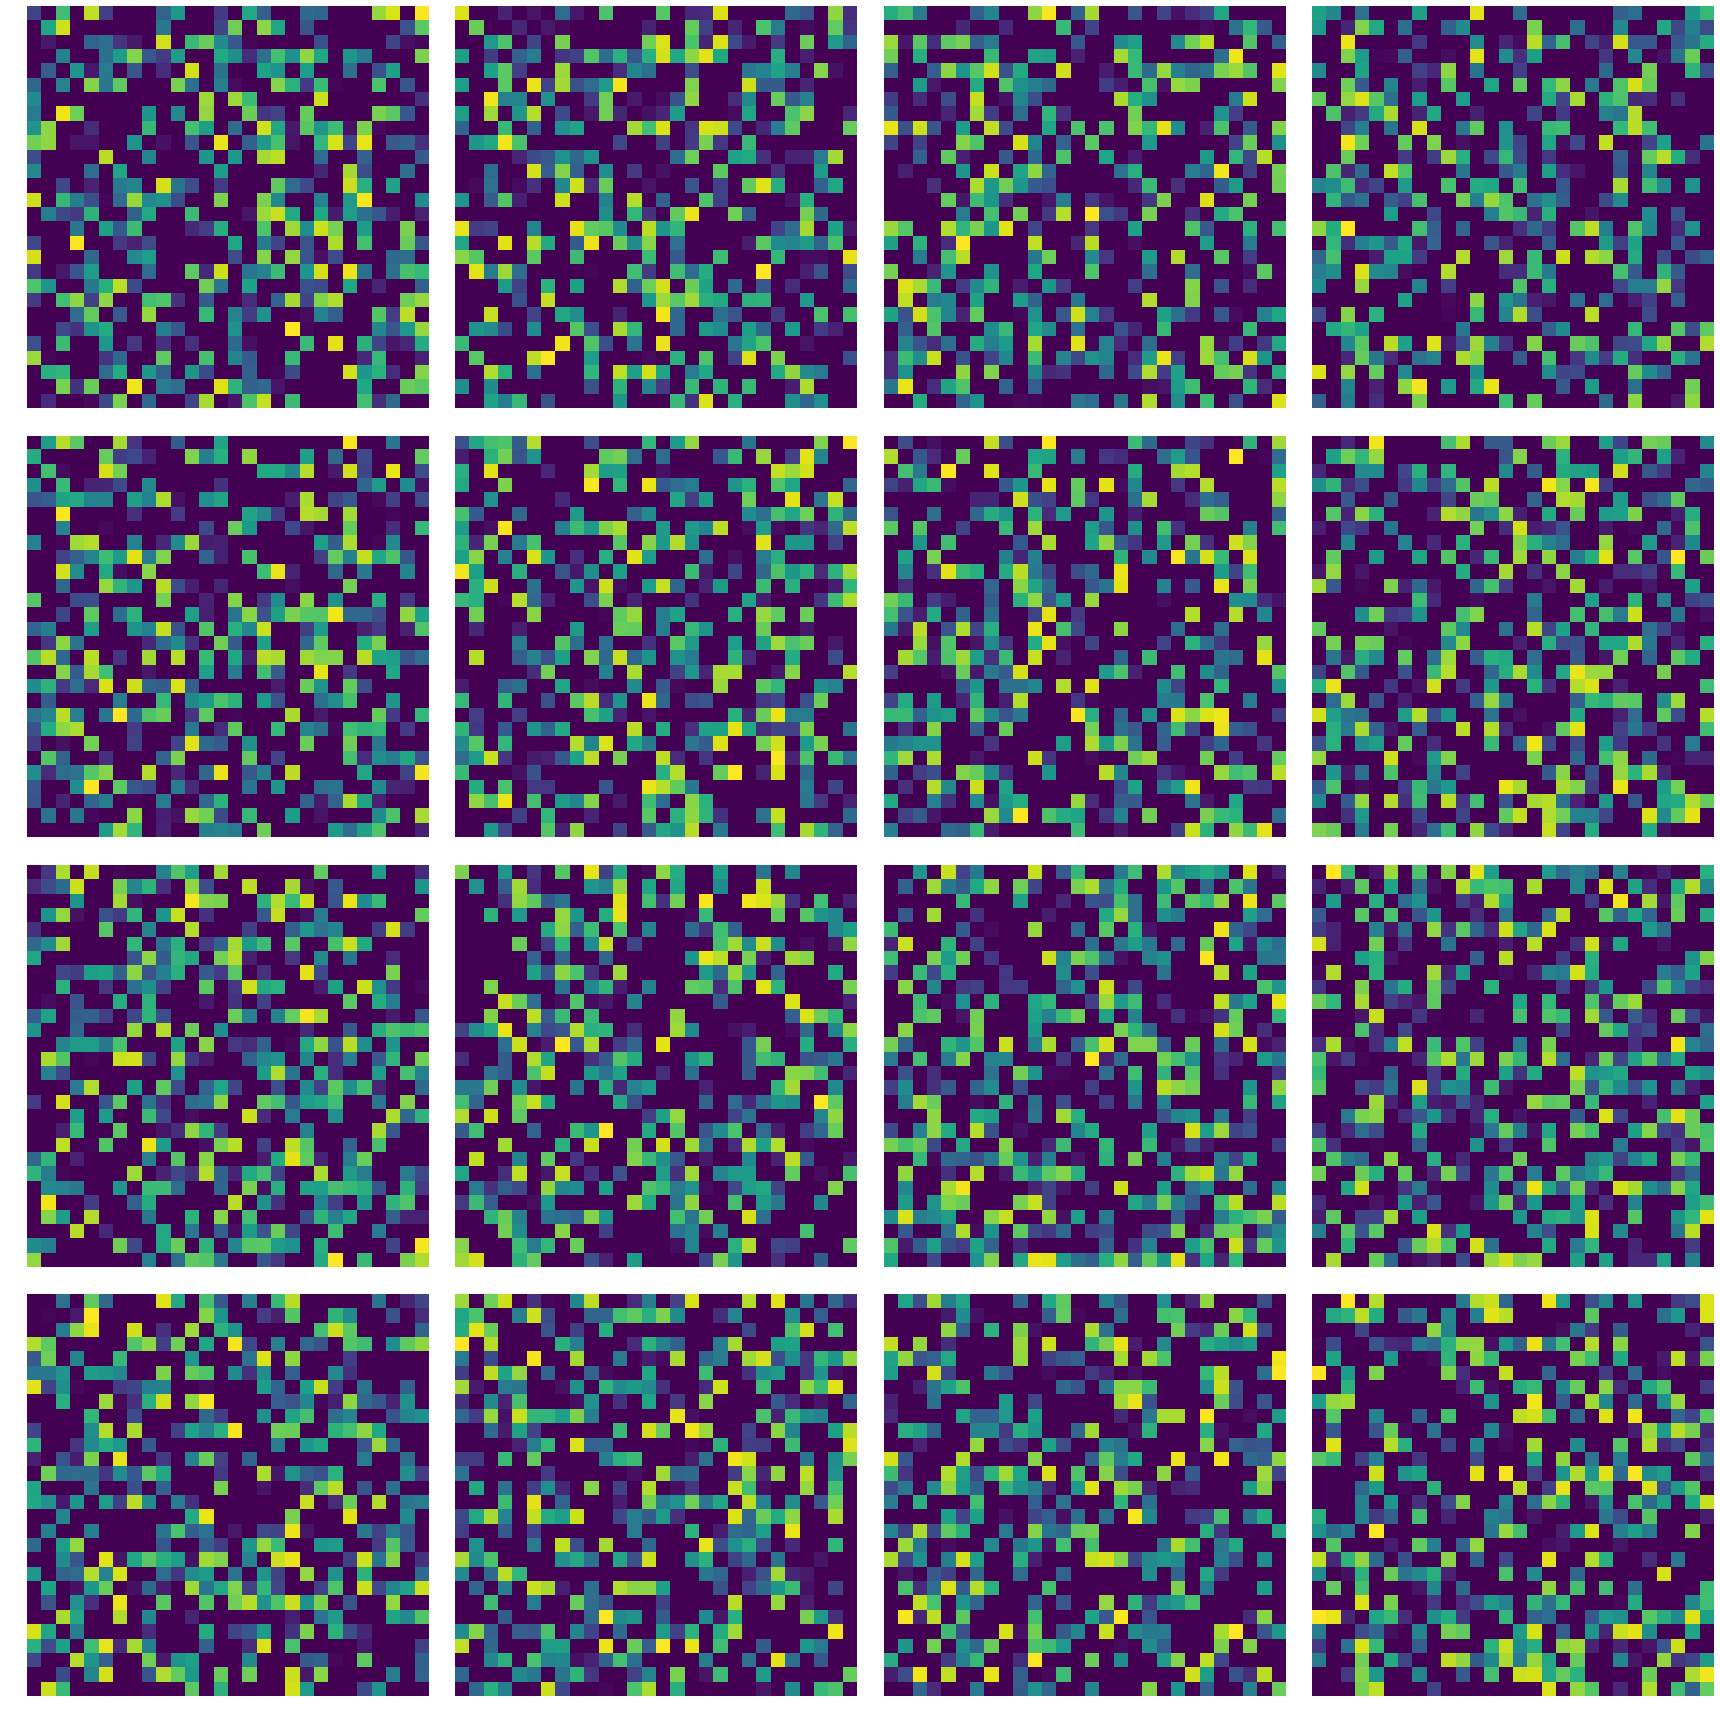

Epoch 100, Generator loss 1.1212139129638672, discriminator loss 0.016622714698314667


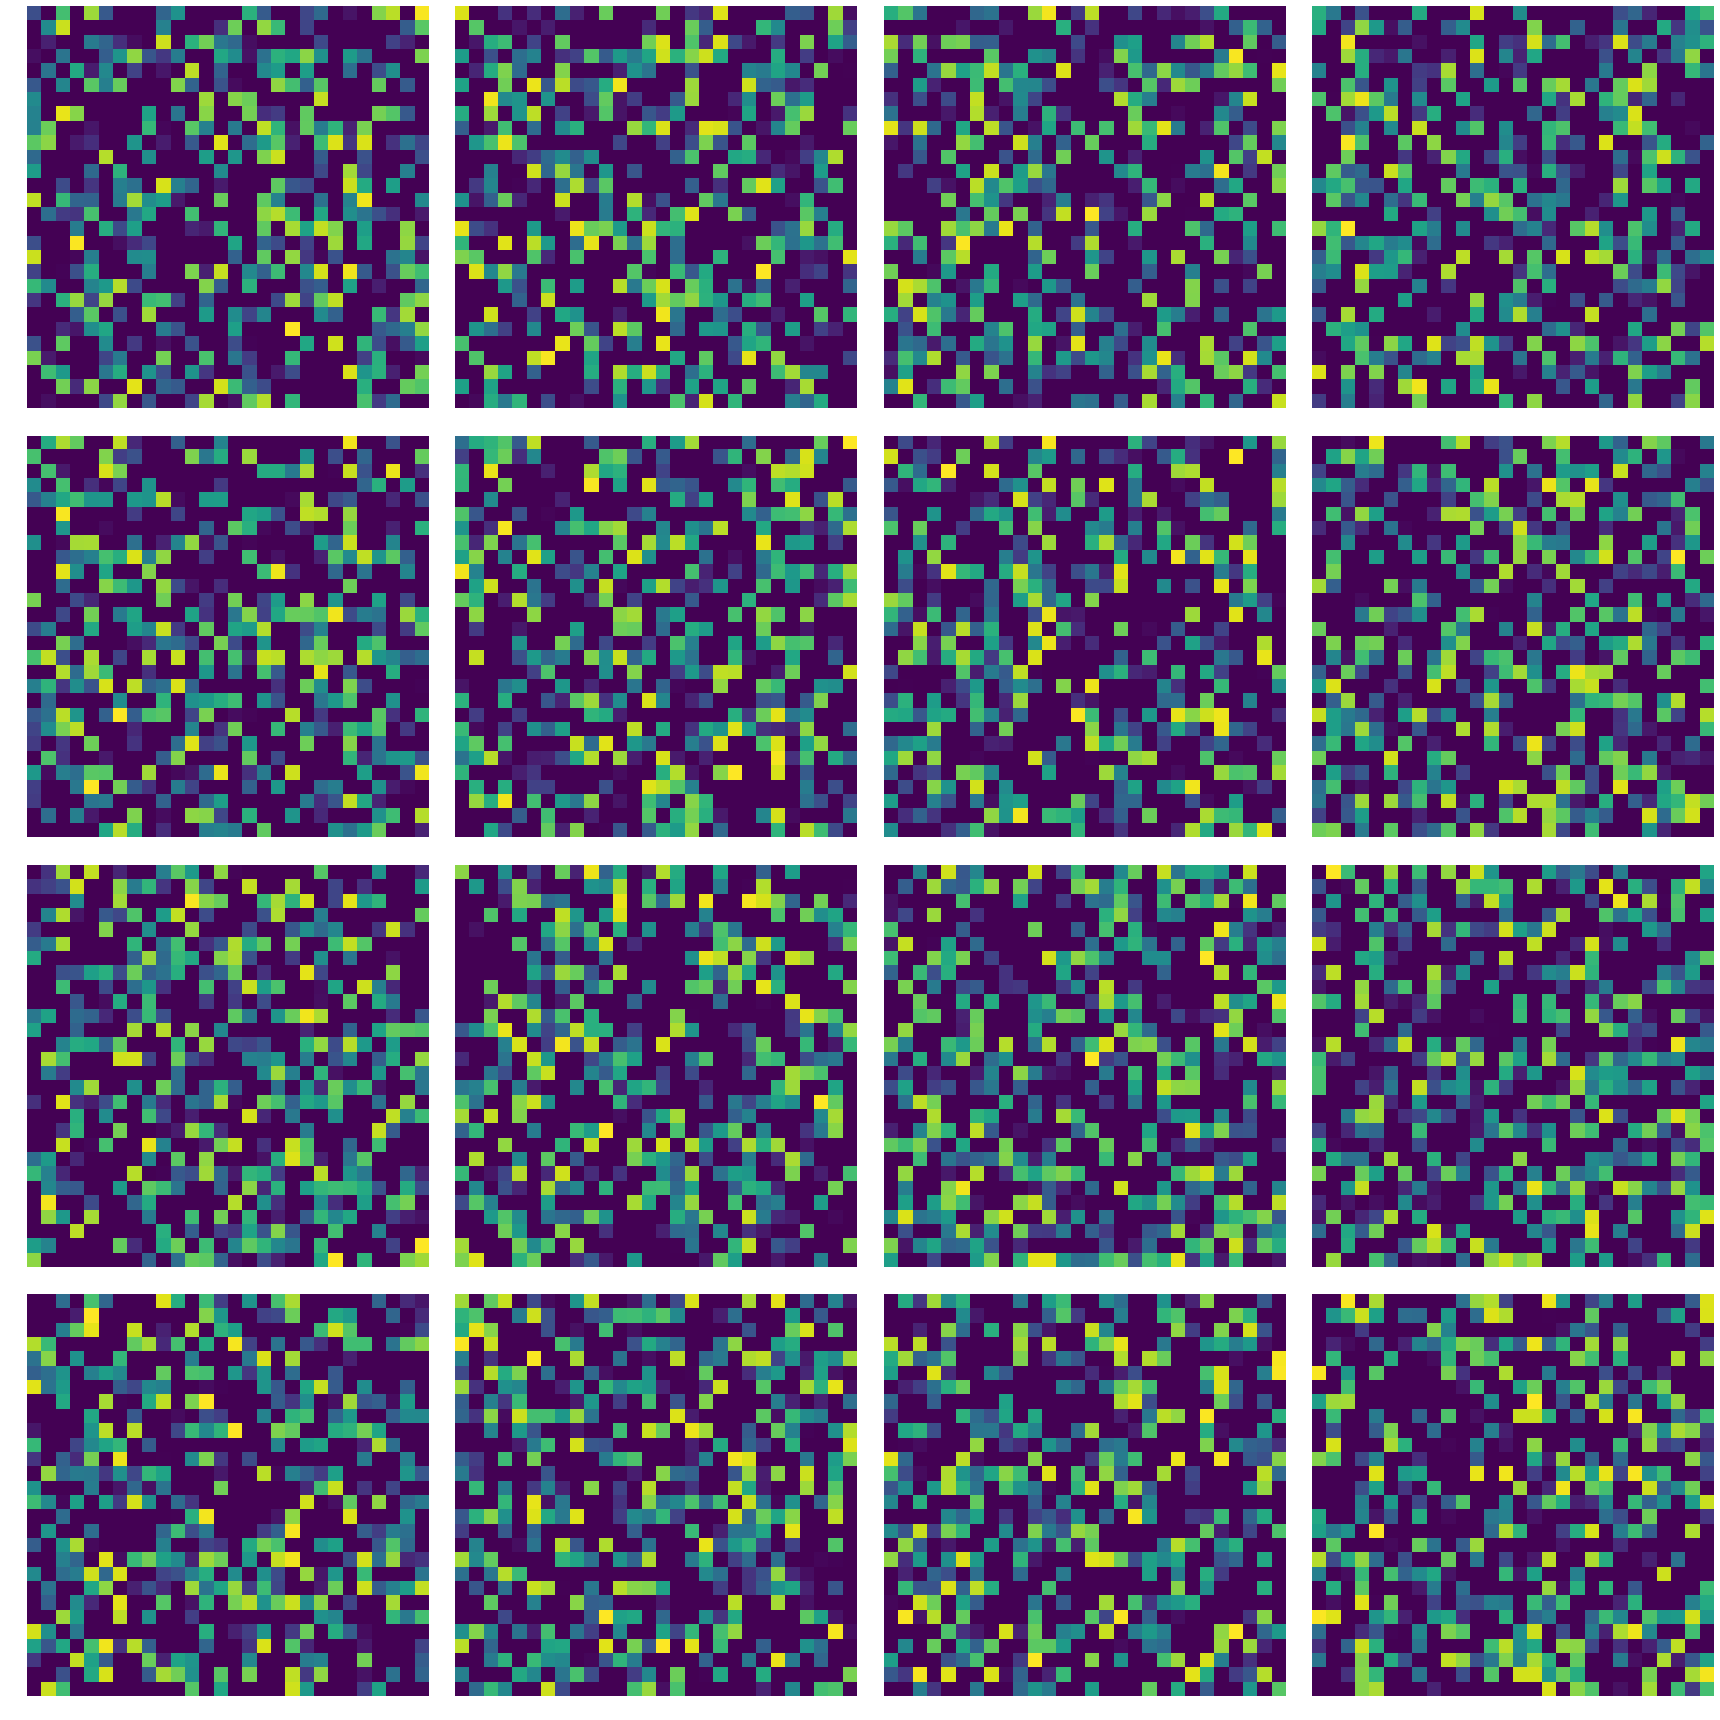

Epoch 200, Generator loss 1.0888950824737549, discriminator loss 0.010881034657359123


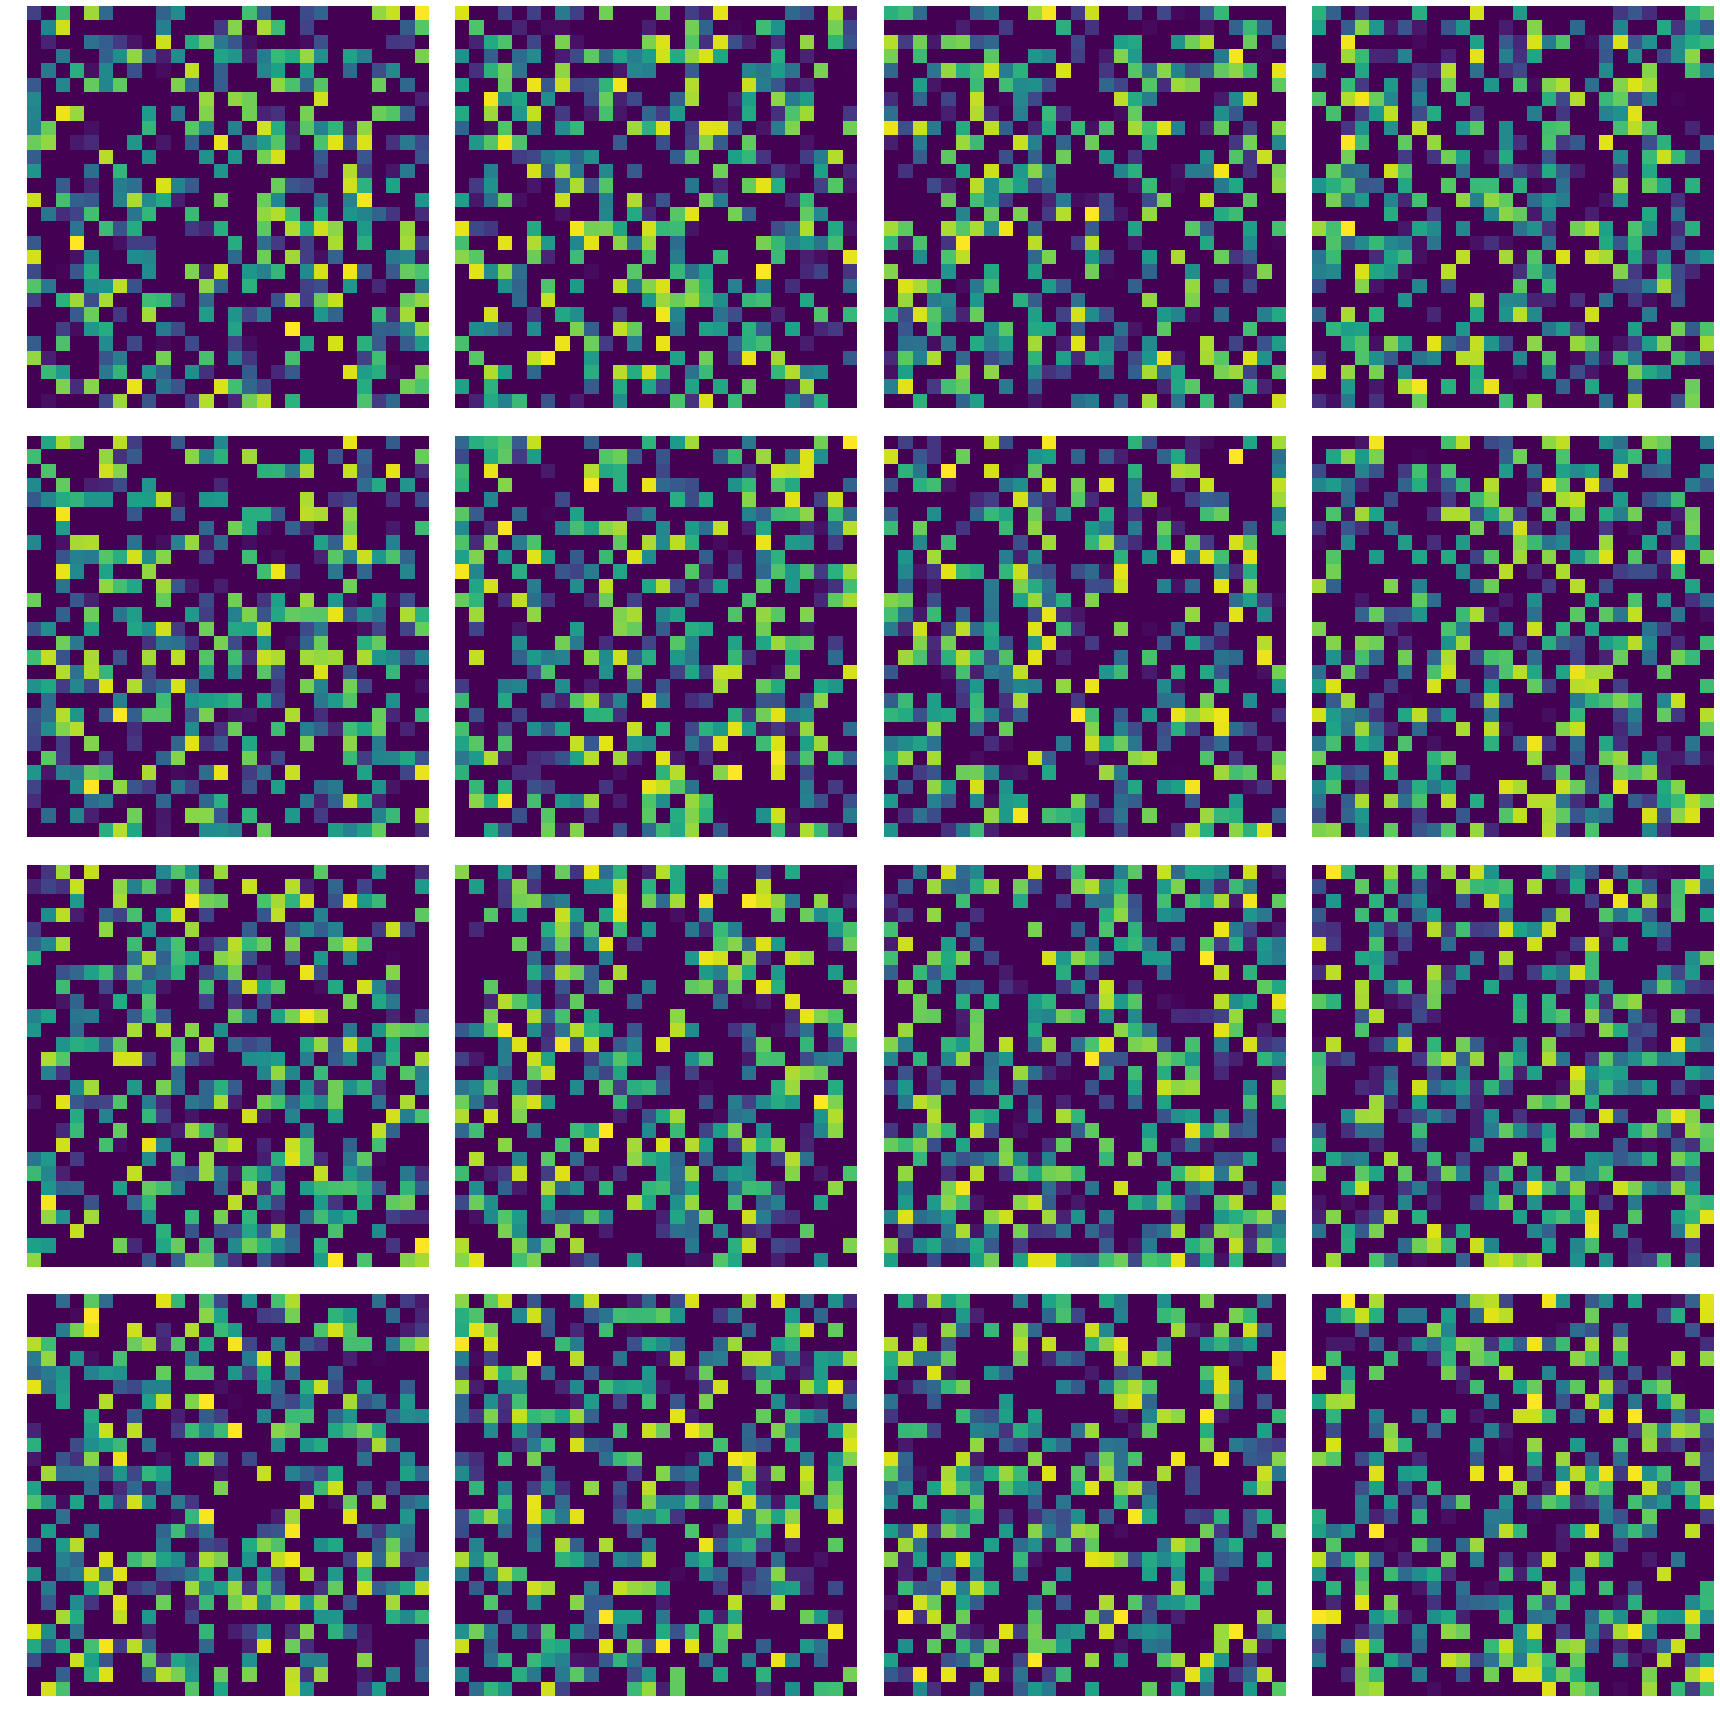

Epoch 300, Generator loss 1.06987464427948, discriminator loss 0.008771762251853943


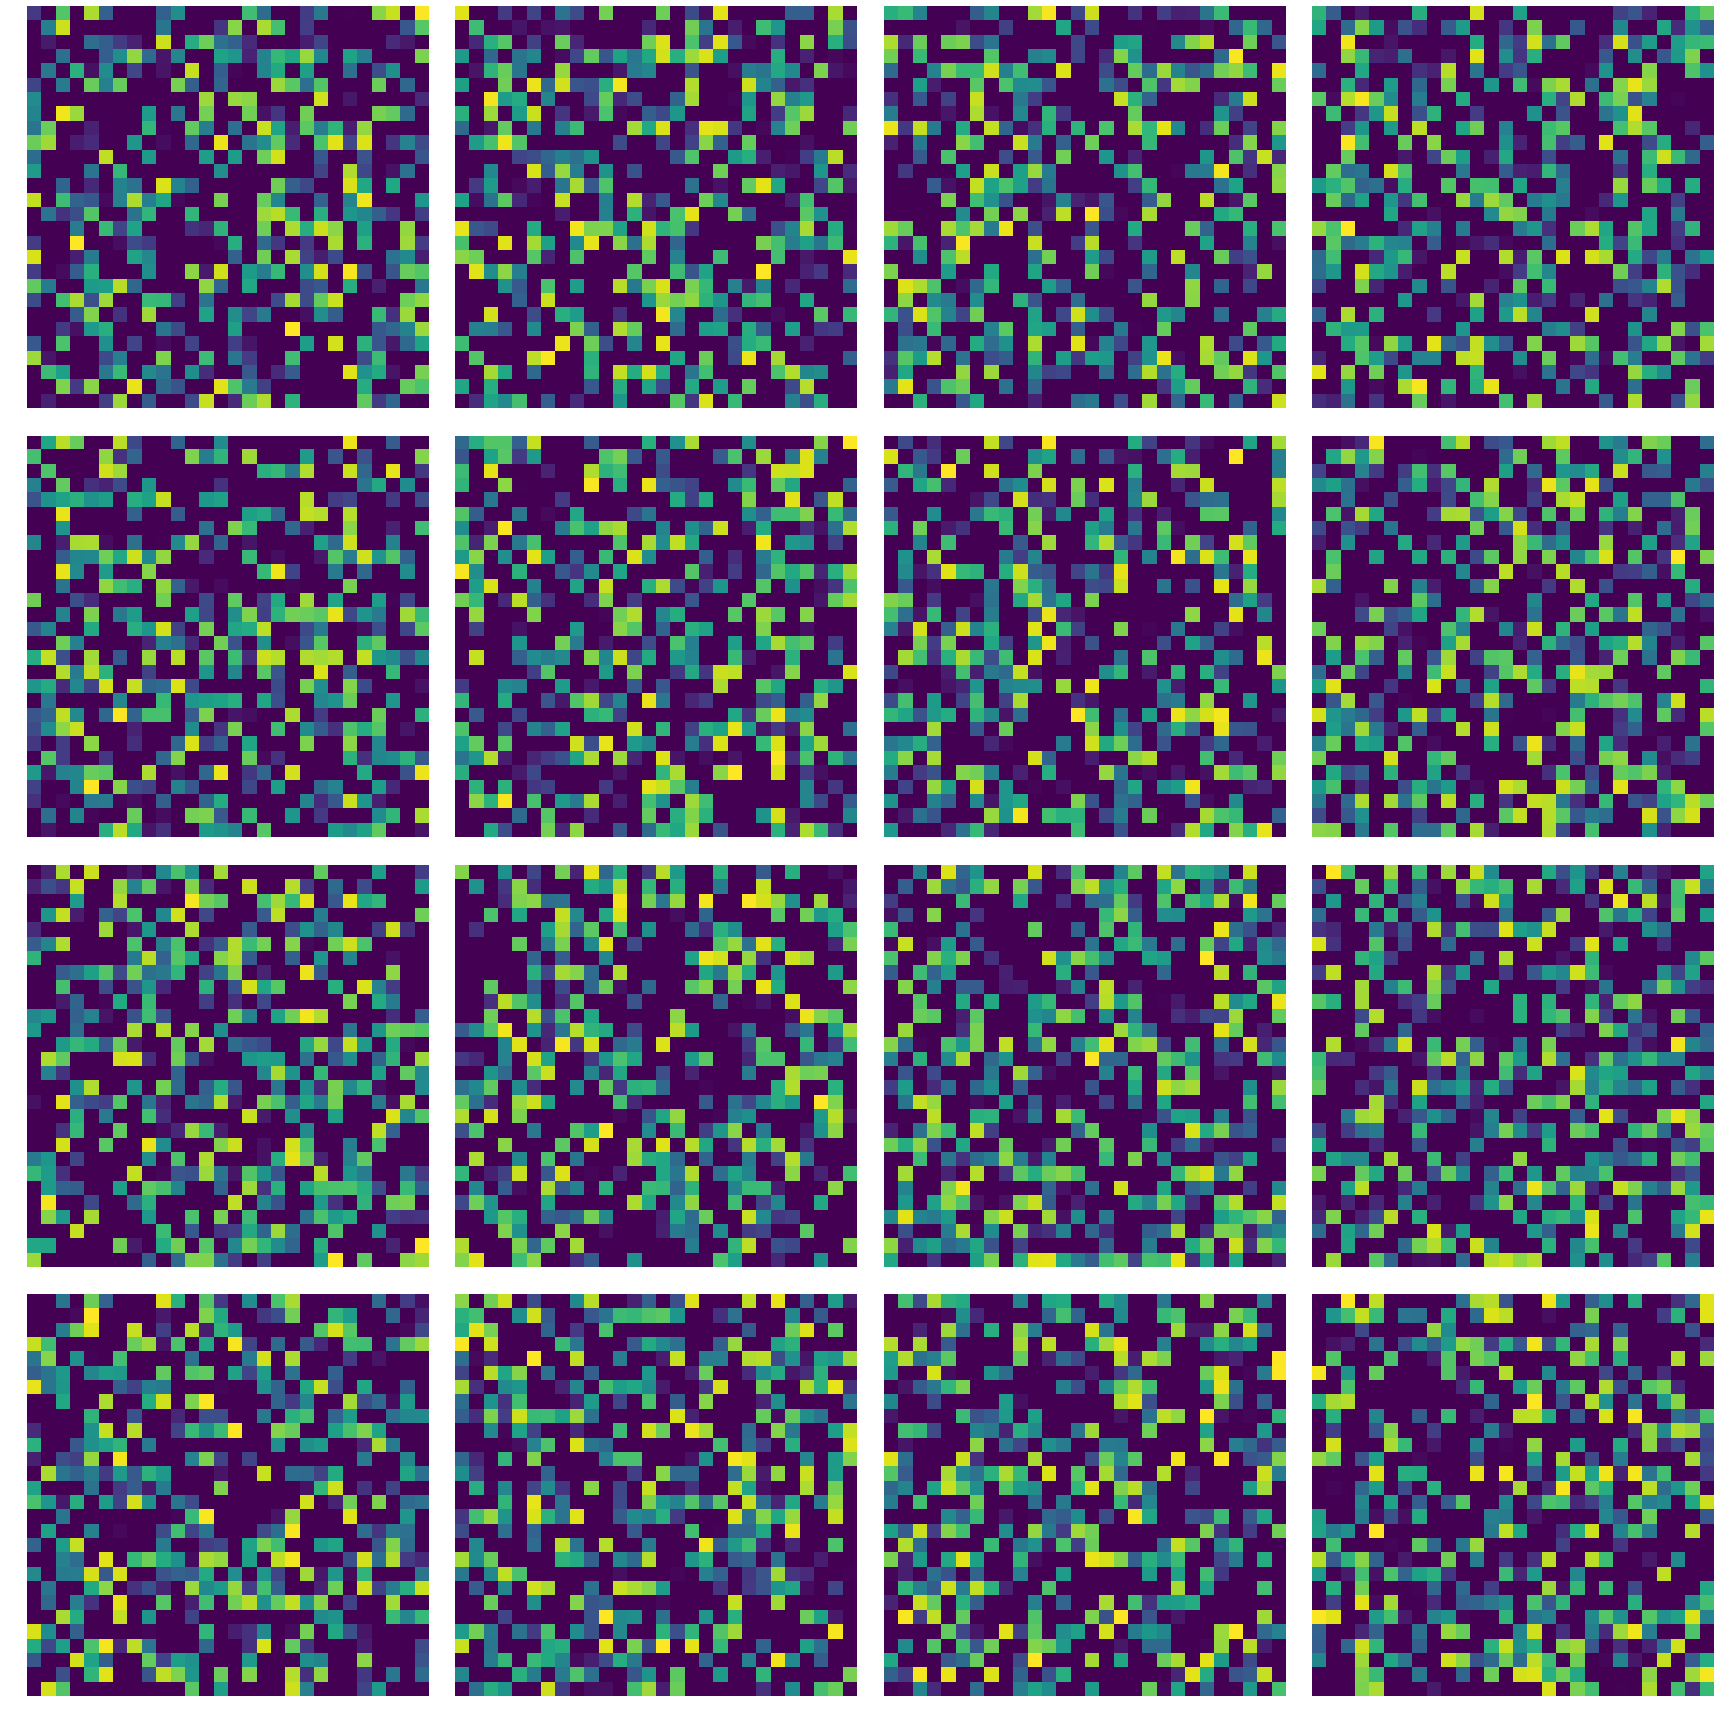

Epoch 400, Generator loss 1.0459328889846802, discriminator loss 0.00765005499124527


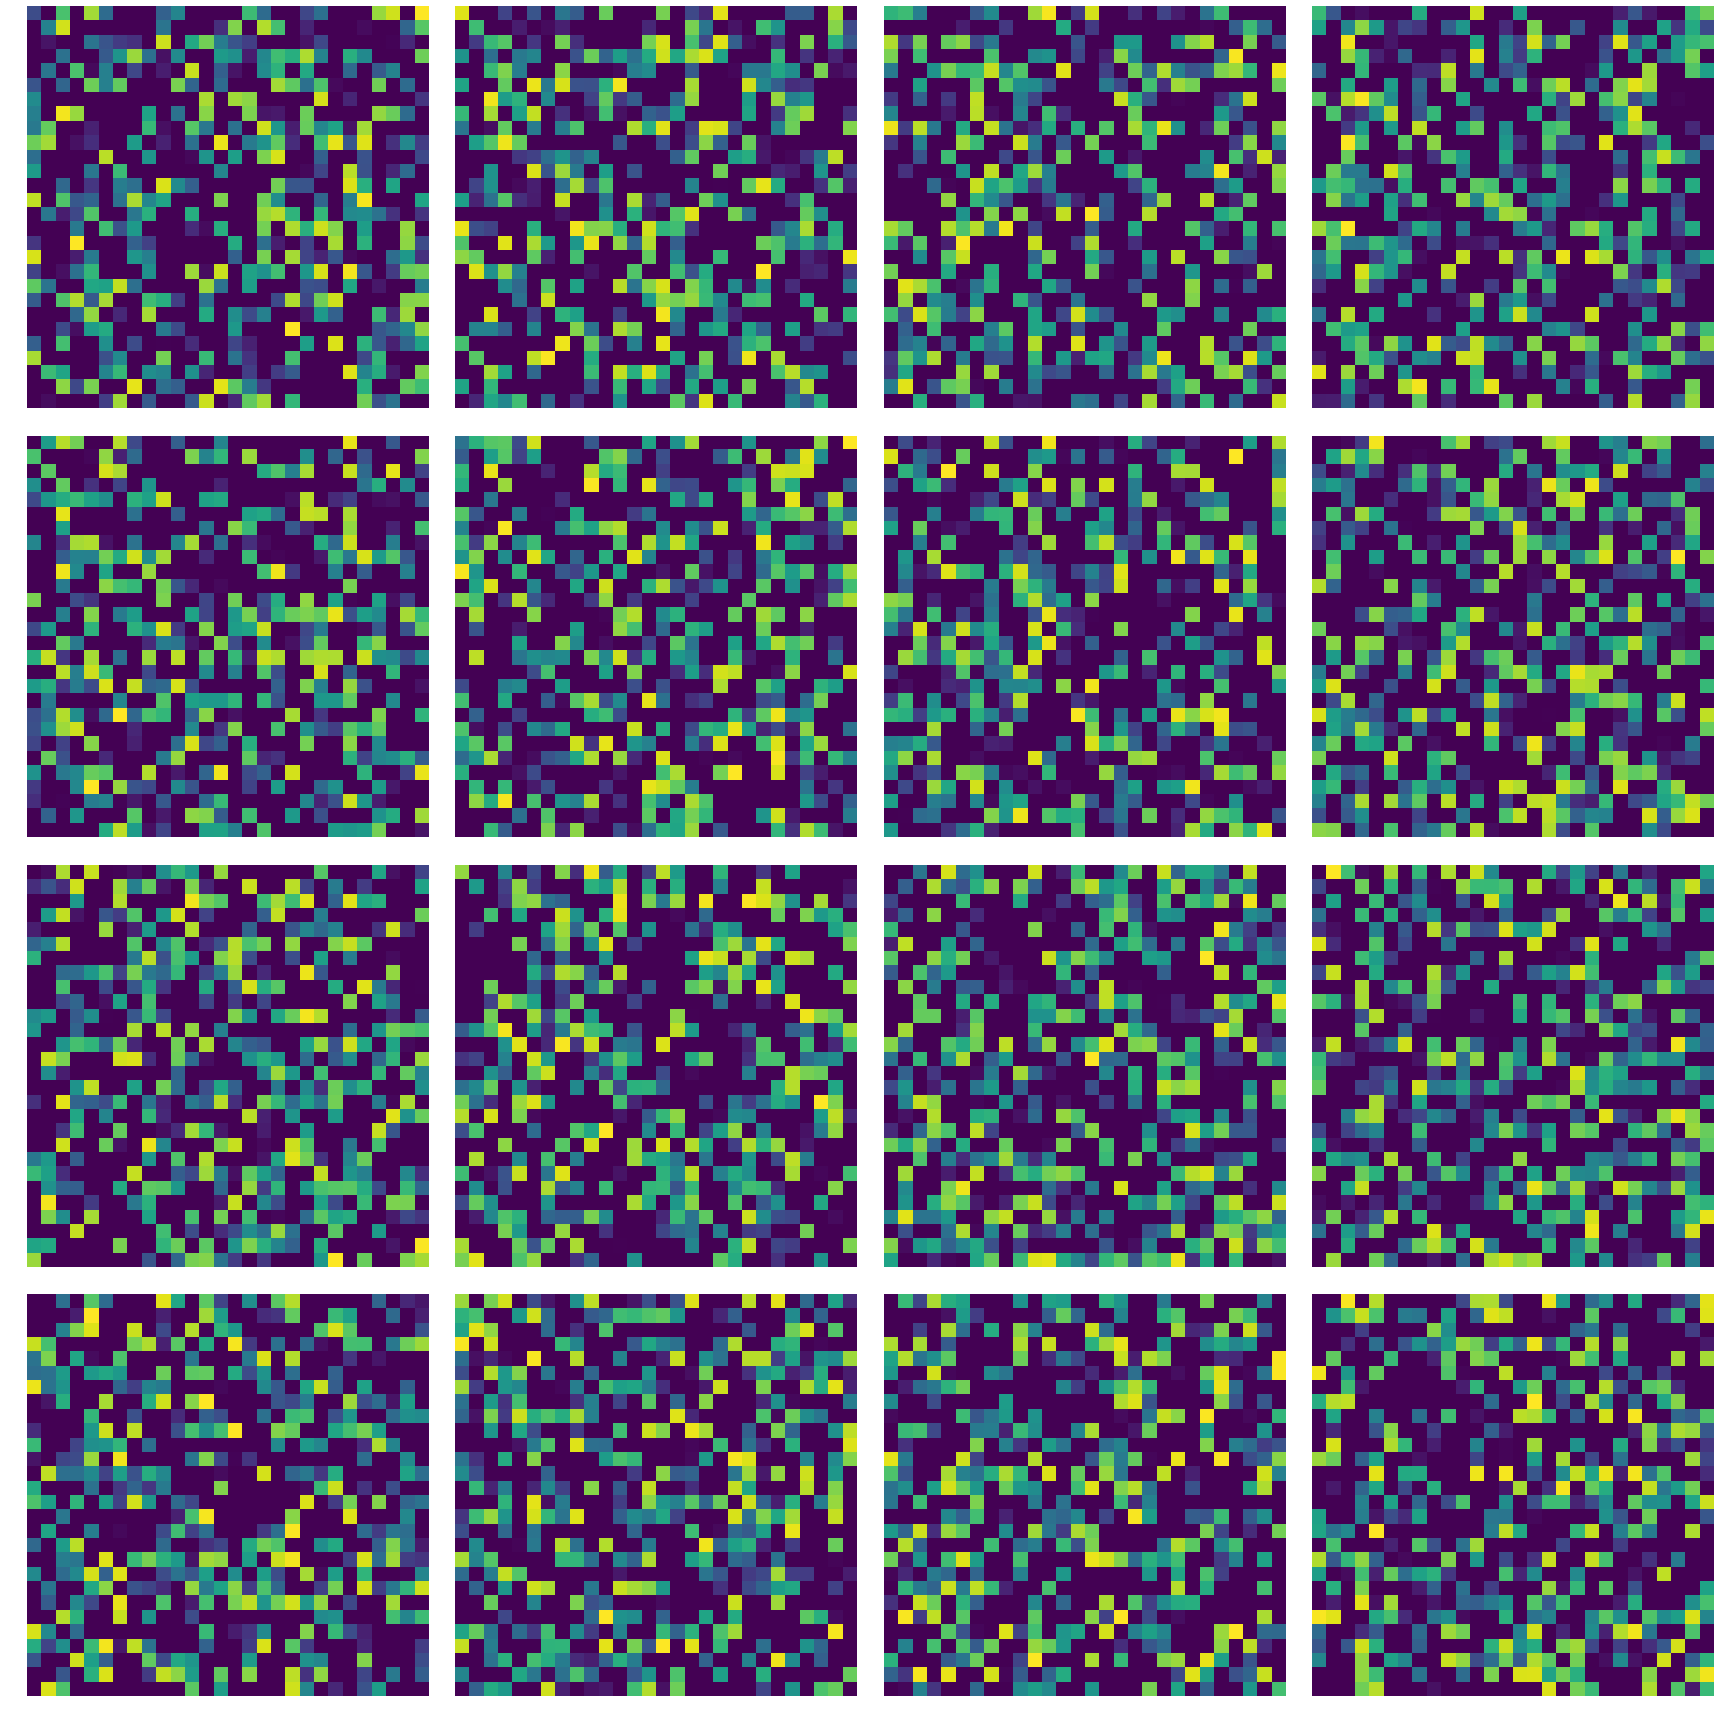

Epoch 500, Generator loss 1.0432159900665283, discriminator loss 0.006923512555658817


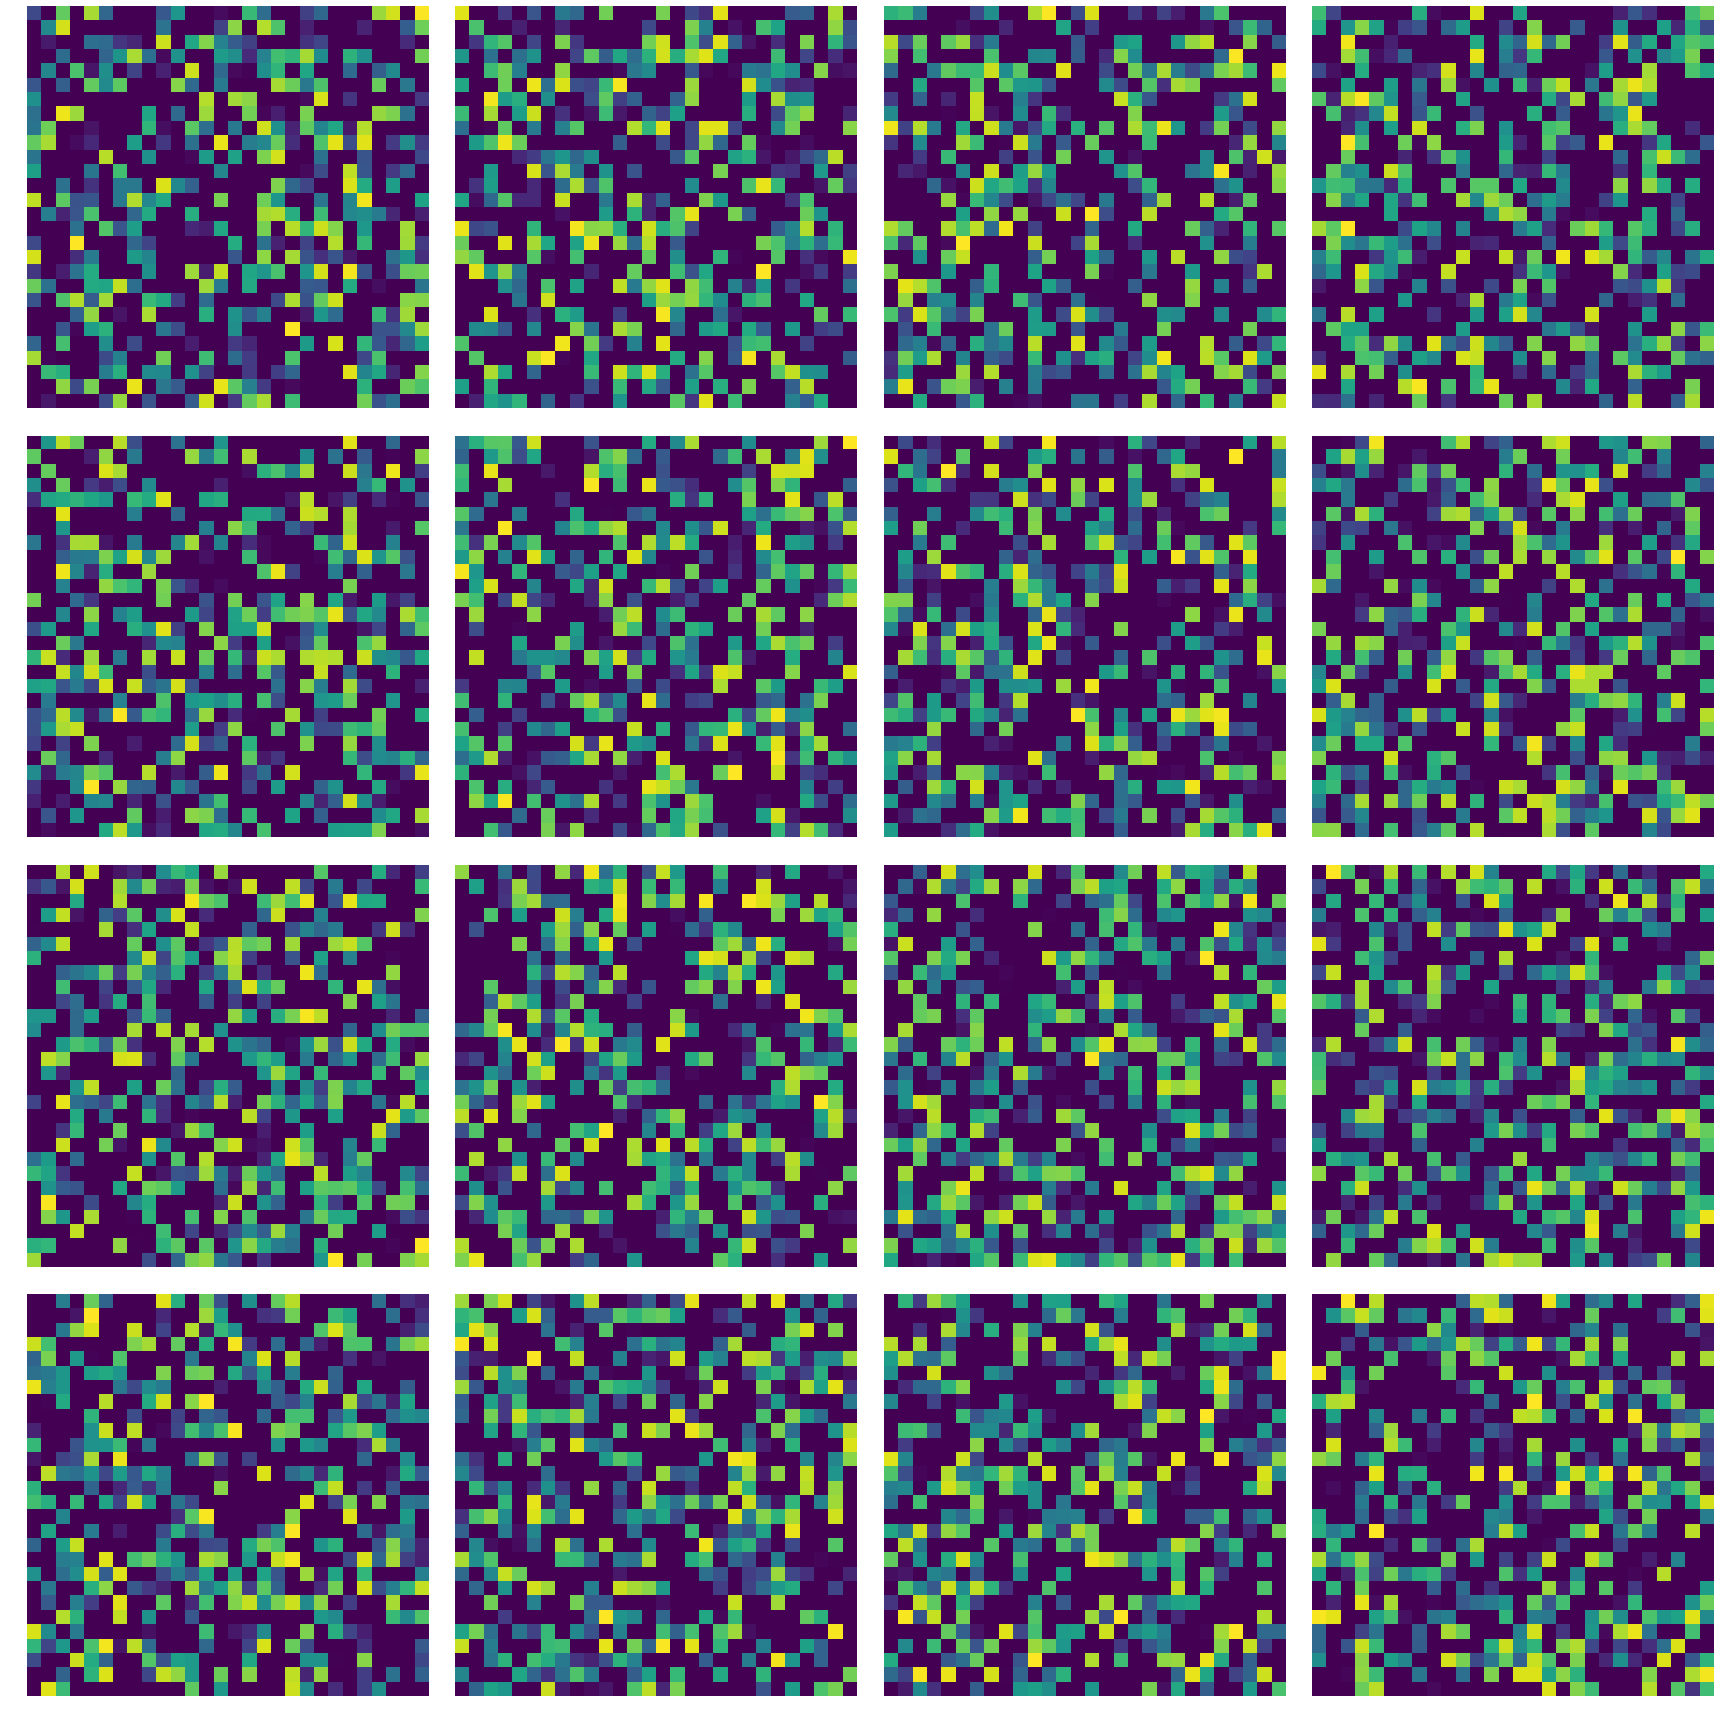

Epoch 600, Generator loss 1.0016309022903442, discriminator loss 0.006453251466155052


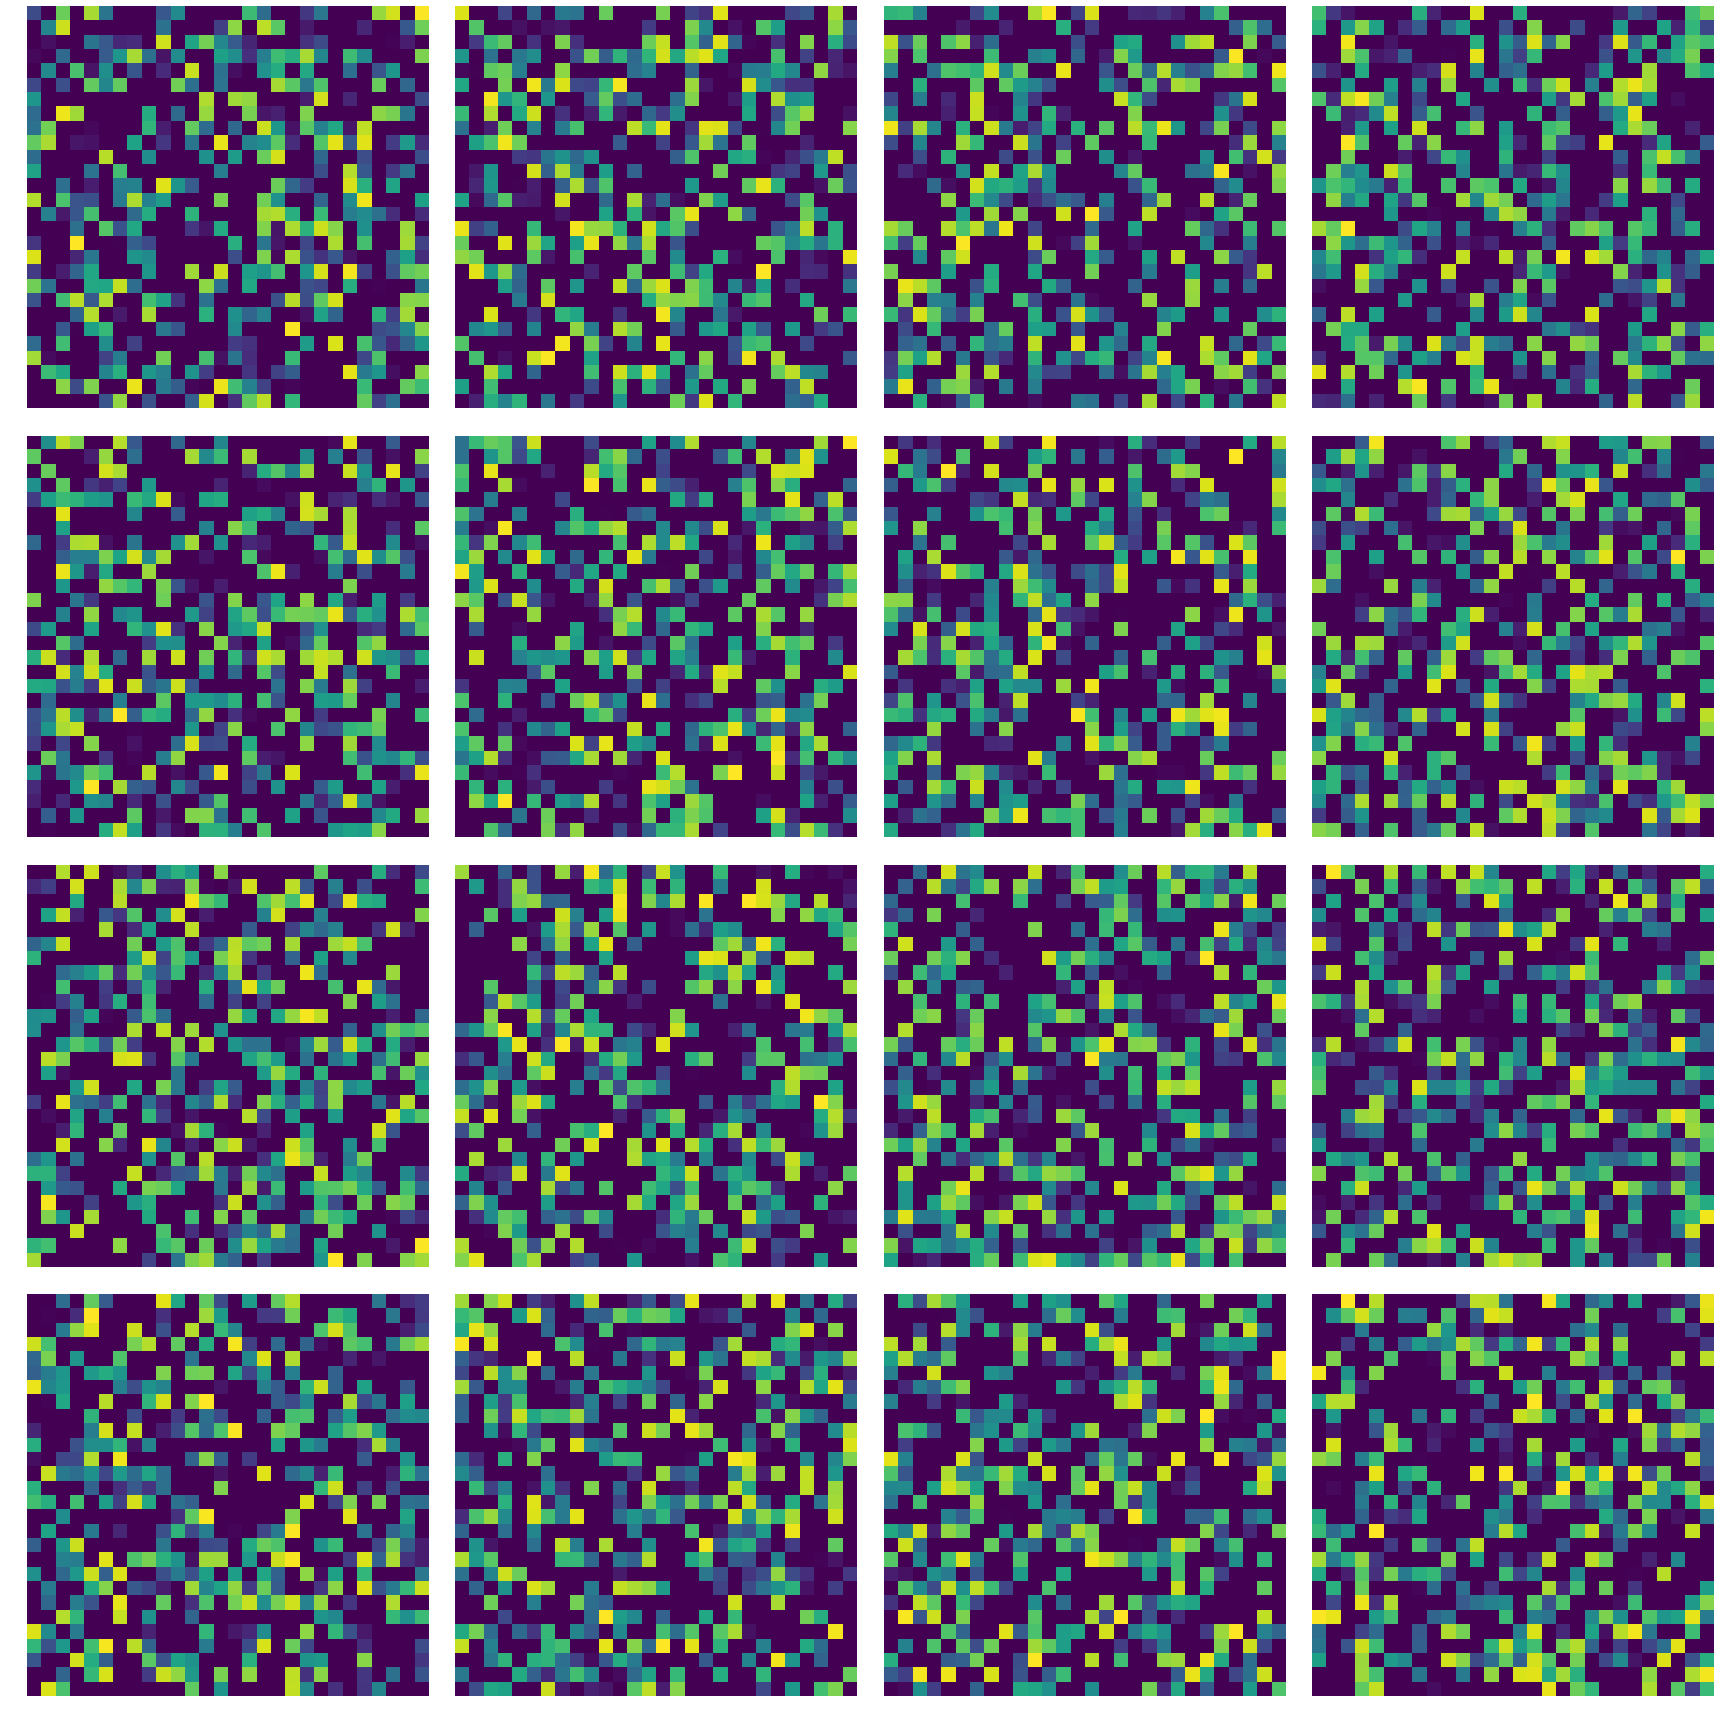

Epoch 700, Generator loss 1.0043866634368896, discriminator loss 0.006114923860877752


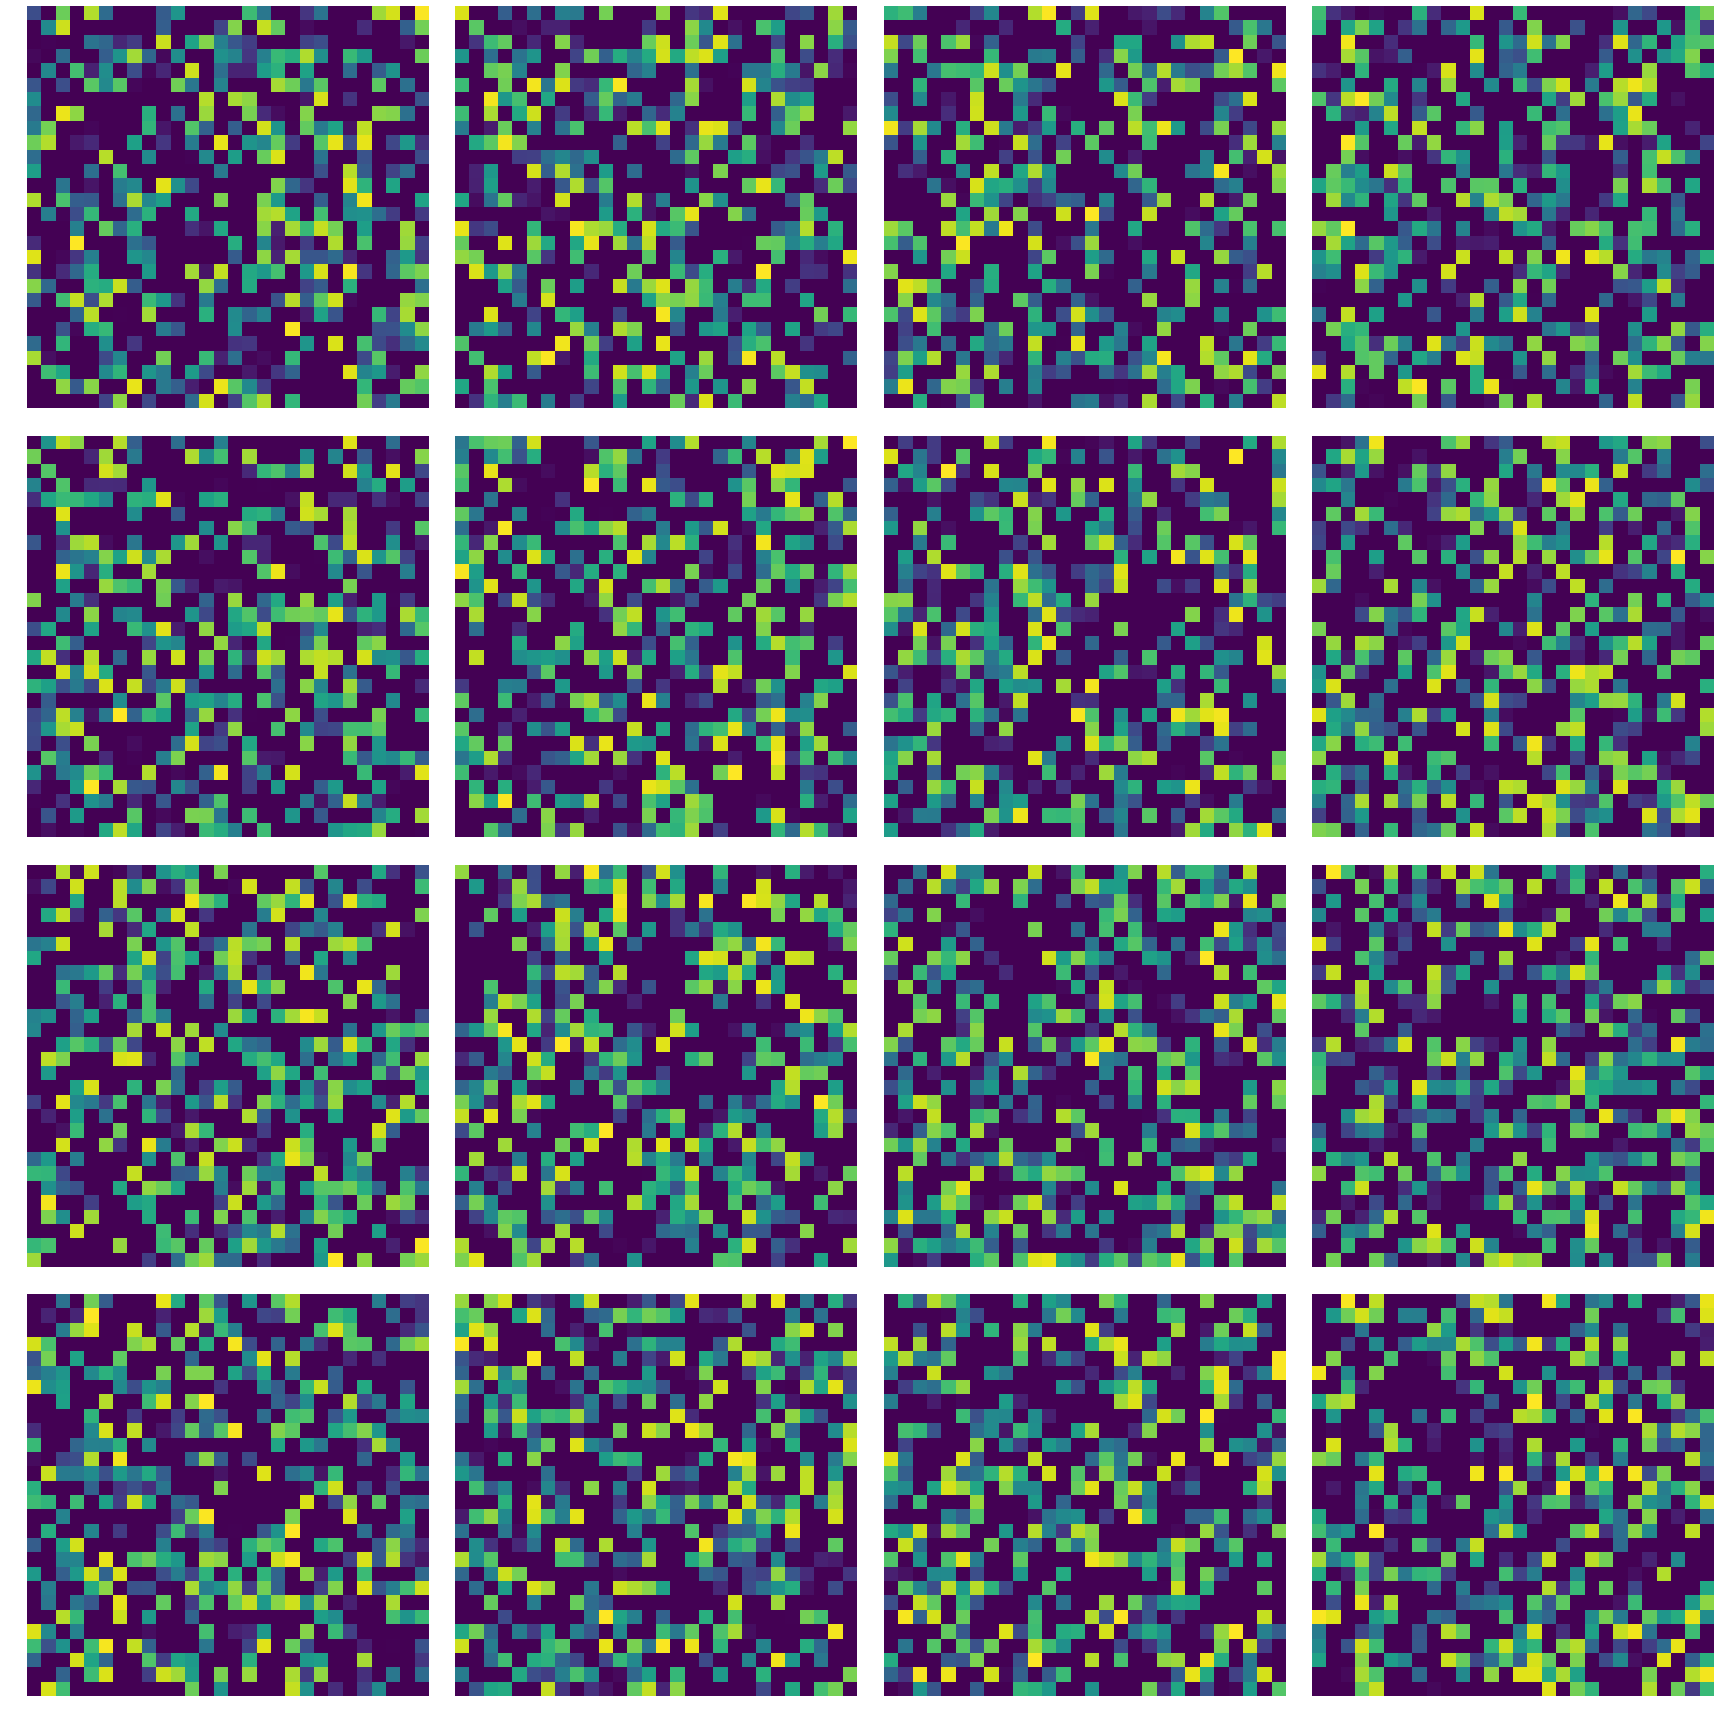

Epoch 800, Generator loss 0.9672607779502869, discriminator loss 0.0058168587274849415


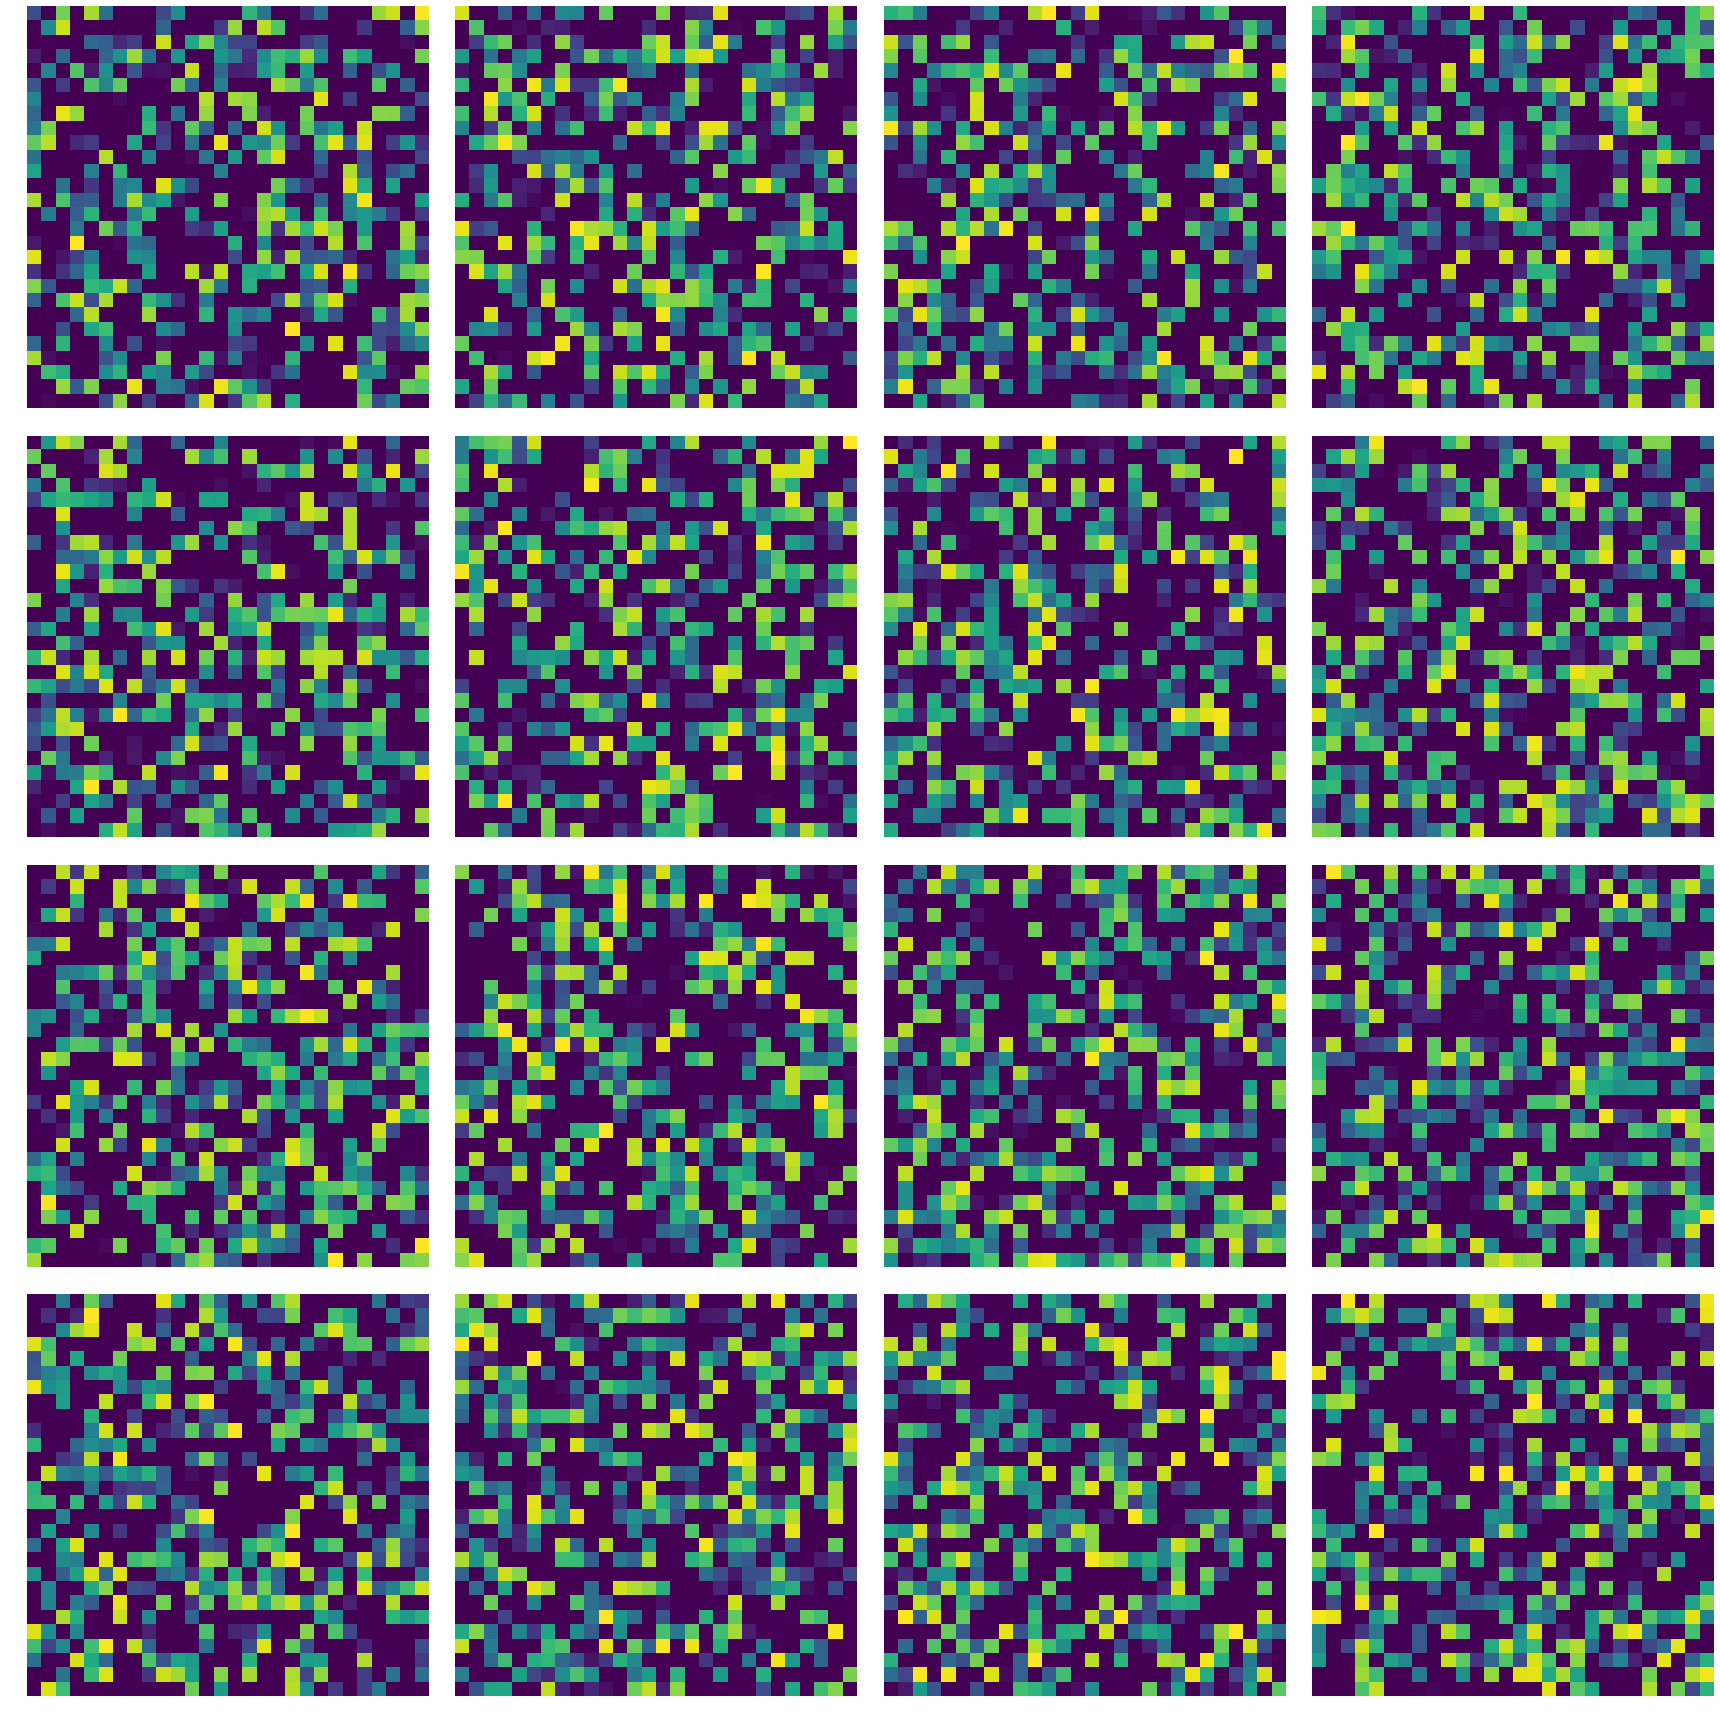

Epoch 900, Generator loss 0.9520521759986877, discriminator loss 0.0056342147290706635


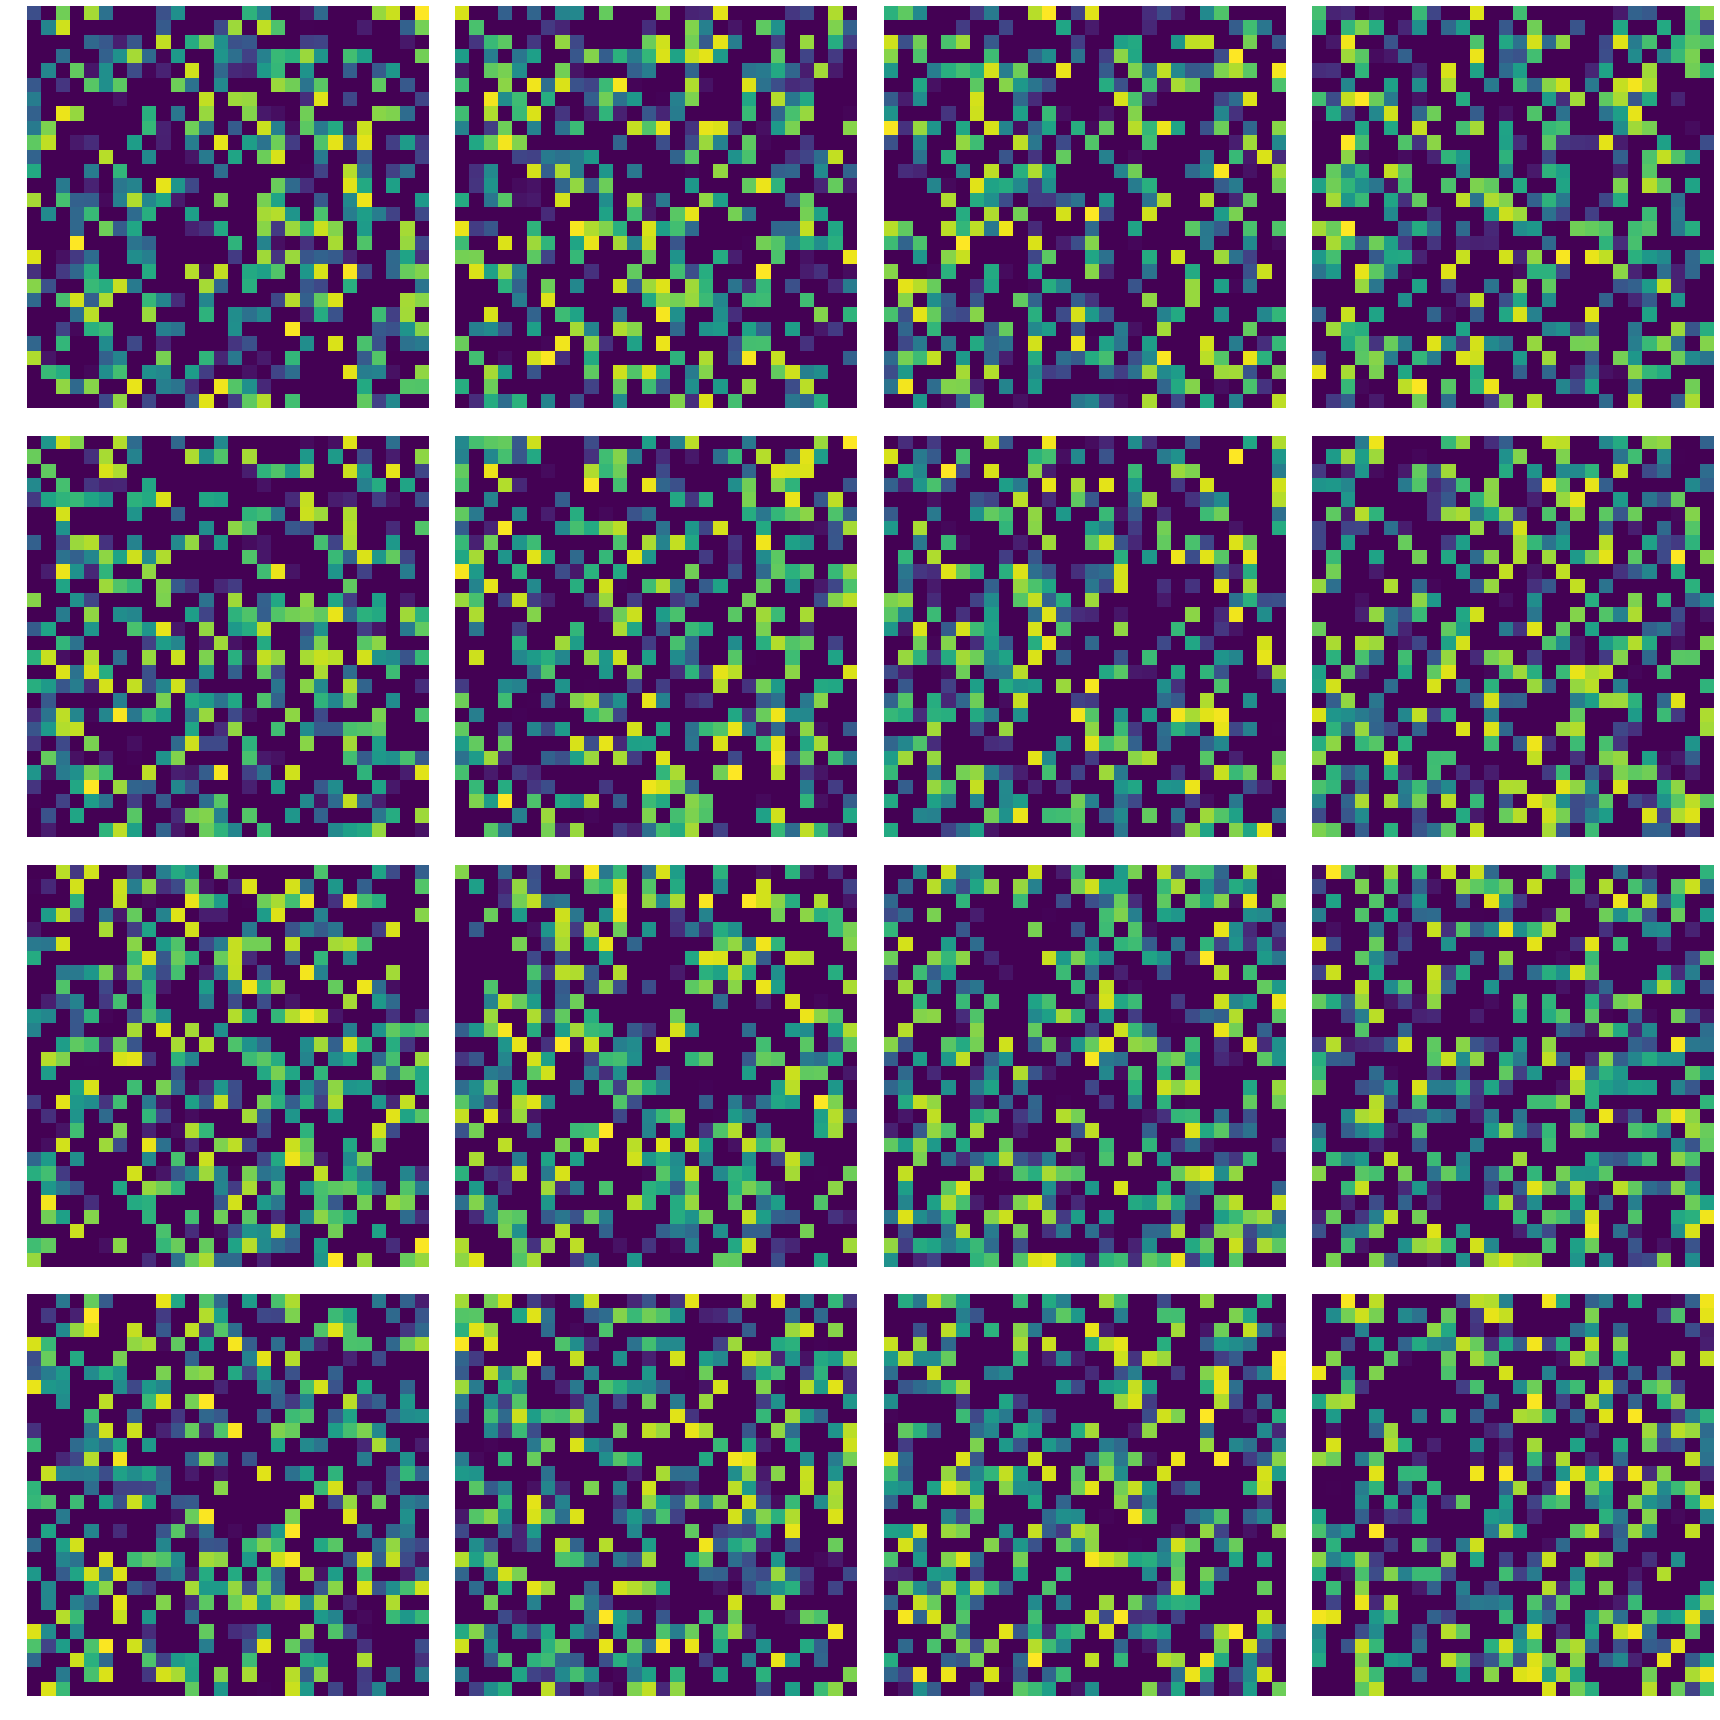

Epoch 1000, Generator loss 0.9326579570770264, discriminator loss 0.005440691951662302


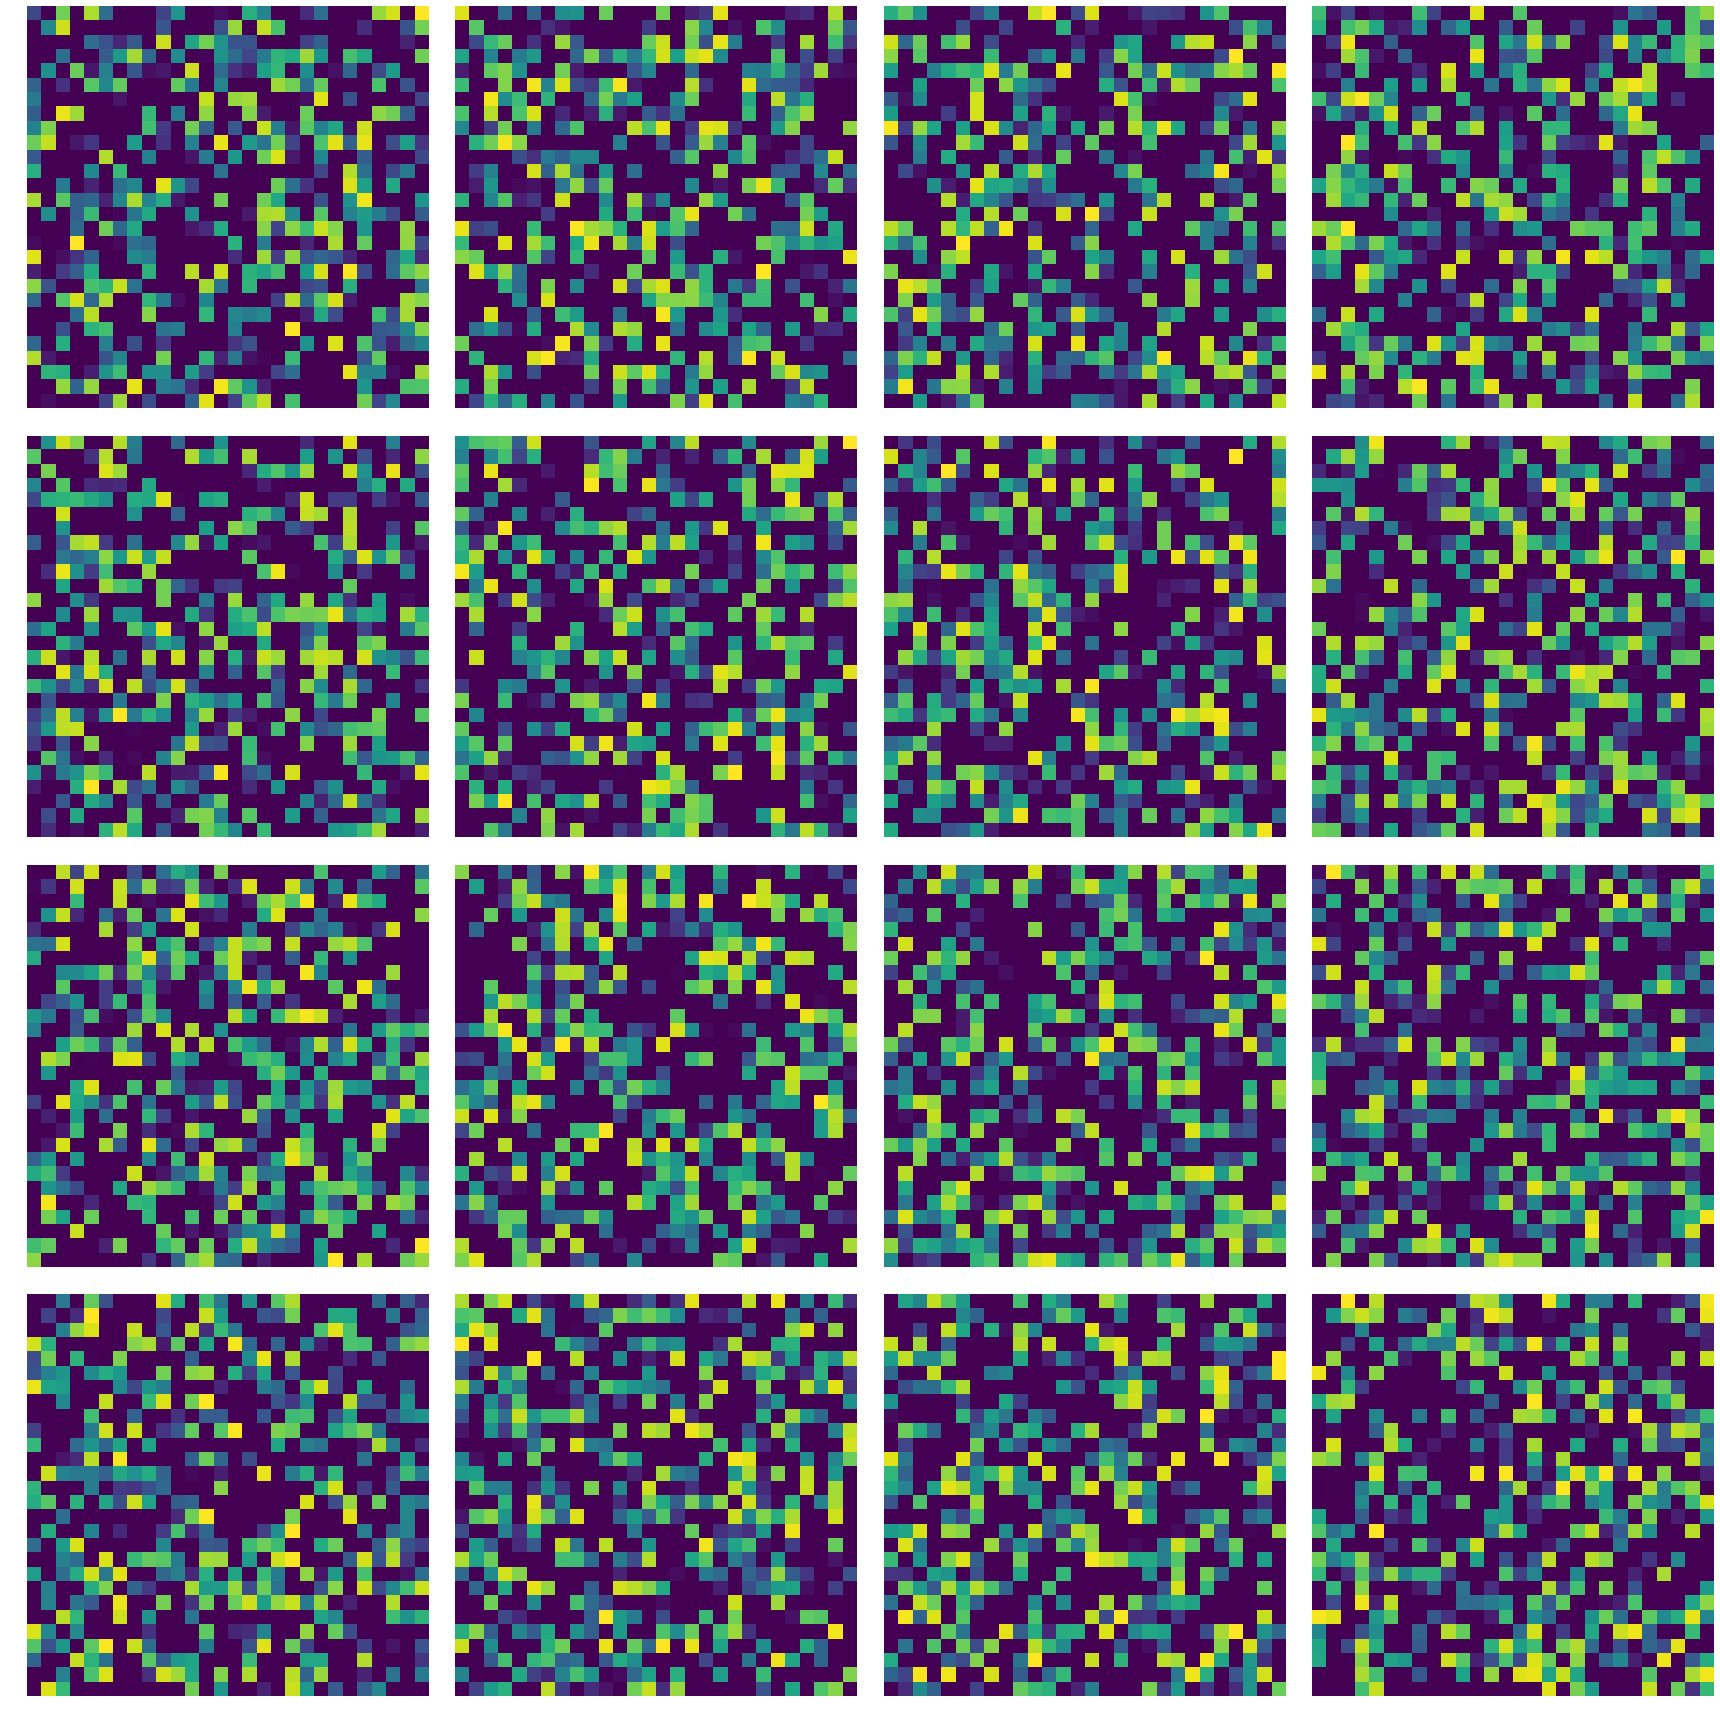

Epoch 1100, Generator loss 0.9139519929885864, discriminator loss 0.005305709317326546


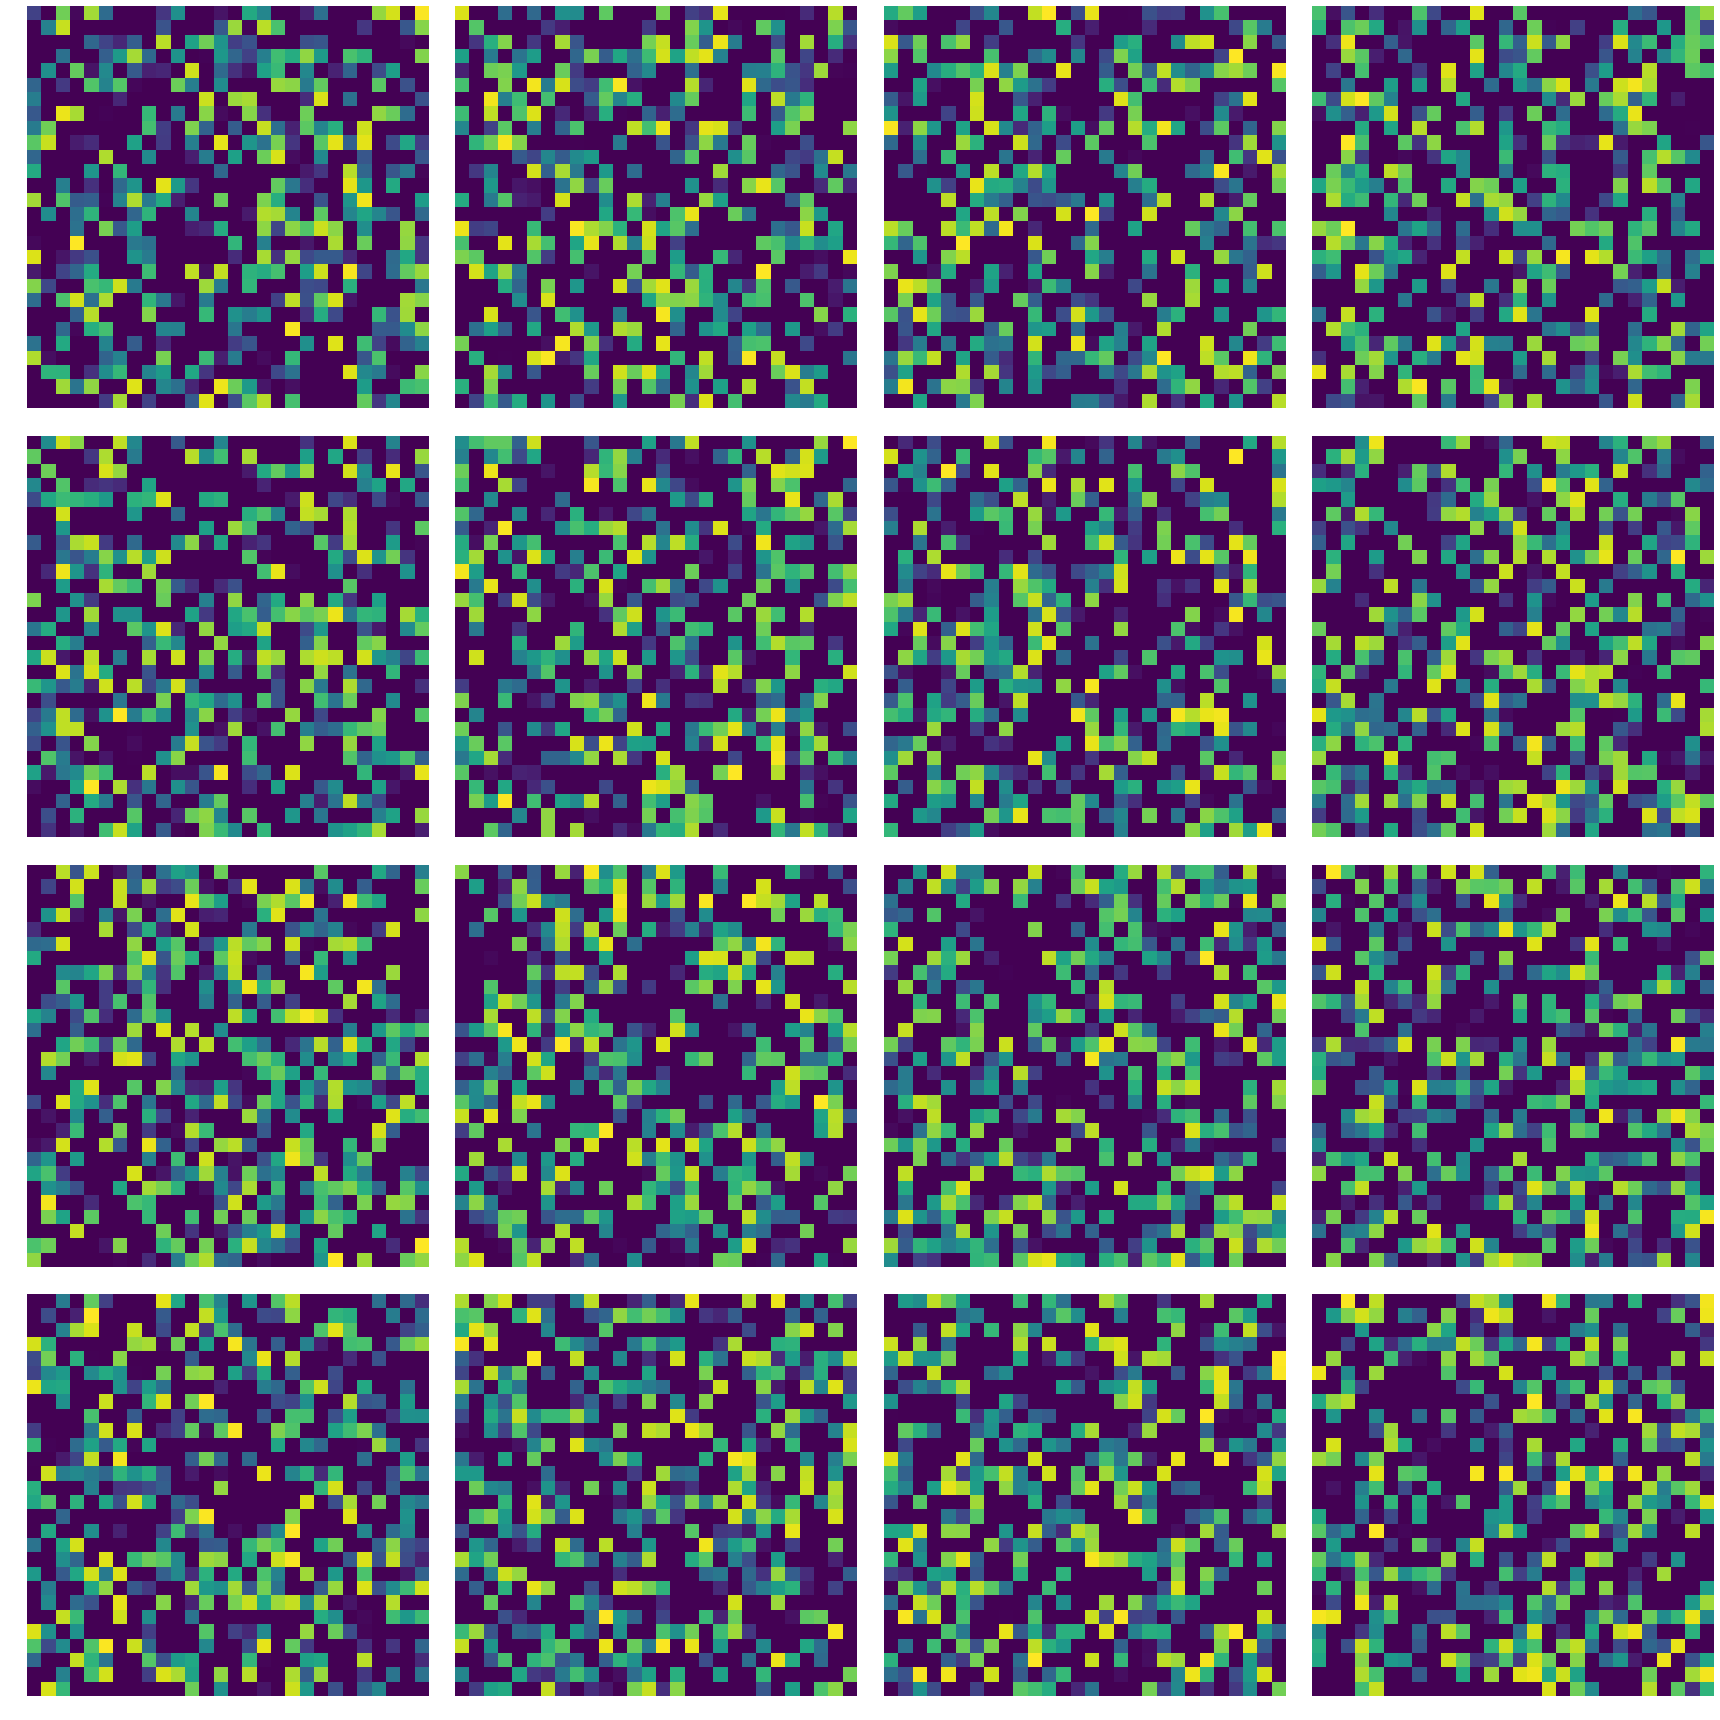

Epoch 1200, Generator loss 0.9165806174278259, discriminator loss 0.005165860988199711


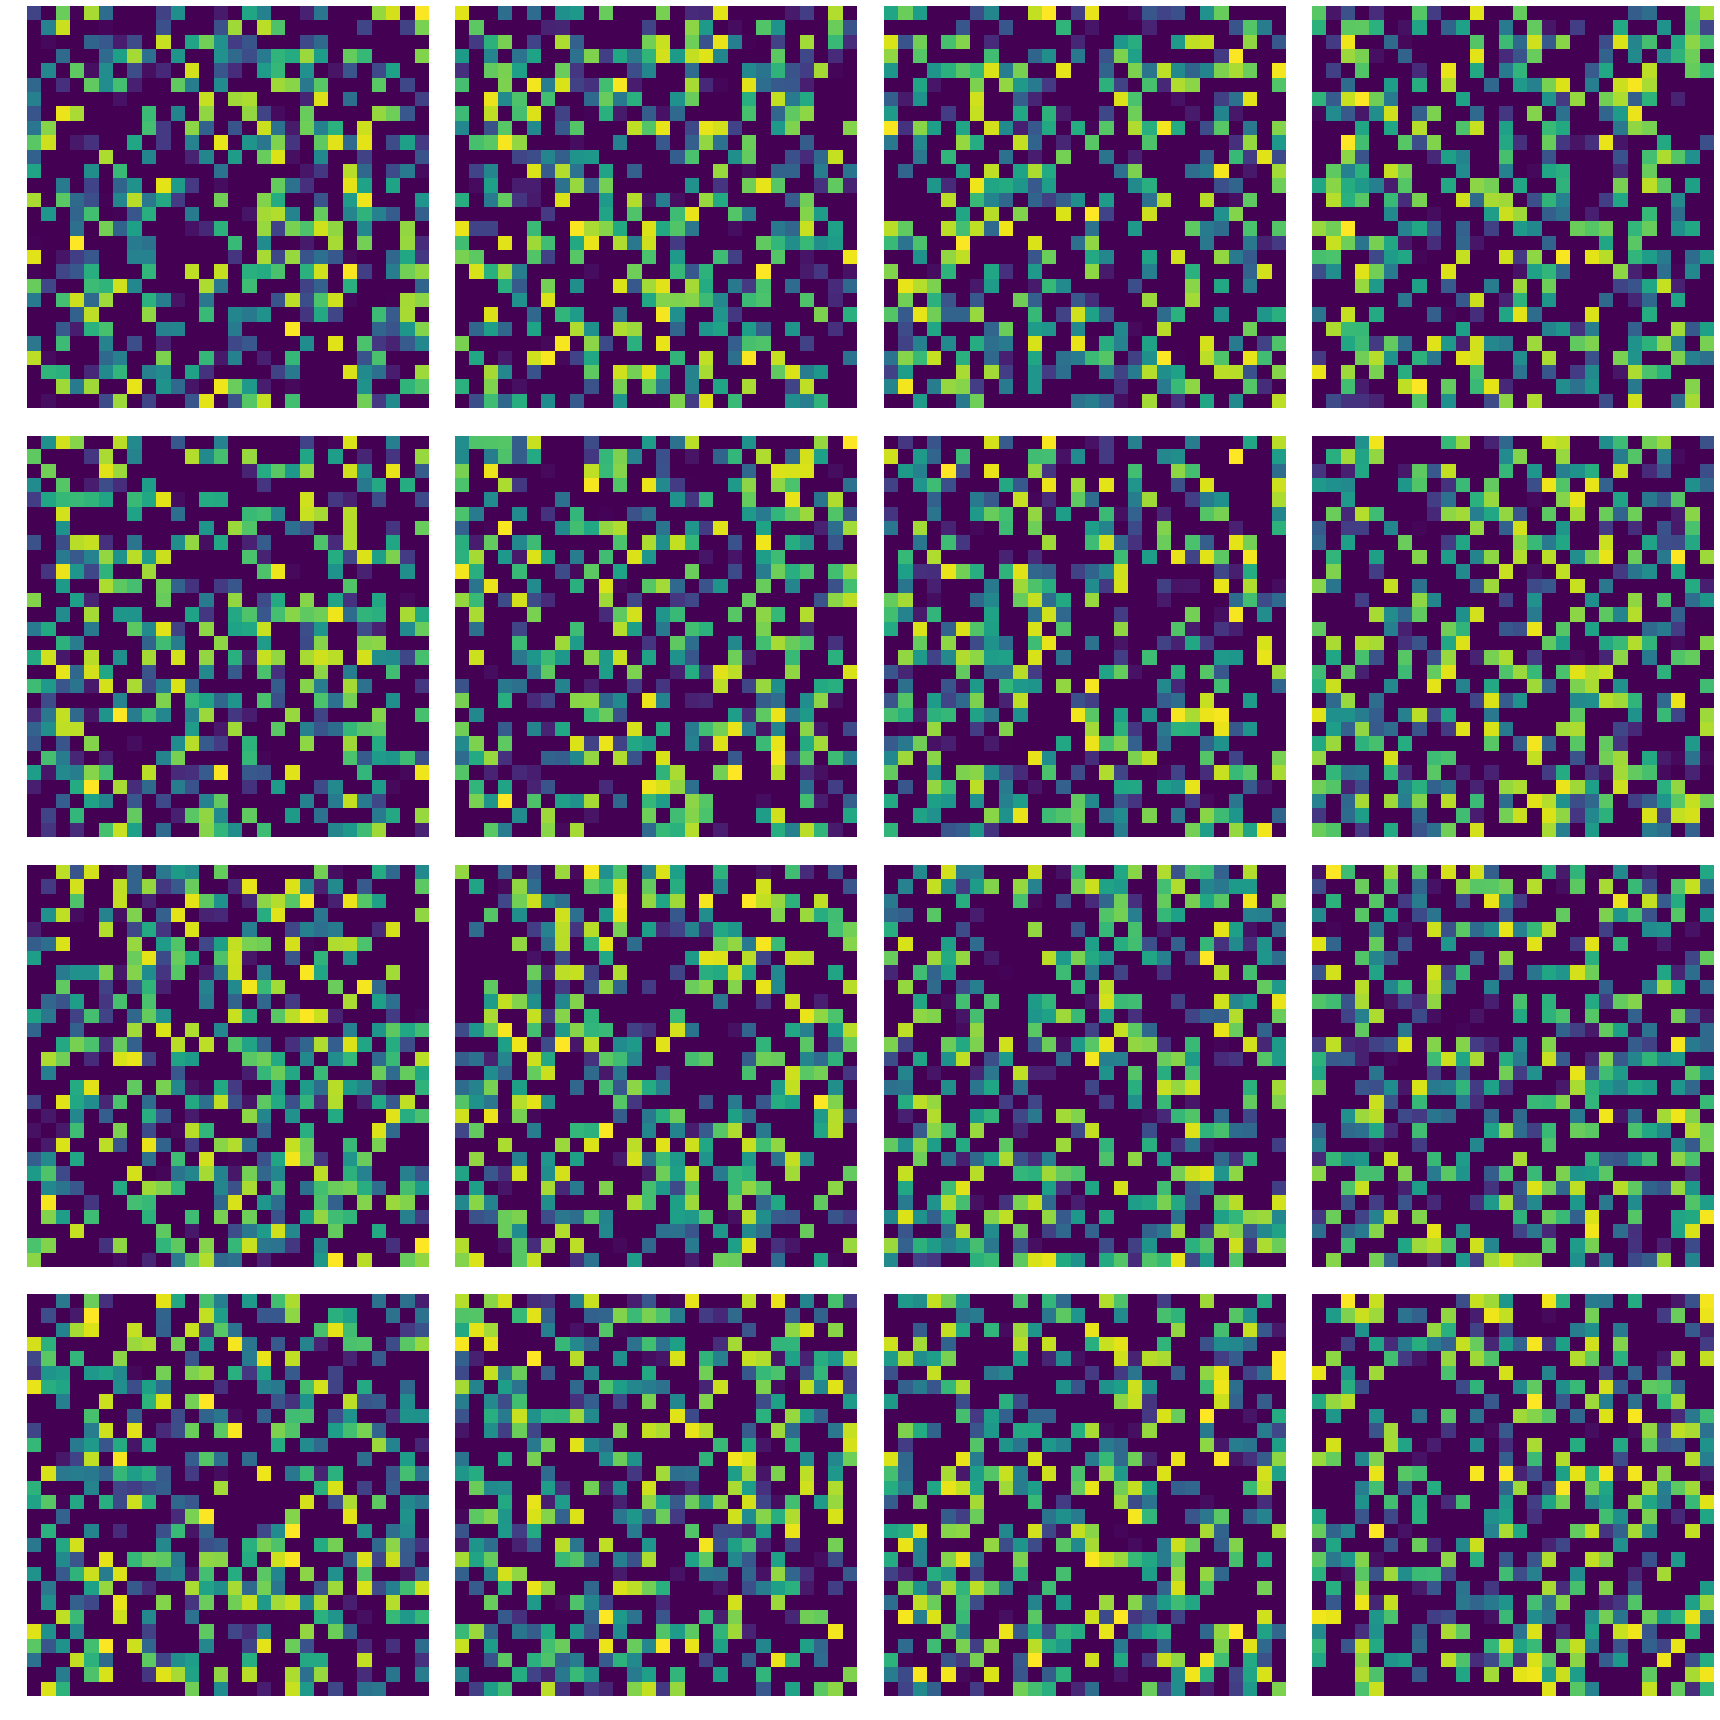

Epoch 1300, Generator loss 0.8911882042884827, discriminator loss 0.005043807905167341


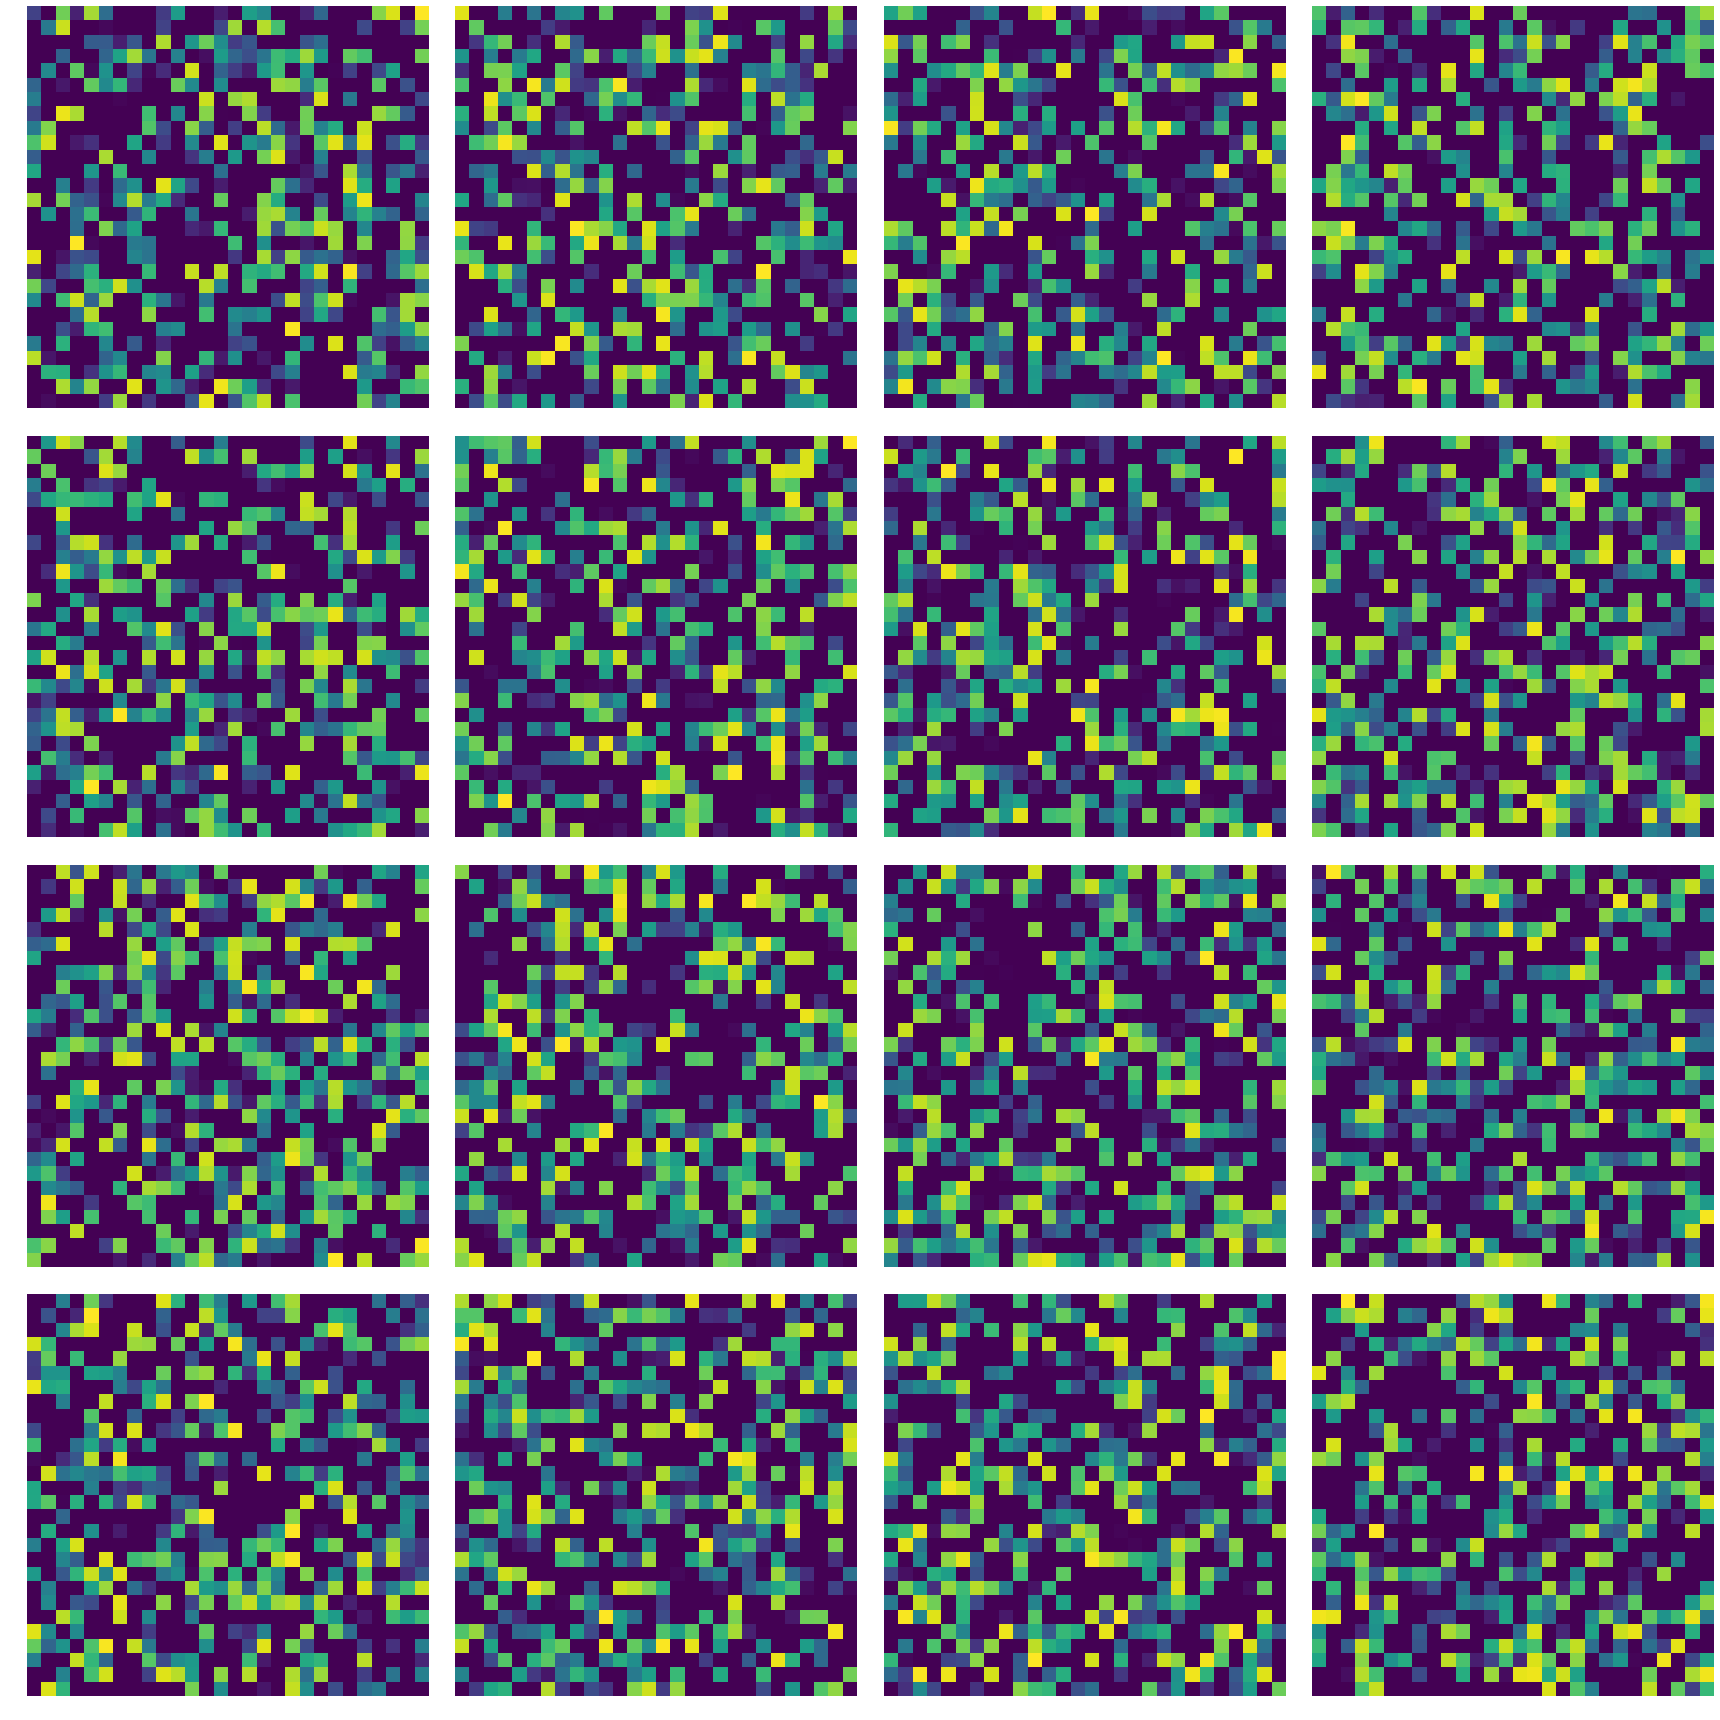

Epoch 1400, Generator loss 0.8816479444503784, discriminator loss 0.004950412083417177


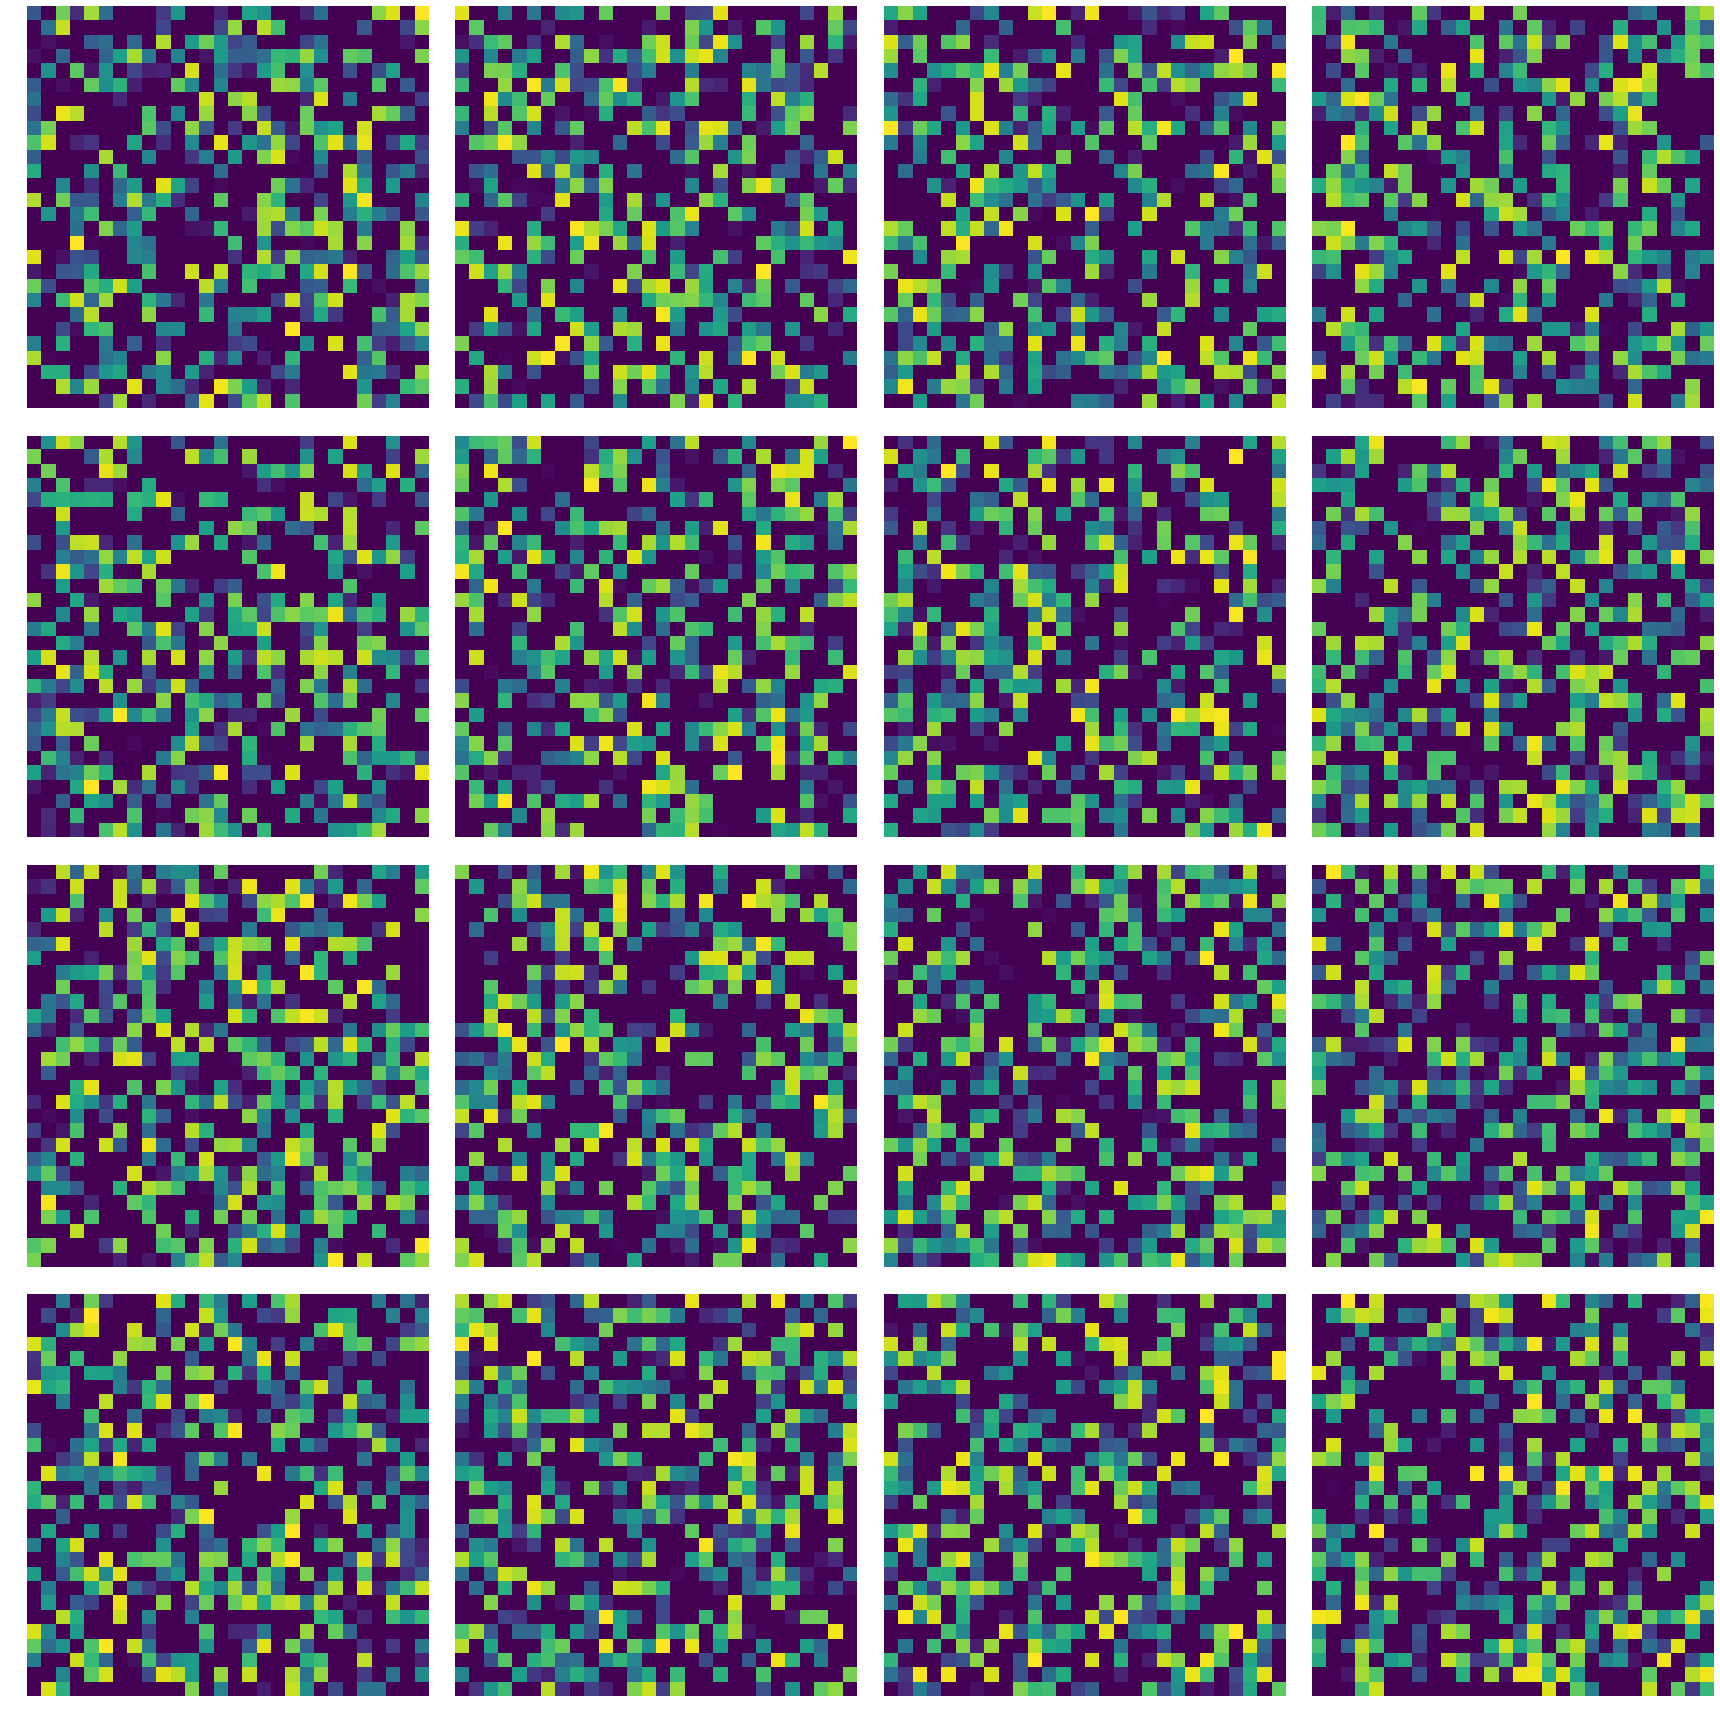

Epoch 1500, Generator loss 0.8681878447532654, discriminator loss 0.004846517462283373


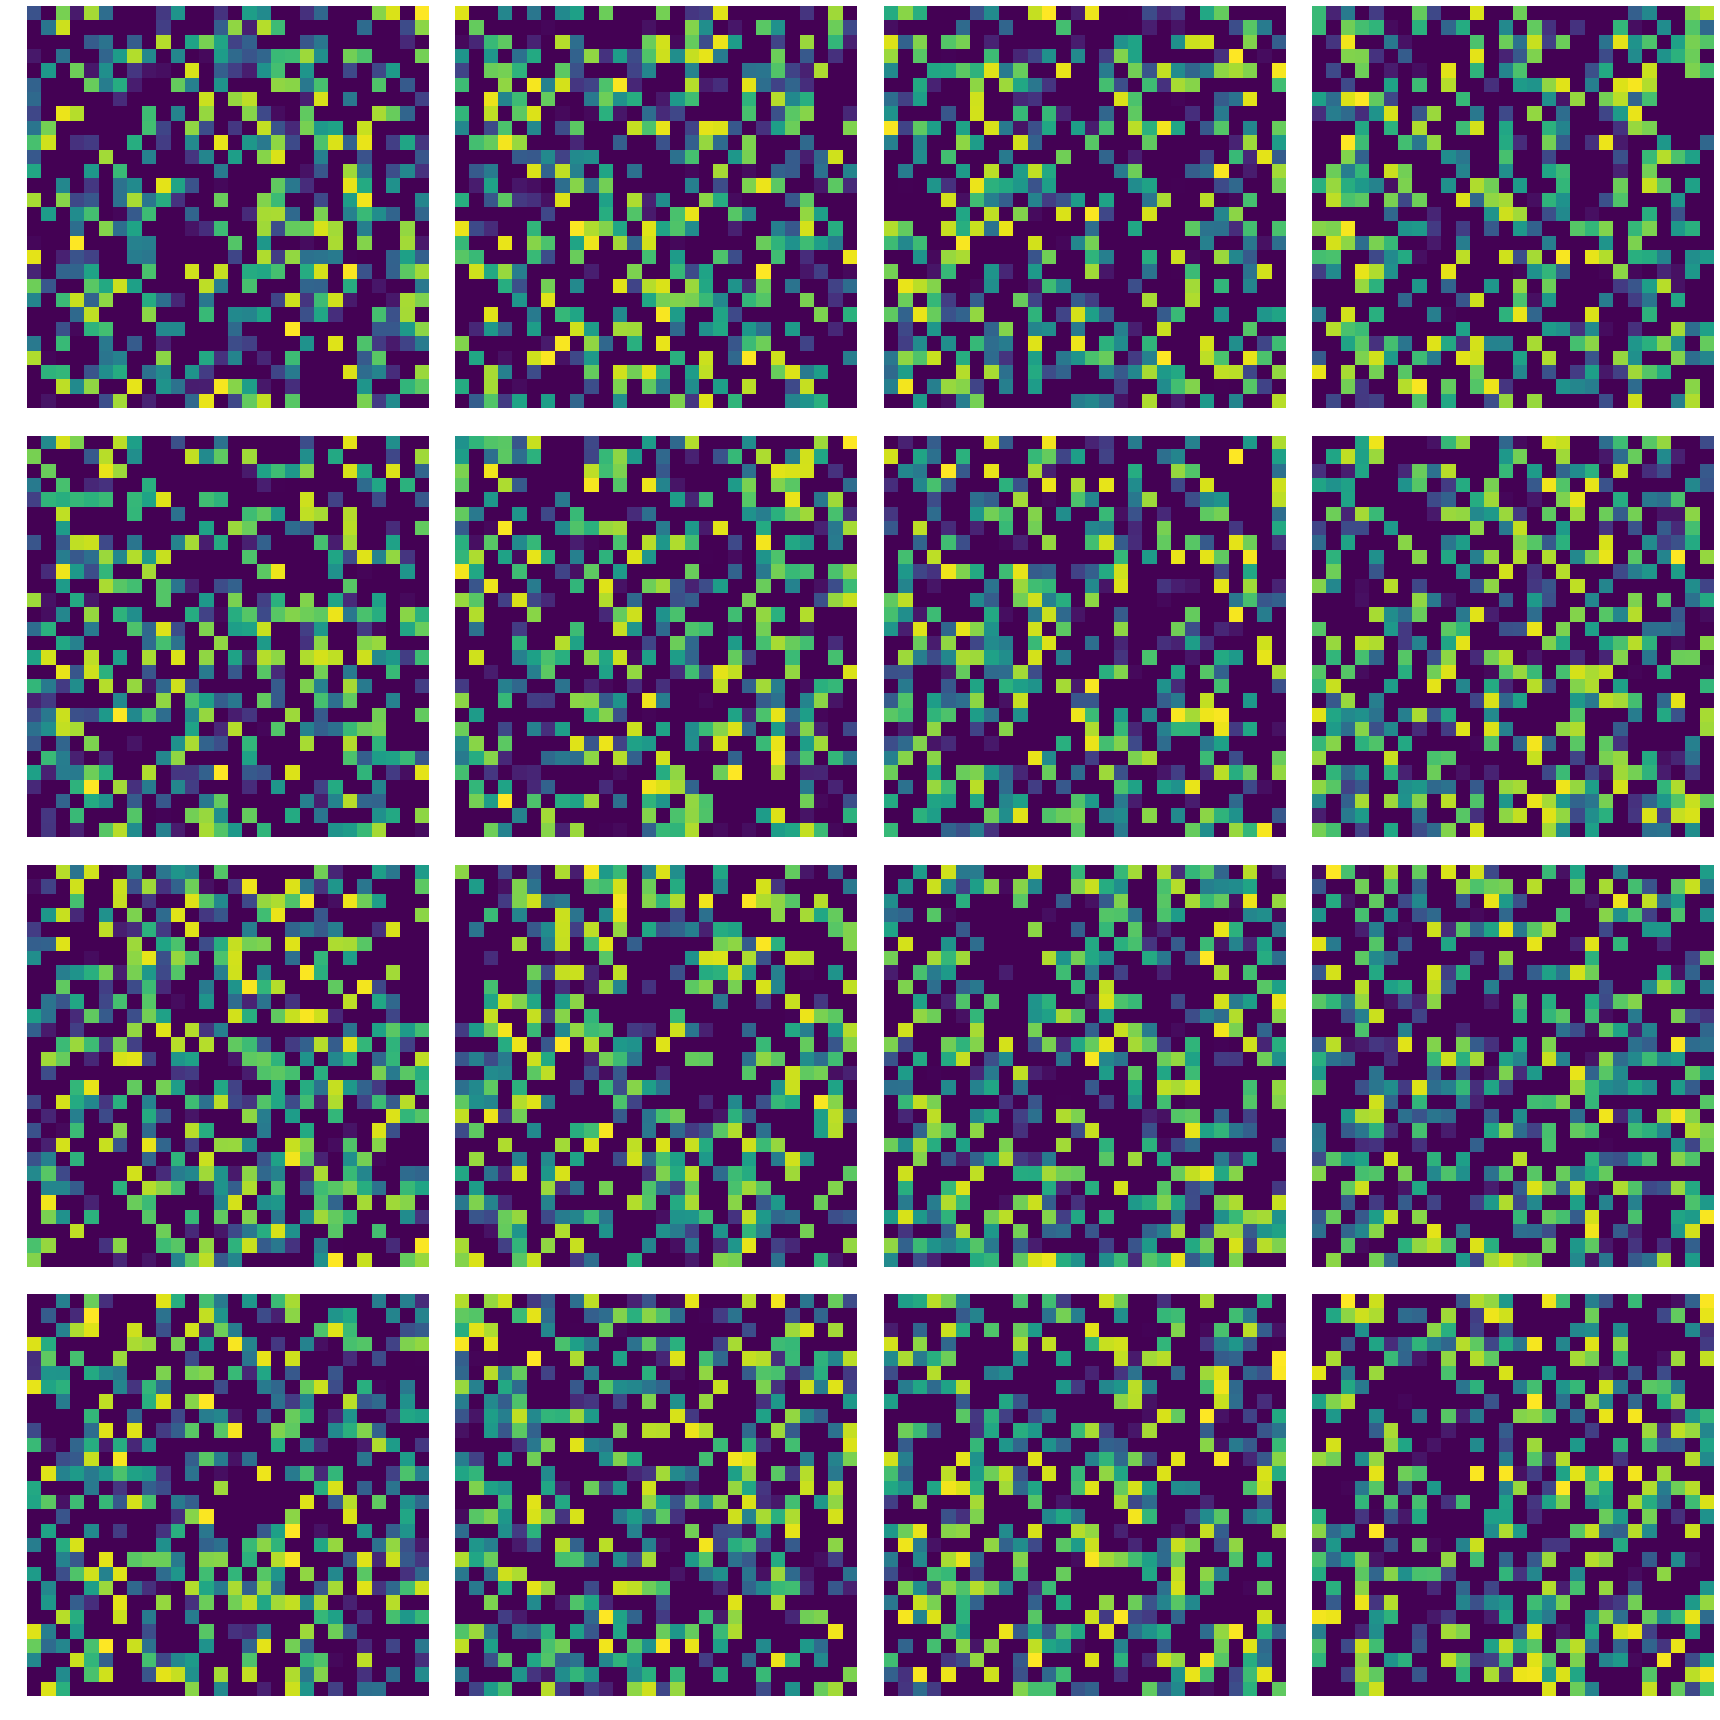

Epoch 1600, Generator loss 0.8661738634109497, discriminator loss 0.00475865975022316


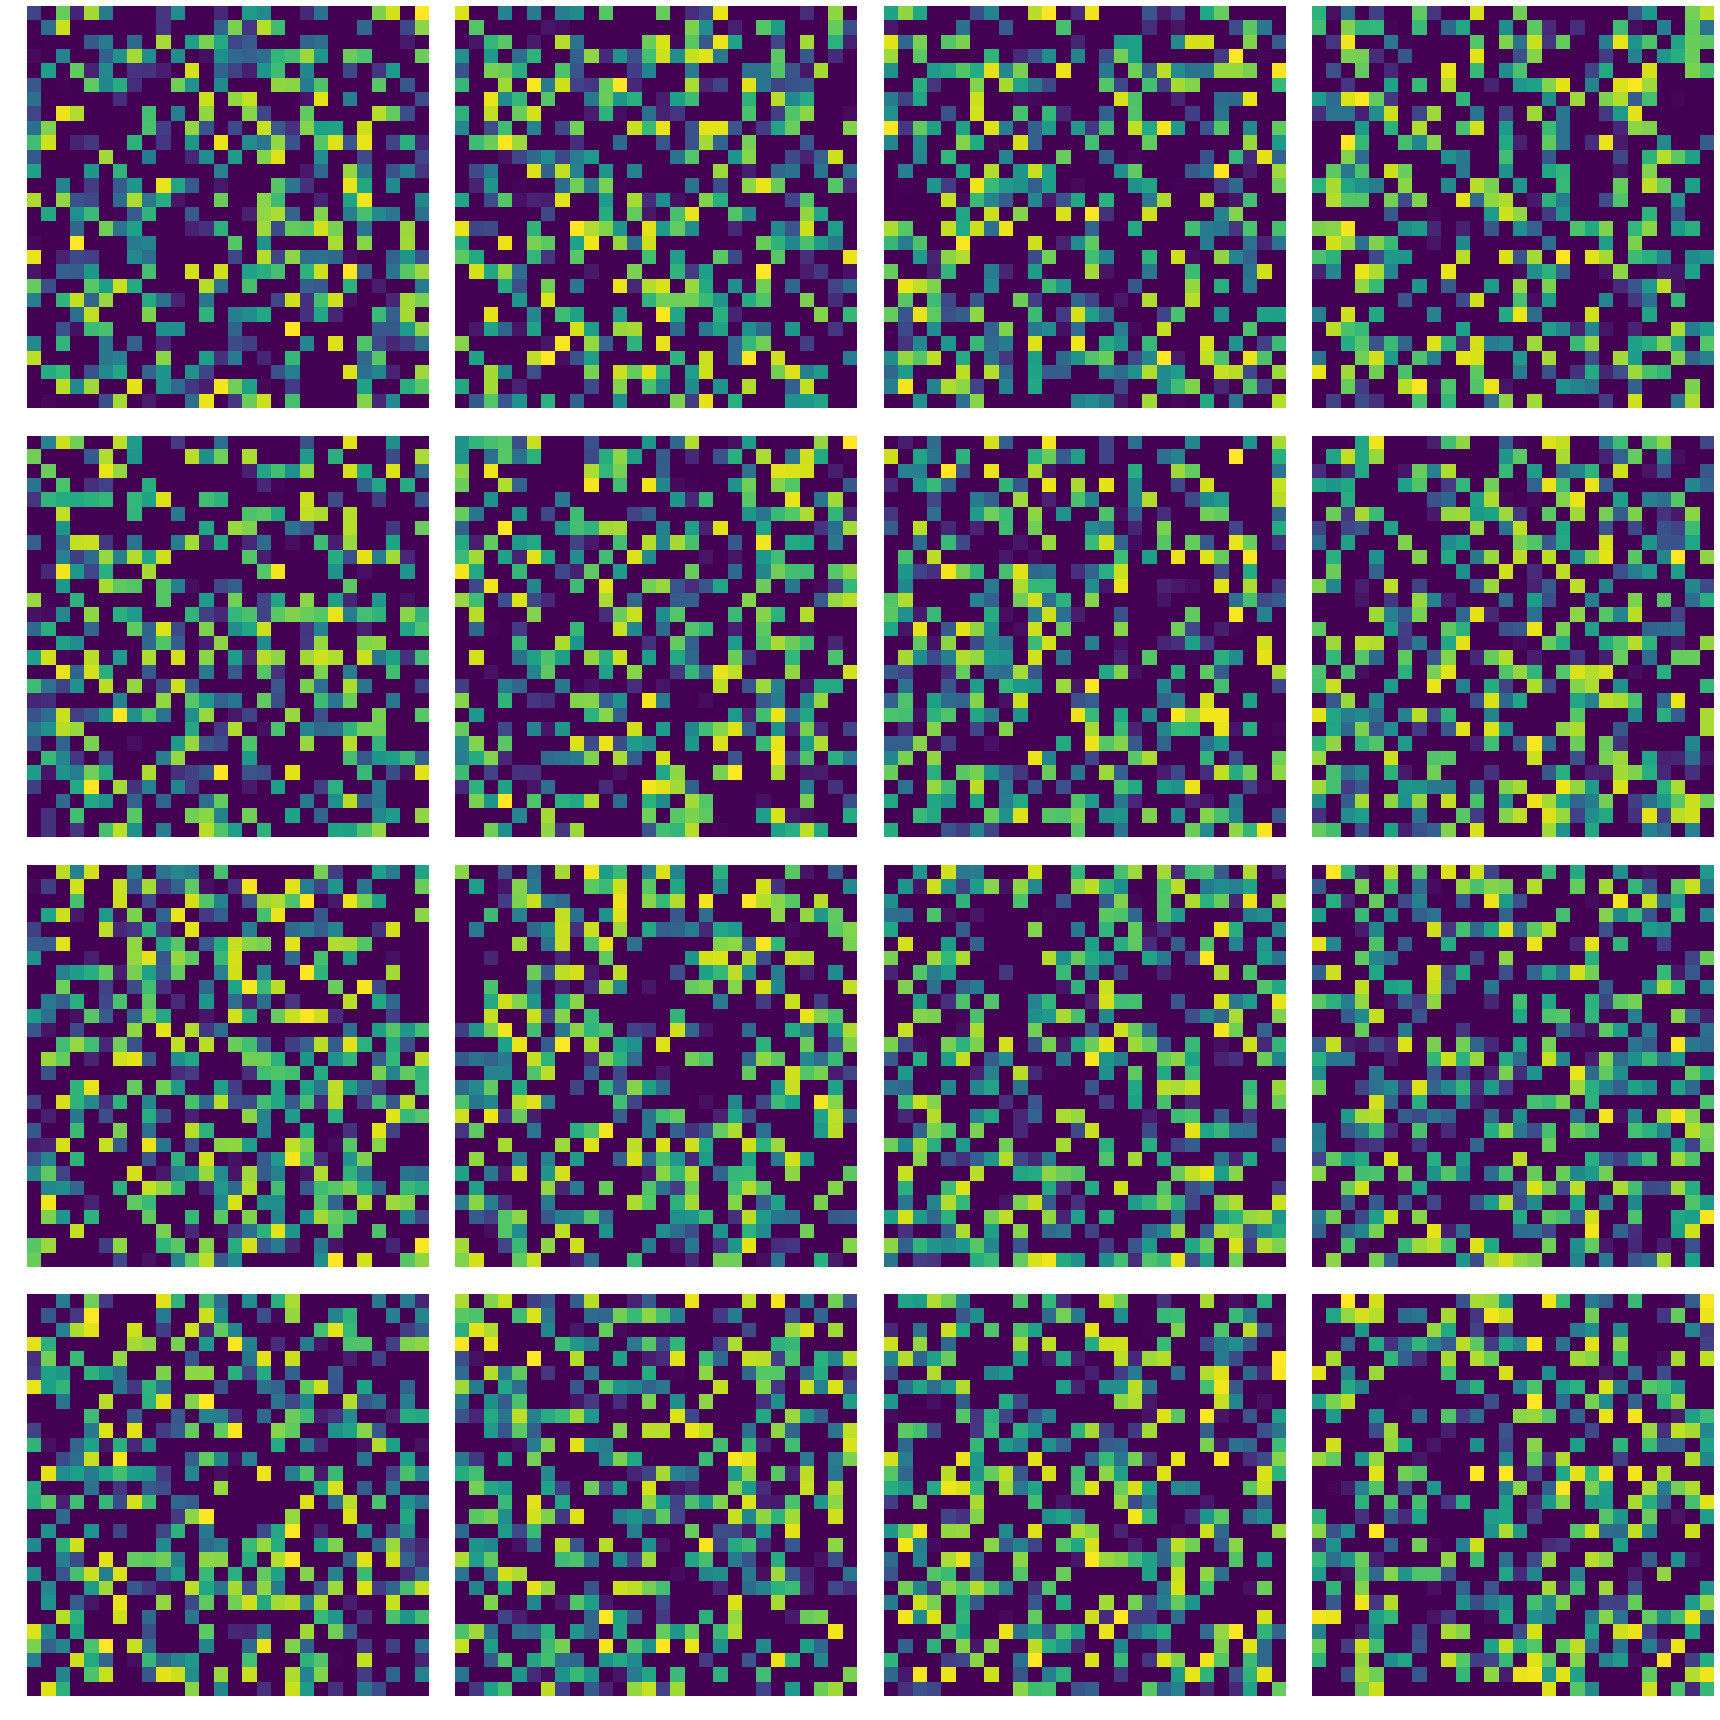

Epoch 1700, Generator loss 0.8510454297065735, discriminator loss 0.004667743109166622


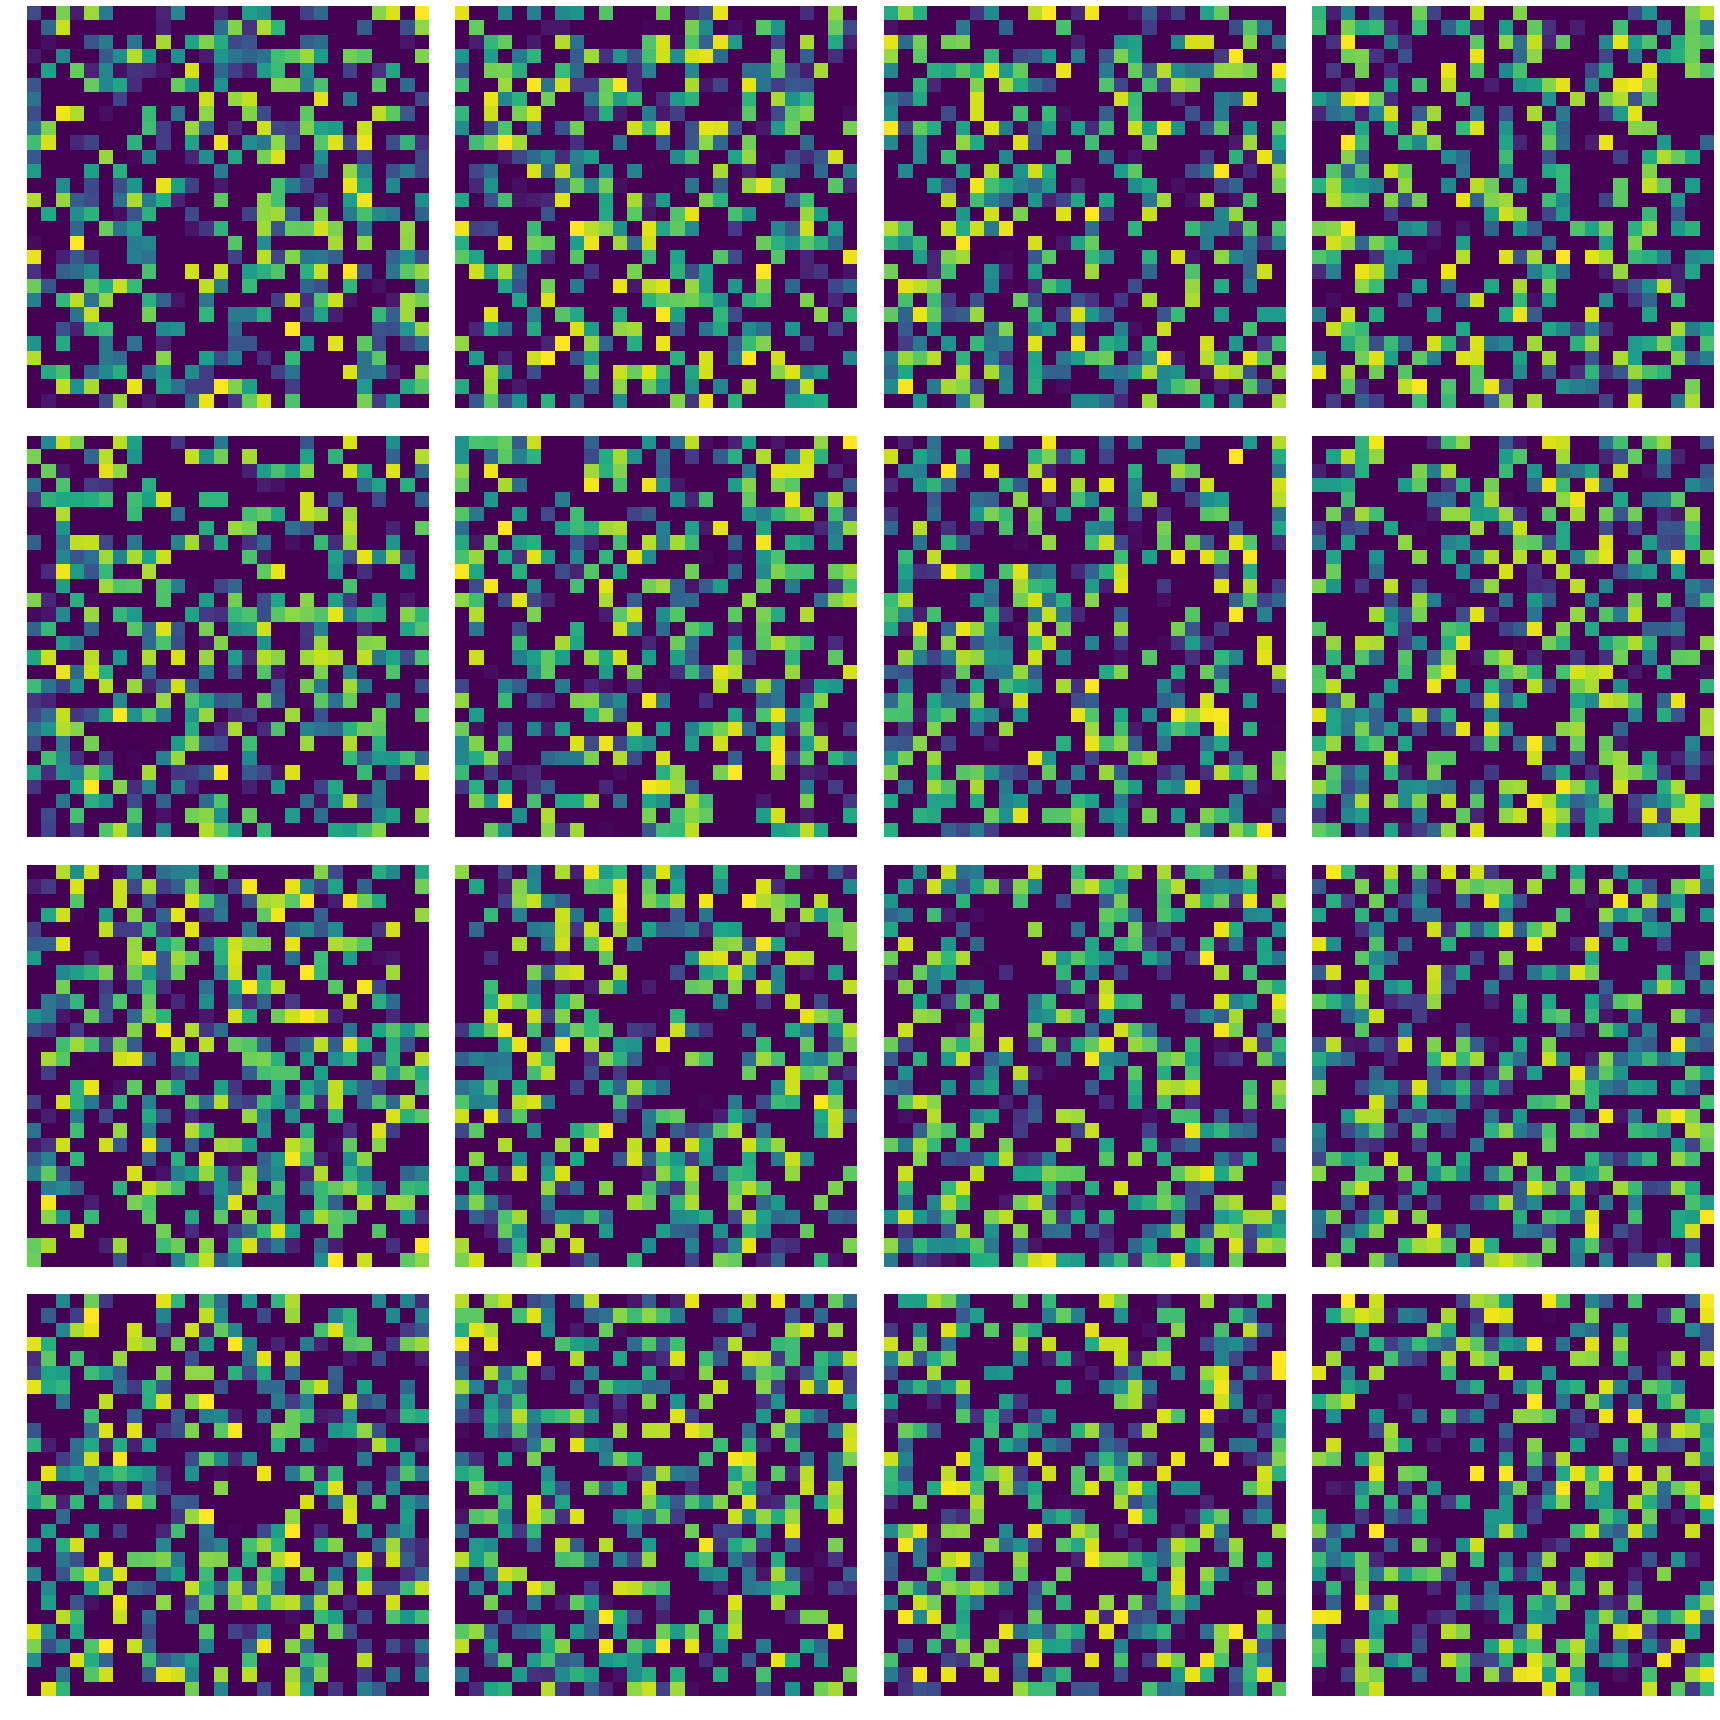

Epoch 1800, Generator loss 0.836478054523468, discriminator loss 0.004588964395225048


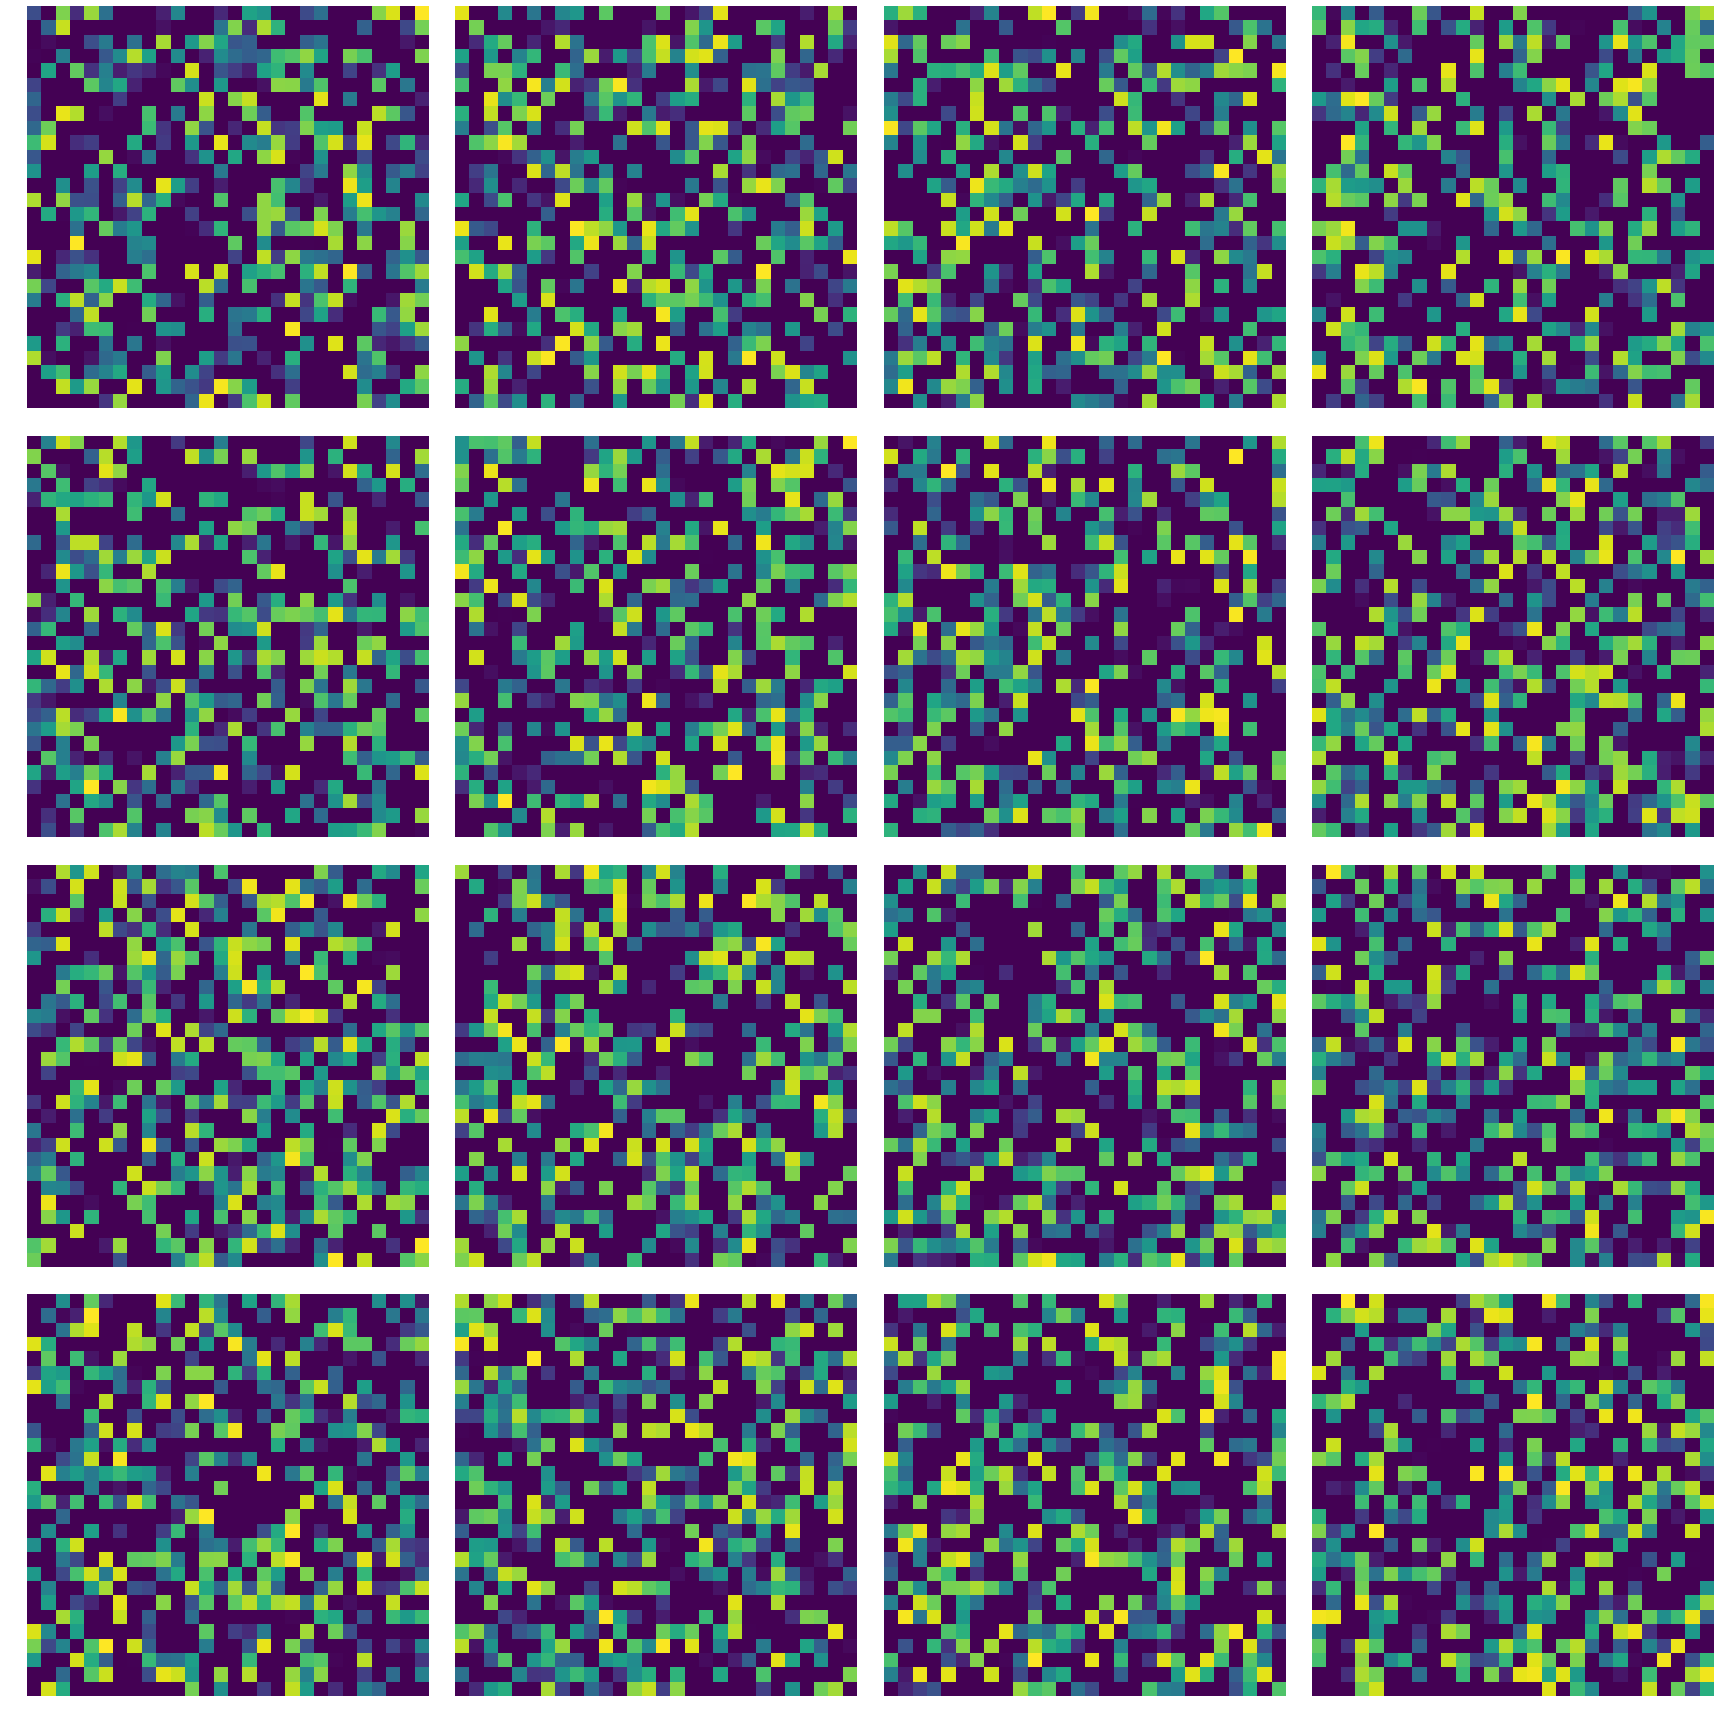

Epoch 1900, Generator loss 0.8182027339935303, discriminator loss 0.004508469253778458


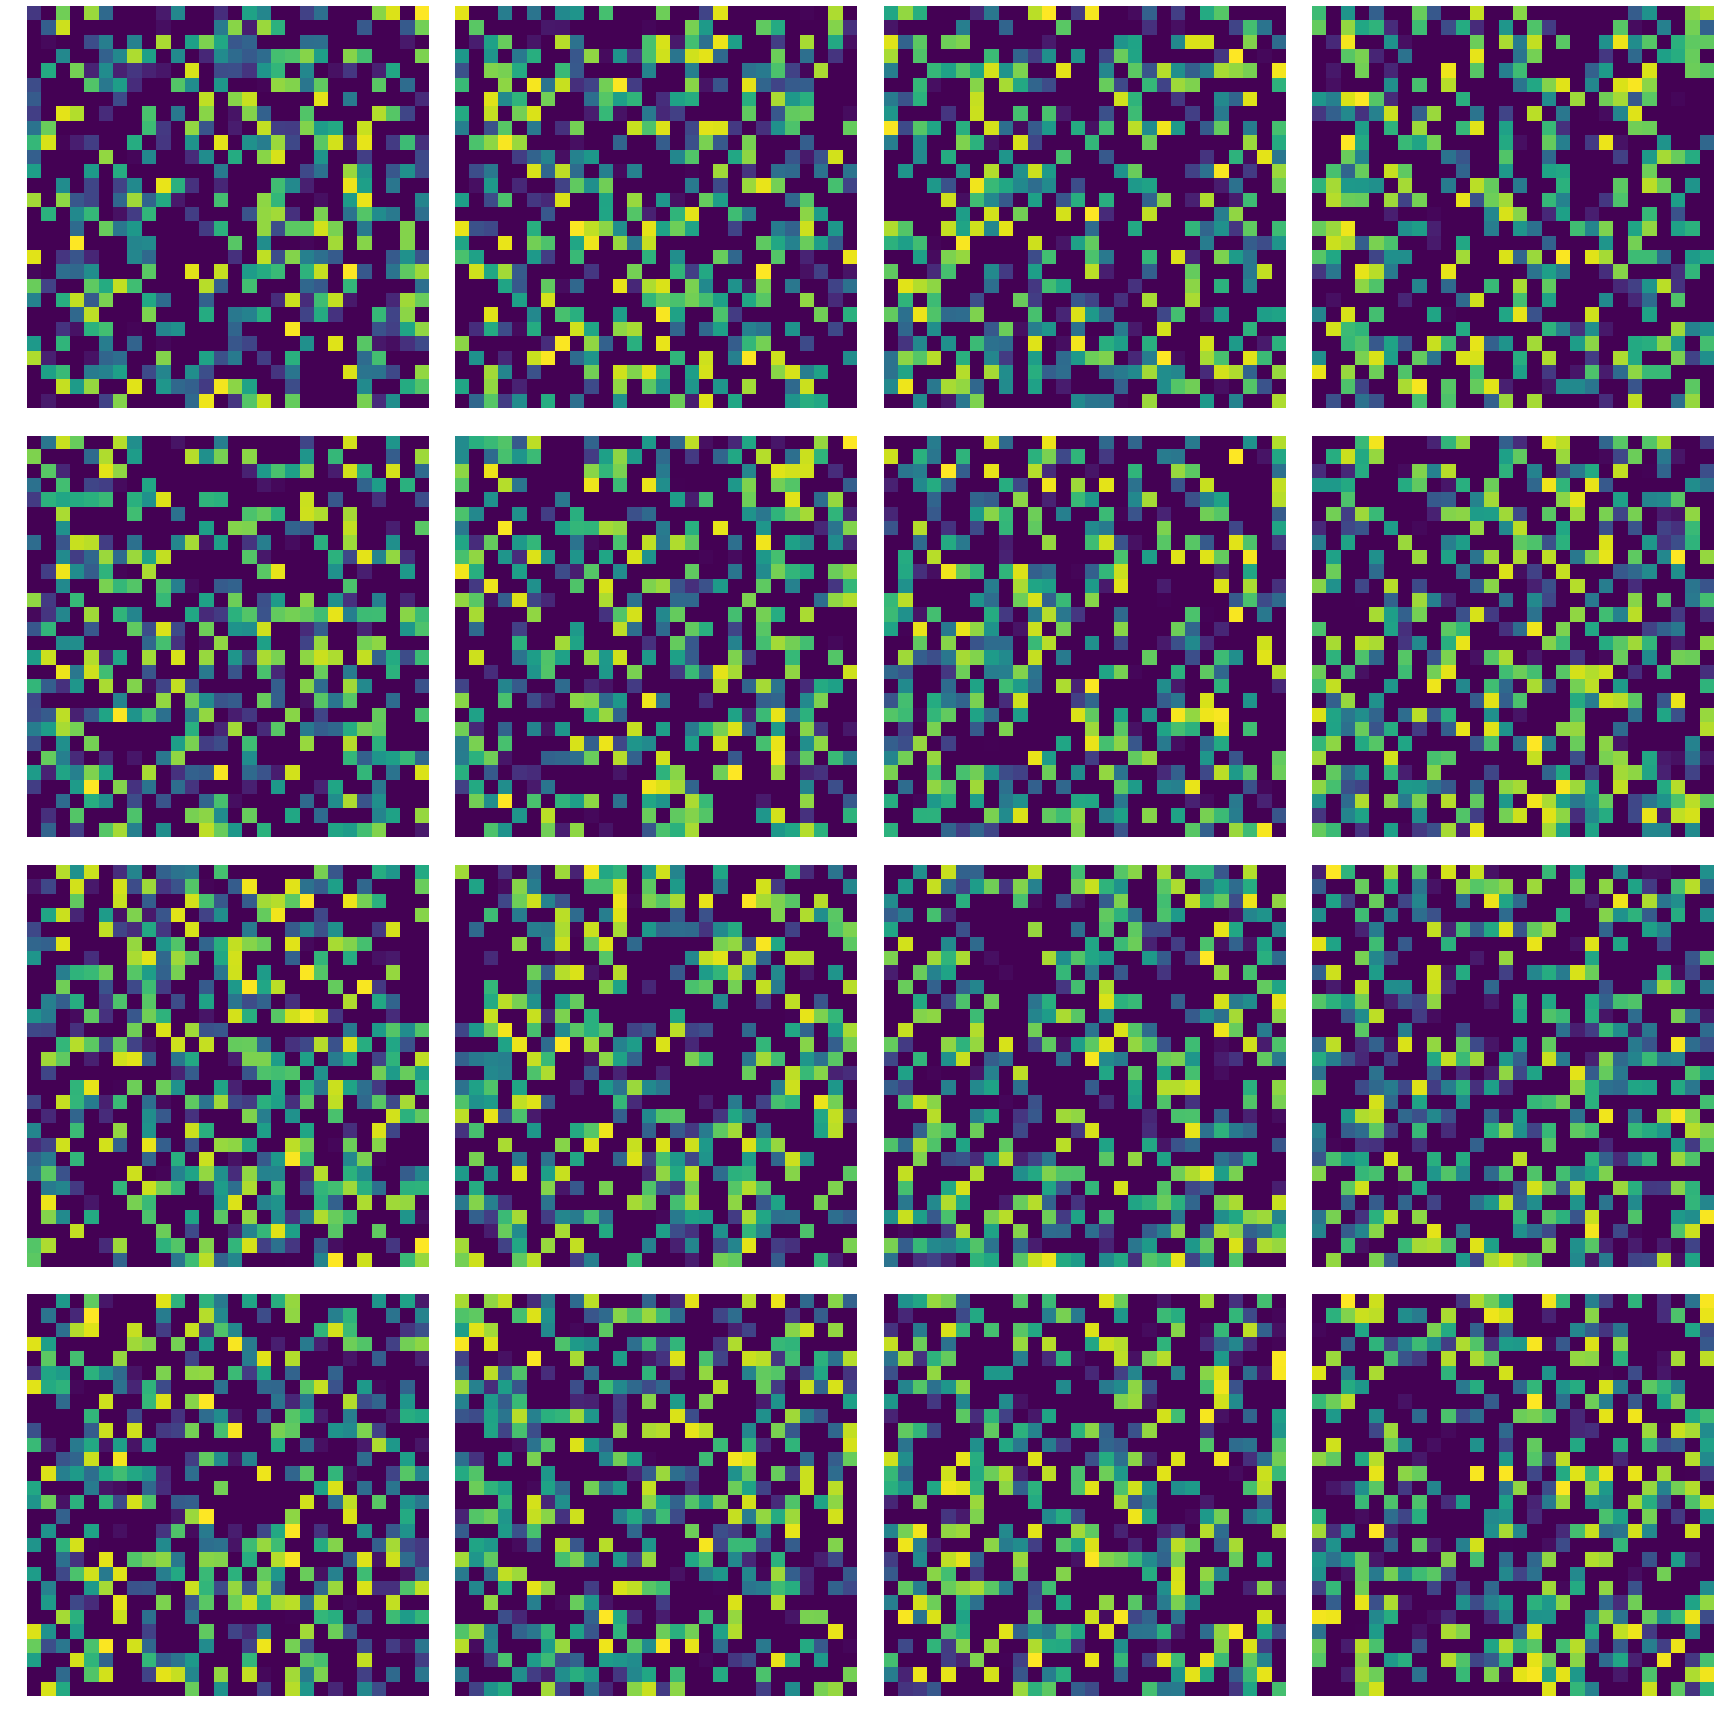

Epoch 2000, Generator loss 0.8150680661201477, discriminator loss 0.004422960802912712


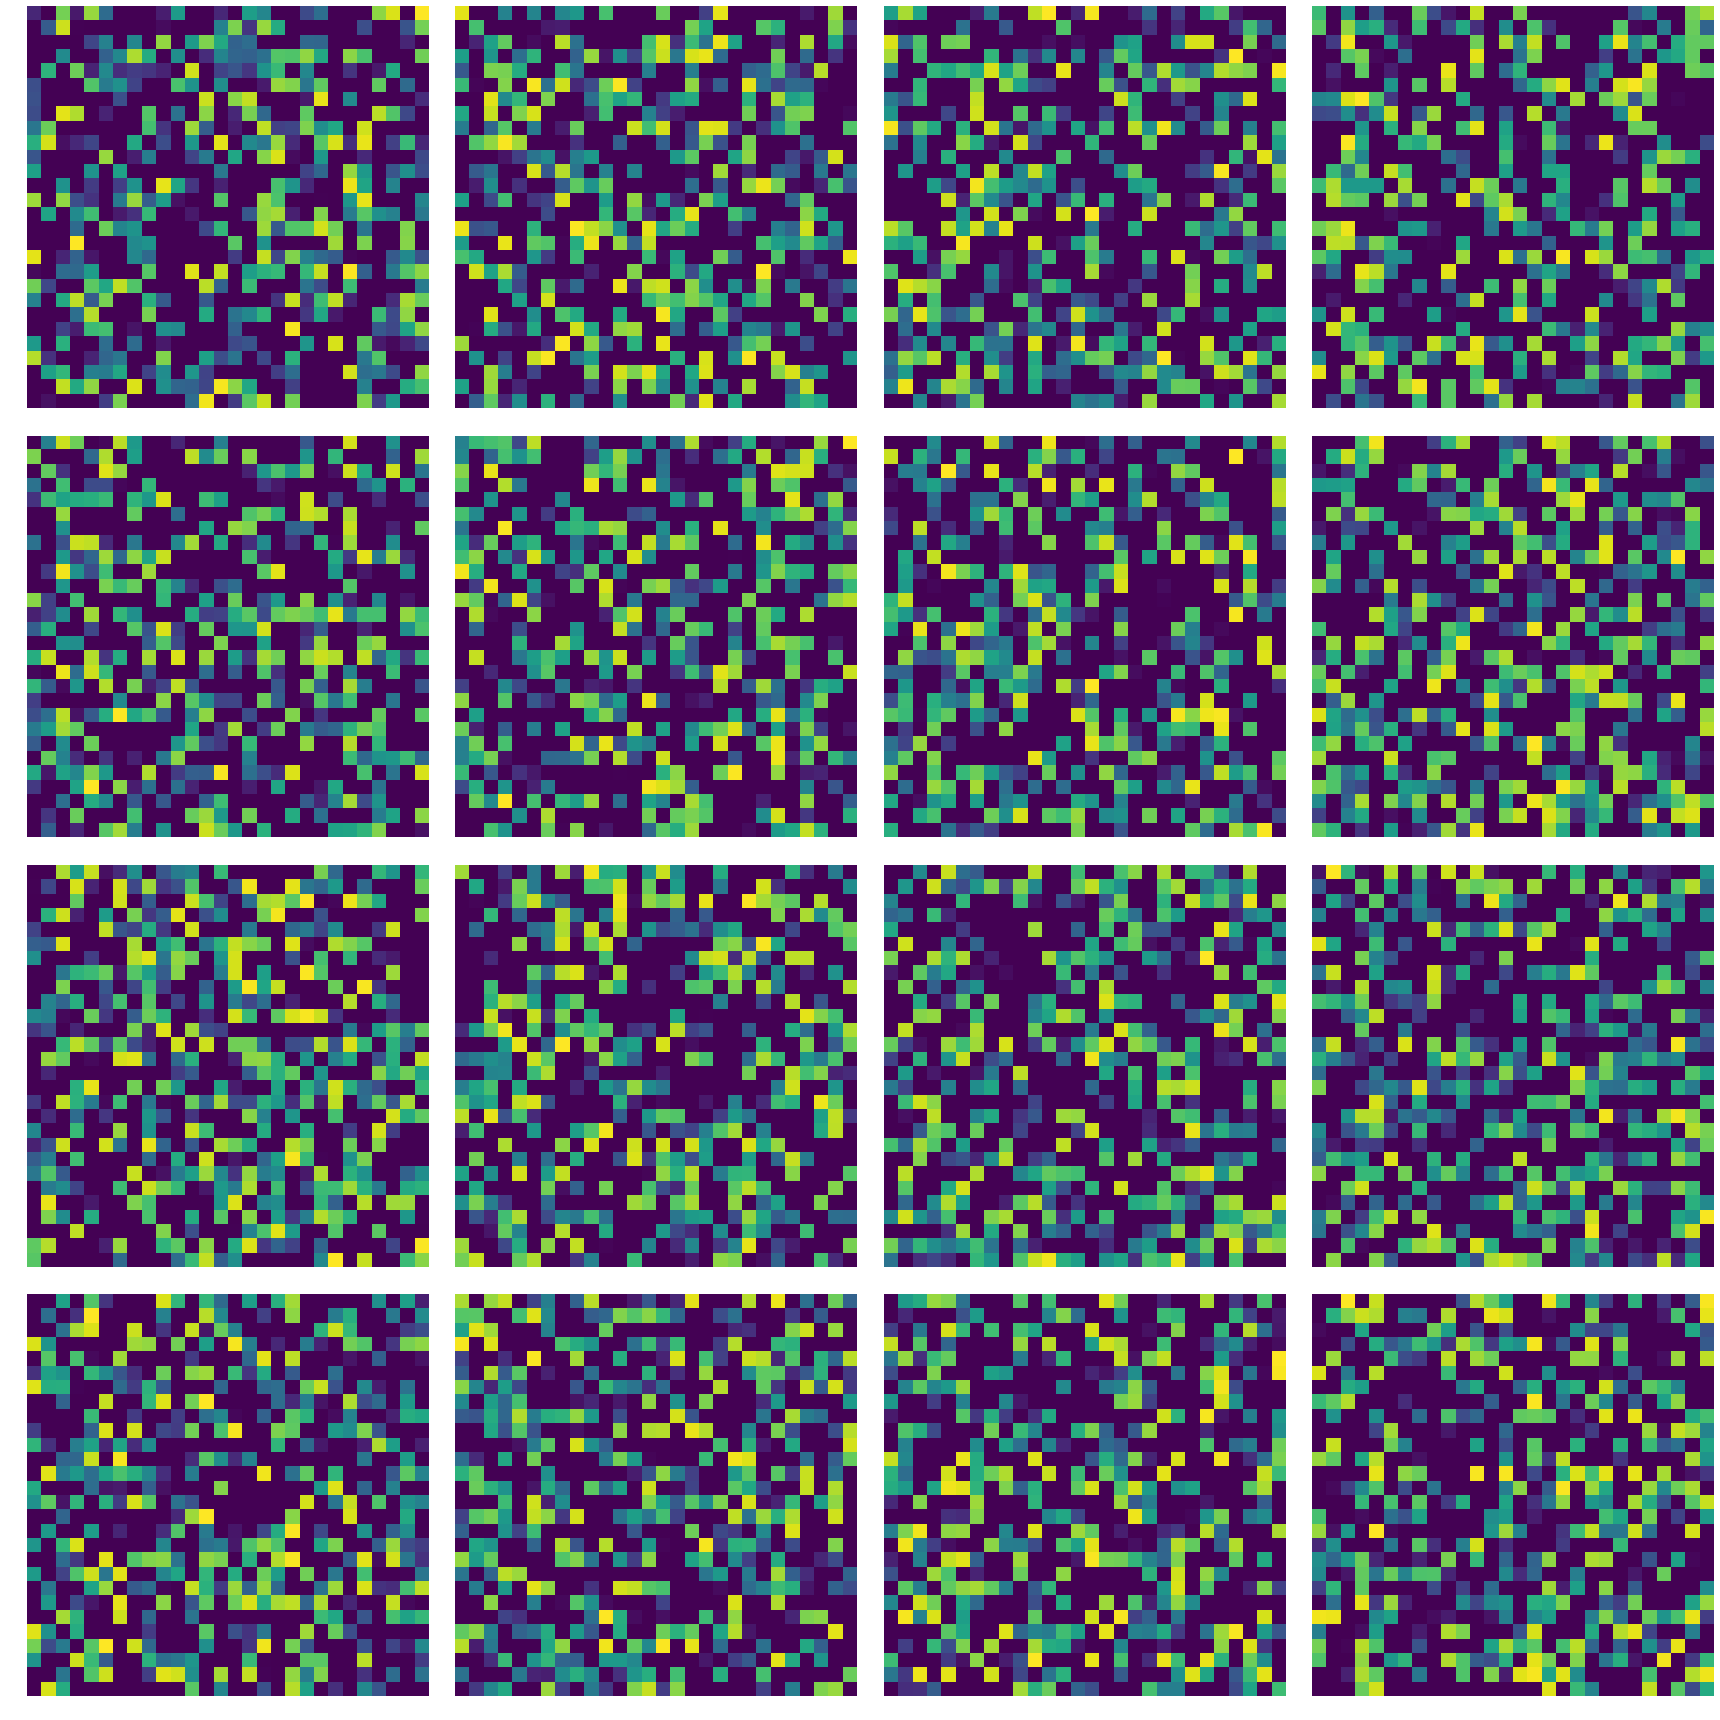

Epoch 2100, Generator loss 0.8031840324401855, discriminator loss 0.004350994247943163


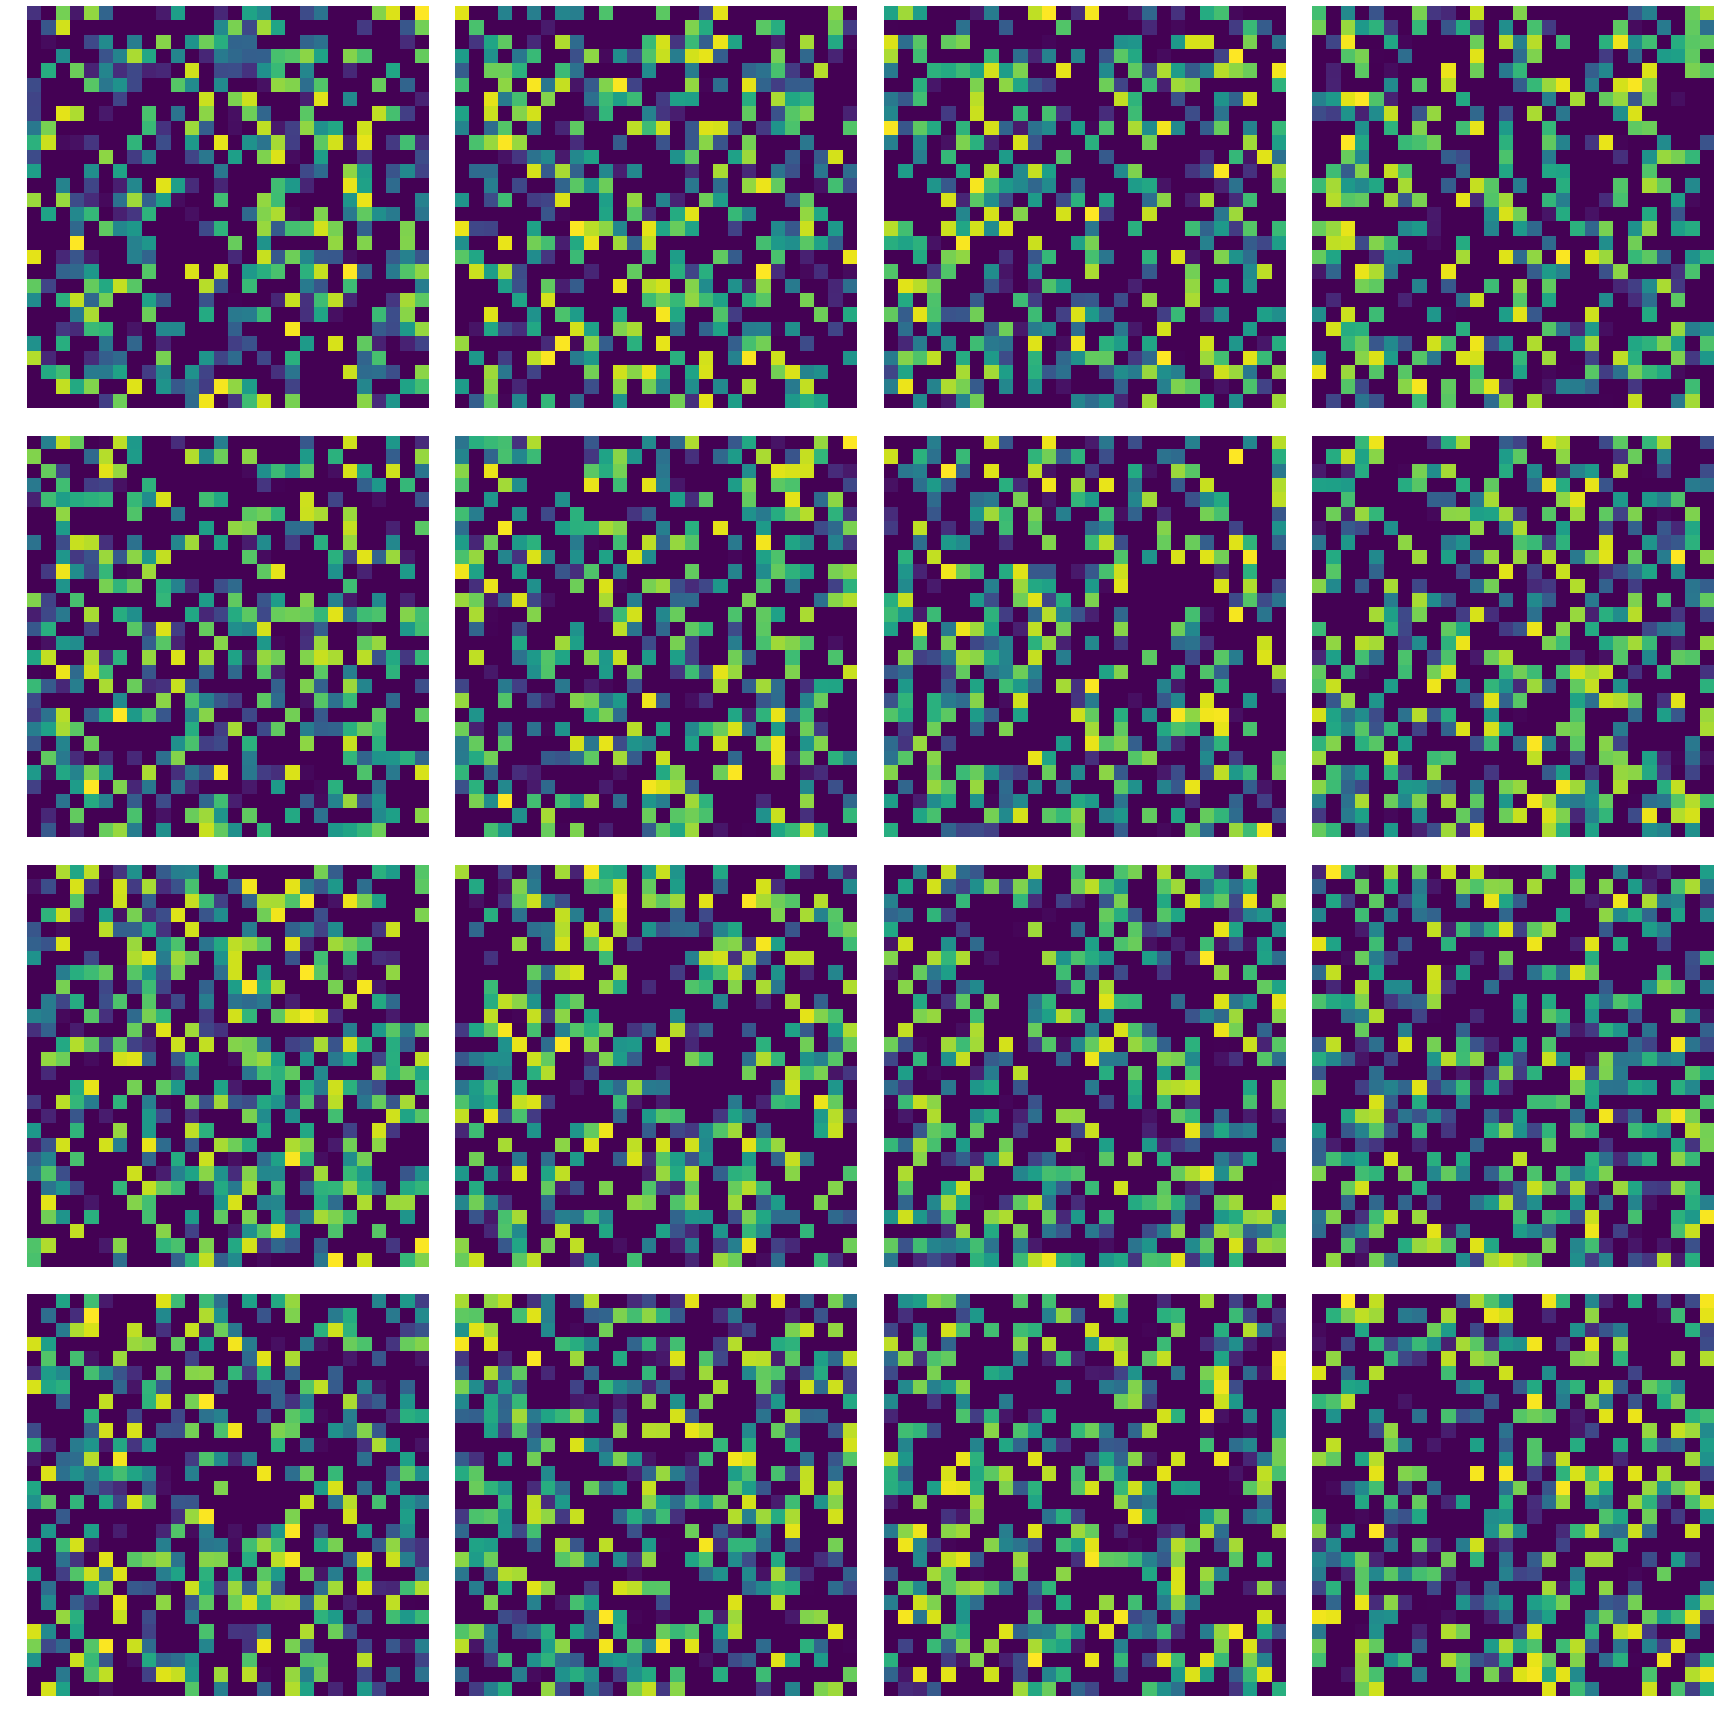

Epoch 2200, Generator loss 0.7938960194587708, discriminator loss 0.004274764098227024


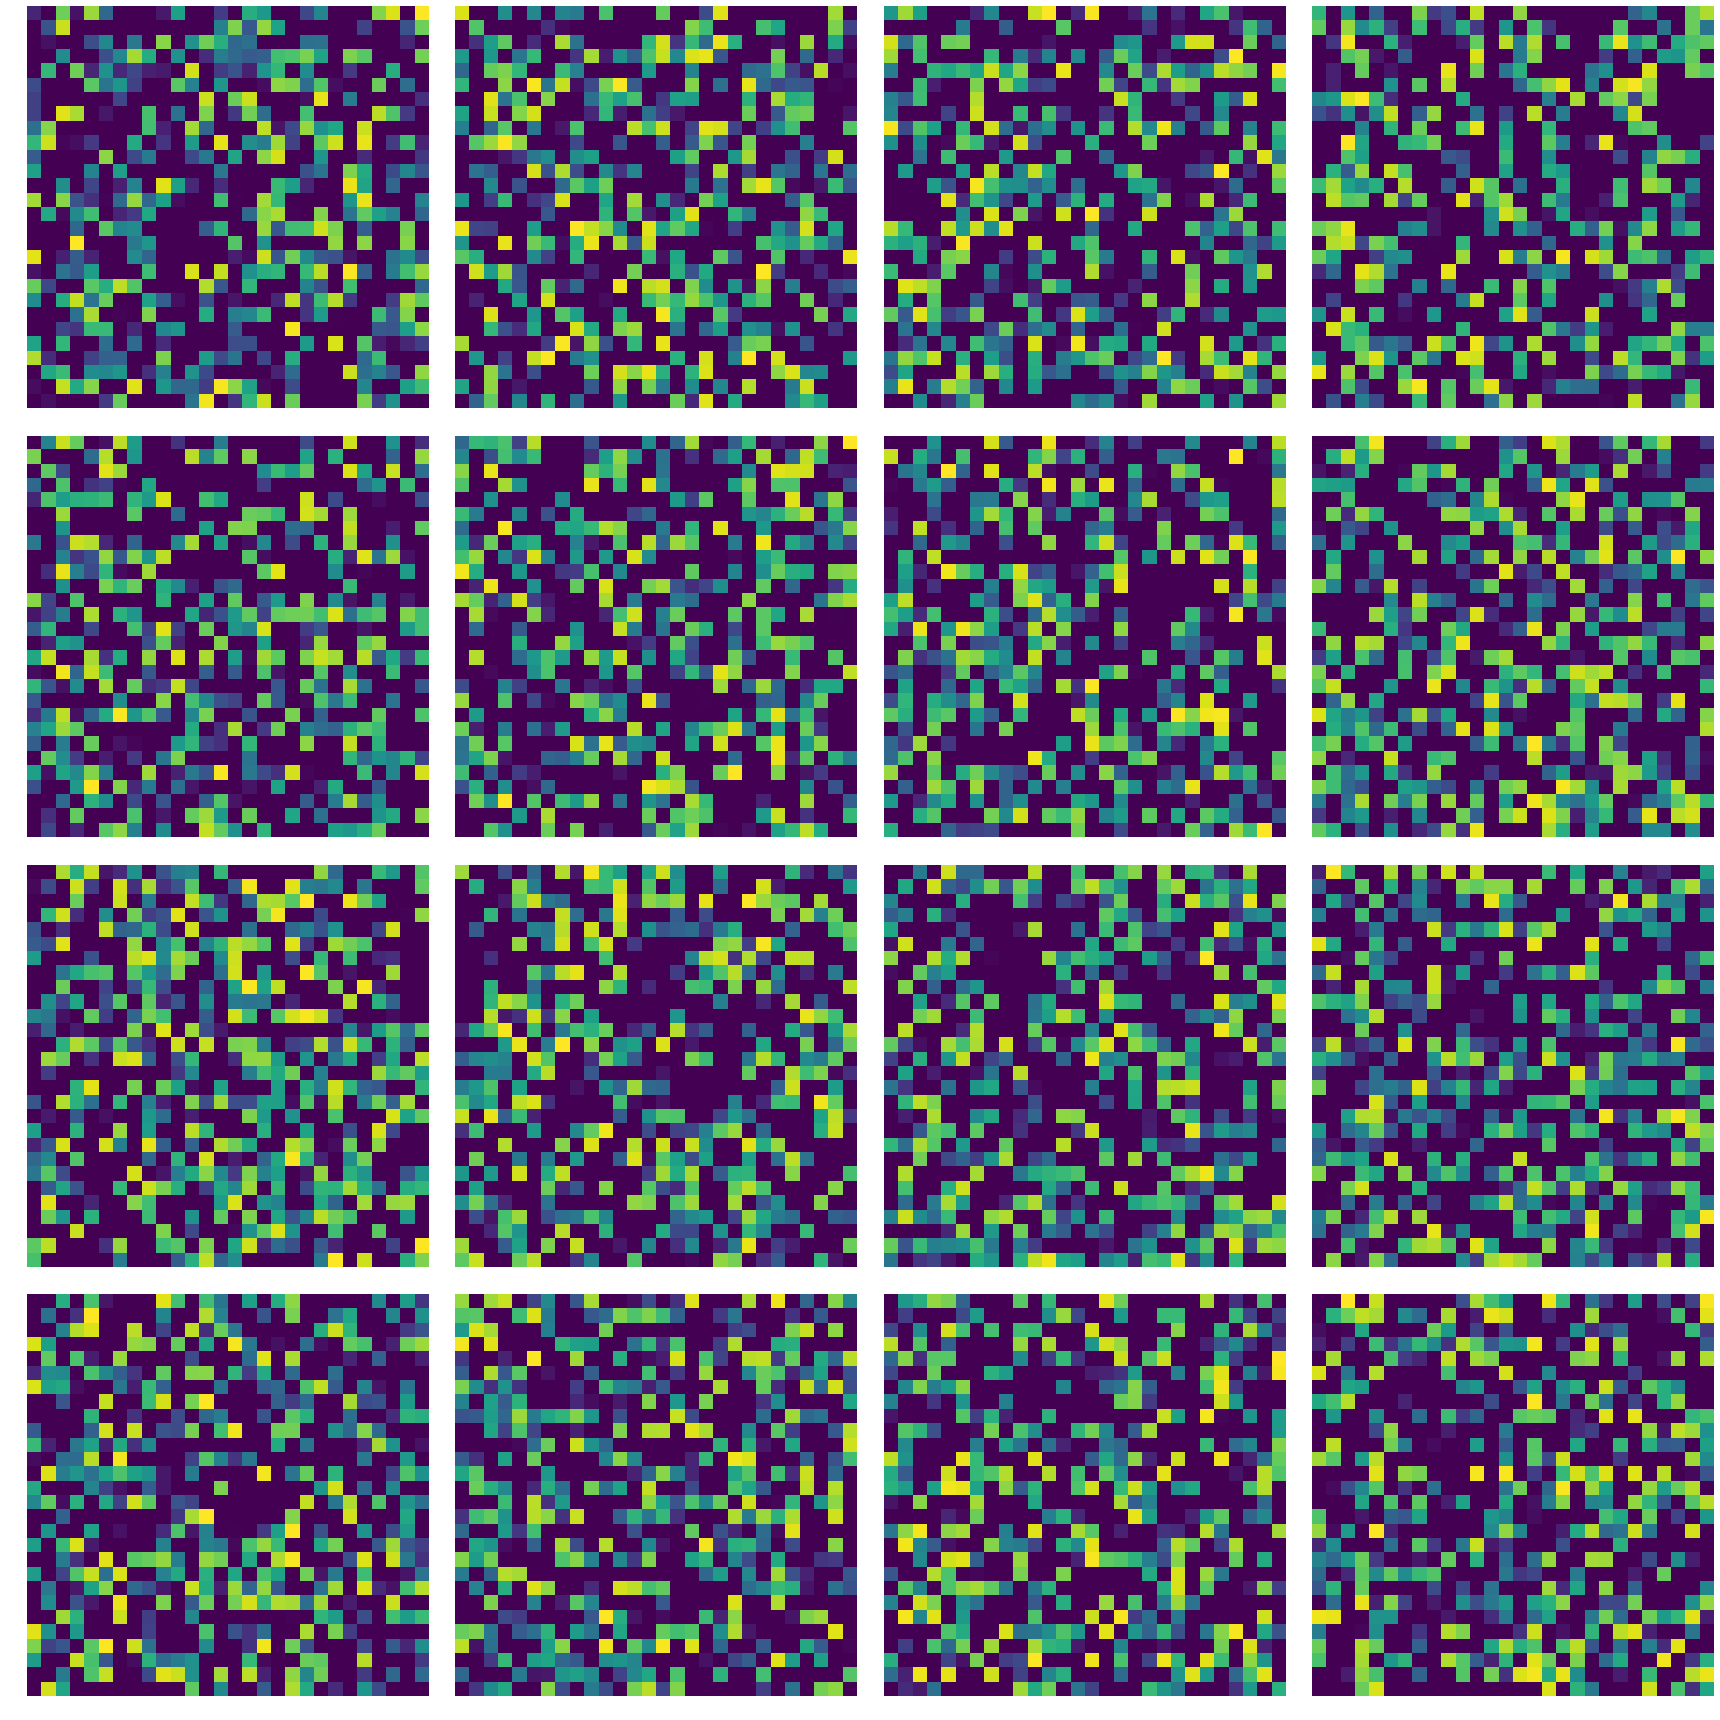

Epoch 2300, Generator loss 0.7803674936294556, discriminator loss 0.004196767695248127


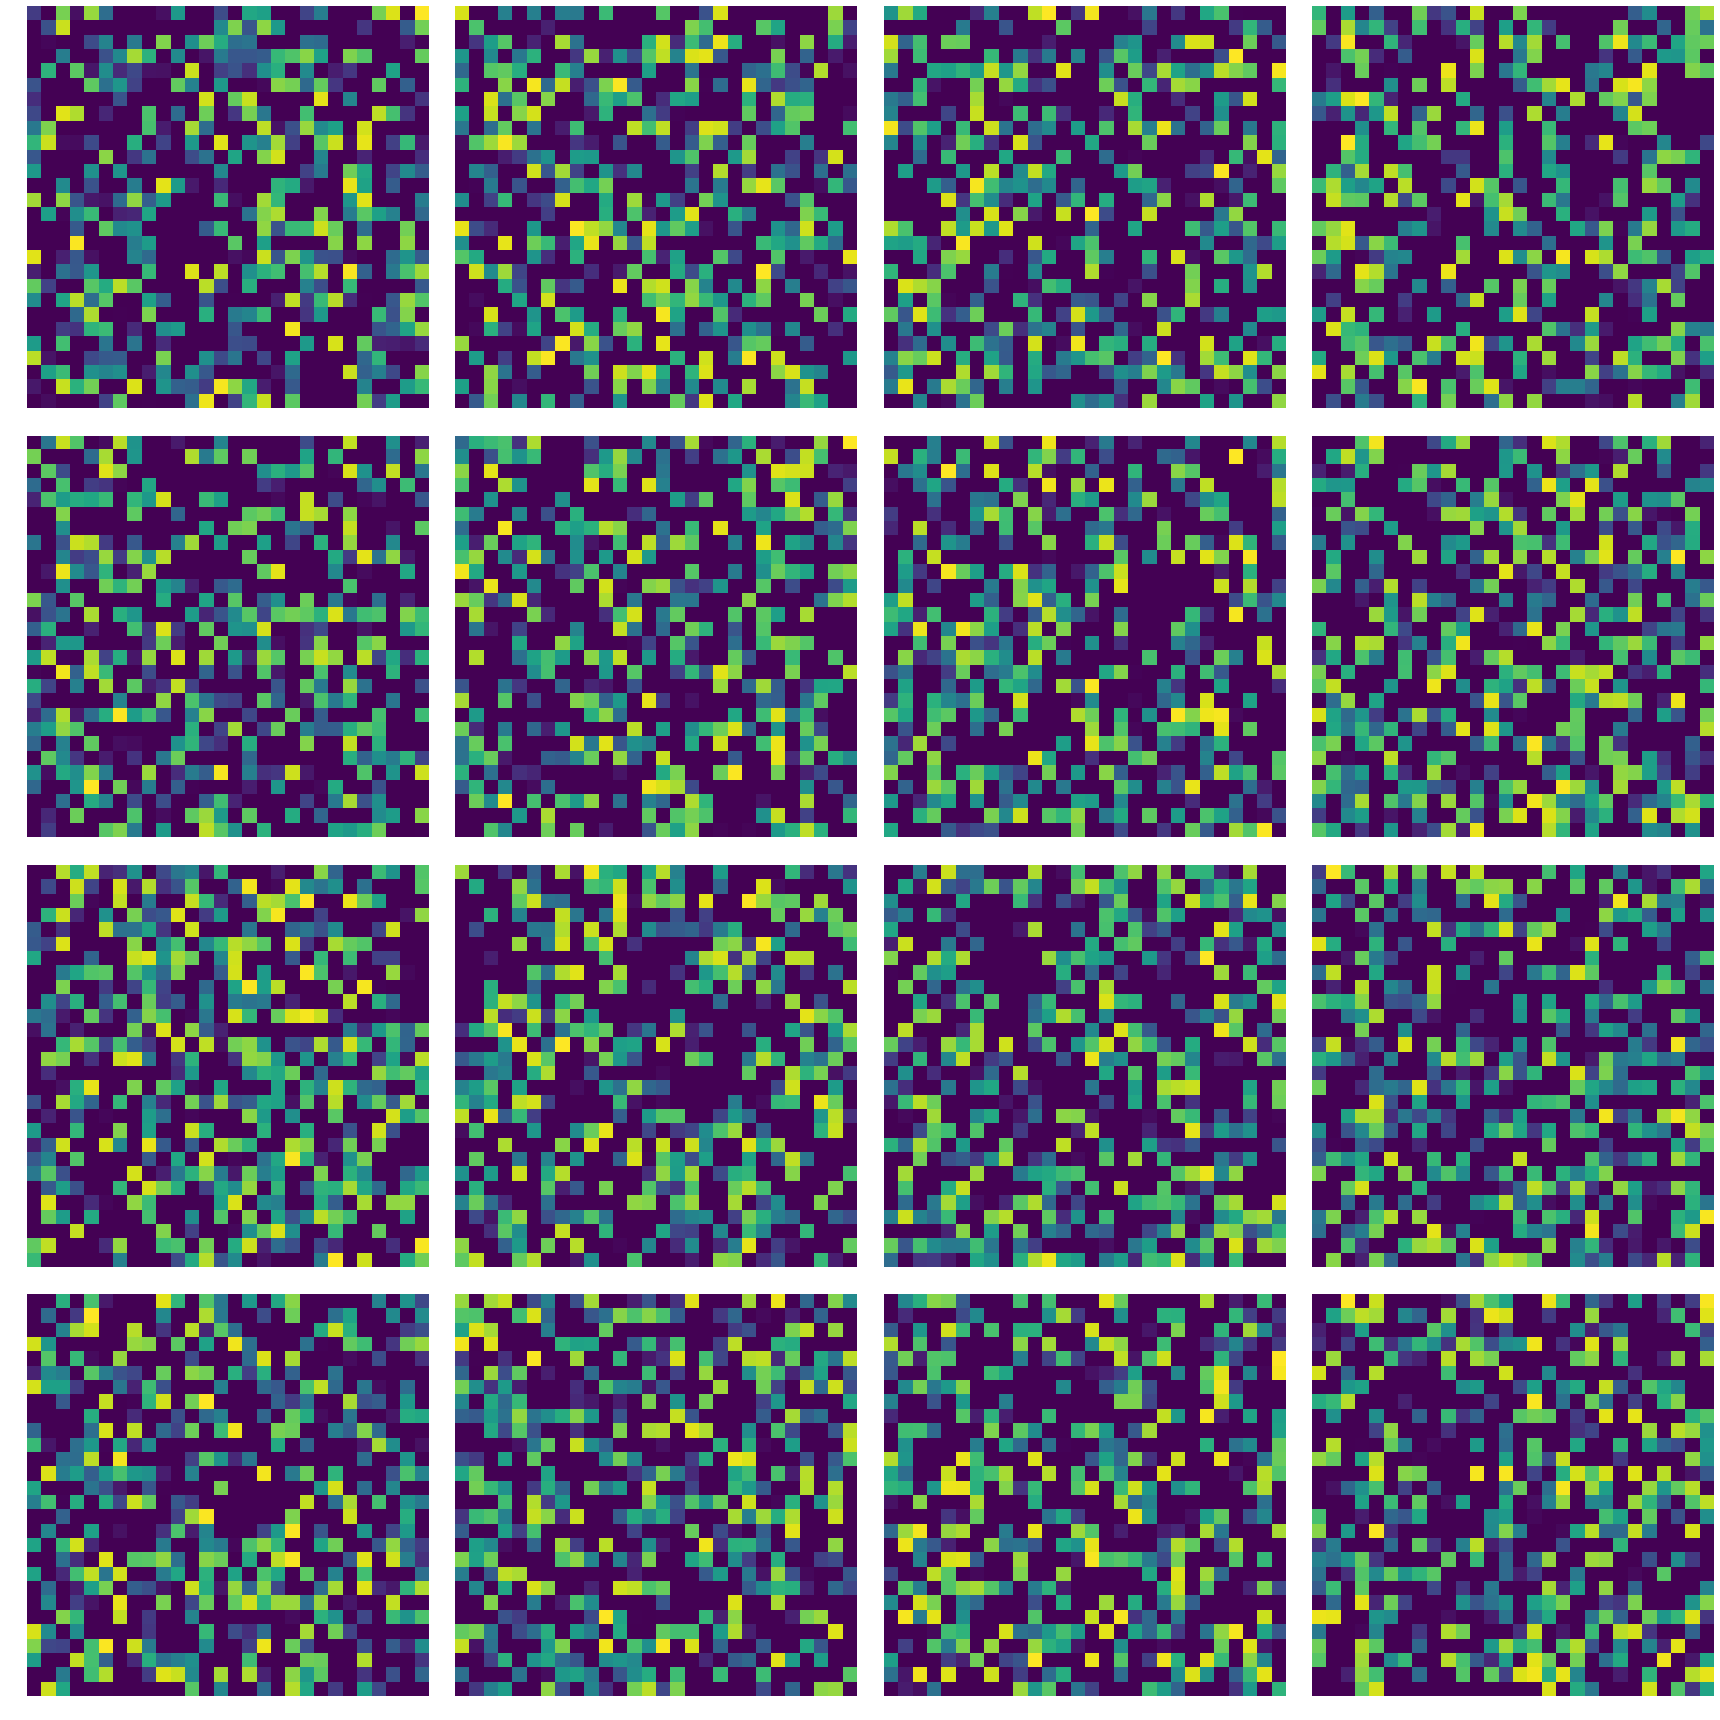

Epoch 2400, Generator loss 0.7608259320259094, discriminator loss 0.004123409278690815


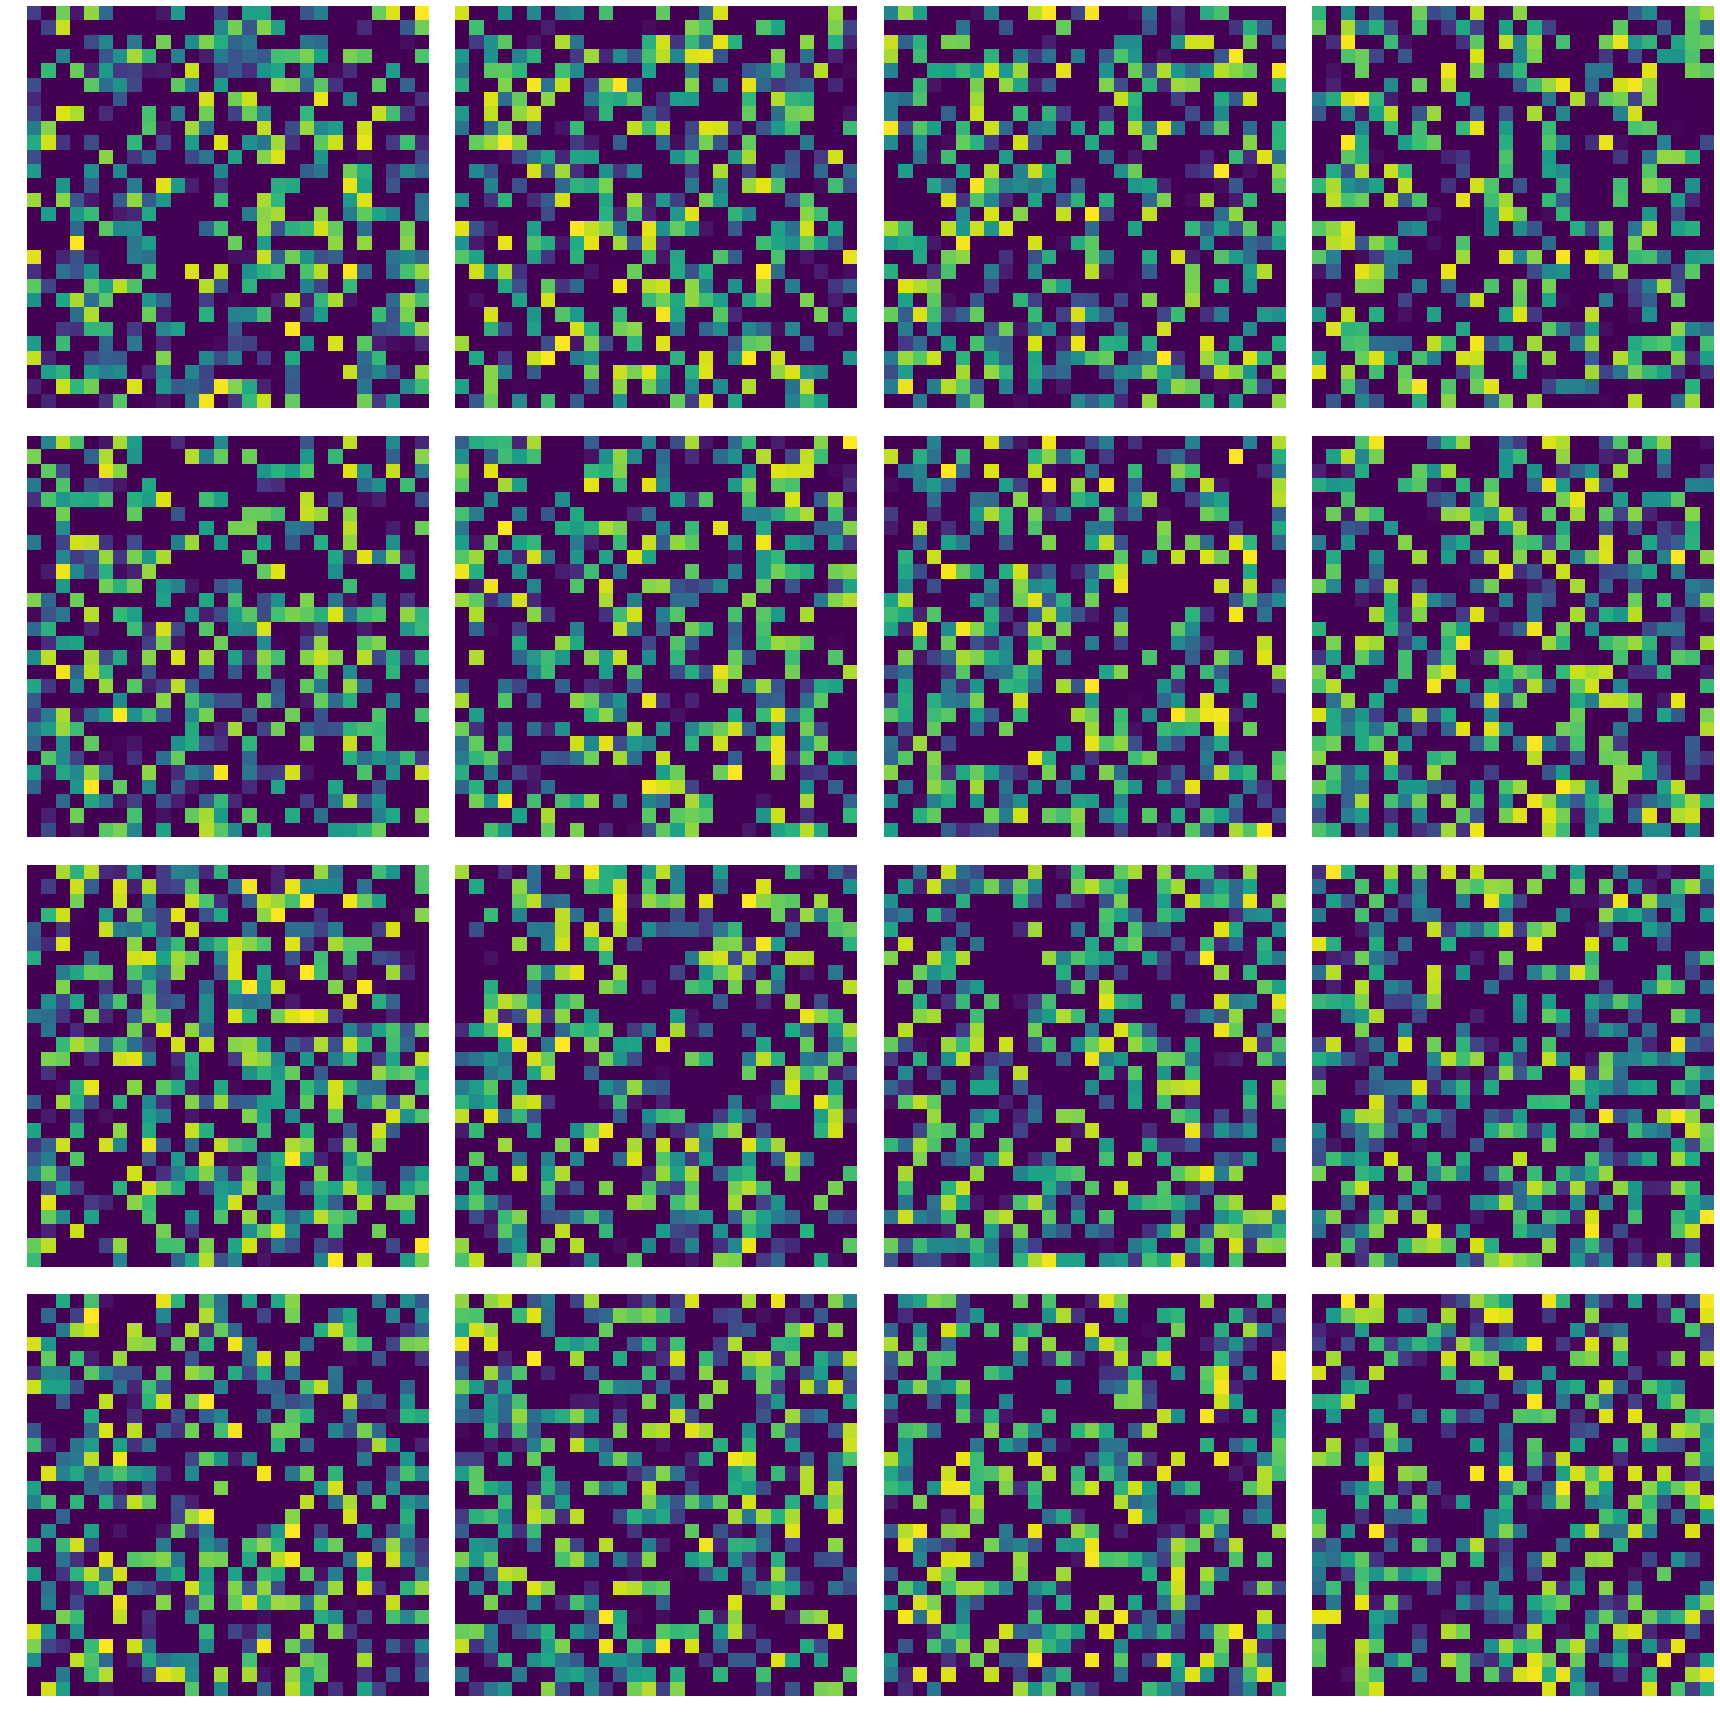

Epoch 2500, Generator loss 0.7558758854866028, discriminator loss 0.0040445527993142605


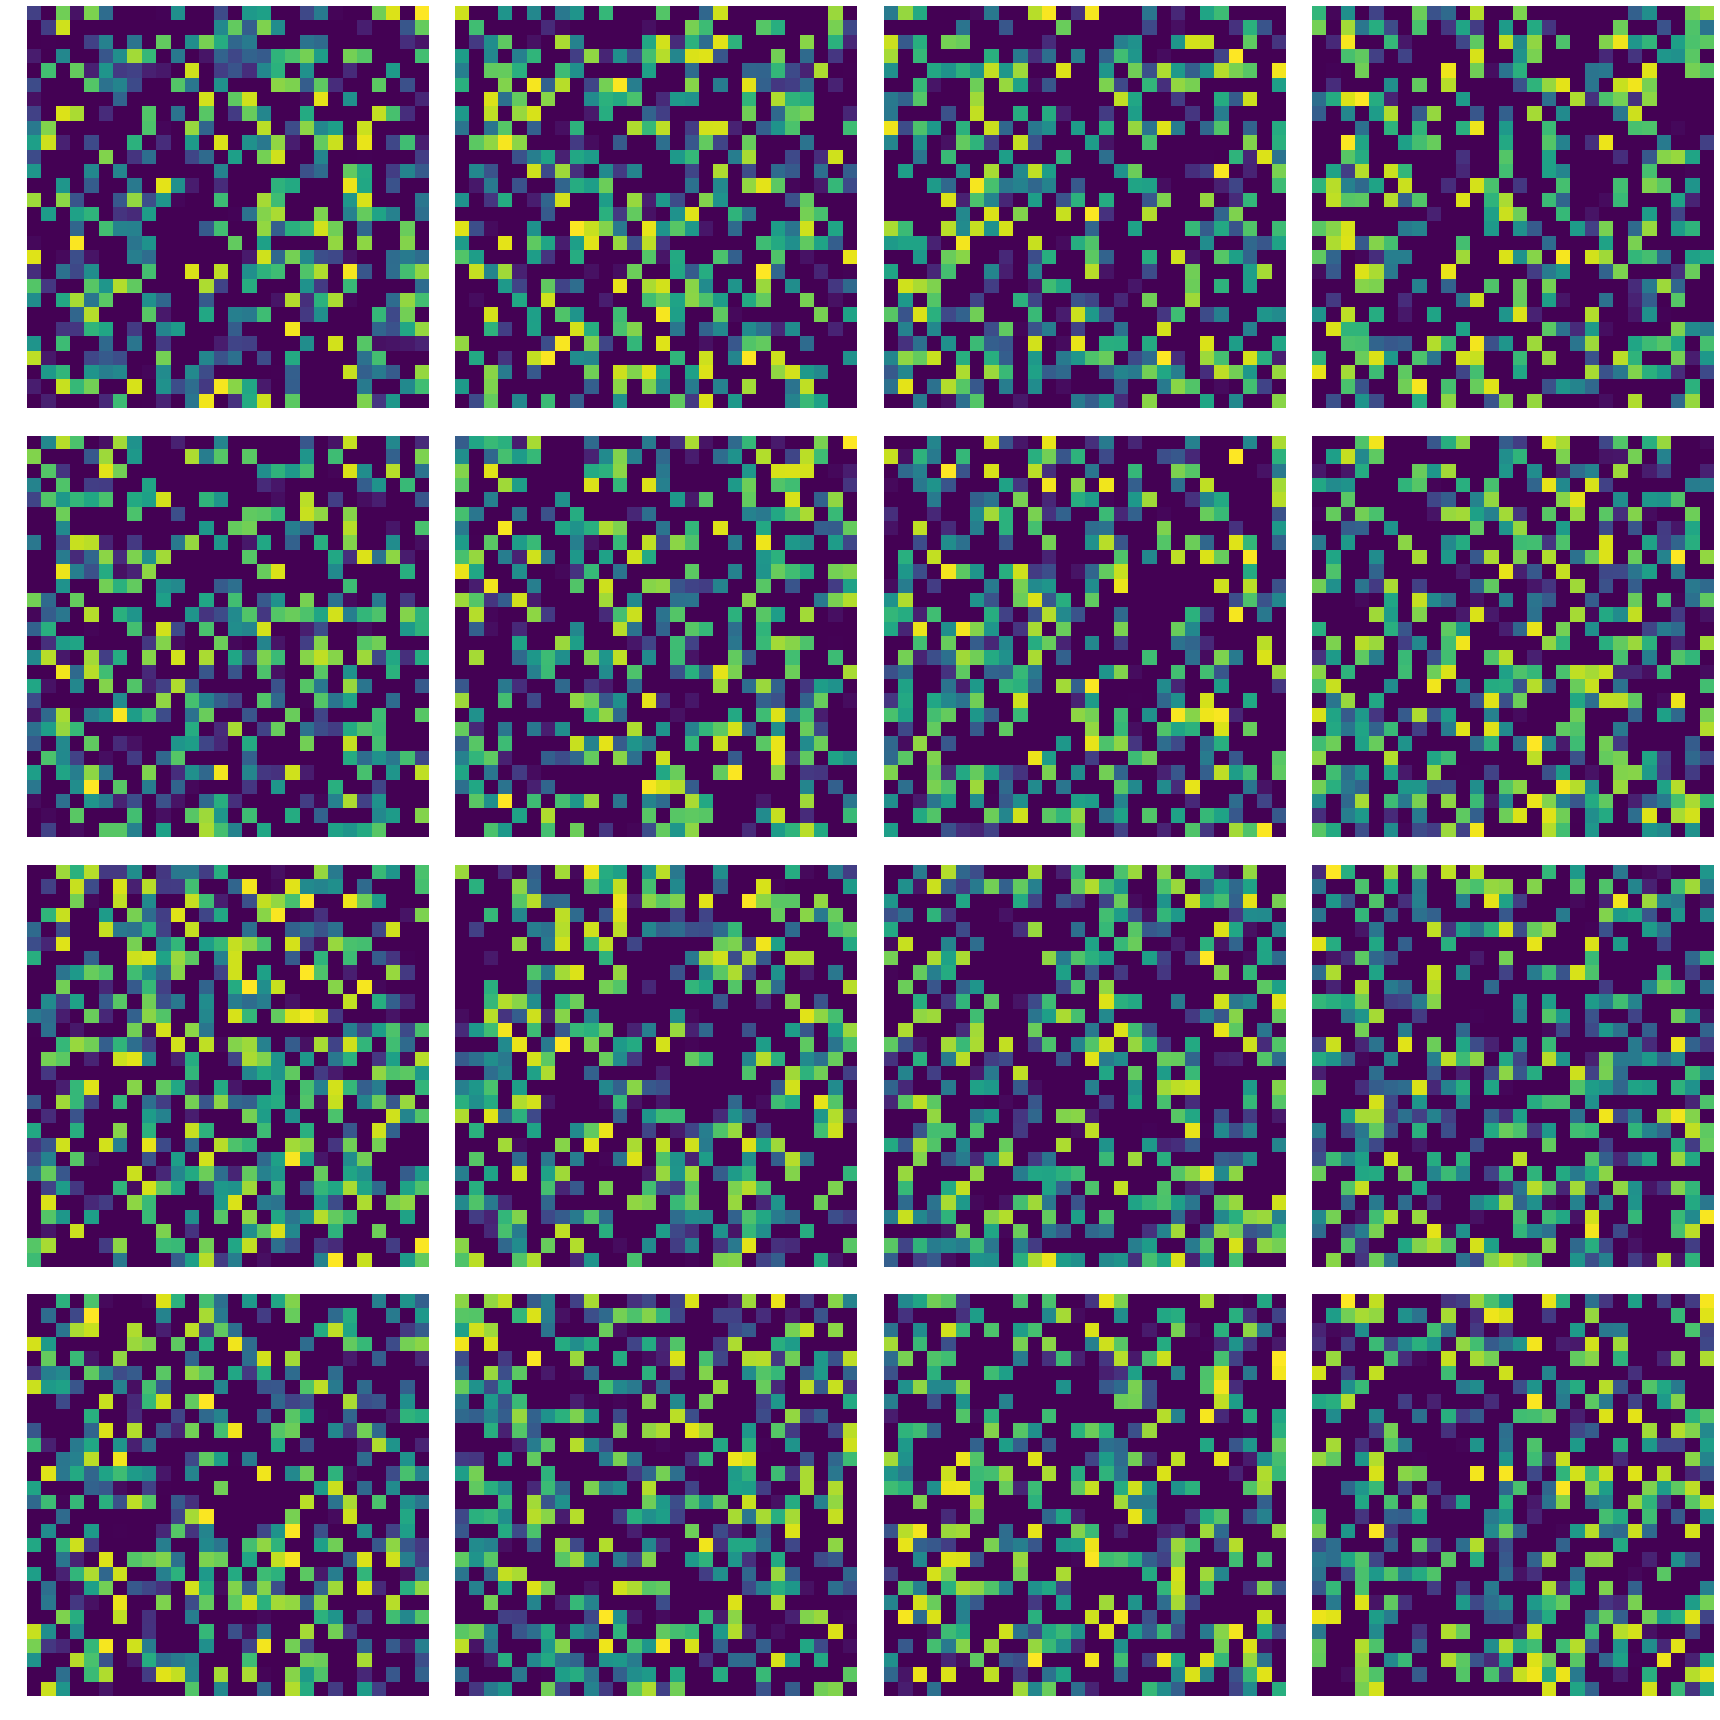

Epoch 2600, Generator loss 0.7543234825134277, discriminator loss 0.0039669484831392765


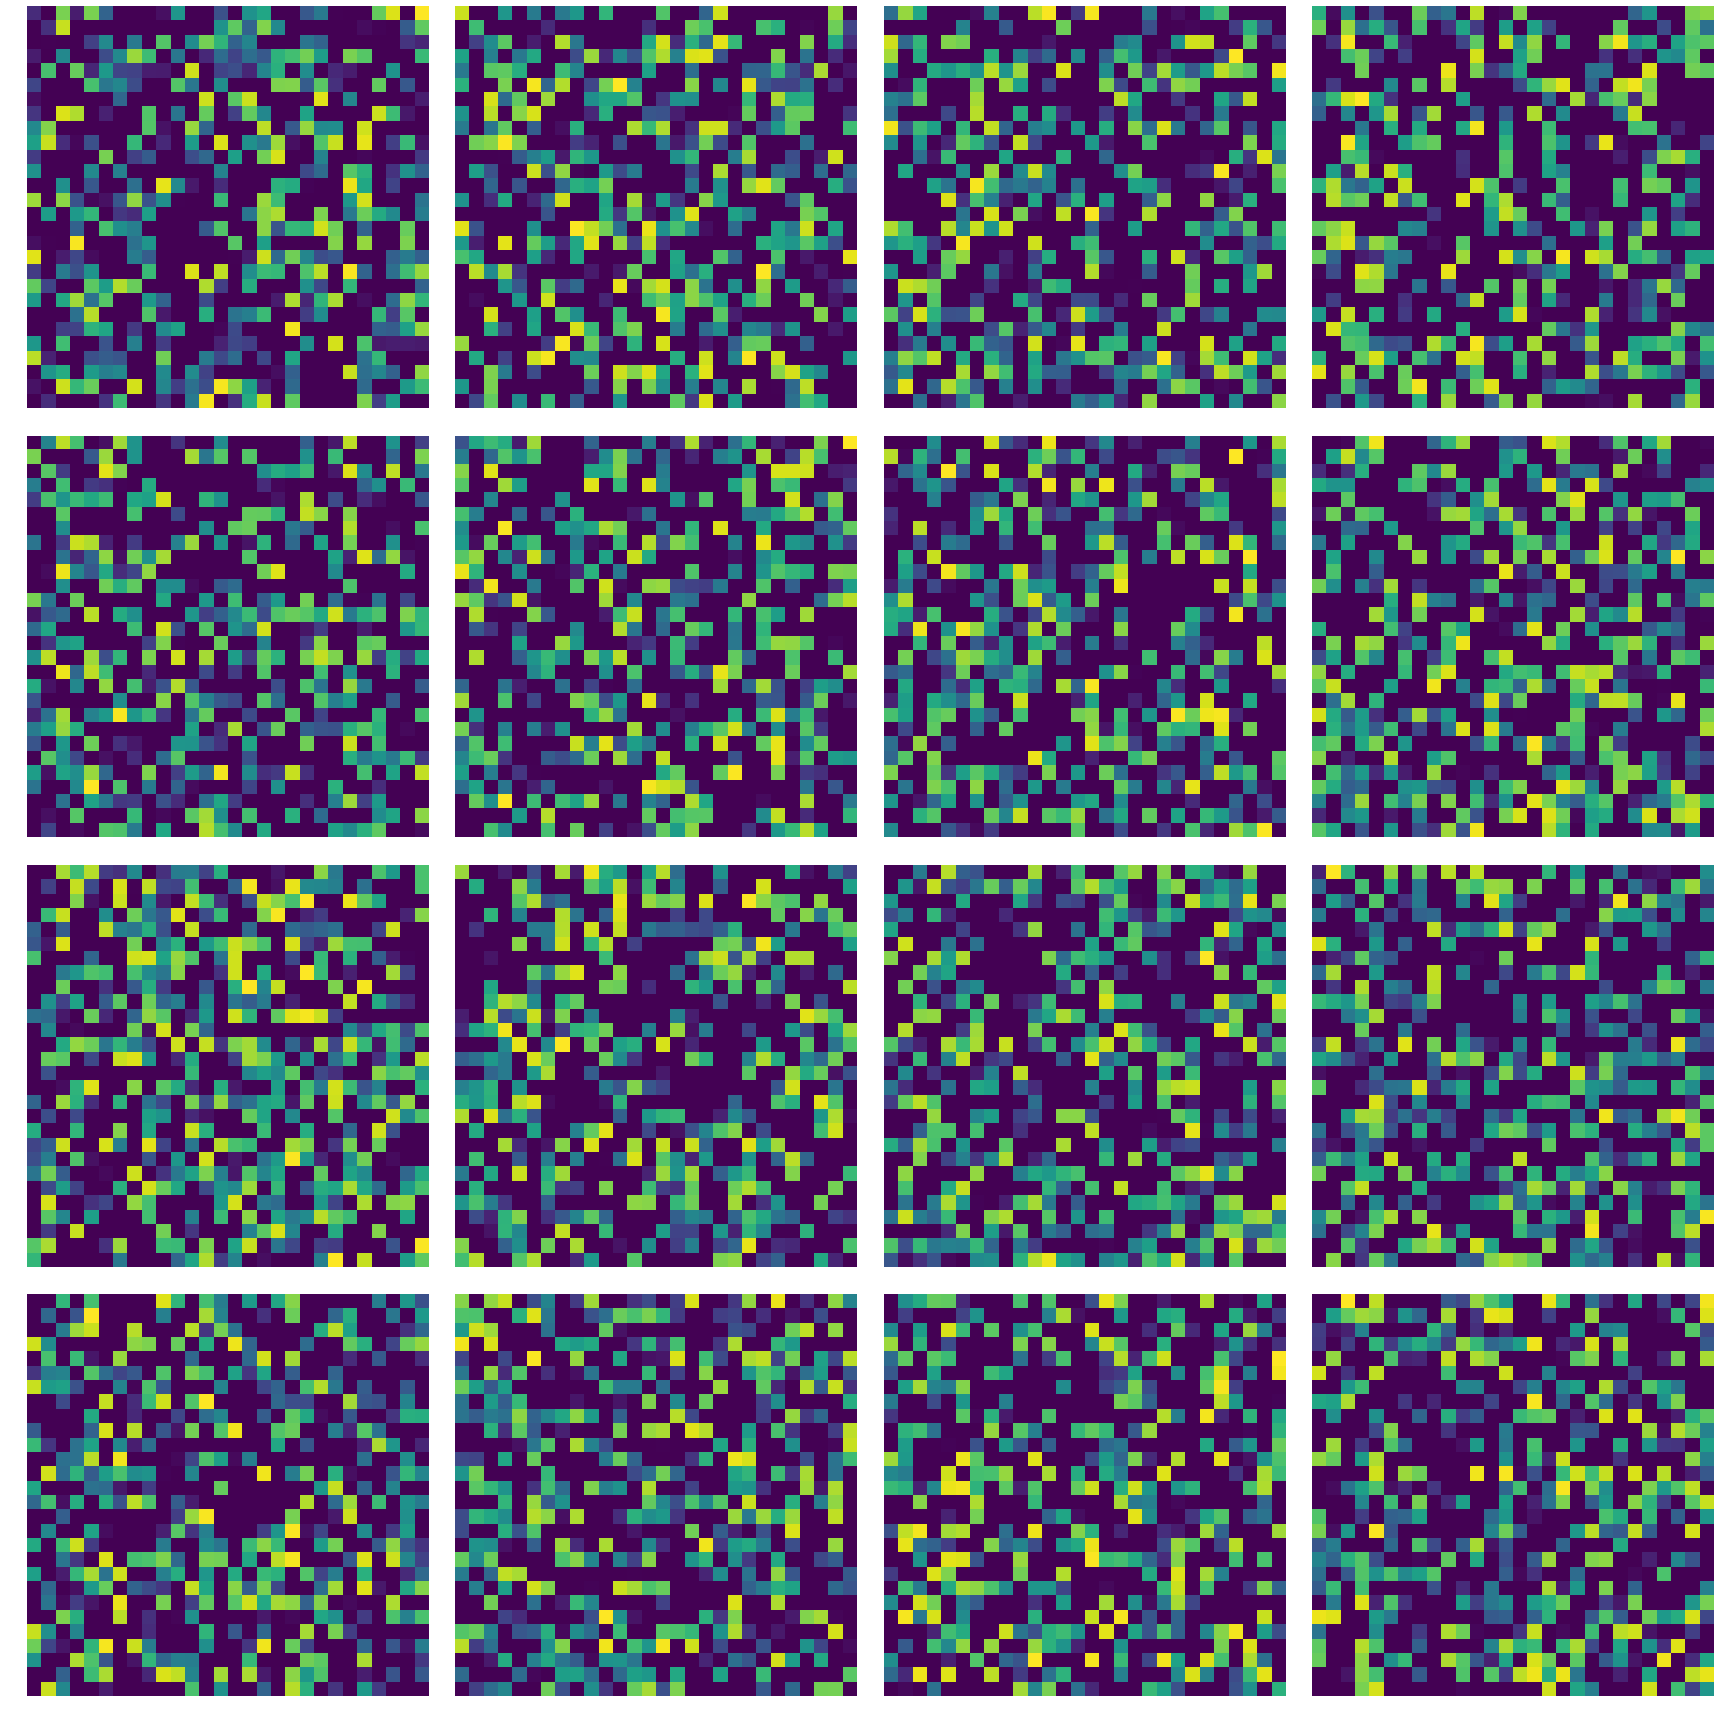

Epoch 2700, Generator loss 0.7440375089645386, discriminator loss 0.003887014463543892


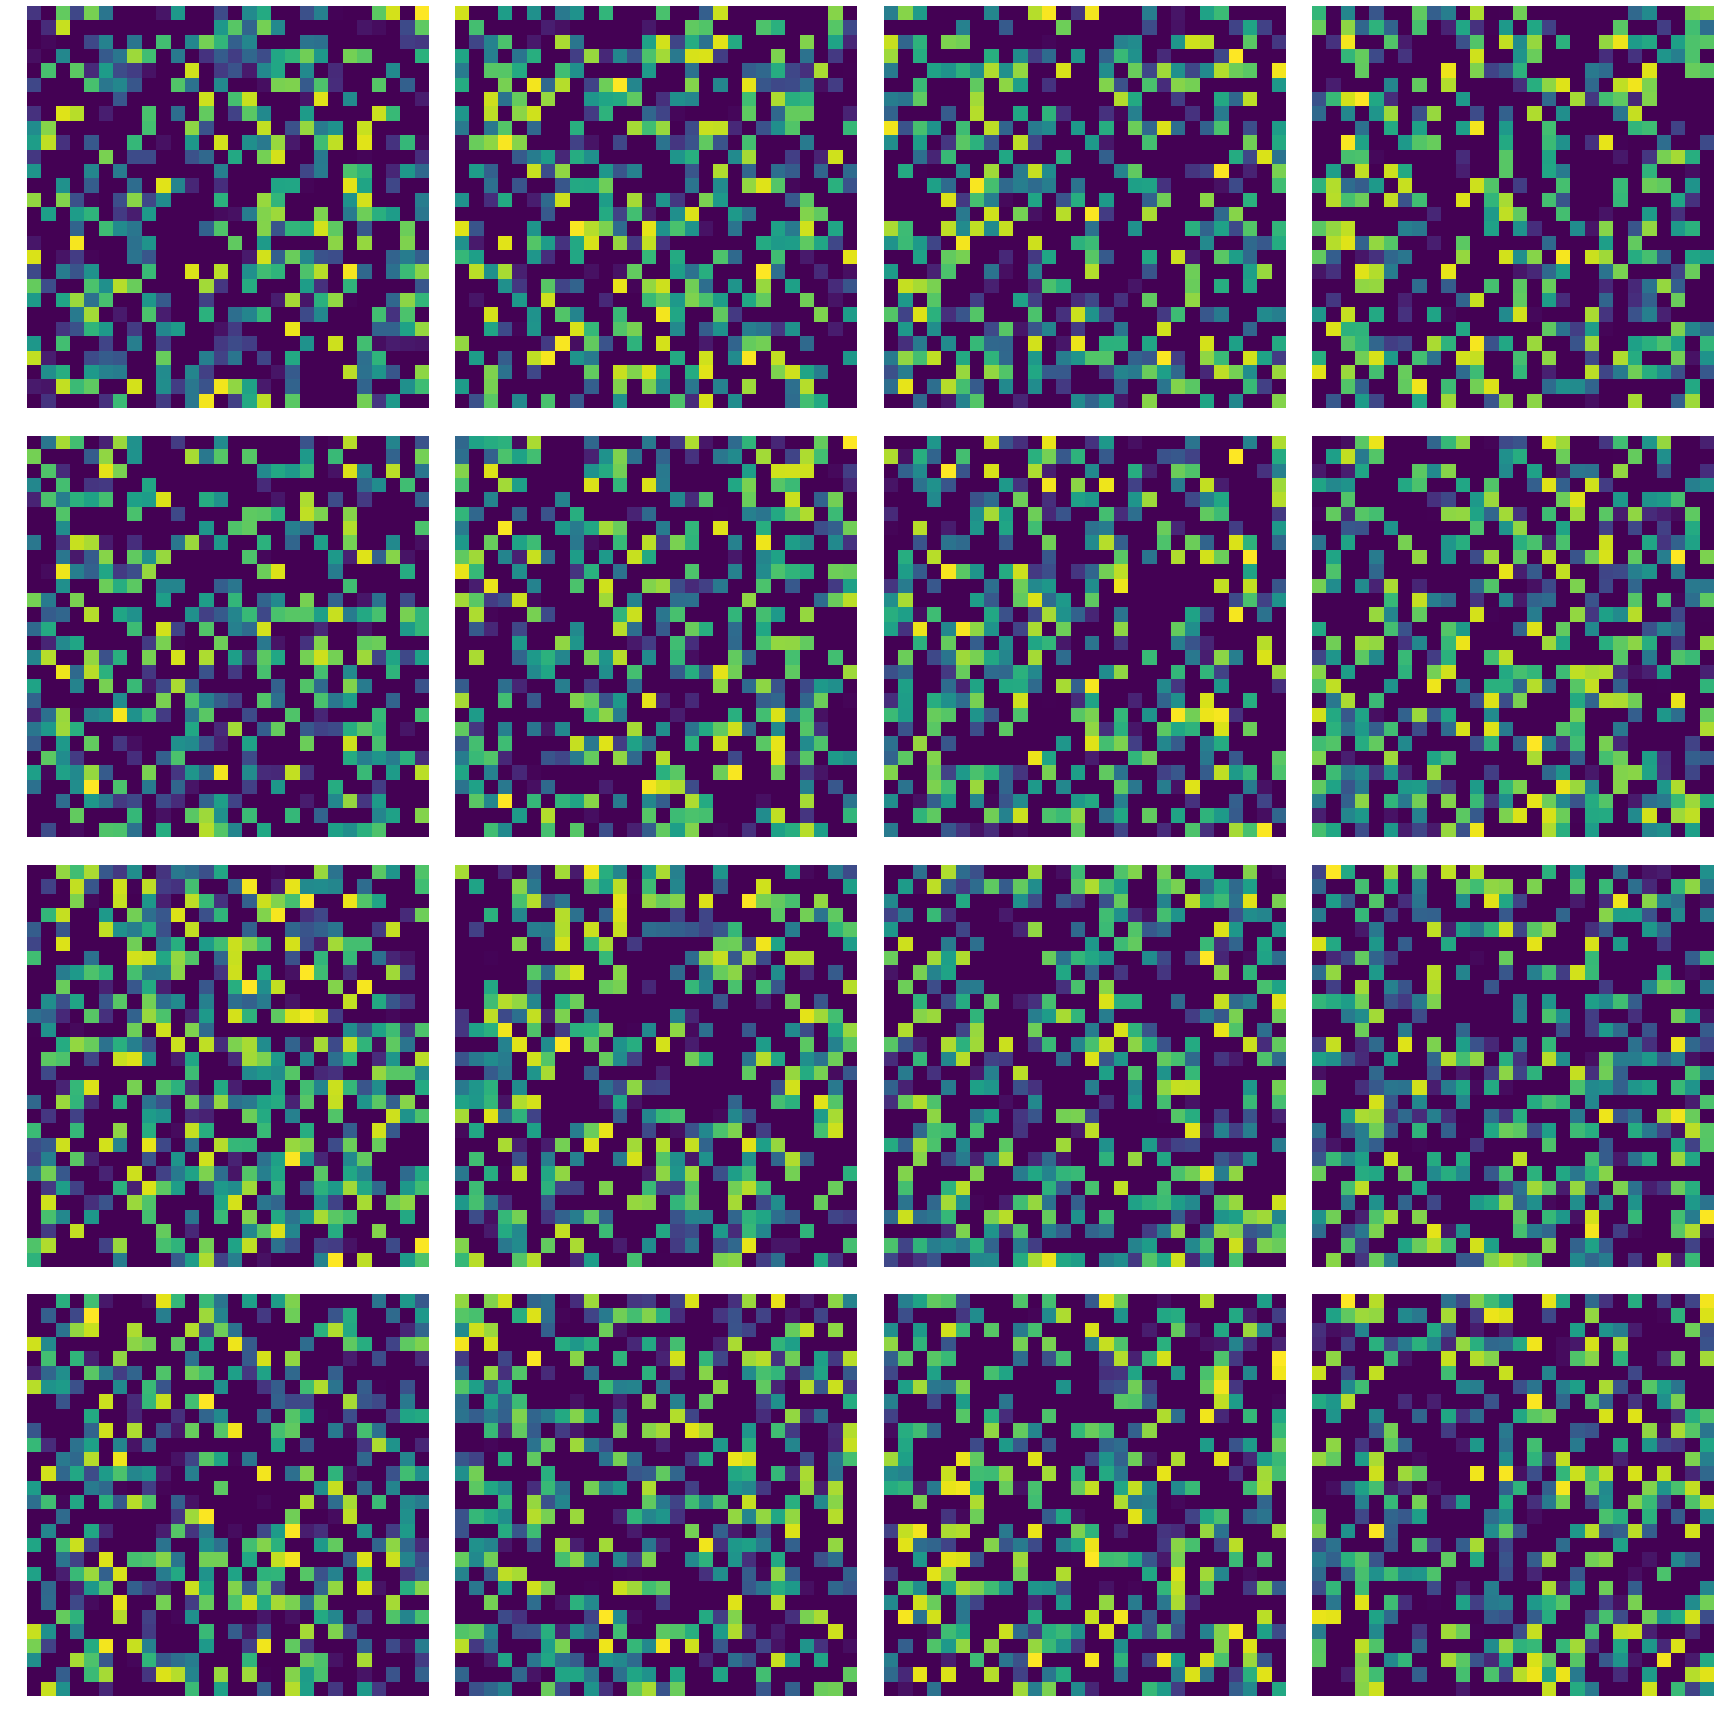

Epoch 2800, Generator loss 0.7293534874916077, discriminator loss 0.003808087669312954


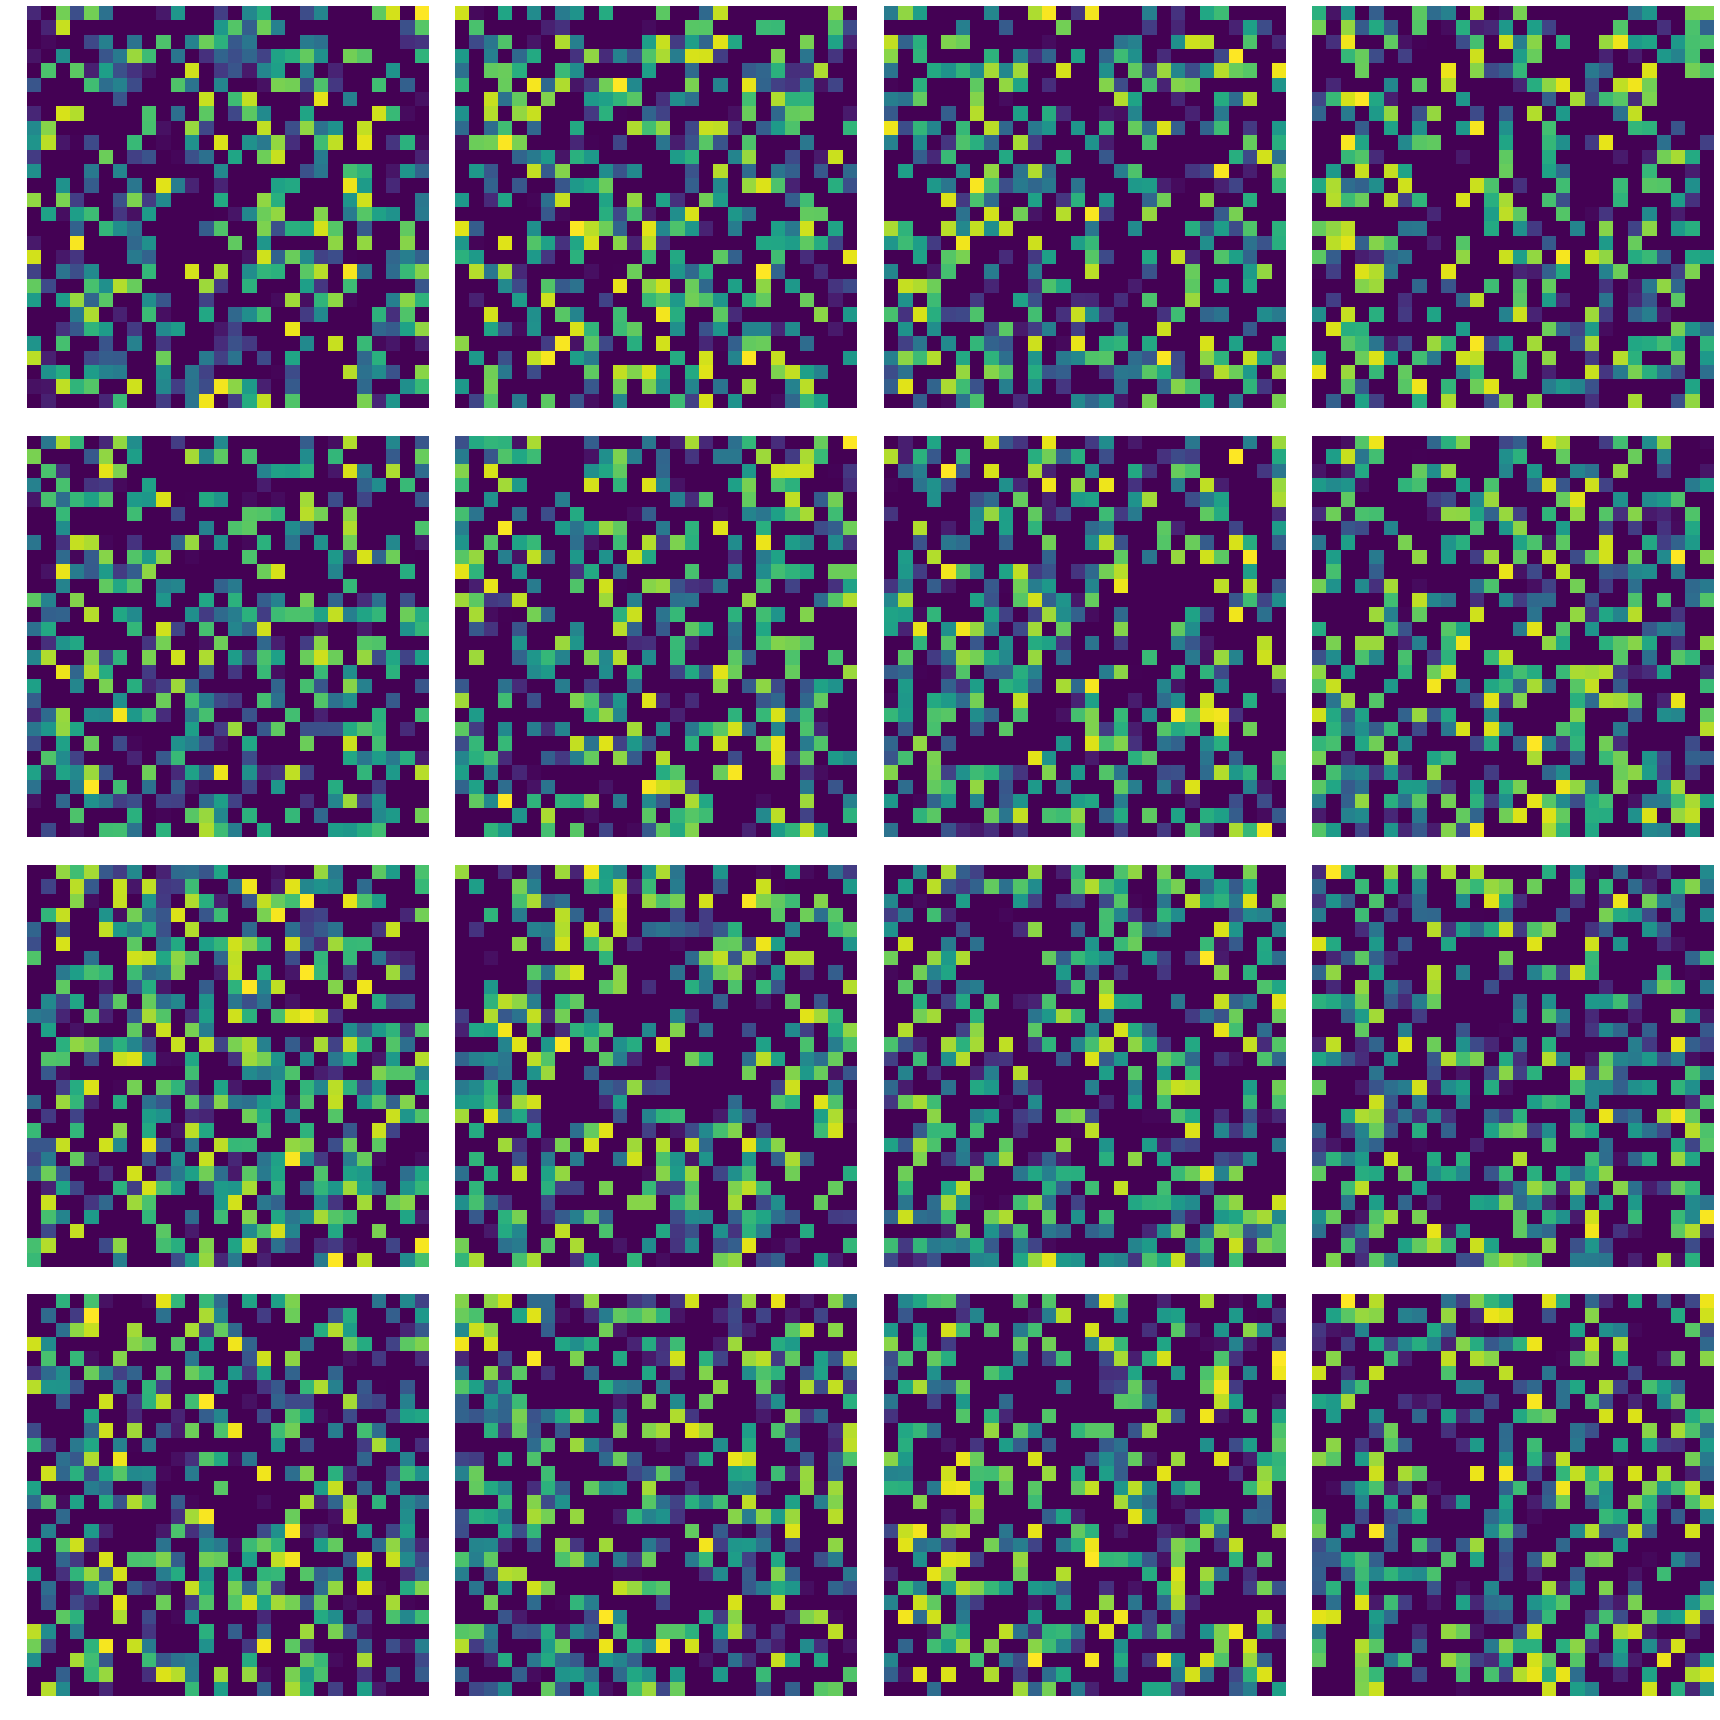

Epoch 2900, Generator loss 0.727573812007904, discriminator loss 0.0037275345530360937


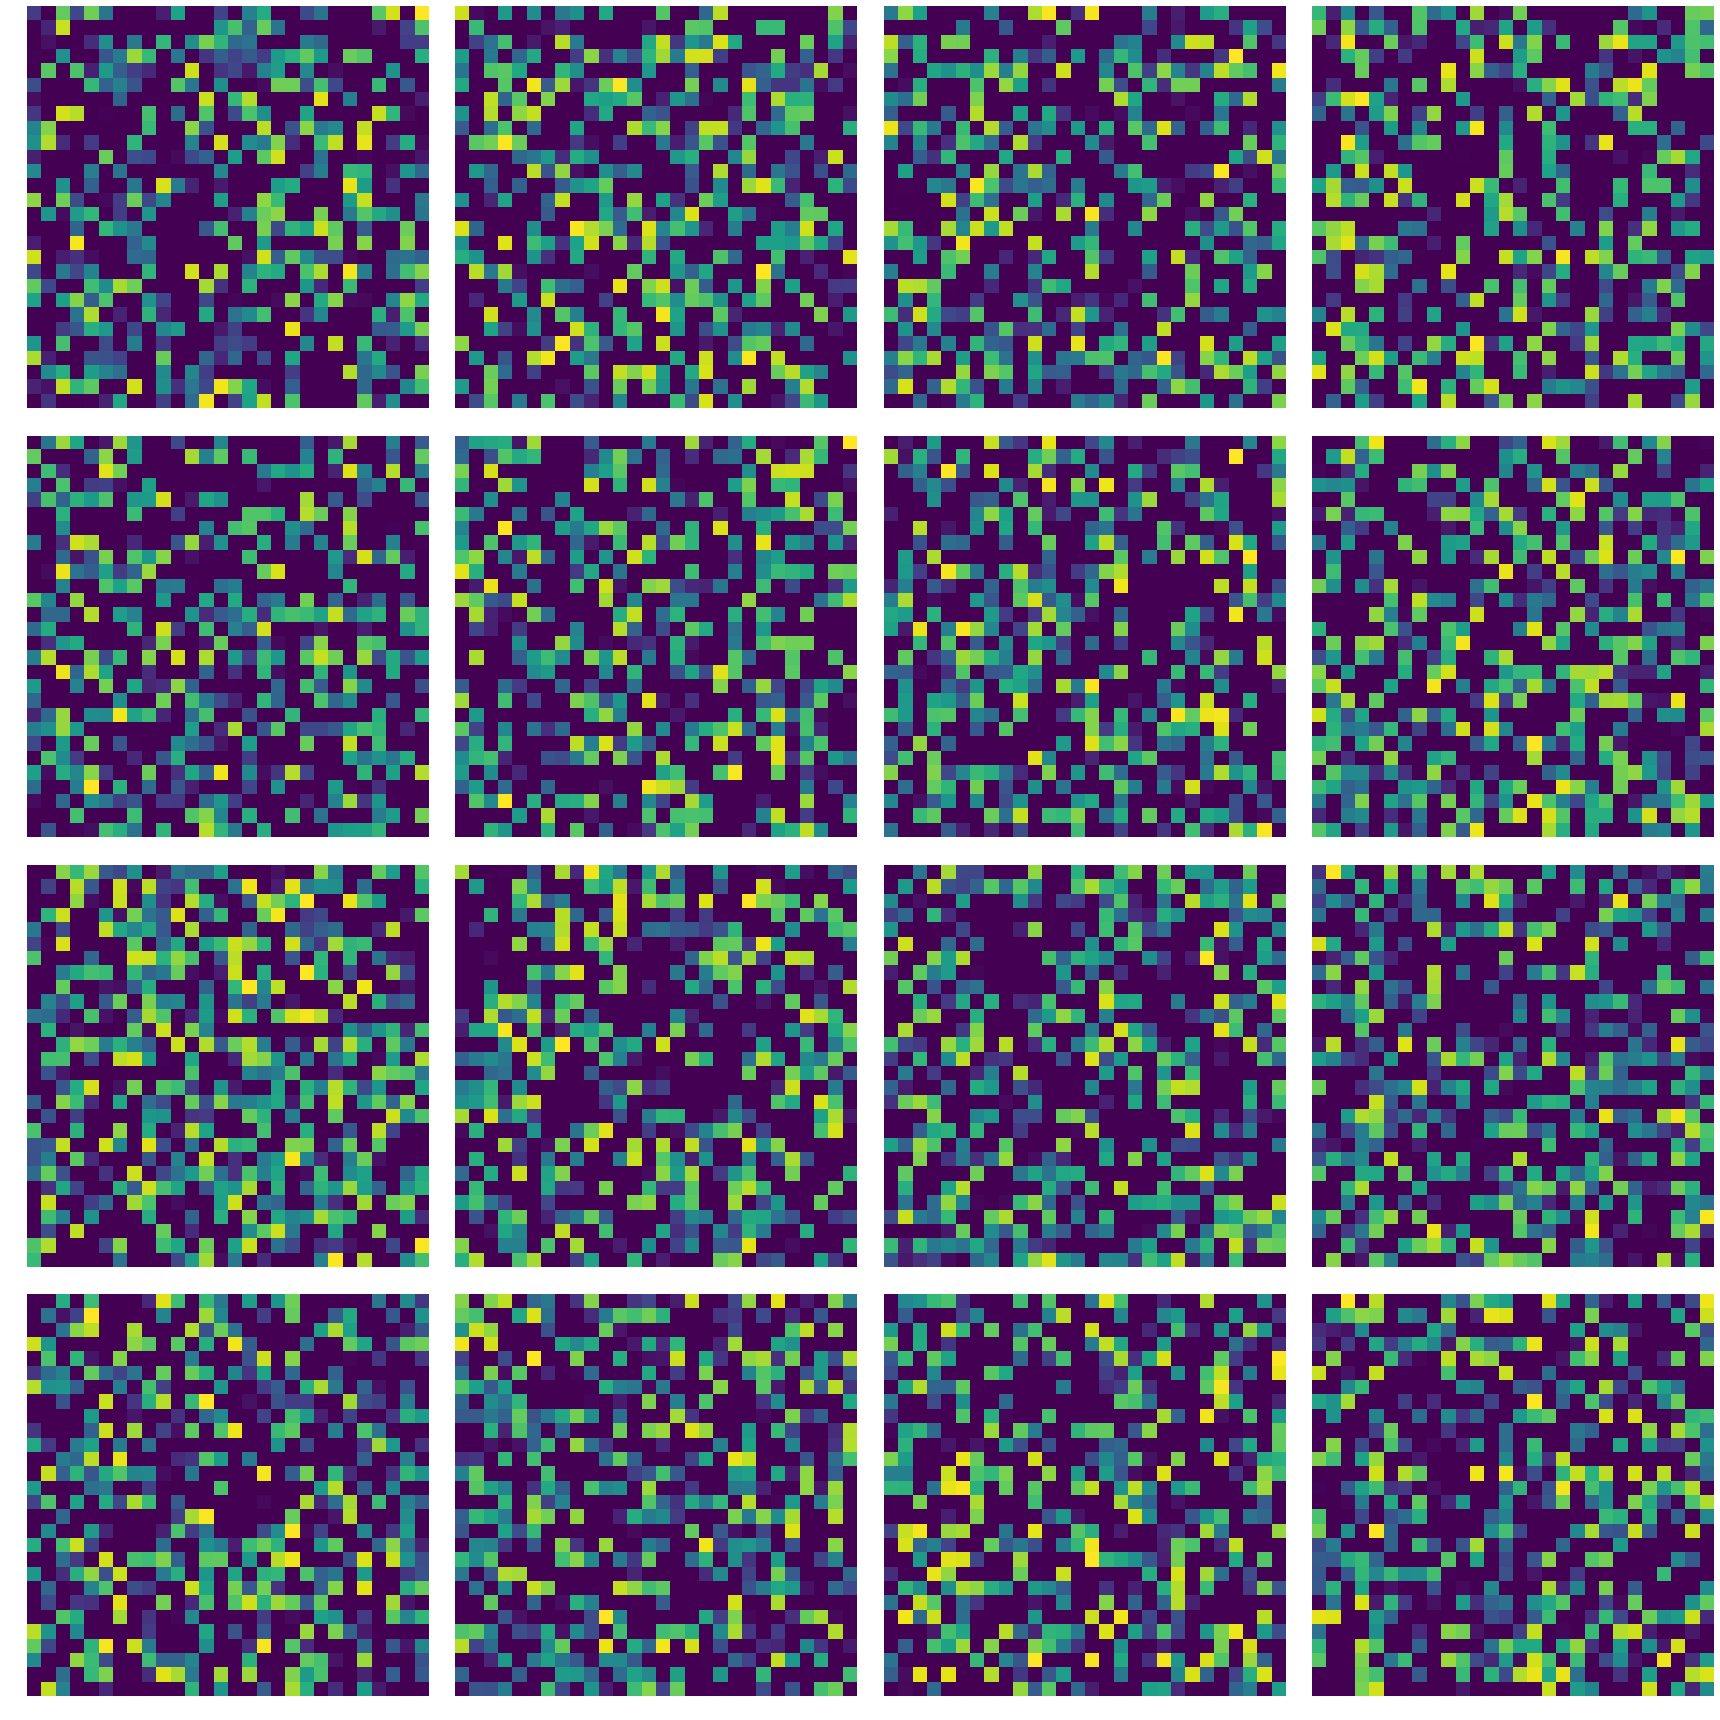

Epoch 3000, Generator loss 0.7193424701690674, discriminator loss 0.0036514229141175747


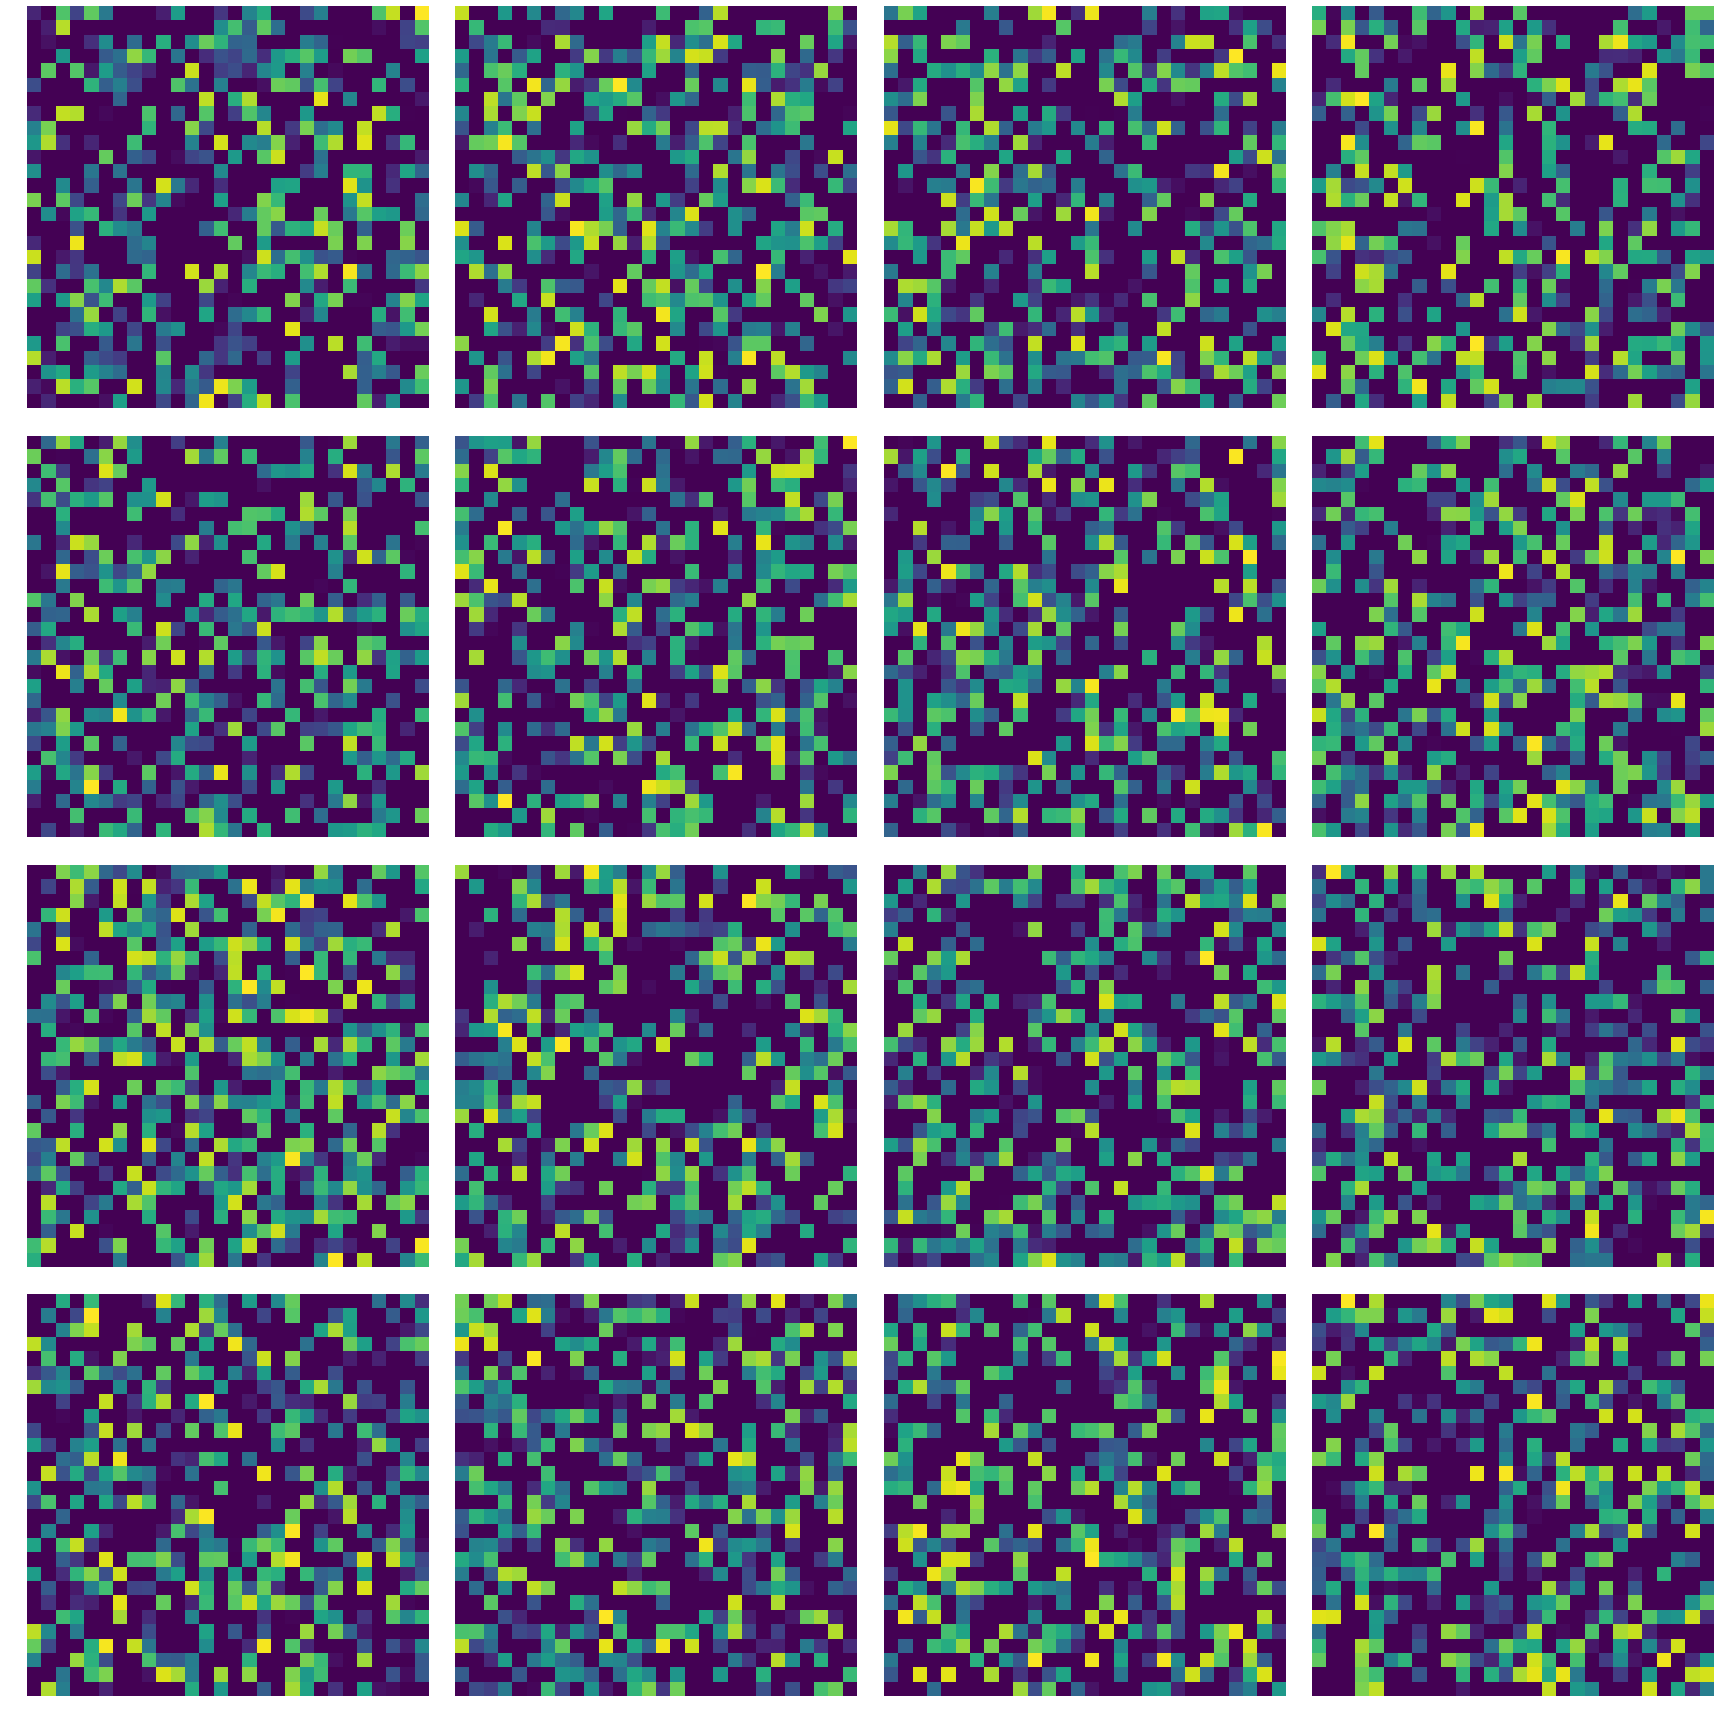

Epoch 3100, Generator loss 0.6944500803947449, discriminator loss 0.00357113522477448


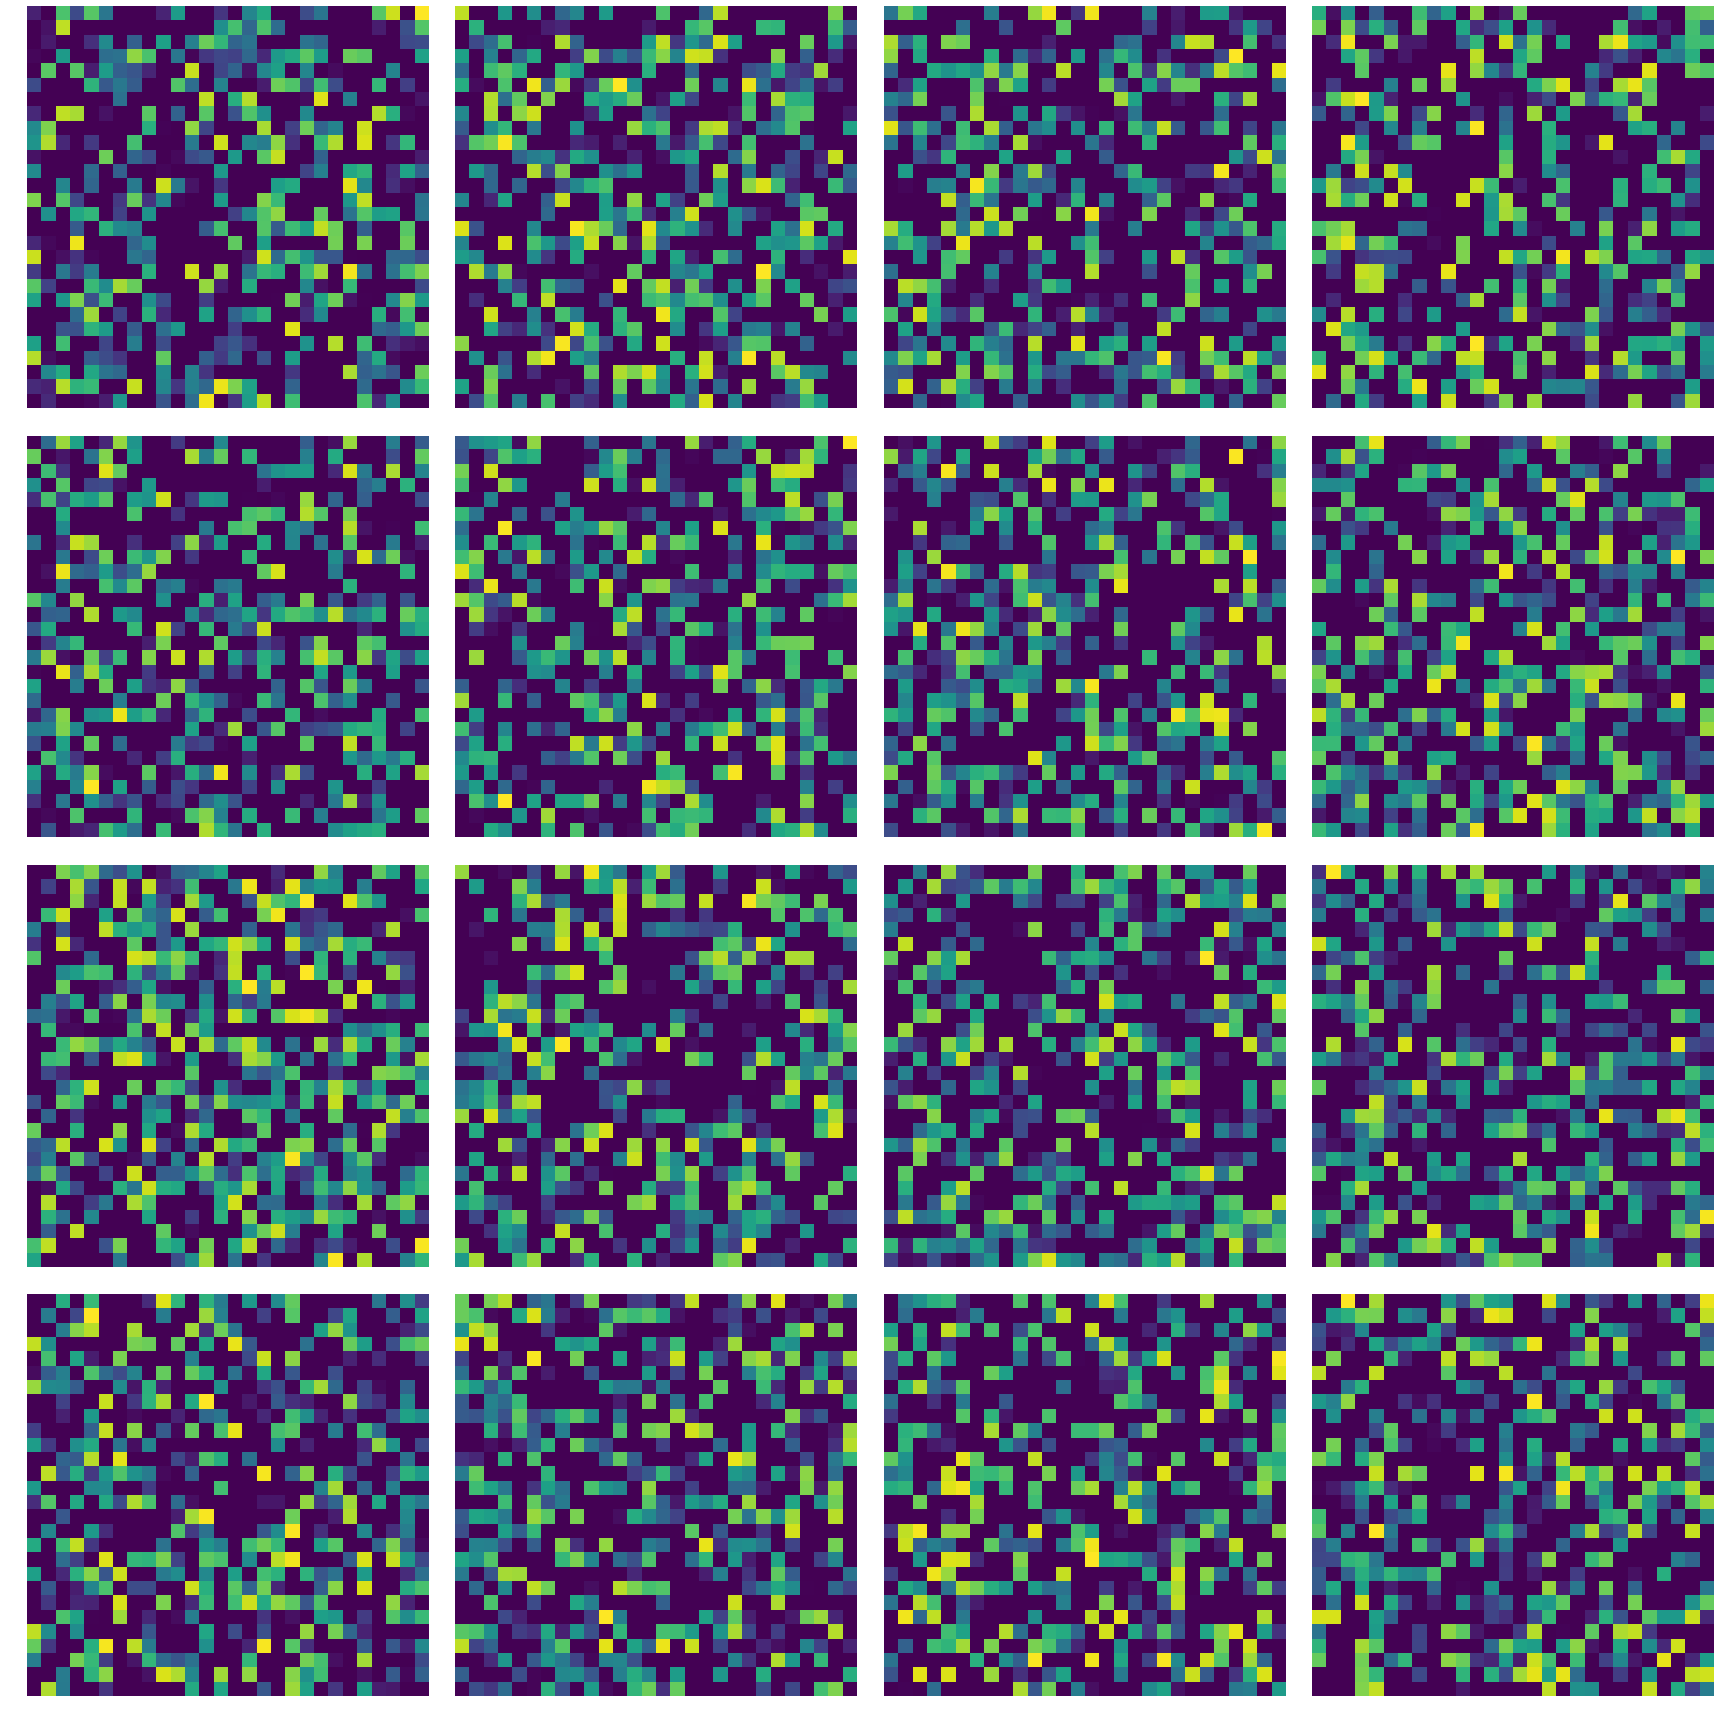

Epoch 3200, Generator loss 0.6821783781051636, discriminator loss 0.003498593345284462


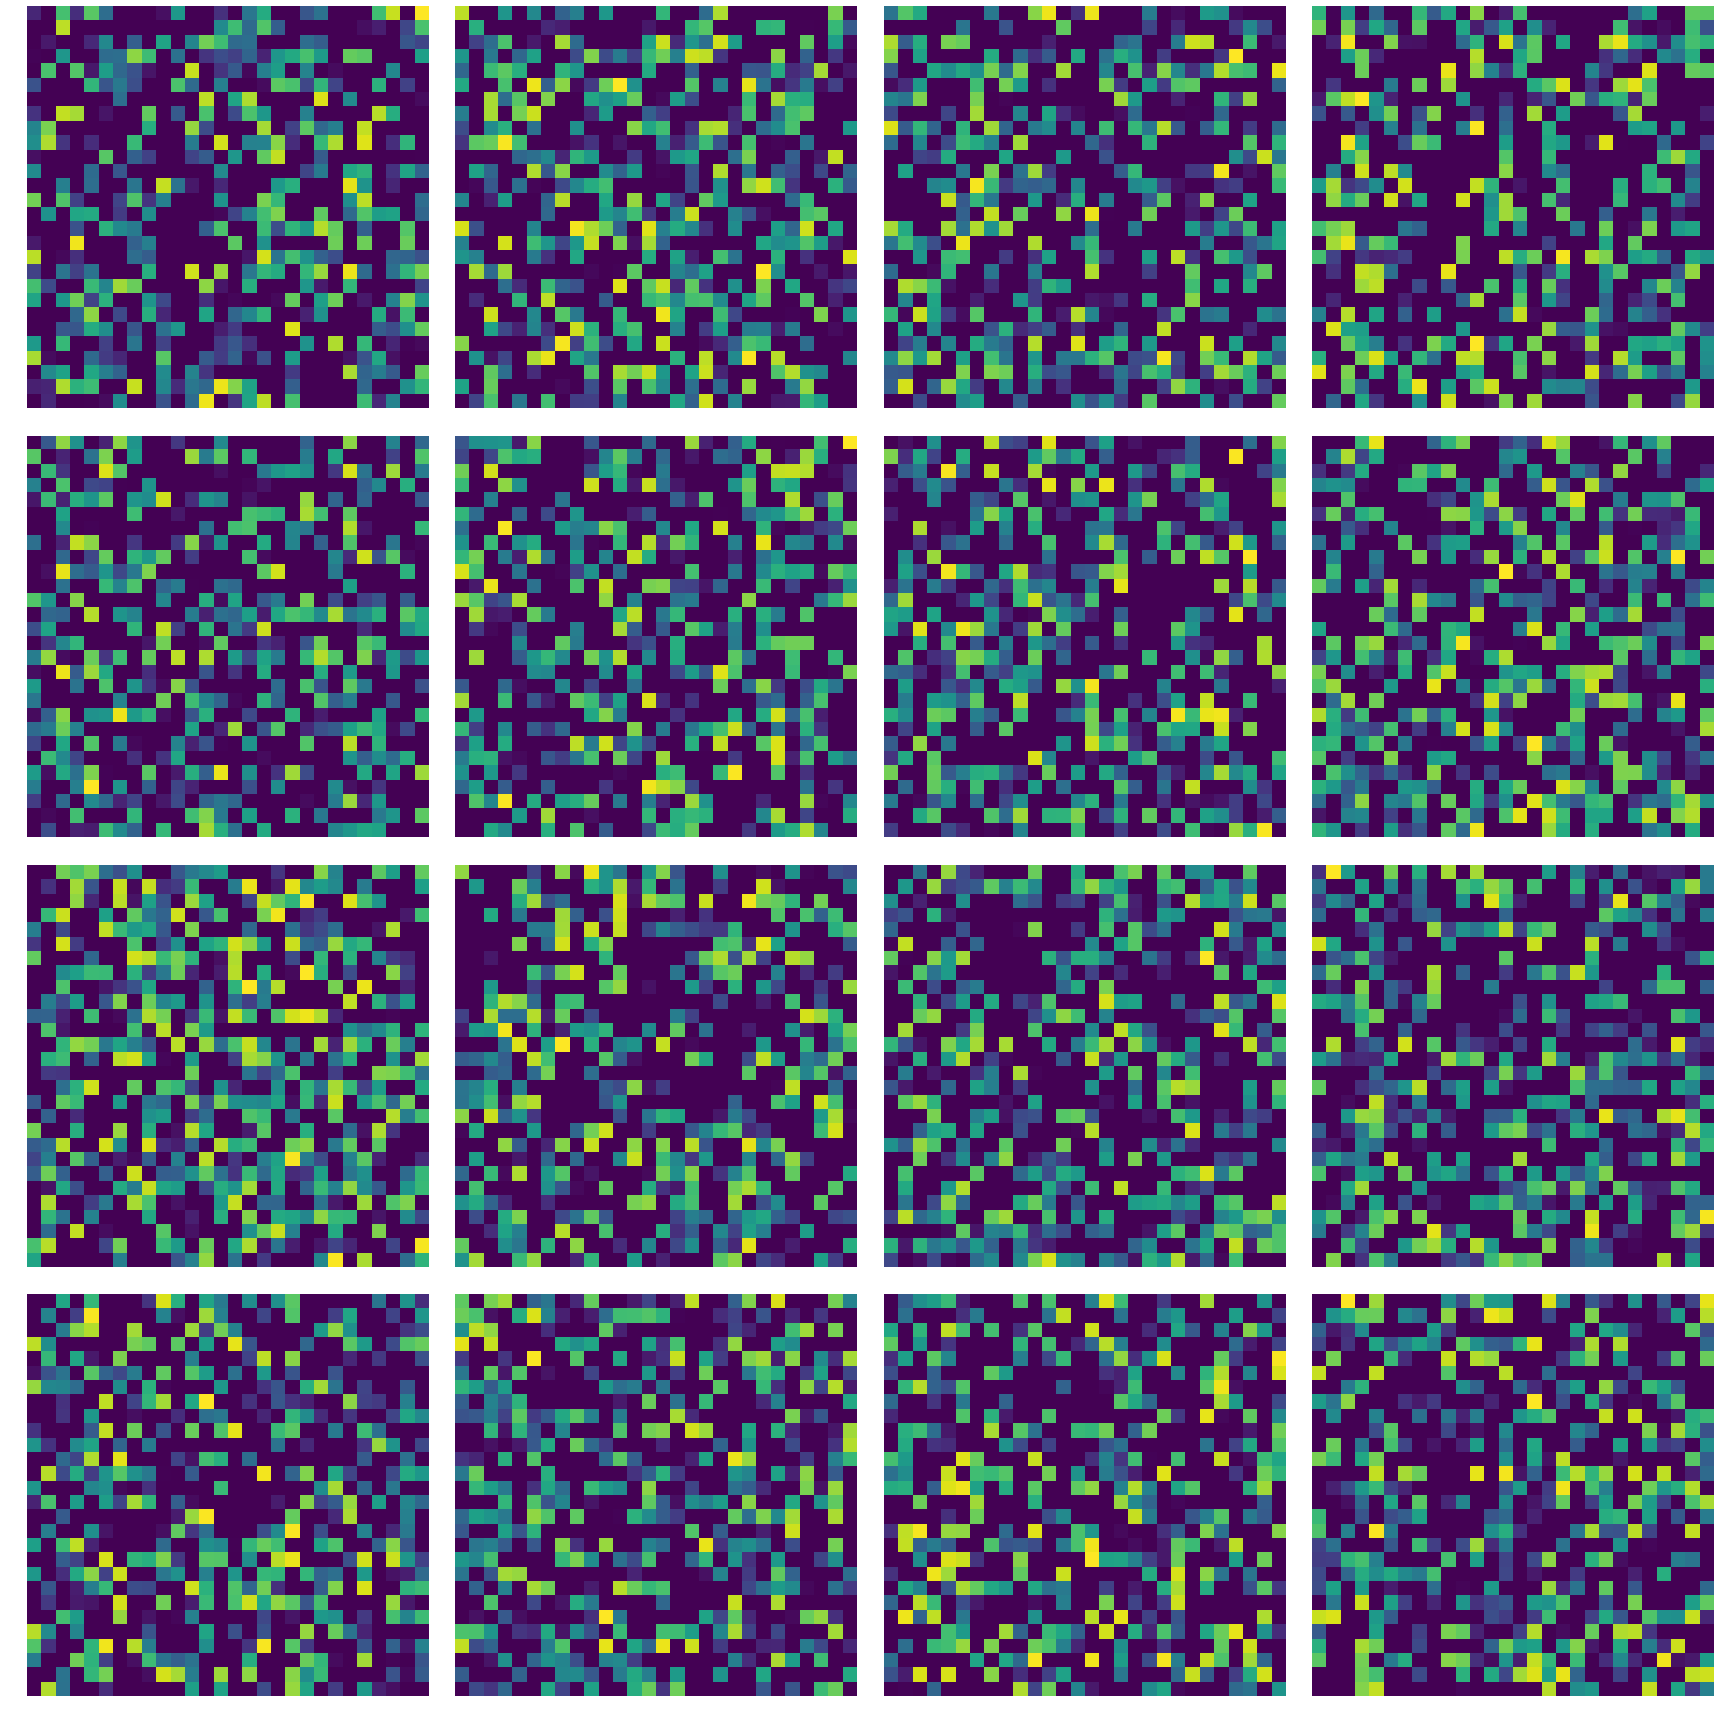

Epoch 3300, Generator loss 0.6888782382011414, discriminator loss 0.0034160446375608444


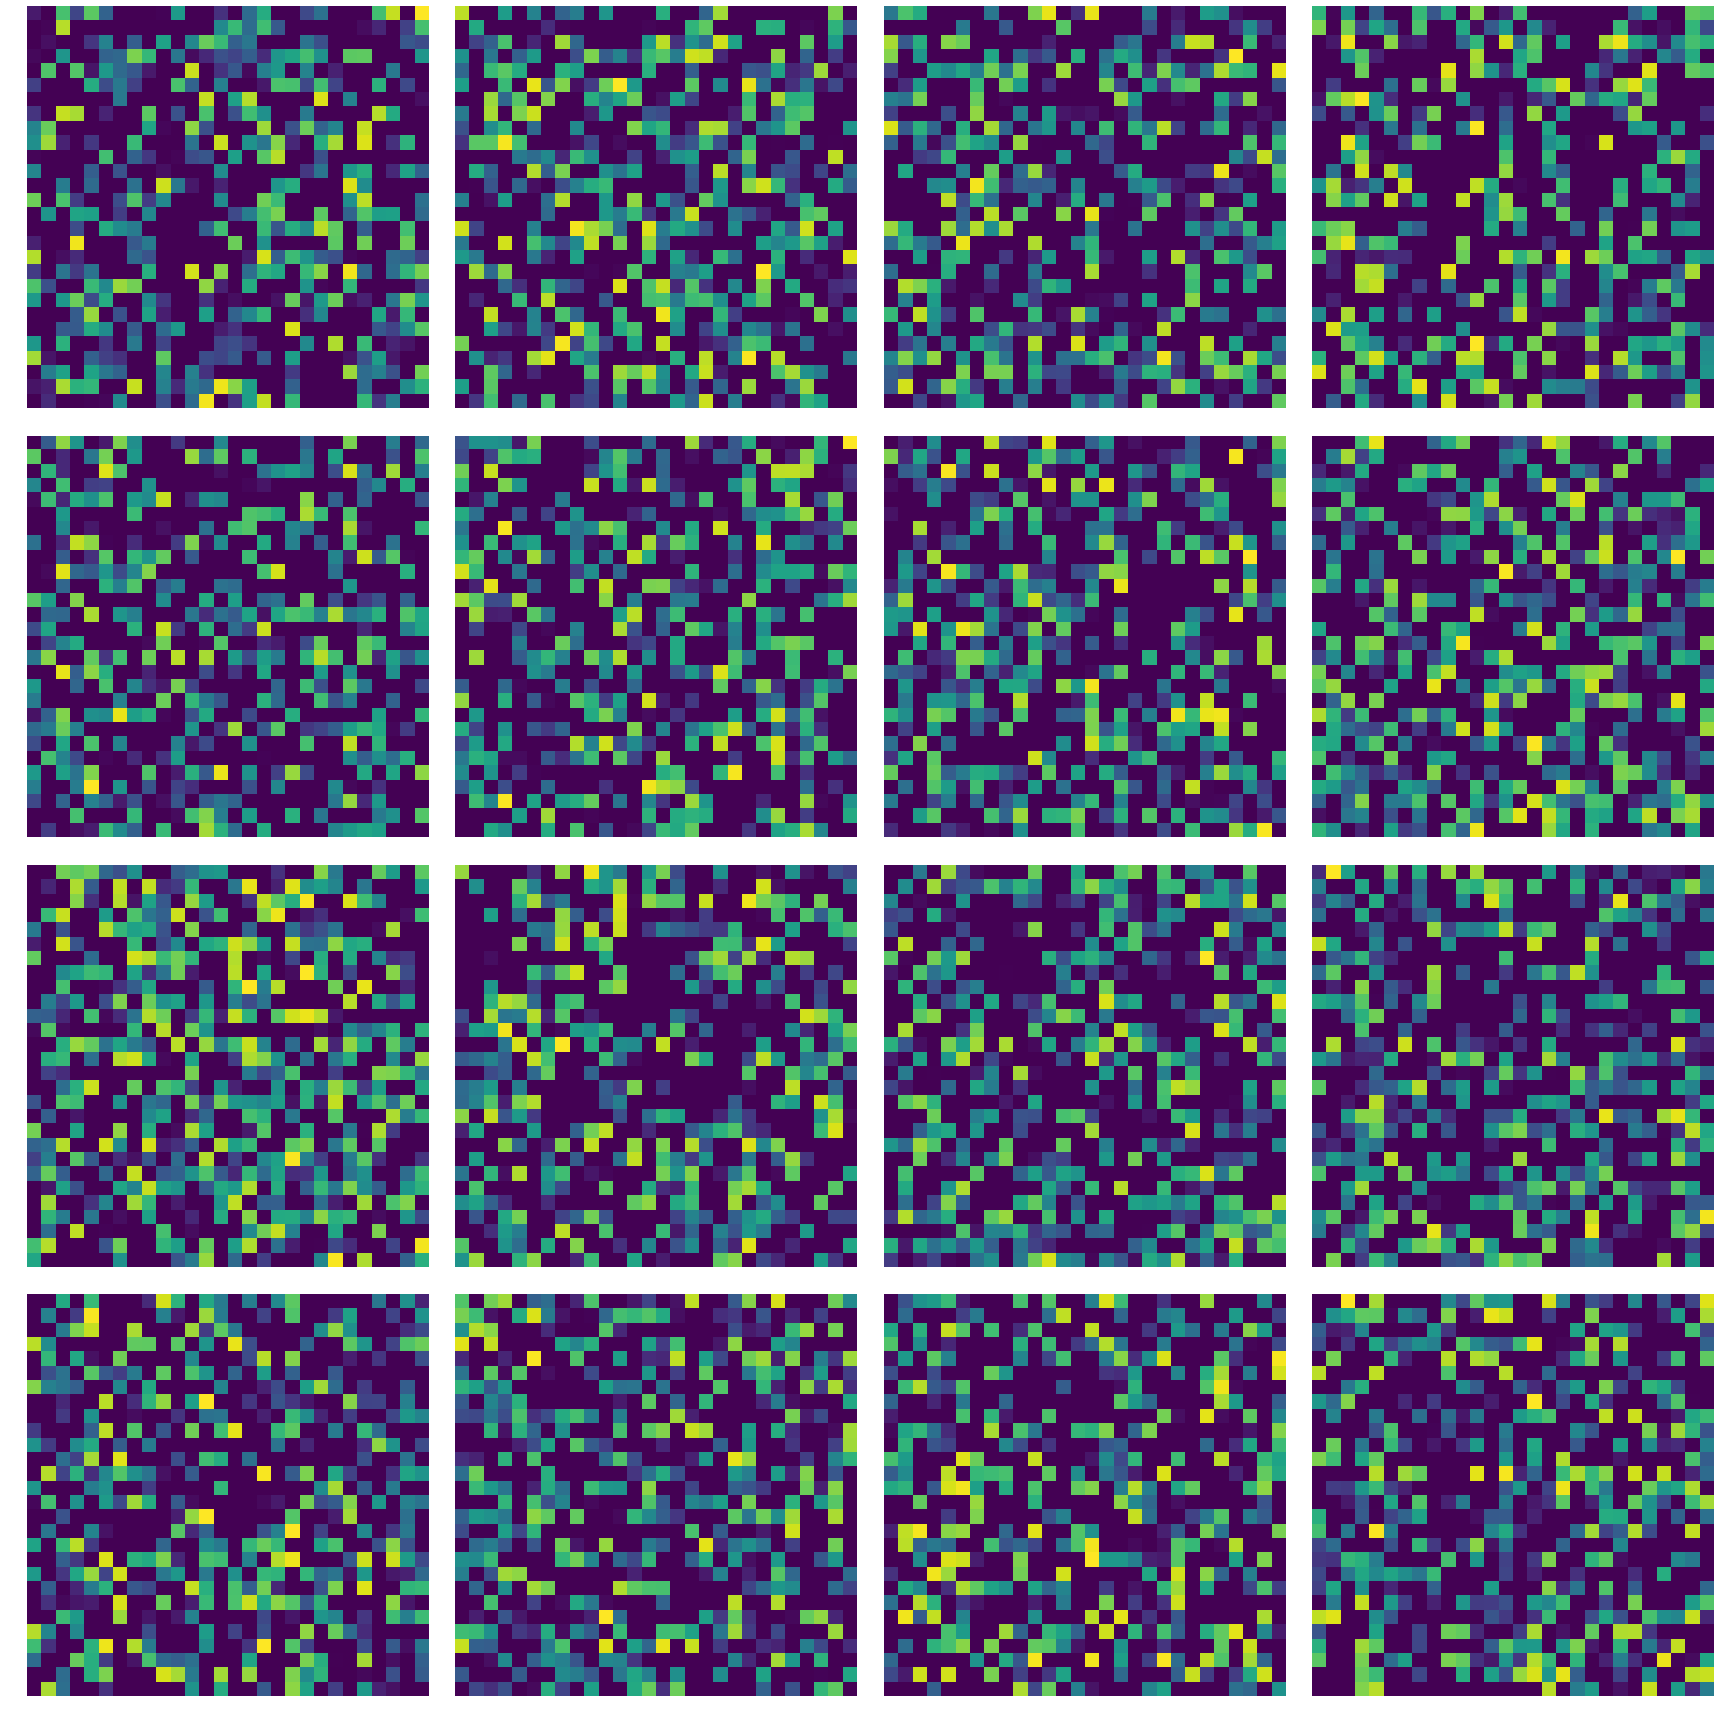

Epoch 3400, Generator loss 0.6862649321556091, discriminator loss 0.0033328281715512276


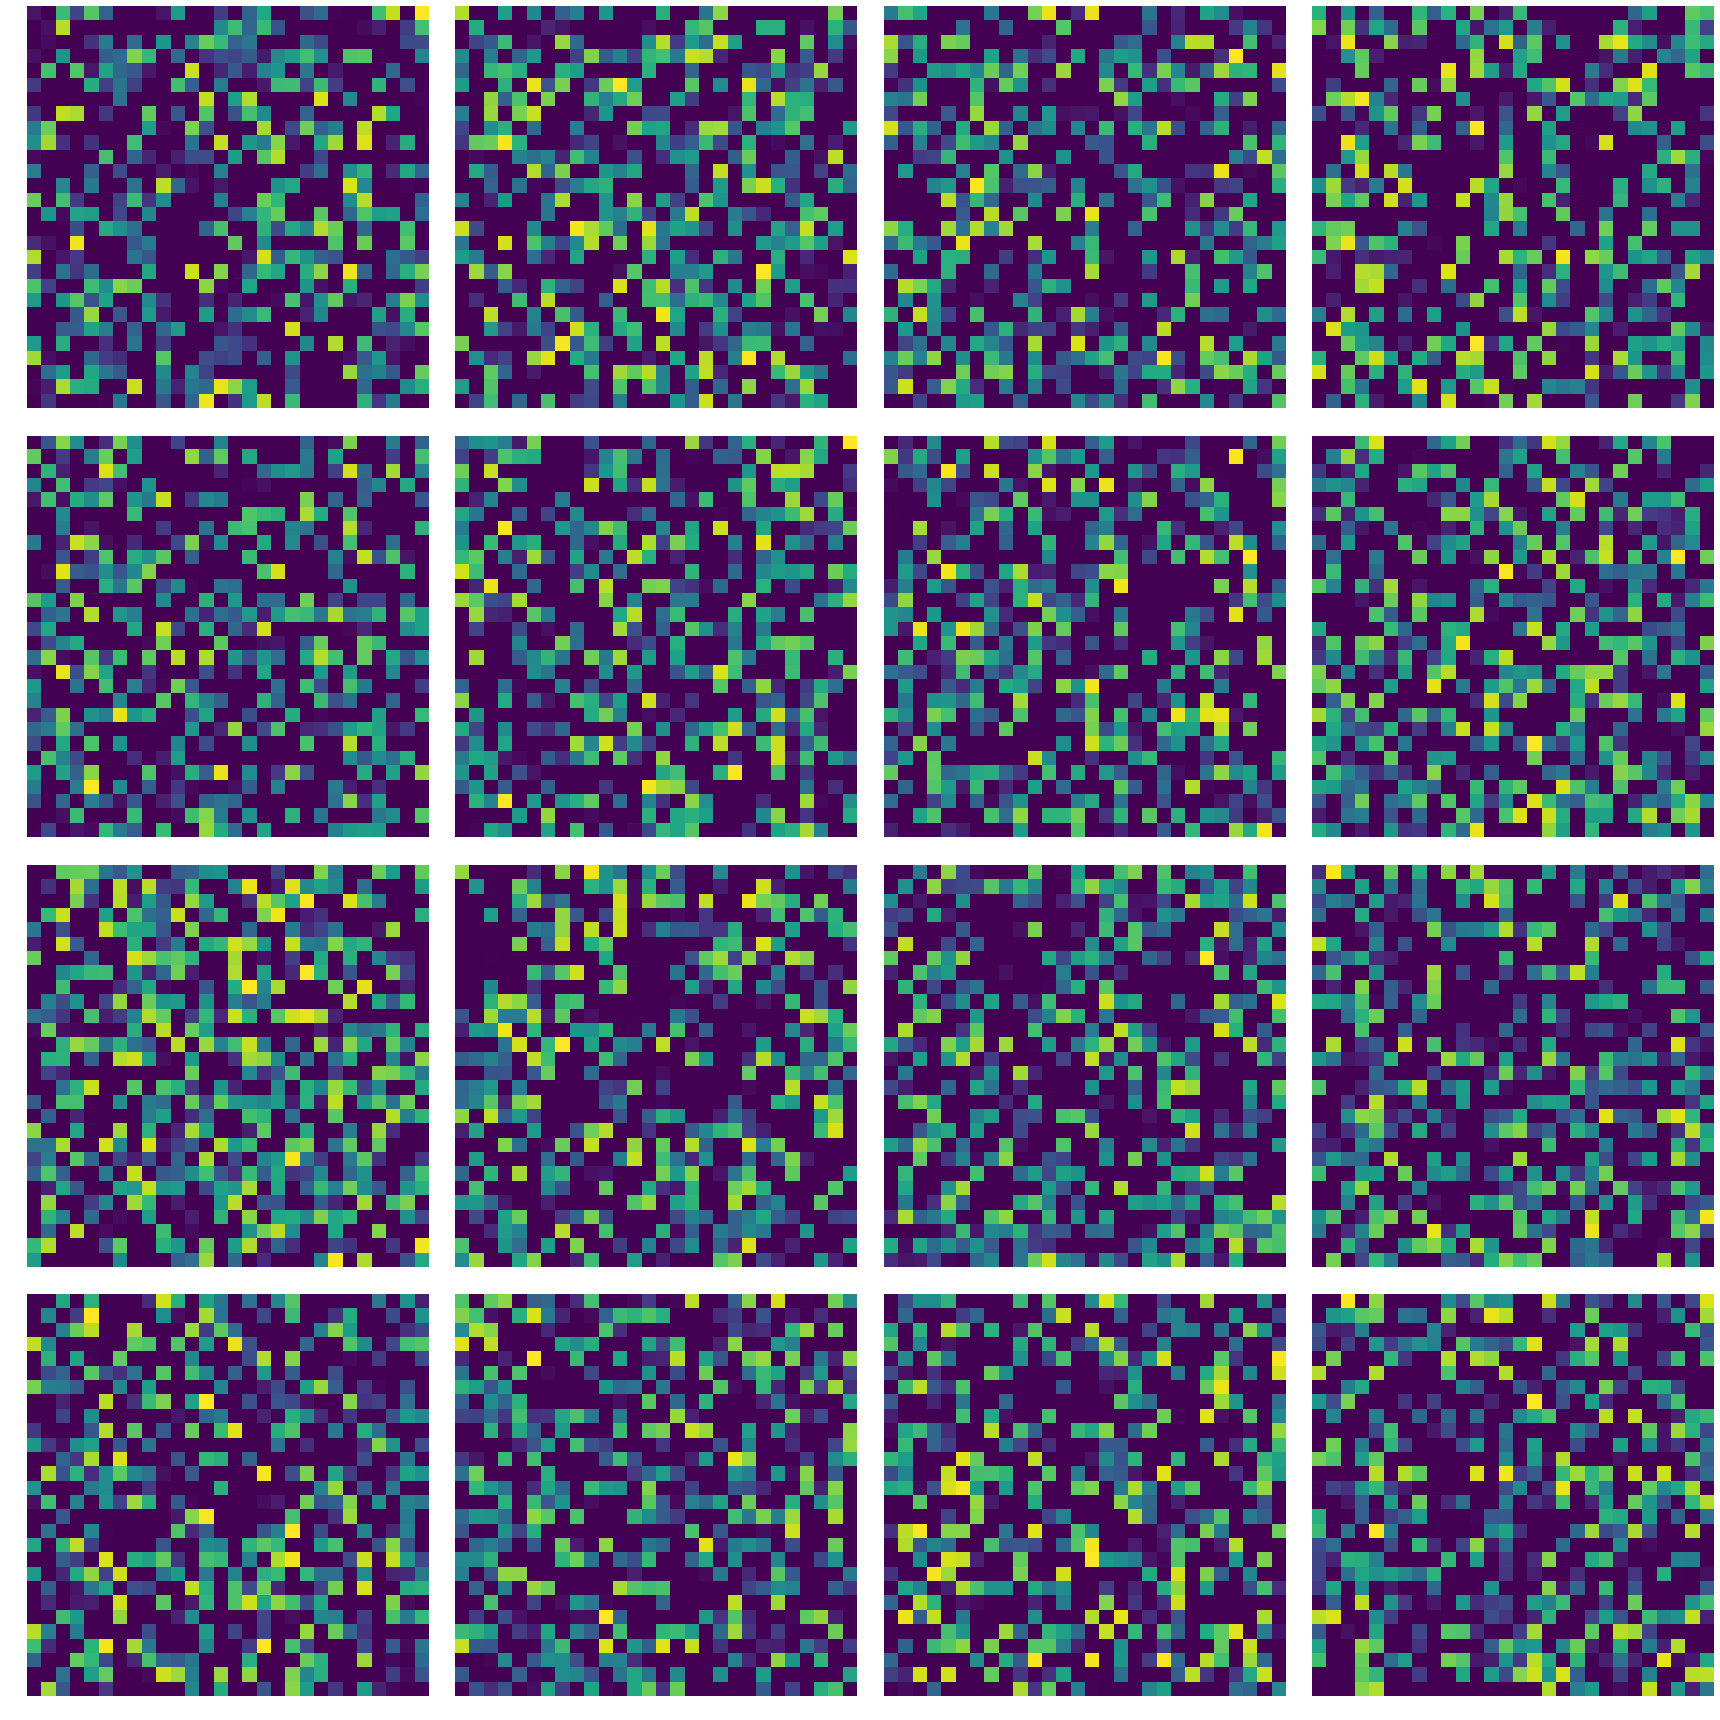

Epoch 3500, Generator loss 0.6747872829437256, discriminator loss 0.003254417795687914


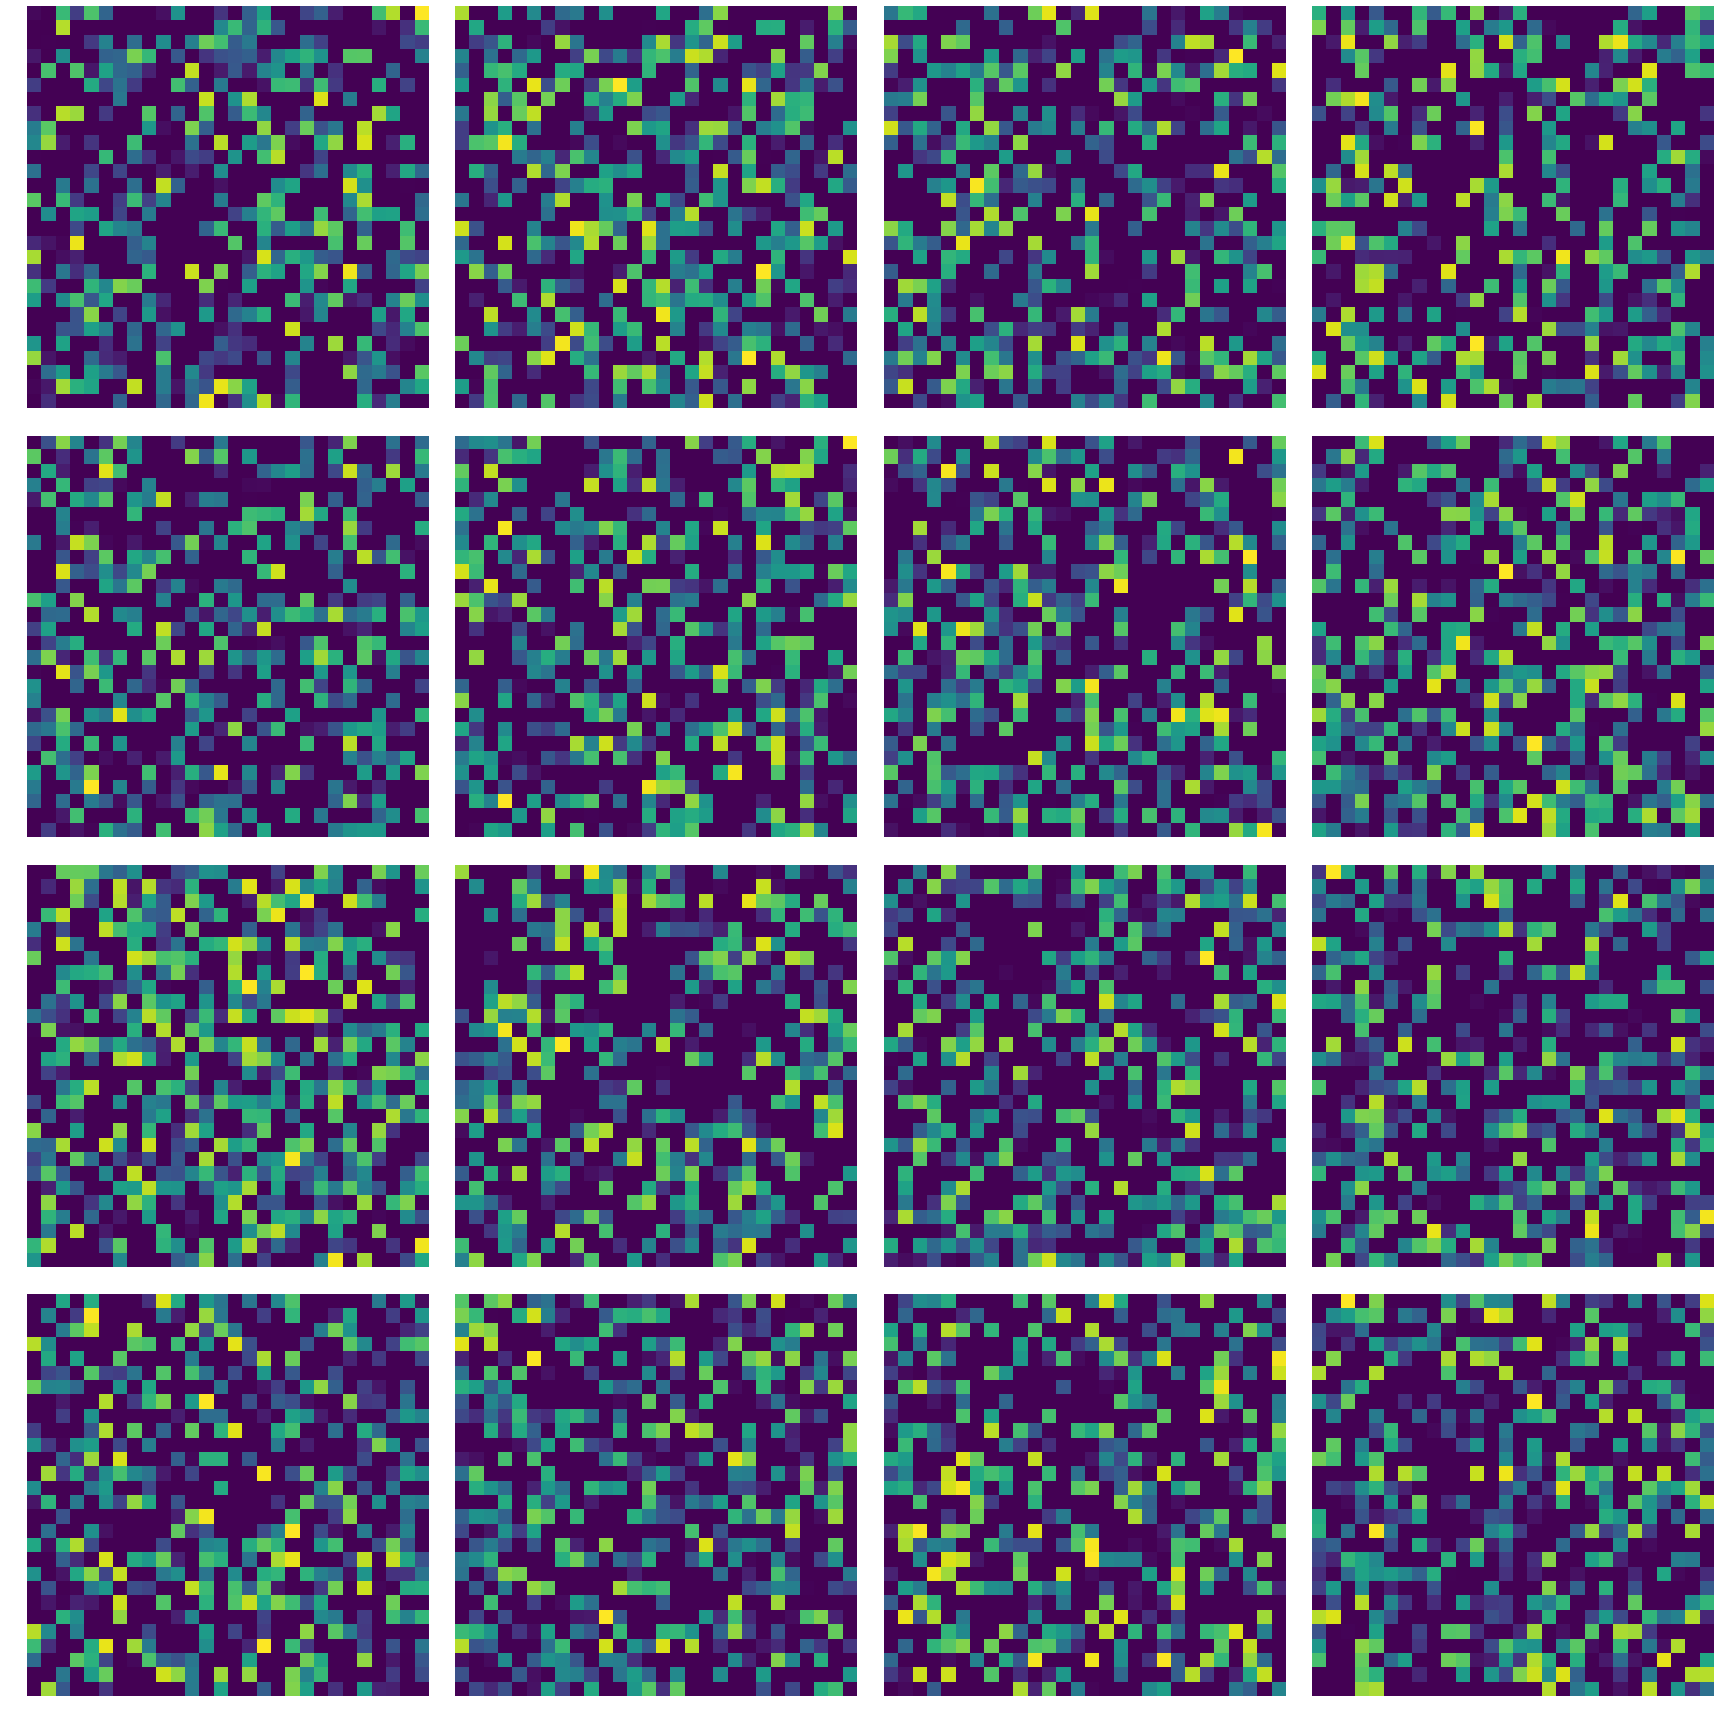

Epoch 3600, Generator loss 0.671481192111969, discriminator loss 0.0031778300181031227


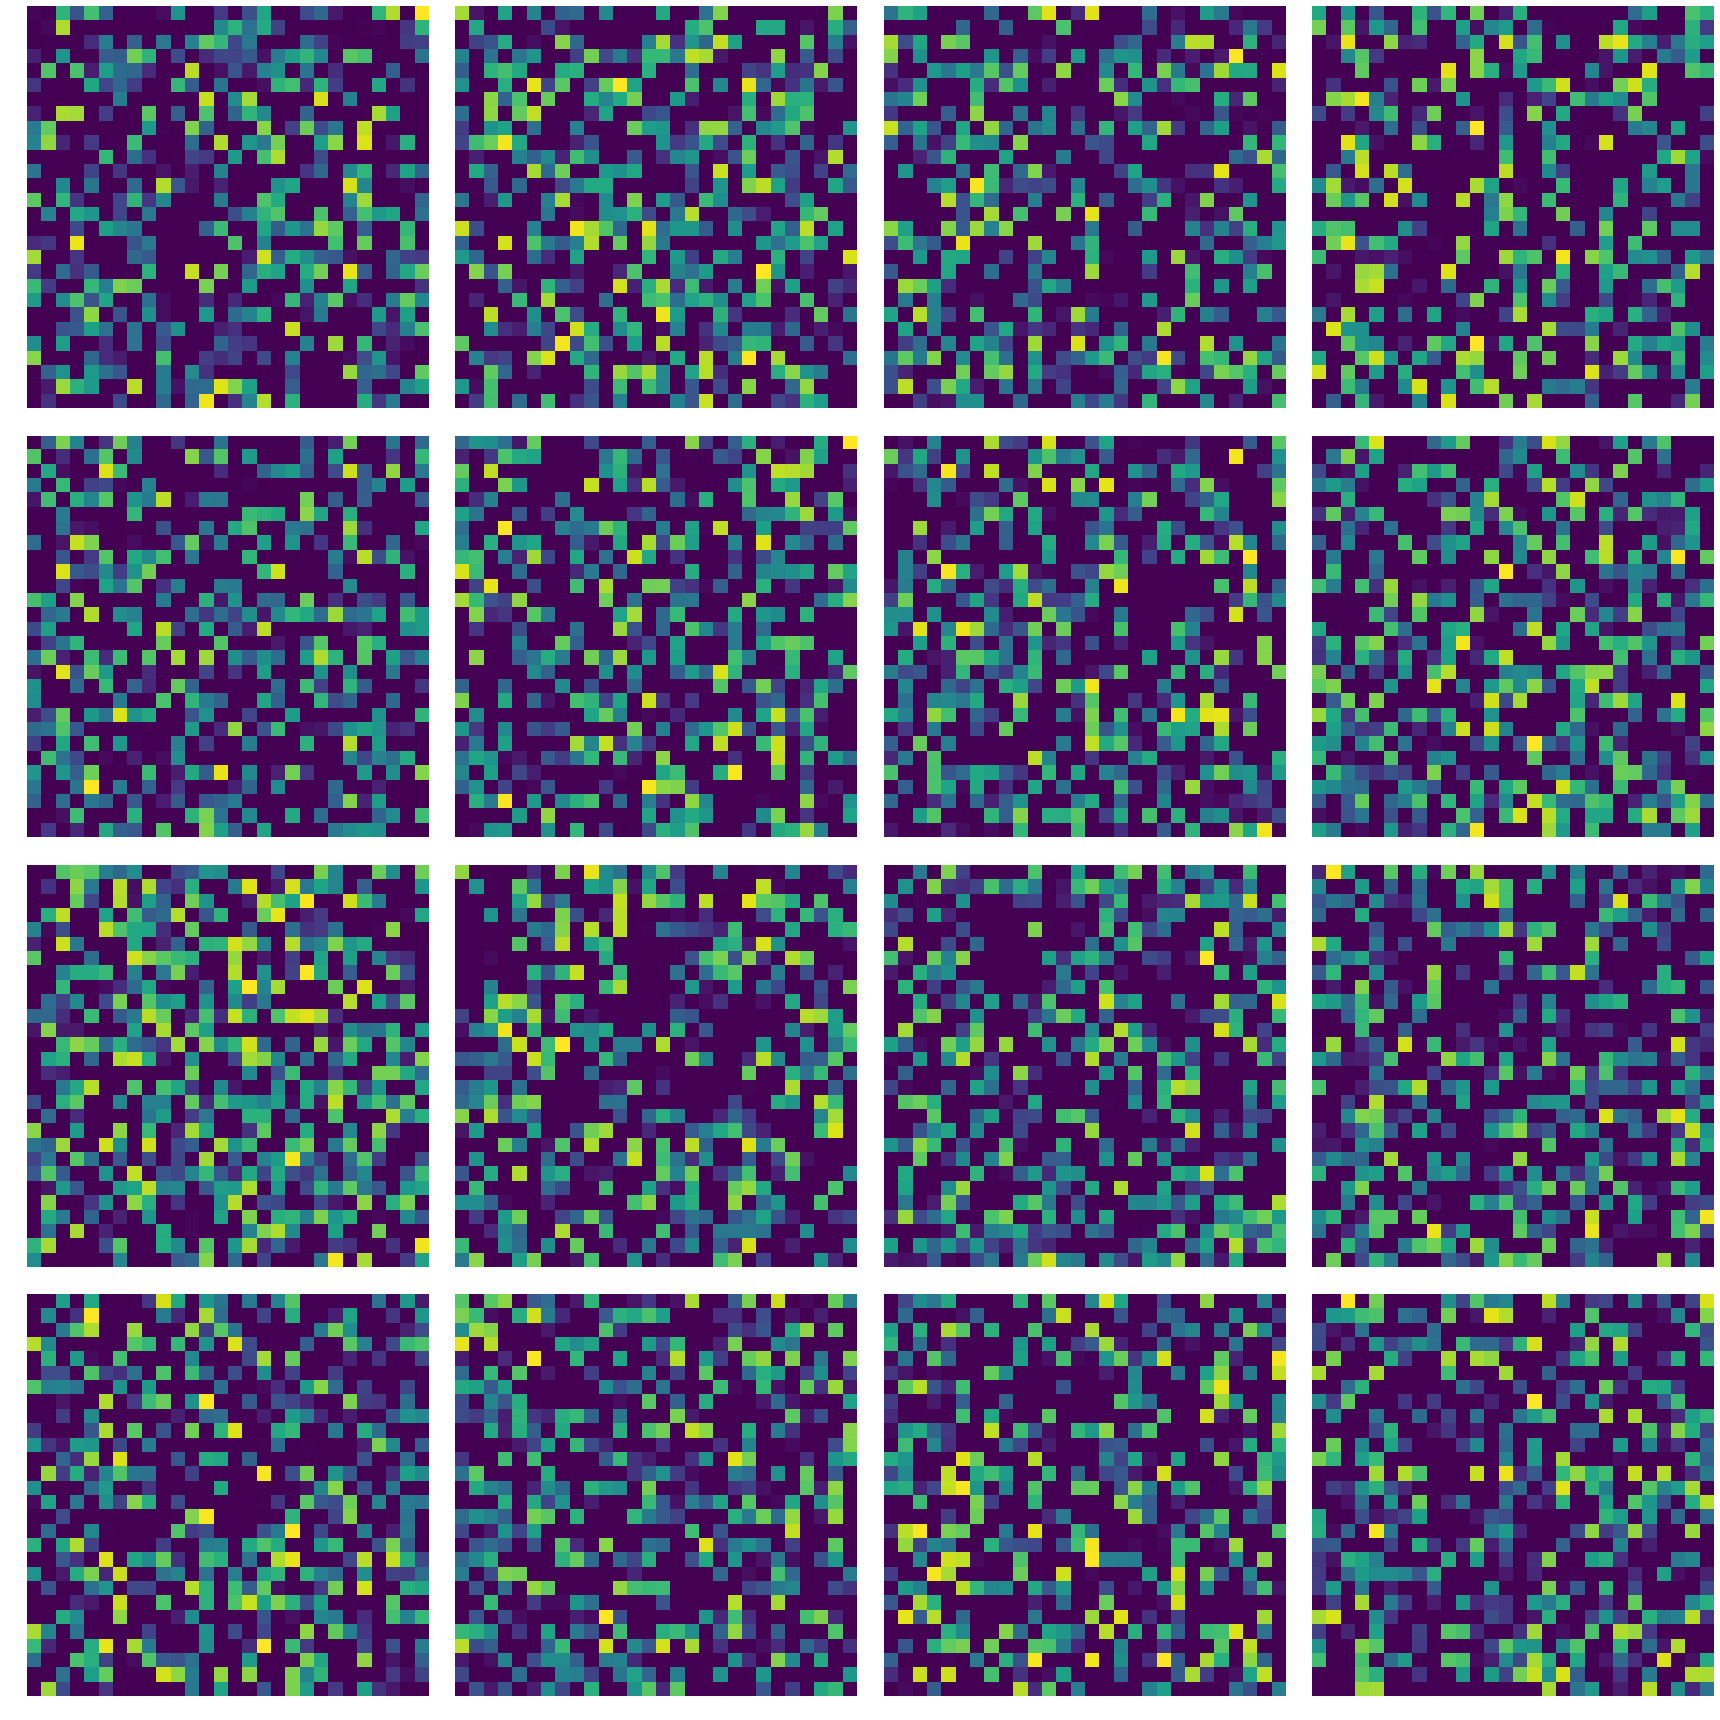

Epoch 3700, Generator loss 0.6727452278137207, discriminator loss 0.003099440596997738


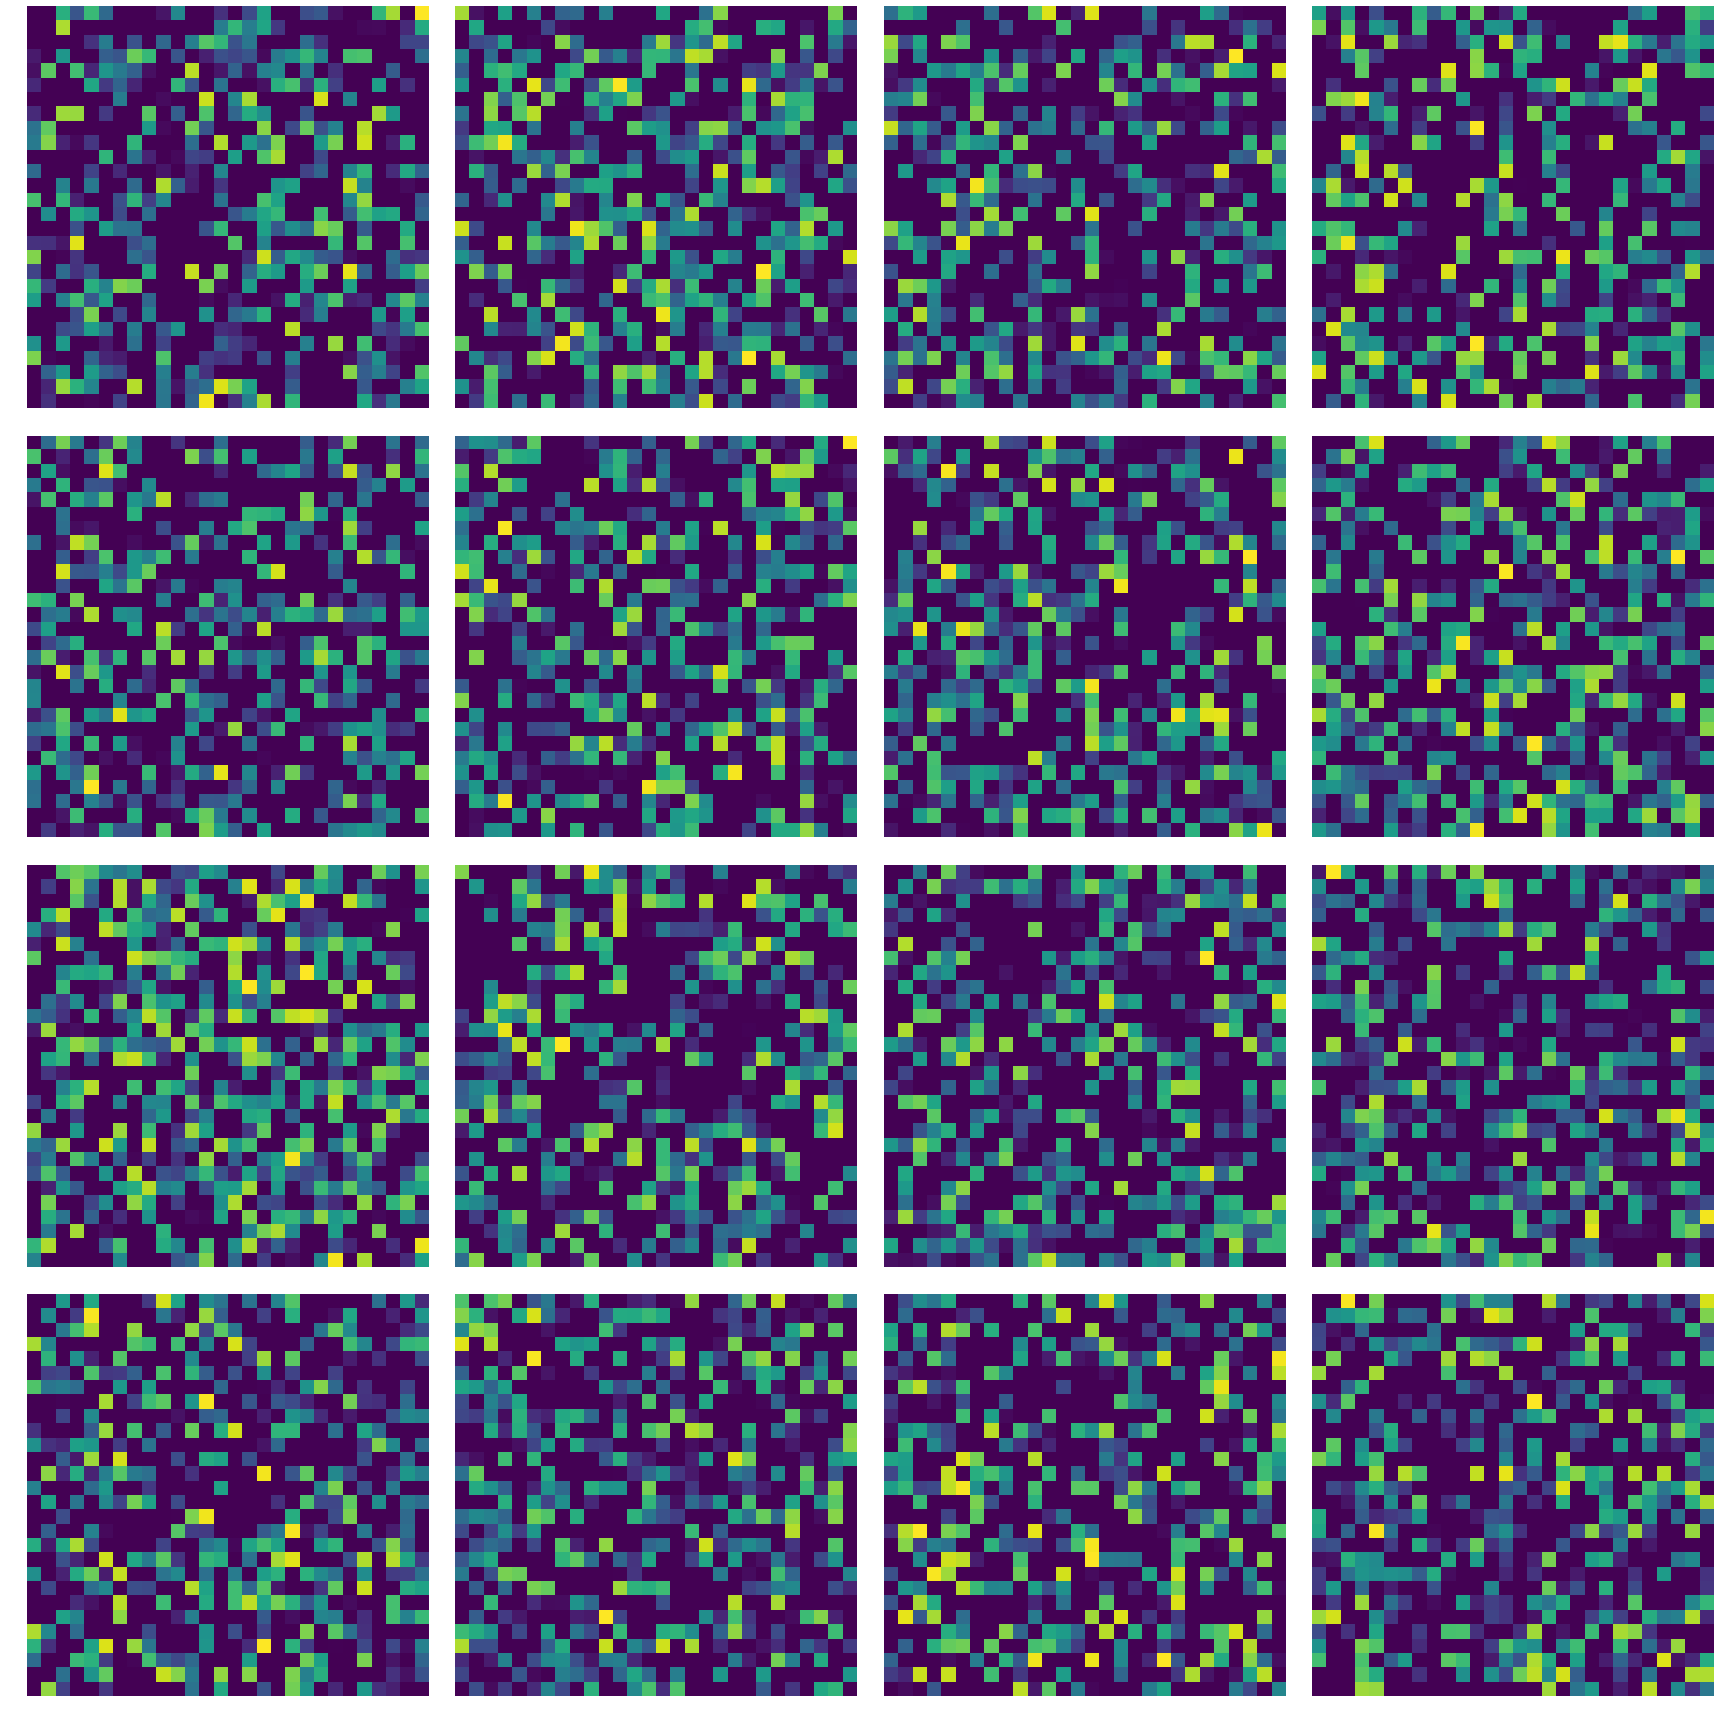

Epoch 3800, Generator loss 0.6594347953796387, discriminator loss 0.0030153081752359867


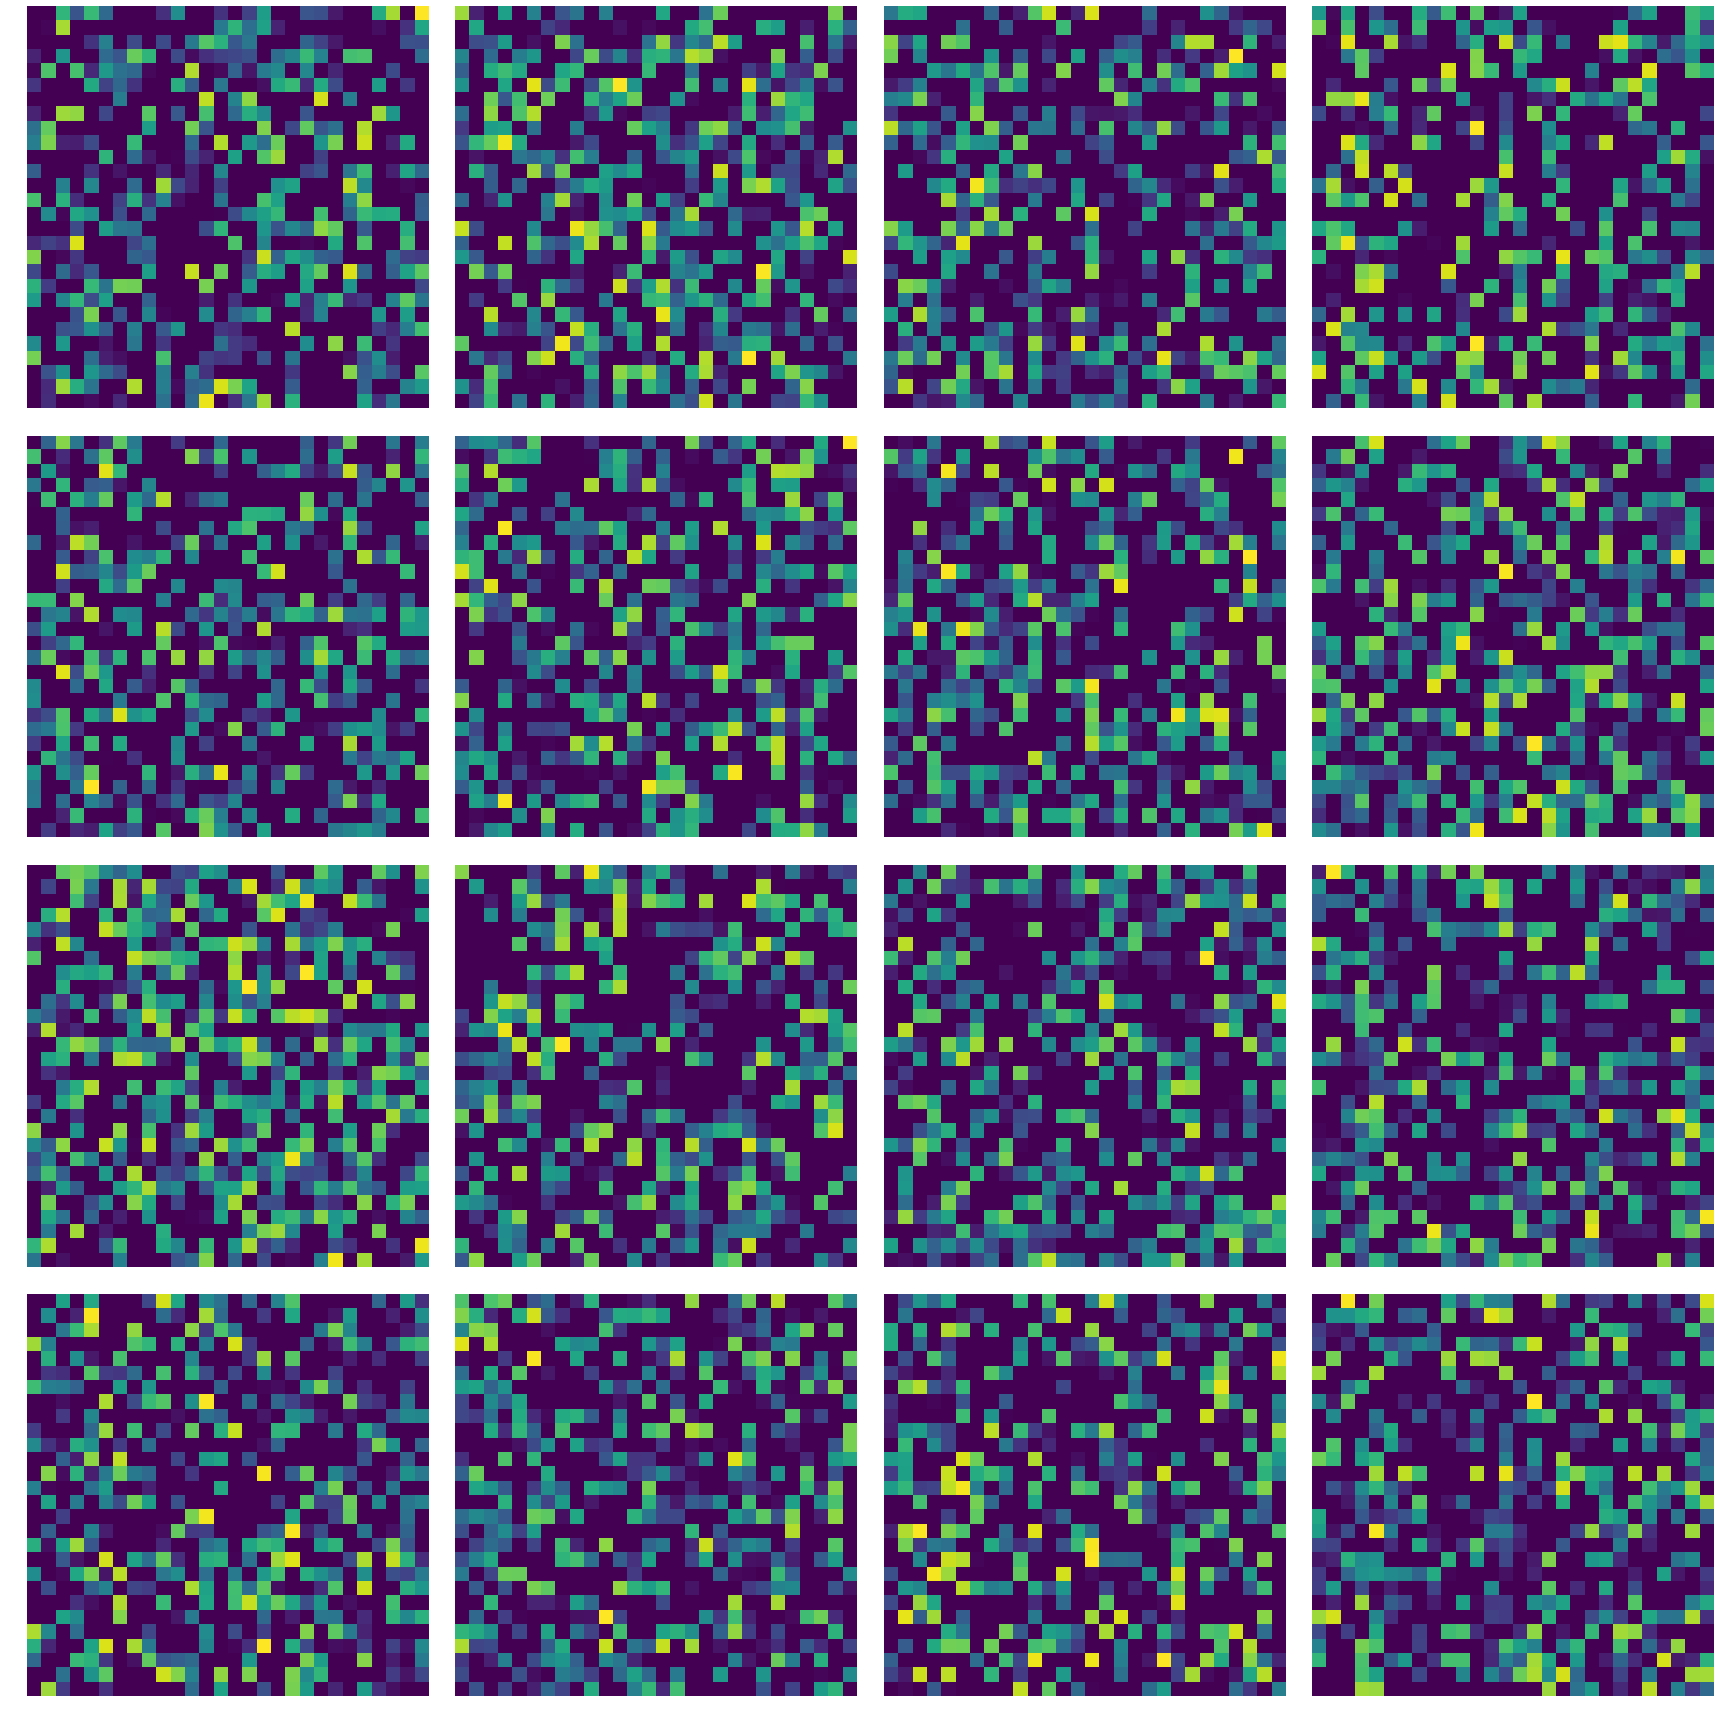

Epoch 3900, Generator loss 0.6458876729011536, discriminator loss 0.002940727863460779


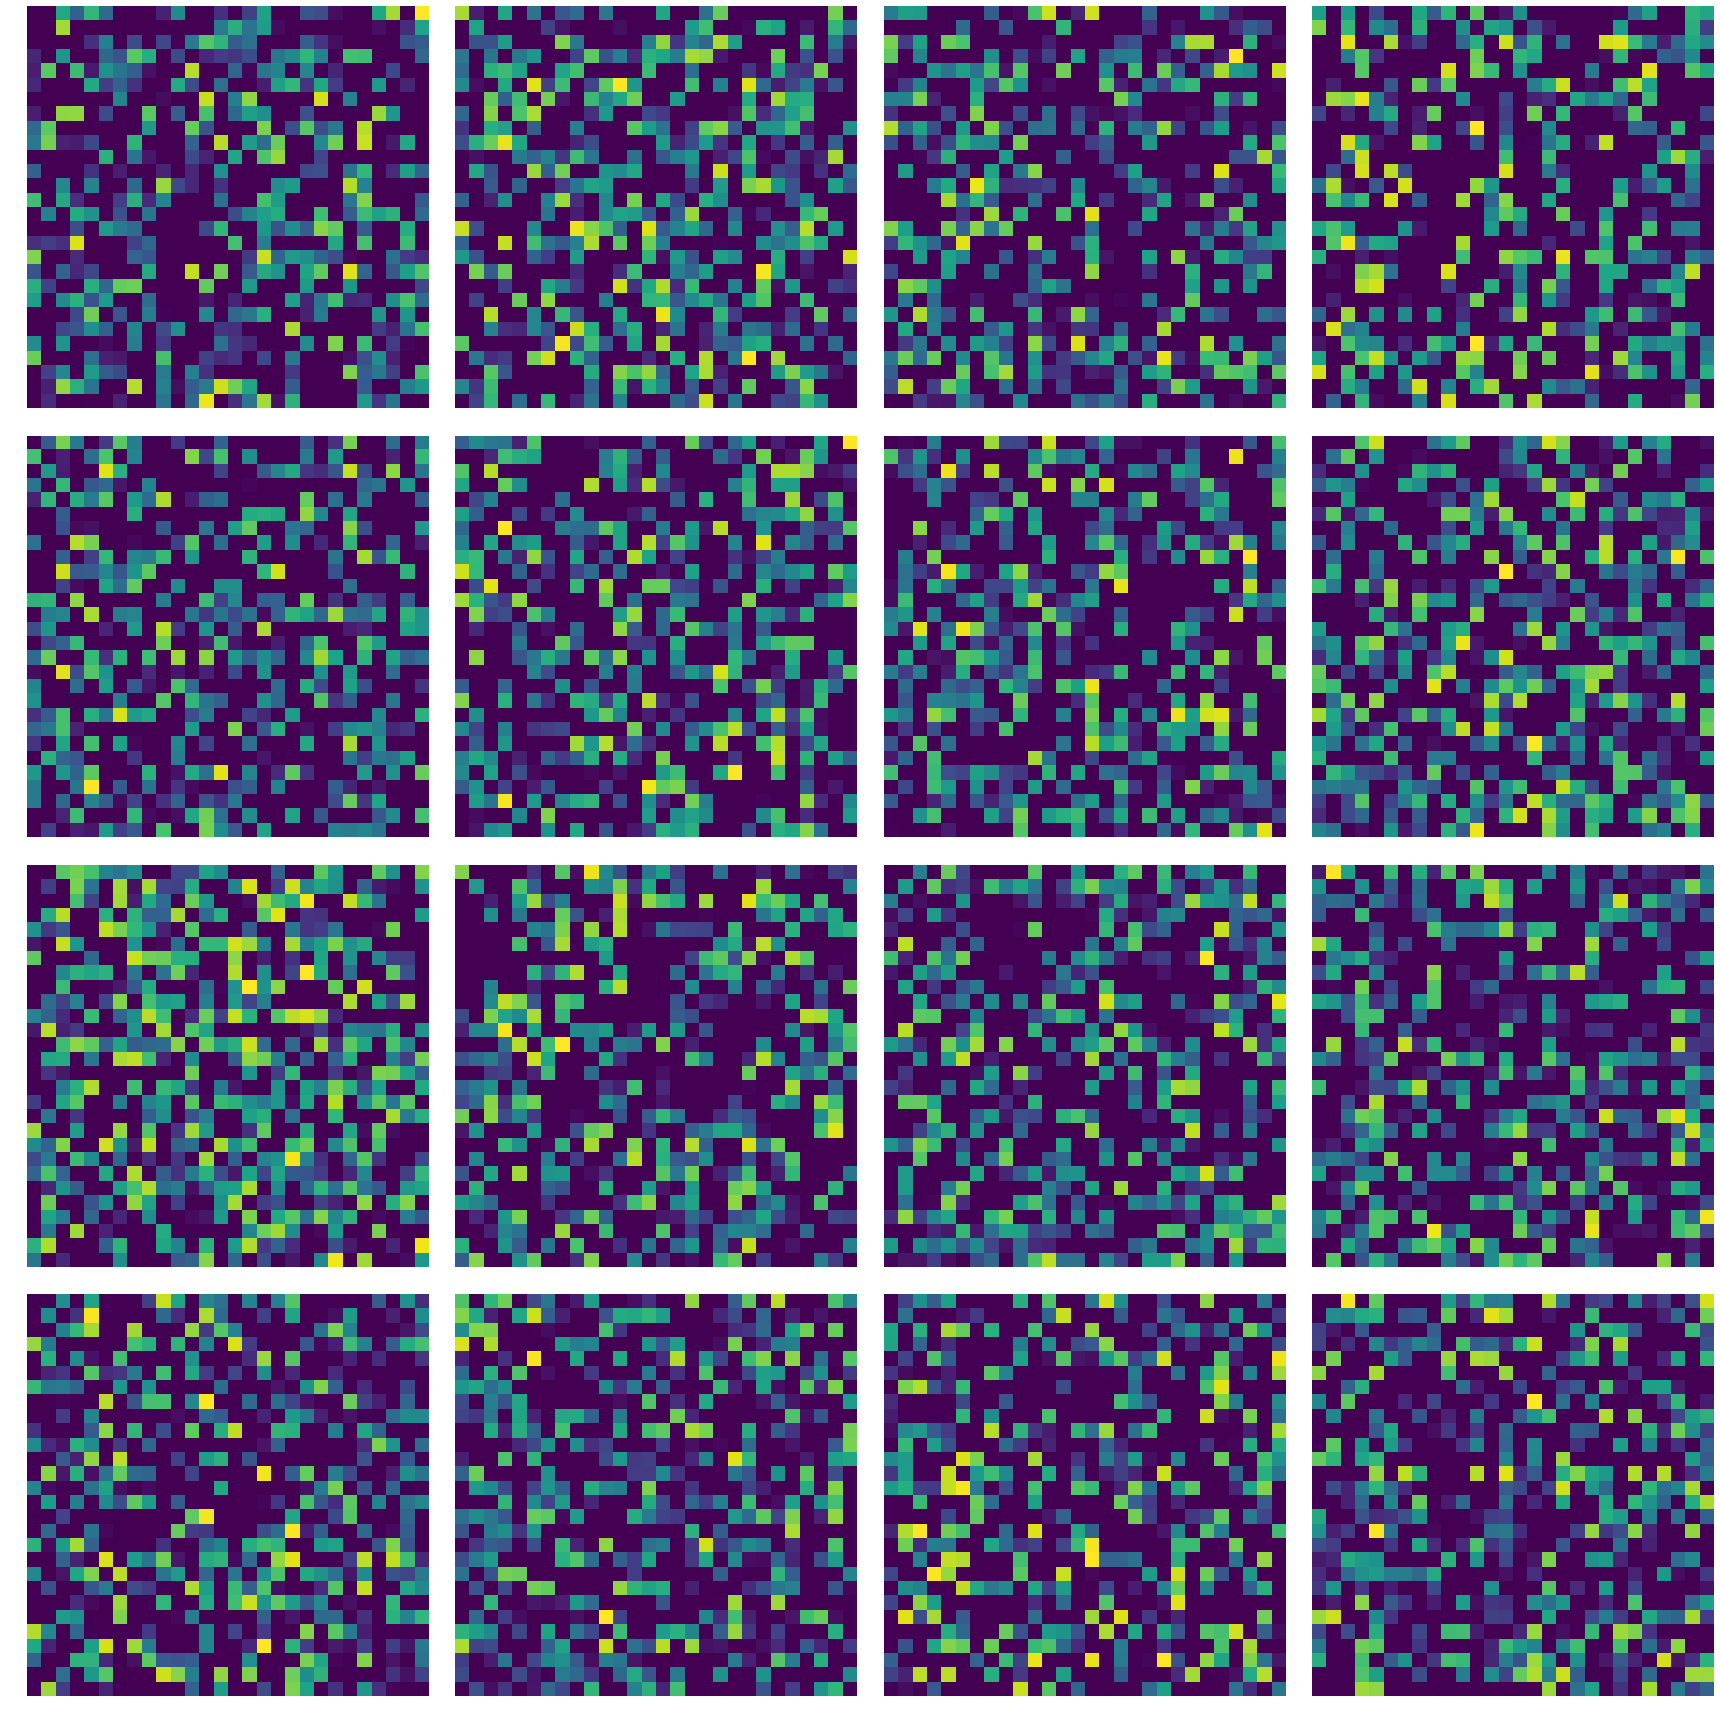

Epoch 4000, Generator loss 0.660872757434845, discriminator loss 0.0028639542870223522


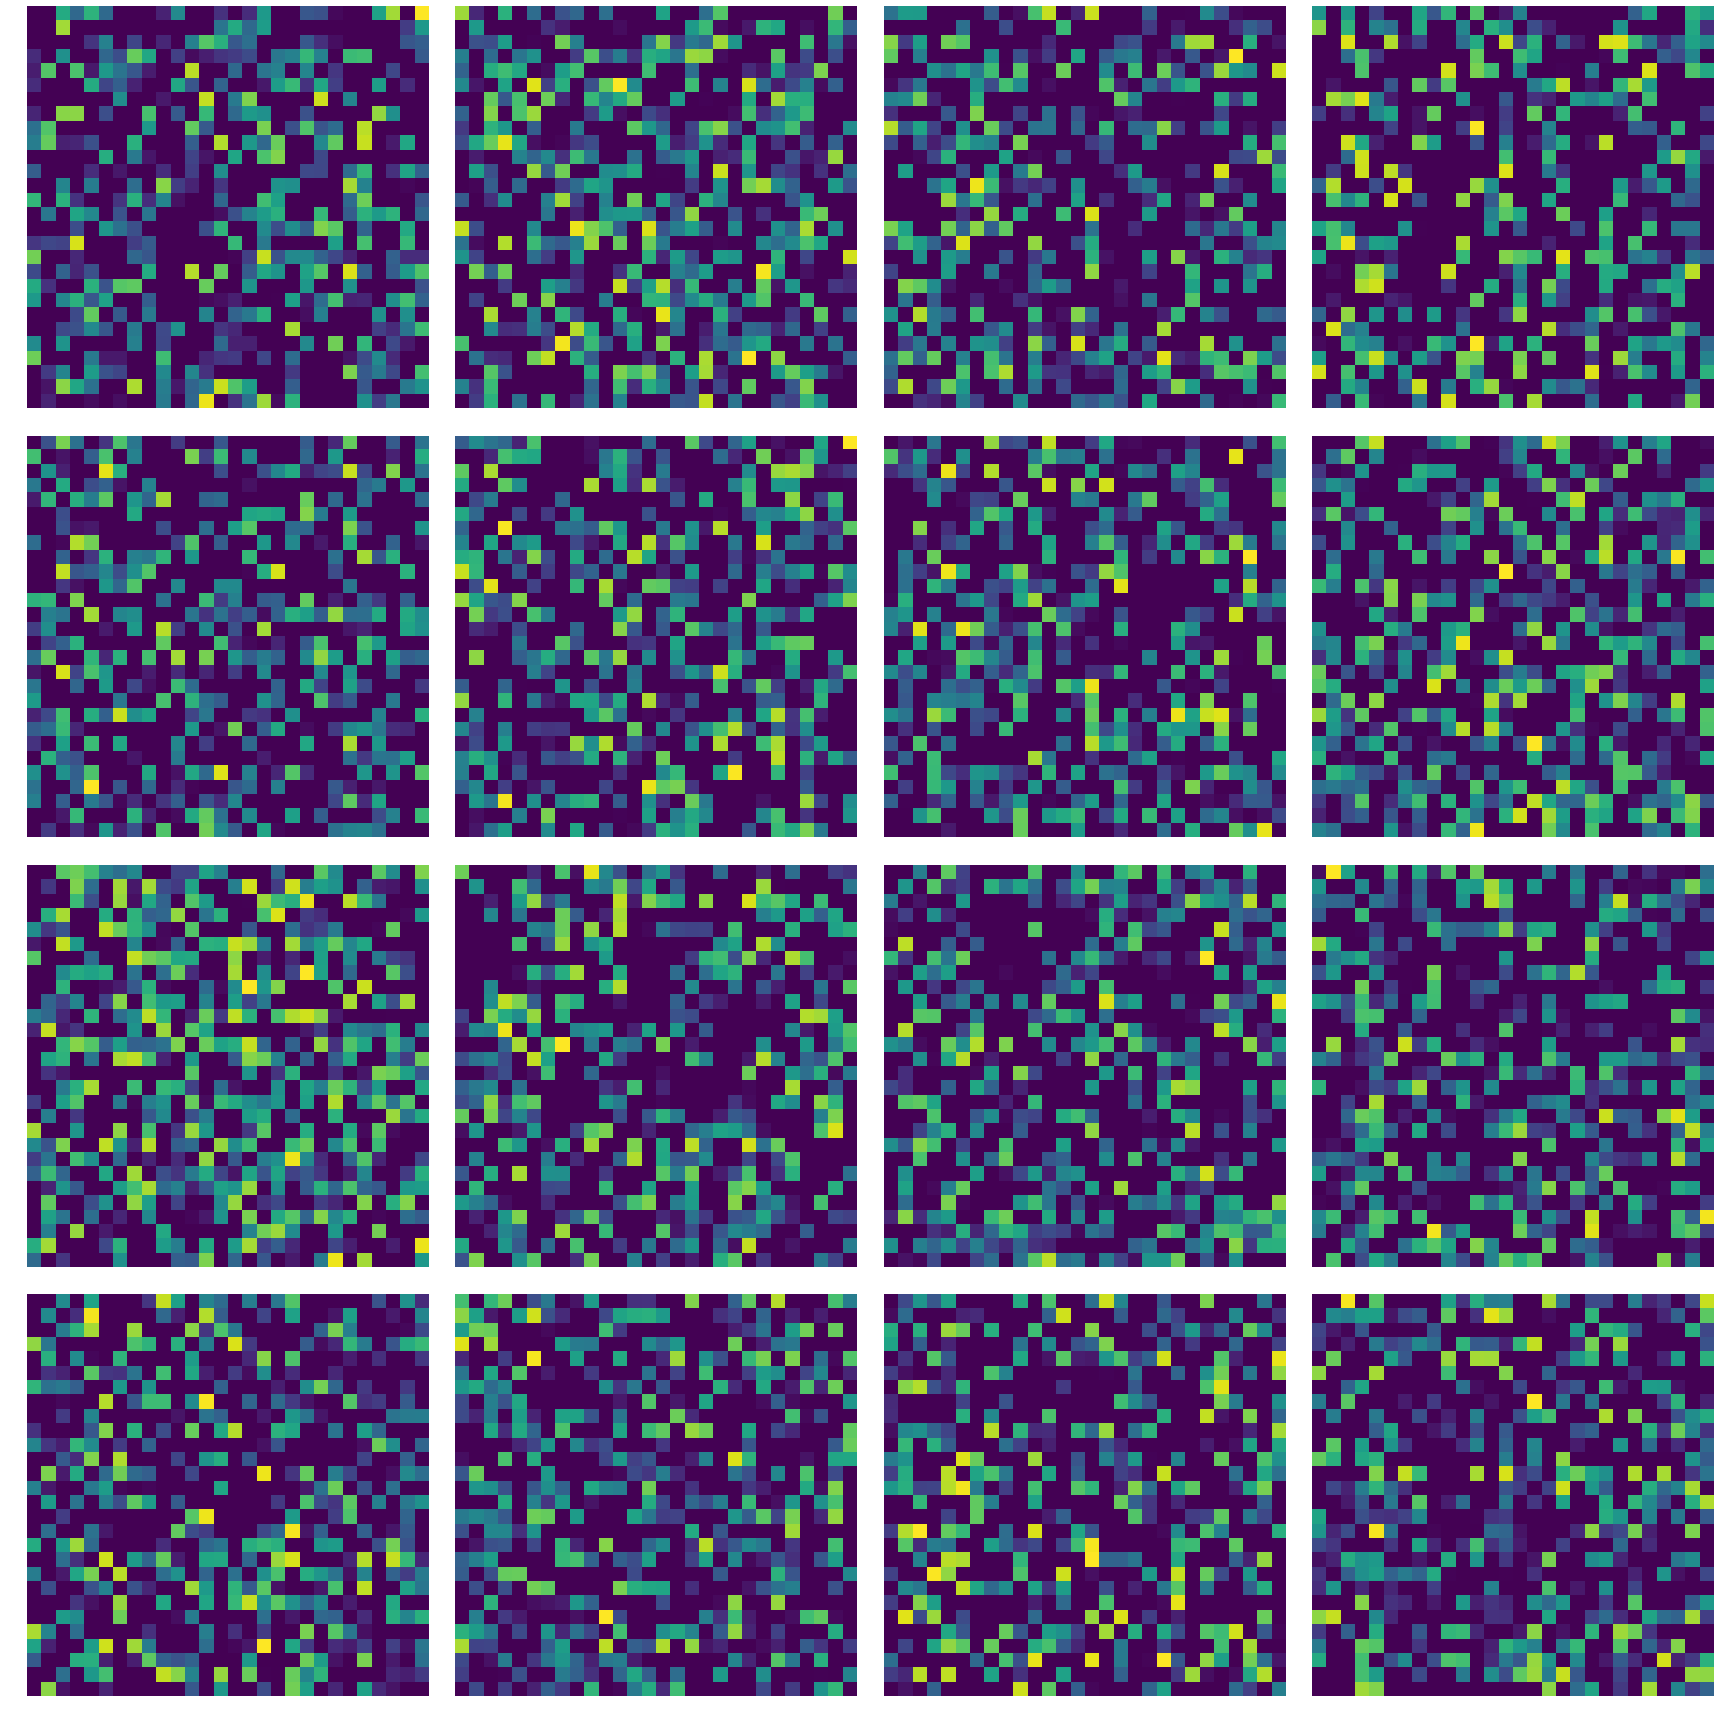

Epoch 4100, Generator loss 0.6573910117149353, discriminator loss 0.002787129022181034


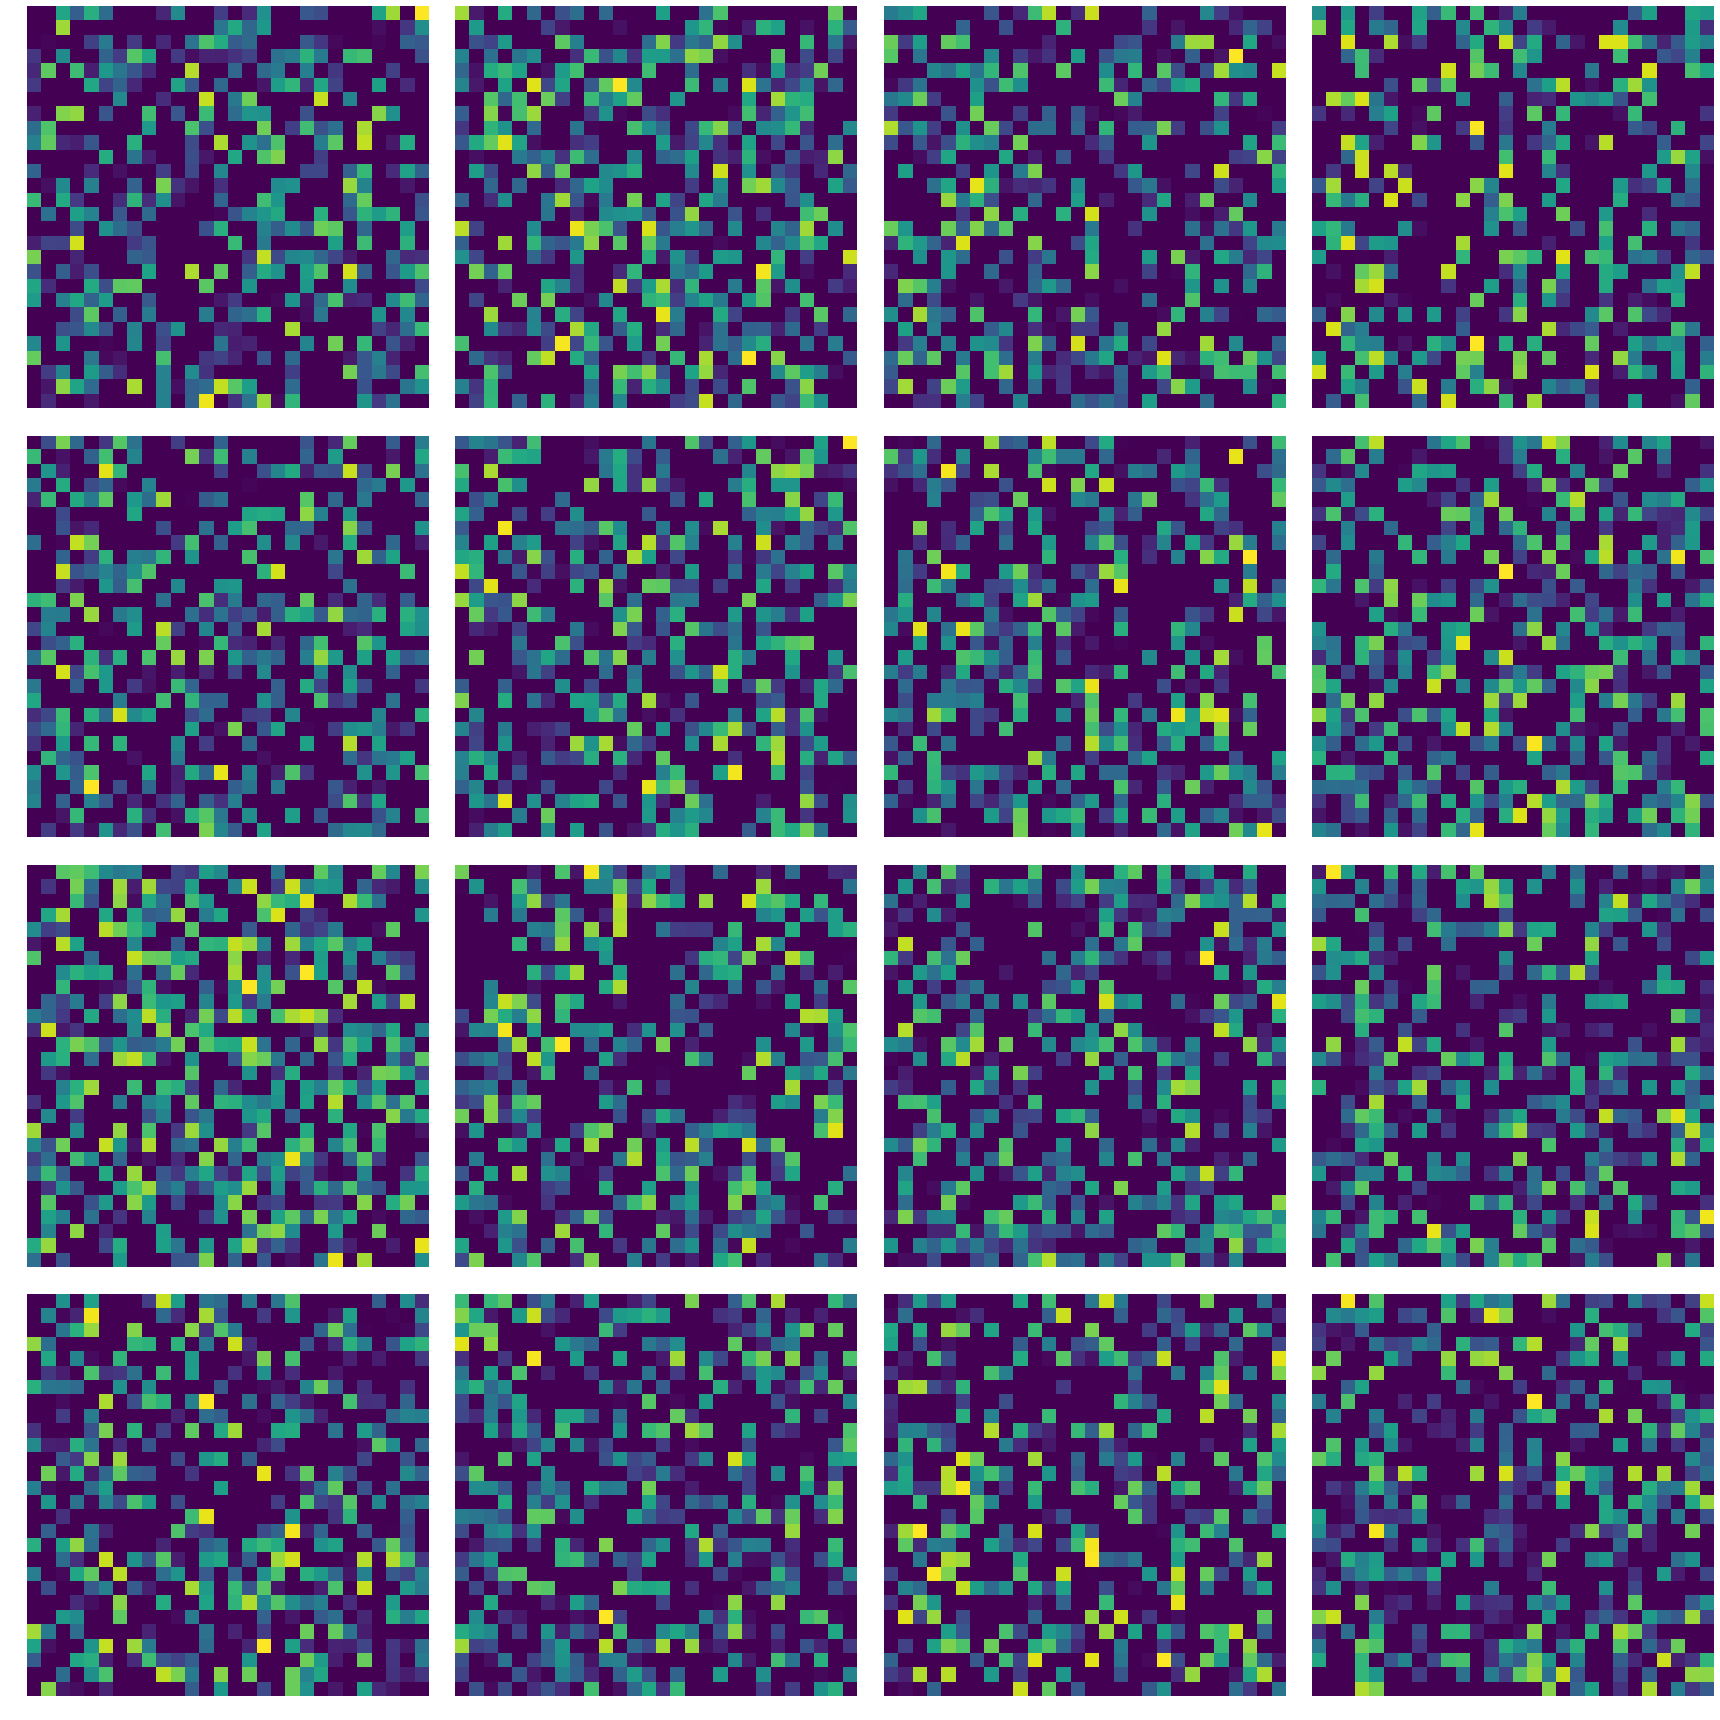

Epoch 4200, Generator loss 0.6516019701957703, discriminator loss 0.002709930296987295


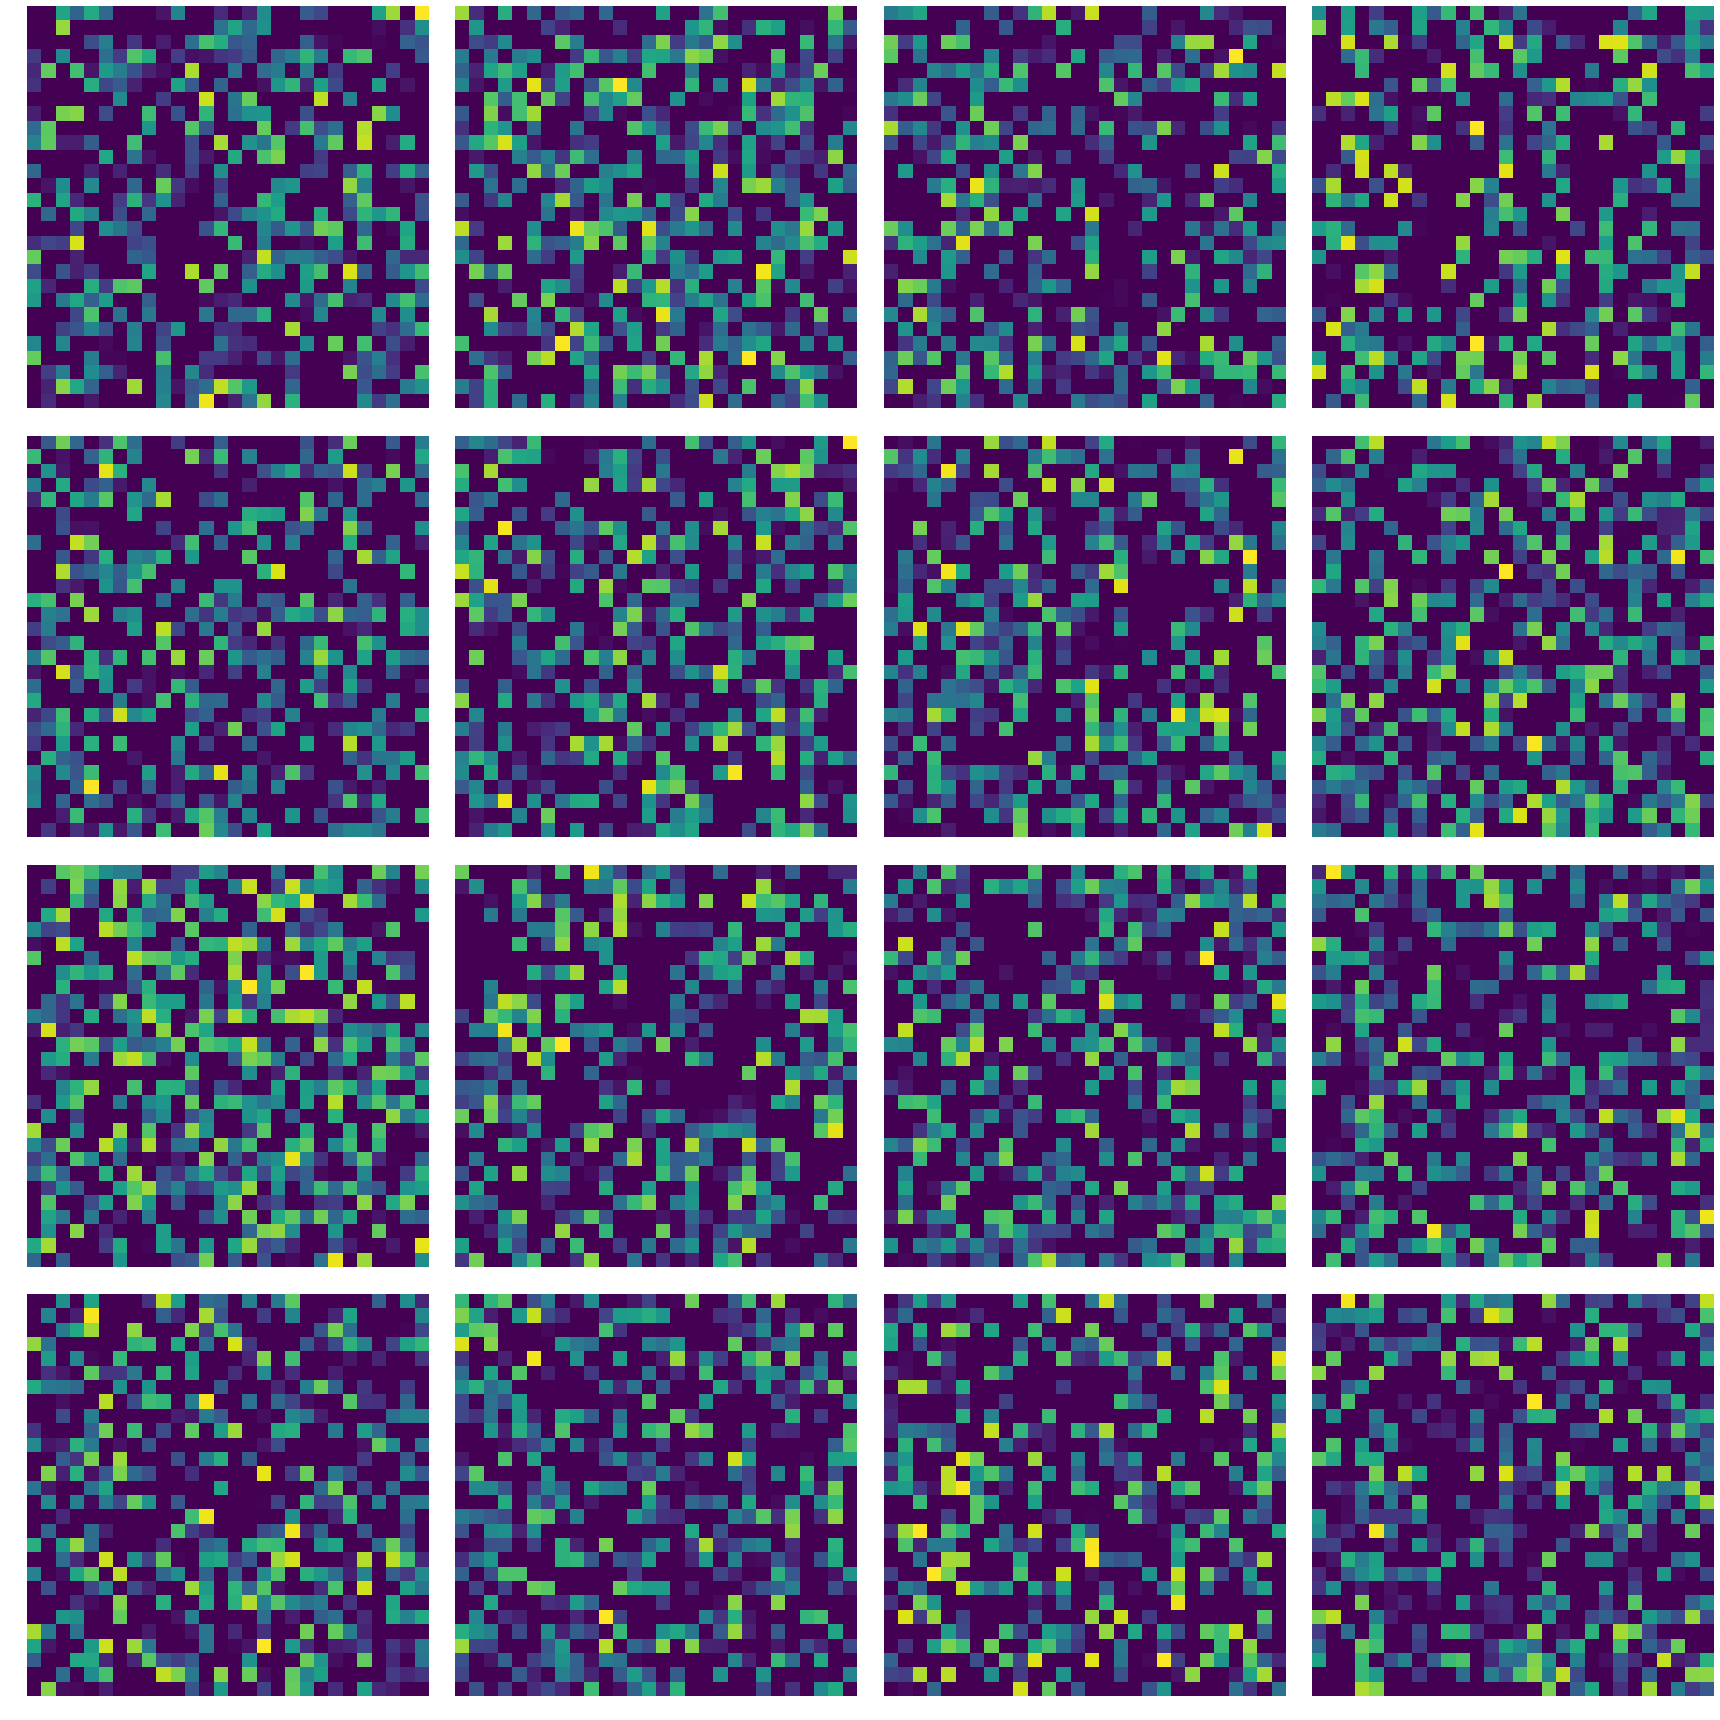

Epoch 4300, Generator loss 0.6503180265426636, discriminator loss 0.002635302022099495


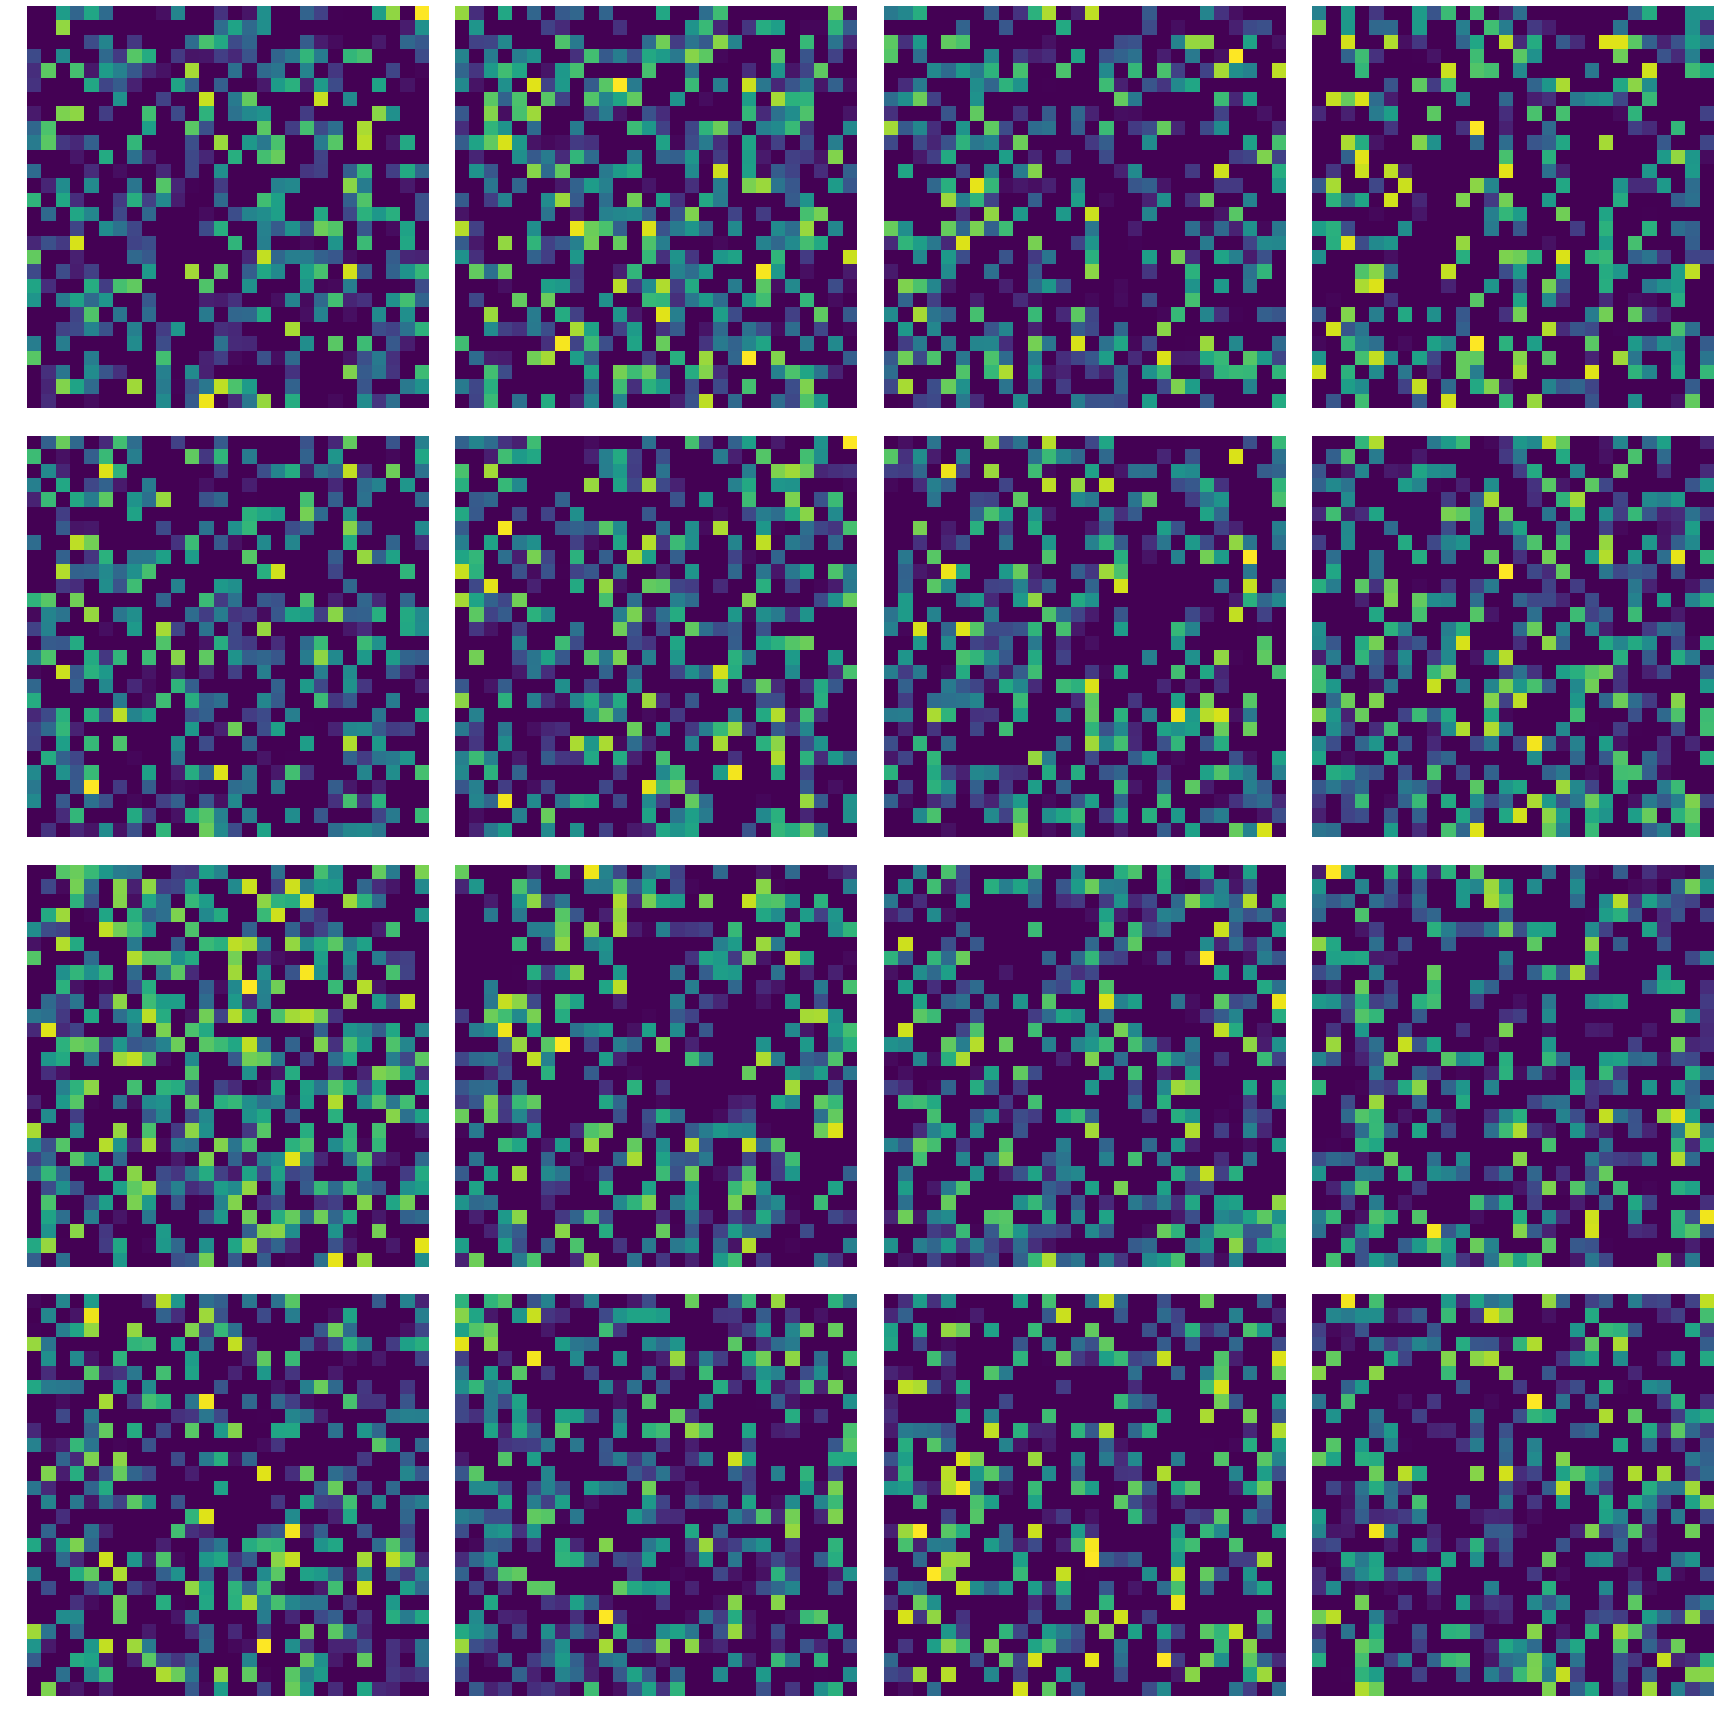

Epoch 4400, Generator loss 0.6421934366226196, discriminator loss 0.0025634397752583027


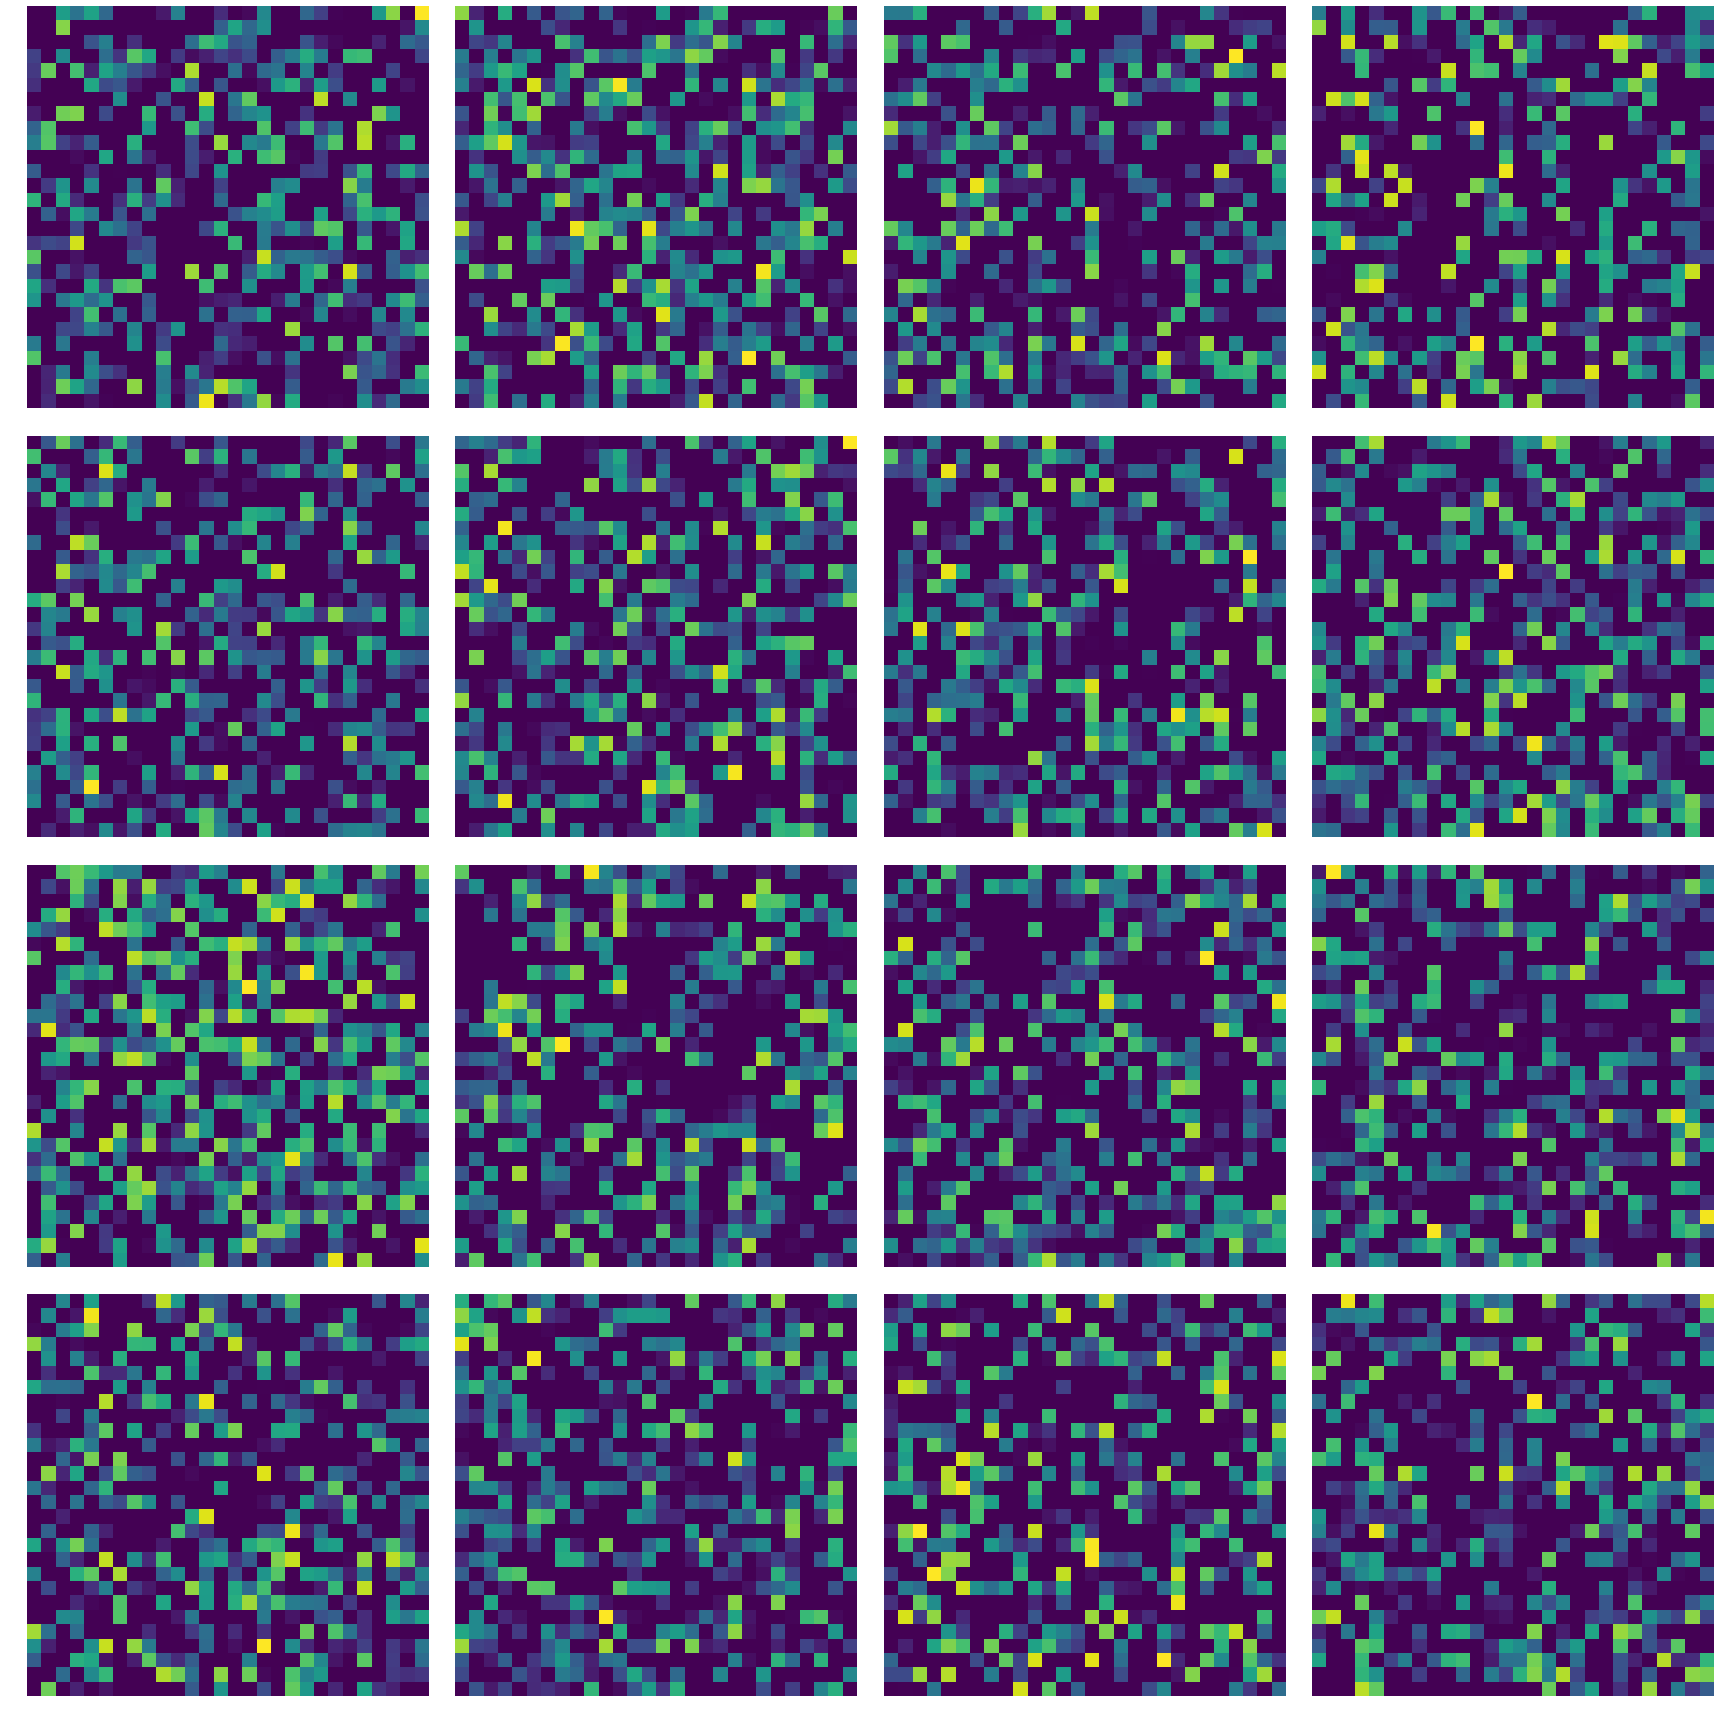

Epoch 4500, Generator loss 0.6504989862442017, discriminator loss 0.00249070324935019


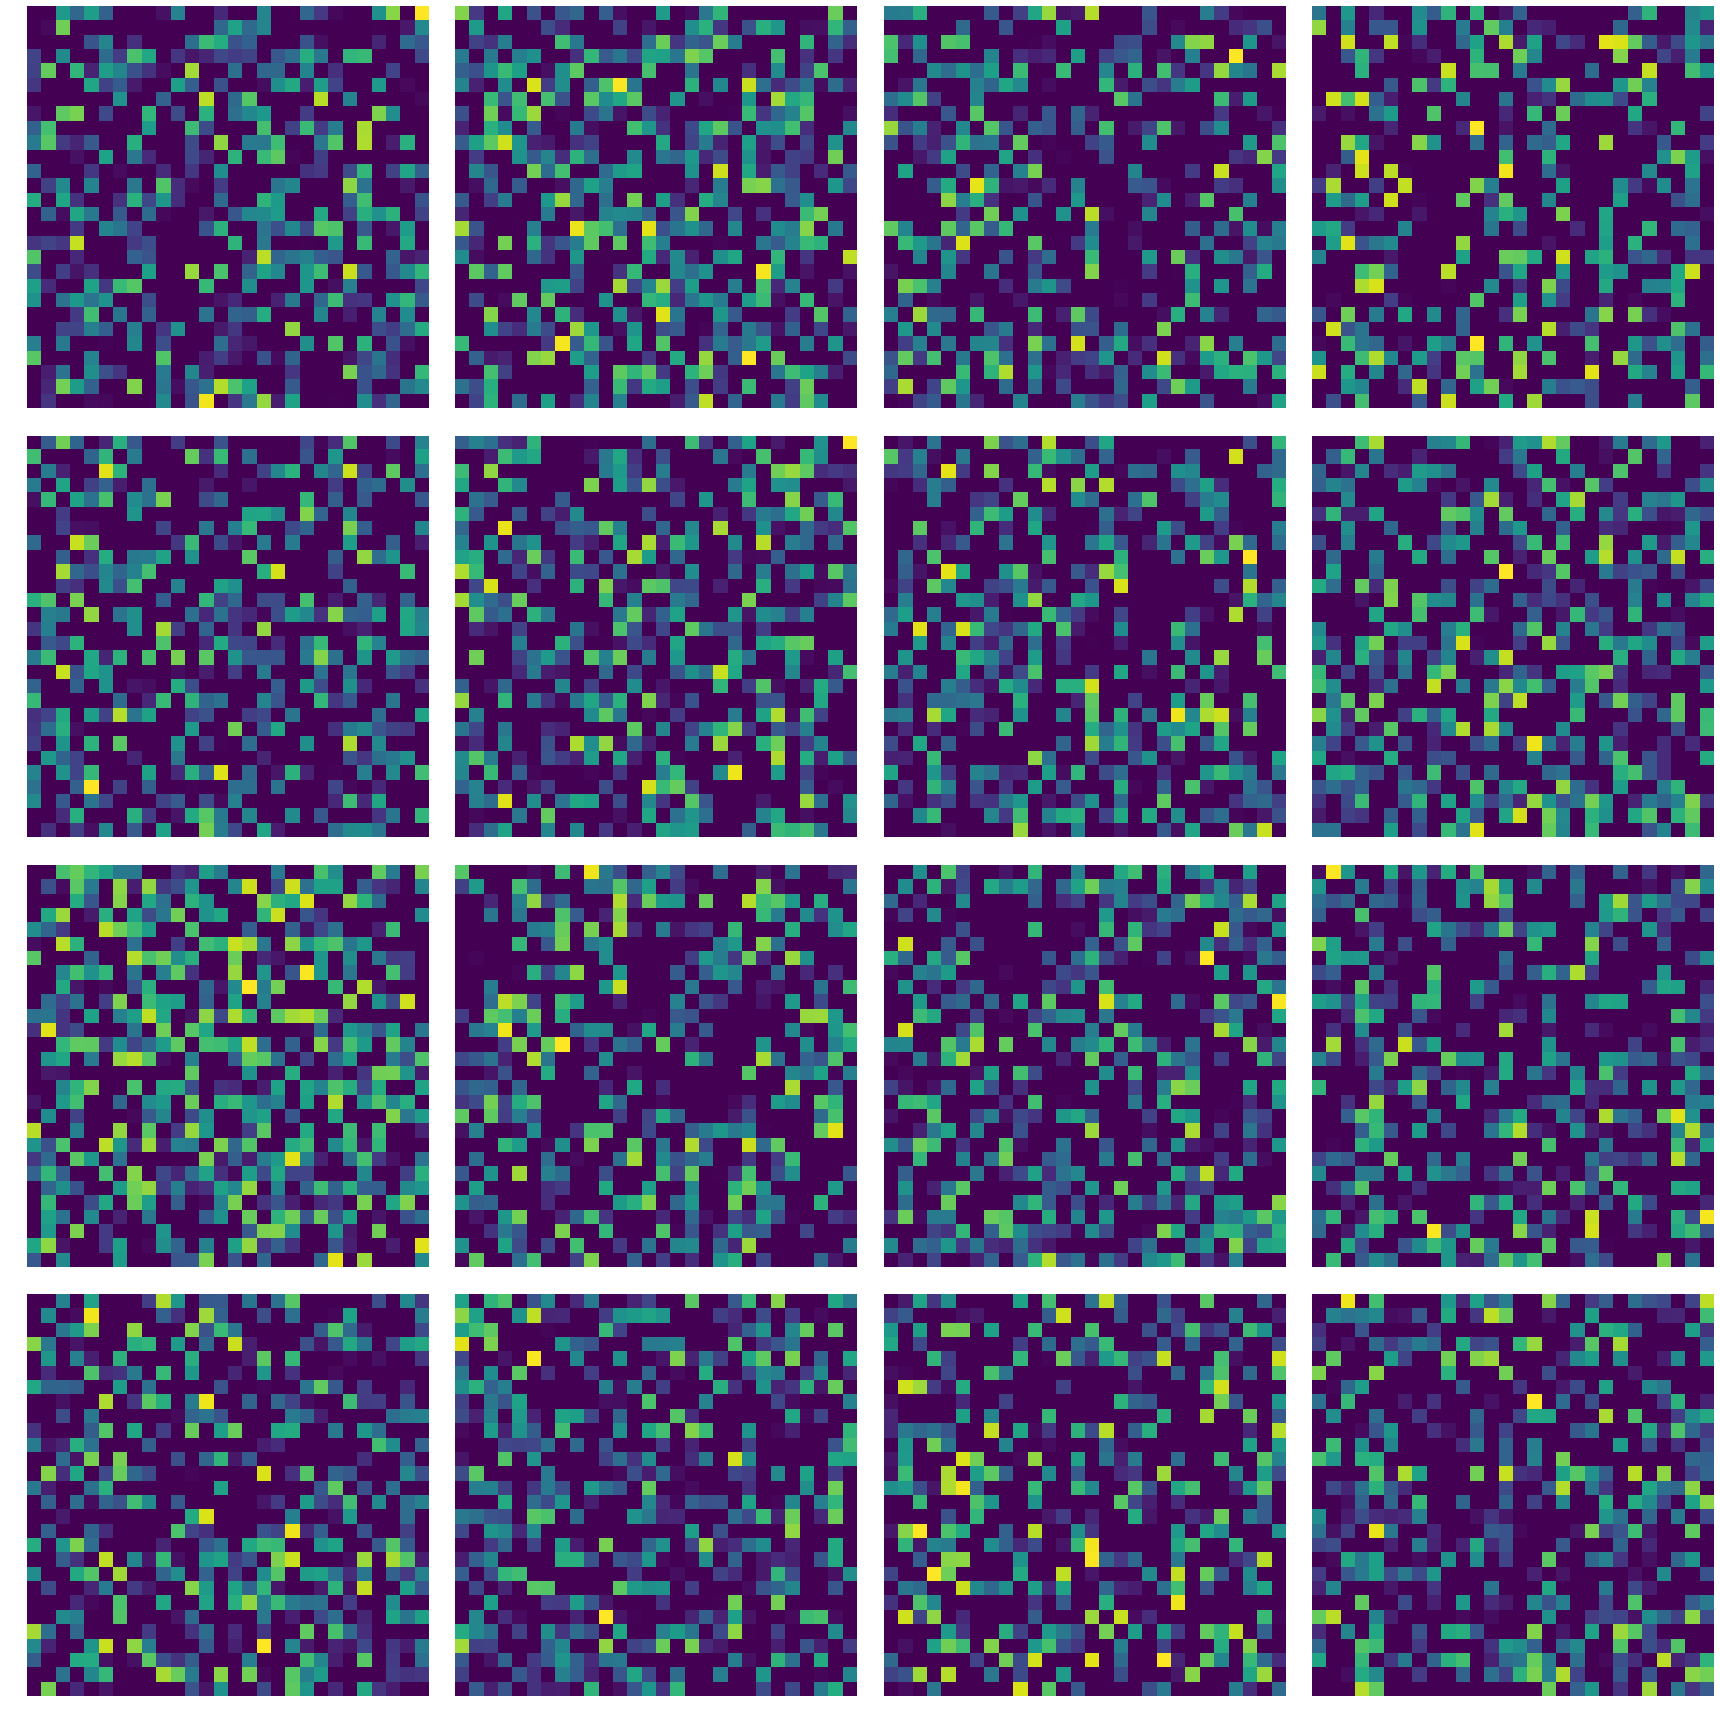

Epoch 4600, Generator loss 0.6399351358413696, discriminator loss 0.0024160637985914946


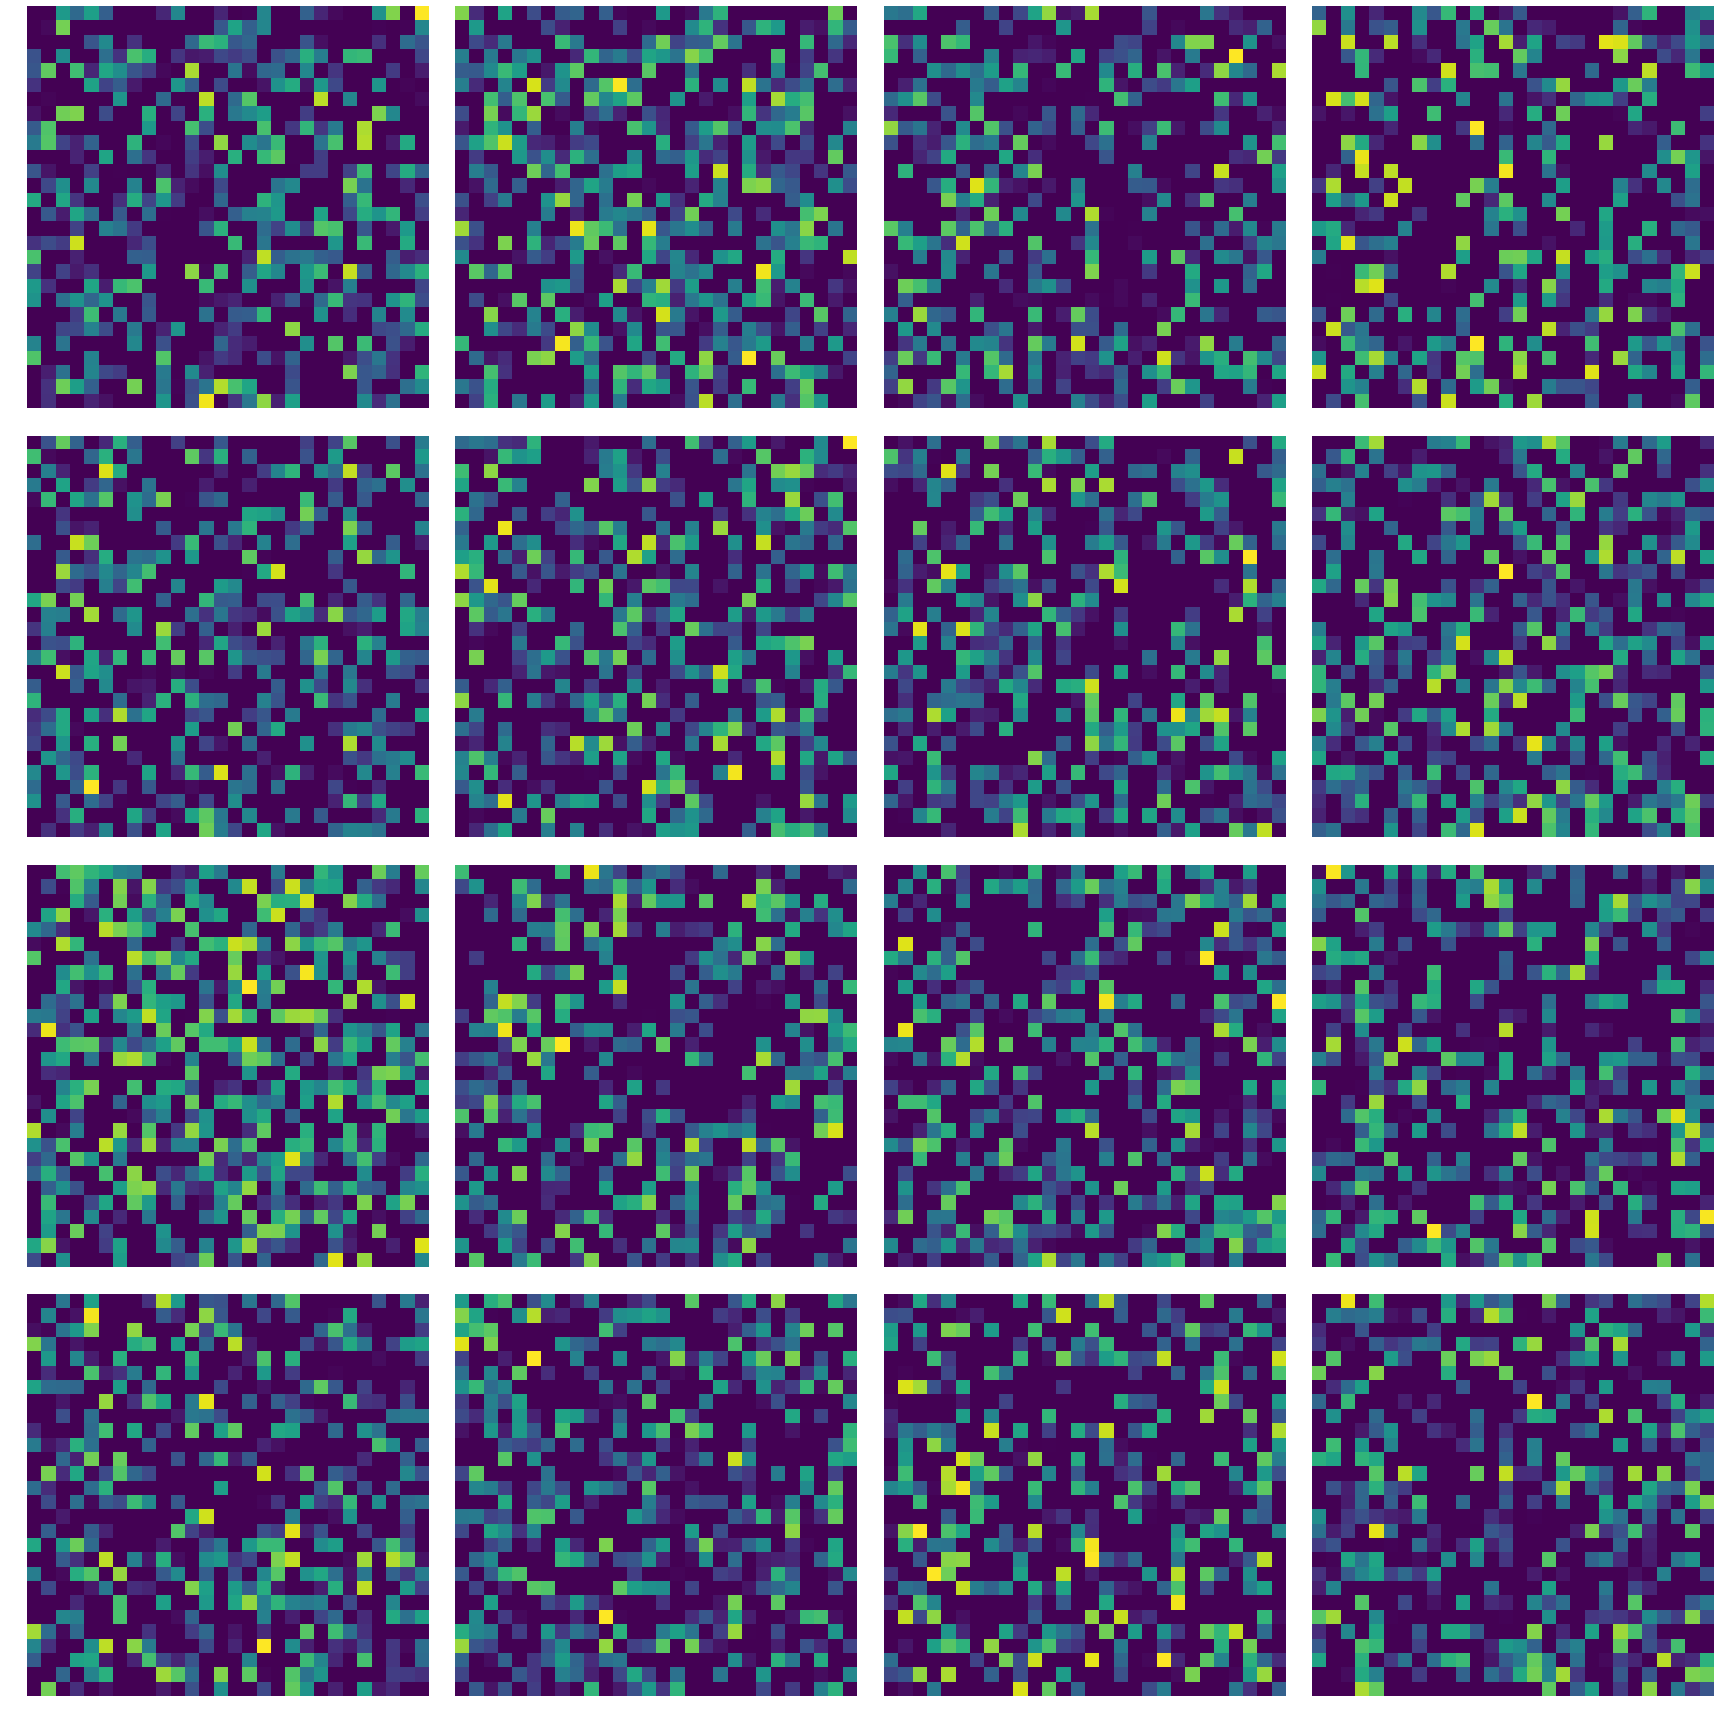

Epoch 4700, Generator loss 0.6349117159843445, discriminator loss 0.002349959686398506


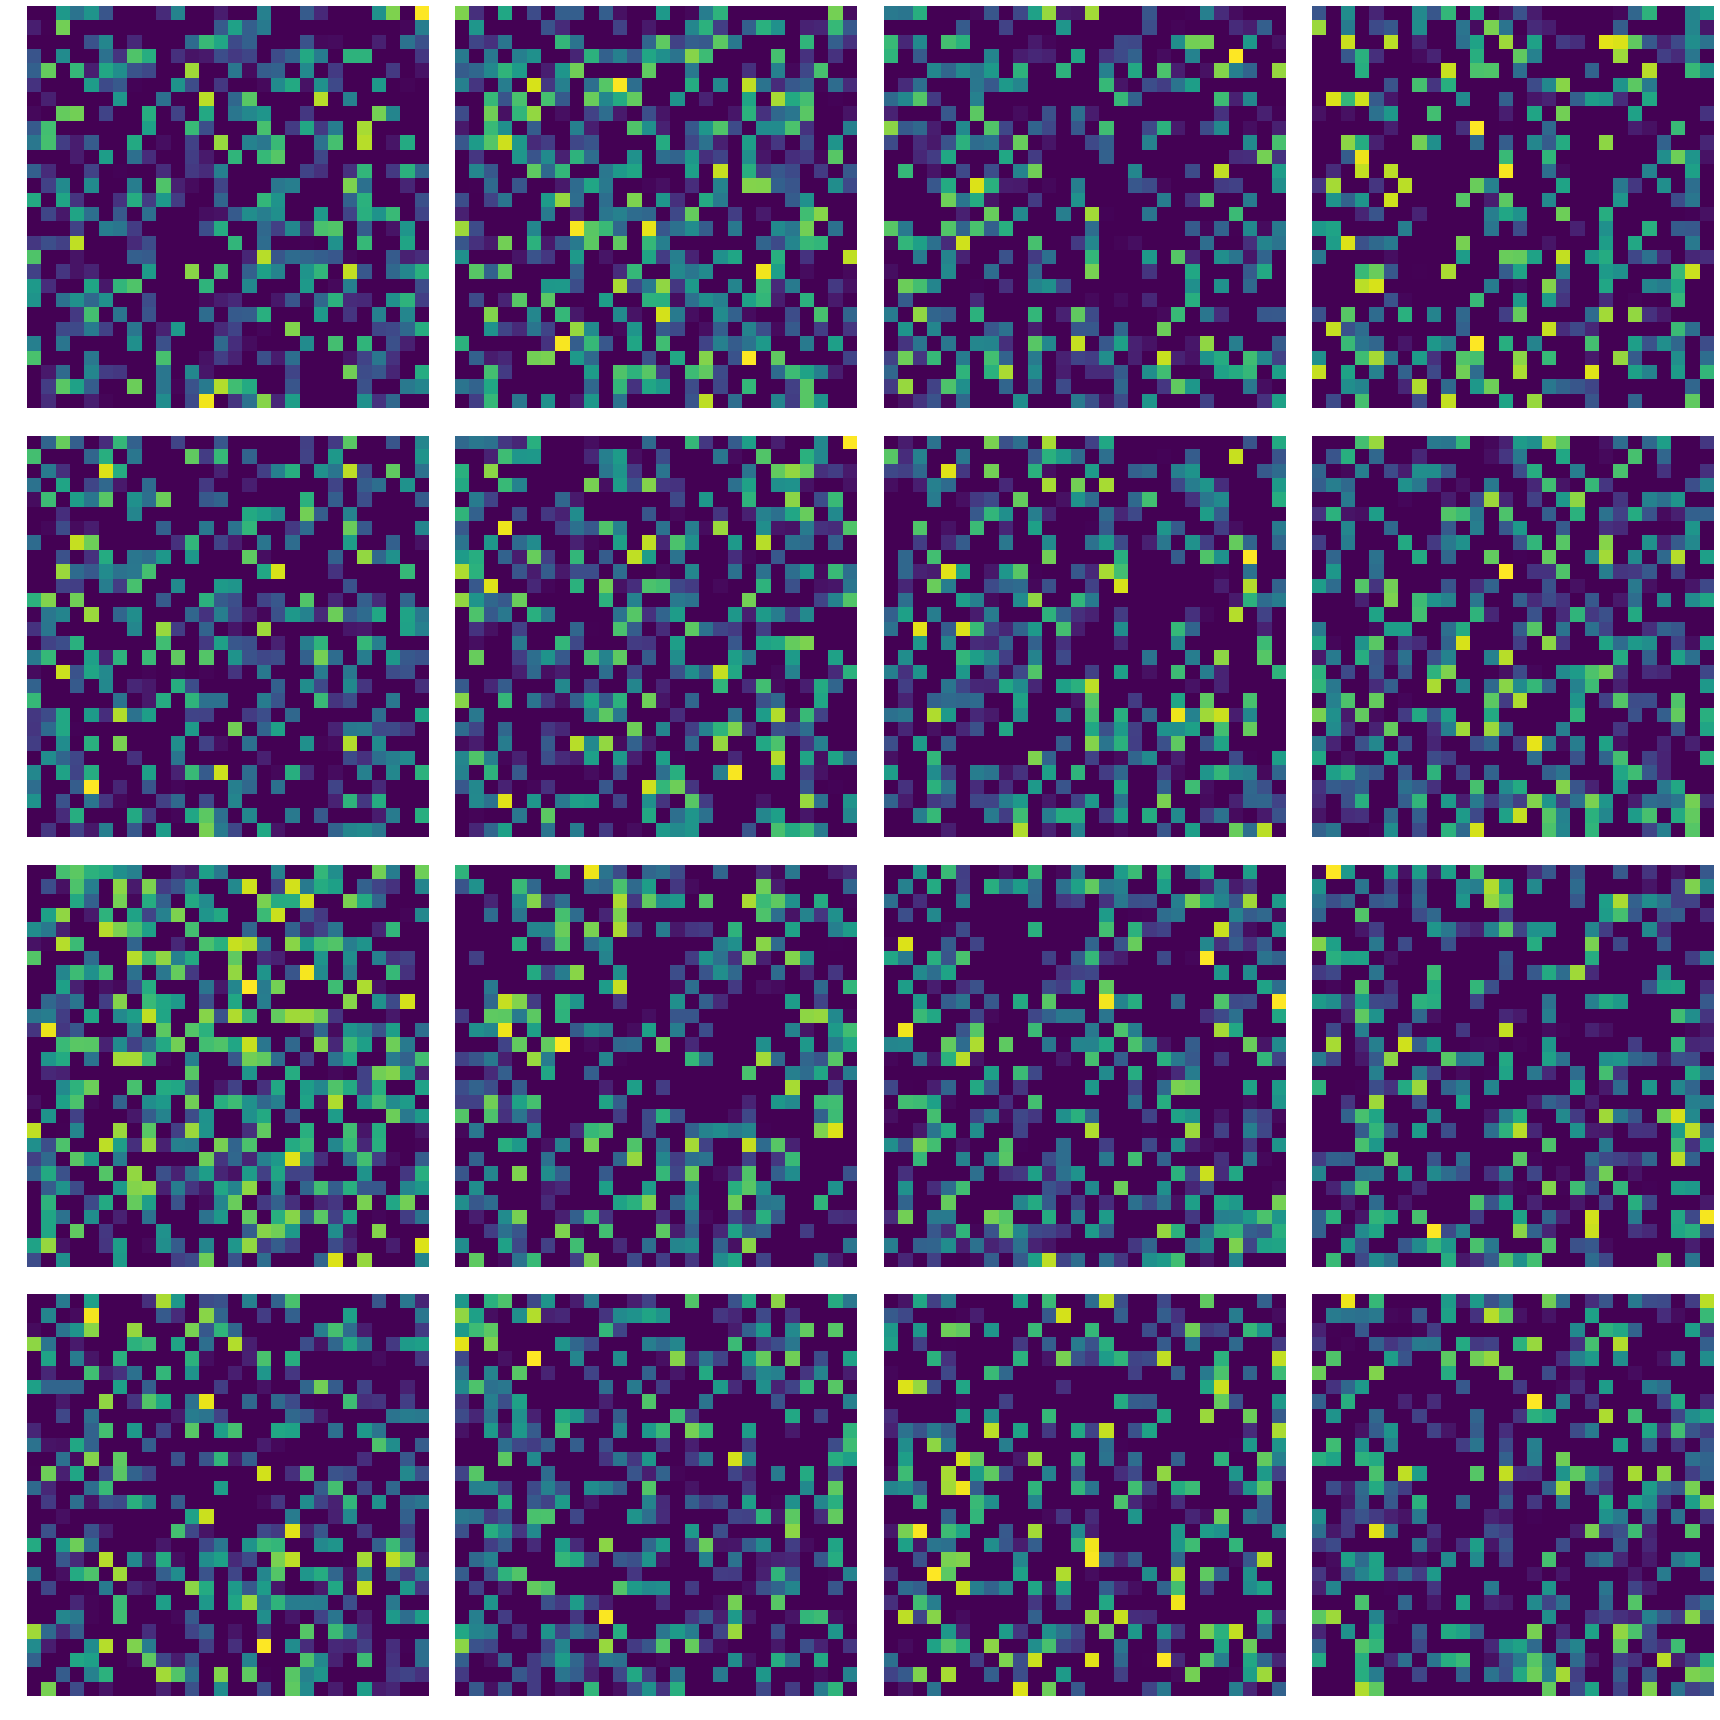

Epoch 4800, Generator loss 0.6208998560905457, discriminator loss 0.0022834897972643375


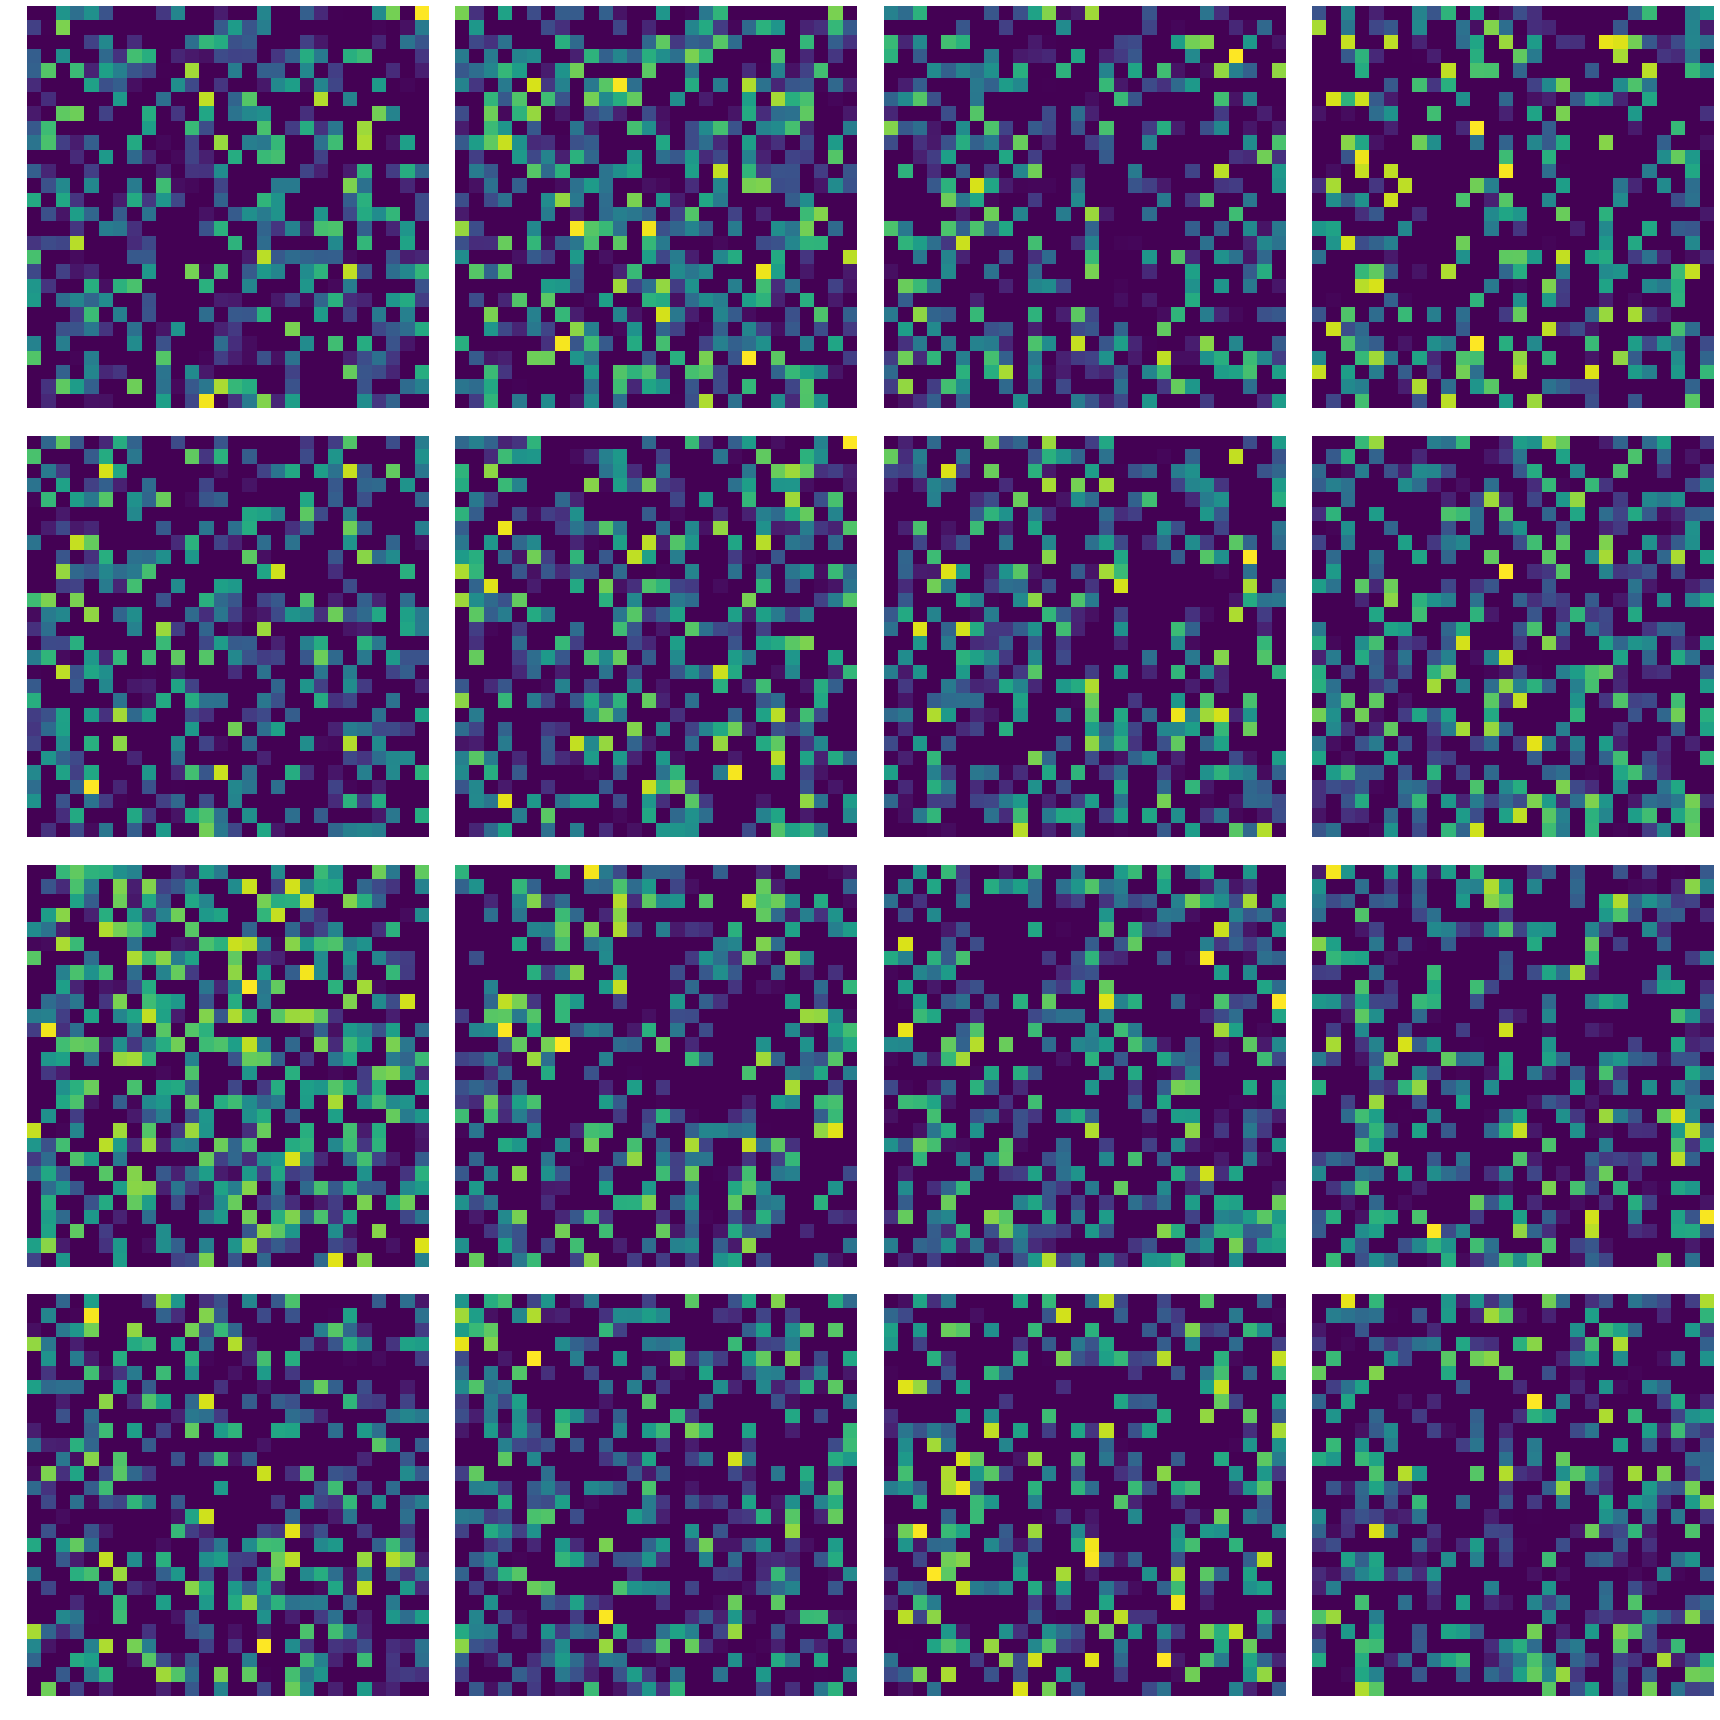

Epoch 4900, Generator loss 0.6262010335922241, discriminator loss 0.002217617817223072


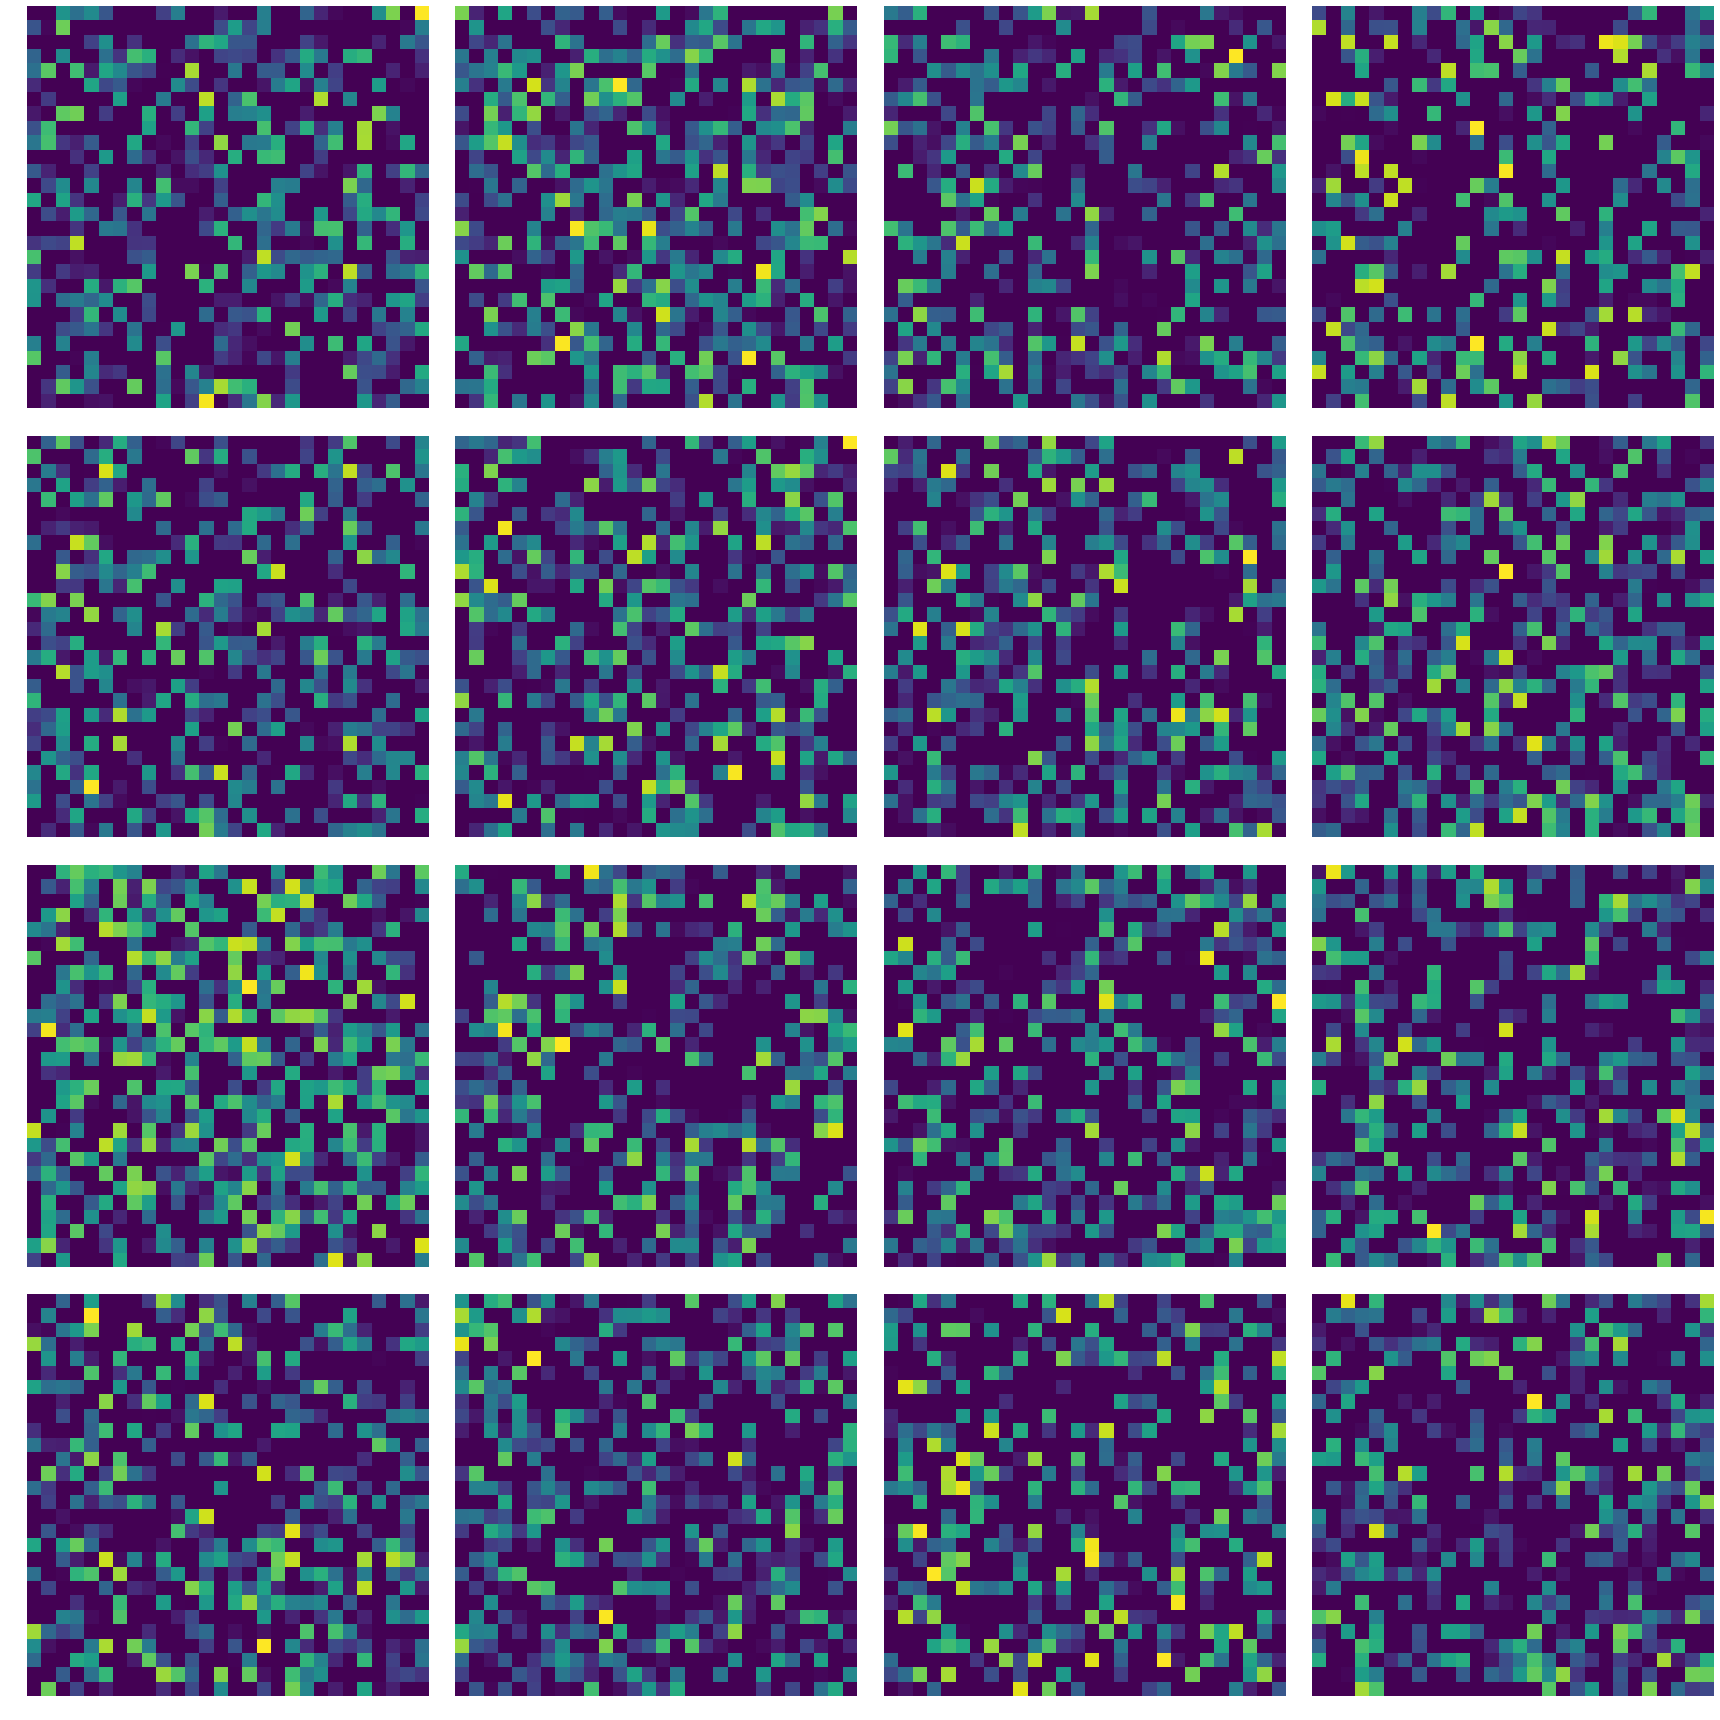

Epoch 5000, Generator loss 0.6405999064445496, discriminator loss 0.0021512839011847973


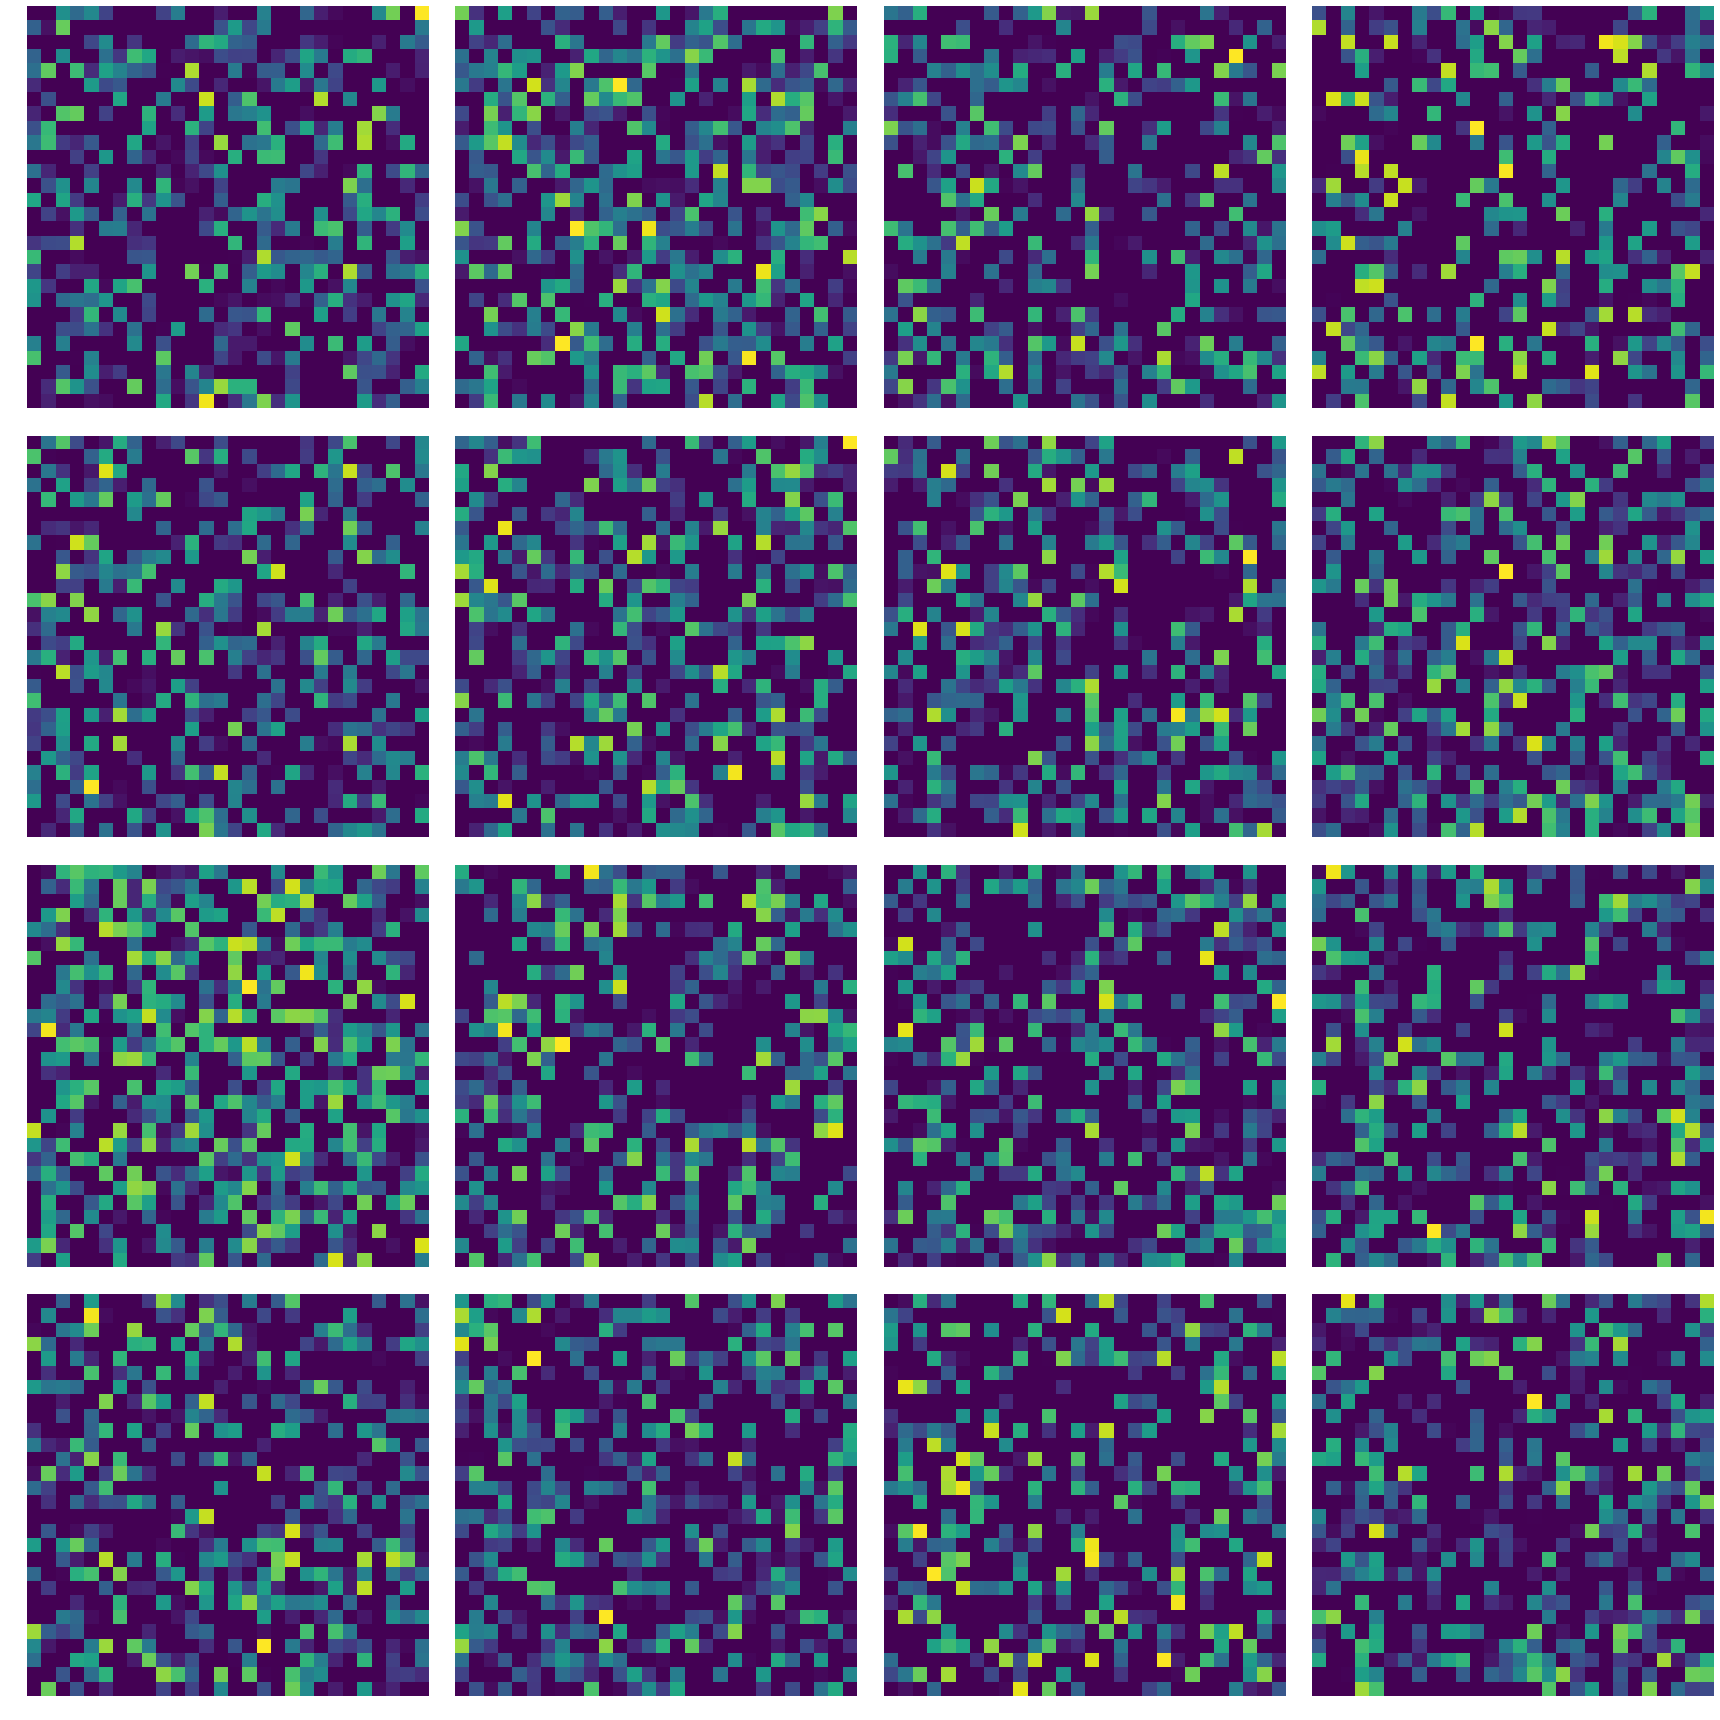

Epoch 5100, Generator loss 0.623095691204071, discriminator loss 0.002091837814077735


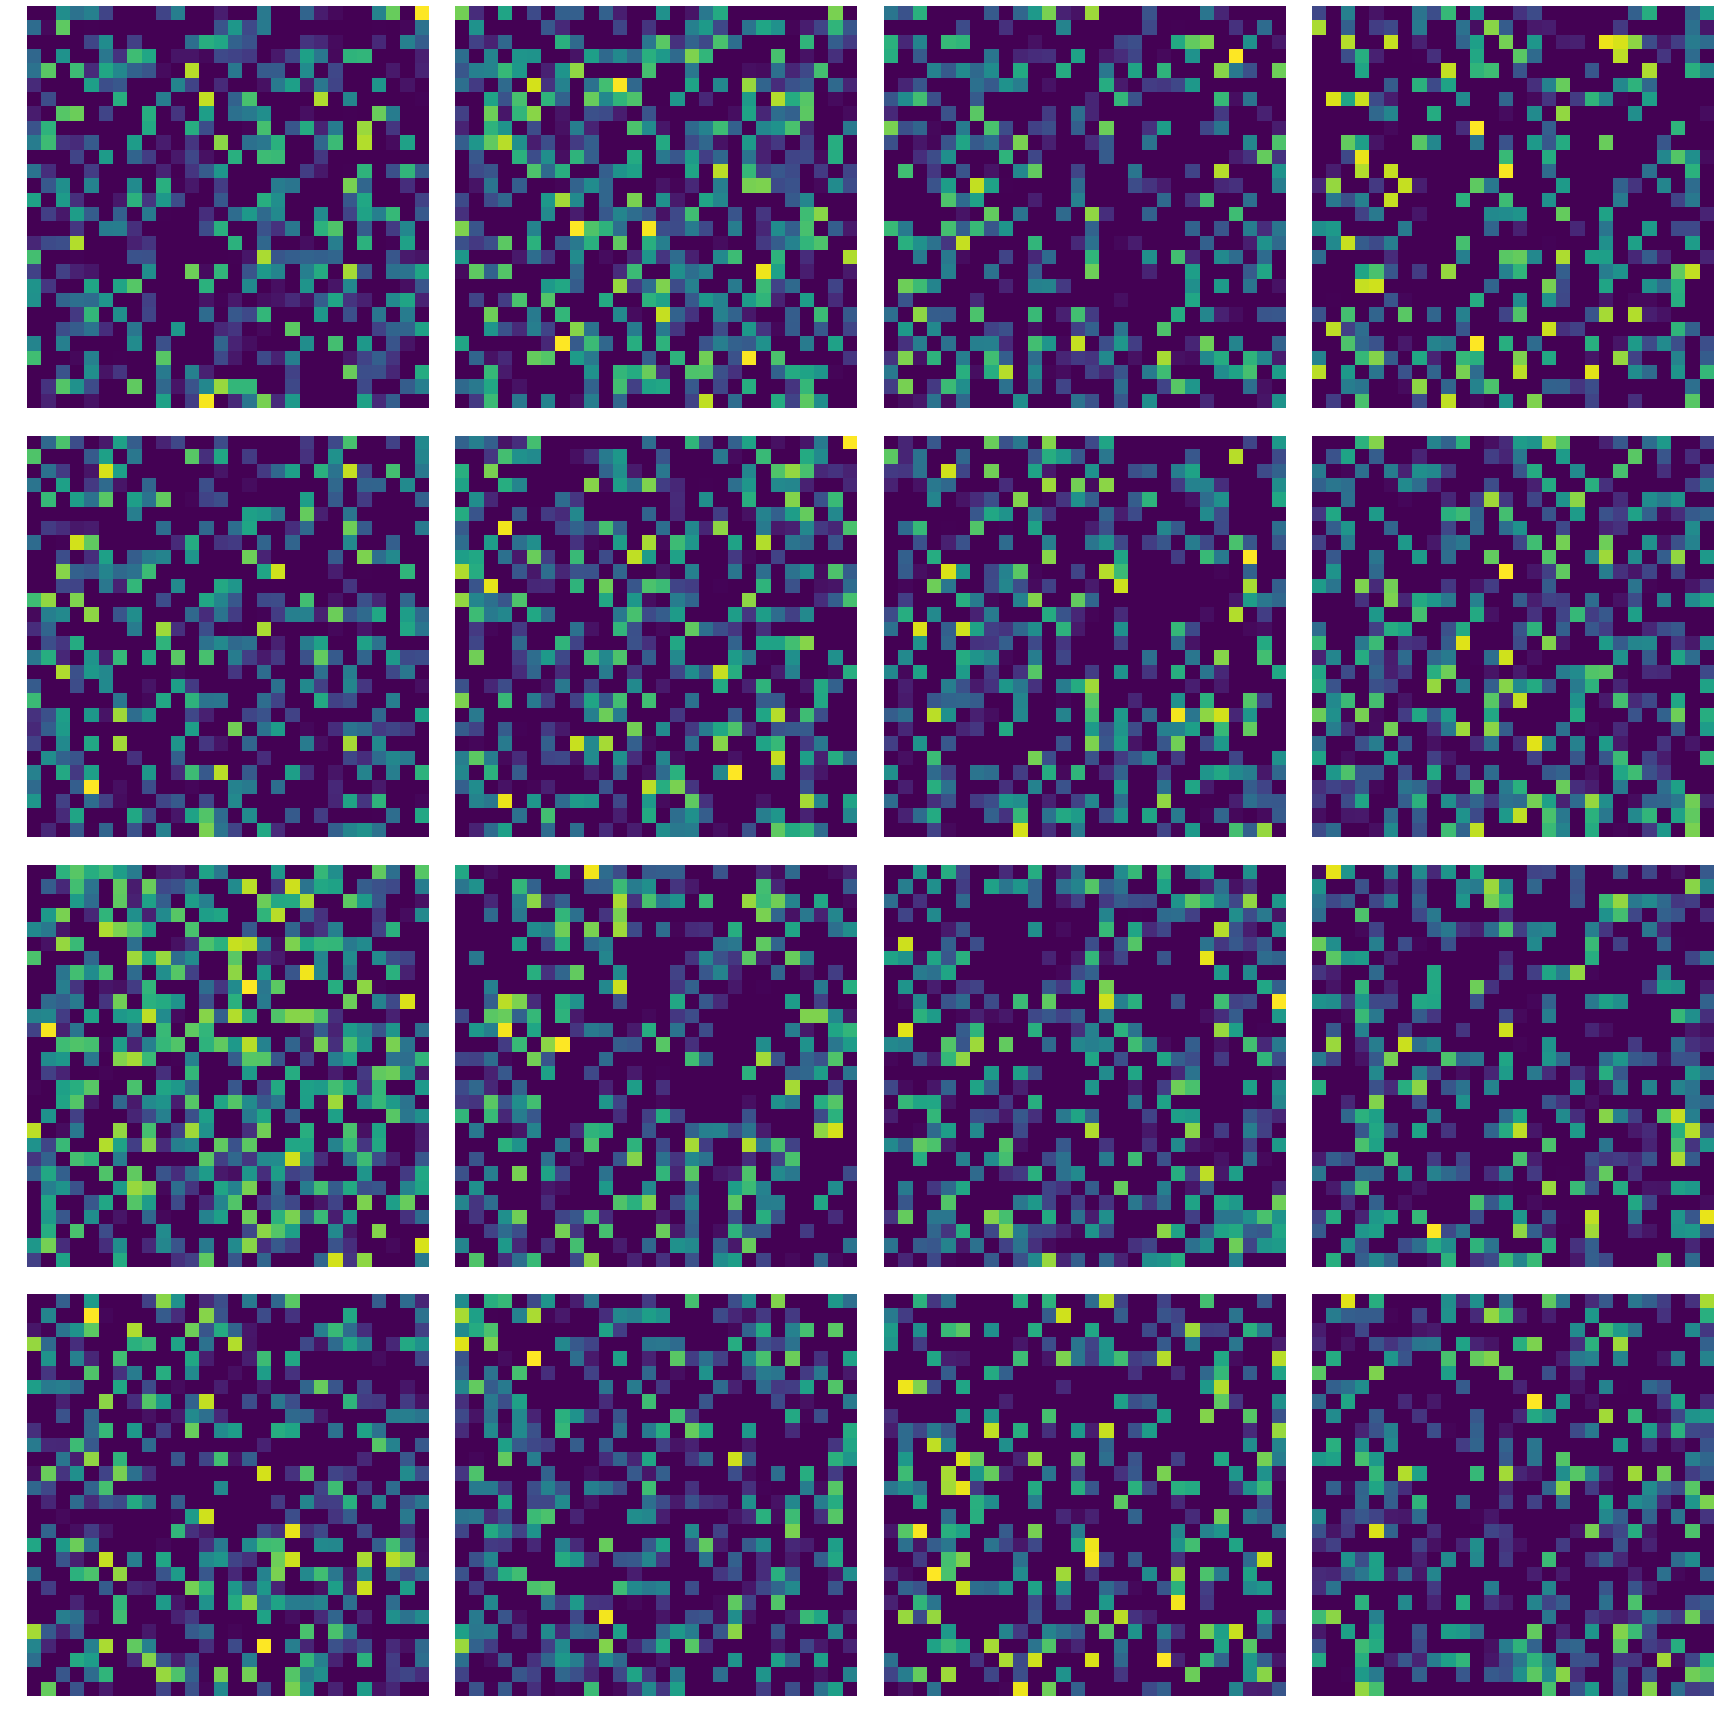

Epoch 5200, Generator loss 0.6067339777946472, discriminator loss 0.0020315488800406456


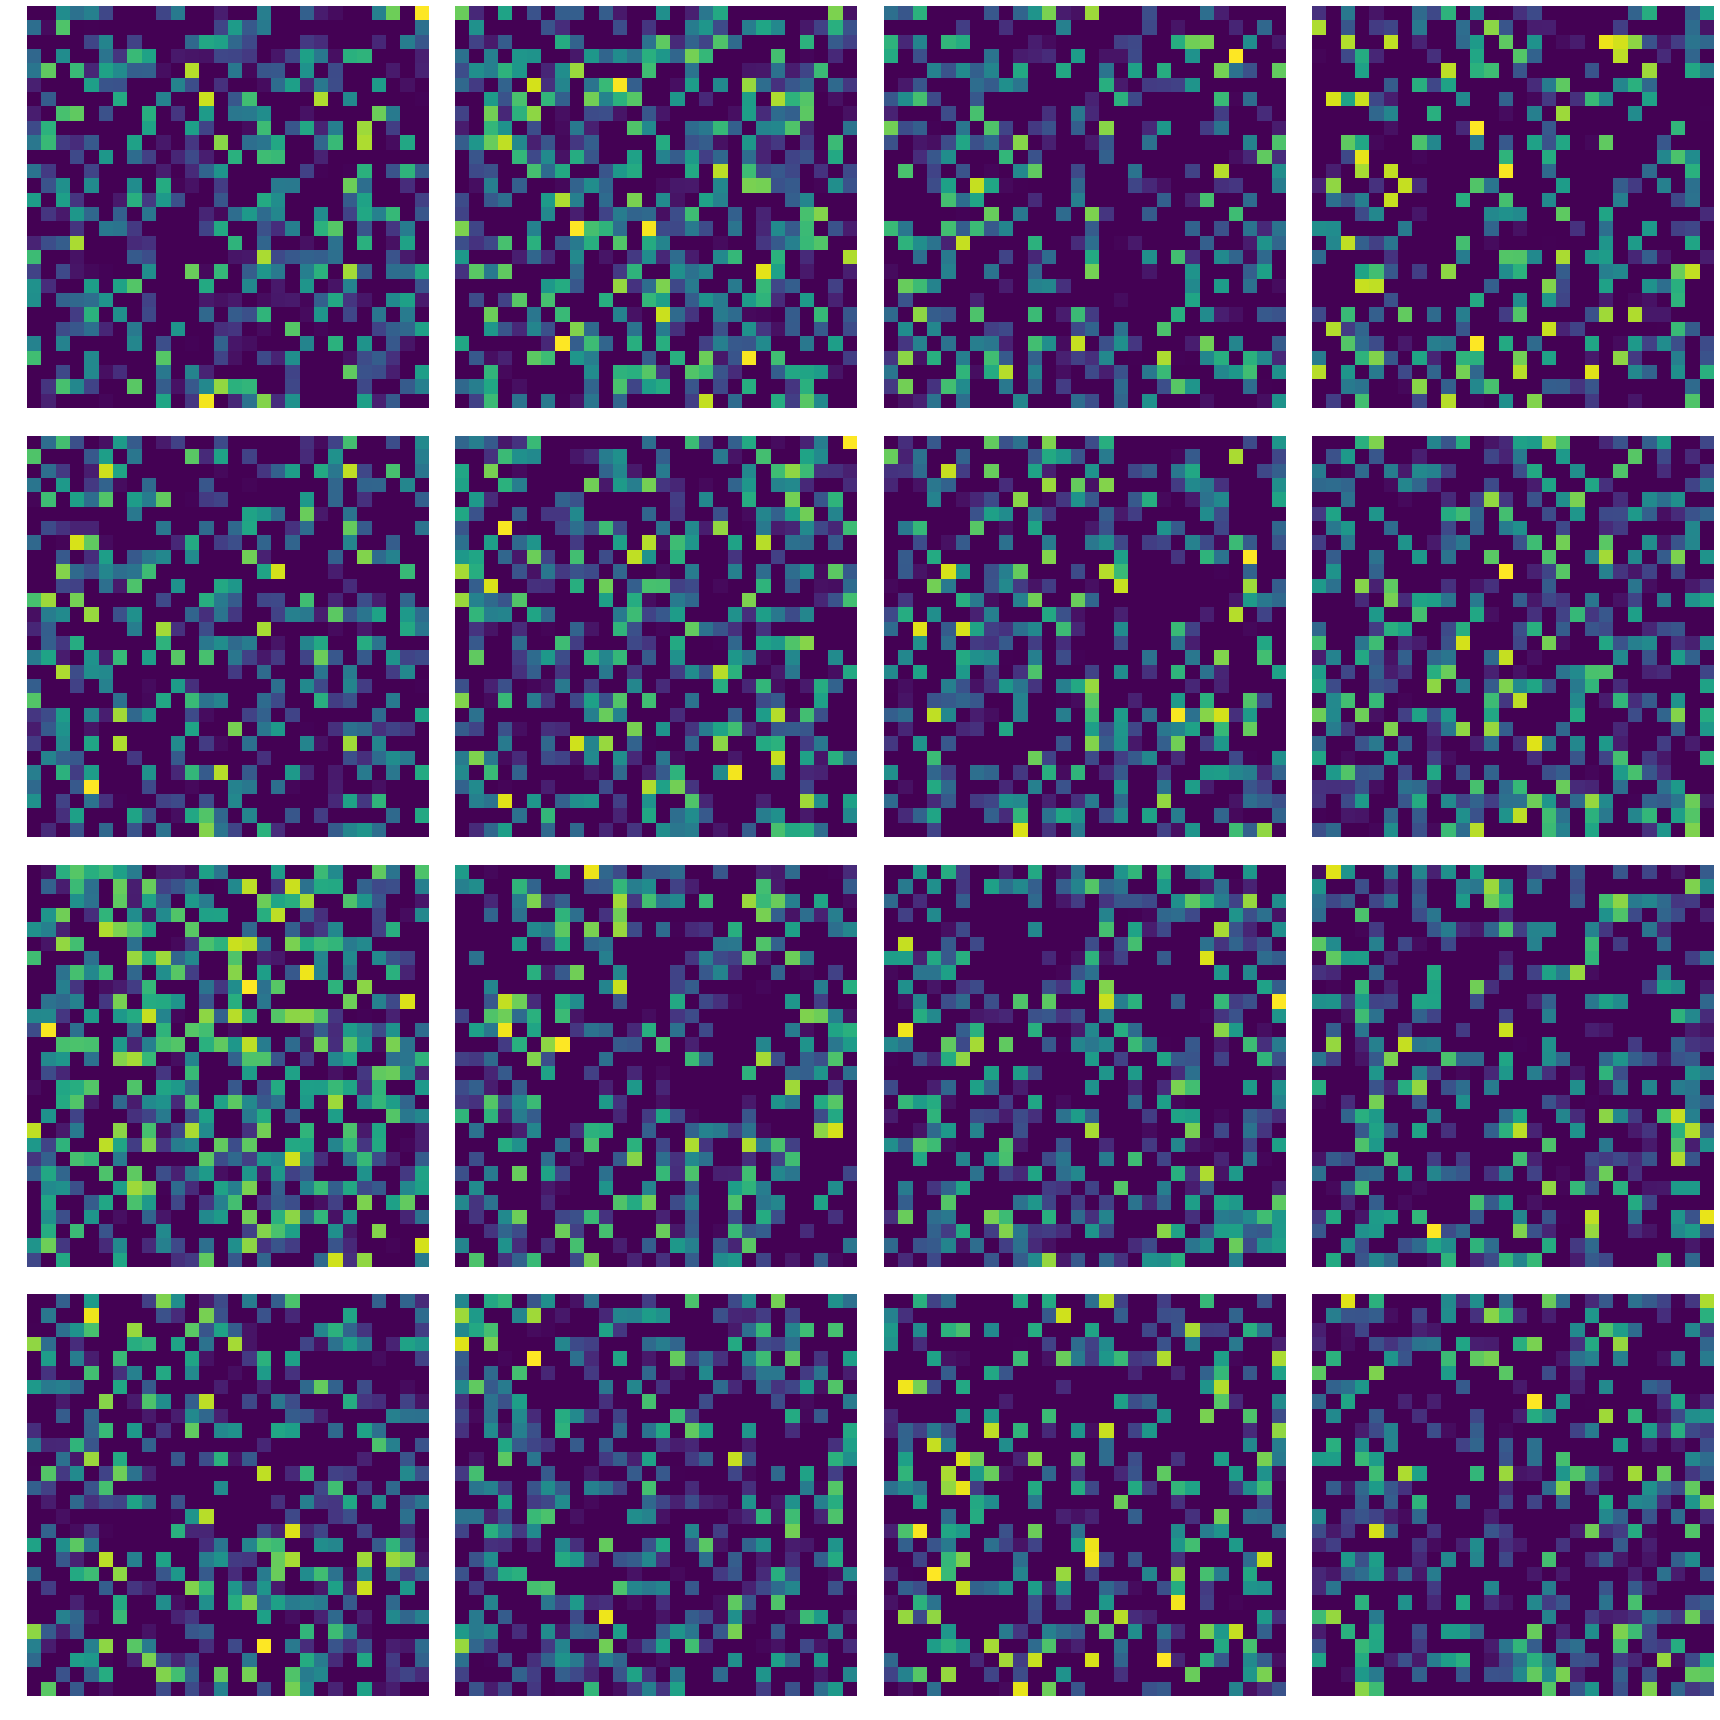

Epoch 5300, Generator loss 0.6186777353286743, discriminator loss 0.0019739835988730192


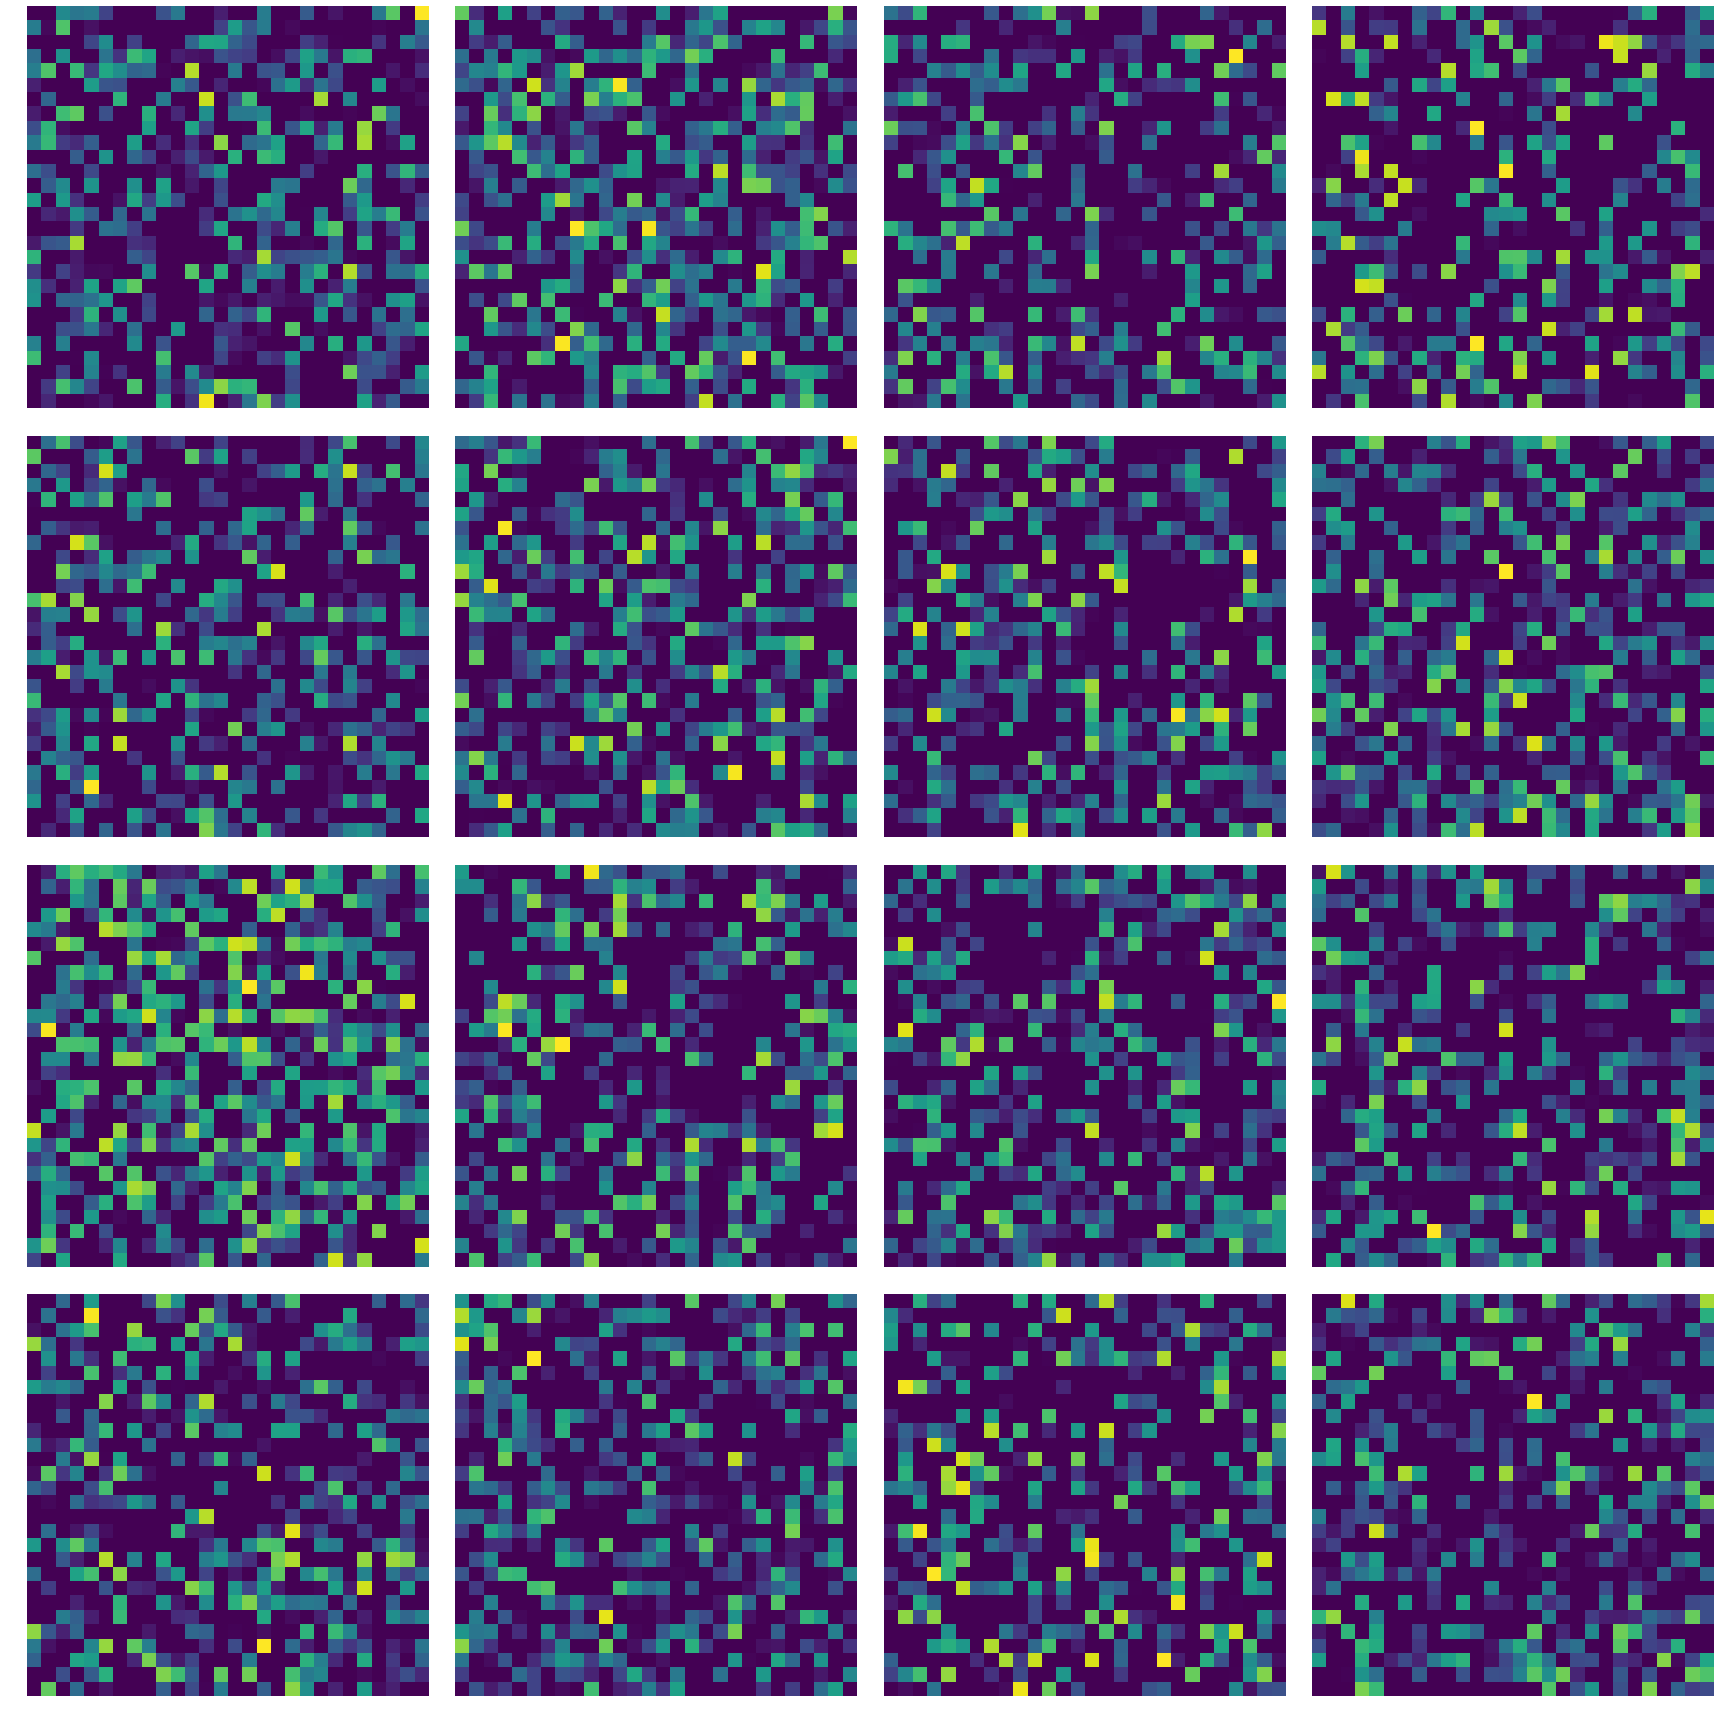

Epoch 5400, Generator loss 0.605778694152832, discriminator loss 0.001916336128488183


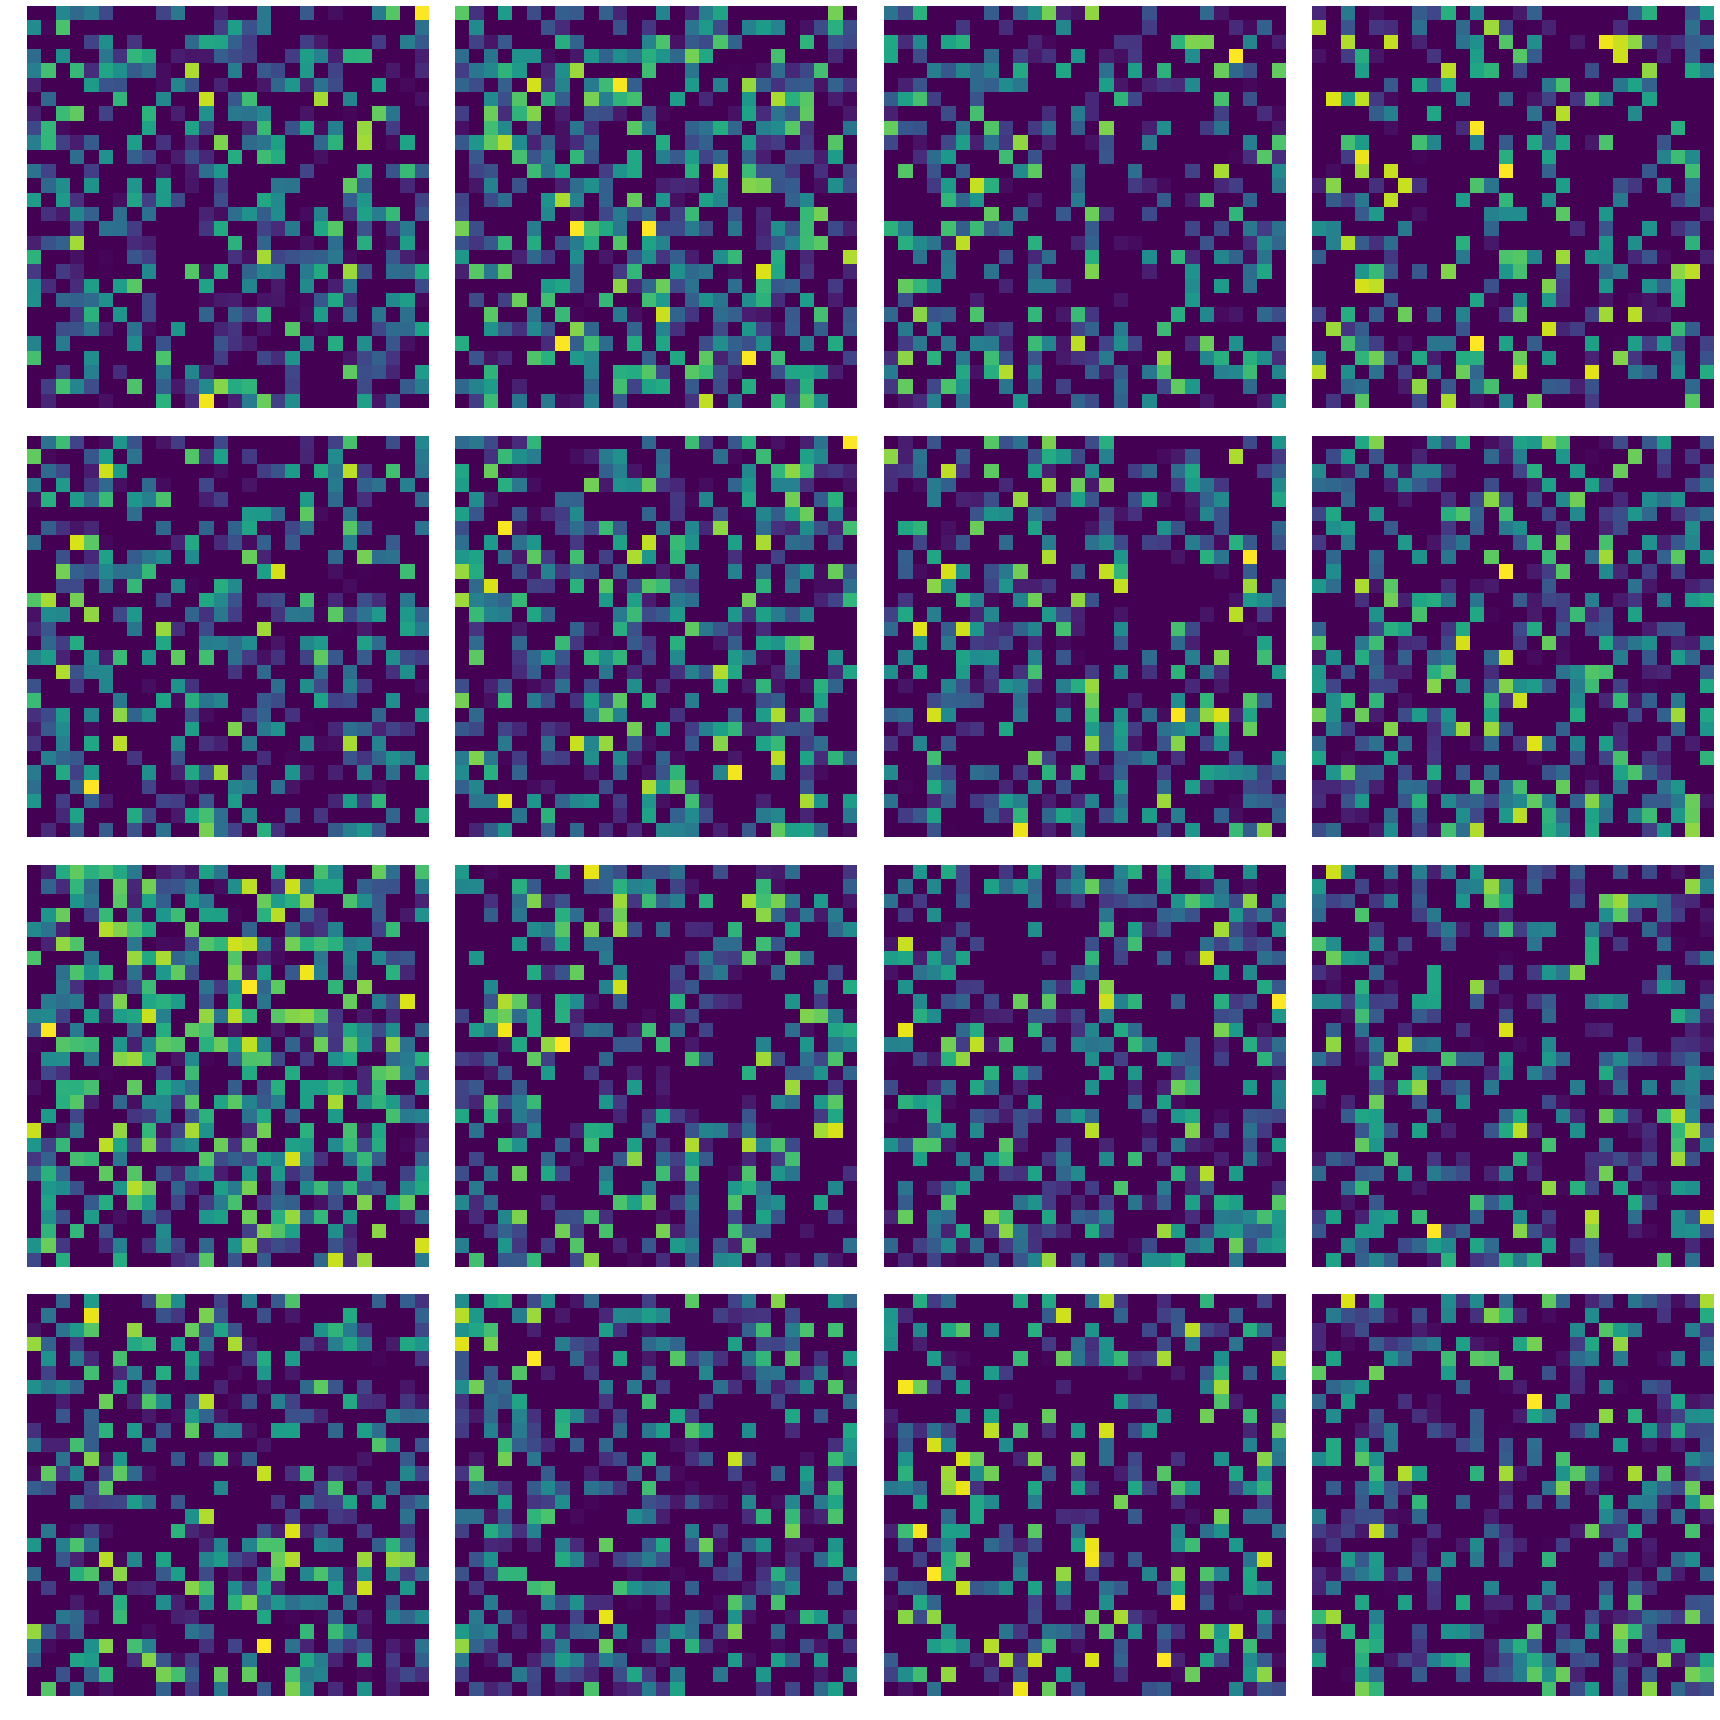

Epoch 5500, Generator loss 0.5987079739570618, discriminator loss 0.001863800105638802


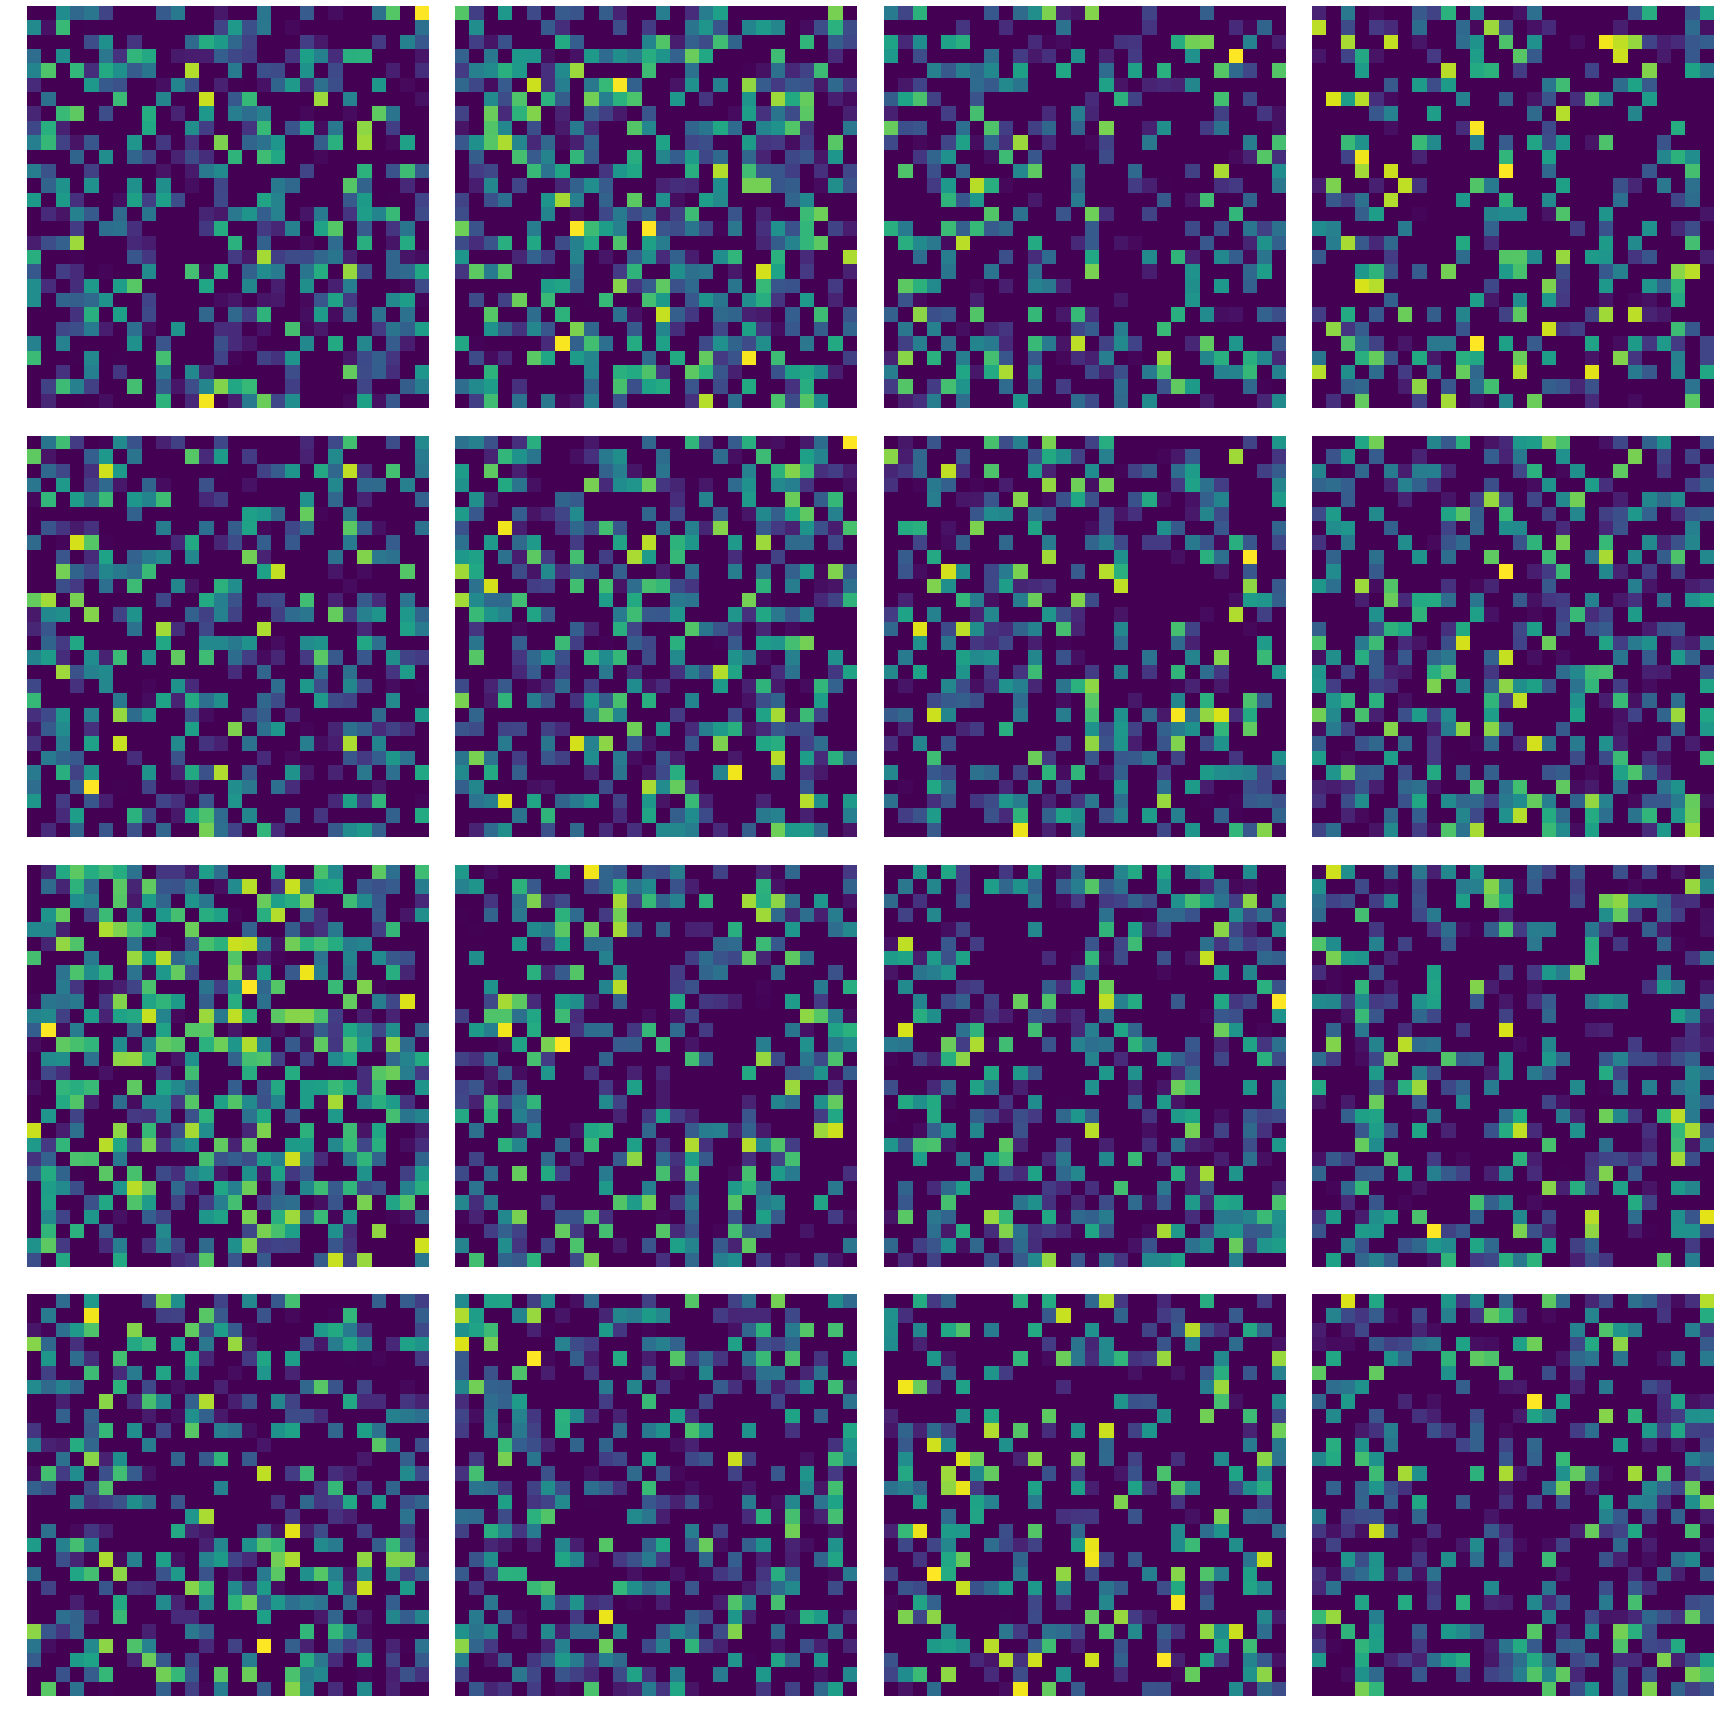

Epoch 5600, Generator loss 0.6011285185813904, discriminator loss 0.0018114907434210181


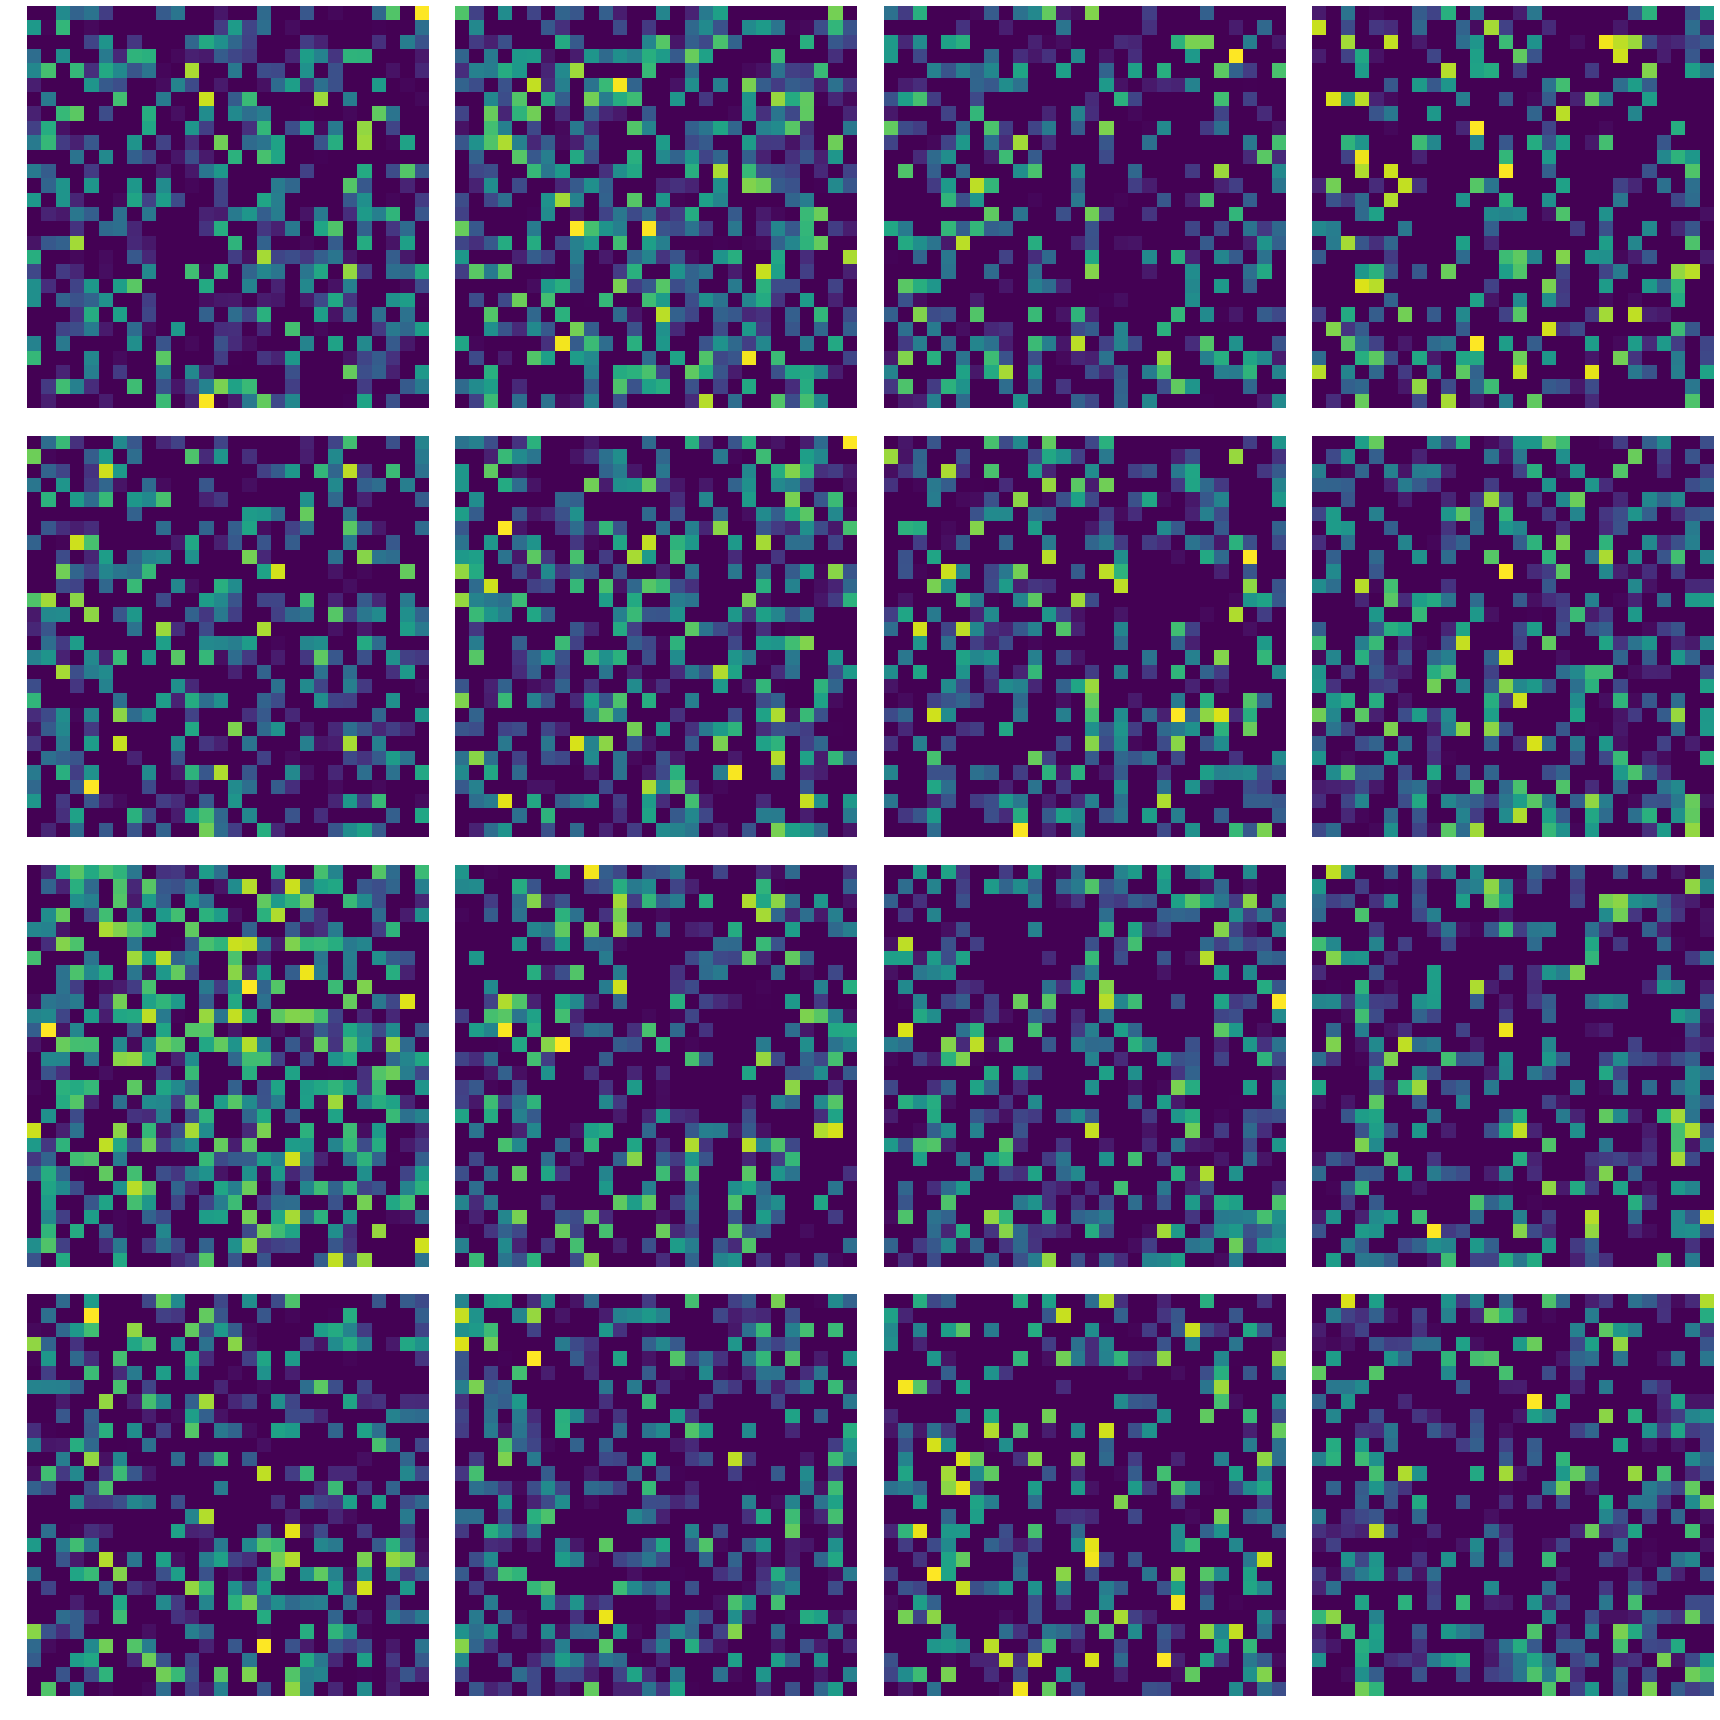

Epoch 5700, Generator loss 0.5954393744468689, discriminator loss 0.0017609067726880312


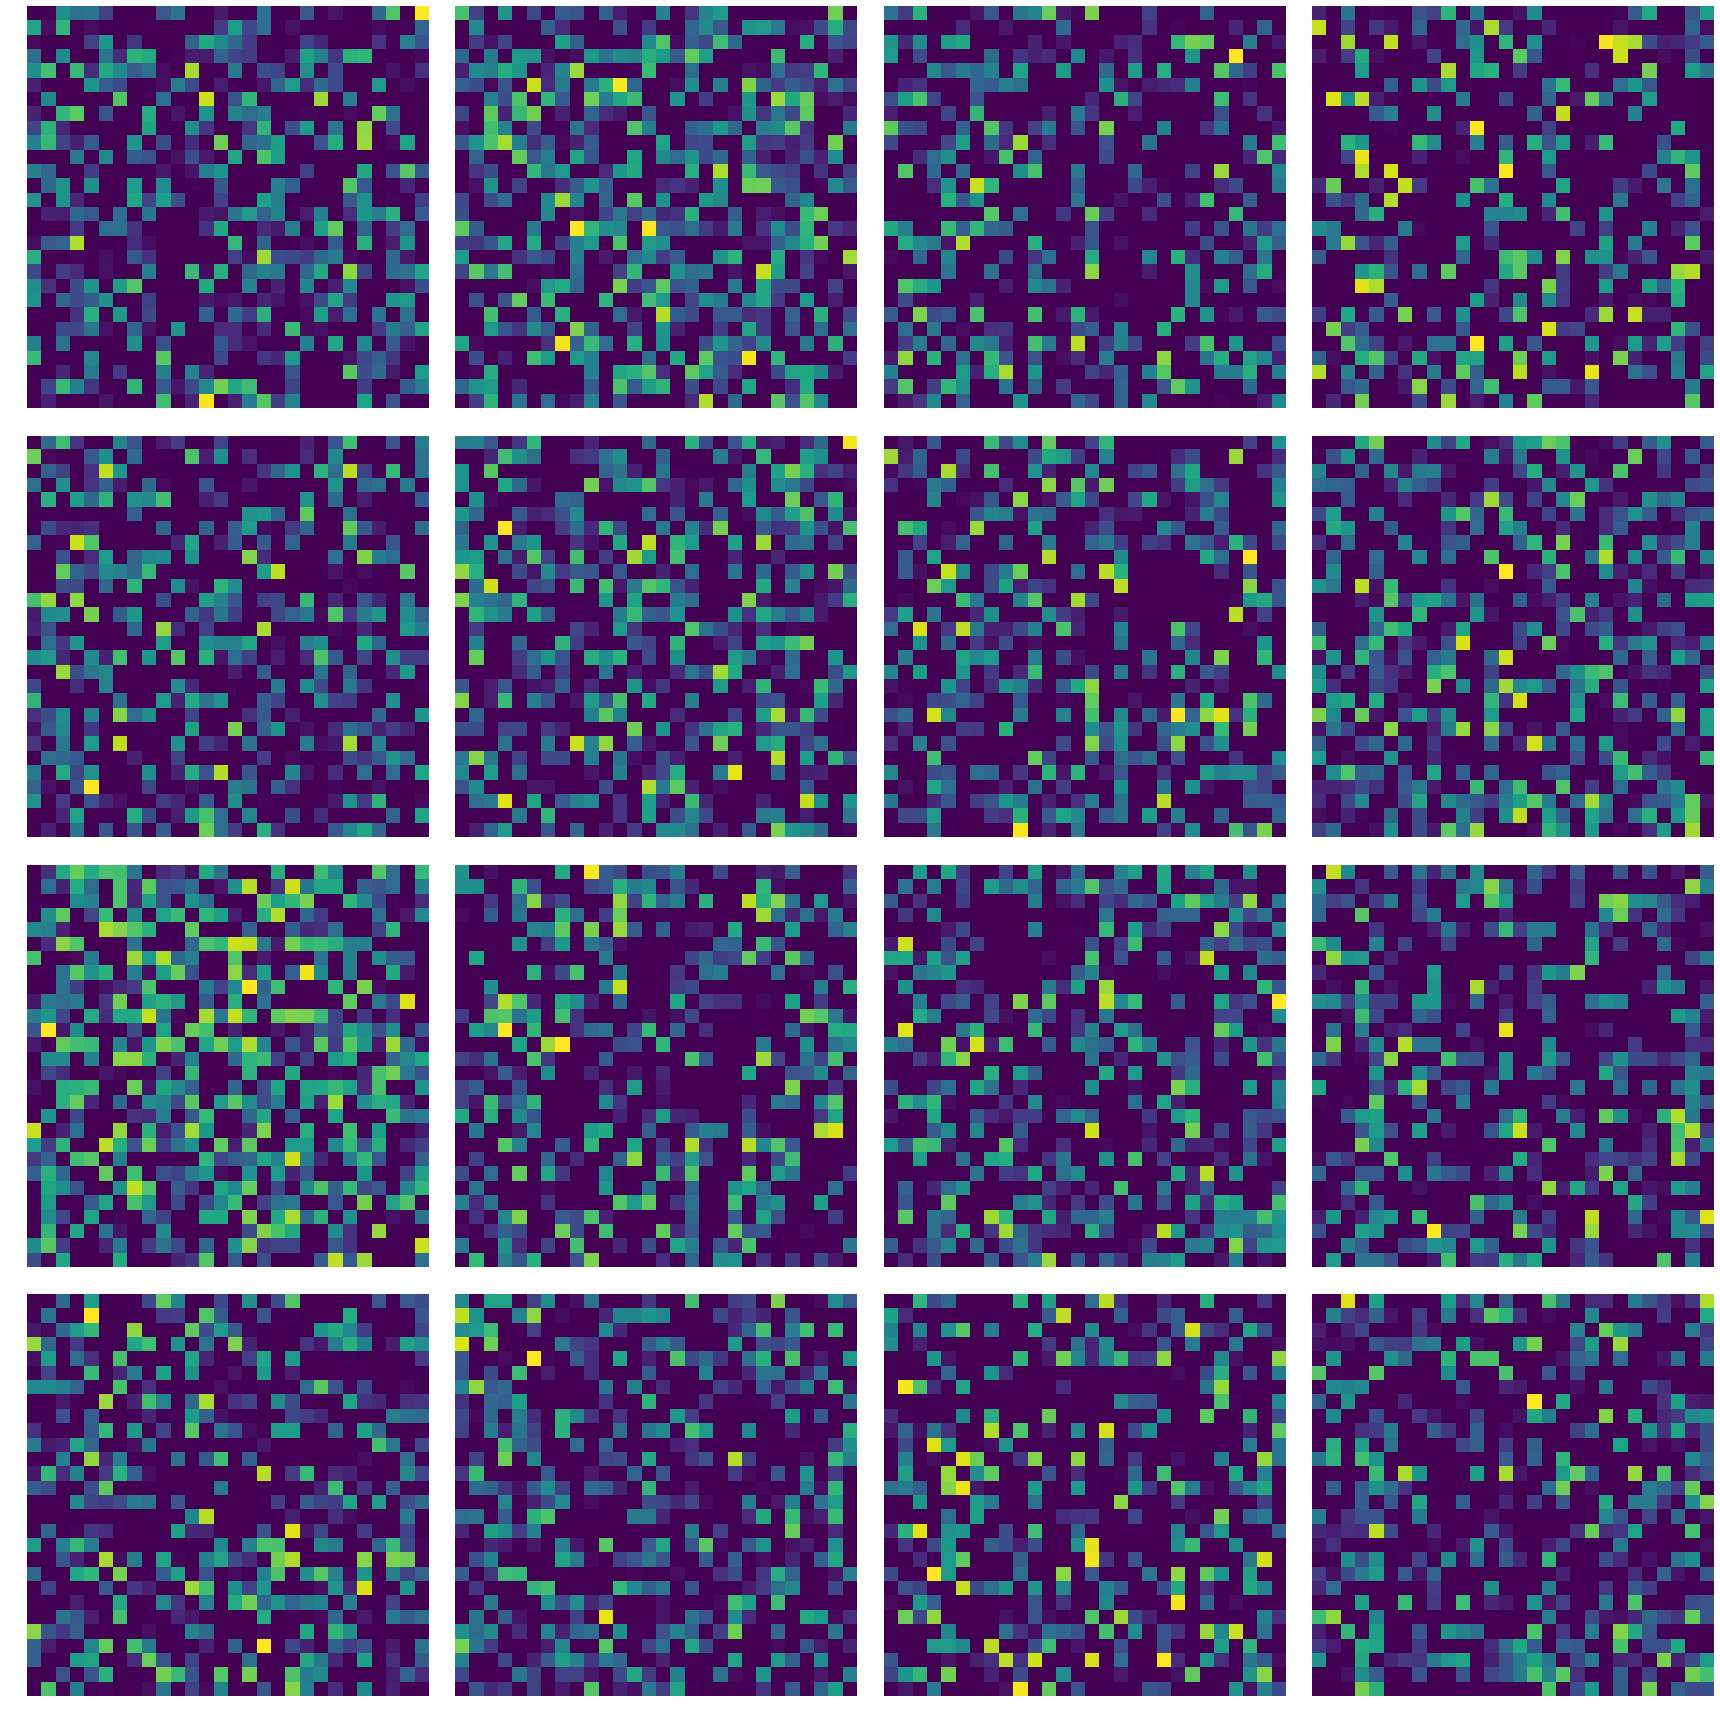

Epoch 5800, Generator loss 0.6115769147872925, discriminator loss 0.0017114540096372366


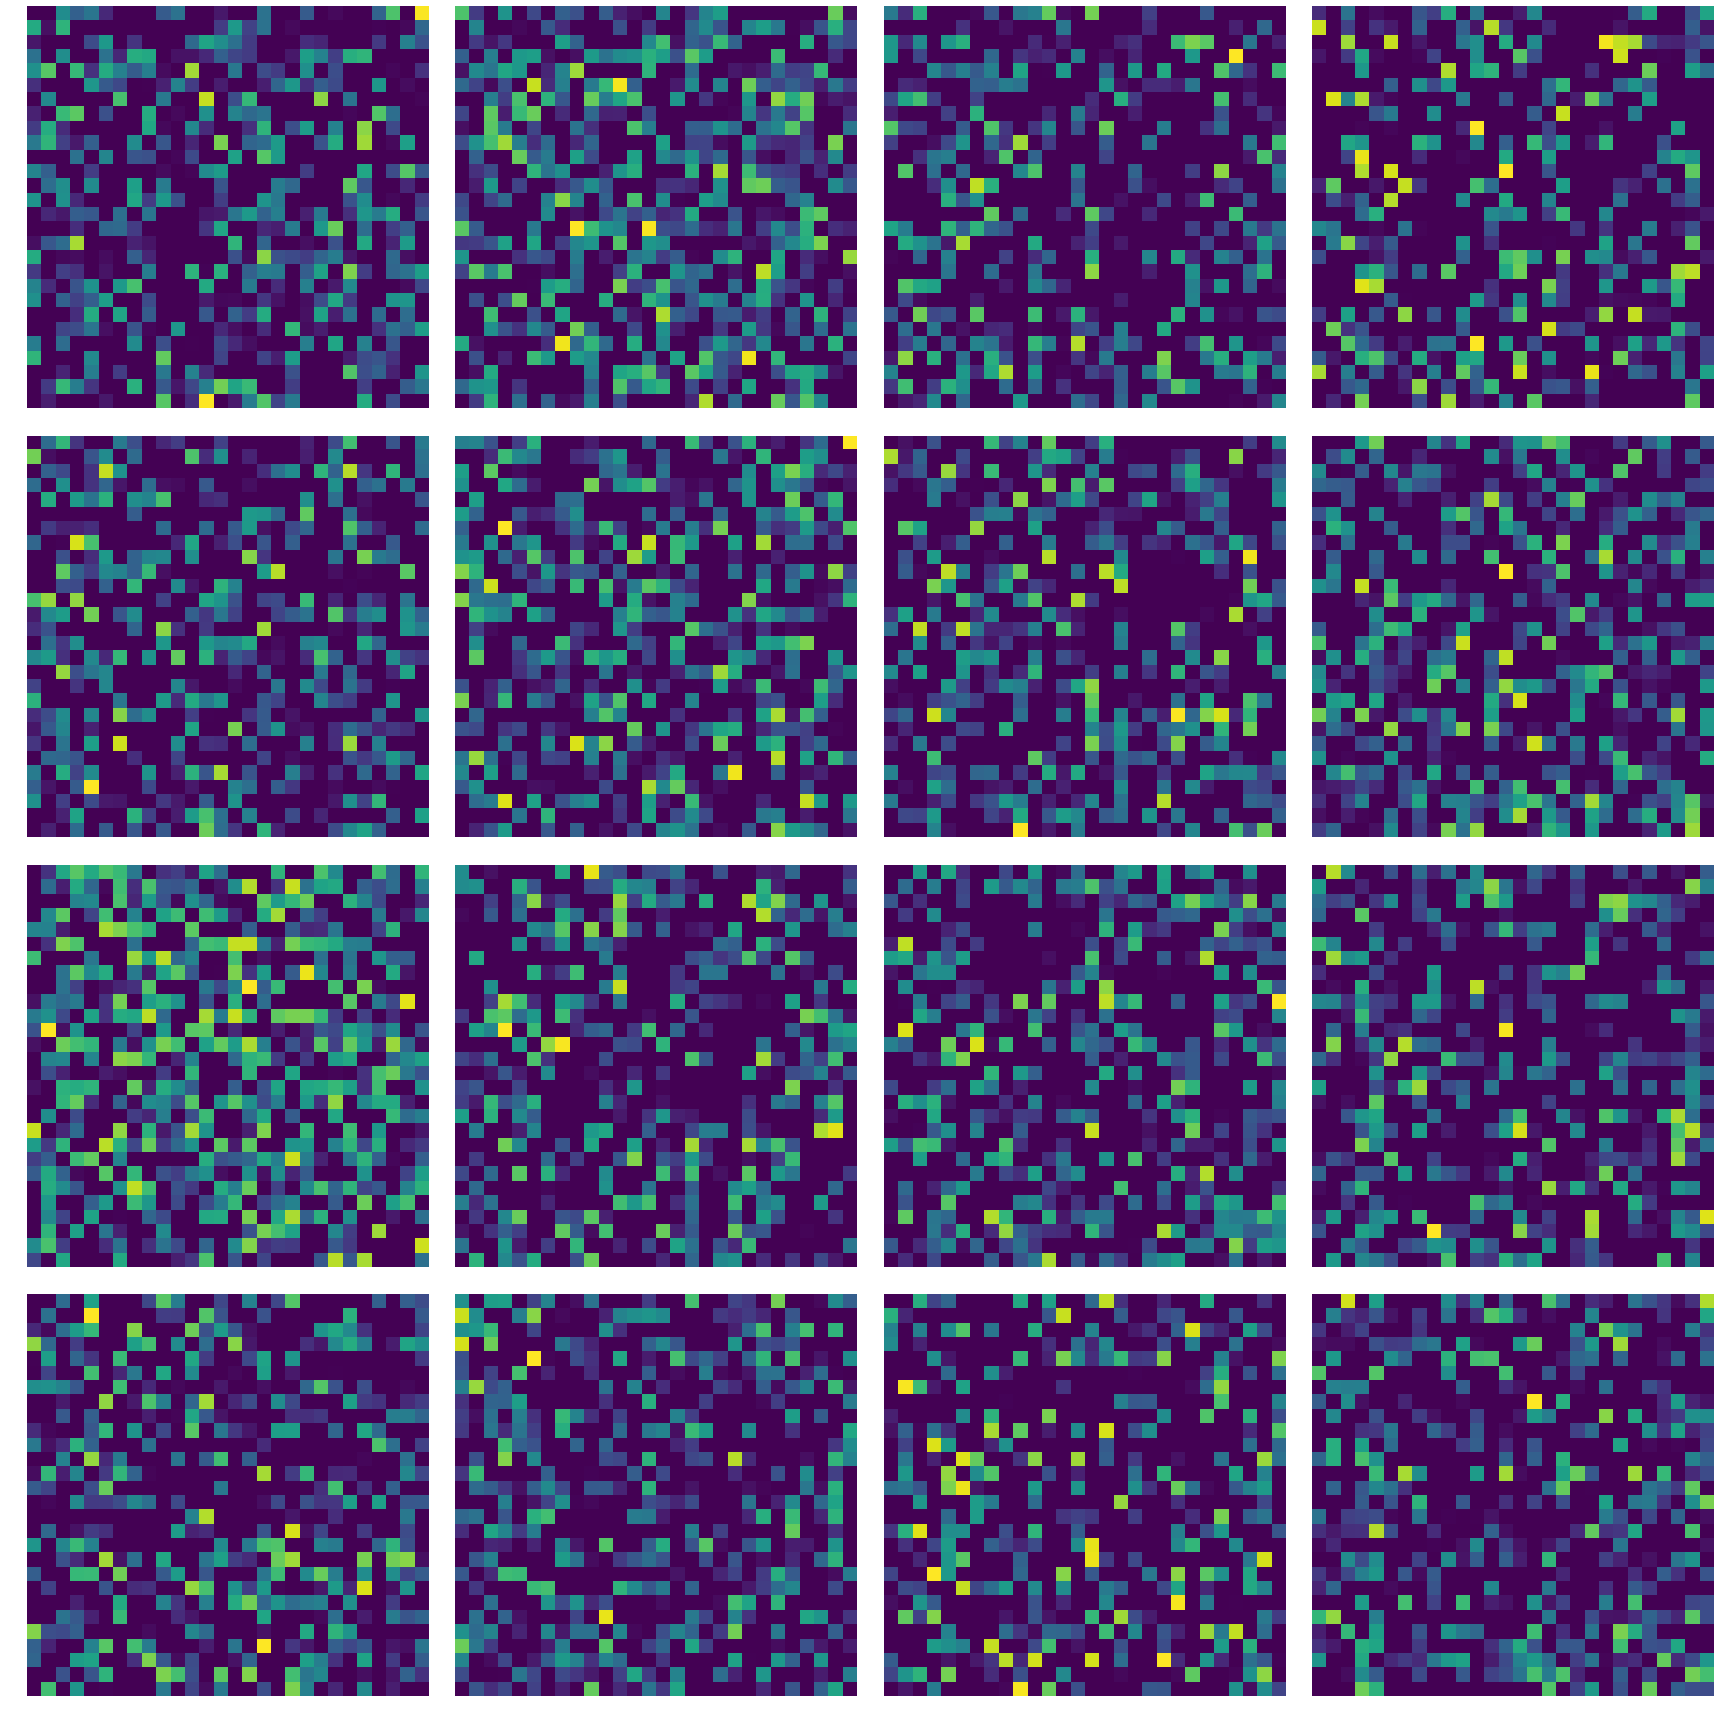

Epoch 5900, Generator loss 0.6139512658119202, discriminator loss 0.0016665664734318852


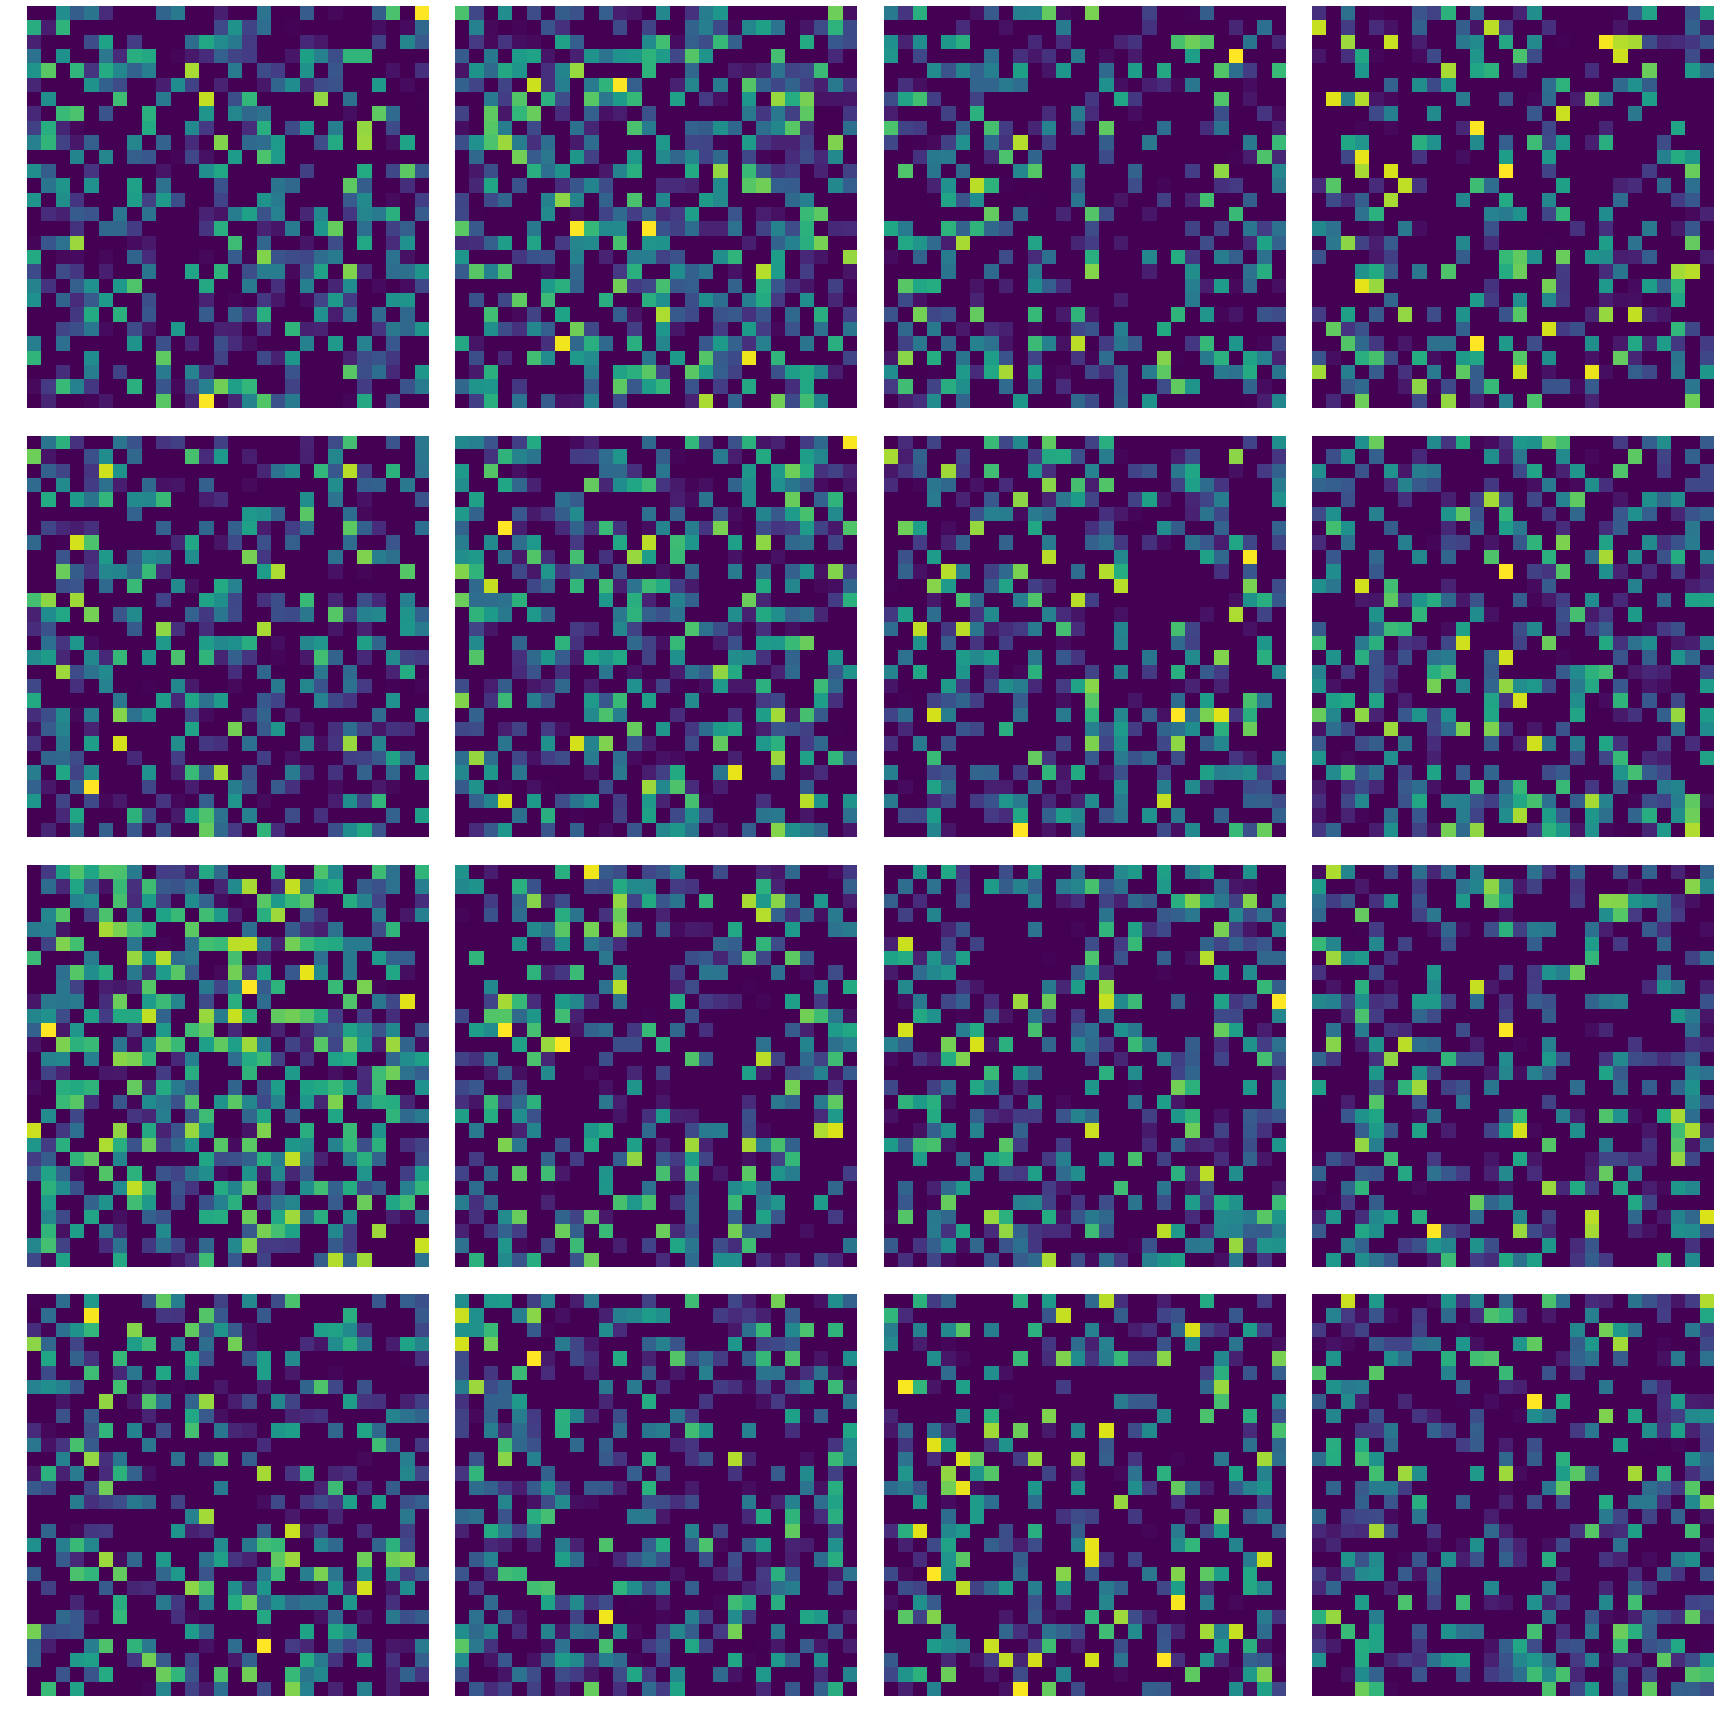

Epoch 6000, Generator loss 0.5939605832099915, discriminator loss 0.0016242392593994737


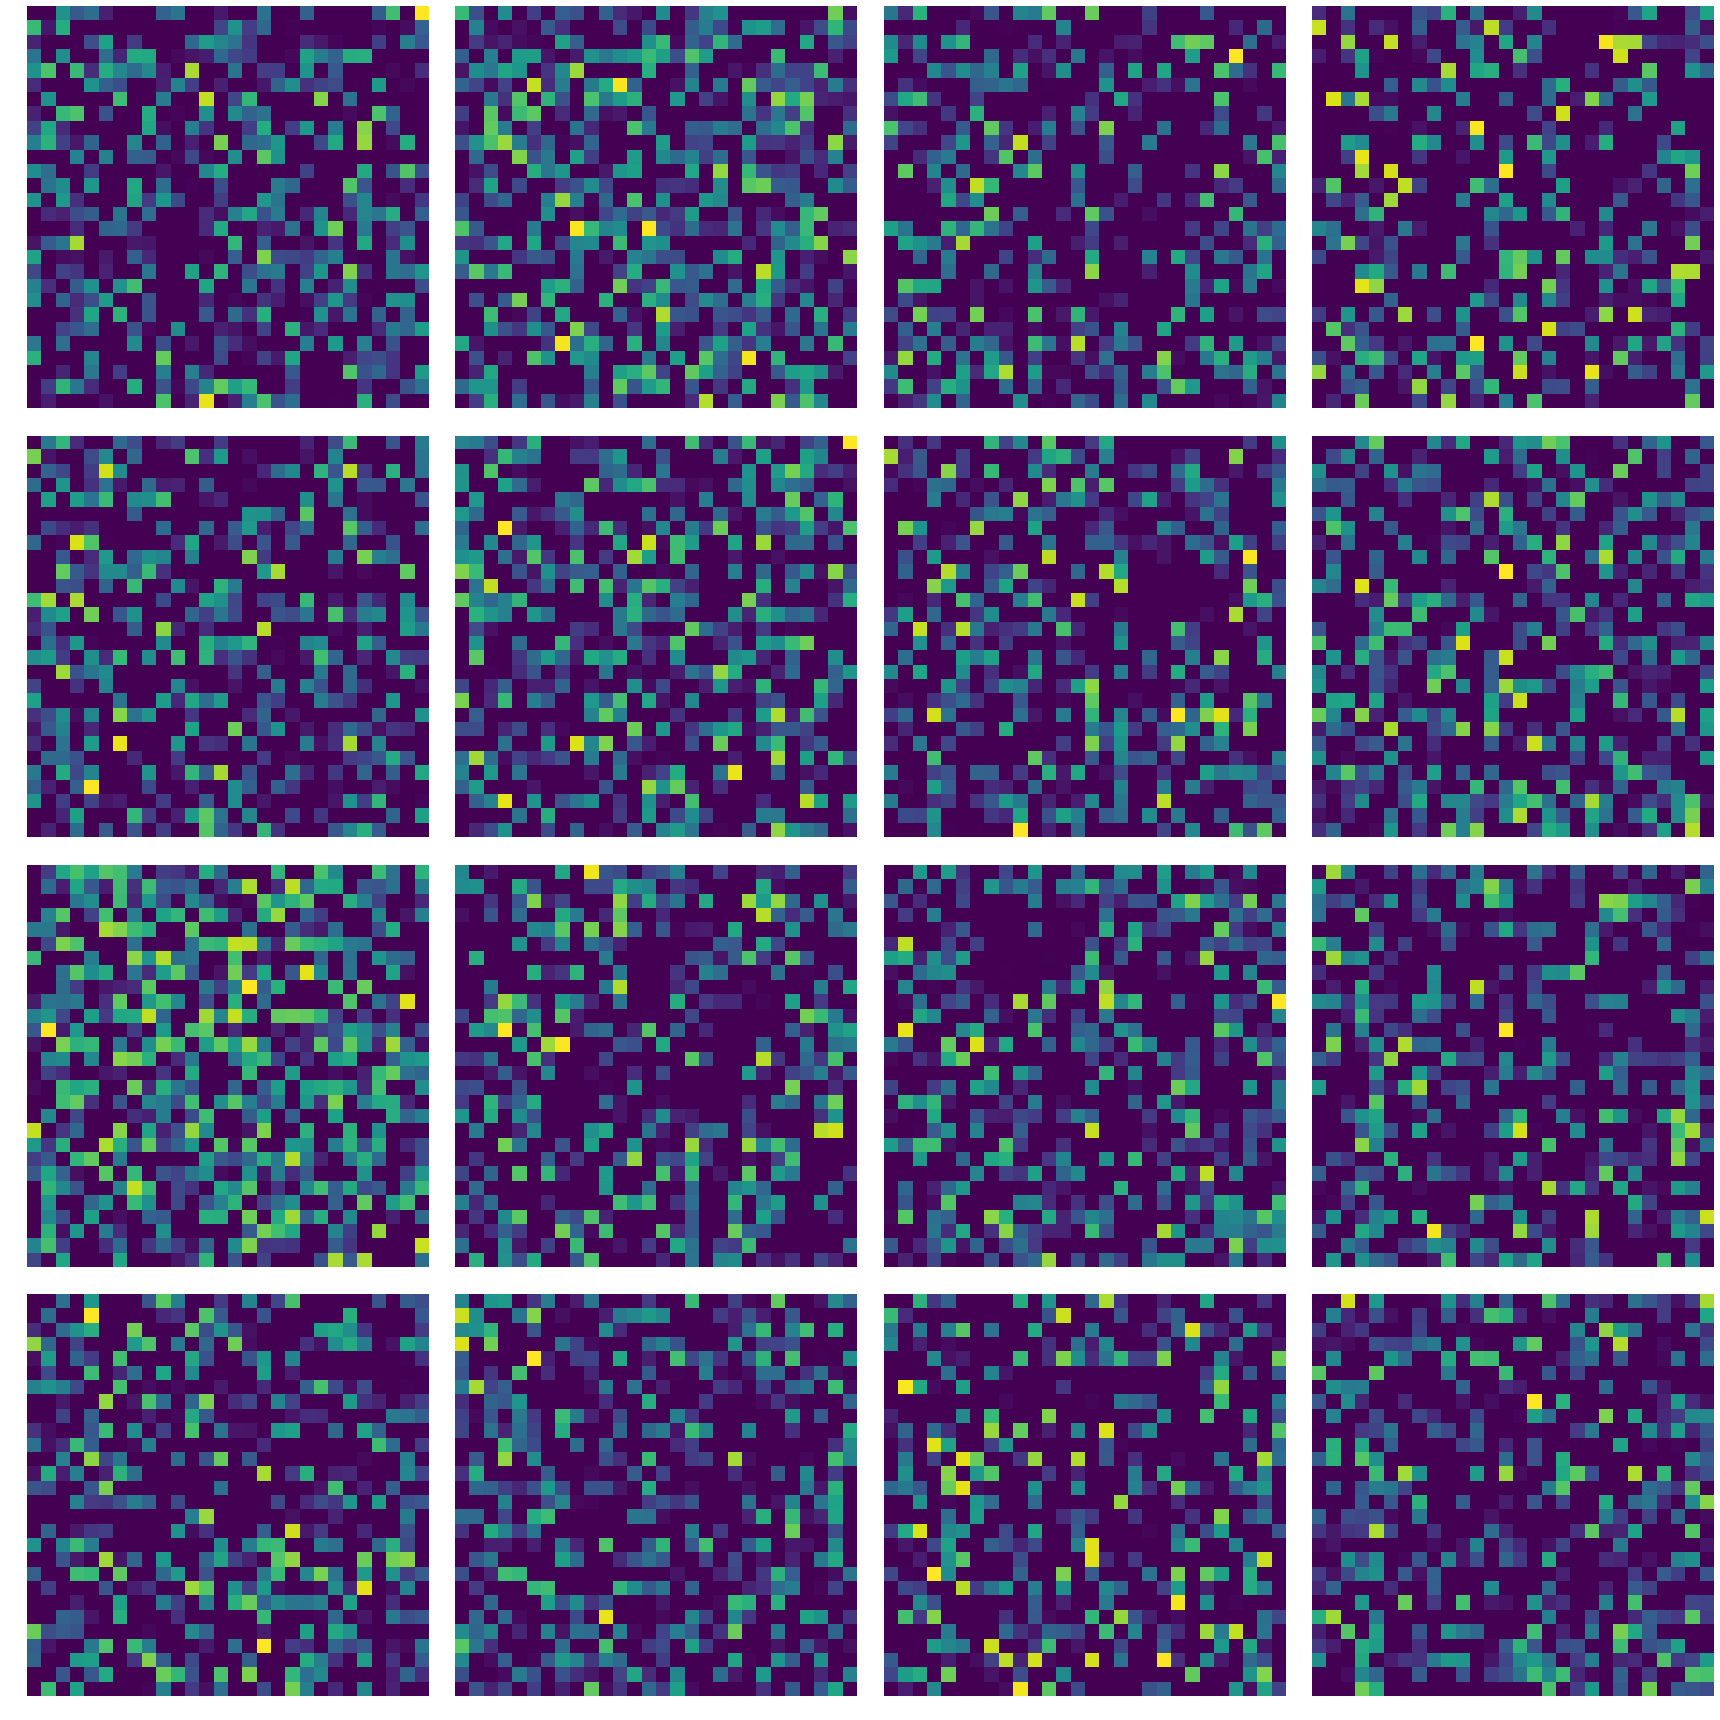

Epoch 6100, Generator loss 0.5997539758682251, discriminator loss 0.0015840934356674552


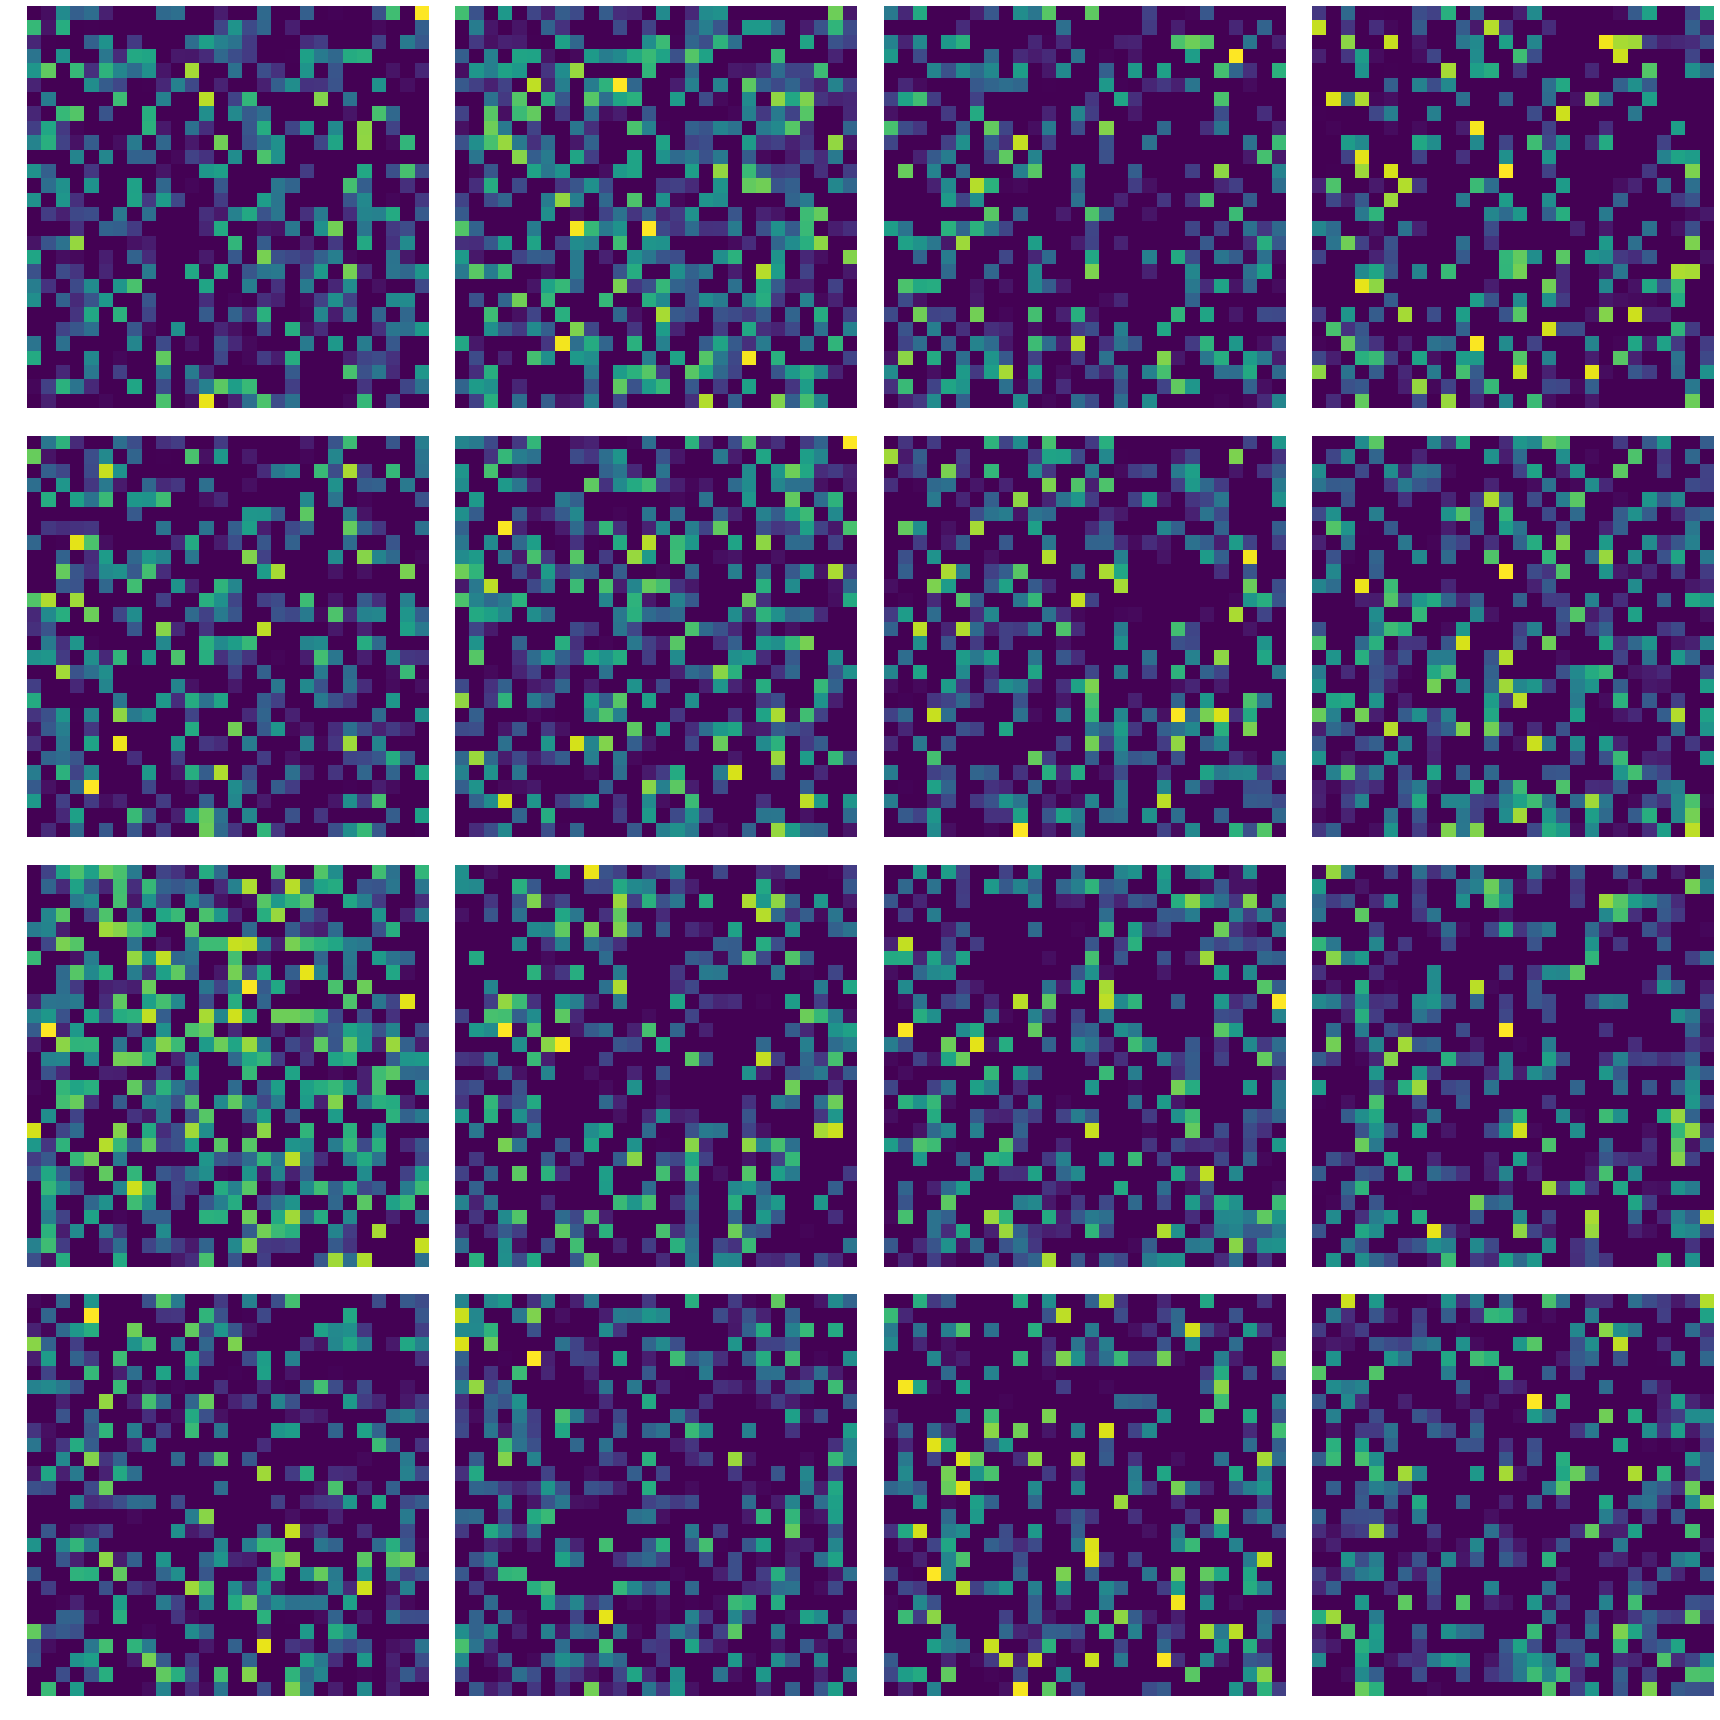

Epoch 6200, Generator loss 0.5983474850654602, discriminator loss 0.0015442812582477927


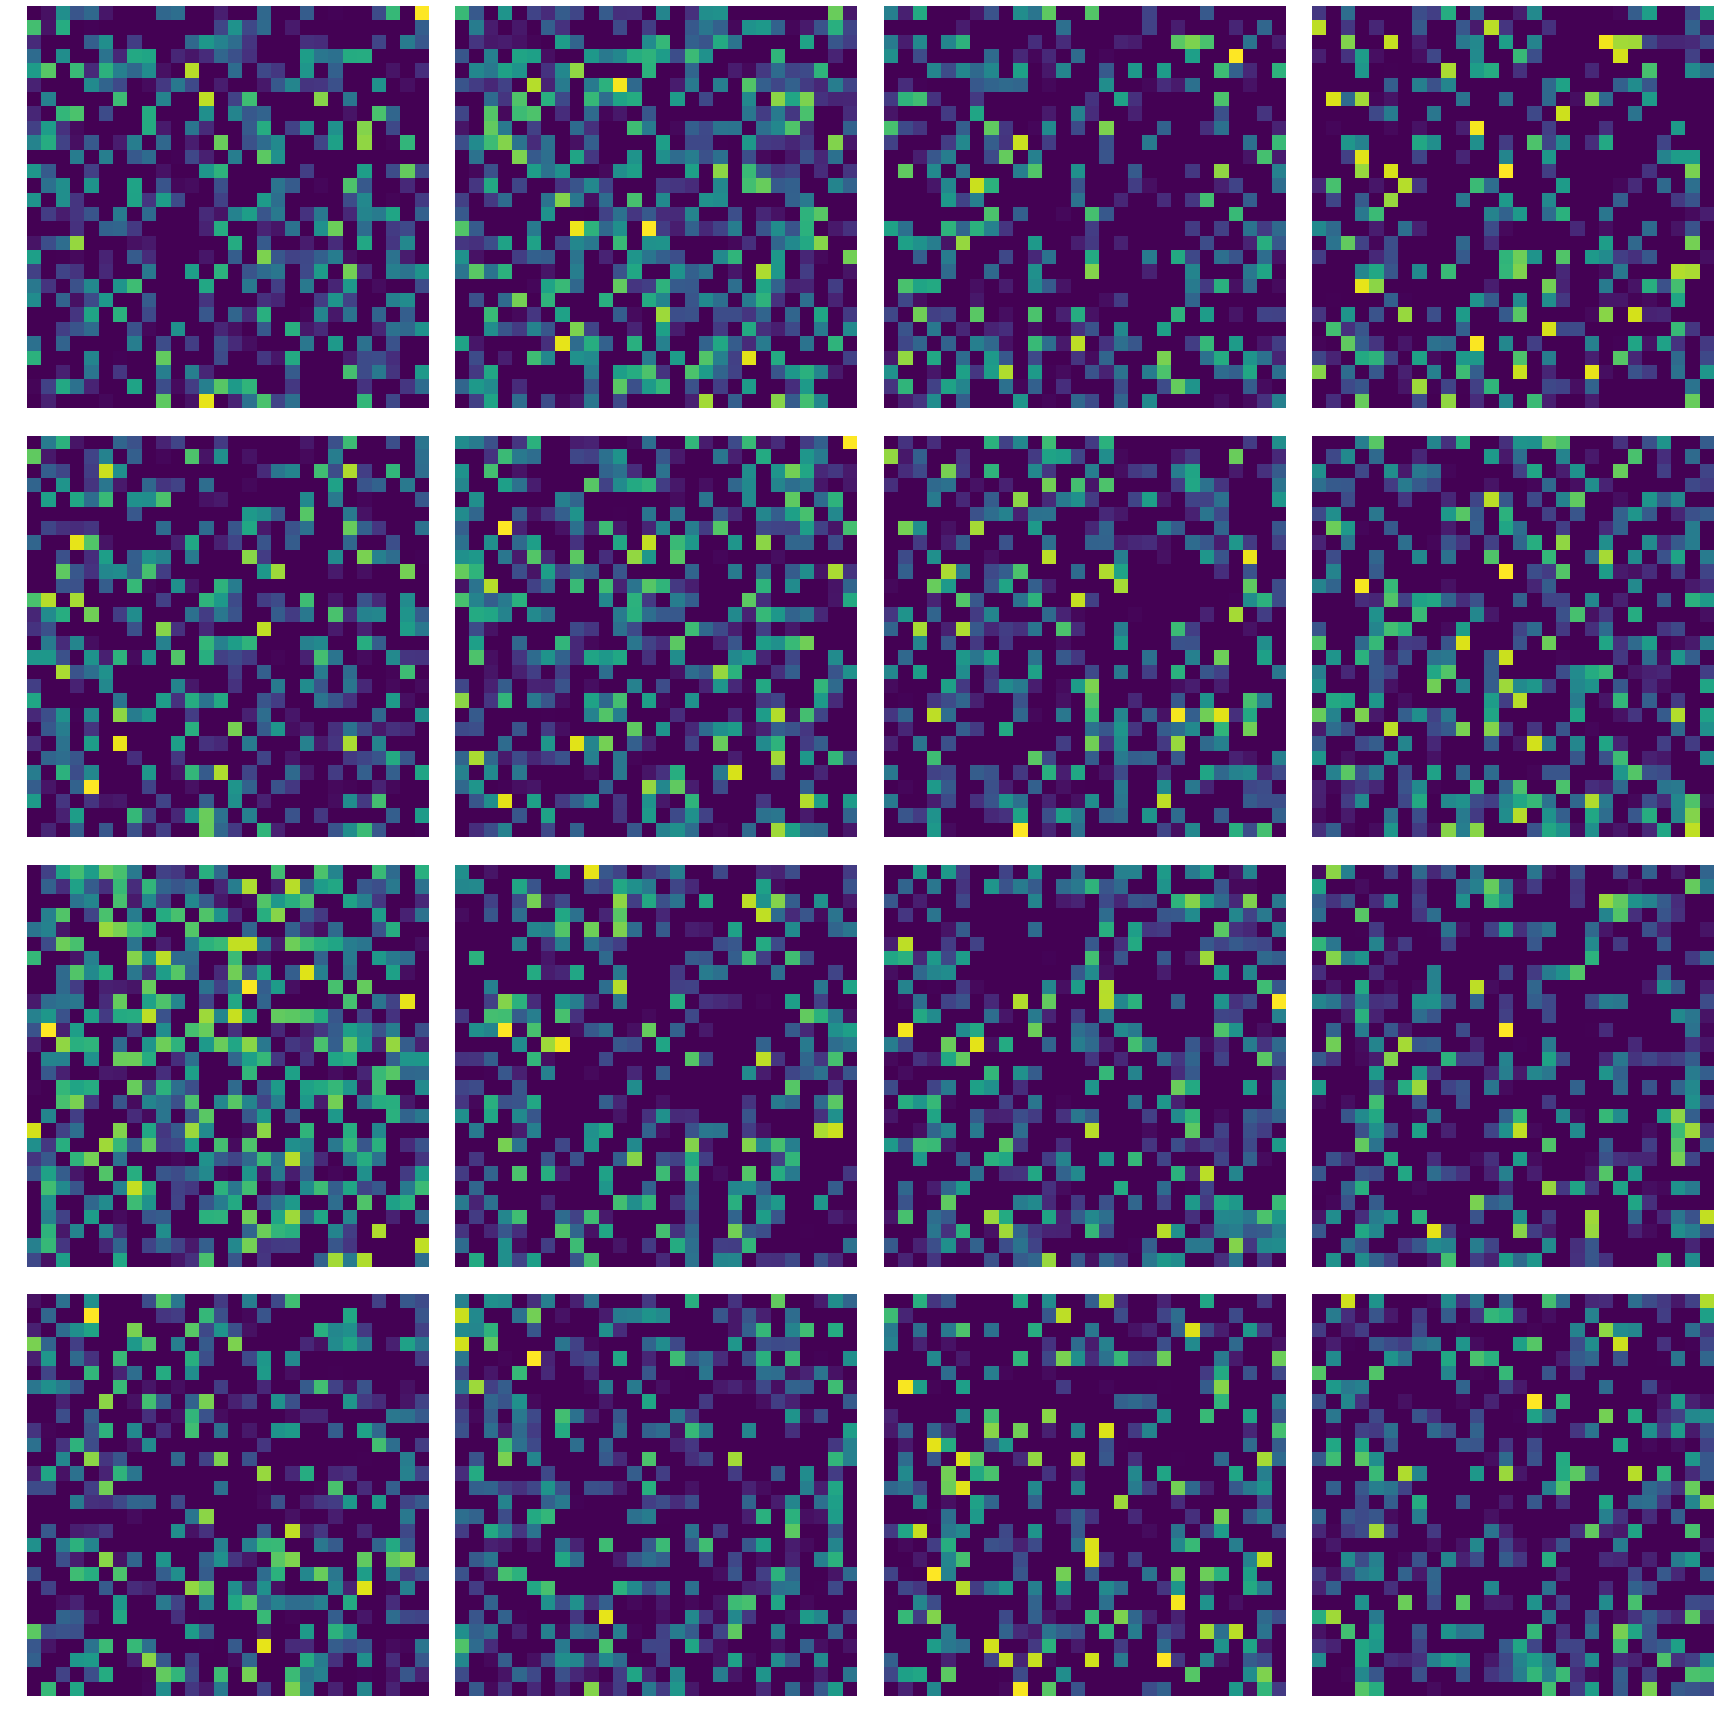

Epoch 6300, Generator loss 0.591435432434082, discriminator loss 0.0015055208932608366


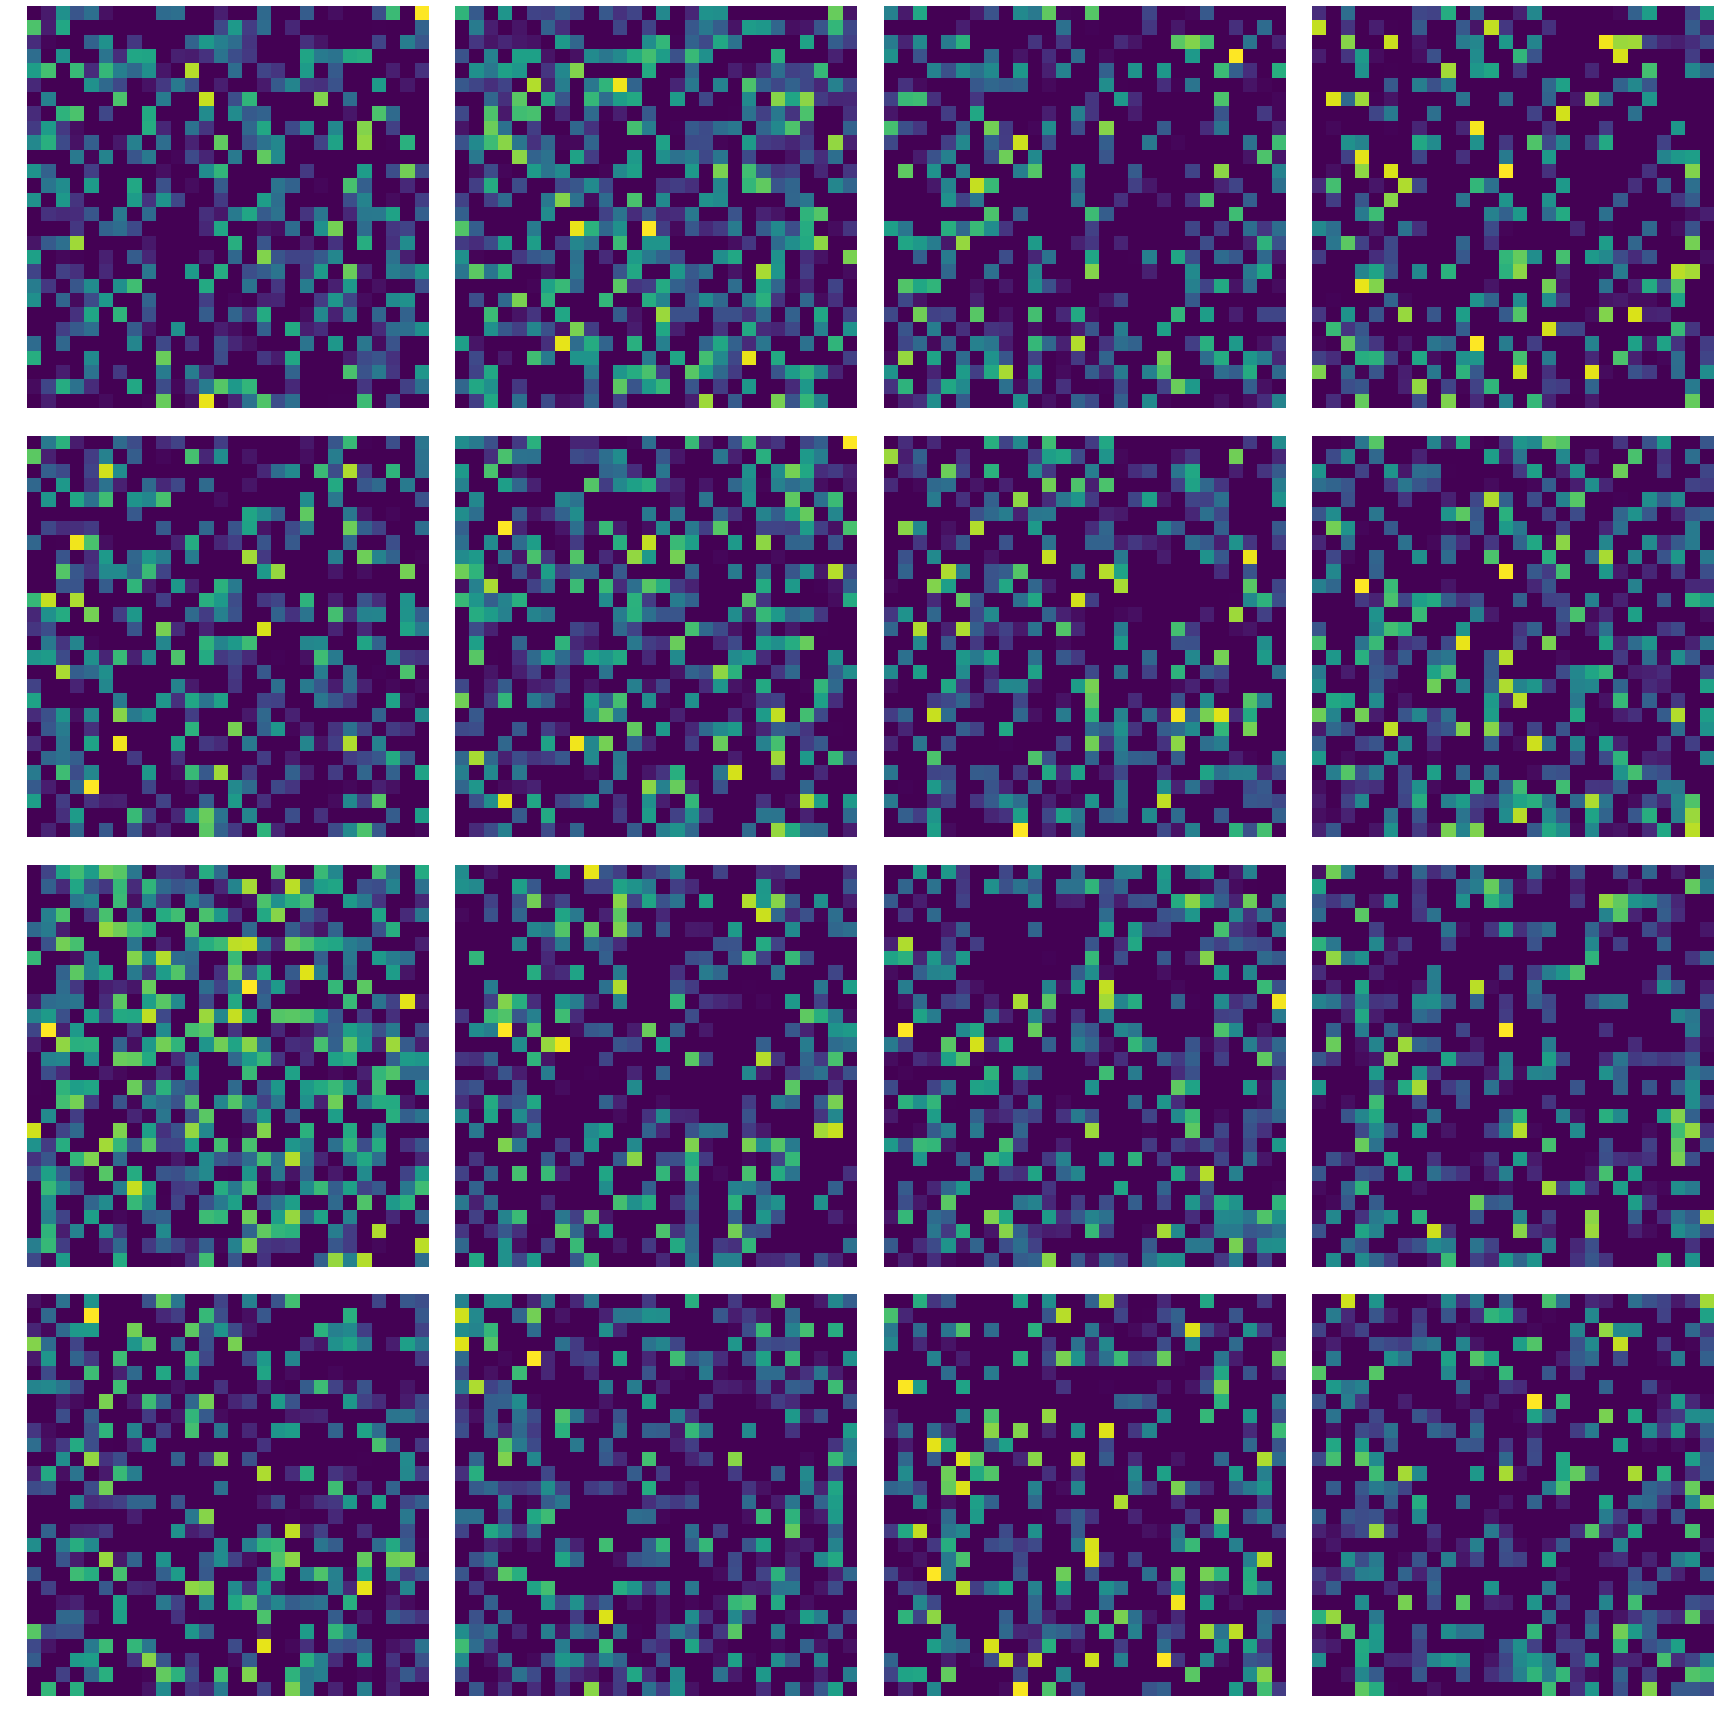

Epoch 6400, Generator loss 0.5968723893165588, discriminator loss 0.0014690527459606528


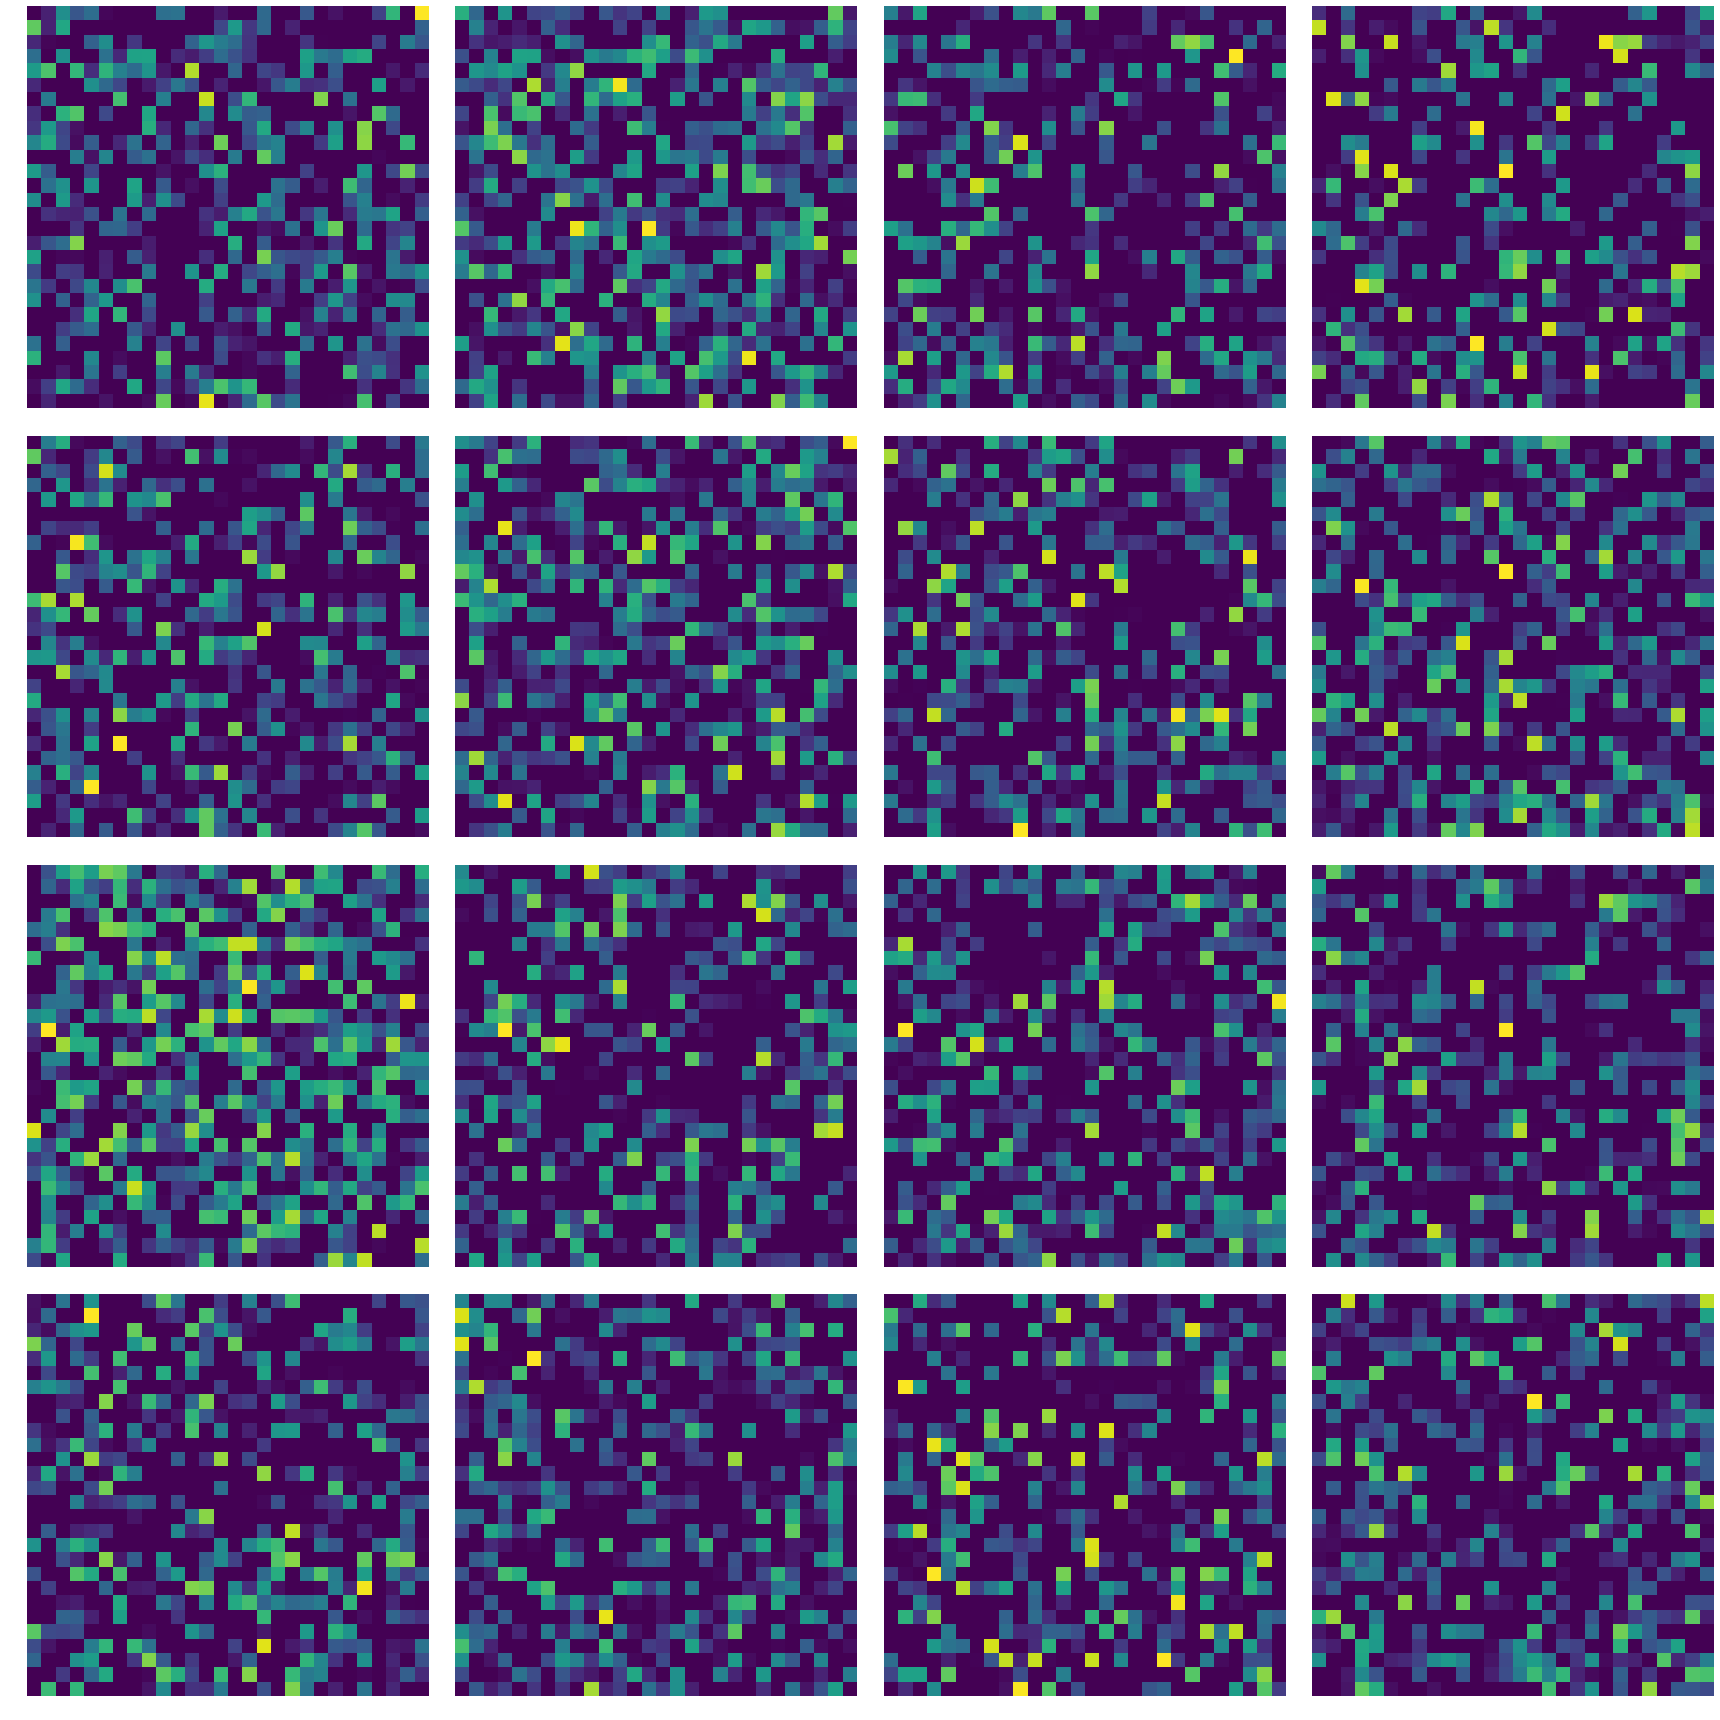

Epoch 6500, Generator loss 0.5894051194190979, discriminator loss 0.0014355657622218132


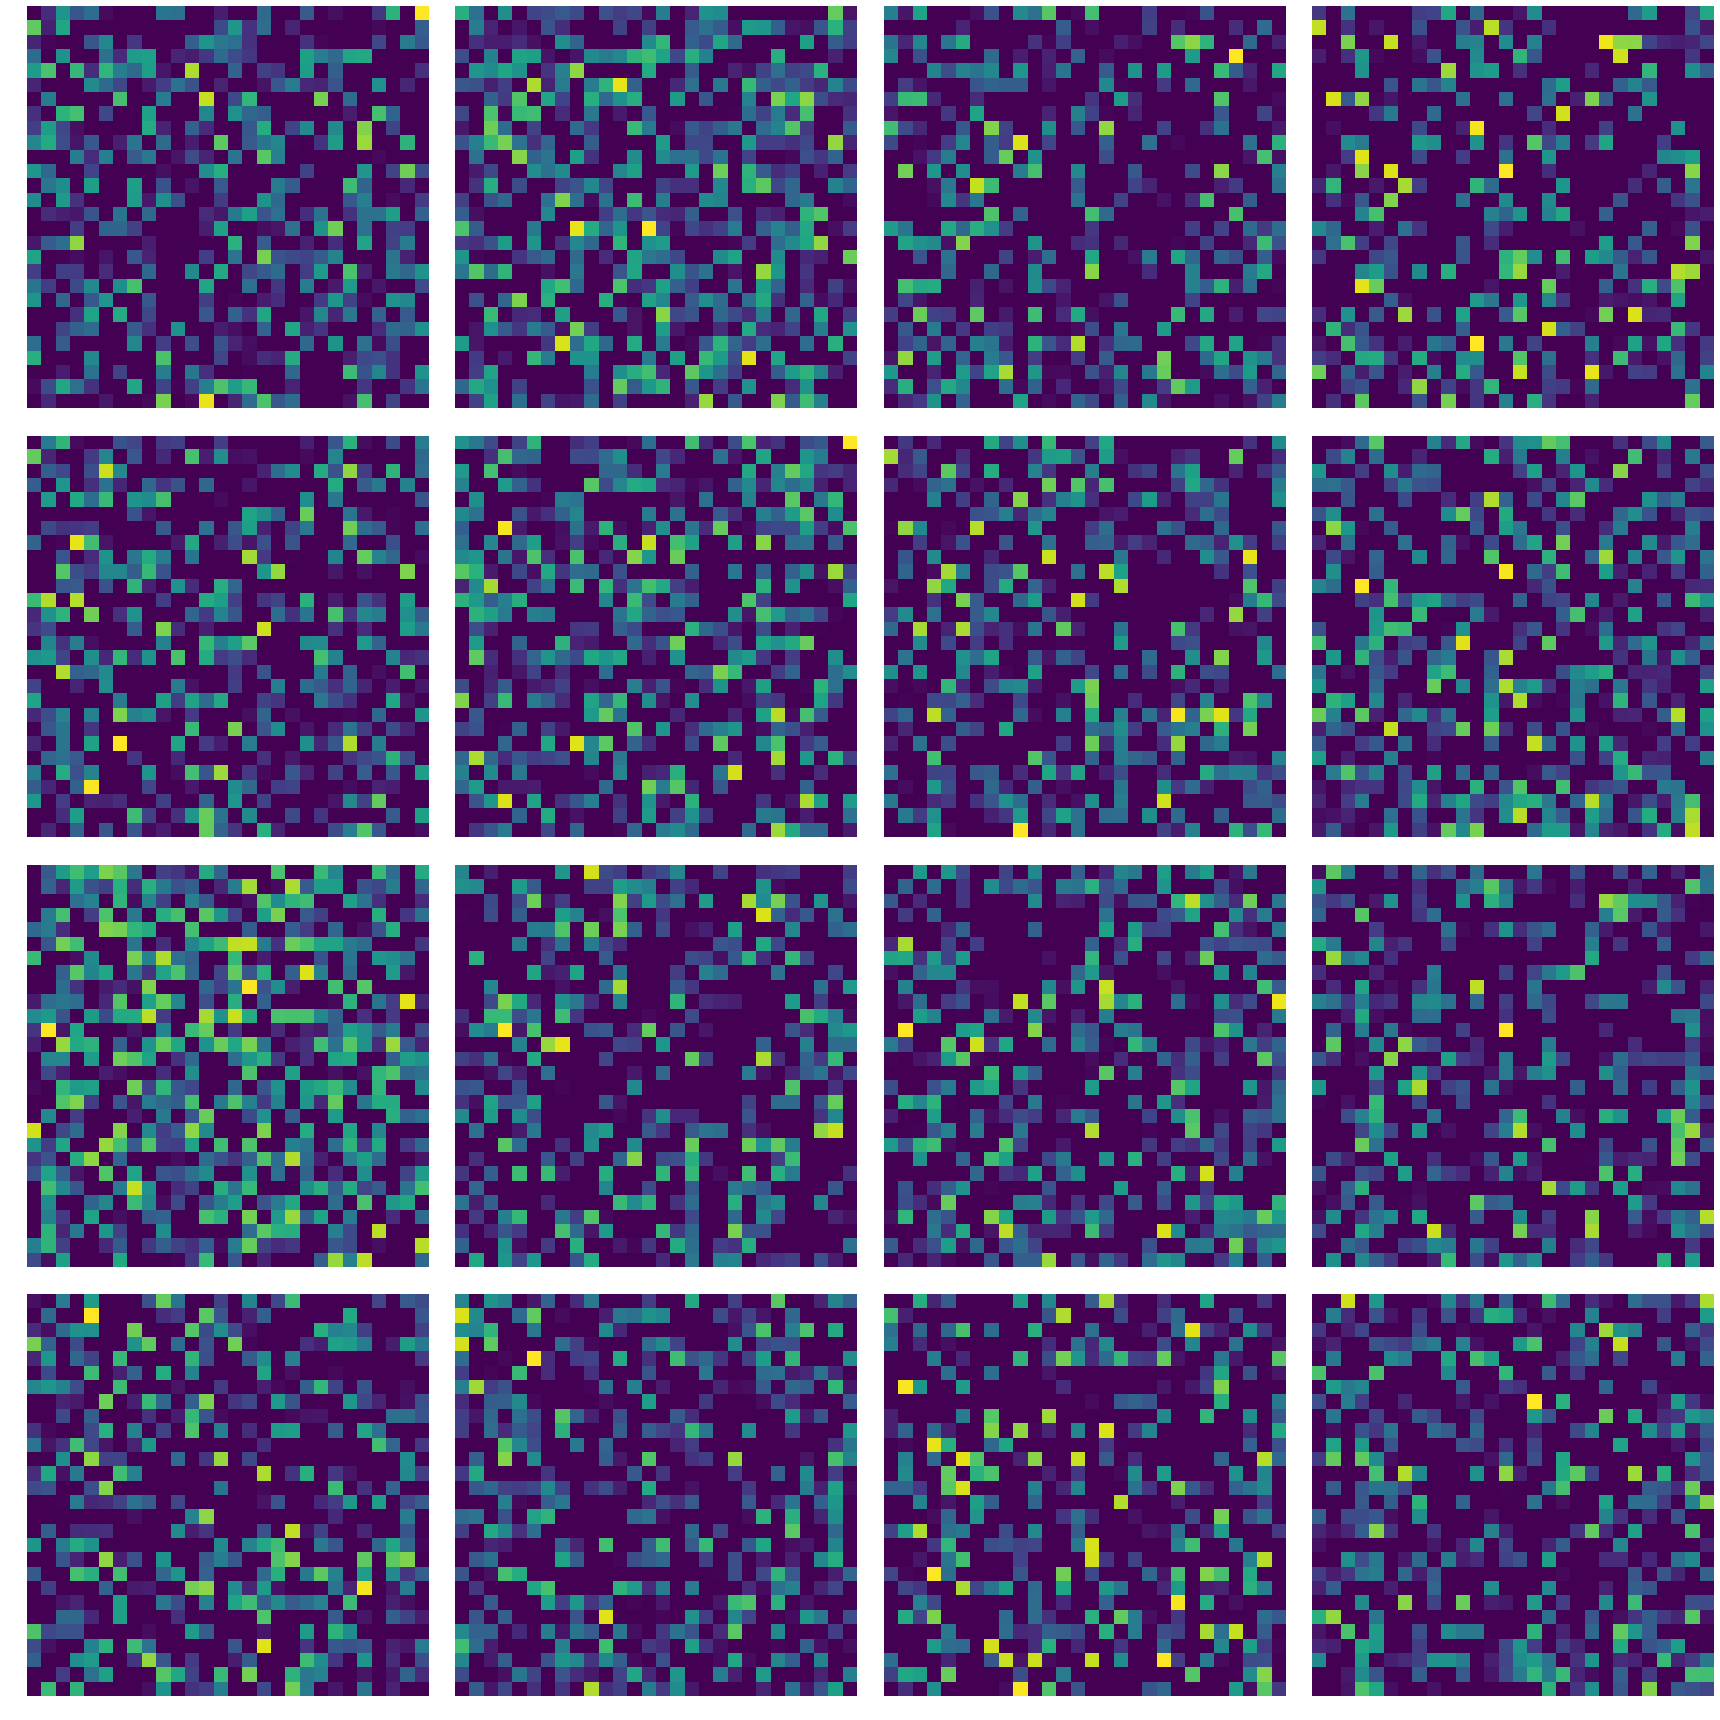

Epoch 6600, Generator loss 0.5871037244796753, discriminator loss 0.0014037768123671412


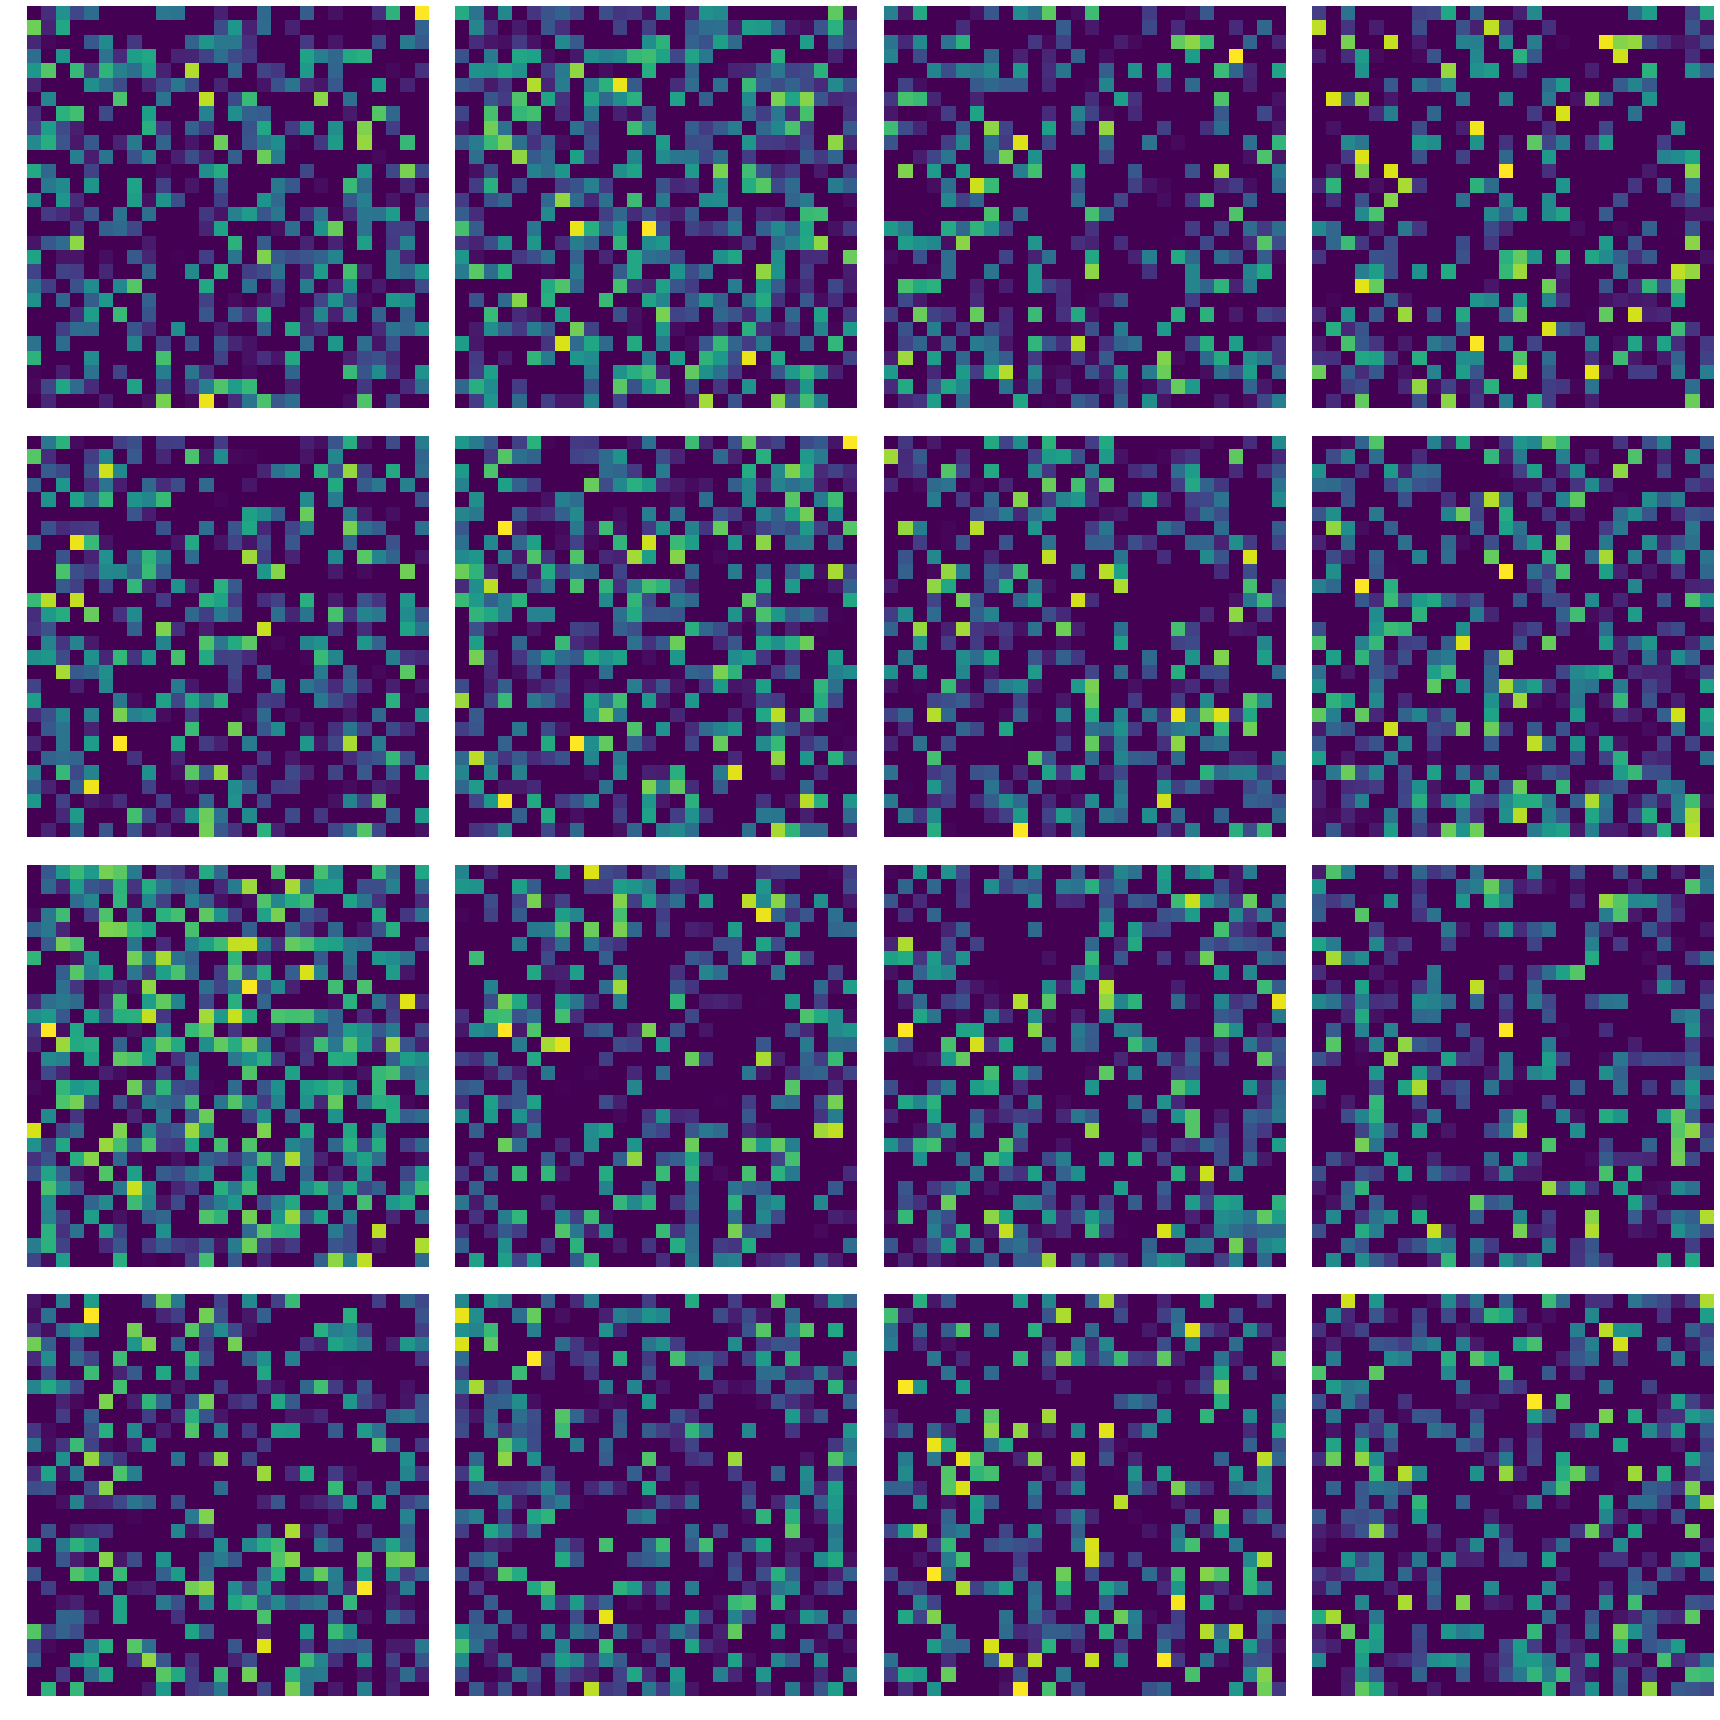

Epoch 6700, Generator loss 0.5824857354164124, discriminator loss 0.0013725688913837075


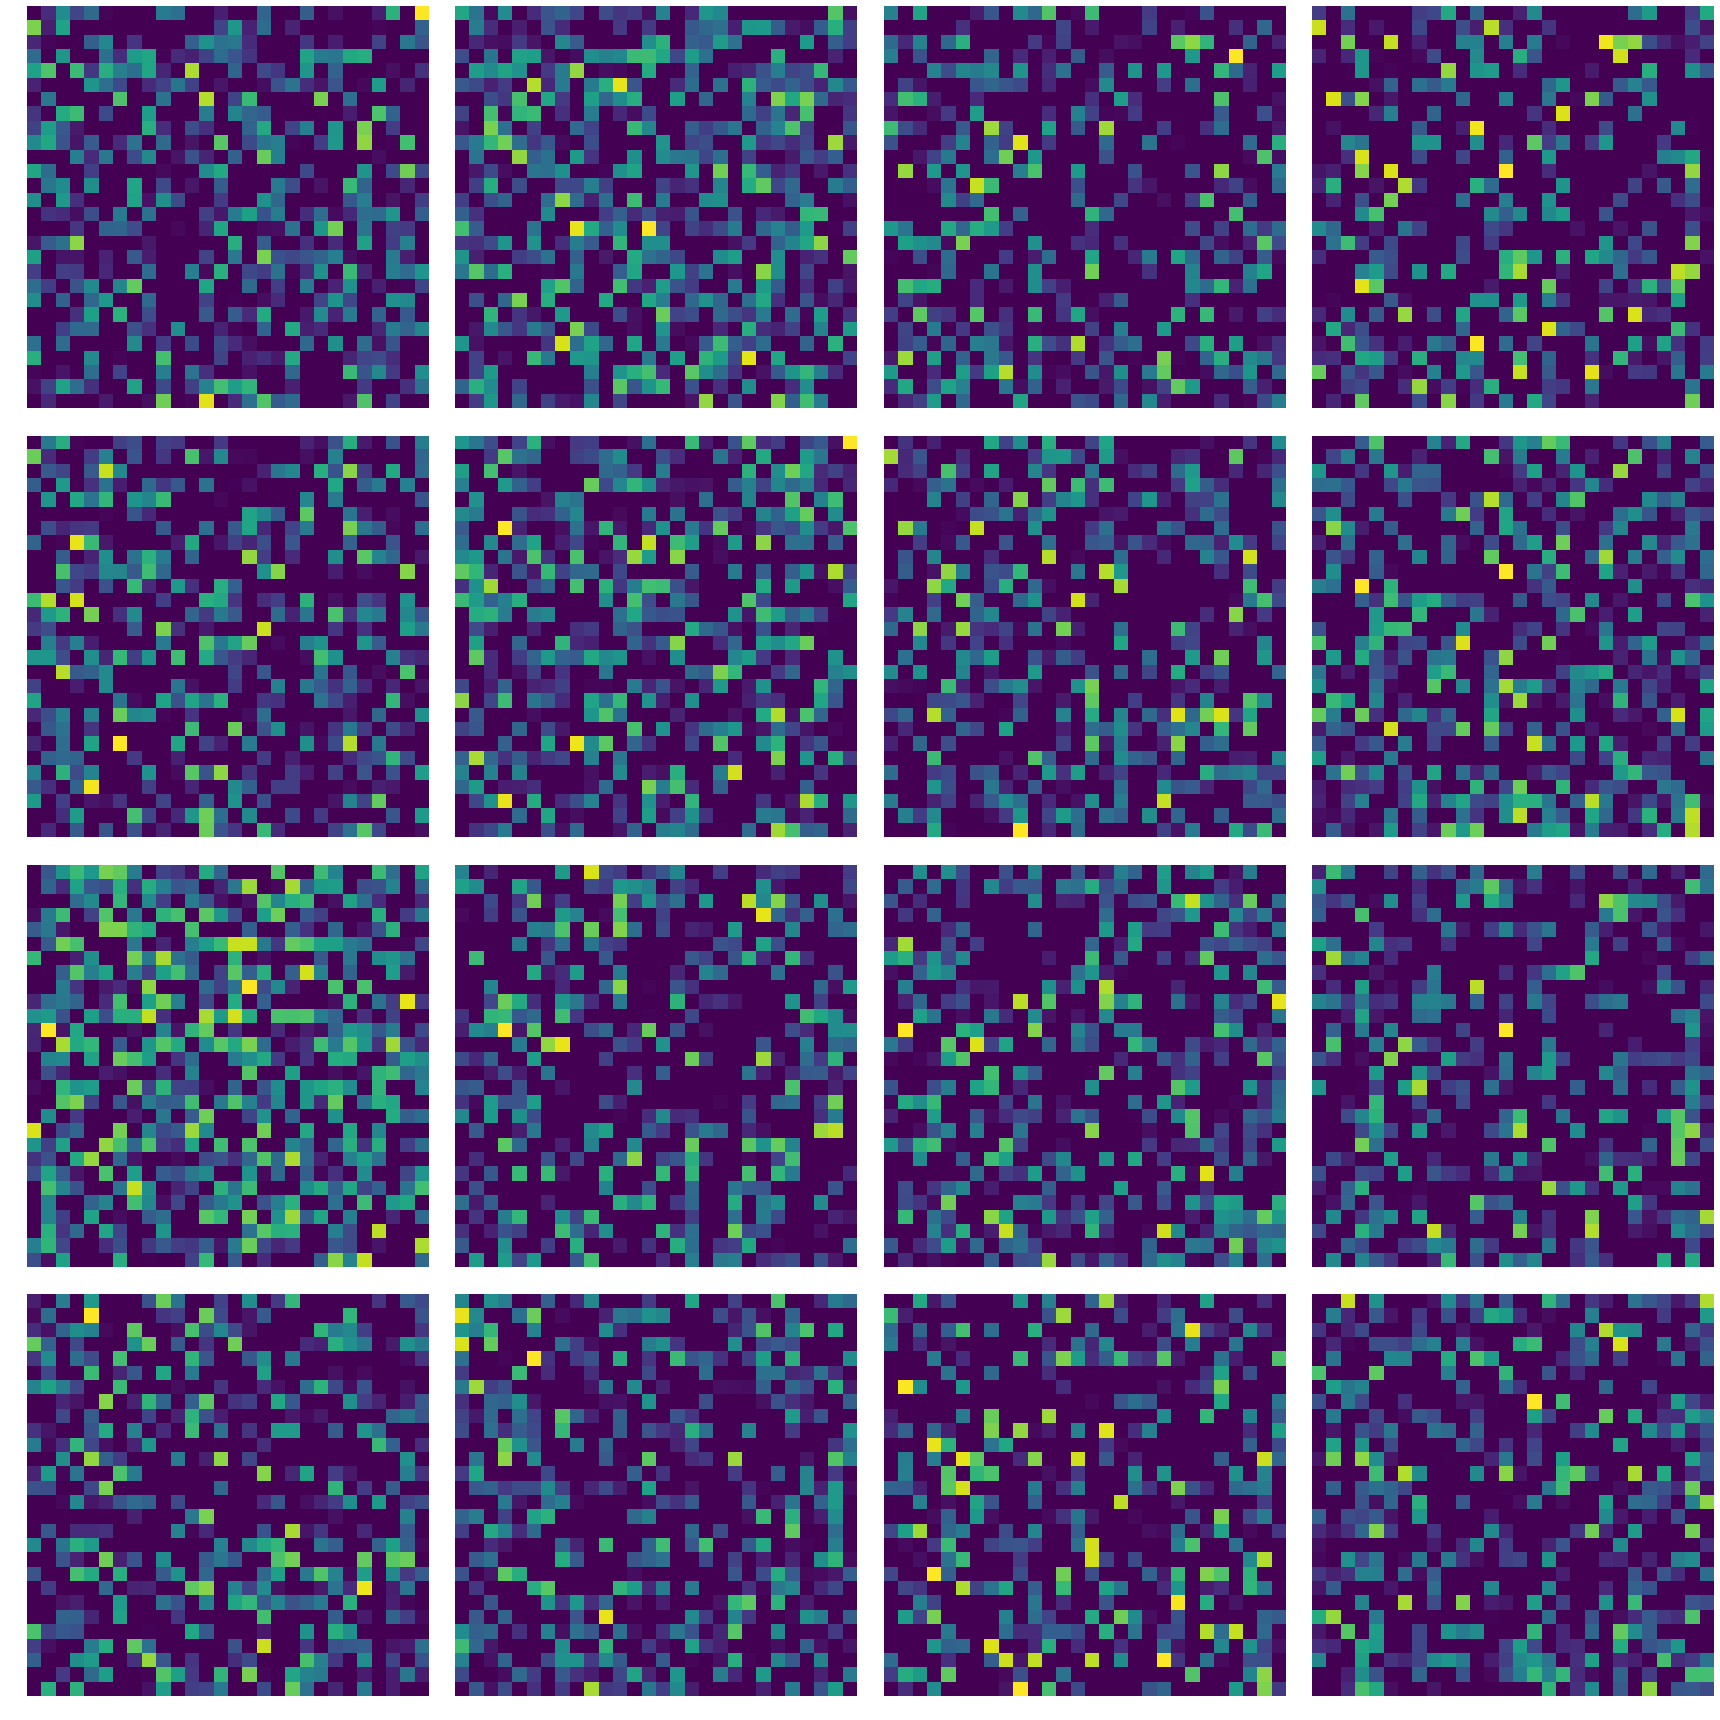

Epoch 6800, Generator loss 0.5798656940460205, discriminator loss 0.0013427286176010966


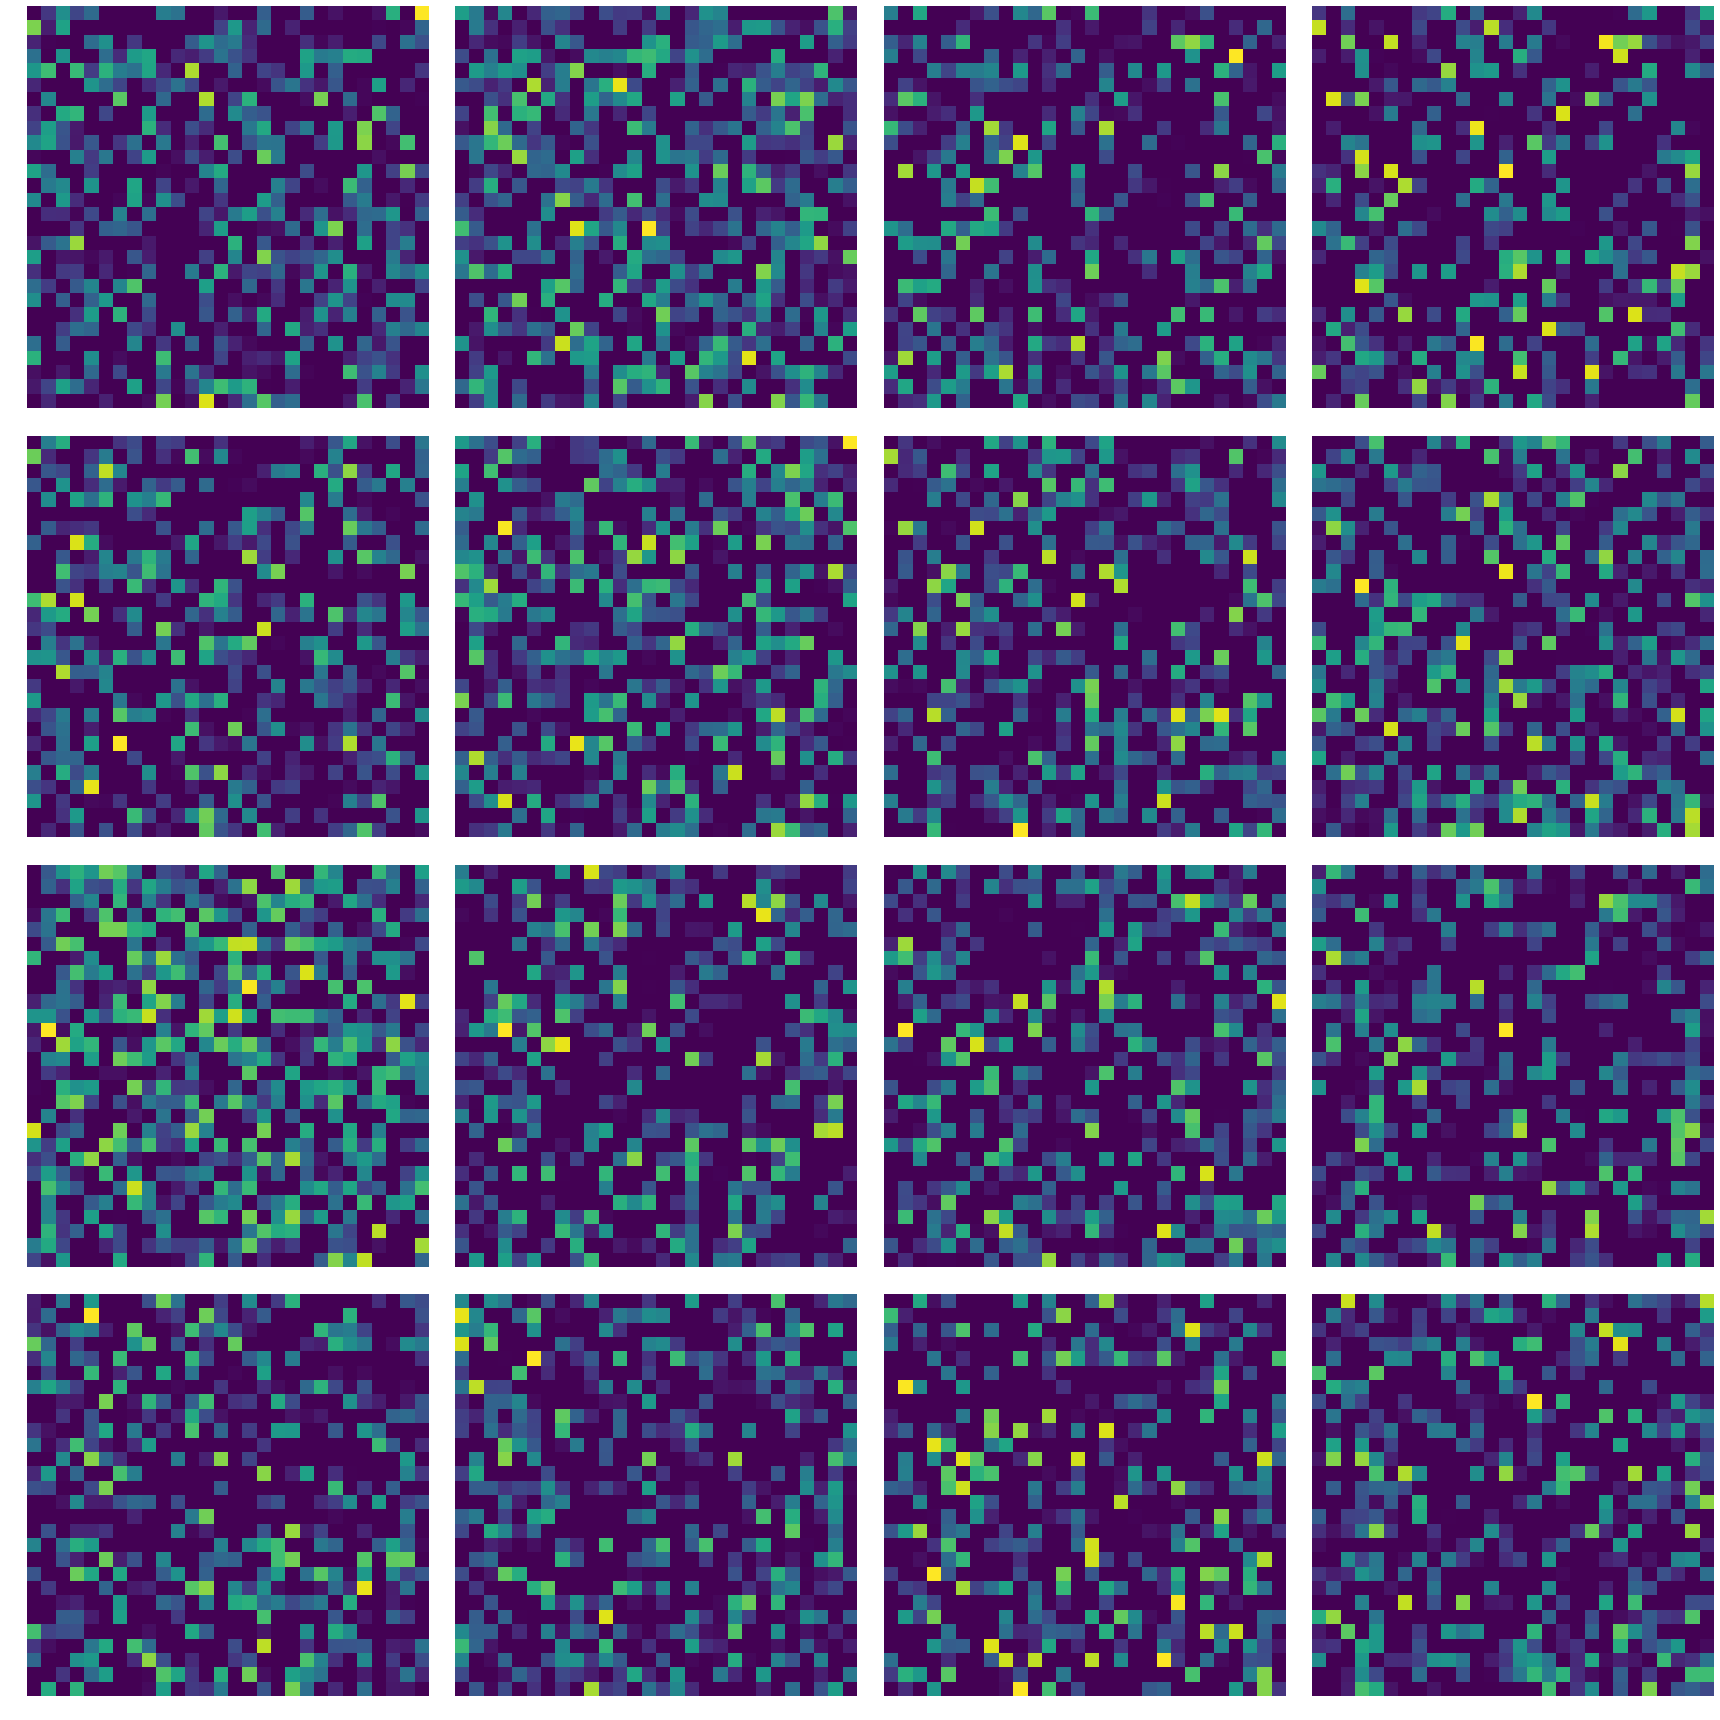

Epoch 6900, Generator loss 0.5724574327468872, discriminator loss 0.0013159802183508873


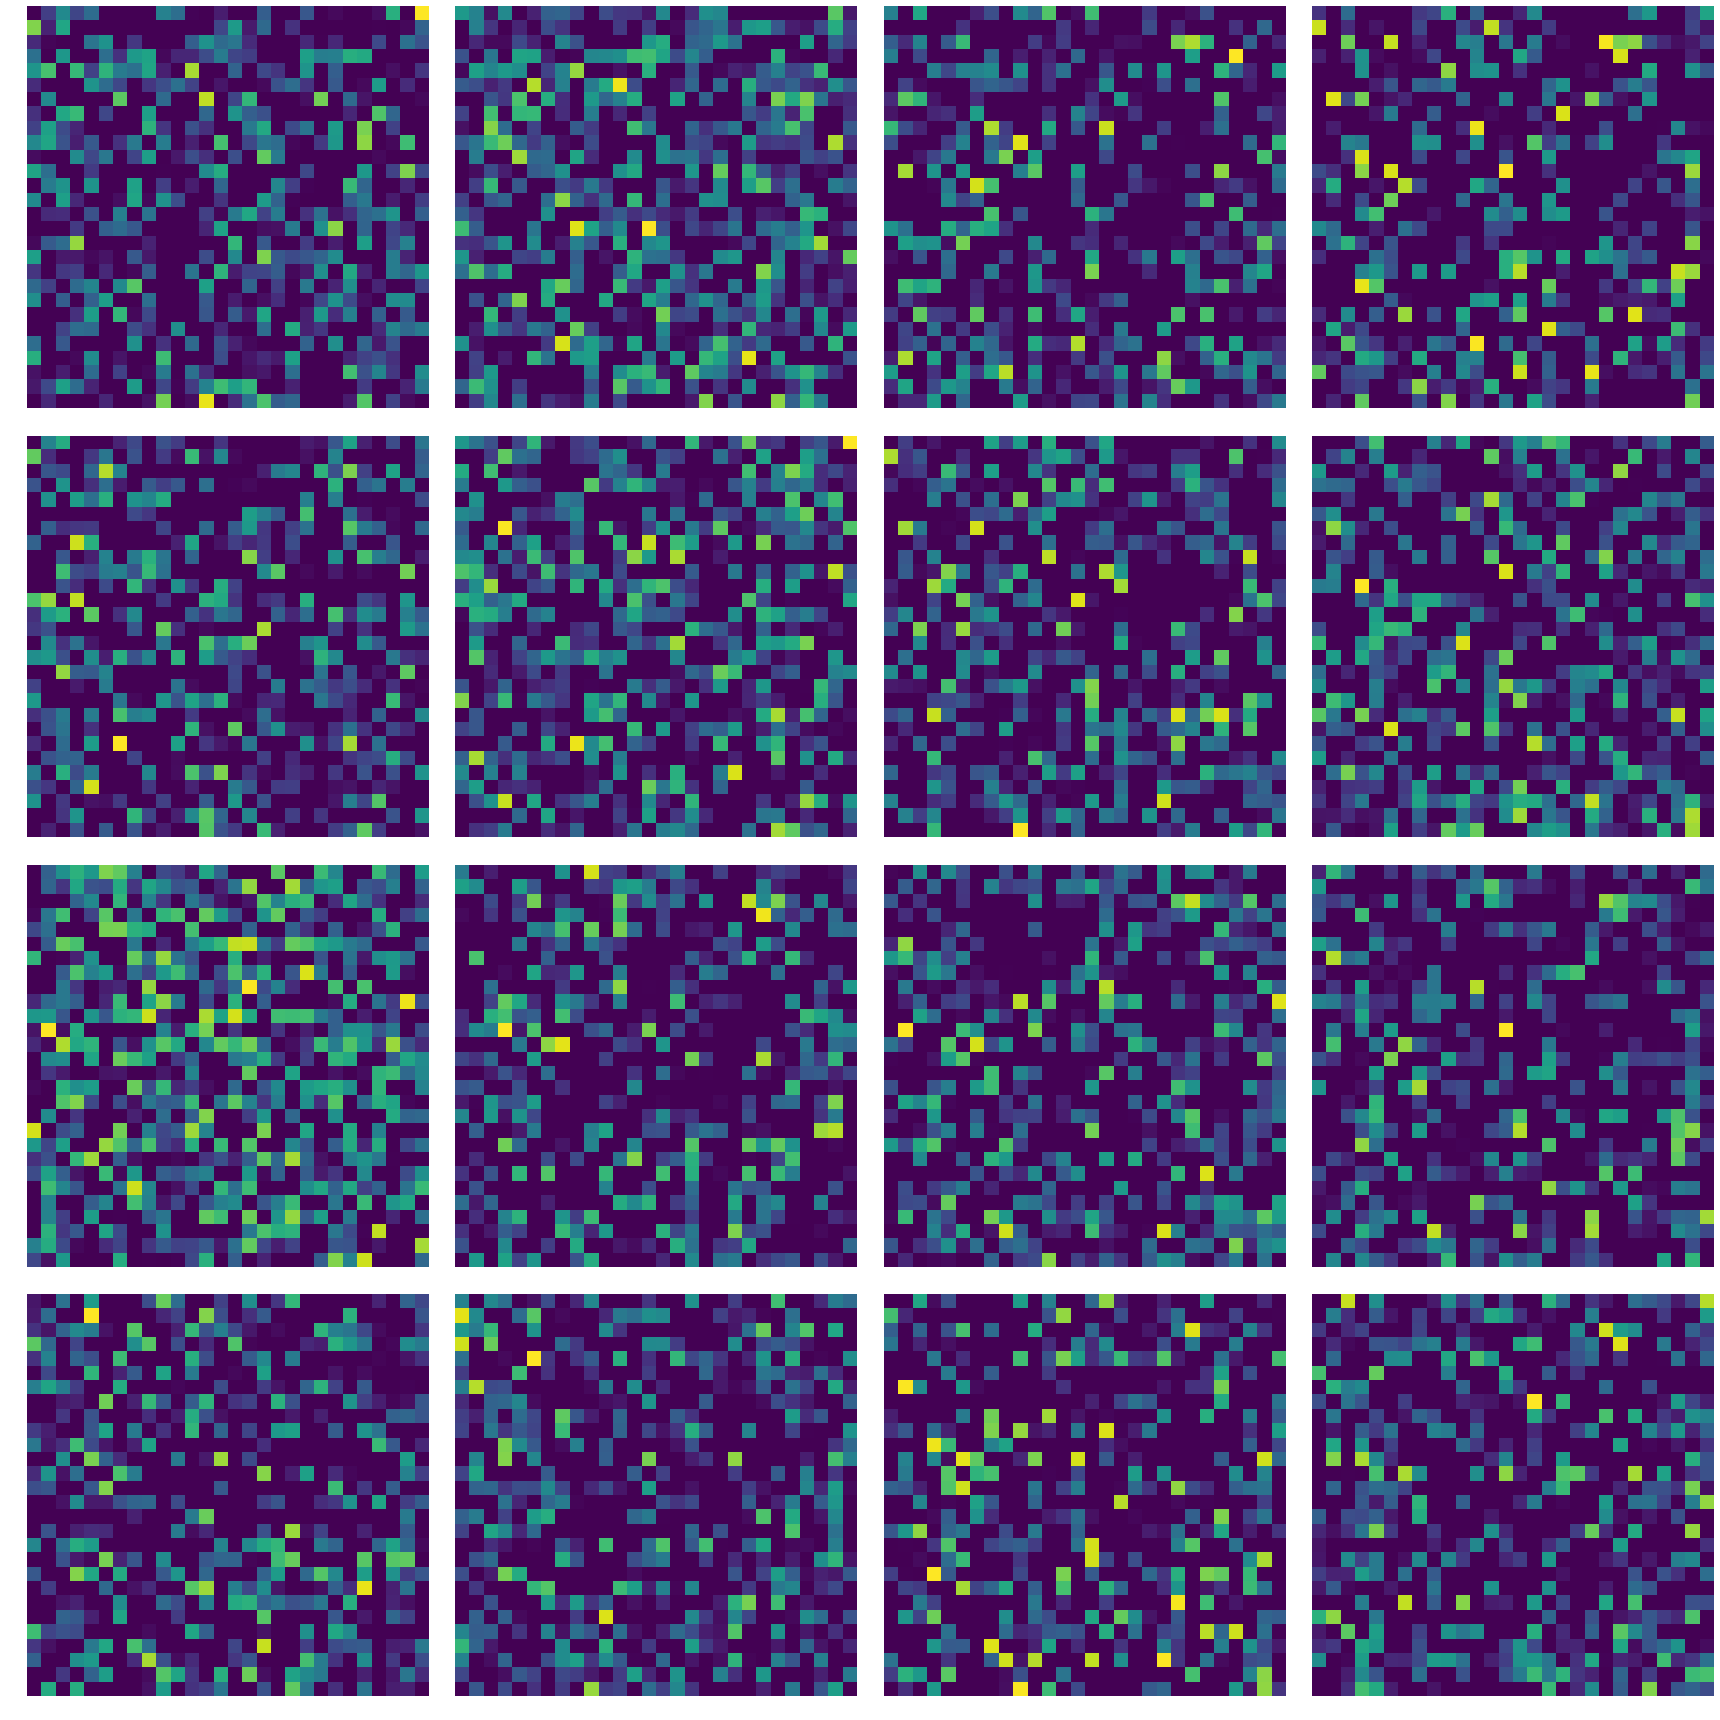

Epoch 7000, Generator loss 0.5671497583389282, discriminator loss 0.0012894163373857737


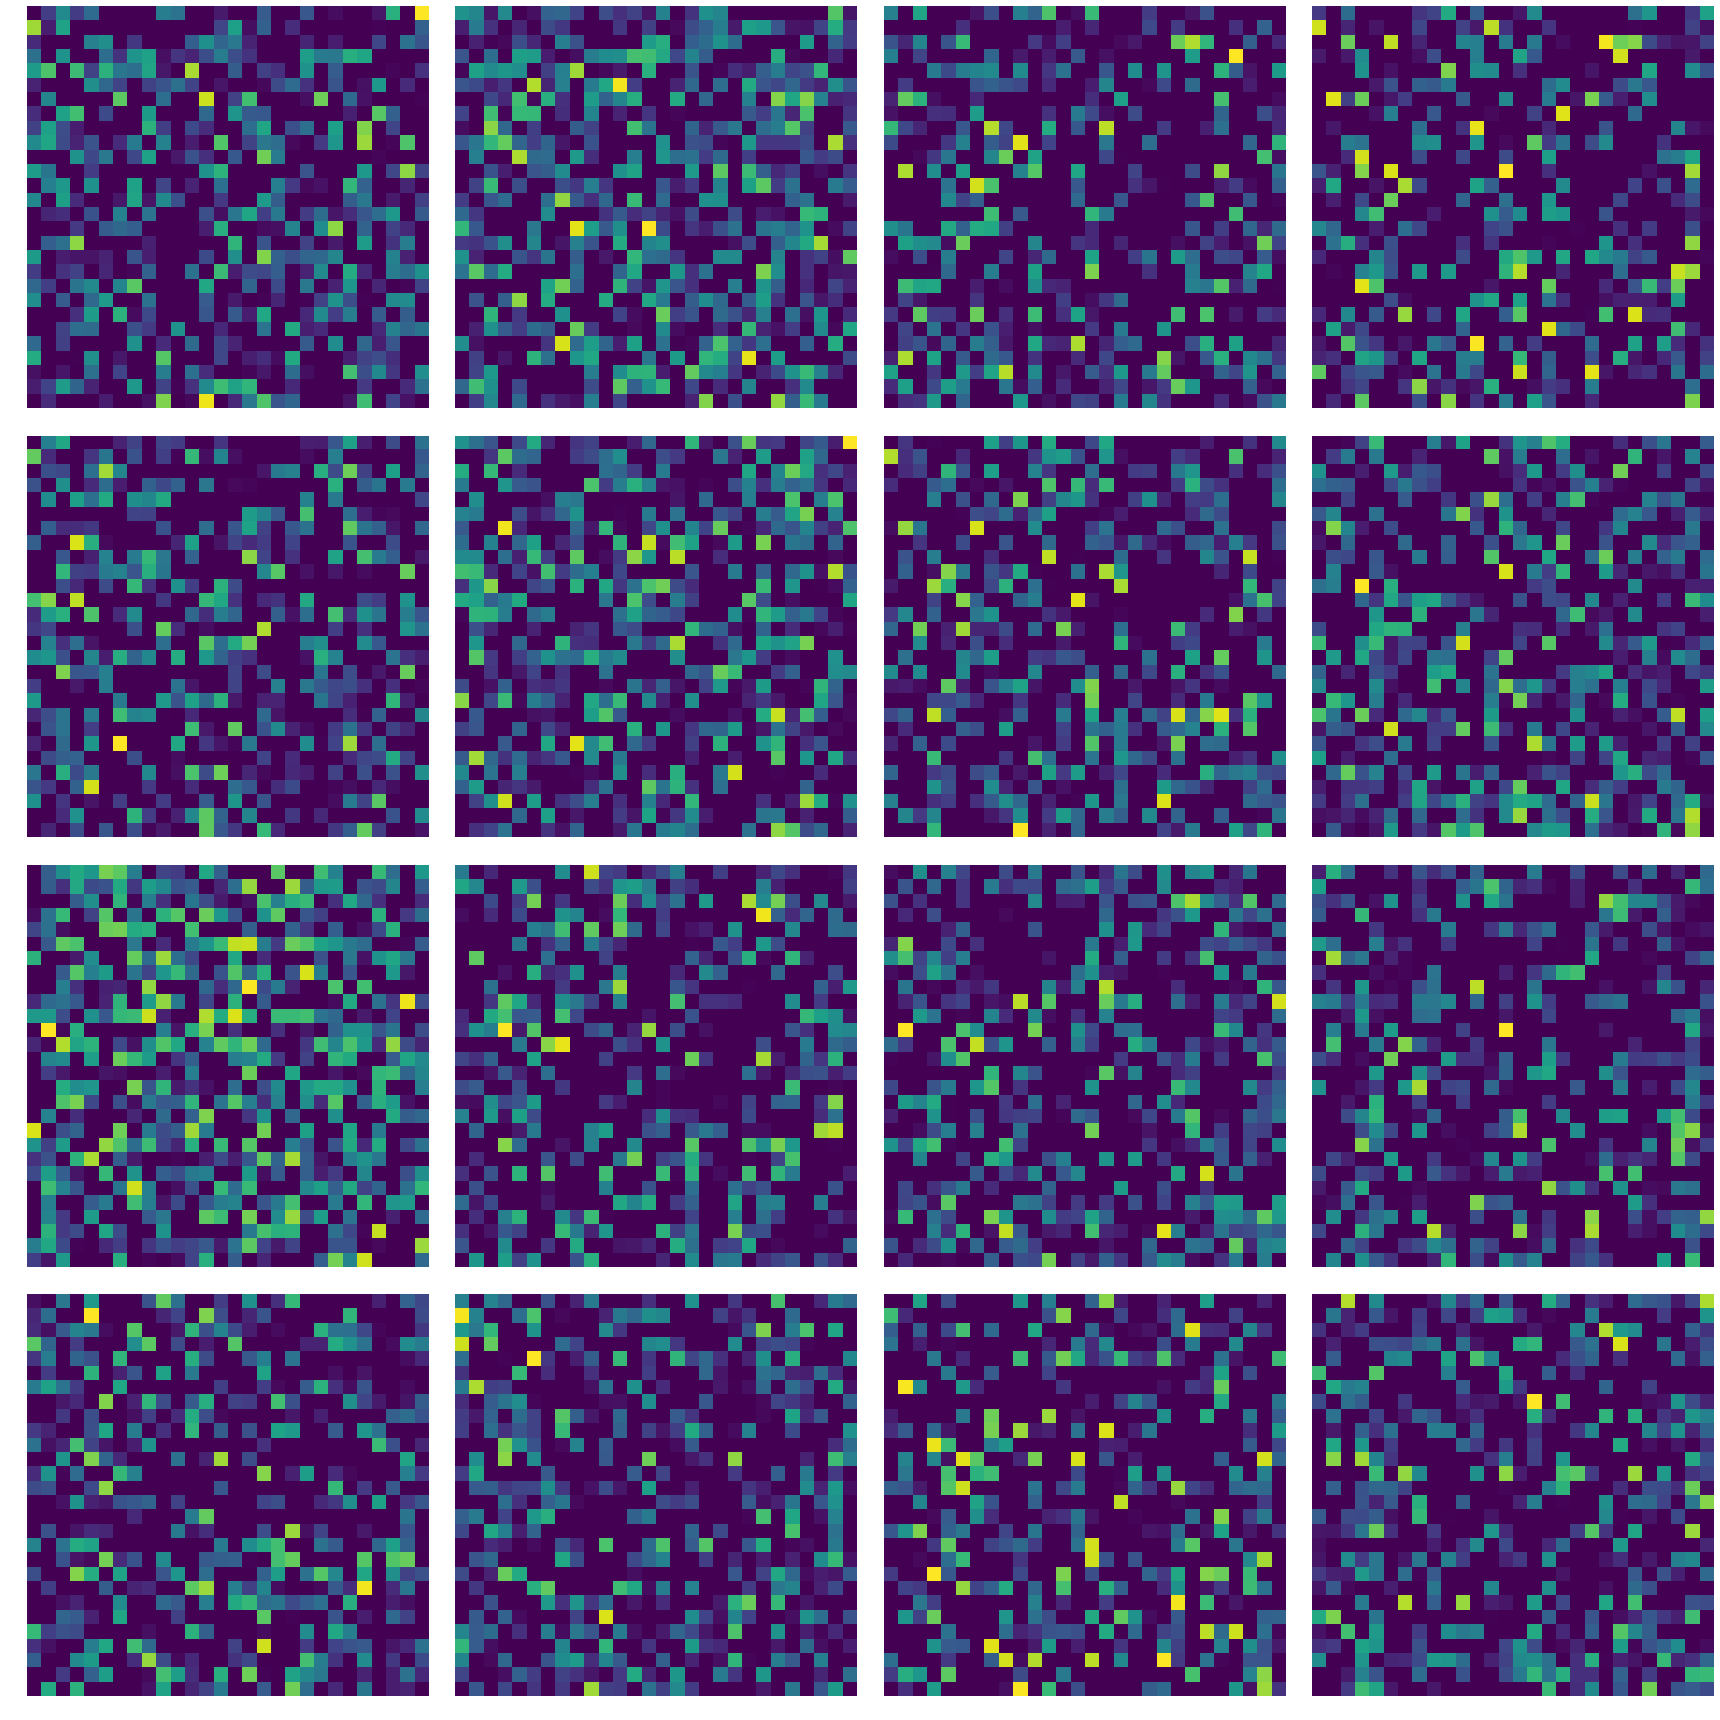

Epoch 7100, Generator loss 0.5758162140846252, discriminator loss 0.0012641132343560457


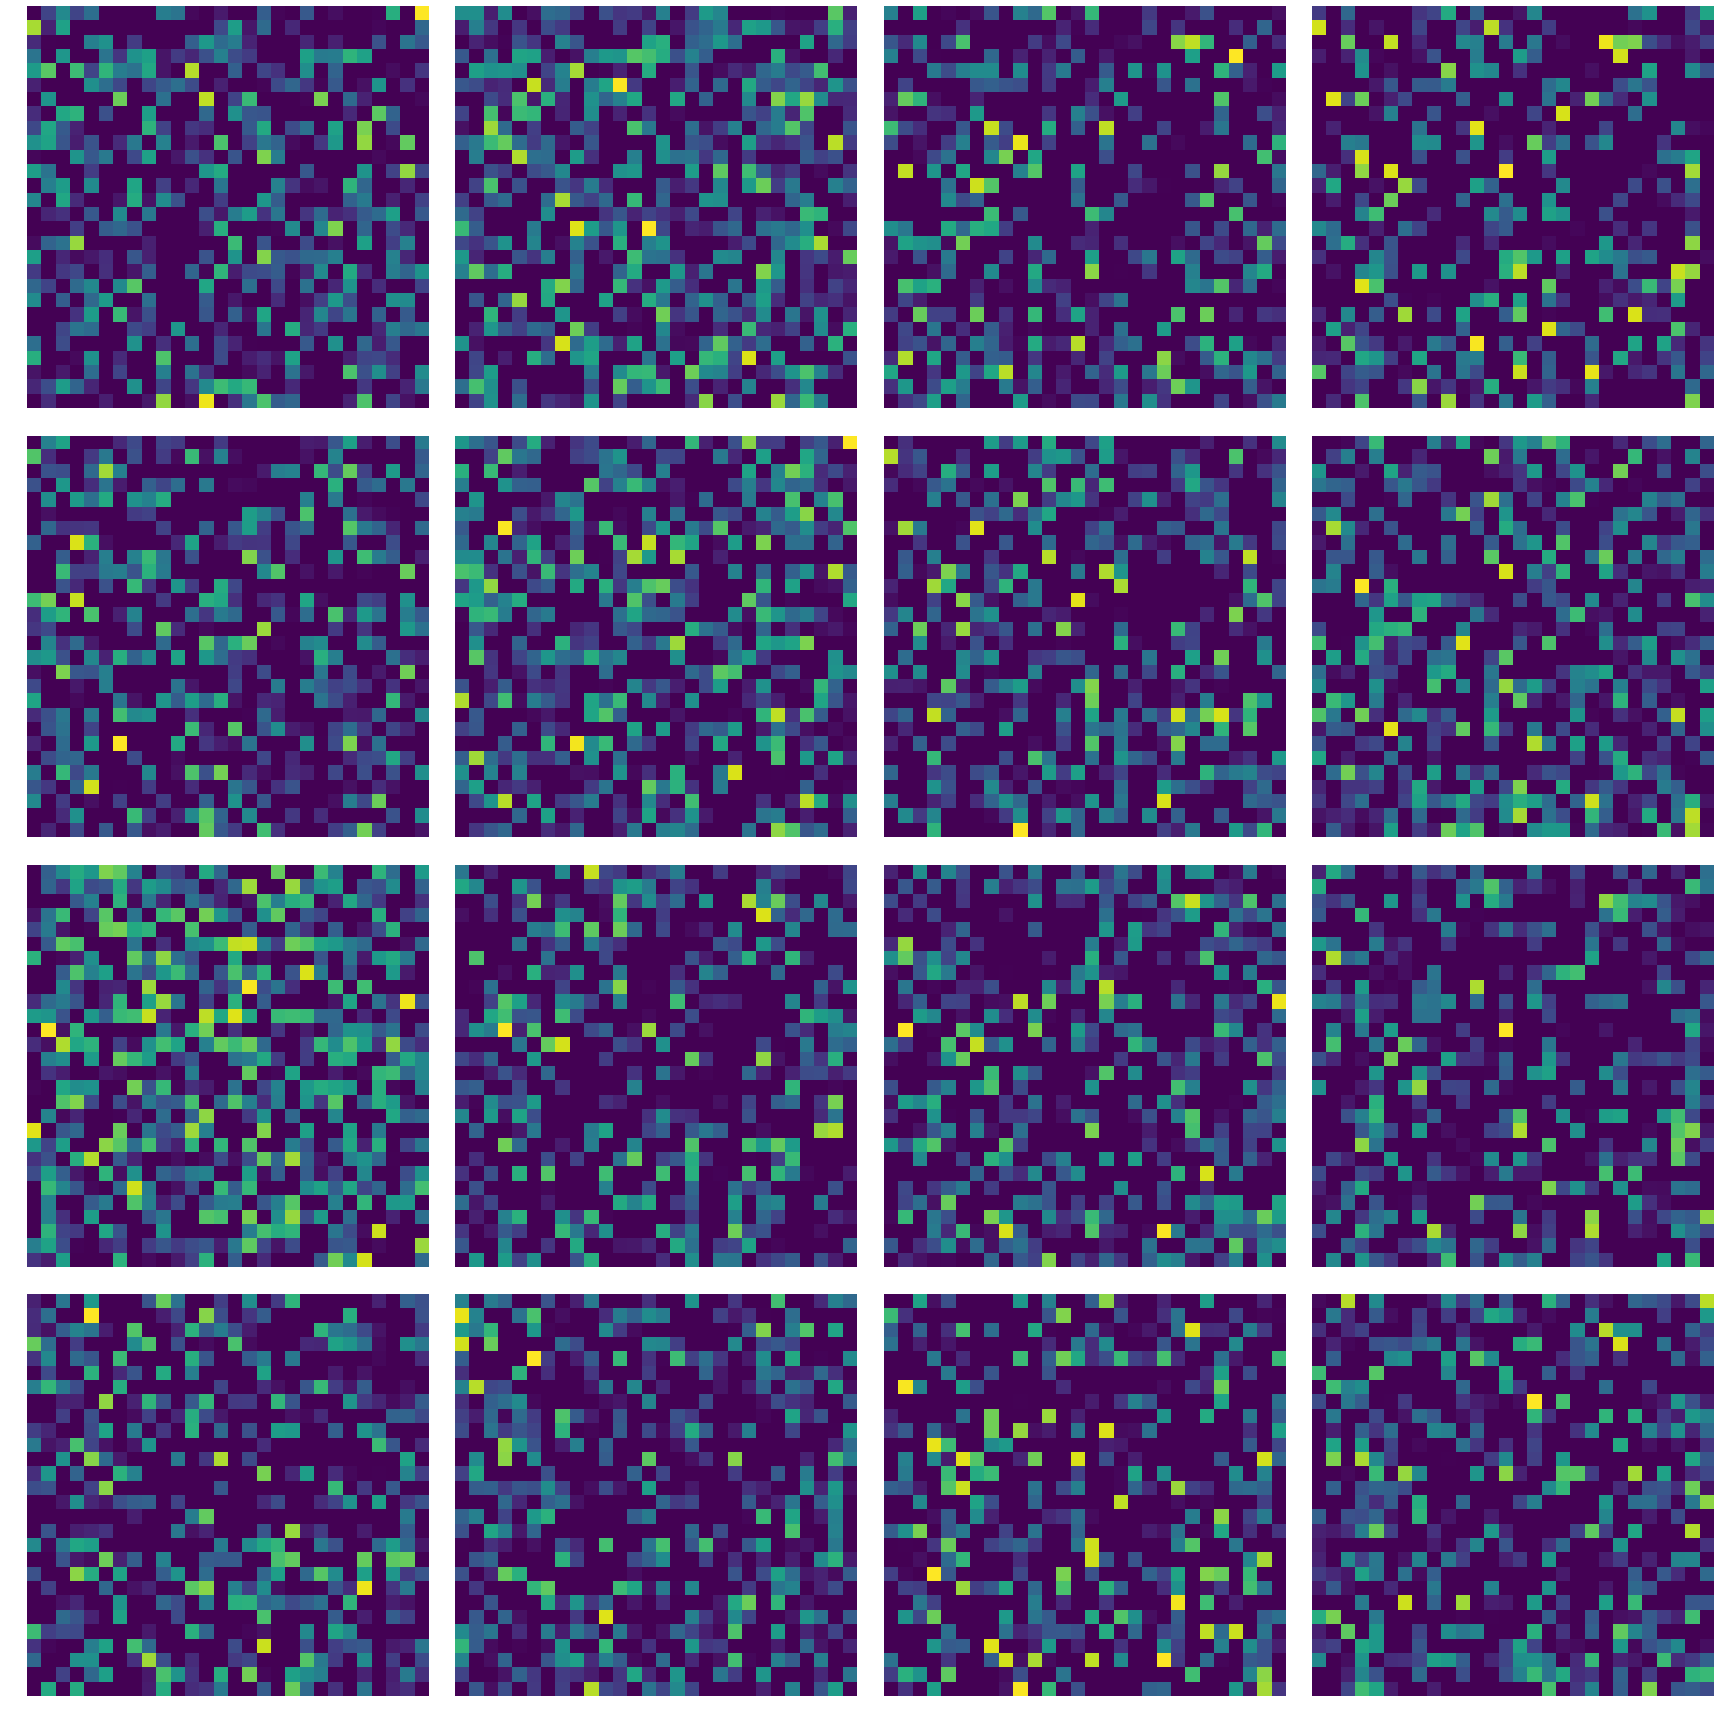

Epoch 7200, Generator loss 0.5865910053253174, discriminator loss 0.0012389180483296514


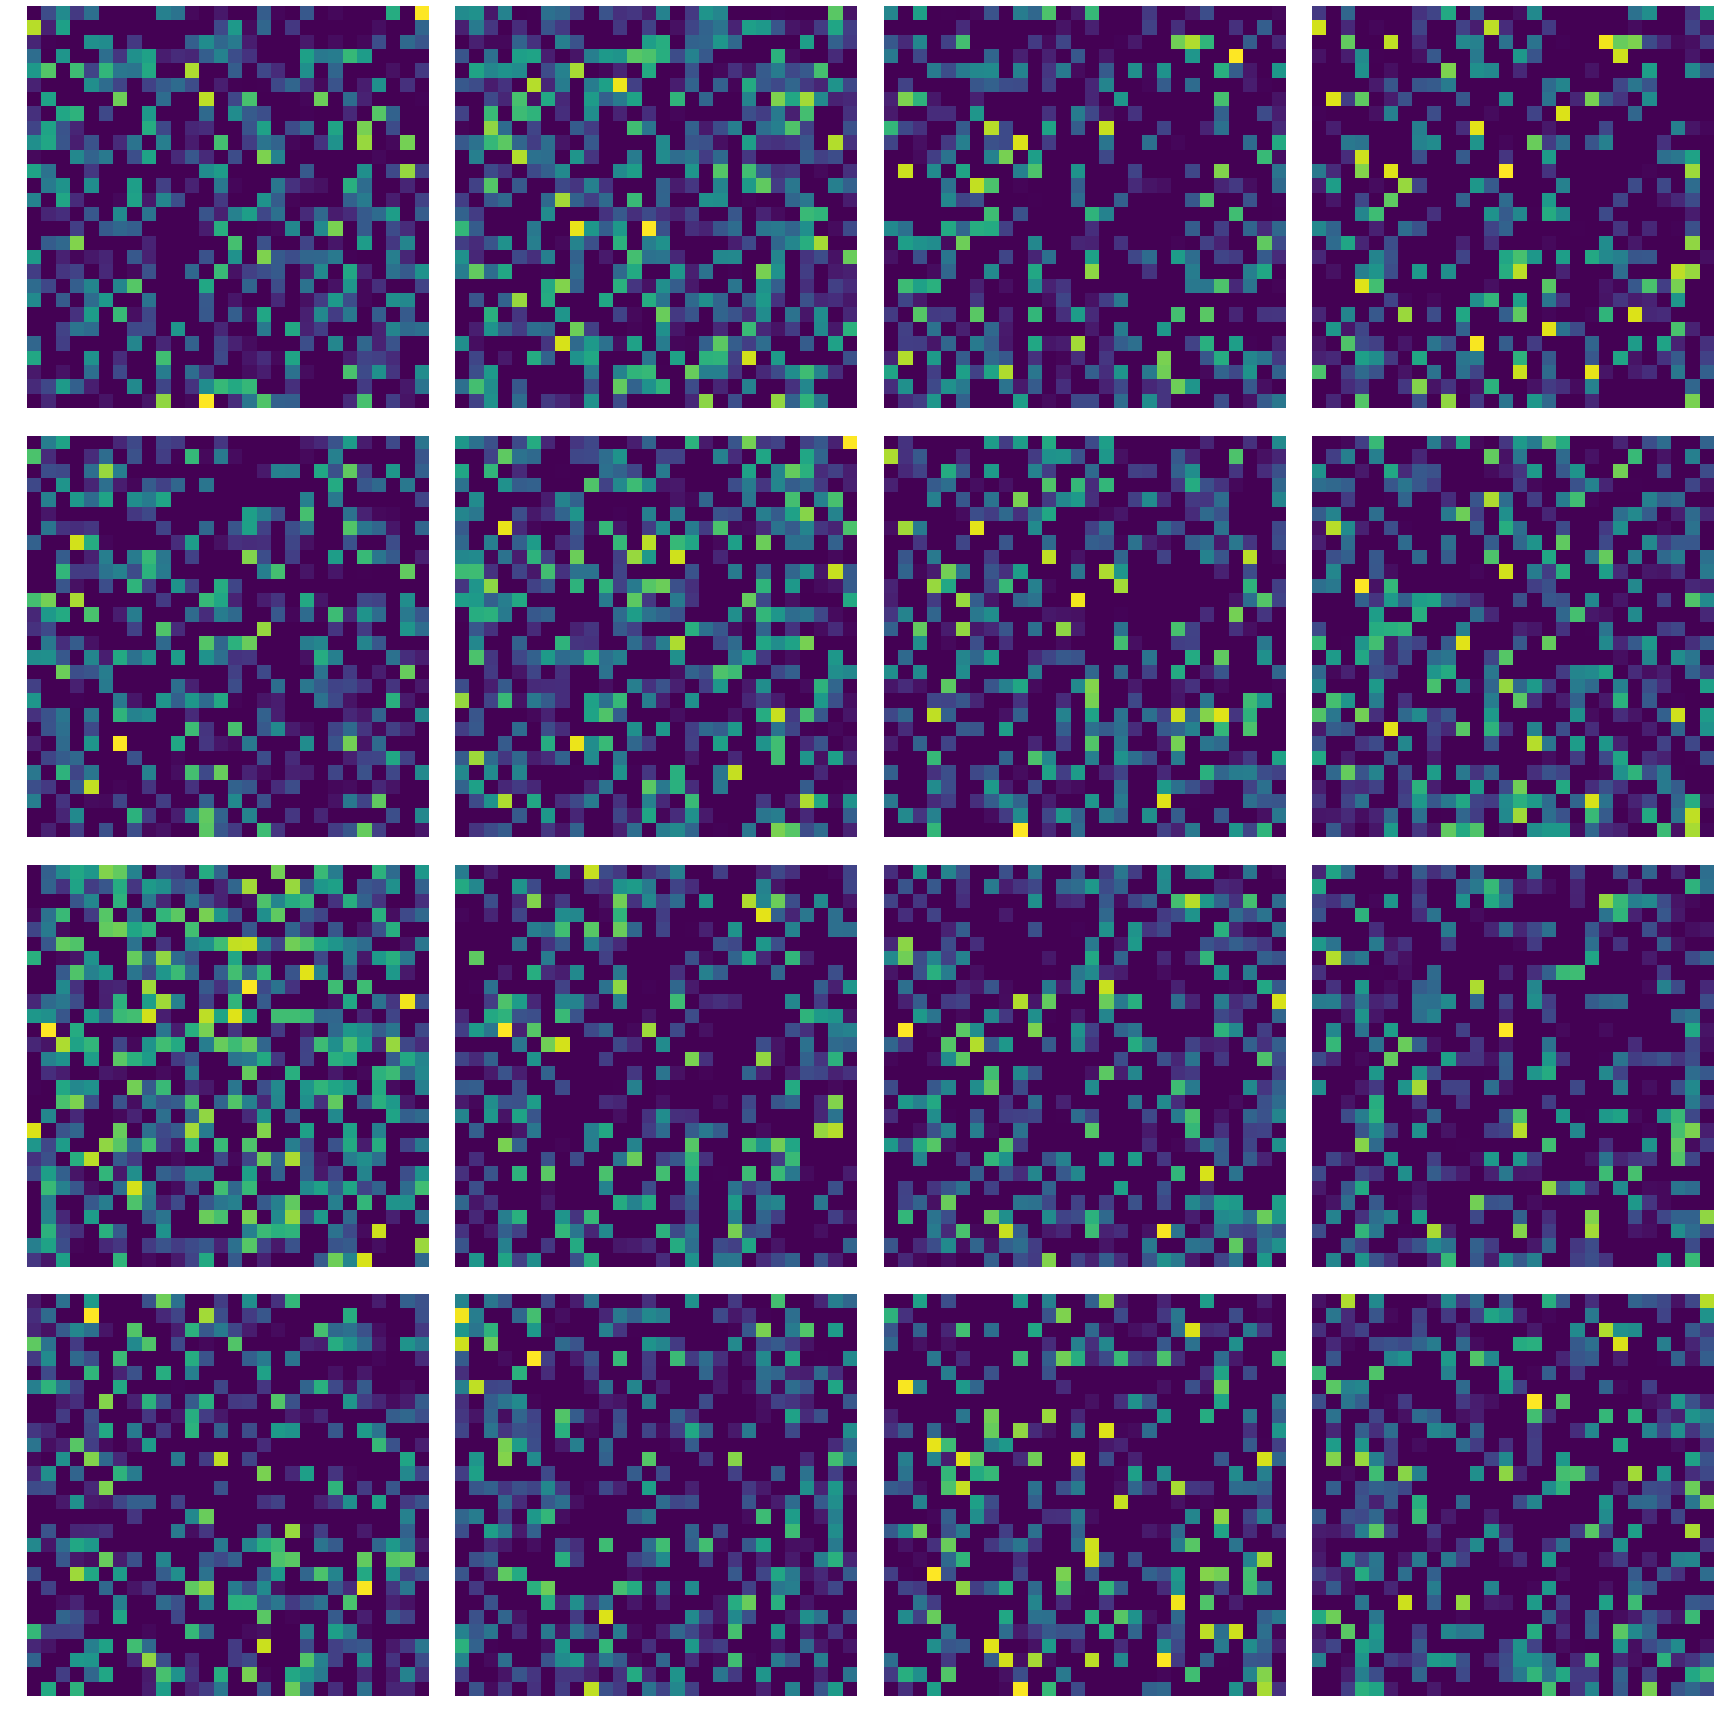

Epoch 7300, Generator loss 0.5714367032051086, discriminator loss 0.0012166575761511922


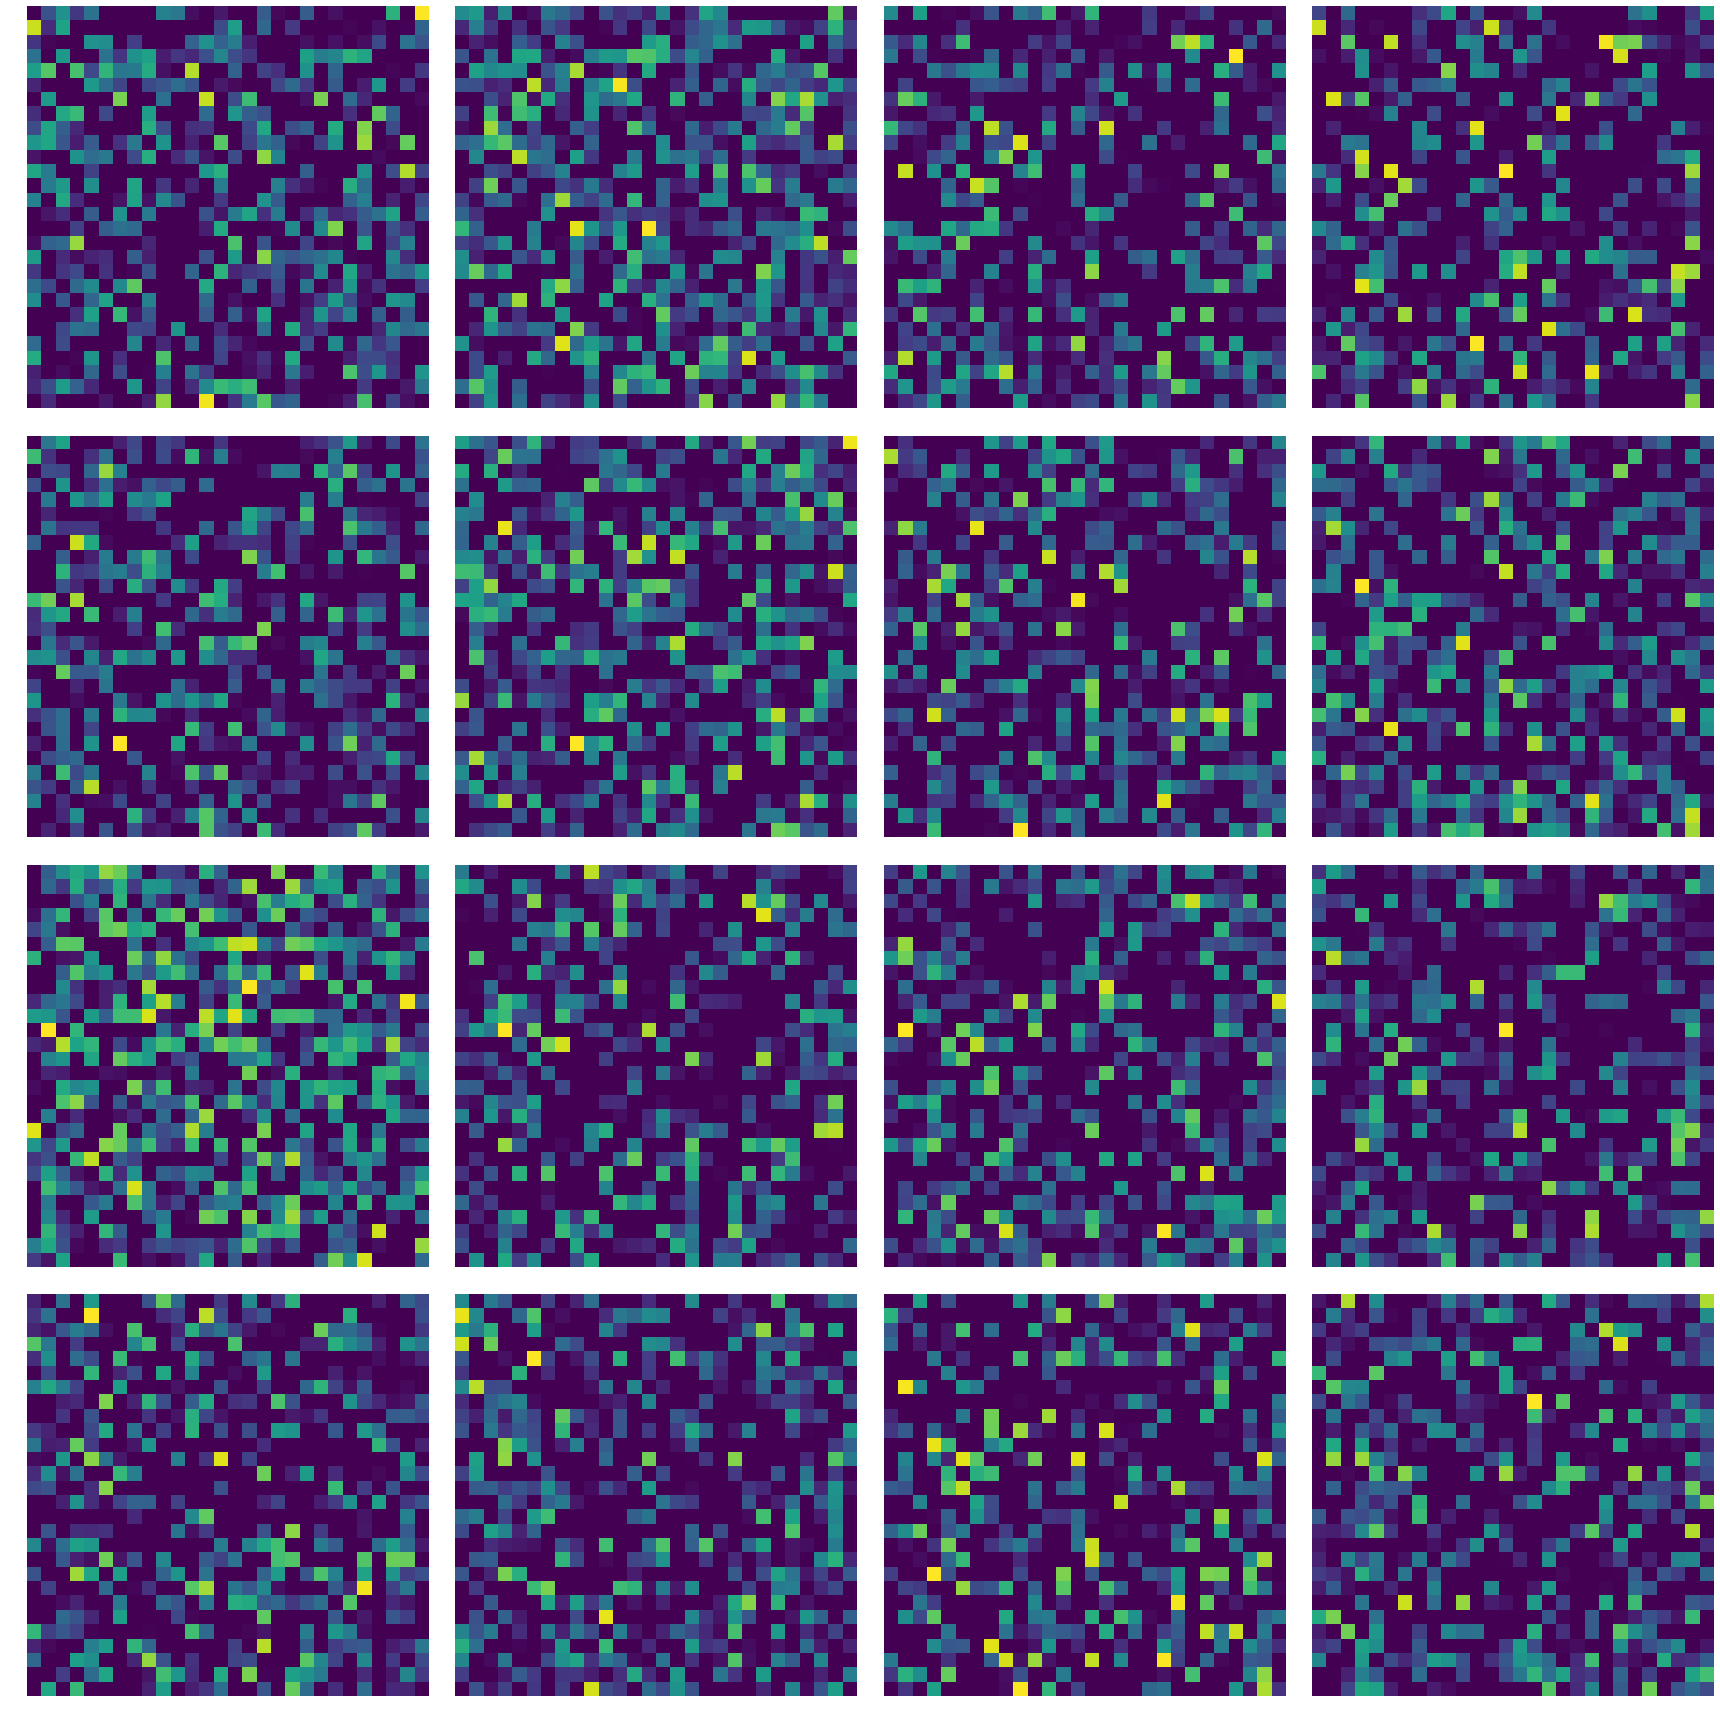

Epoch 7400, Generator loss 0.558535099029541, discriminator loss 0.0011947632301598787


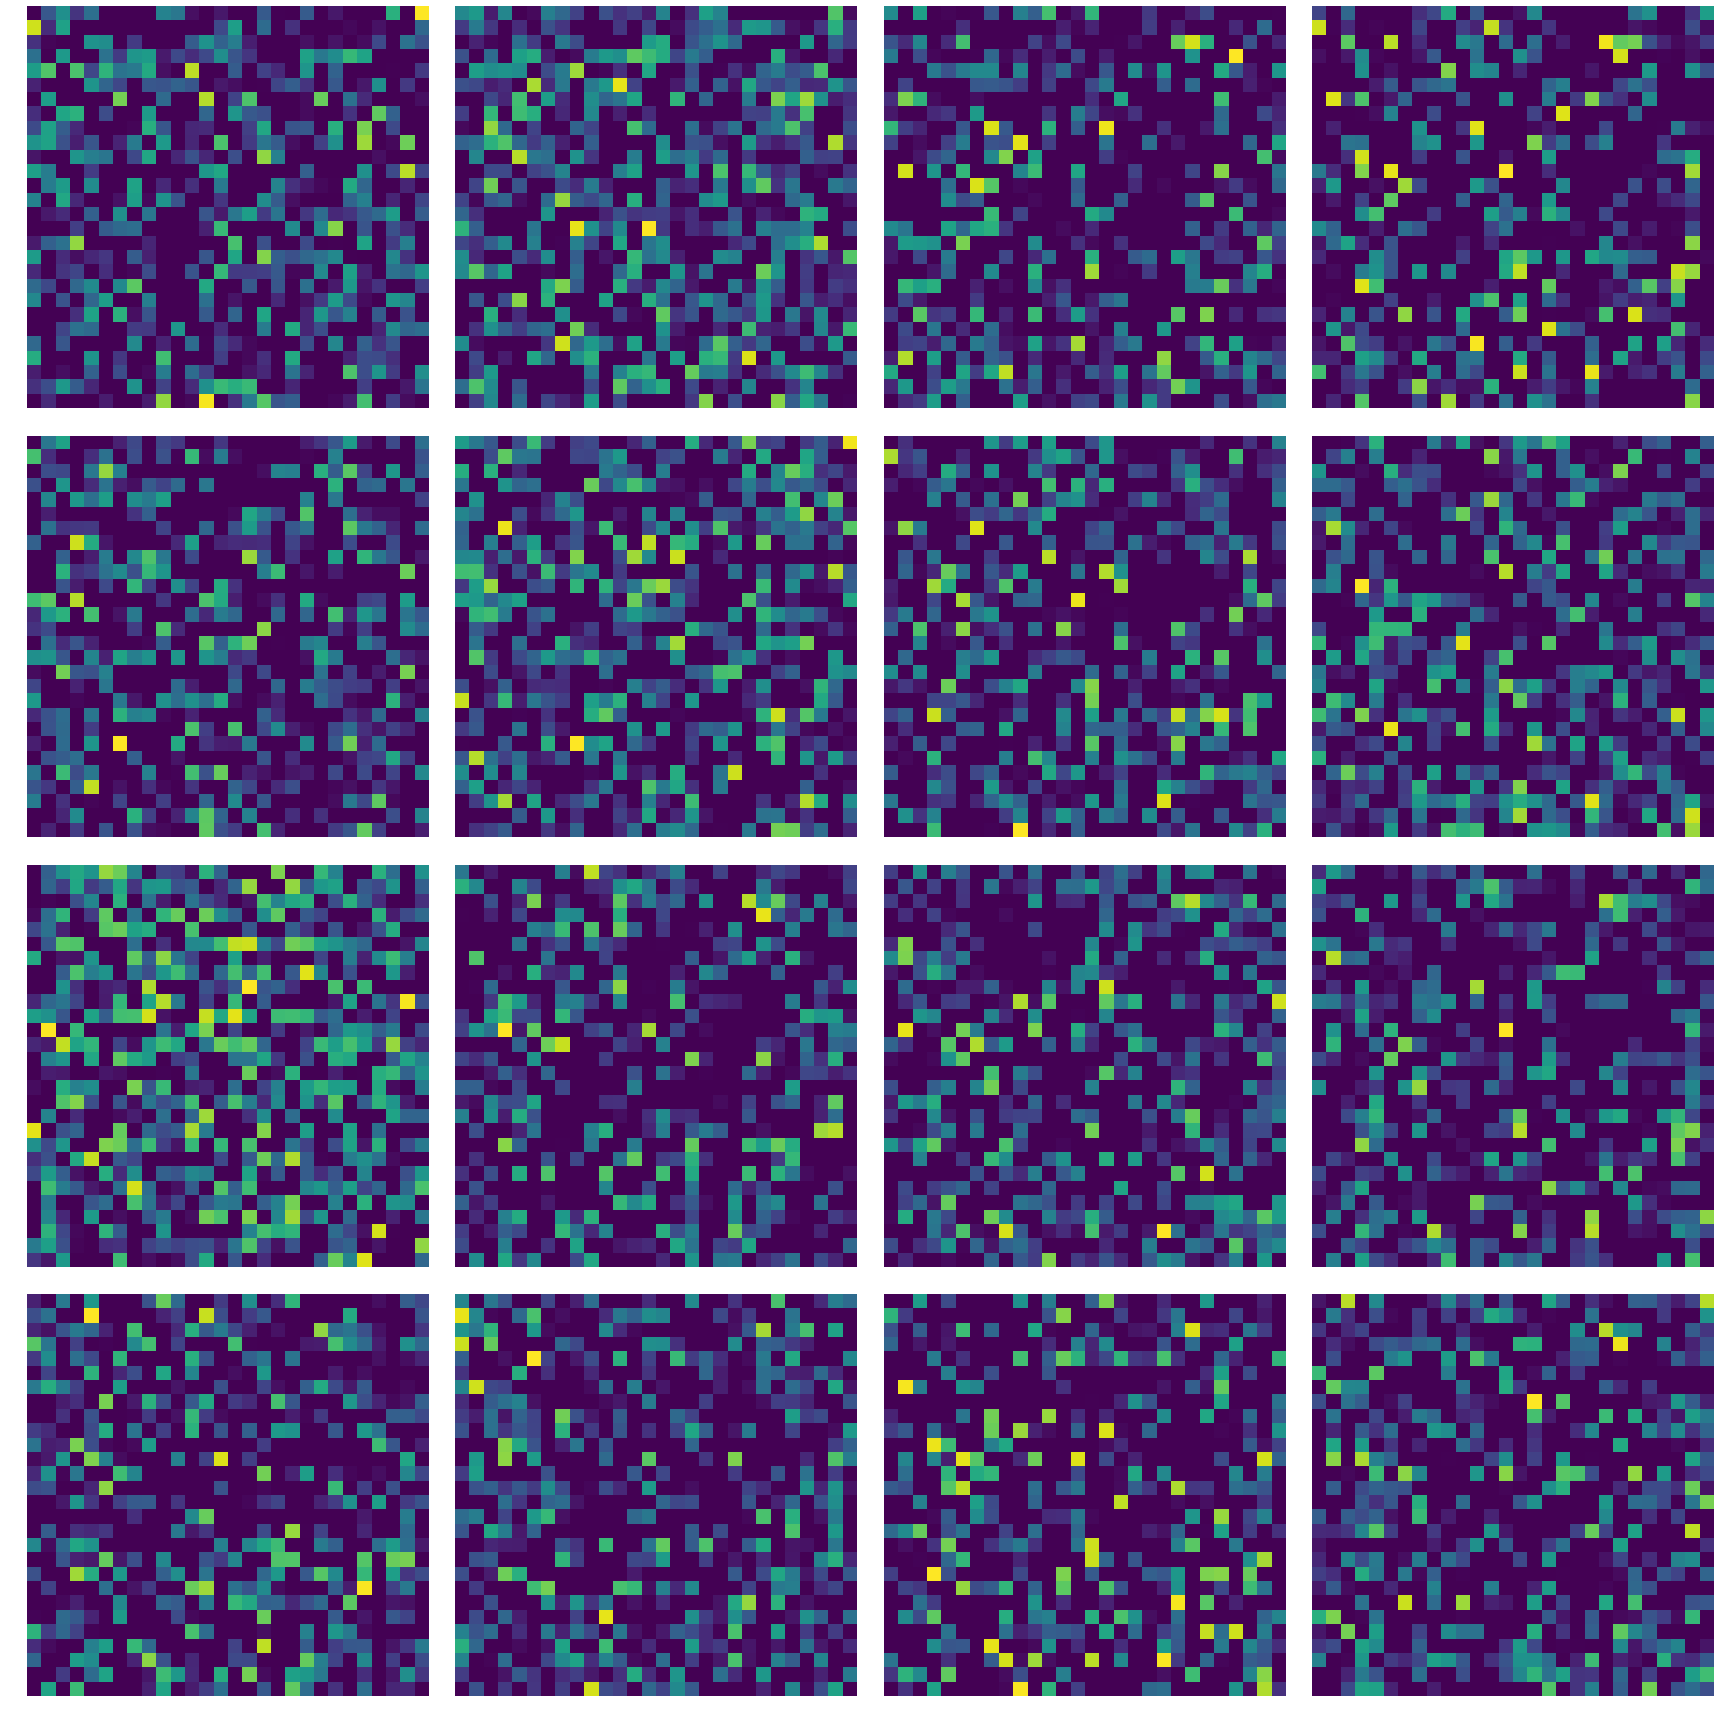

Epoch 7500, Generator loss 0.5573731064796448, discriminator loss 0.0011730564292520285


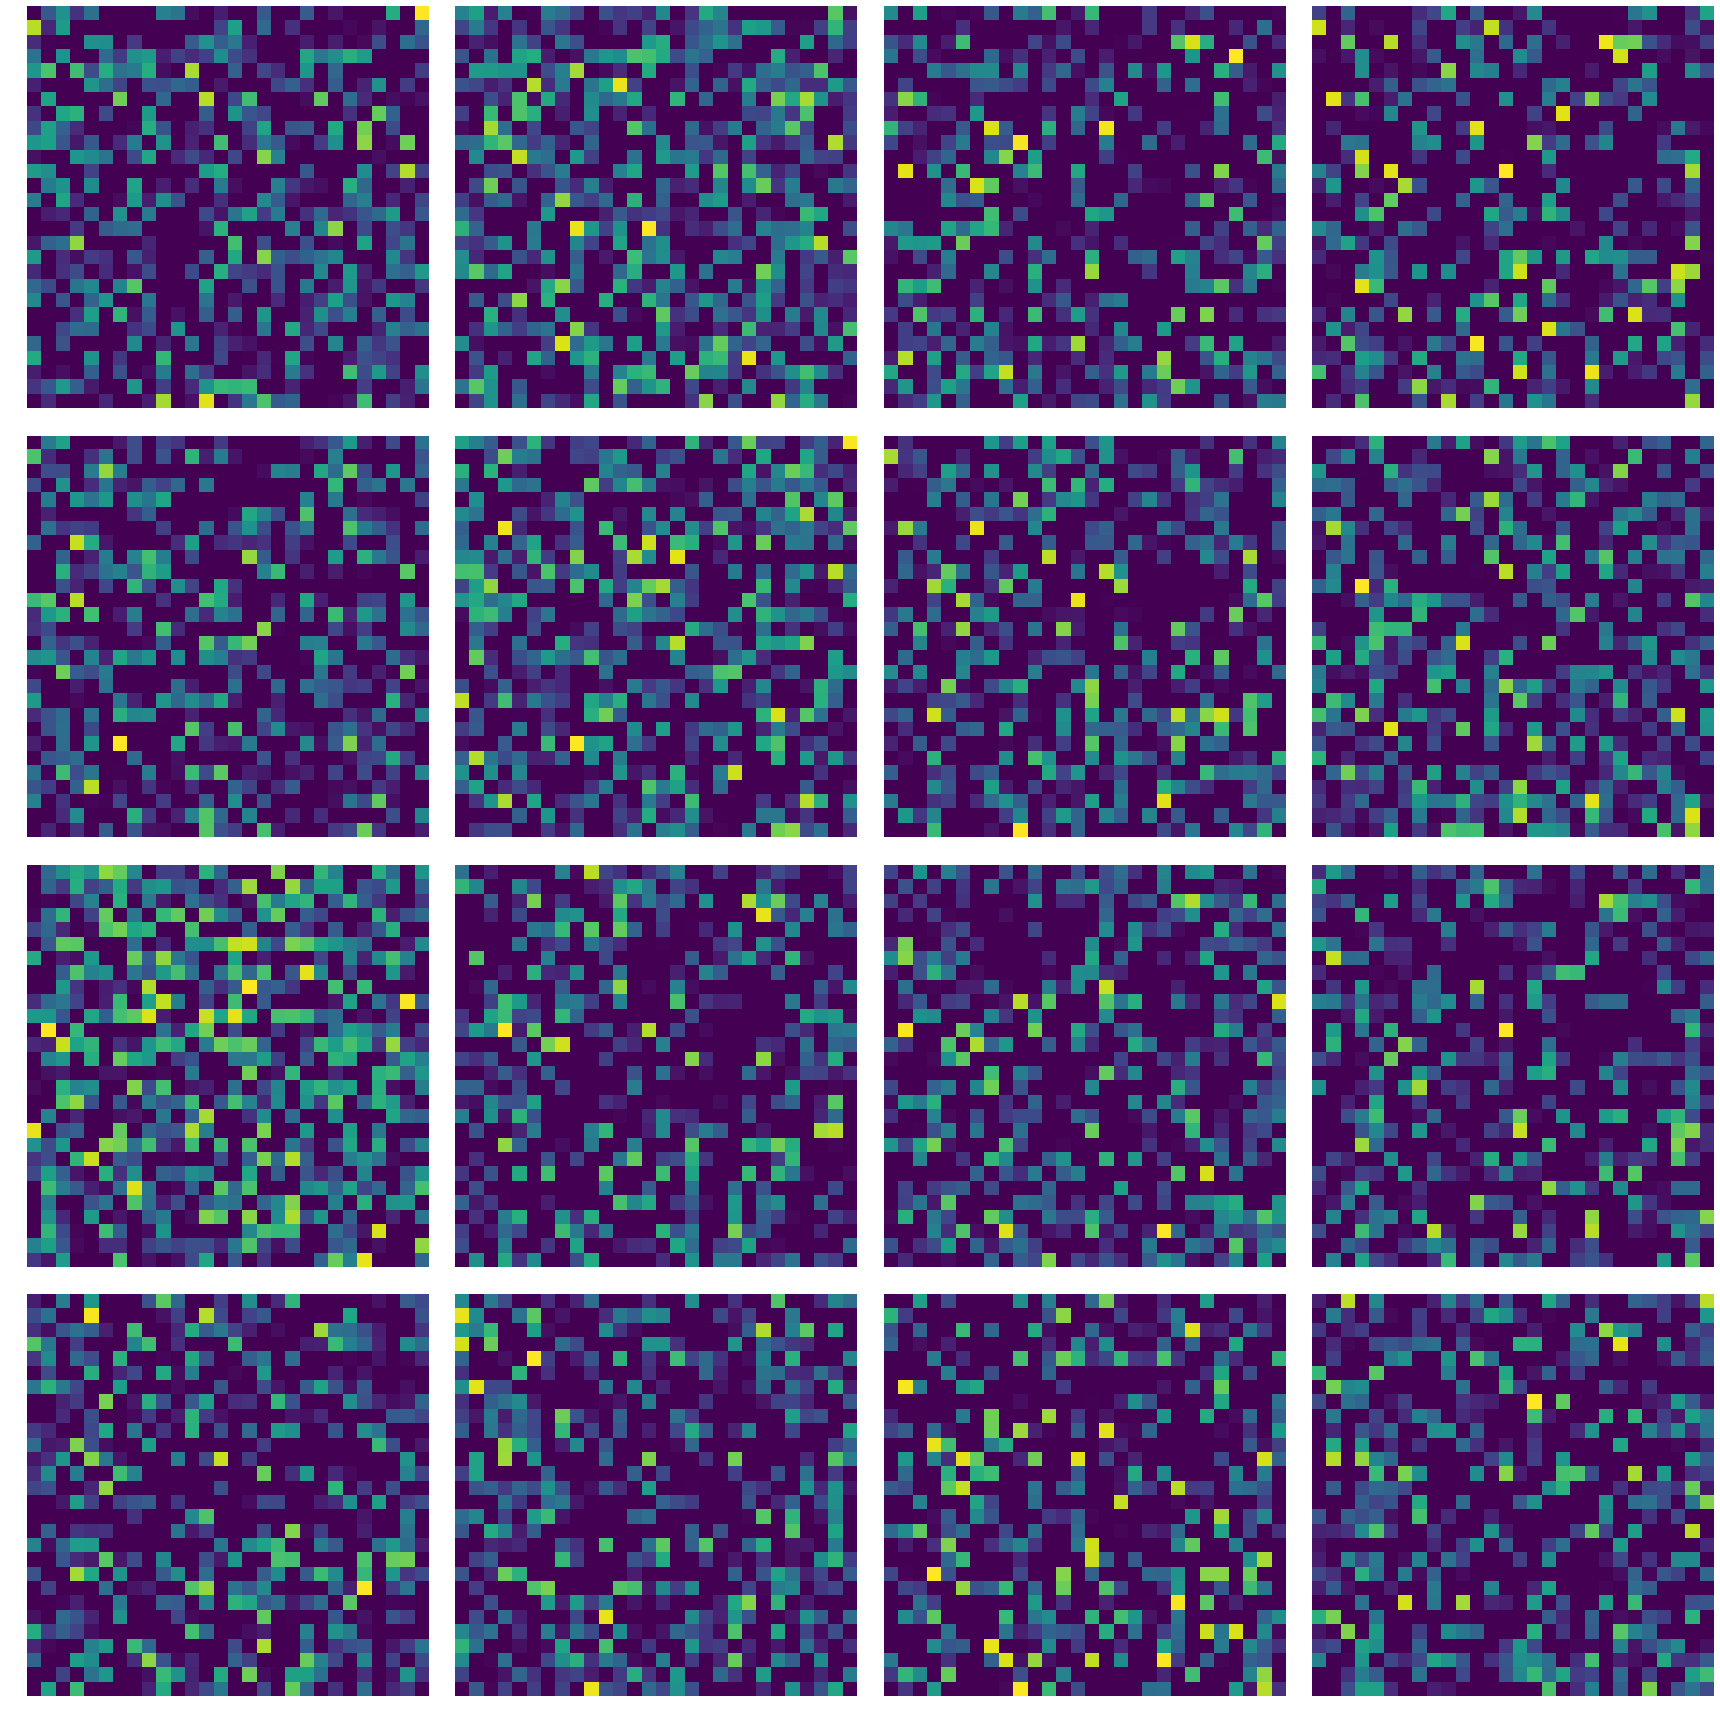

Epoch 7600, Generator loss 0.5668358206748962, discriminator loss 0.001152880140580237


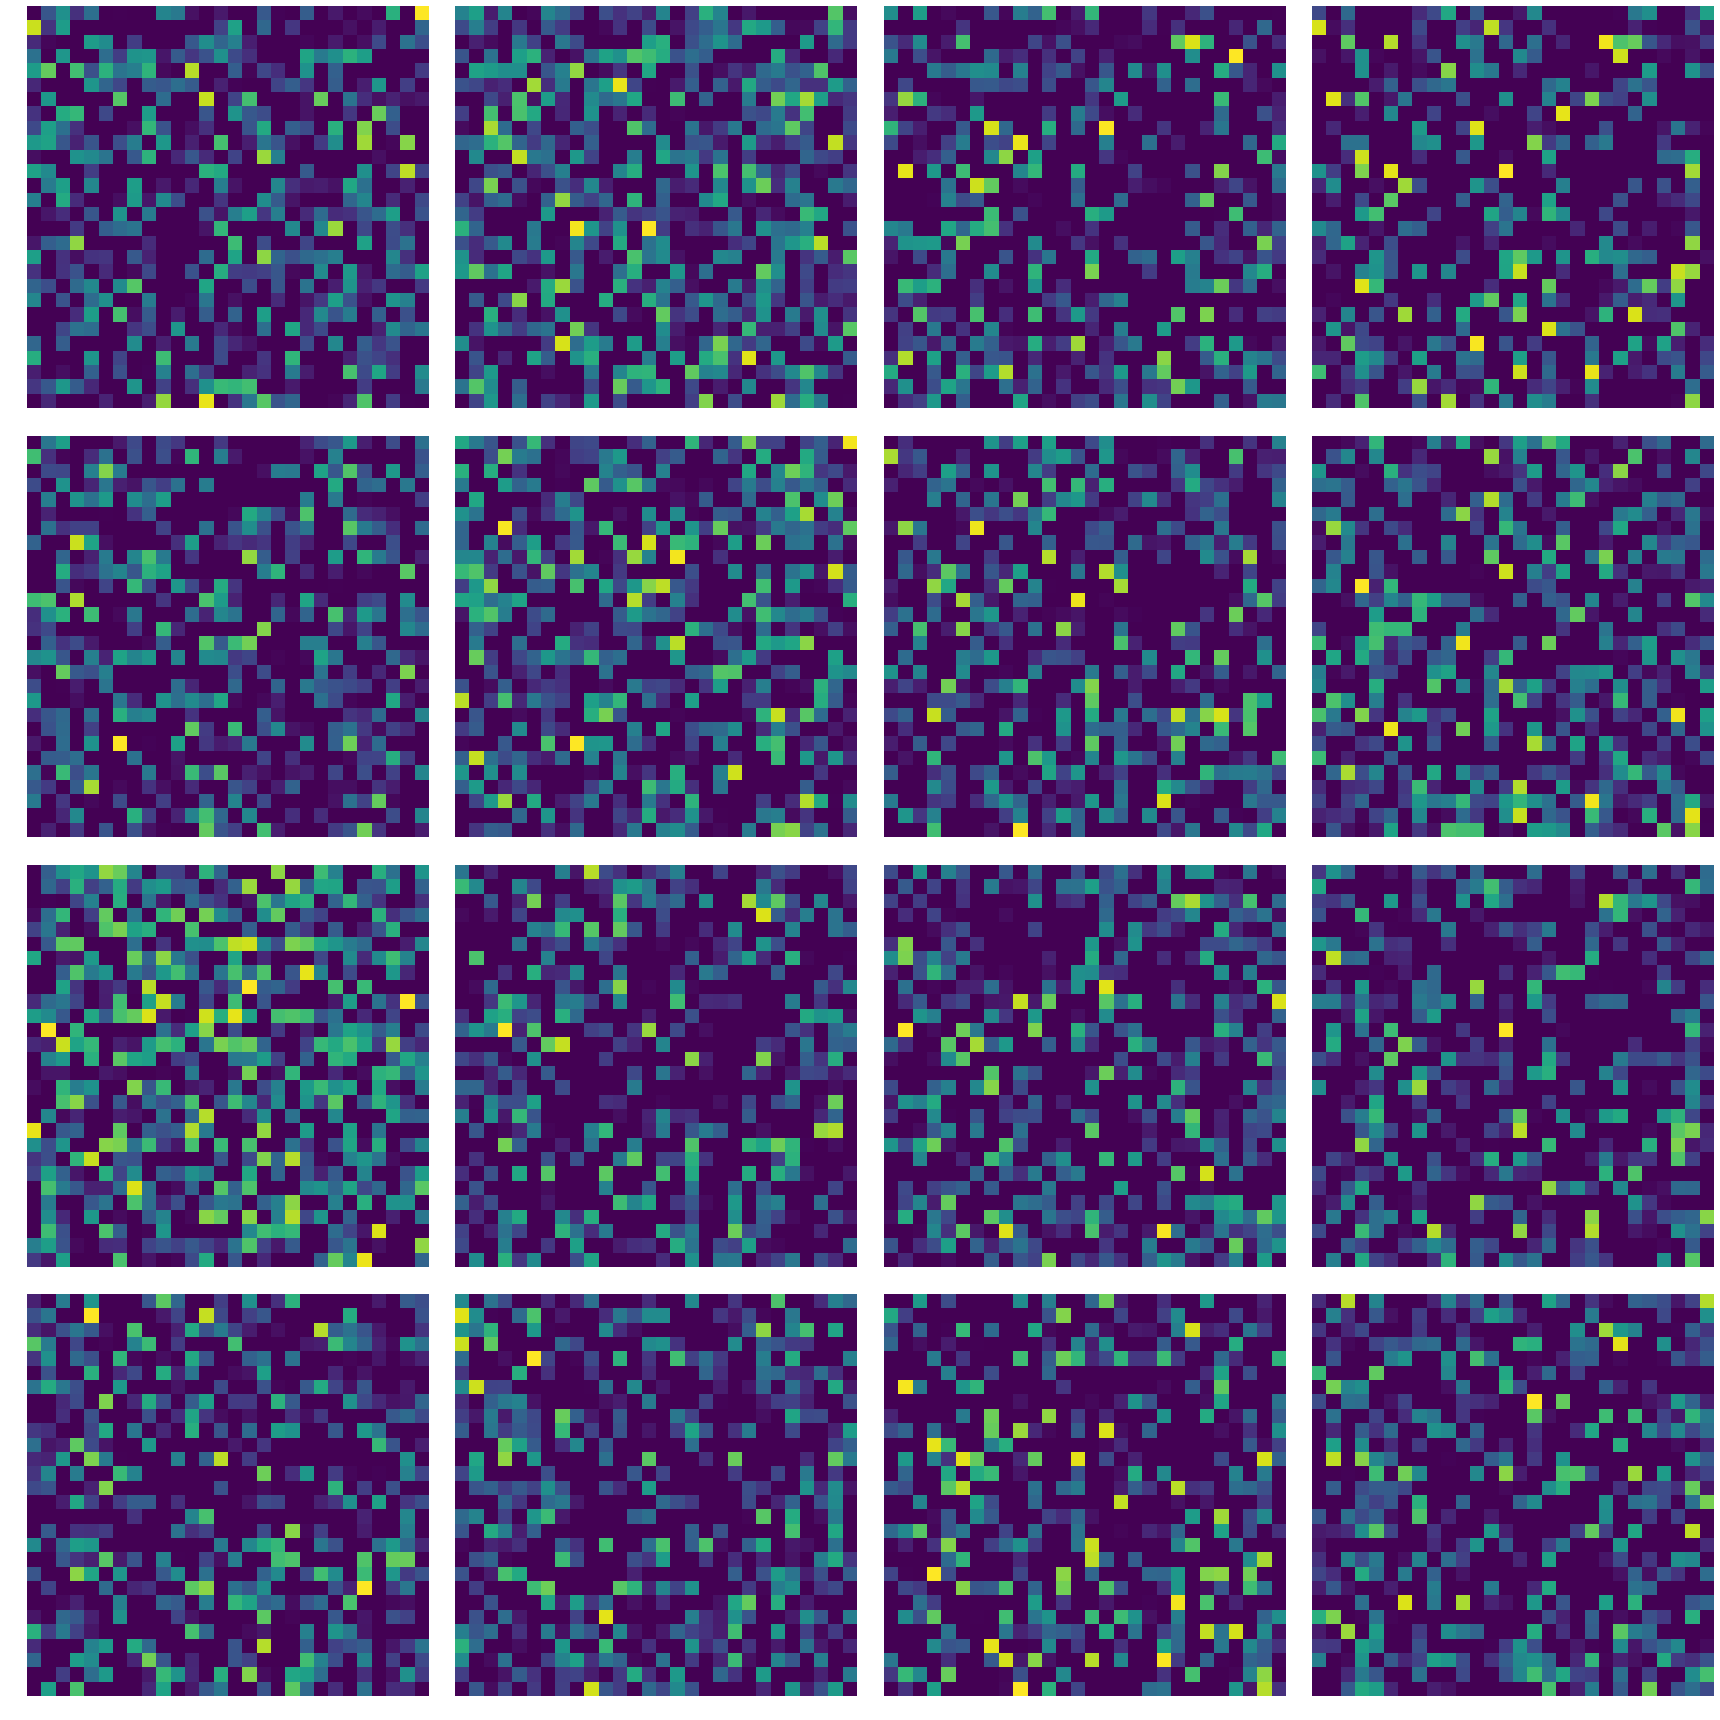

Epoch 7700, Generator loss 0.5650050640106201, discriminator loss 0.0011330887209624052


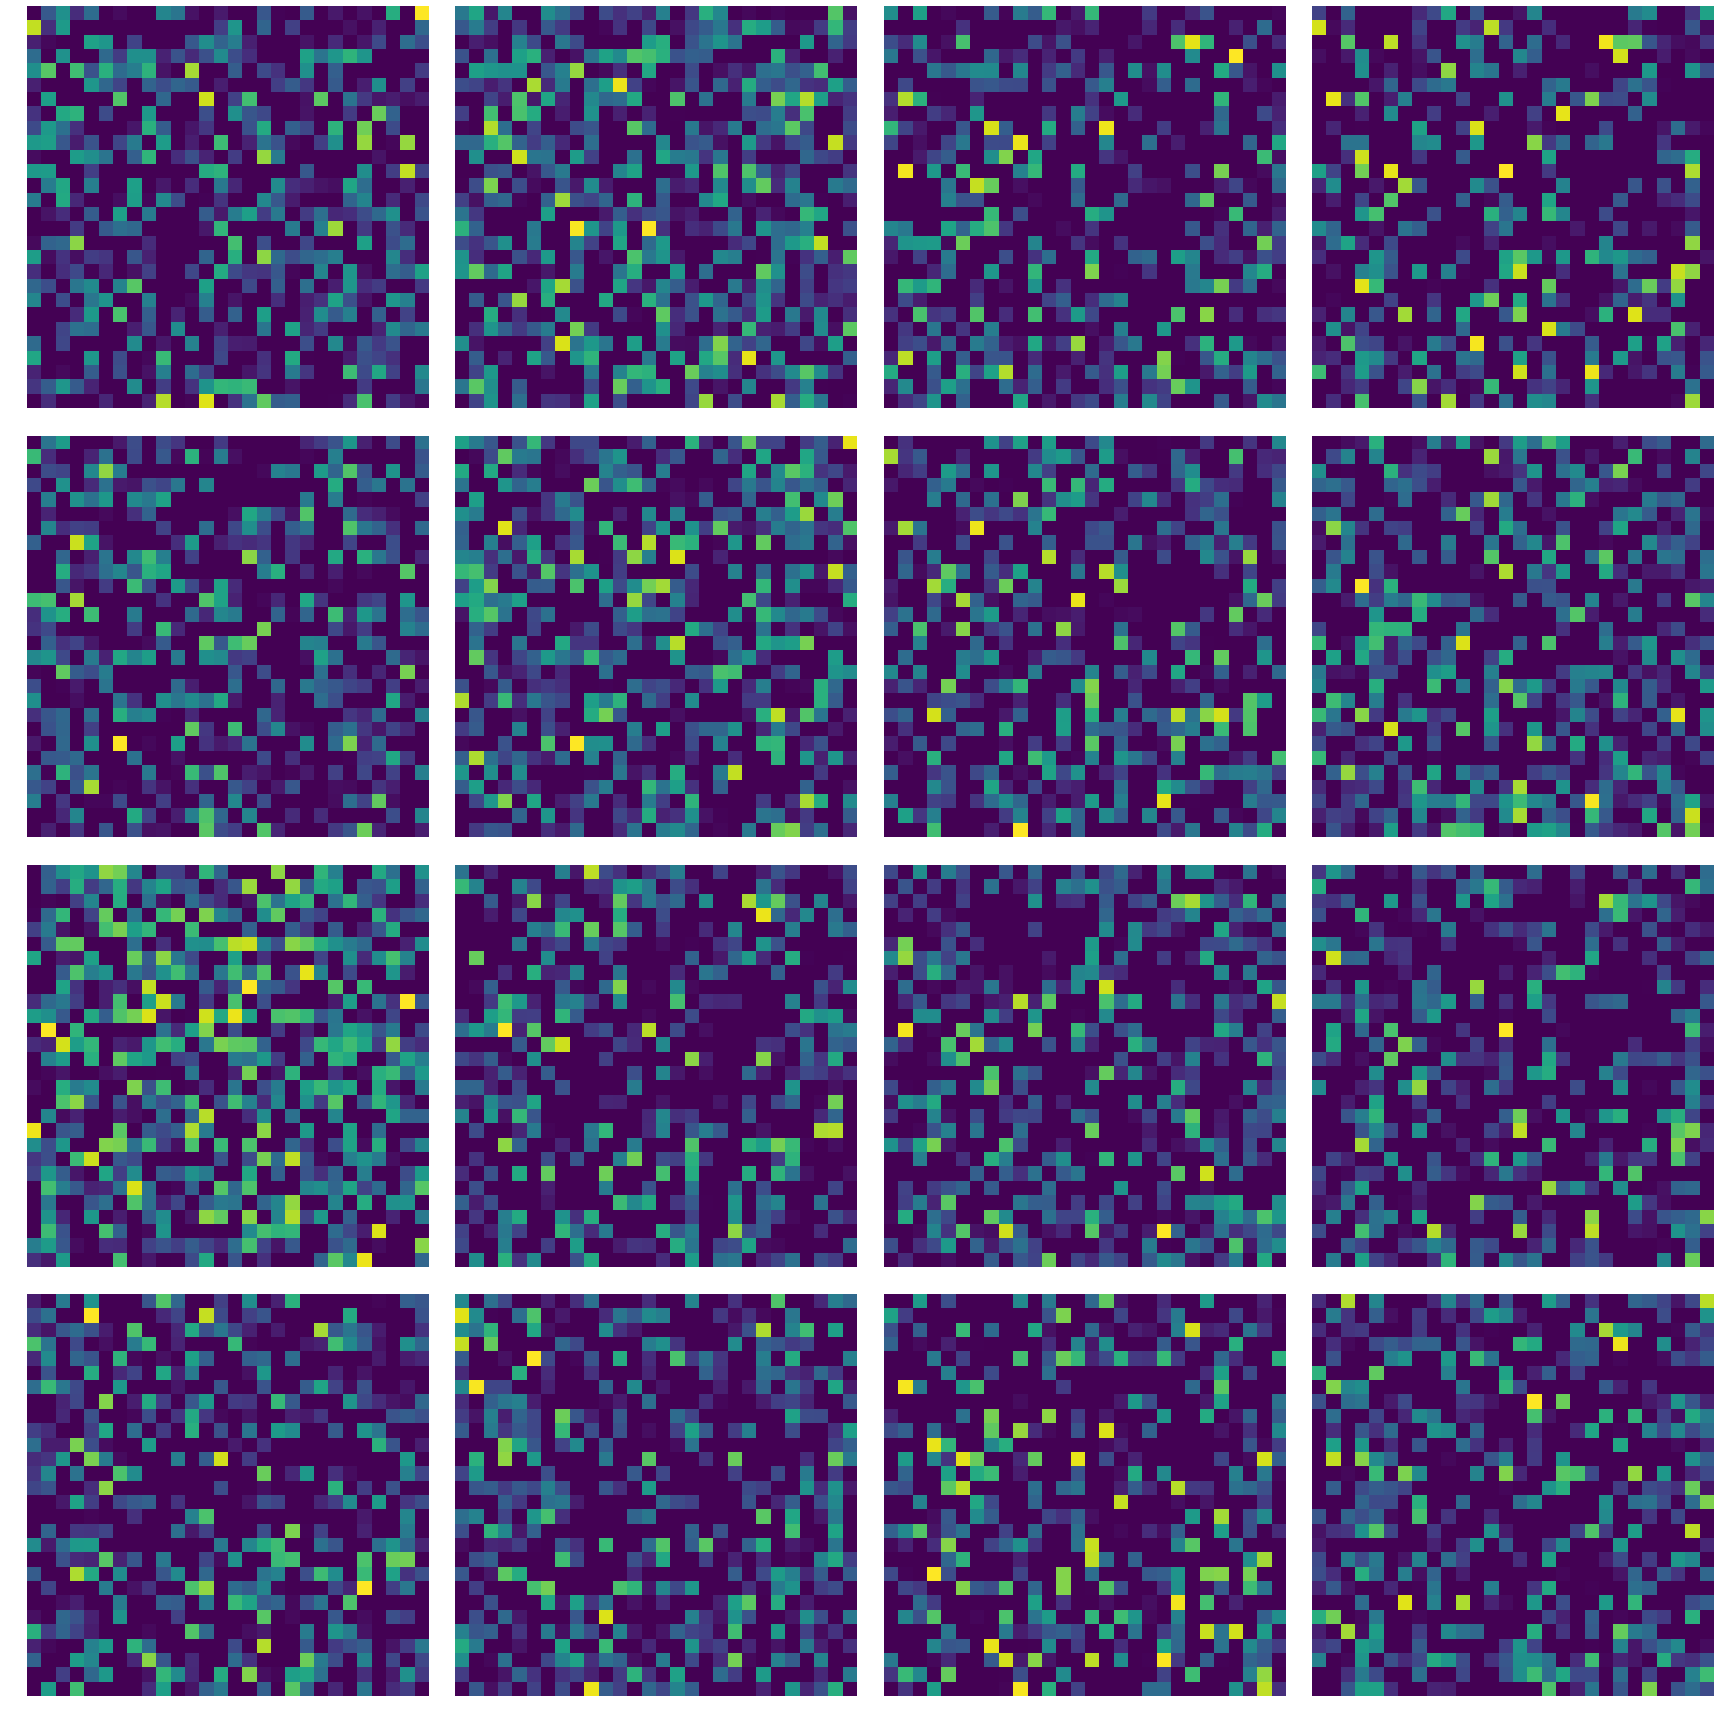

Epoch 7800, Generator loss 0.5609644651412964, discriminator loss 0.0011148074408993125


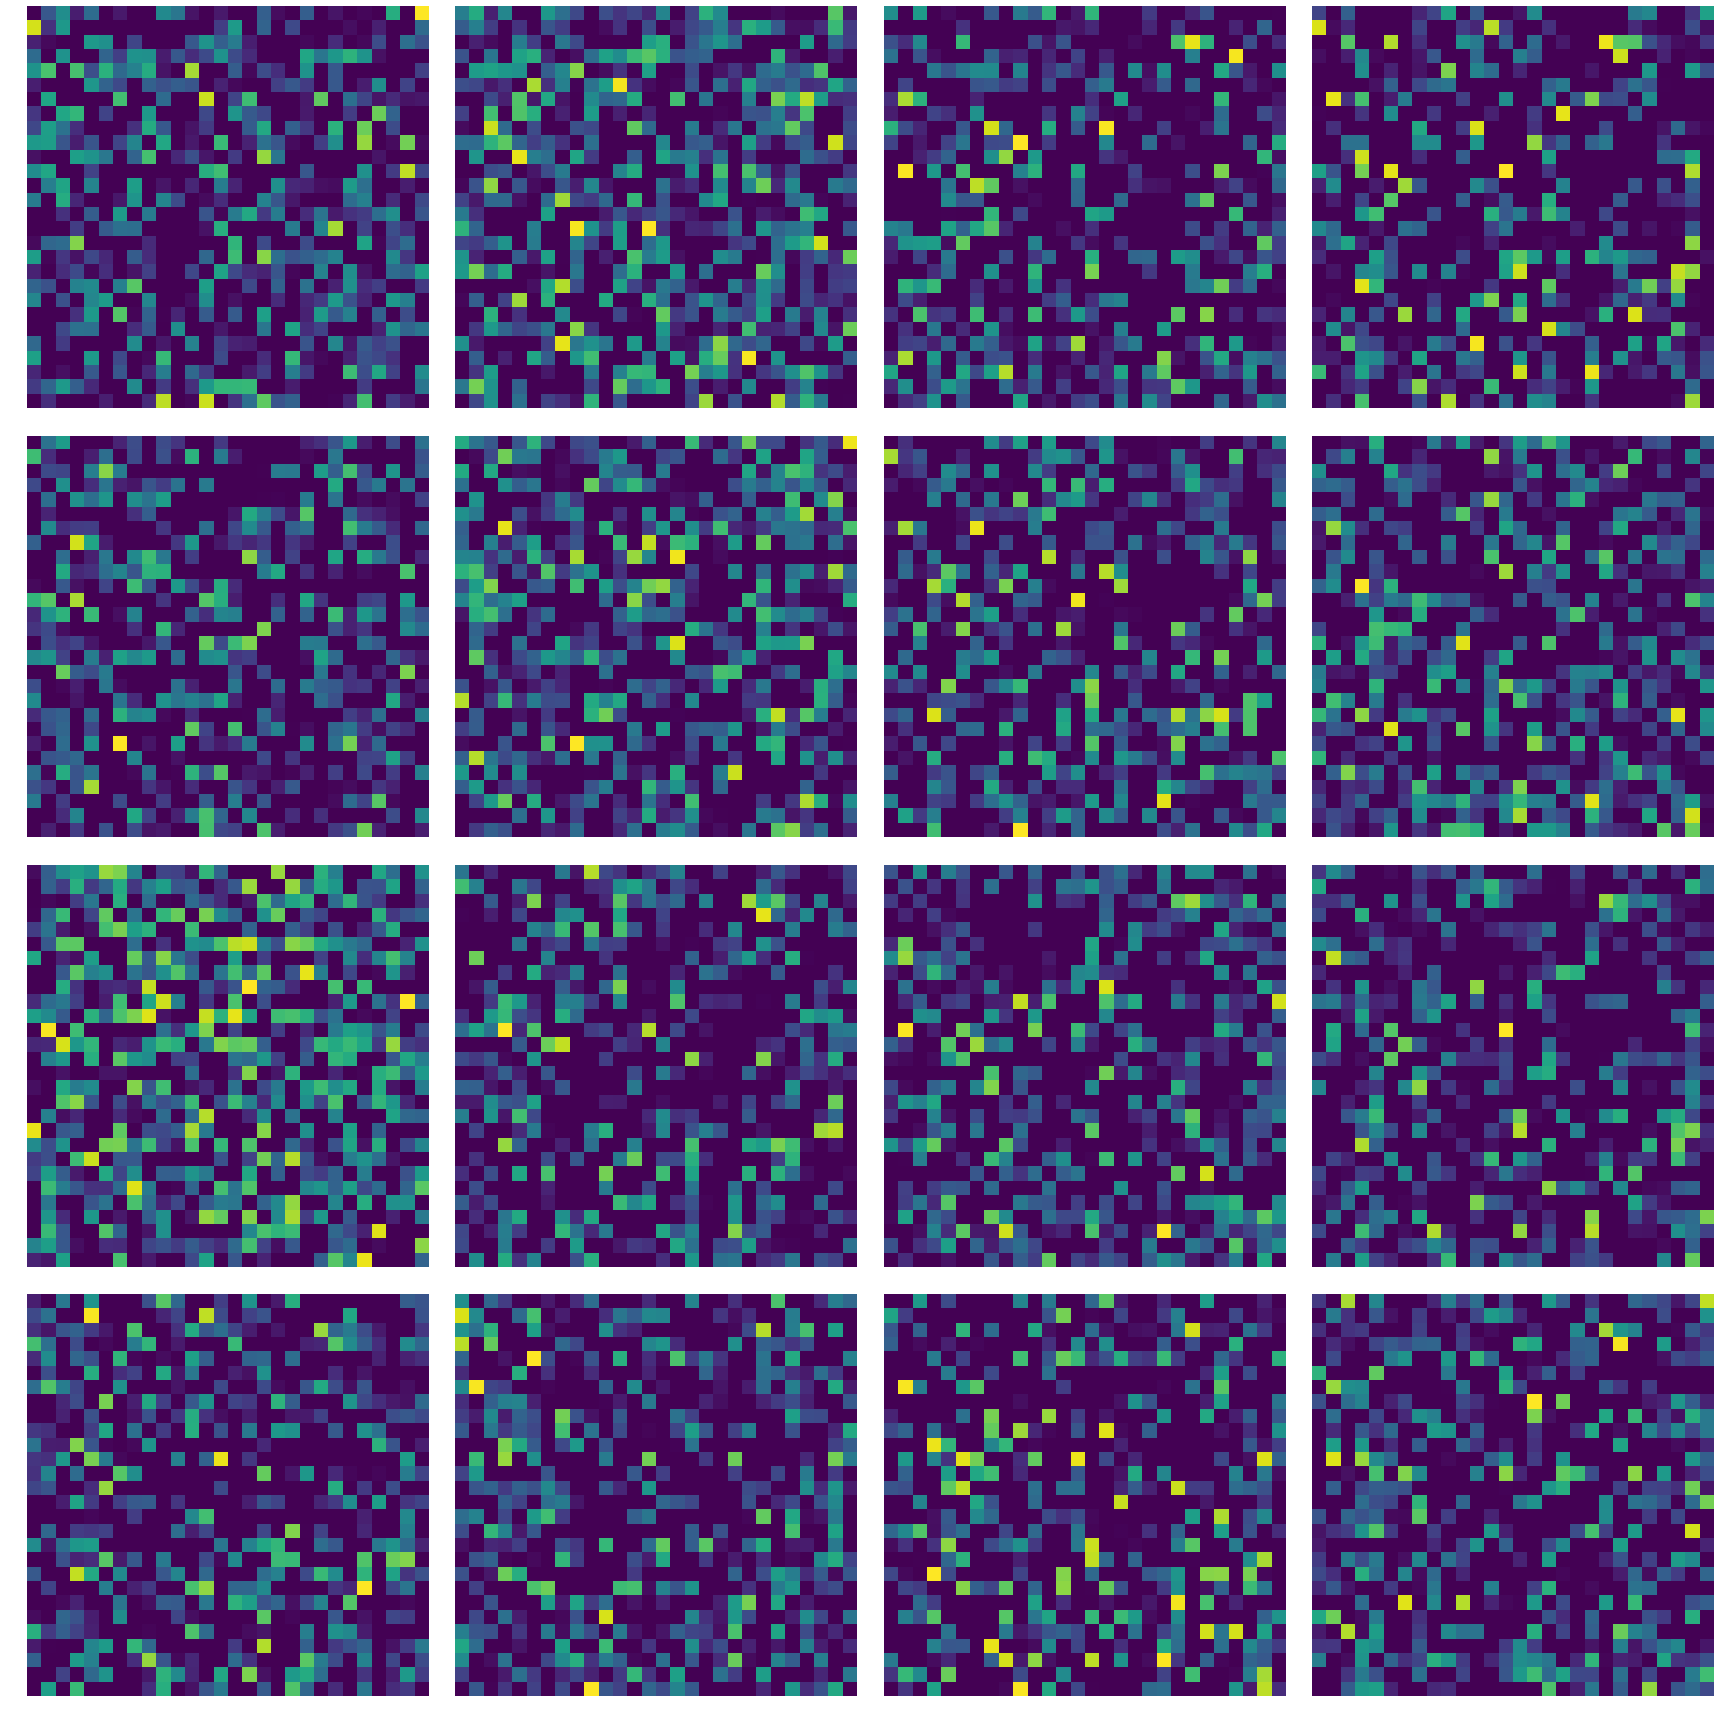

Epoch 7900, Generator loss 0.5518458485603333, discriminator loss 0.001095807645469904


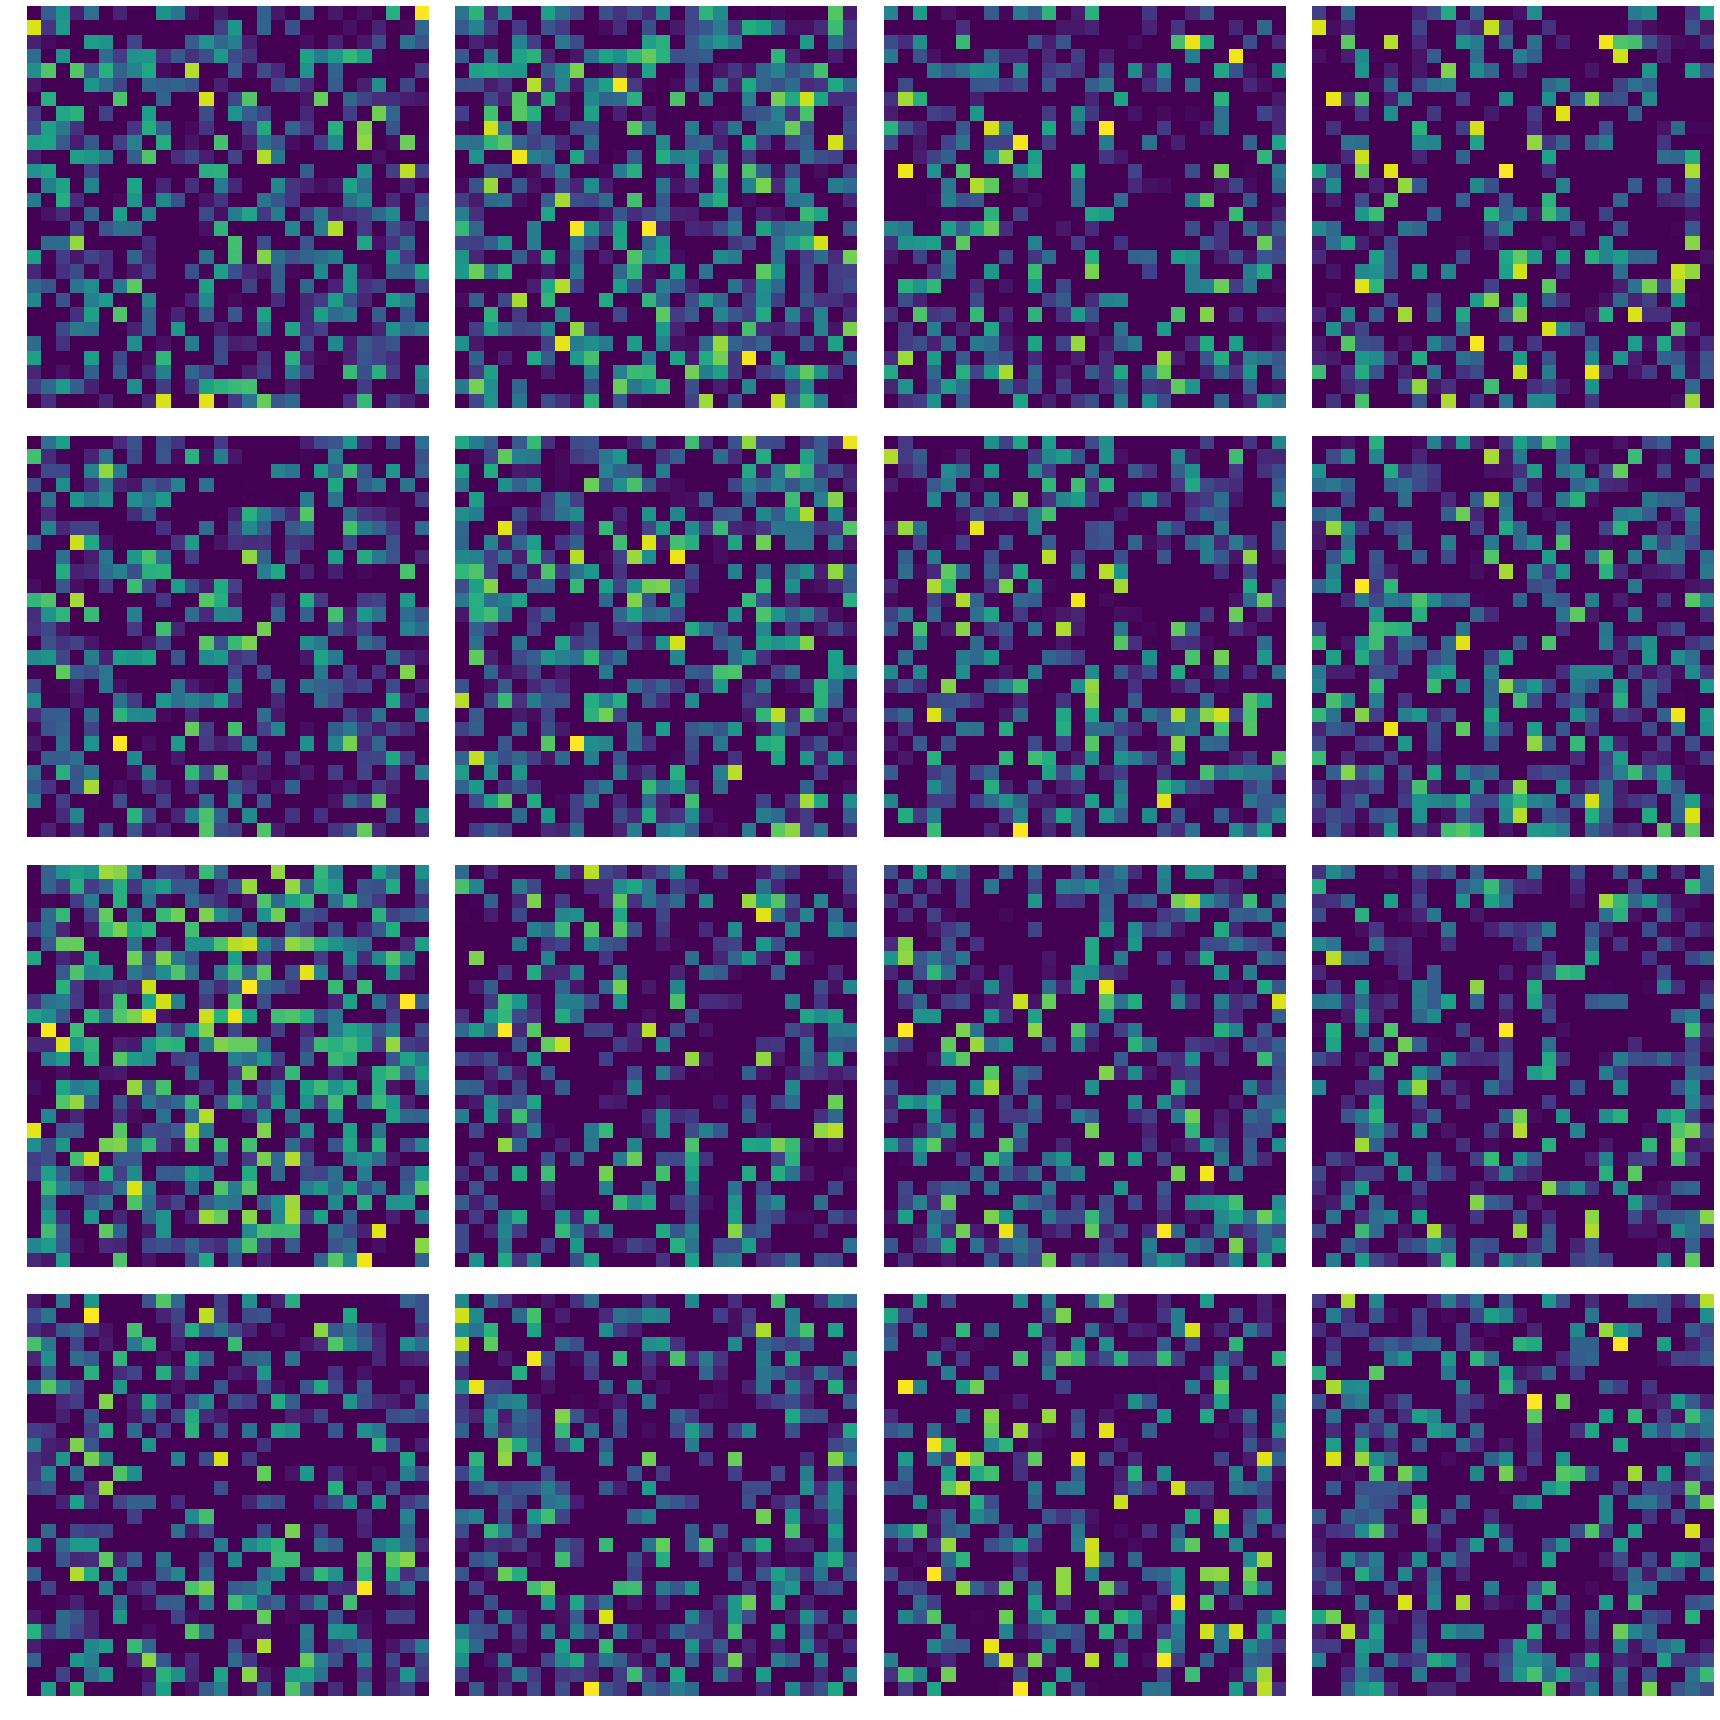

Epoch 8000, Generator loss 0.5497027635574341, discriminator loss 0.0010790711967274547


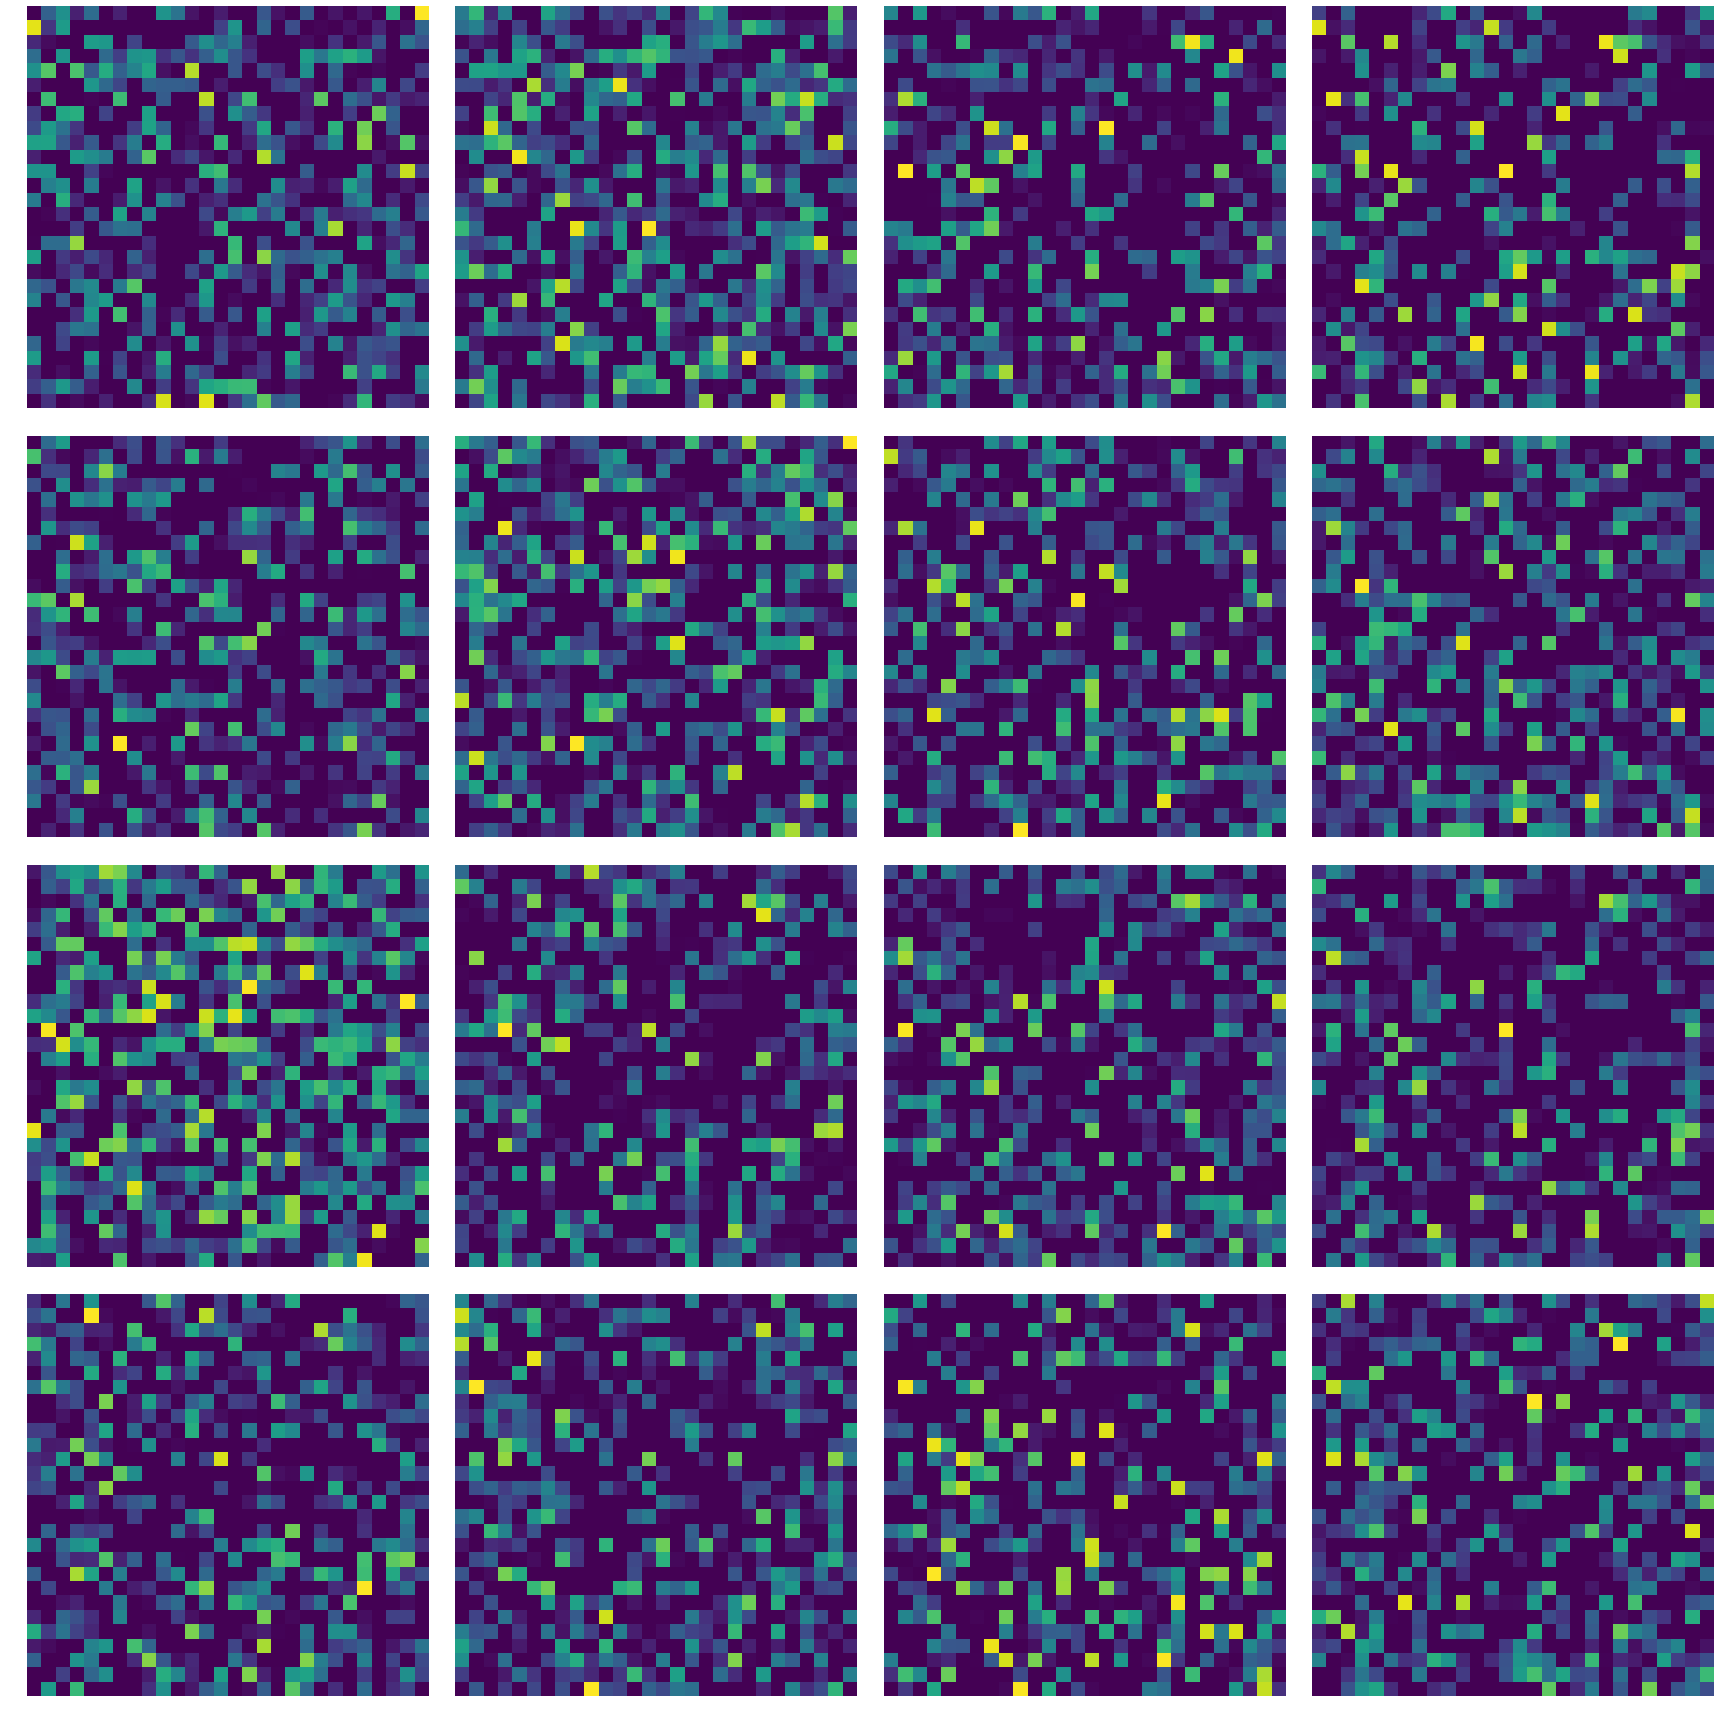

Epoch 8100, Generator loss 0.5411704778671265, discriminator loss 0.0010608230950310826


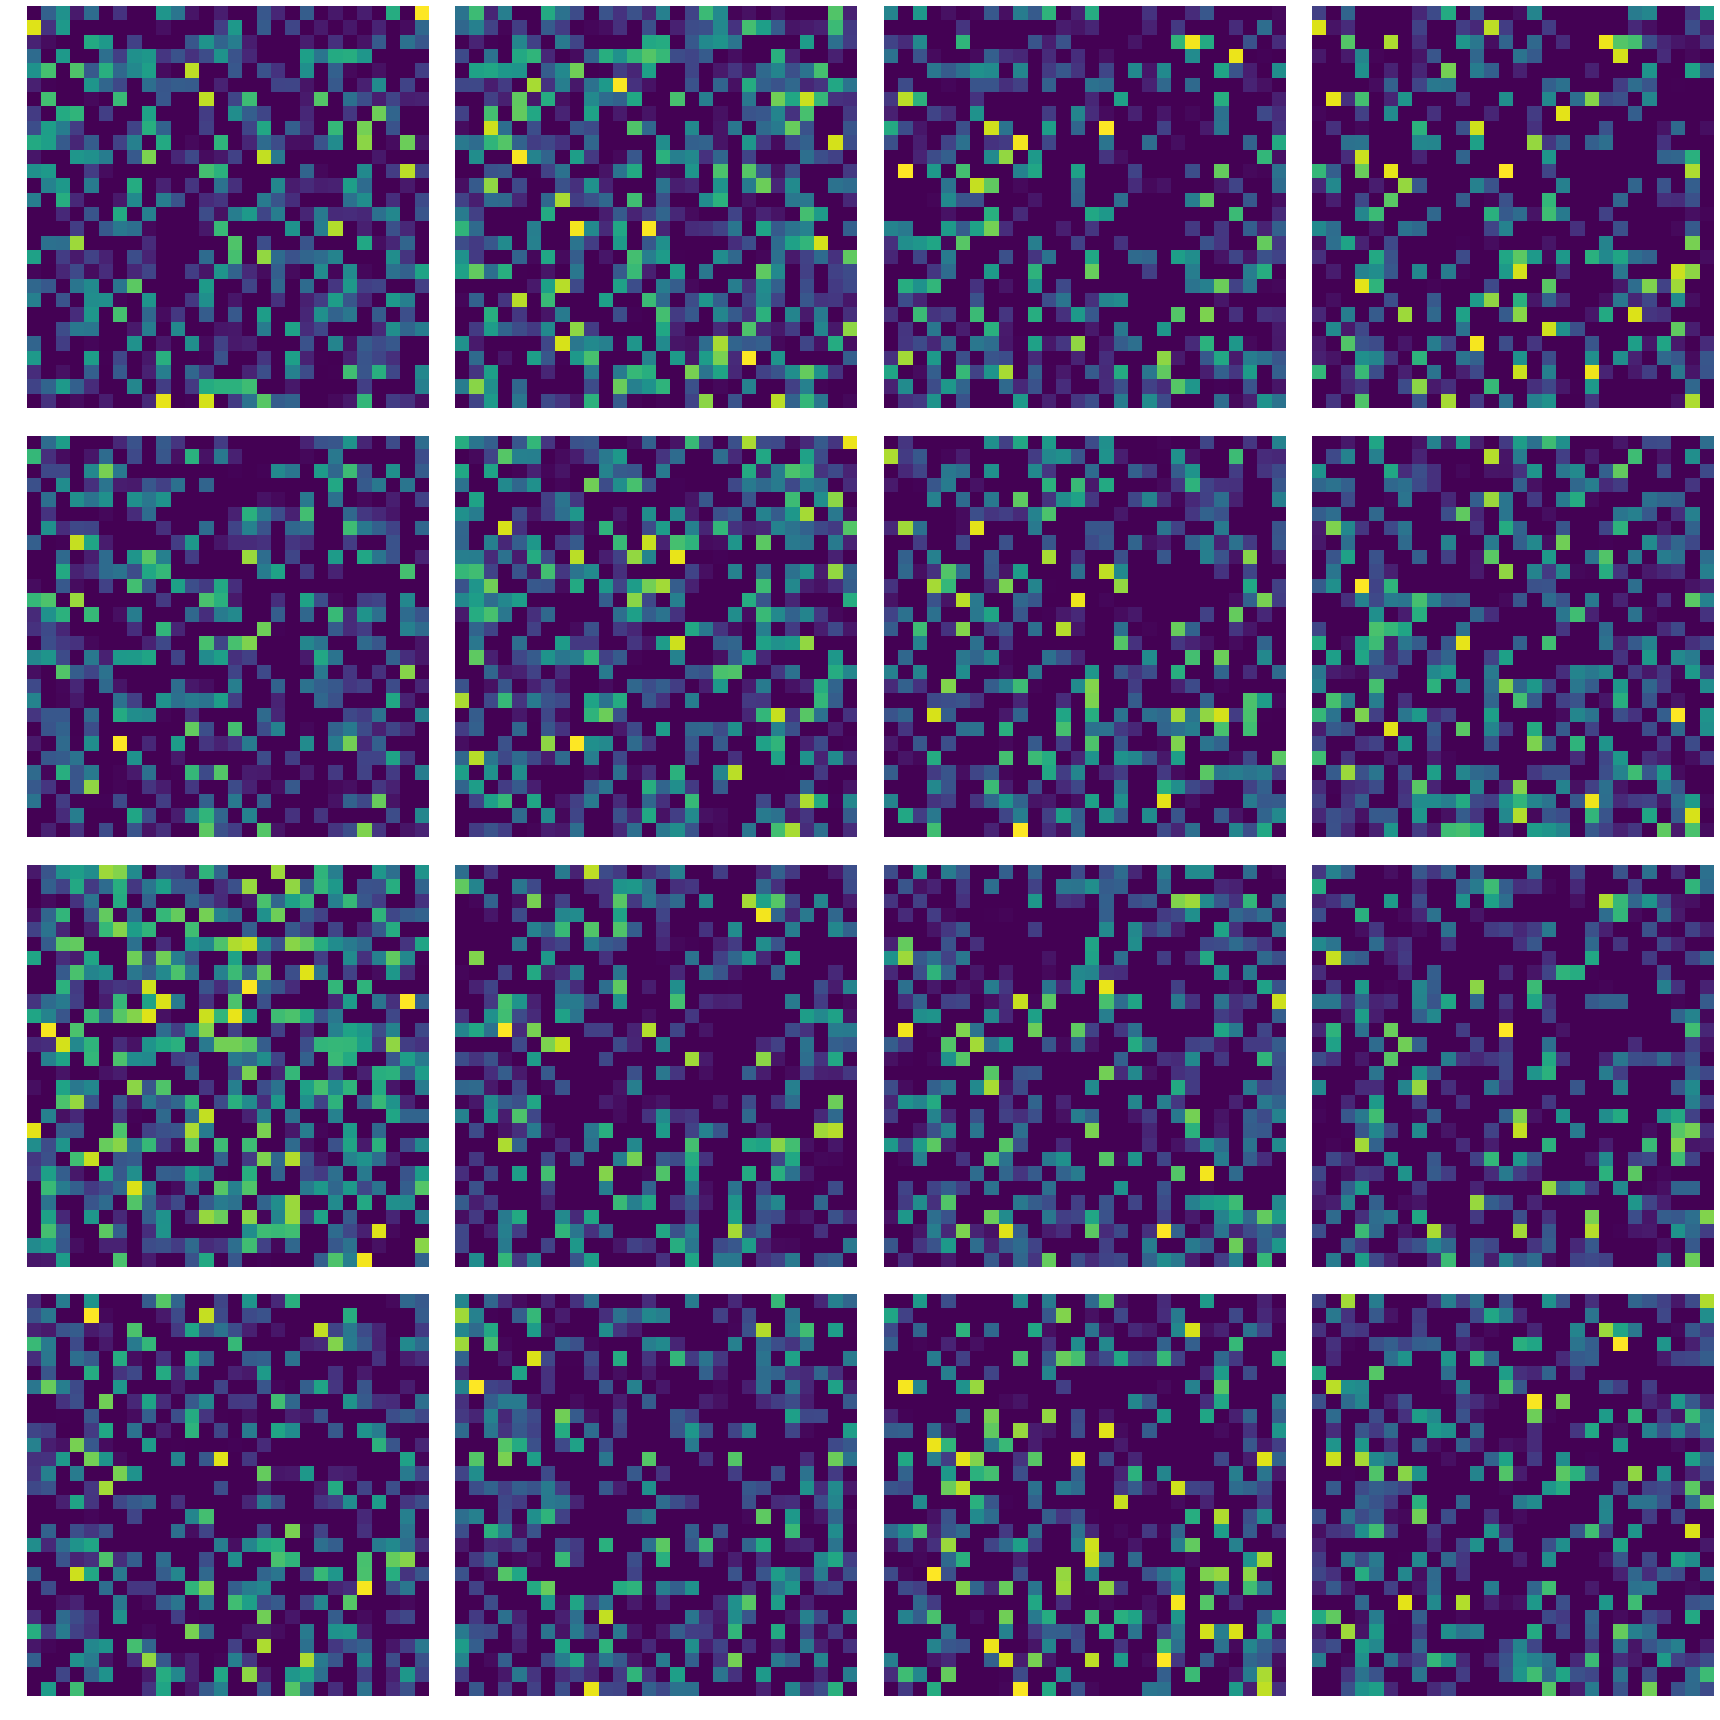

Epoch 8200, Generator loss 0.530450165271759, discriminator loss 0.0010442787315696478


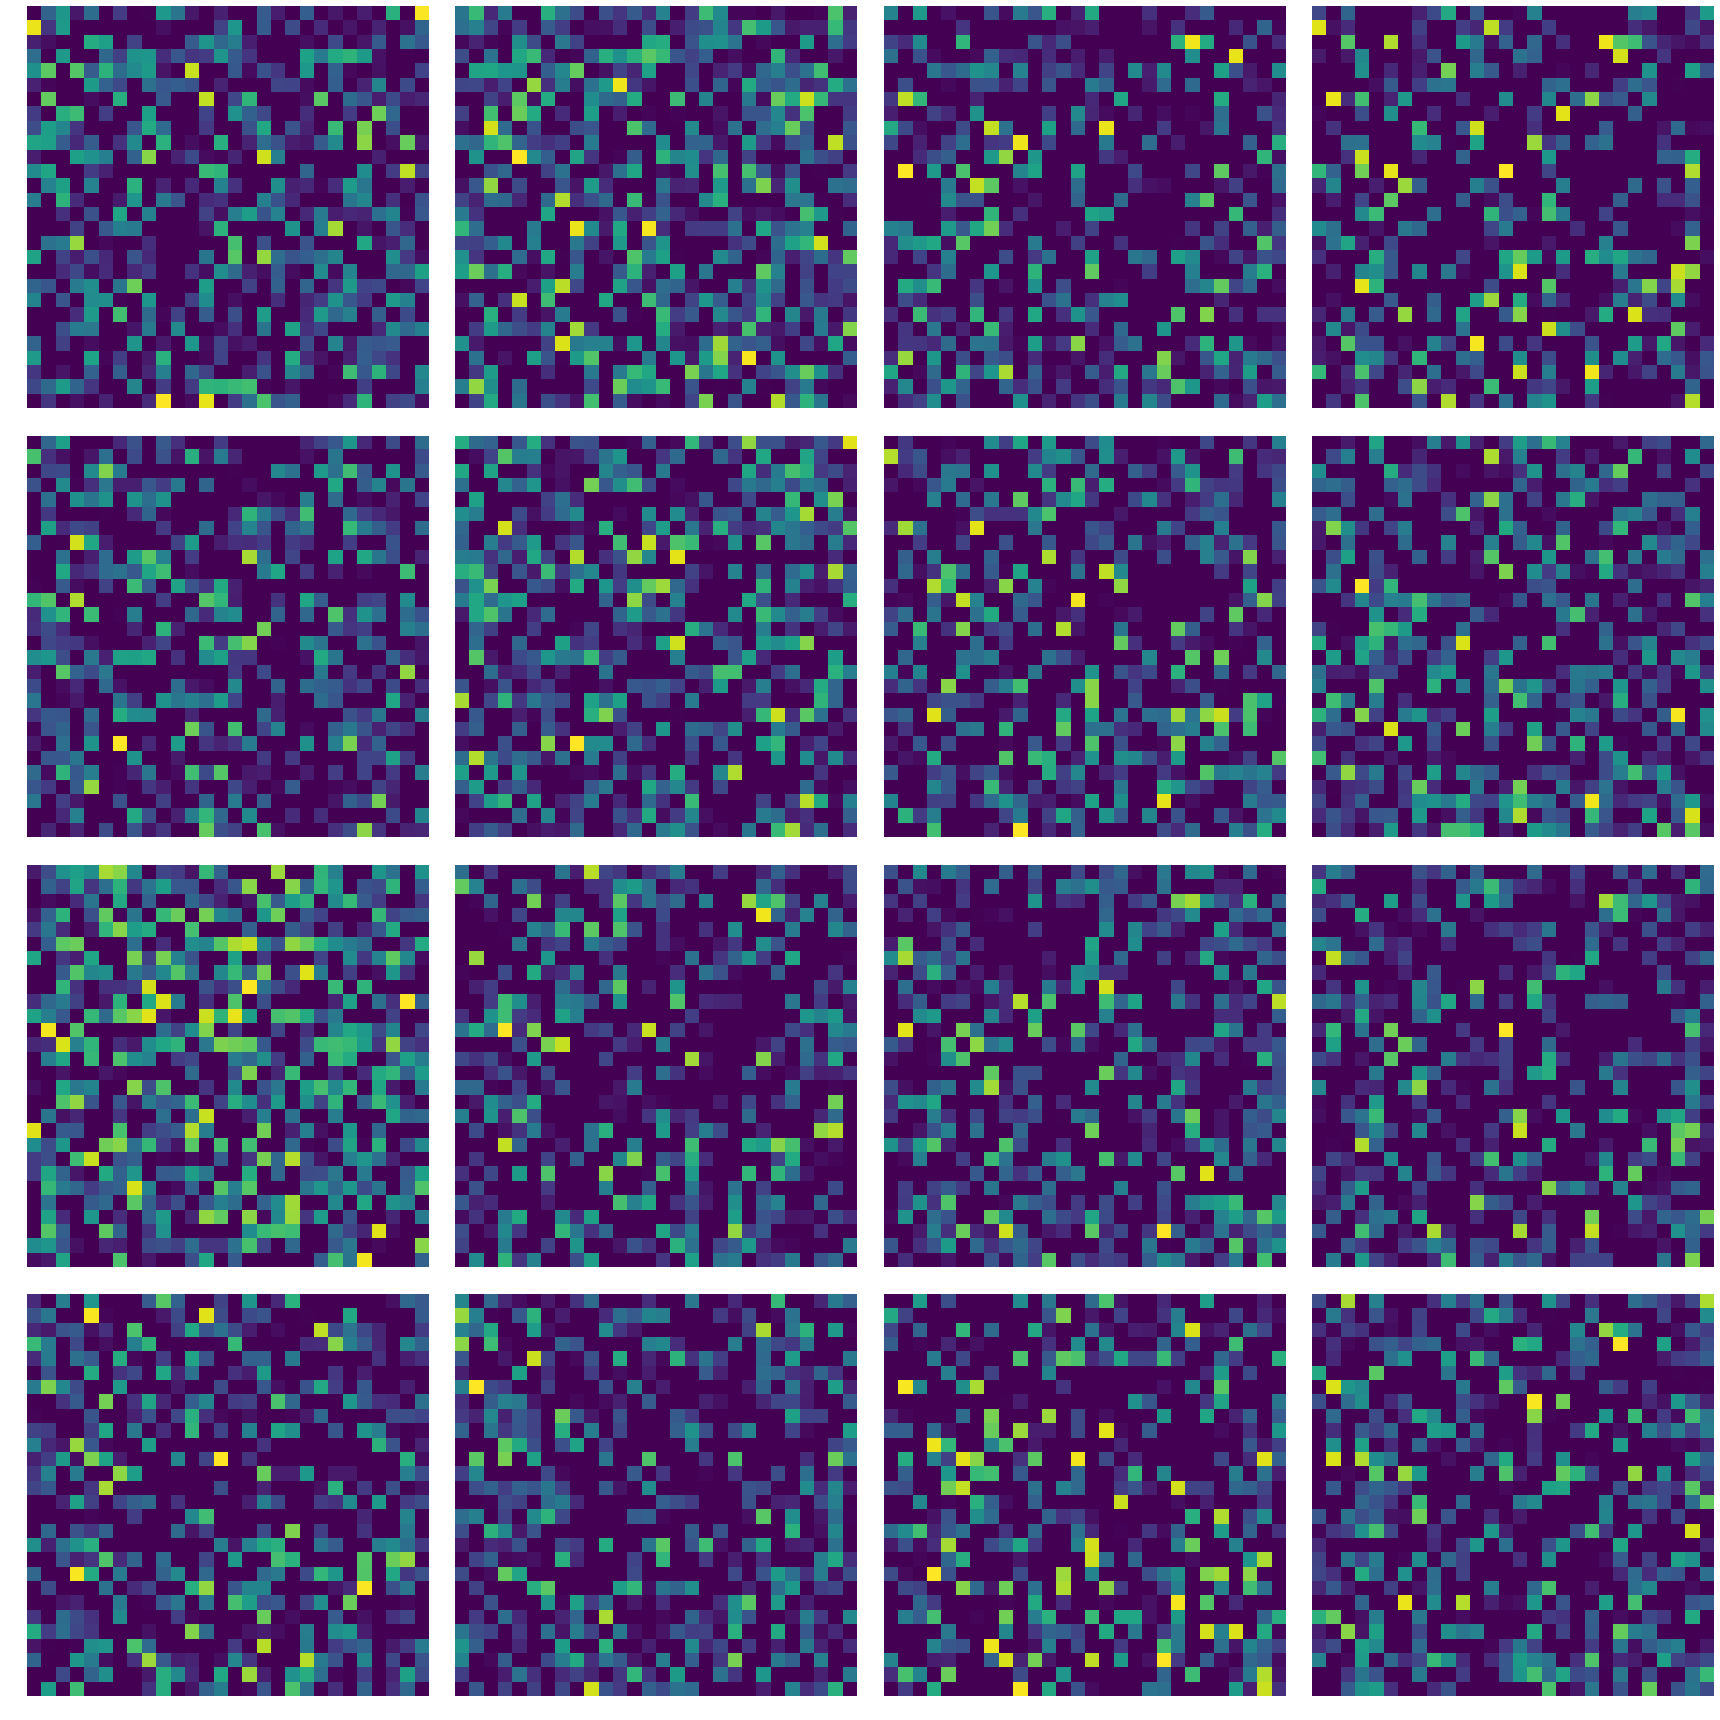

Epoch 8300, Generator loss 0.5406745672225952, discriminator loss 0.0010278747649863362


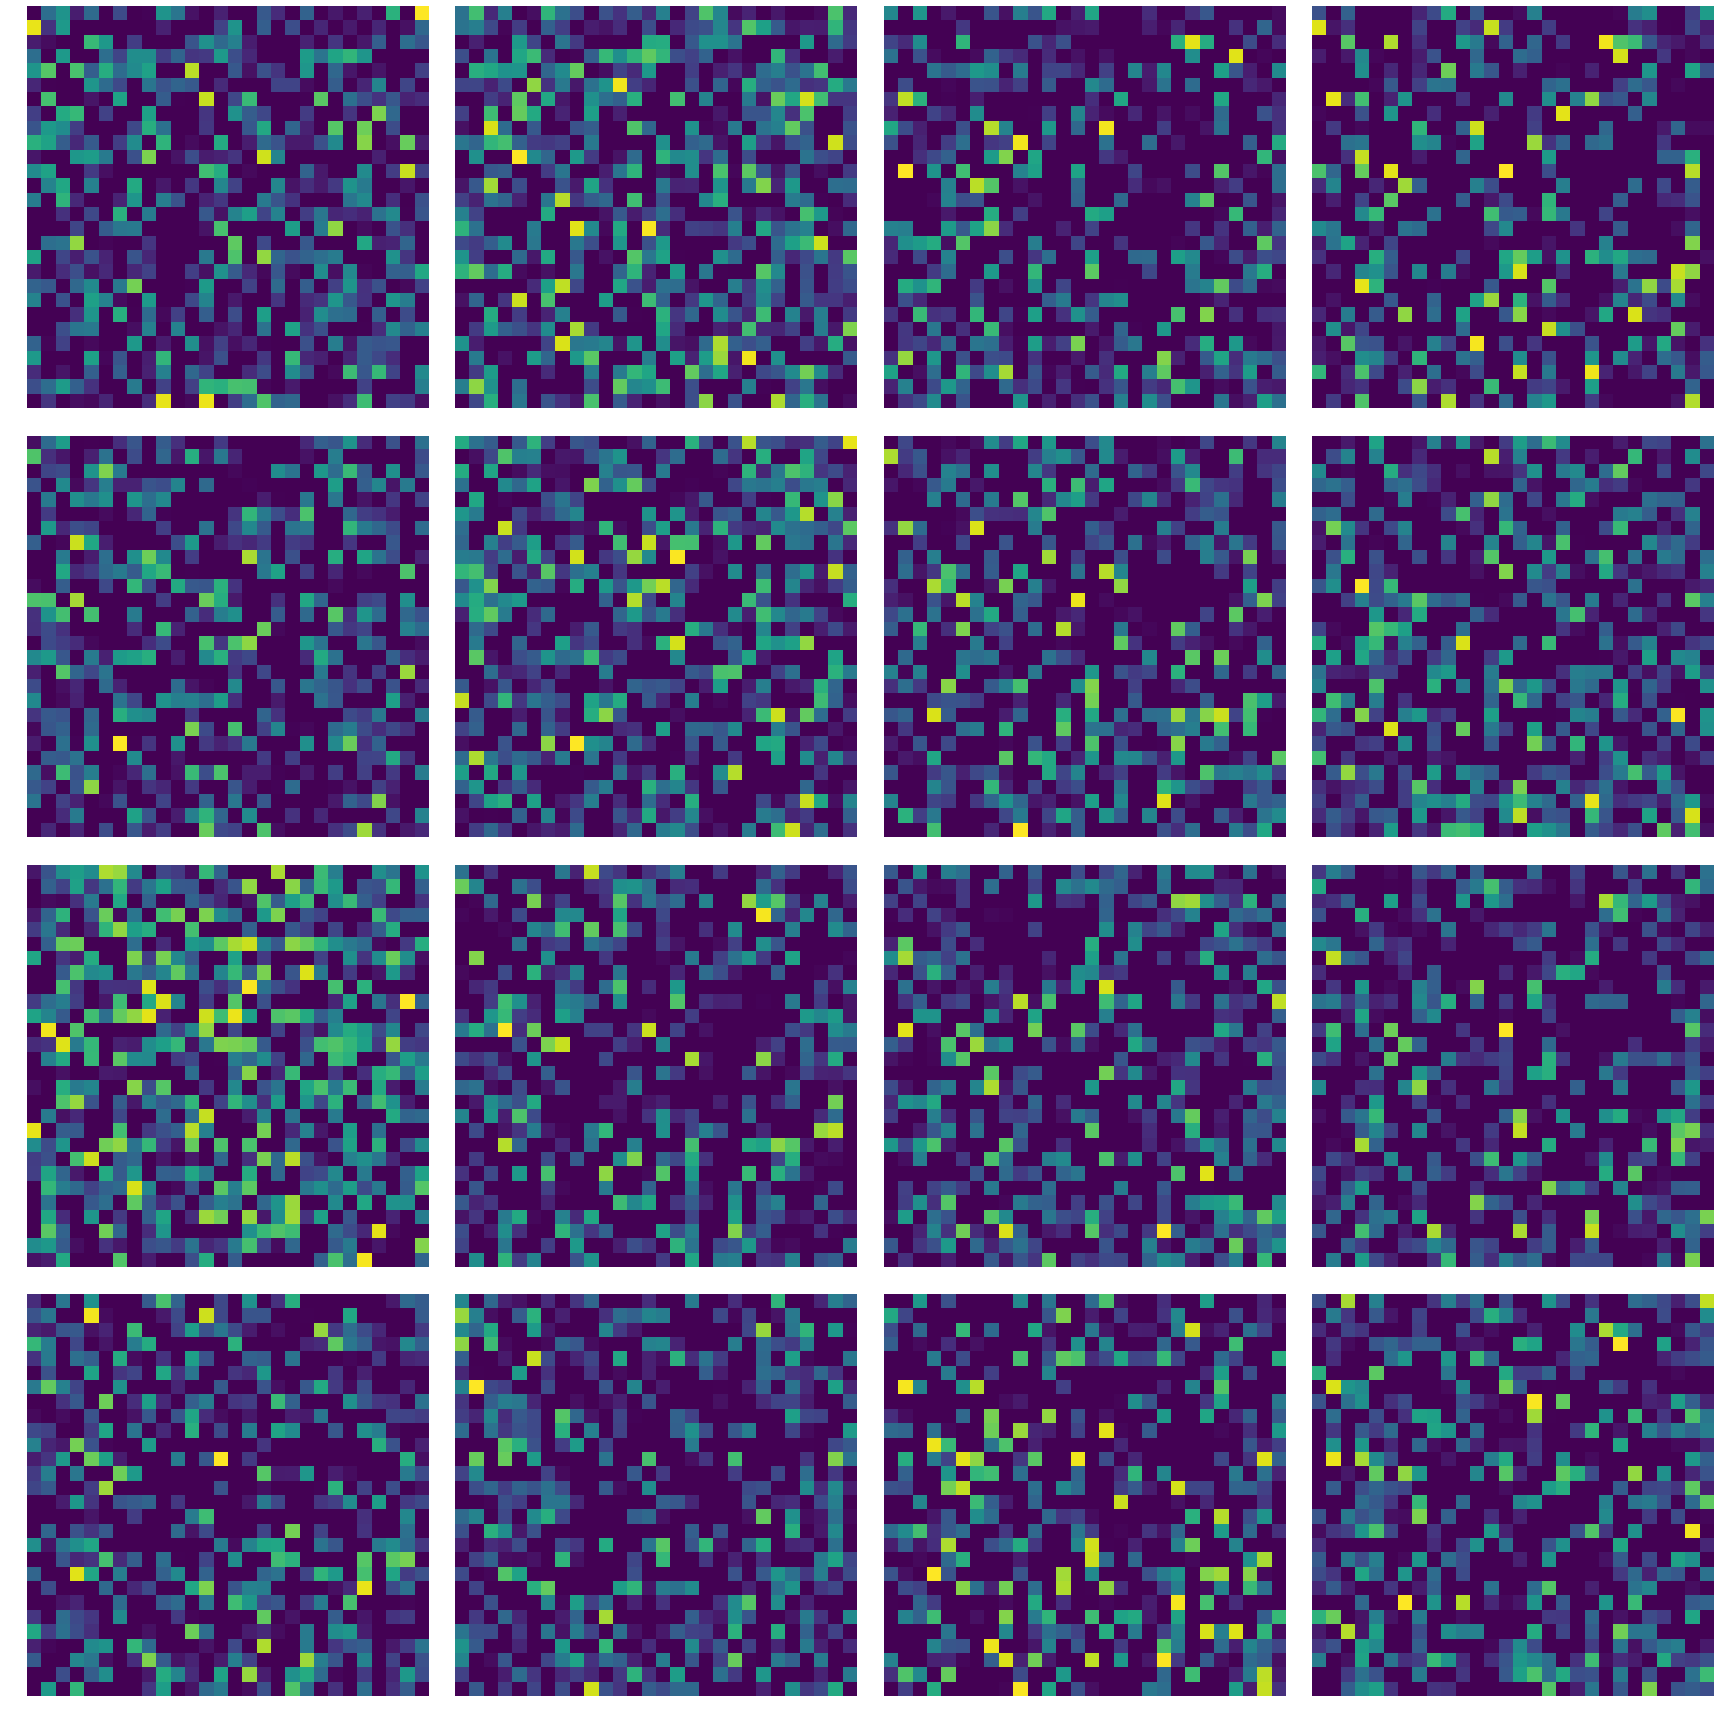

Epoch 8400, Generator loss 0.5322094559669495, discriminator loss 0.0010120703373104334


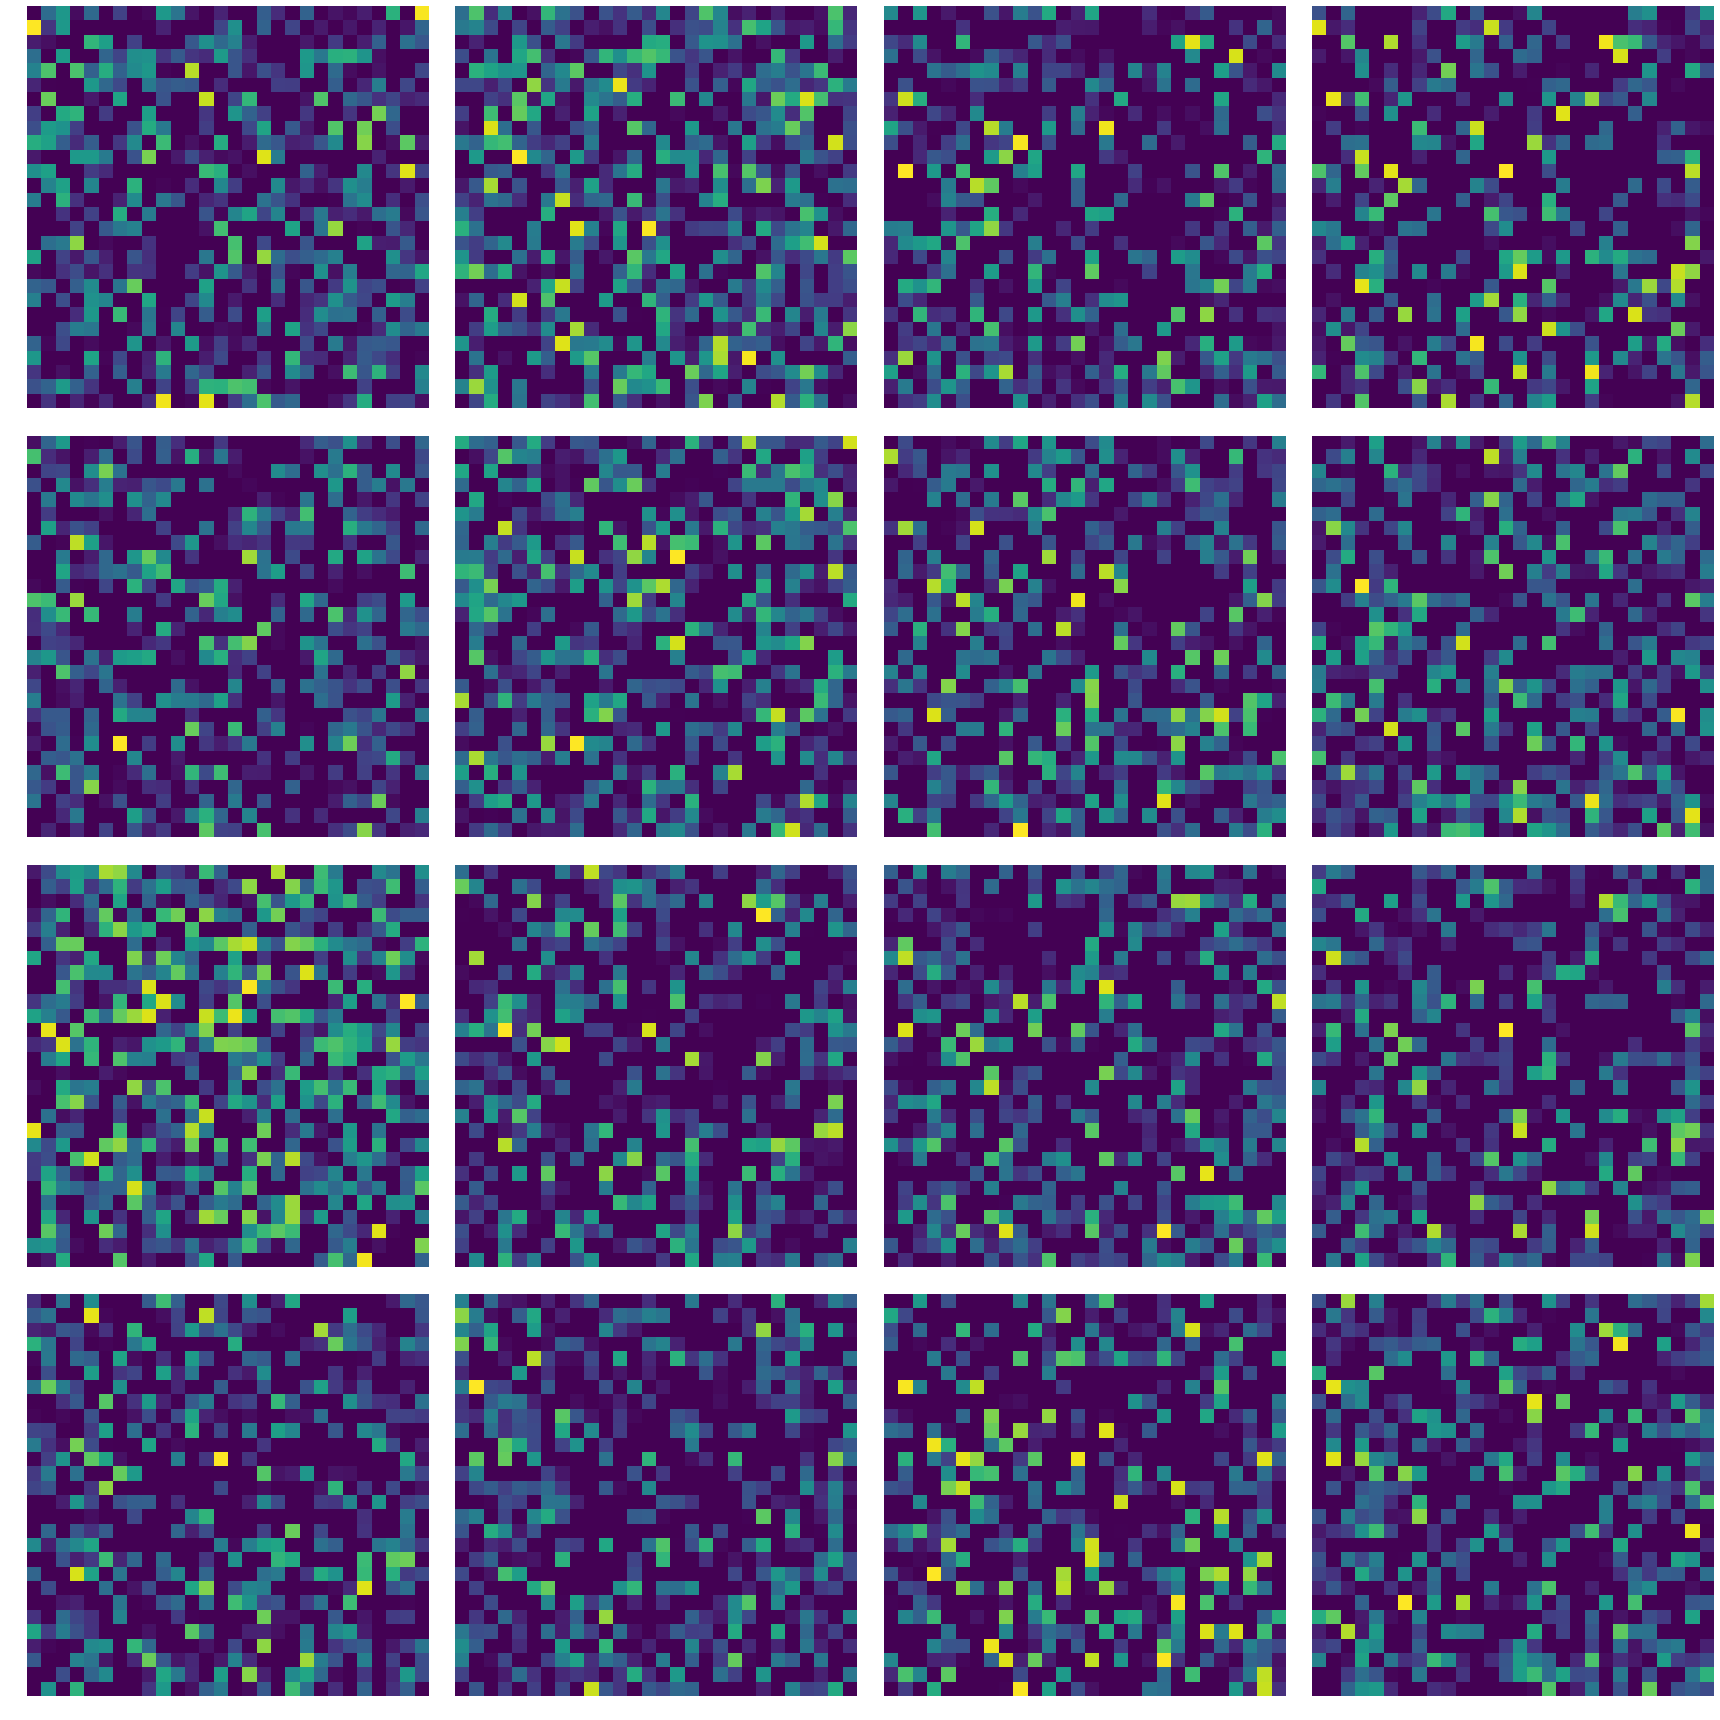

Epoch 8500, Generator loss 0.5403062701225281, discriminator loss 0.0009960897732526064


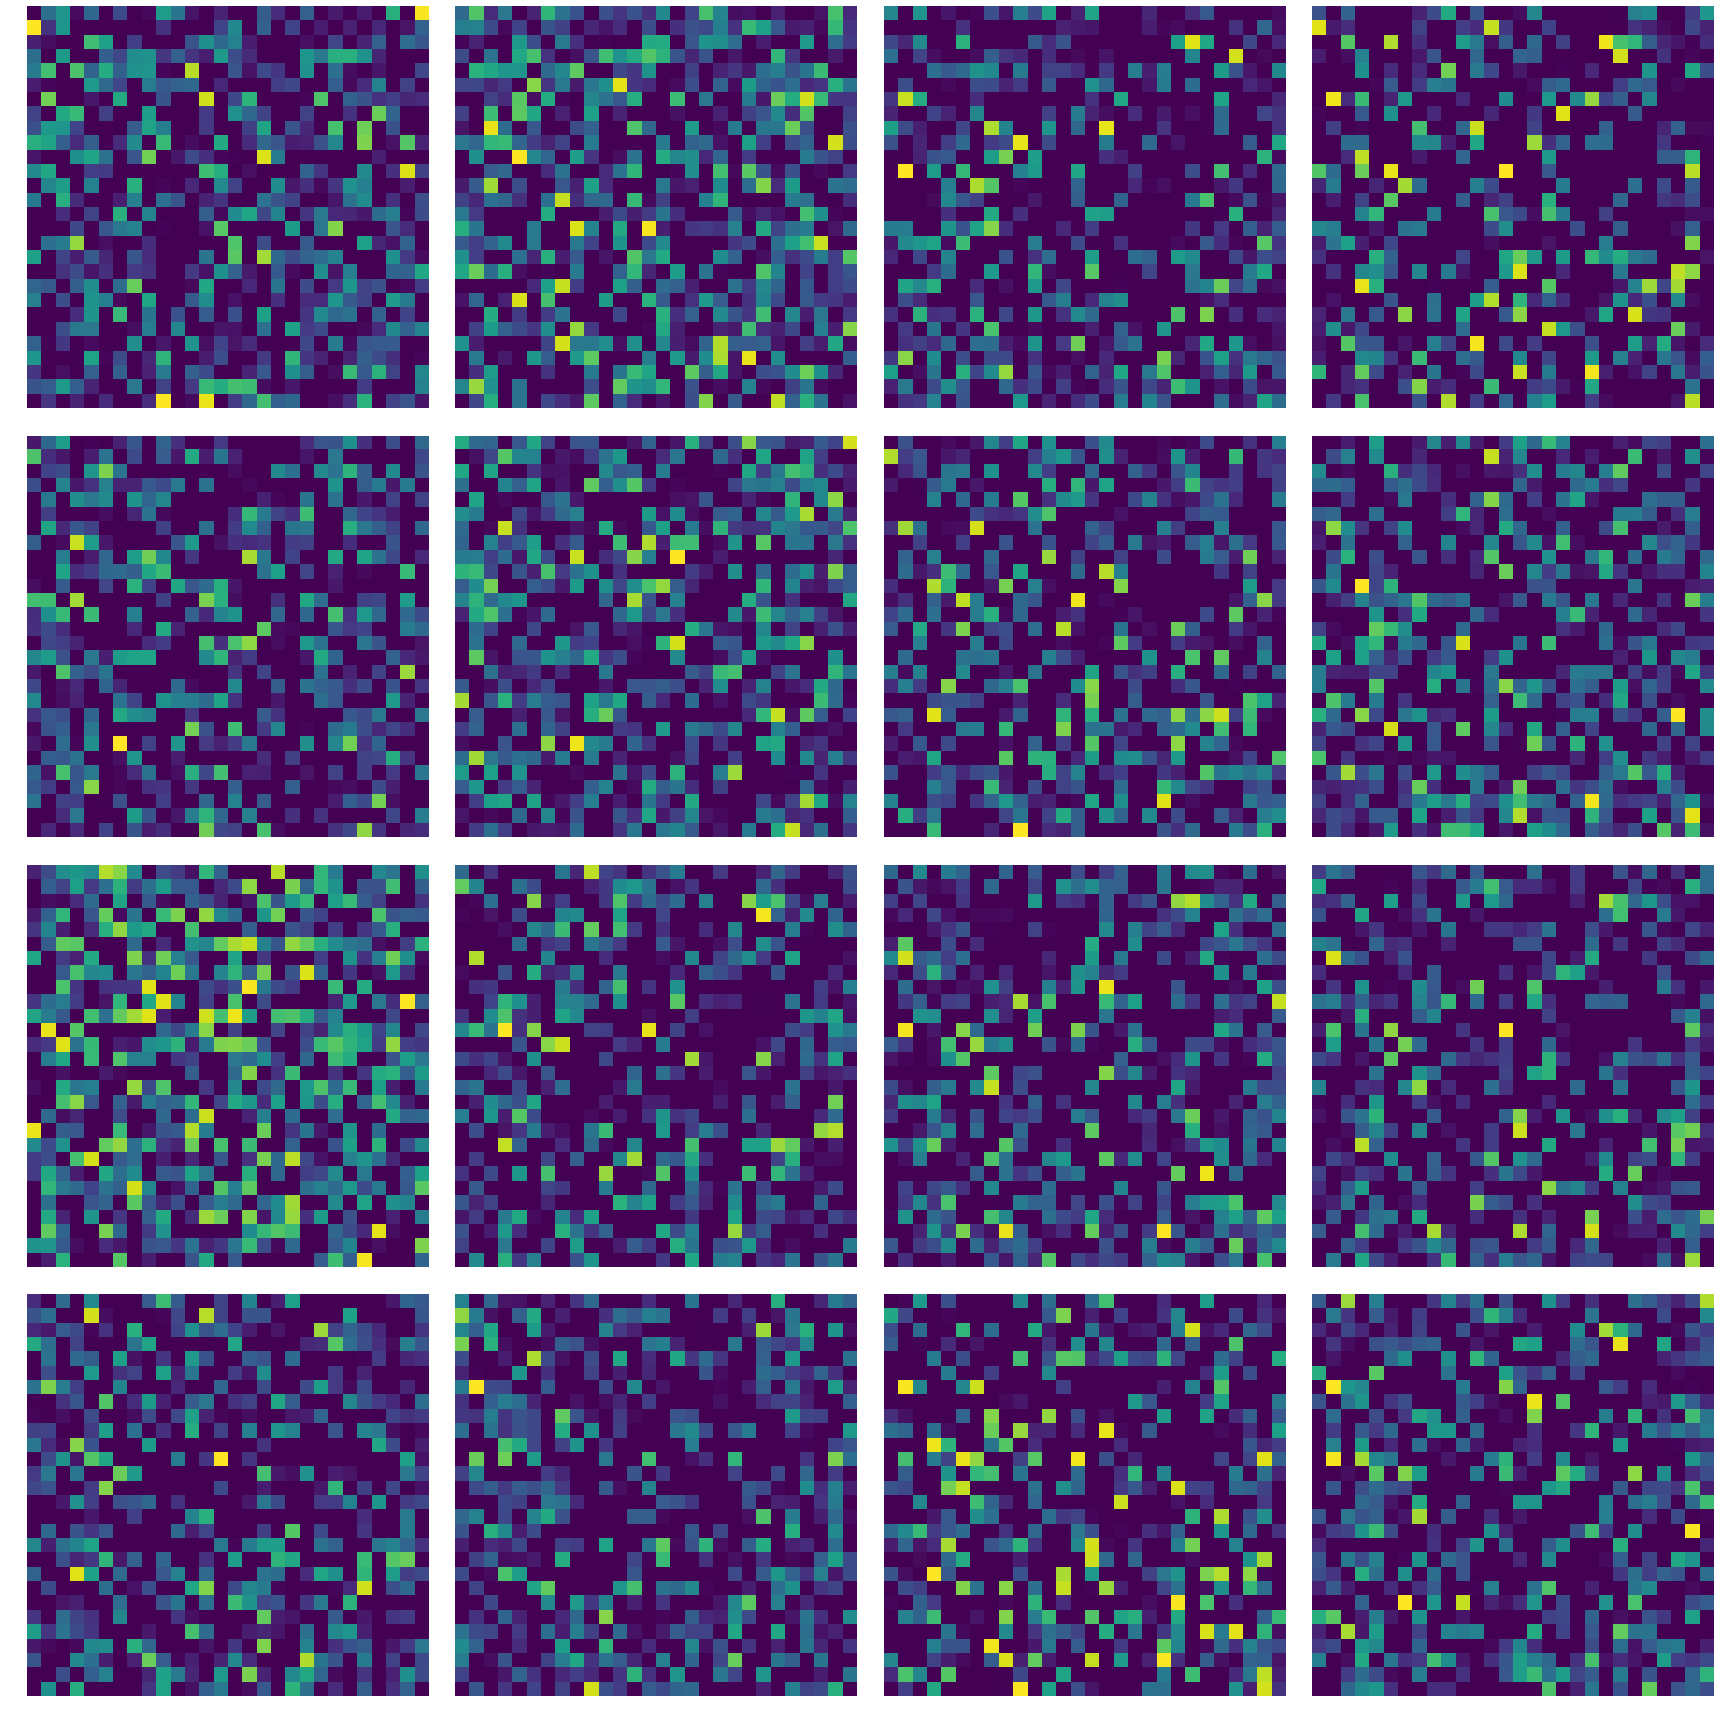

Epoch 8600, Generator loss 0.5216736197471619, discriminator loss 0.0009813477518036962


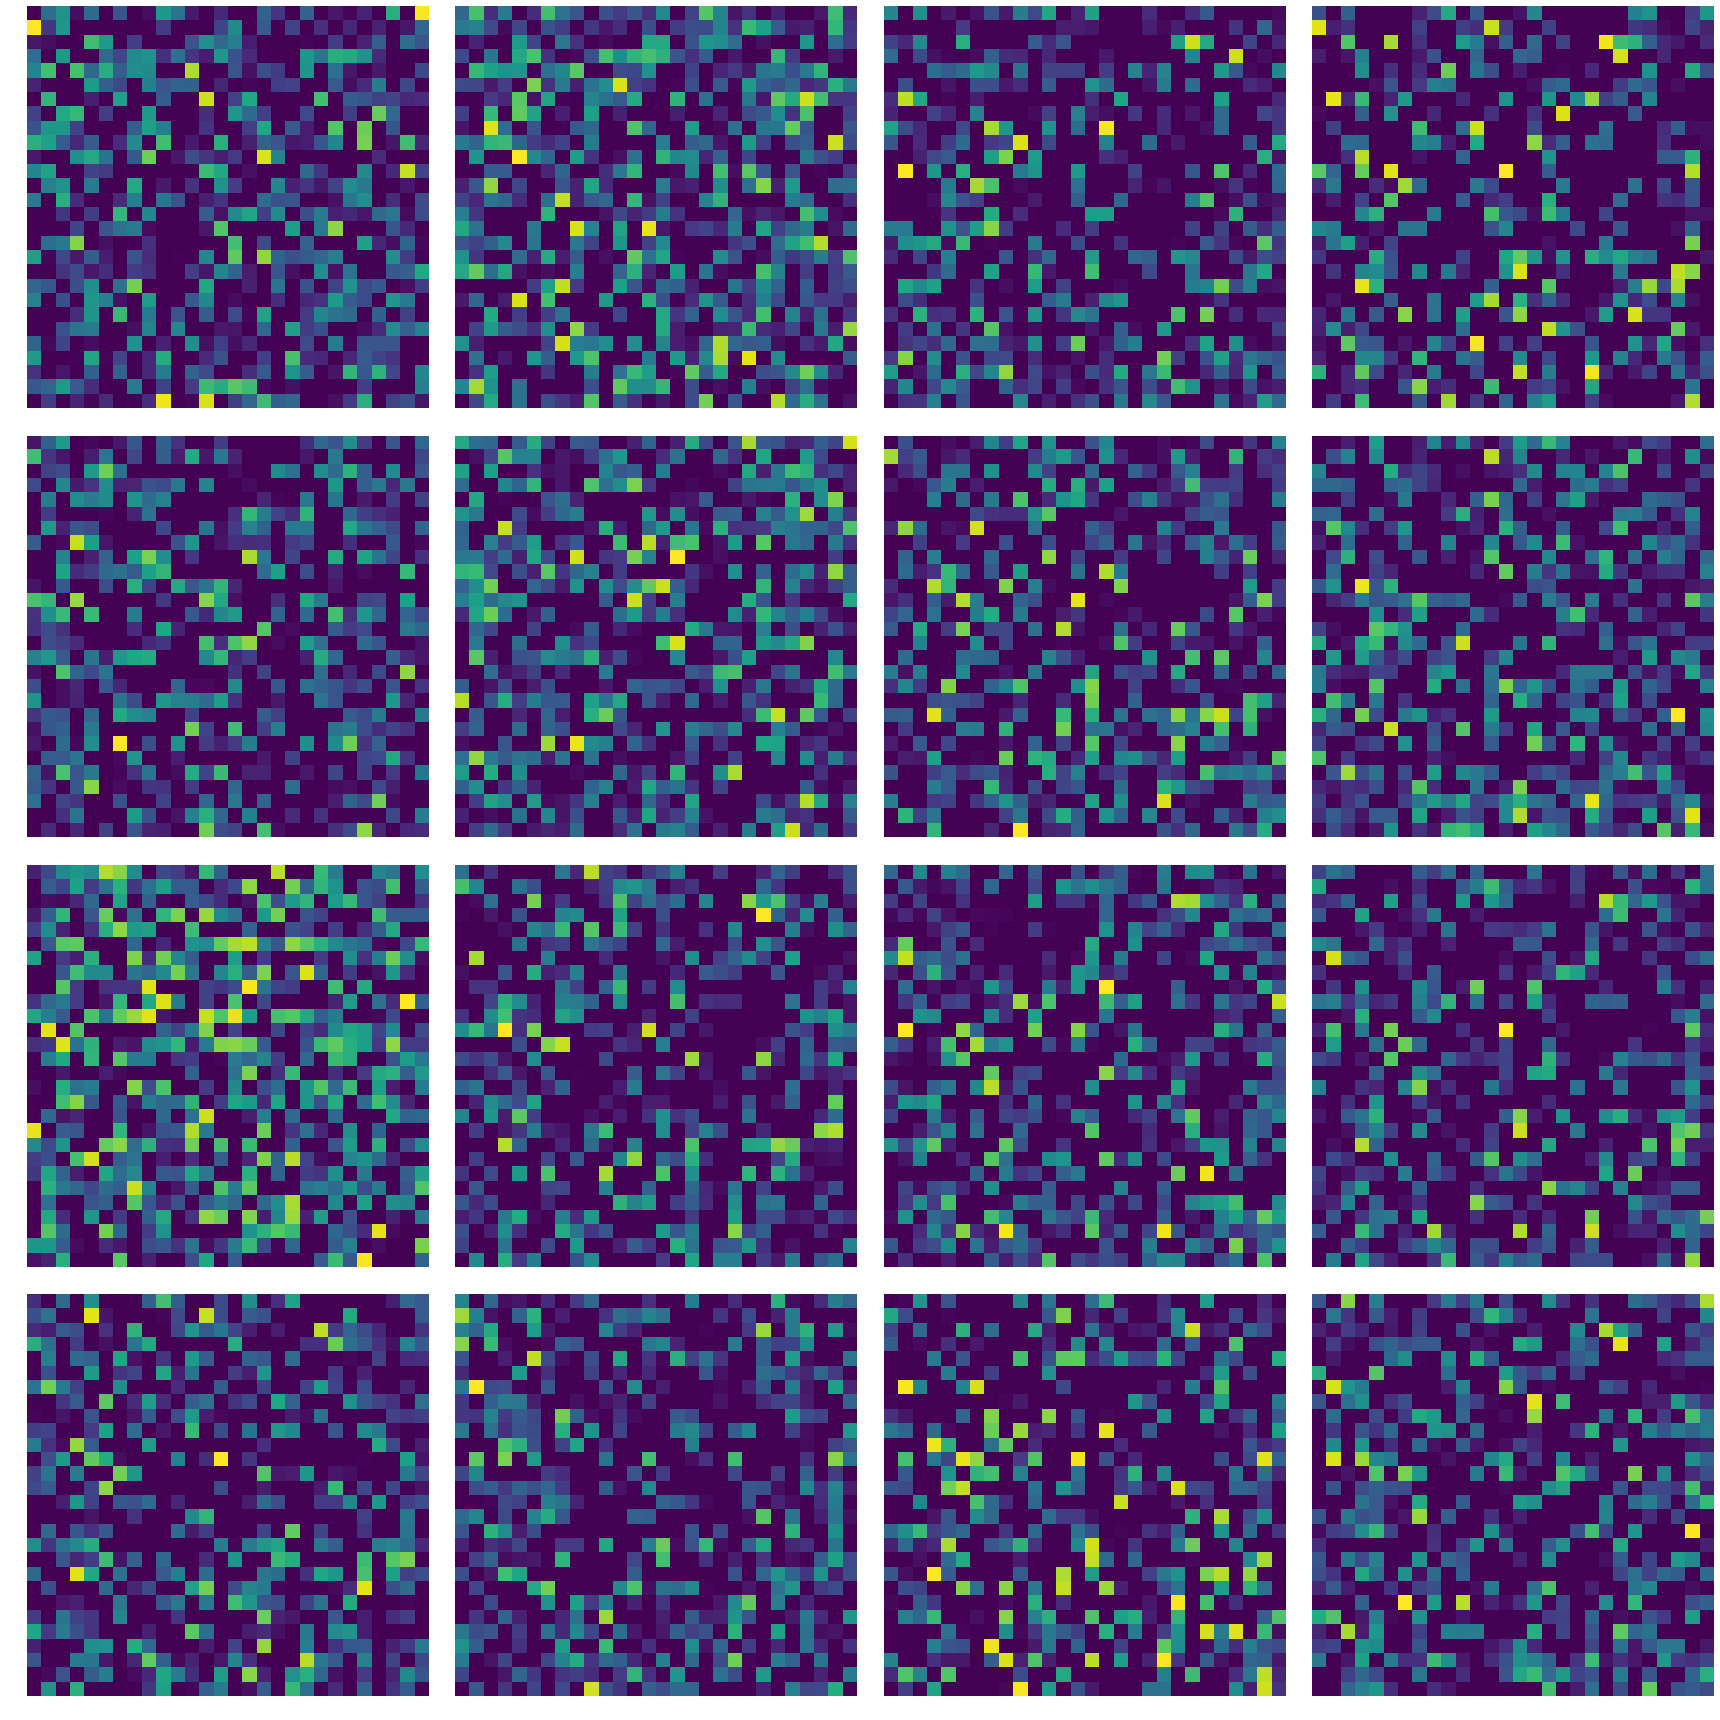

Epoch 8700, Generator loss 0.5325309634208679, discriminator loss 0.000966789317317307


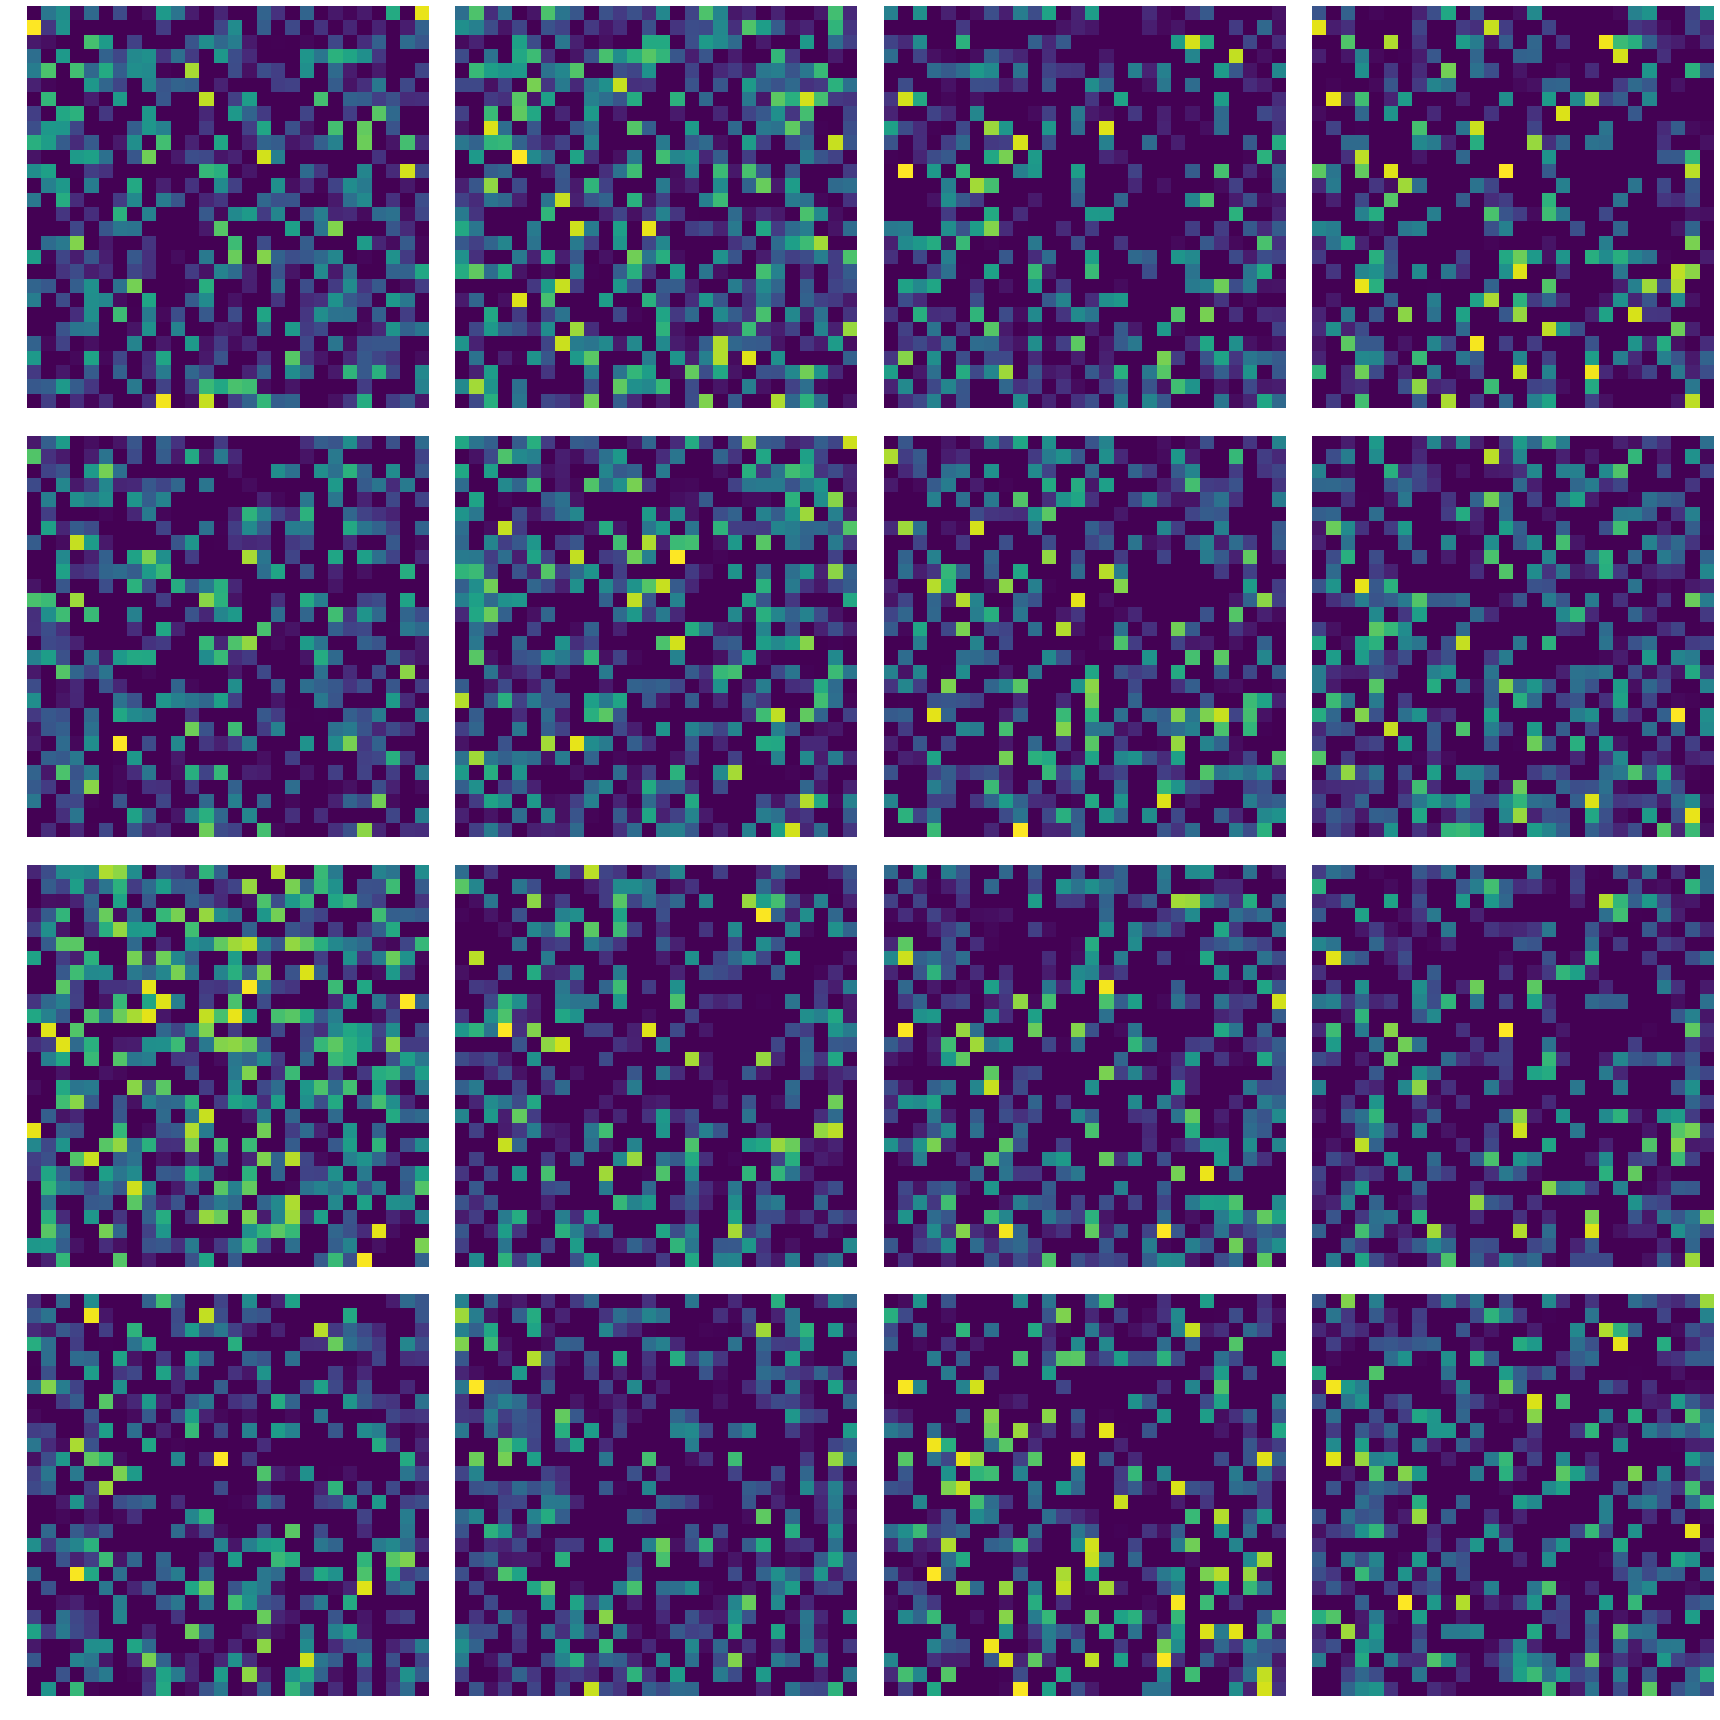

Epoch 8800, Generator loss 0.5221333503723145, discriminator loss 0.0009522439213469625


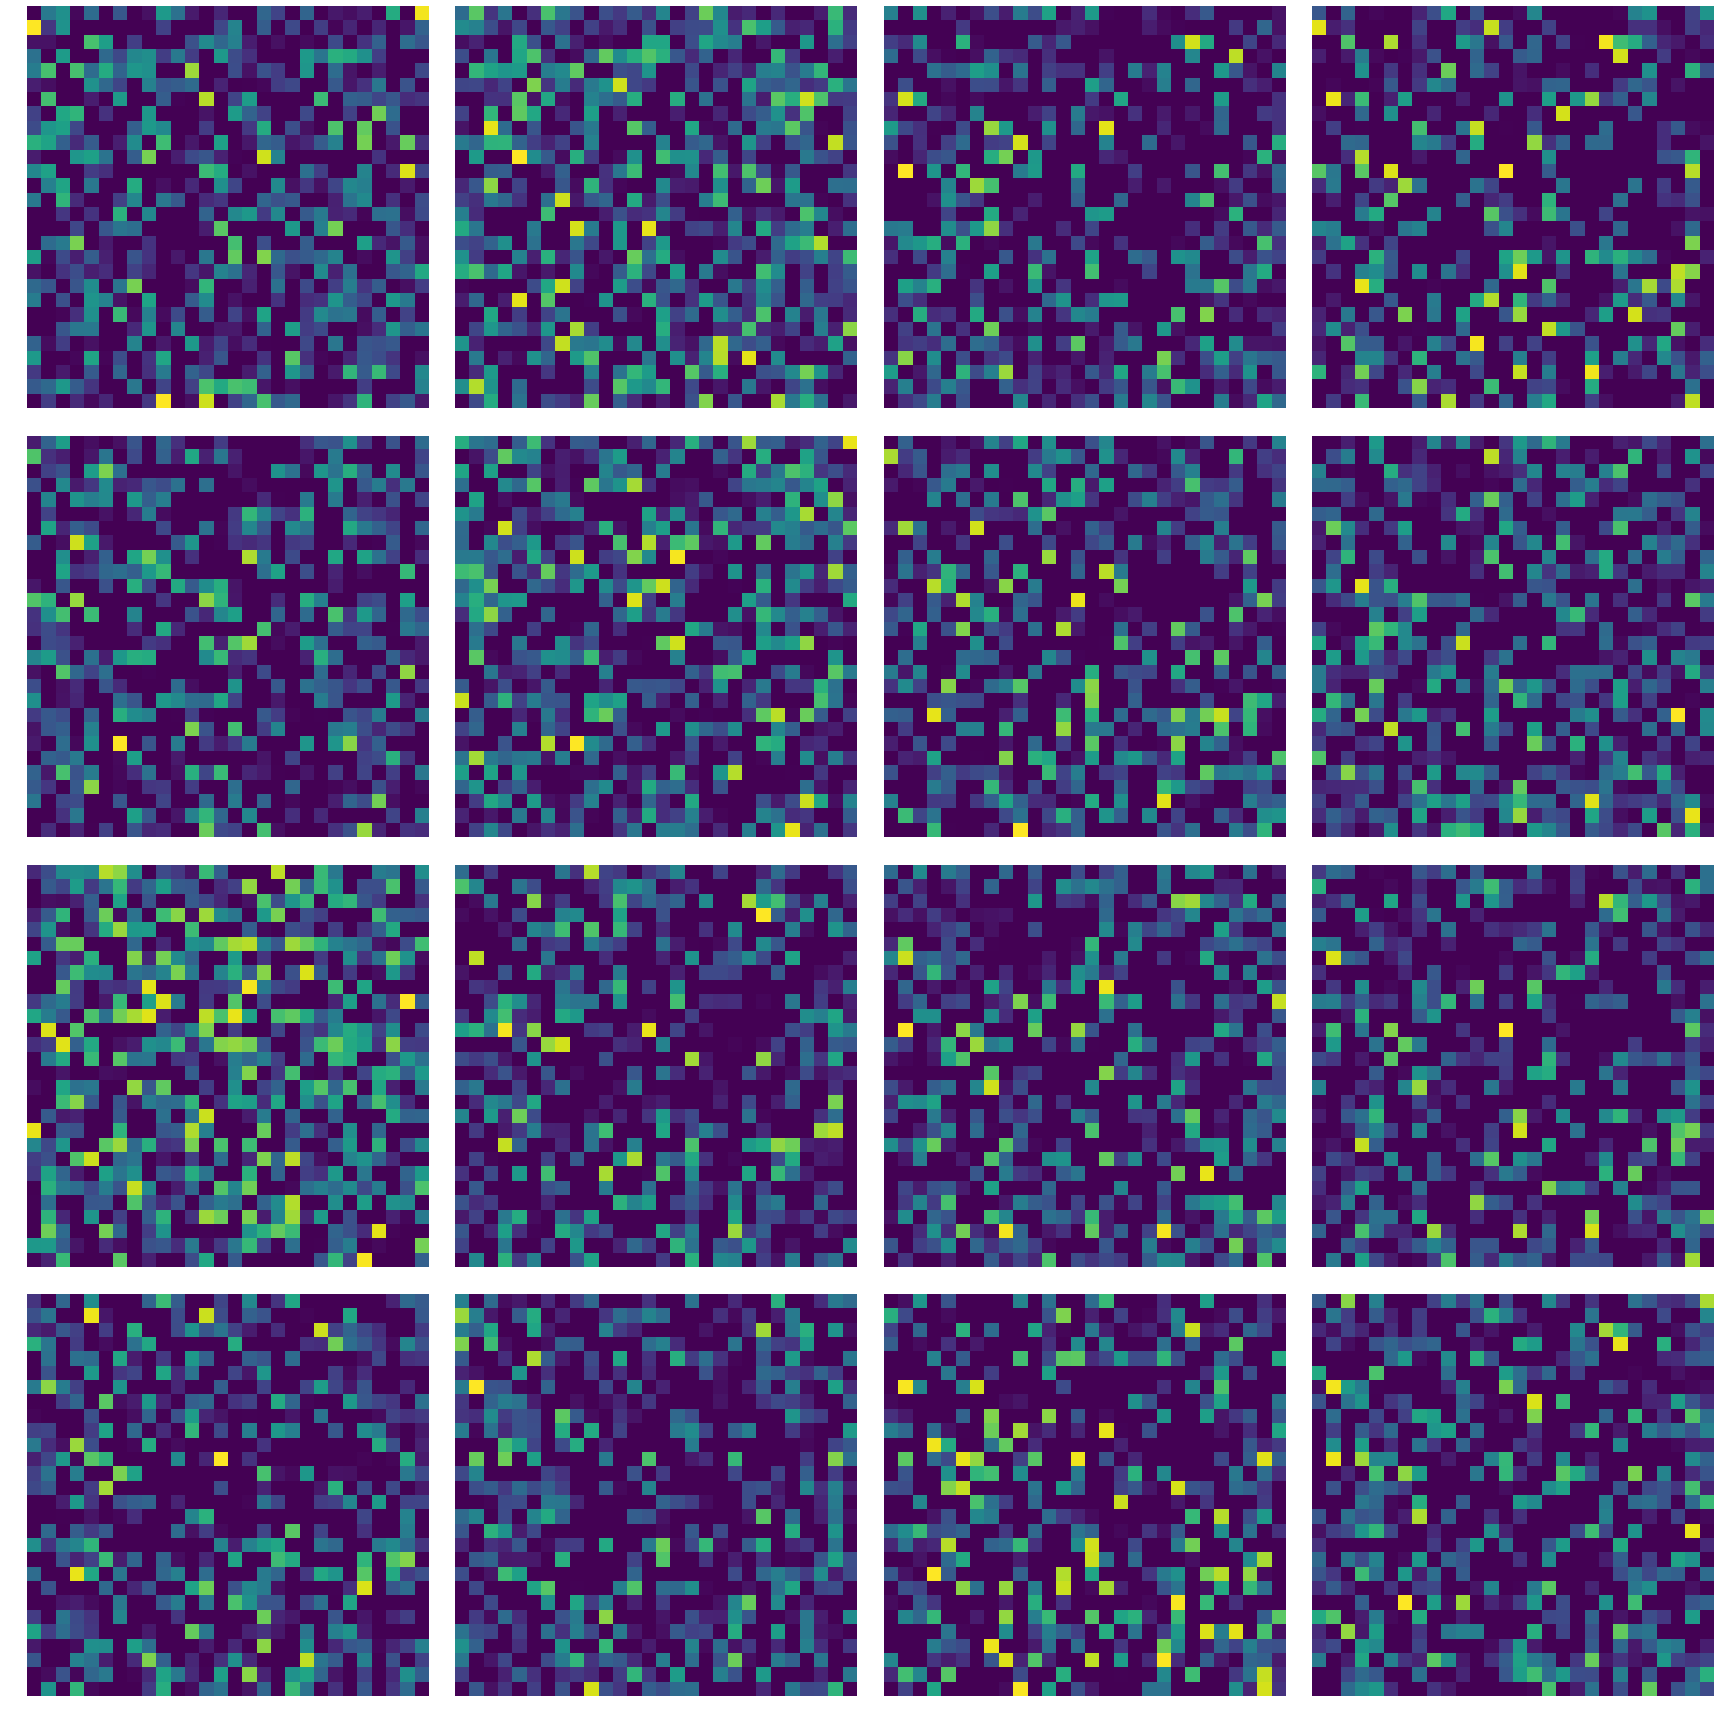

Epoch 8900, Generator loss 0.543203592300415, discriminator loss 0.0009376715170219541


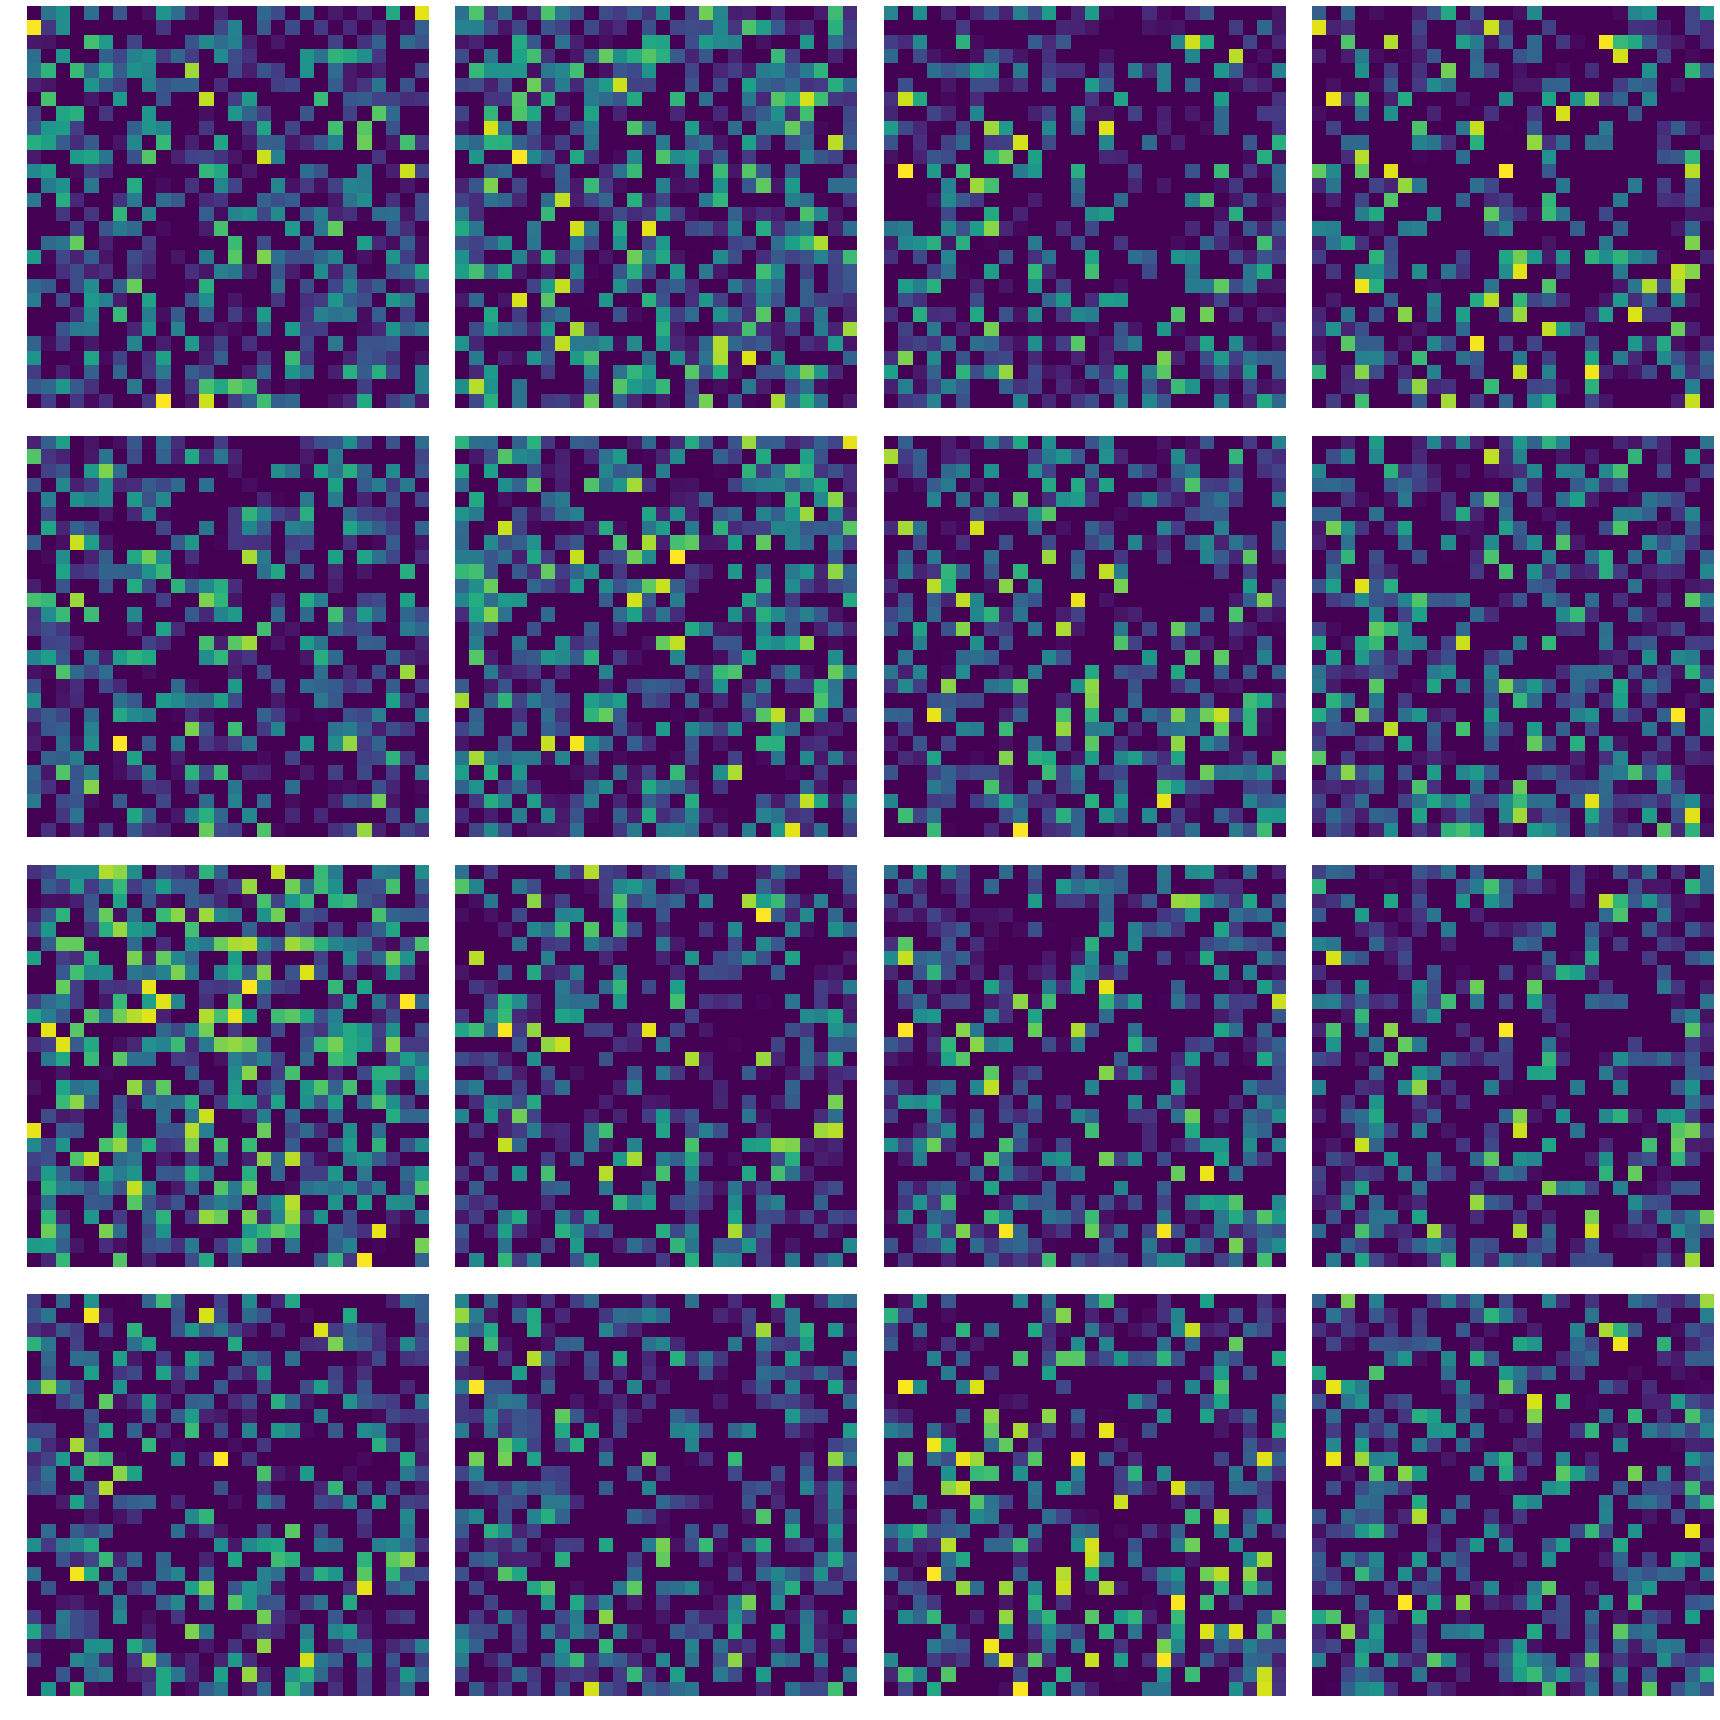

Epoch 9000, Generator loss 0.5264139175415039, discriminator loss 0.0009236058685928583


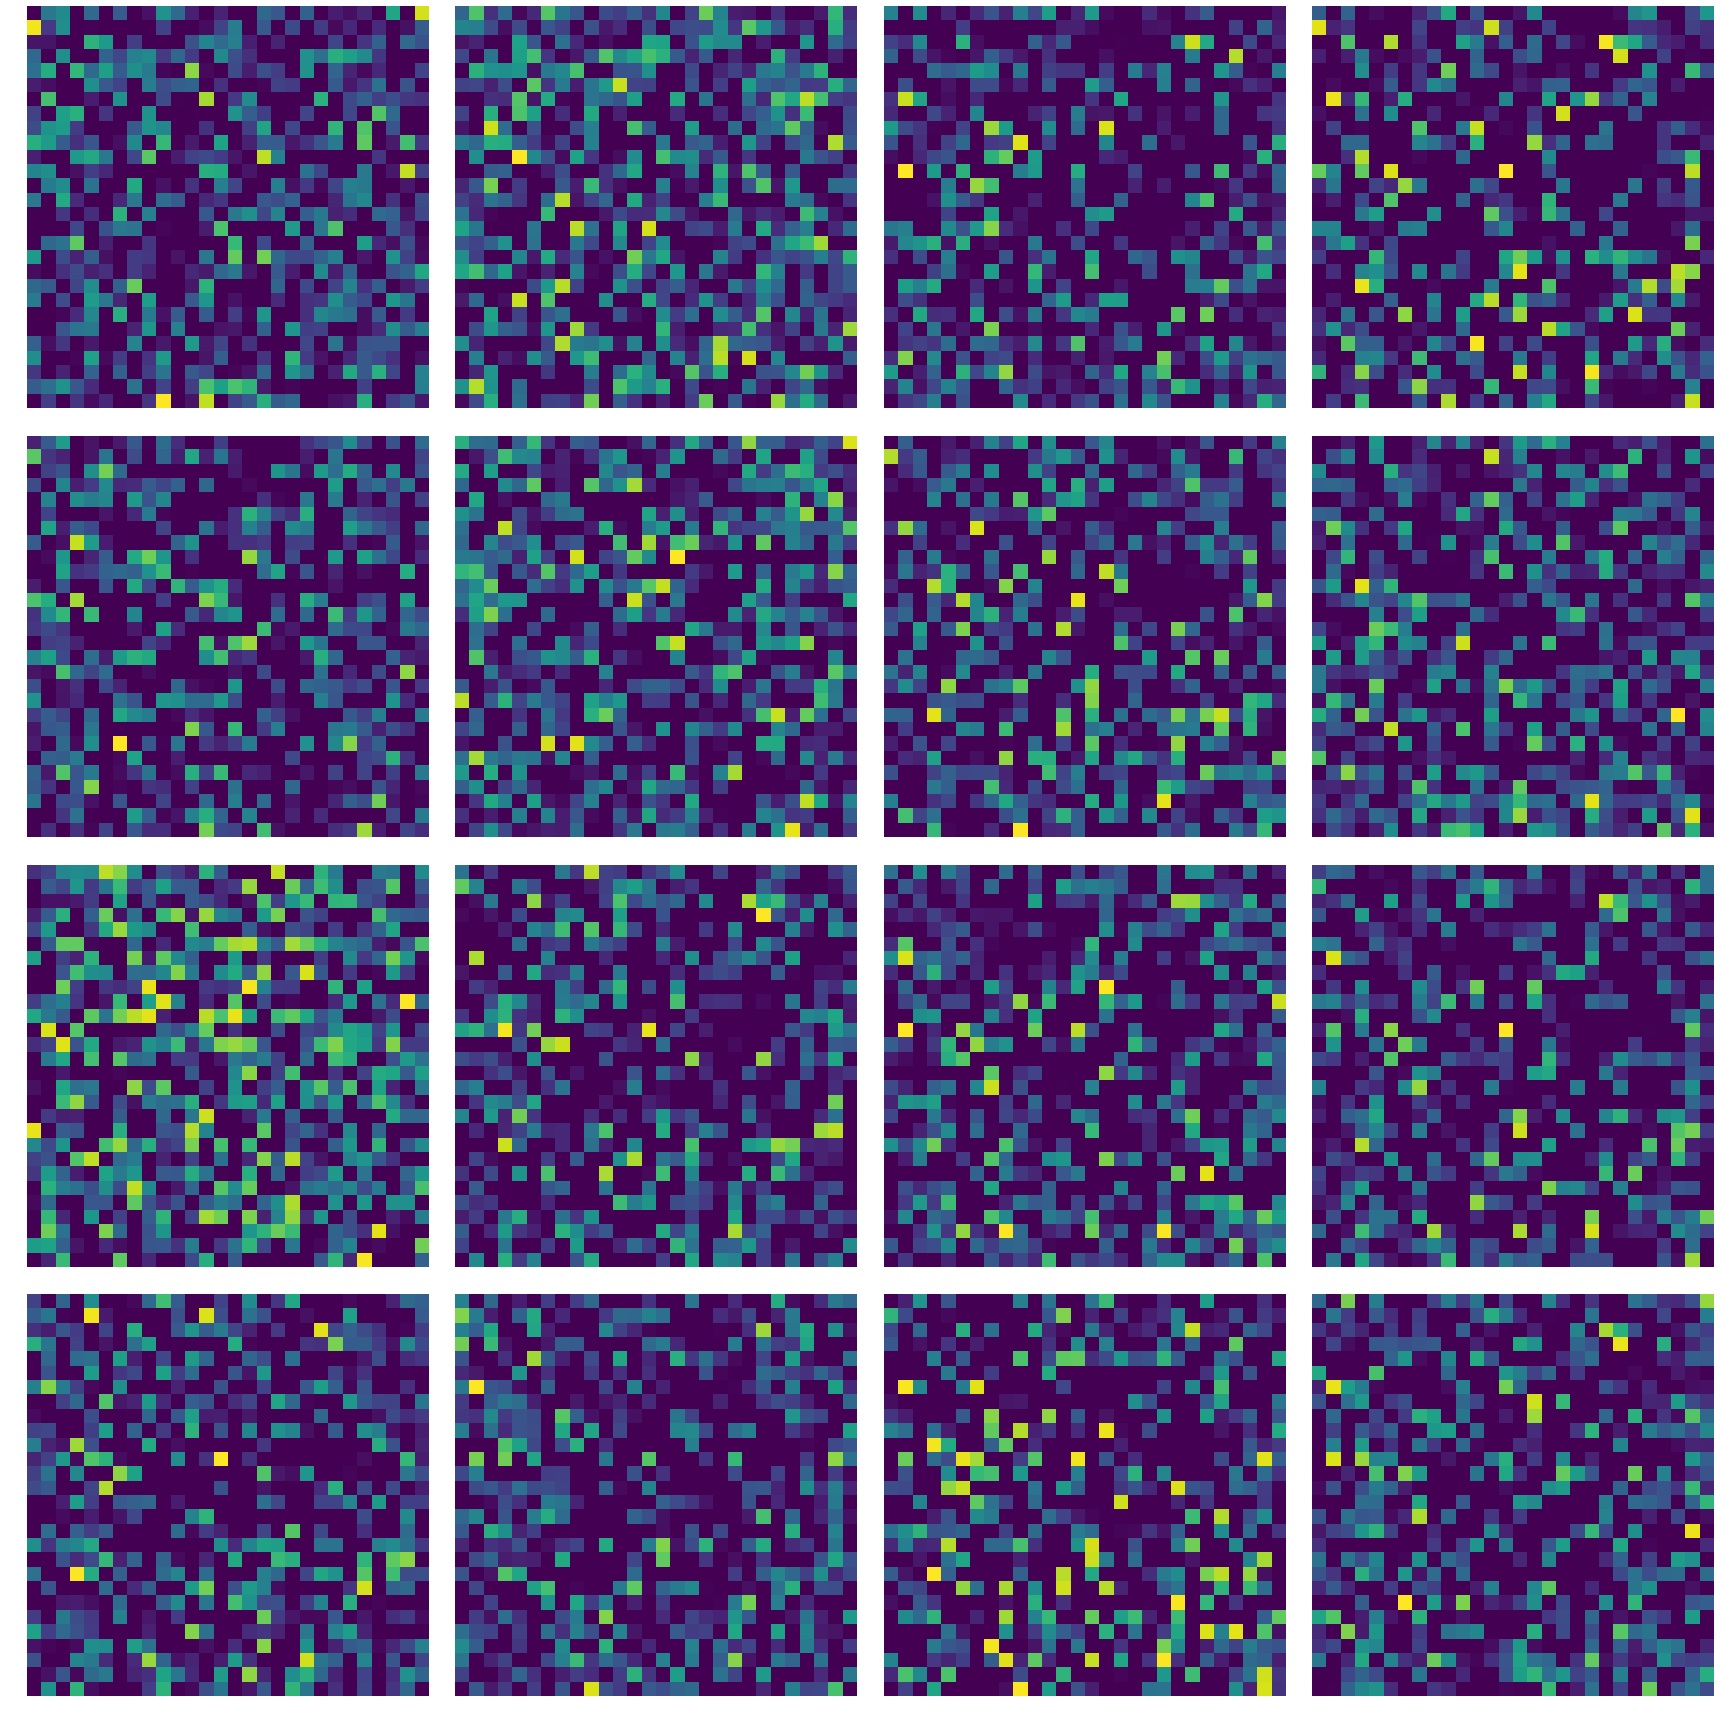

Epoch 9100, Generator loss 0.5137431621551514, discriminator loss 0.0009099436574615538


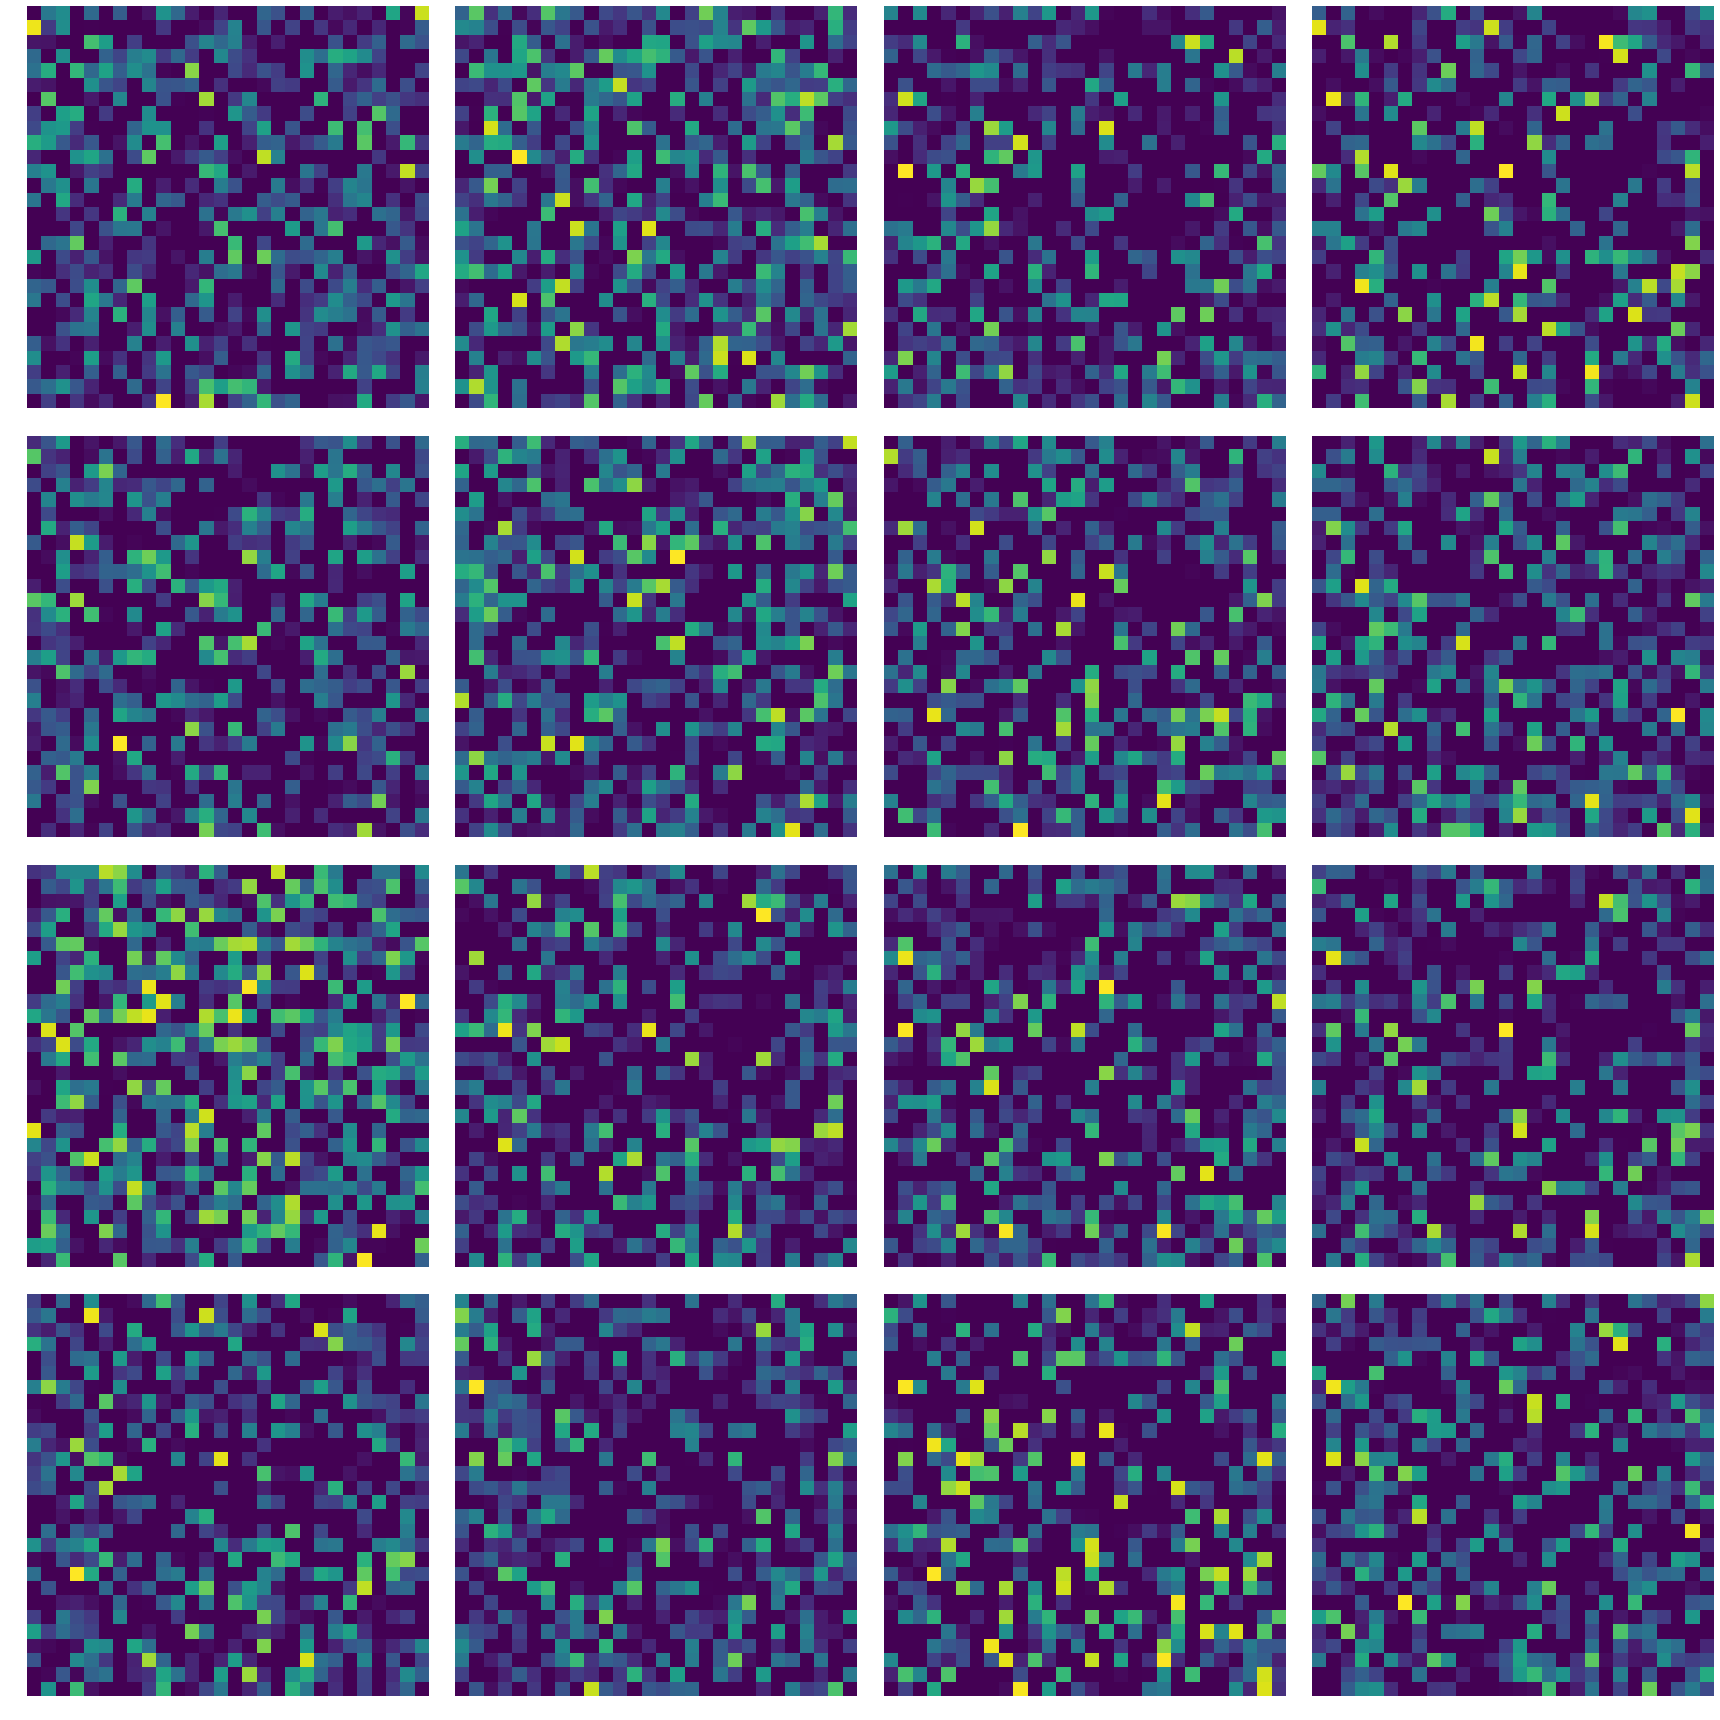

Epoch 9200, Generator loss 0.5127457976341248, discriminator loss 0.0008966757450252771


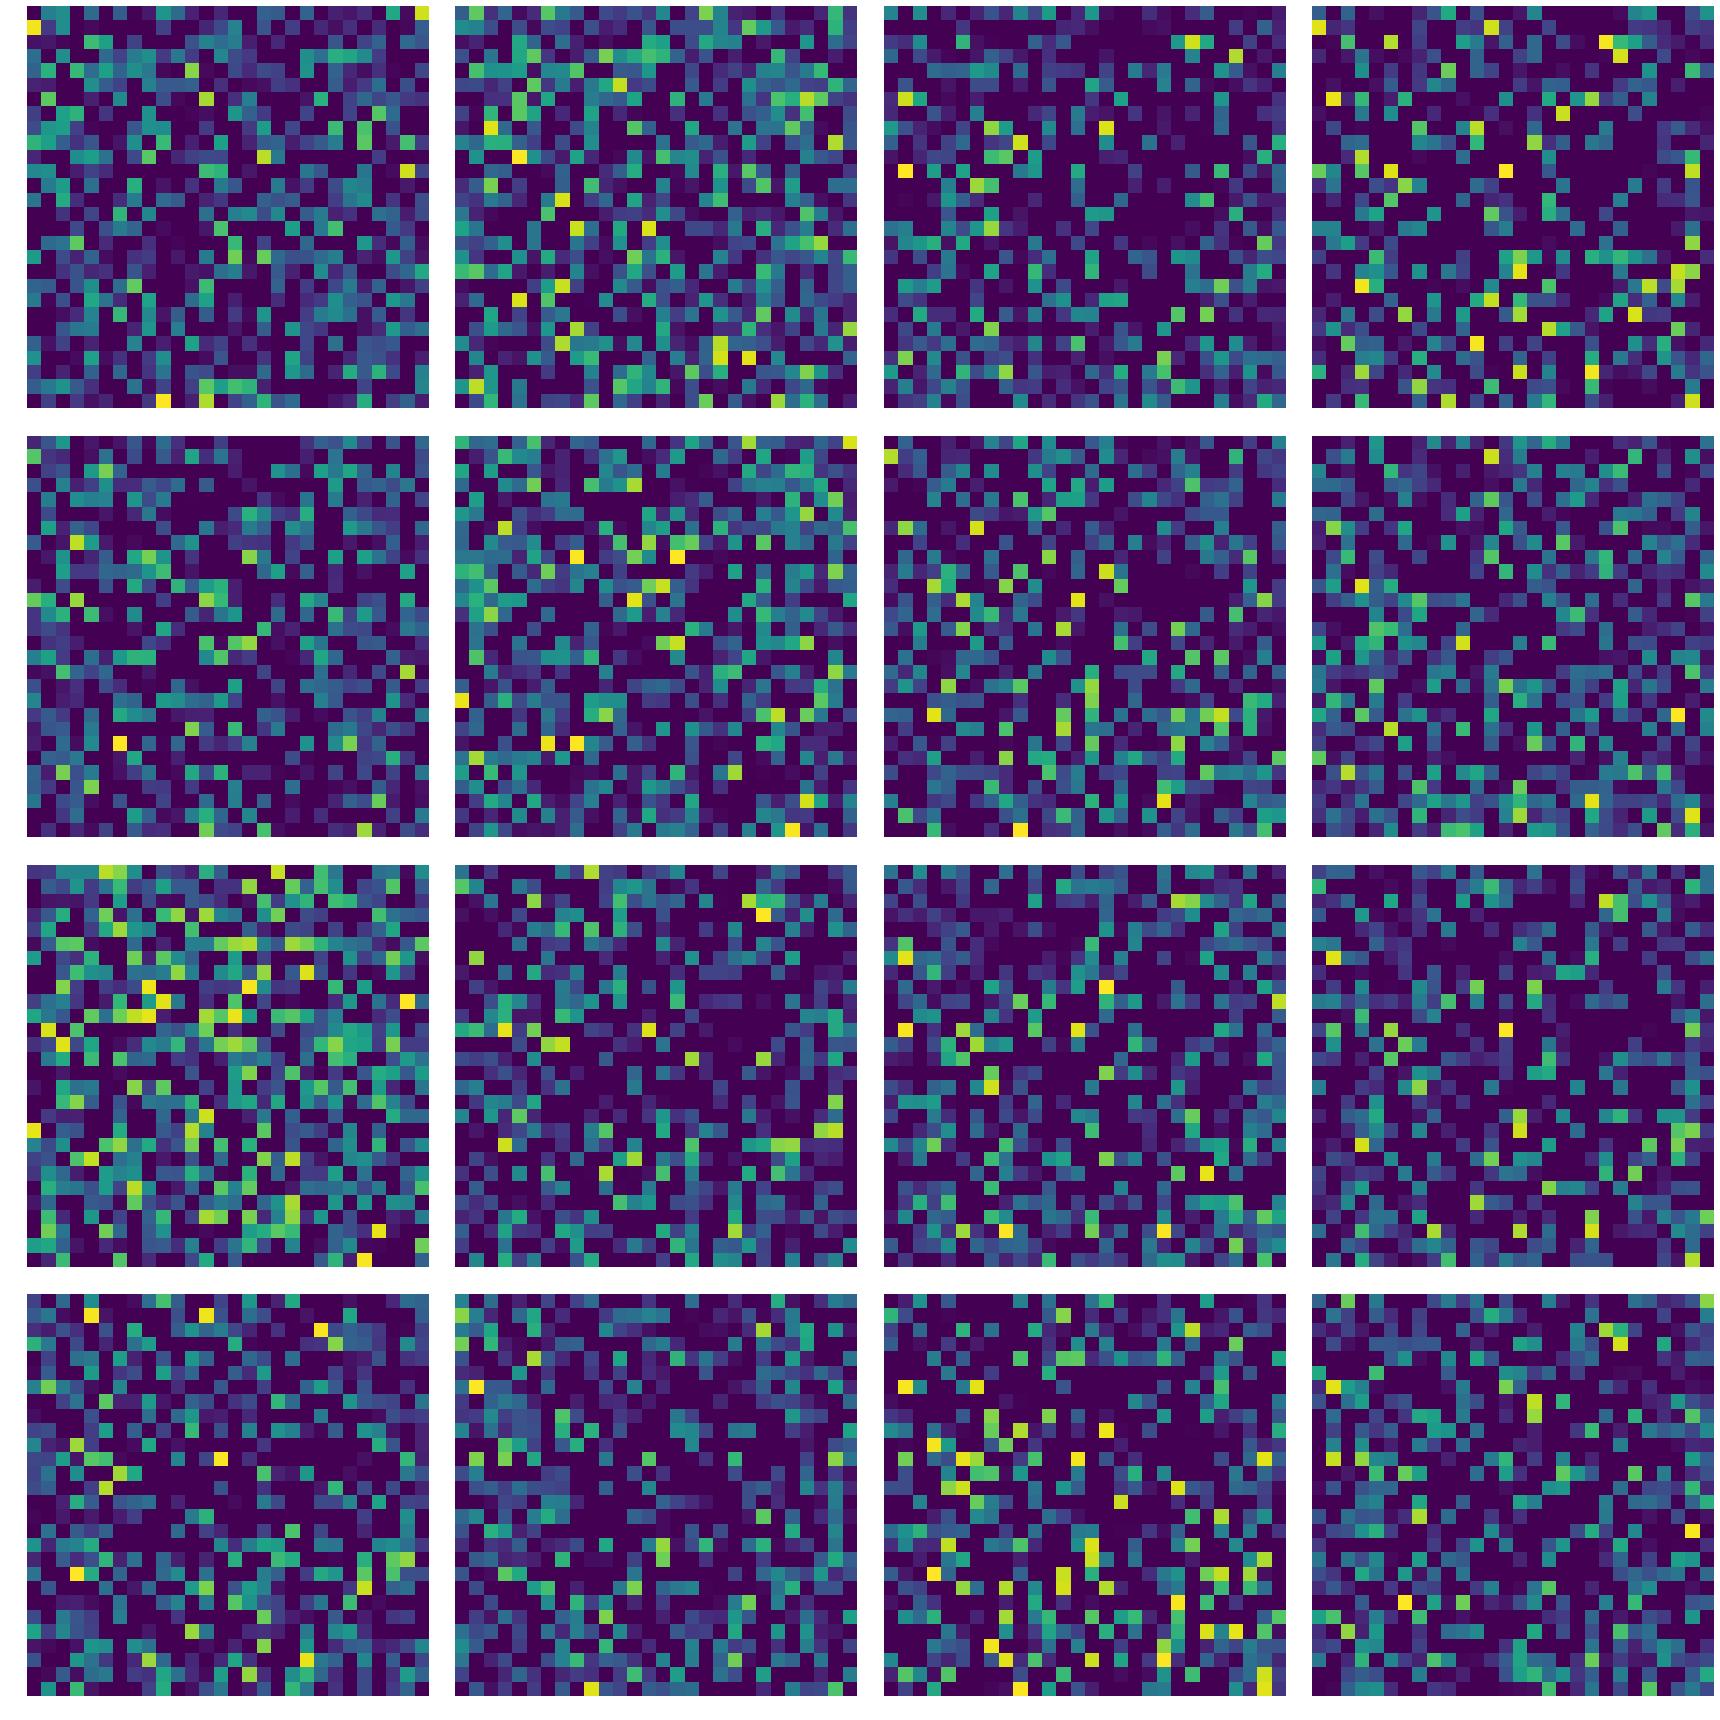

Epoch 9300, Generator loss 0.5128218531608582, discriminator loss 0.0008835638873279095


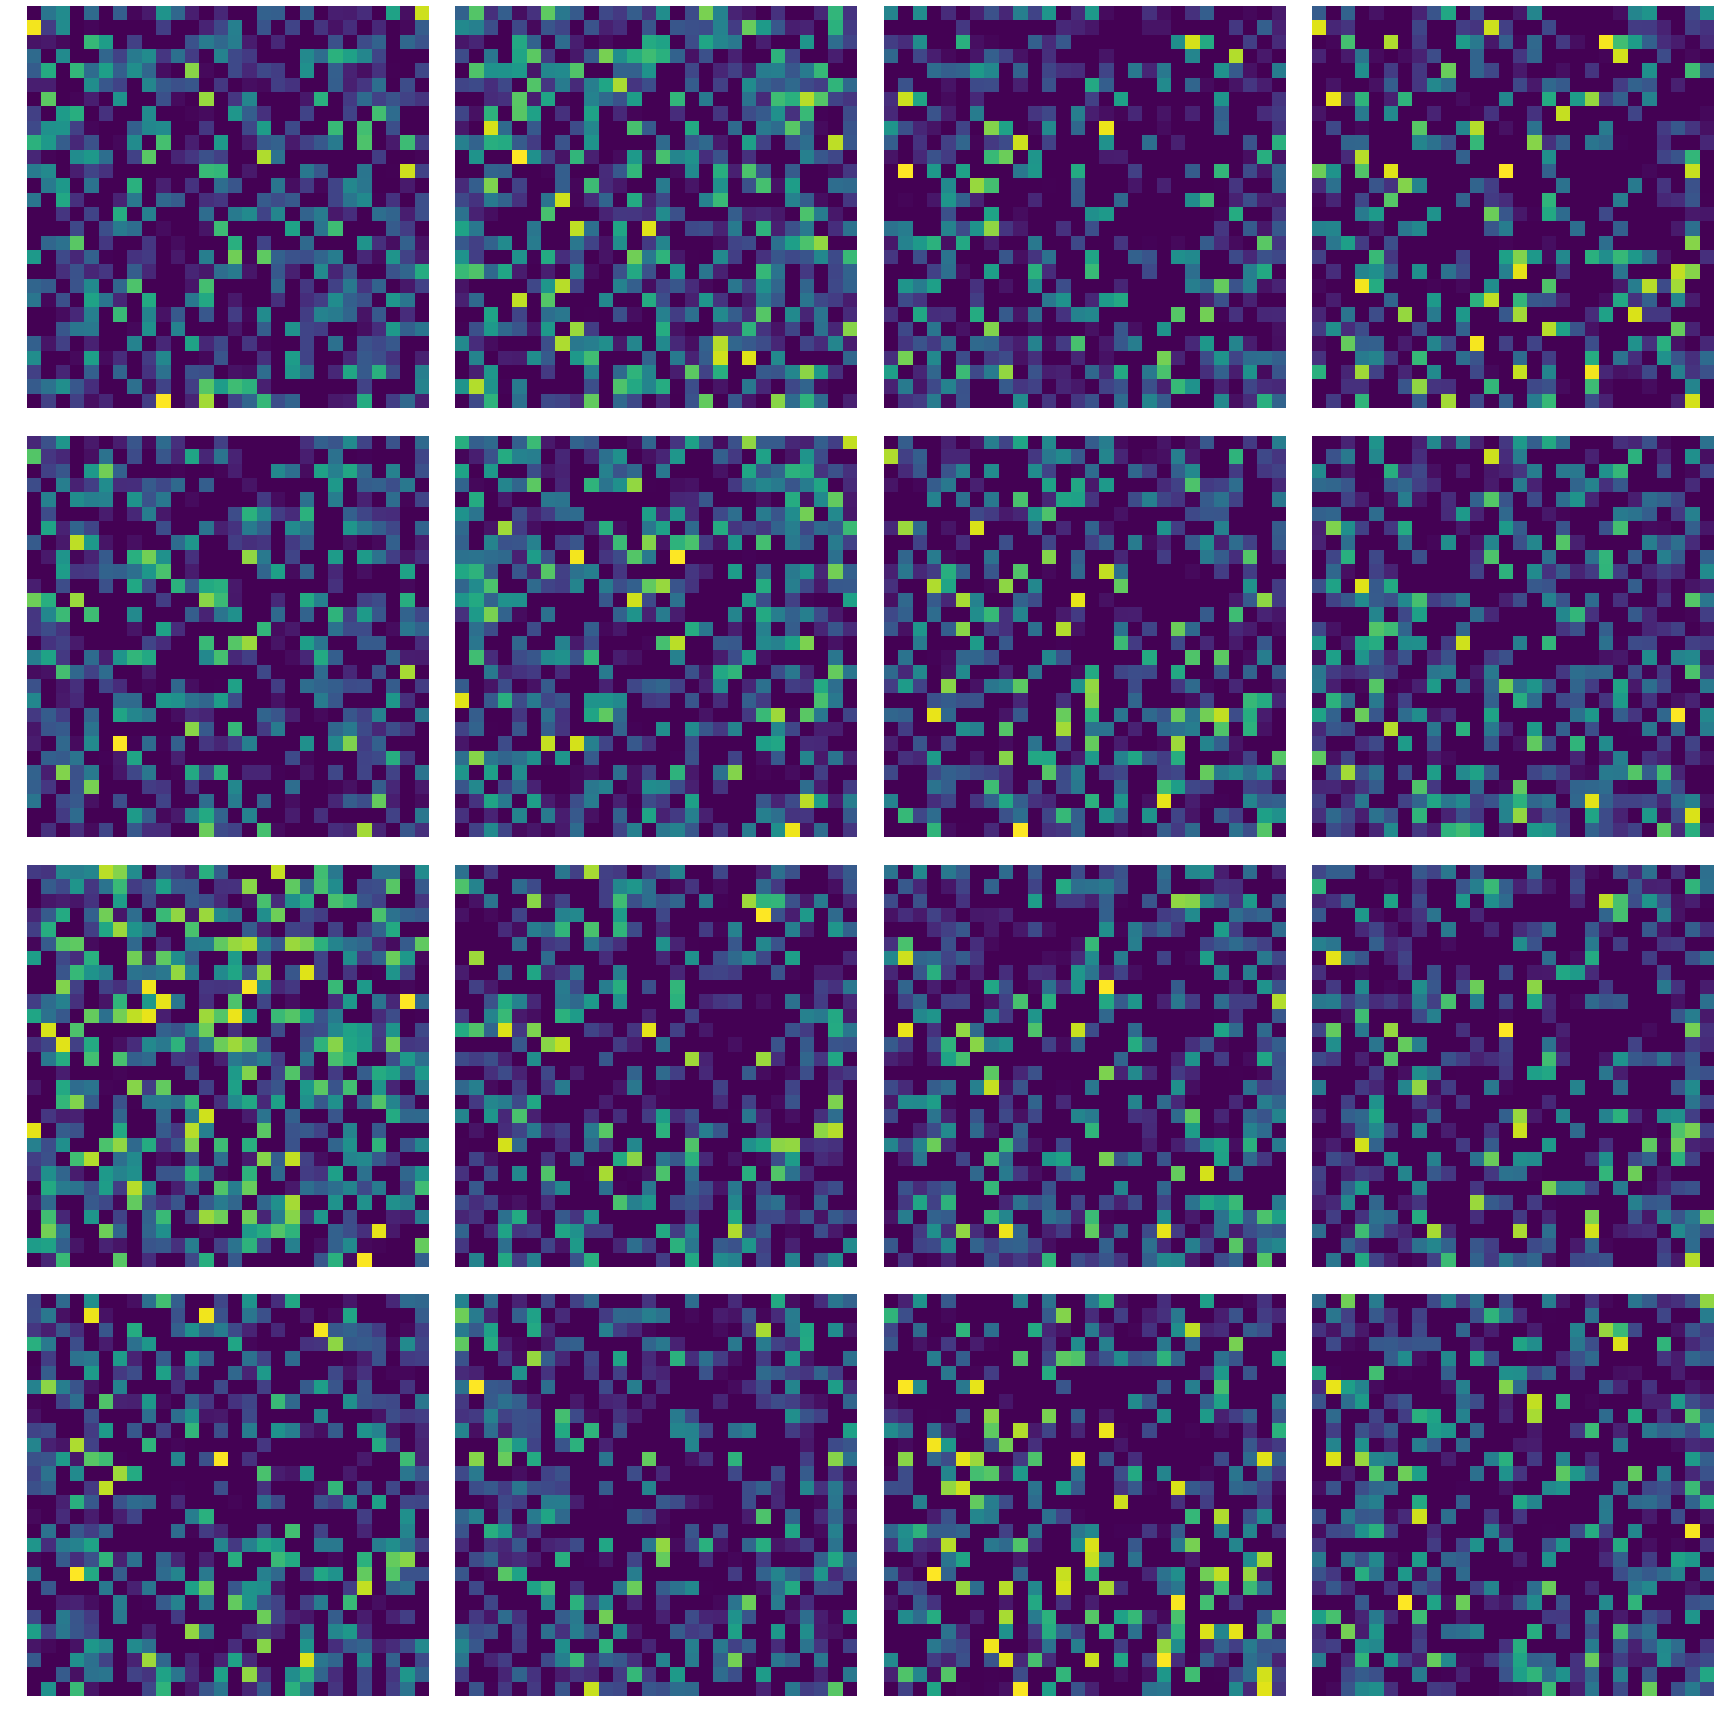

Epoch 9400, Generator loss 0.5012232065200806, discriminator loss 0.0008704802603460848


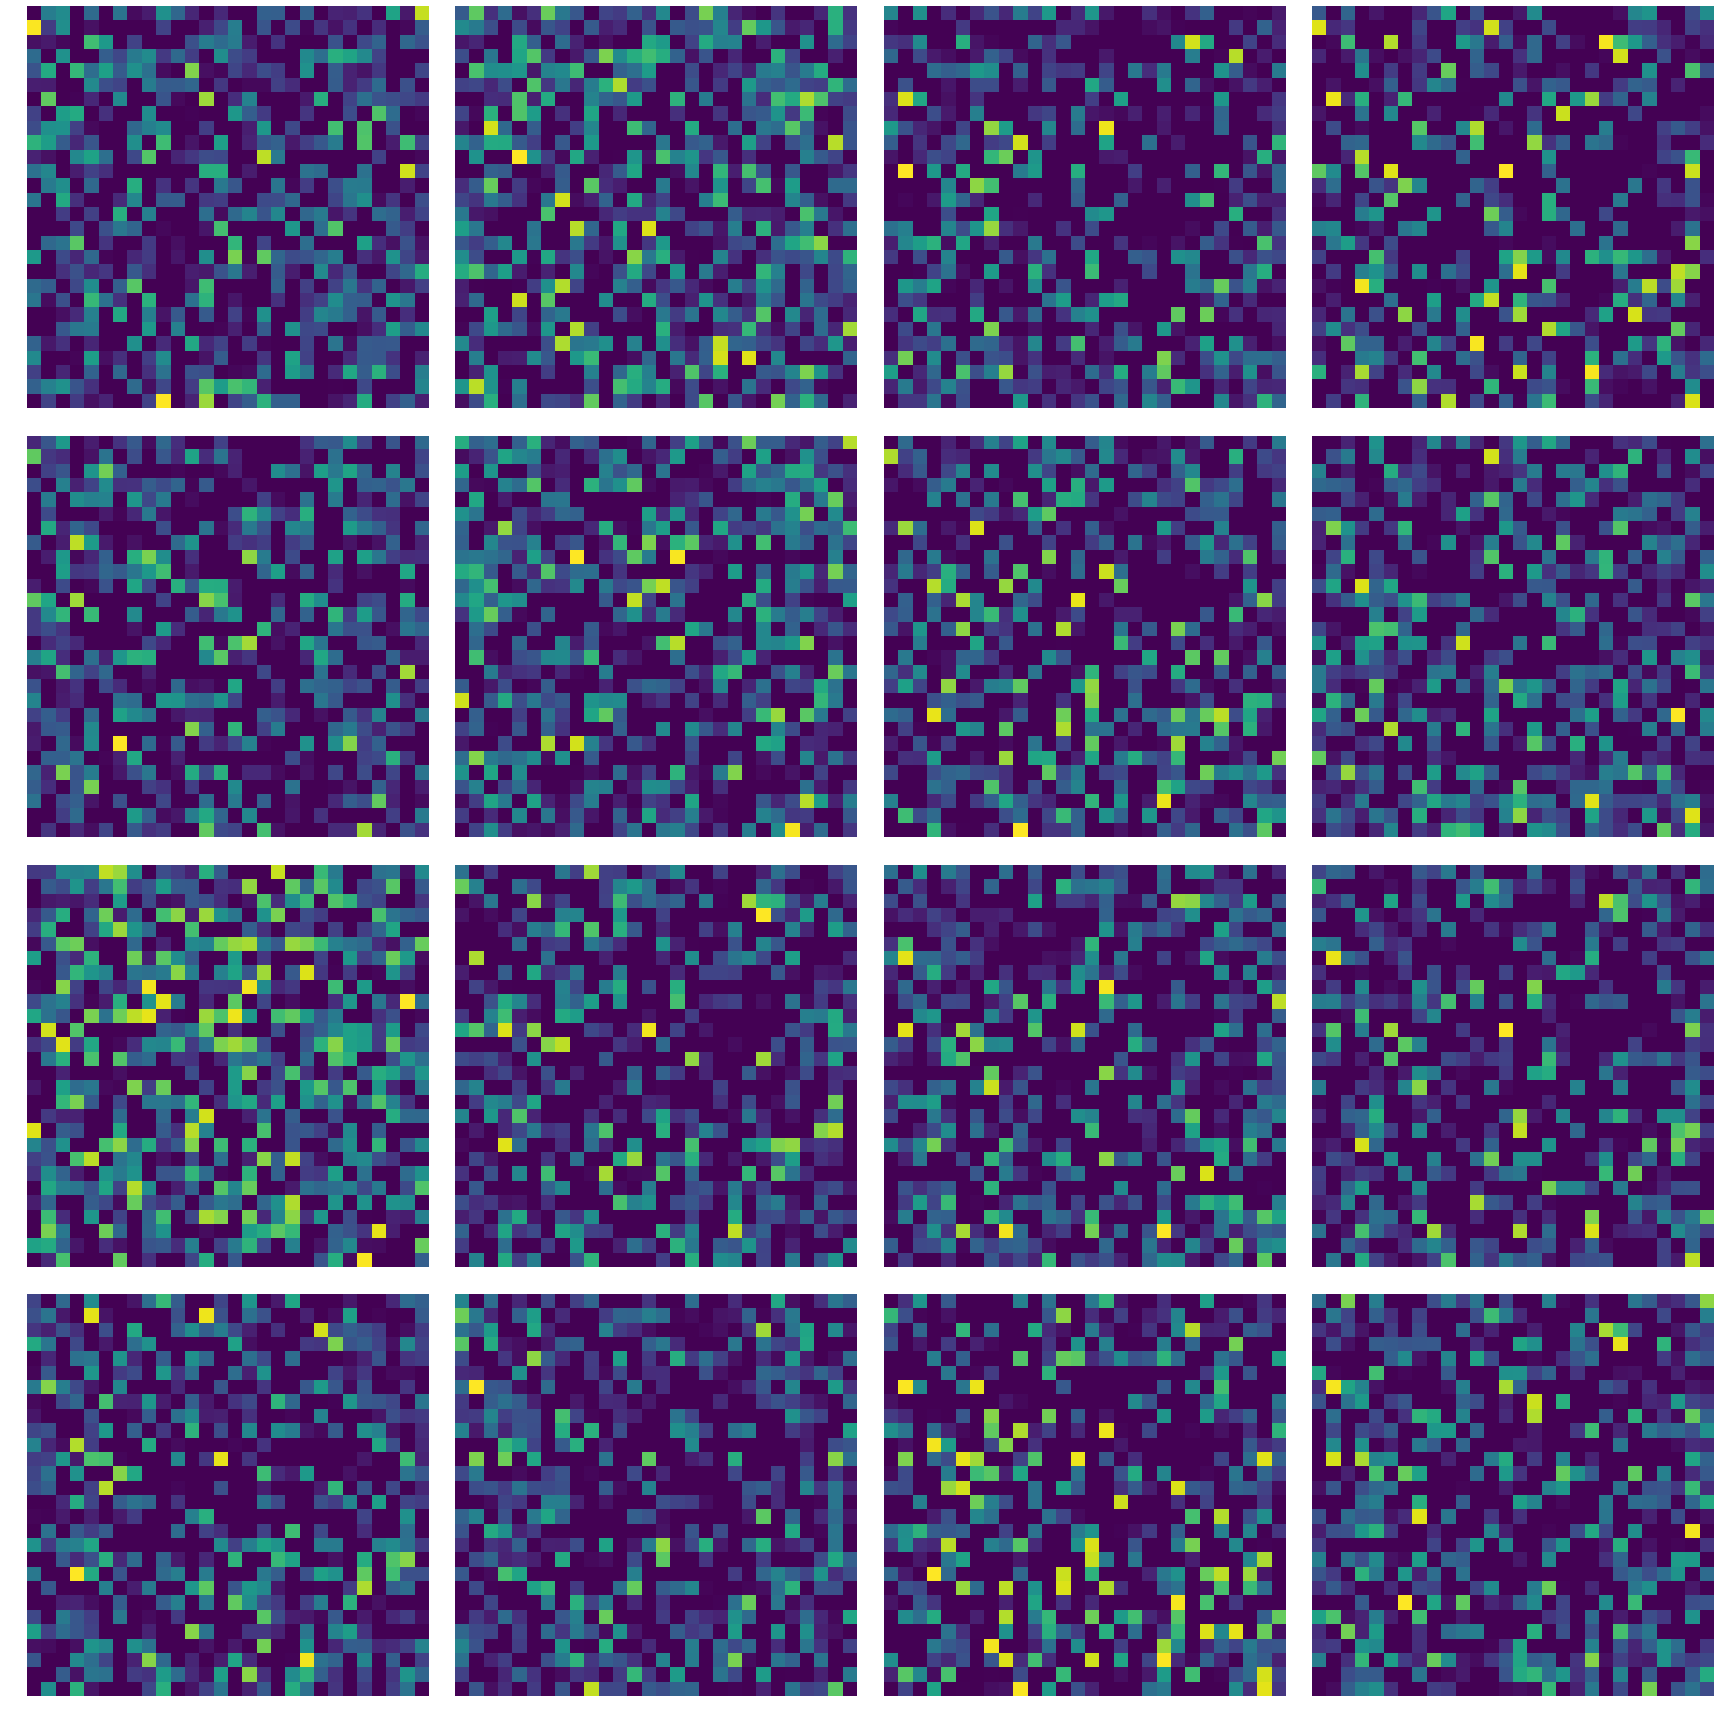

Epoch 9500, Generator loss 0.5120431184768677, discriminator loss 0.0008580083376727998


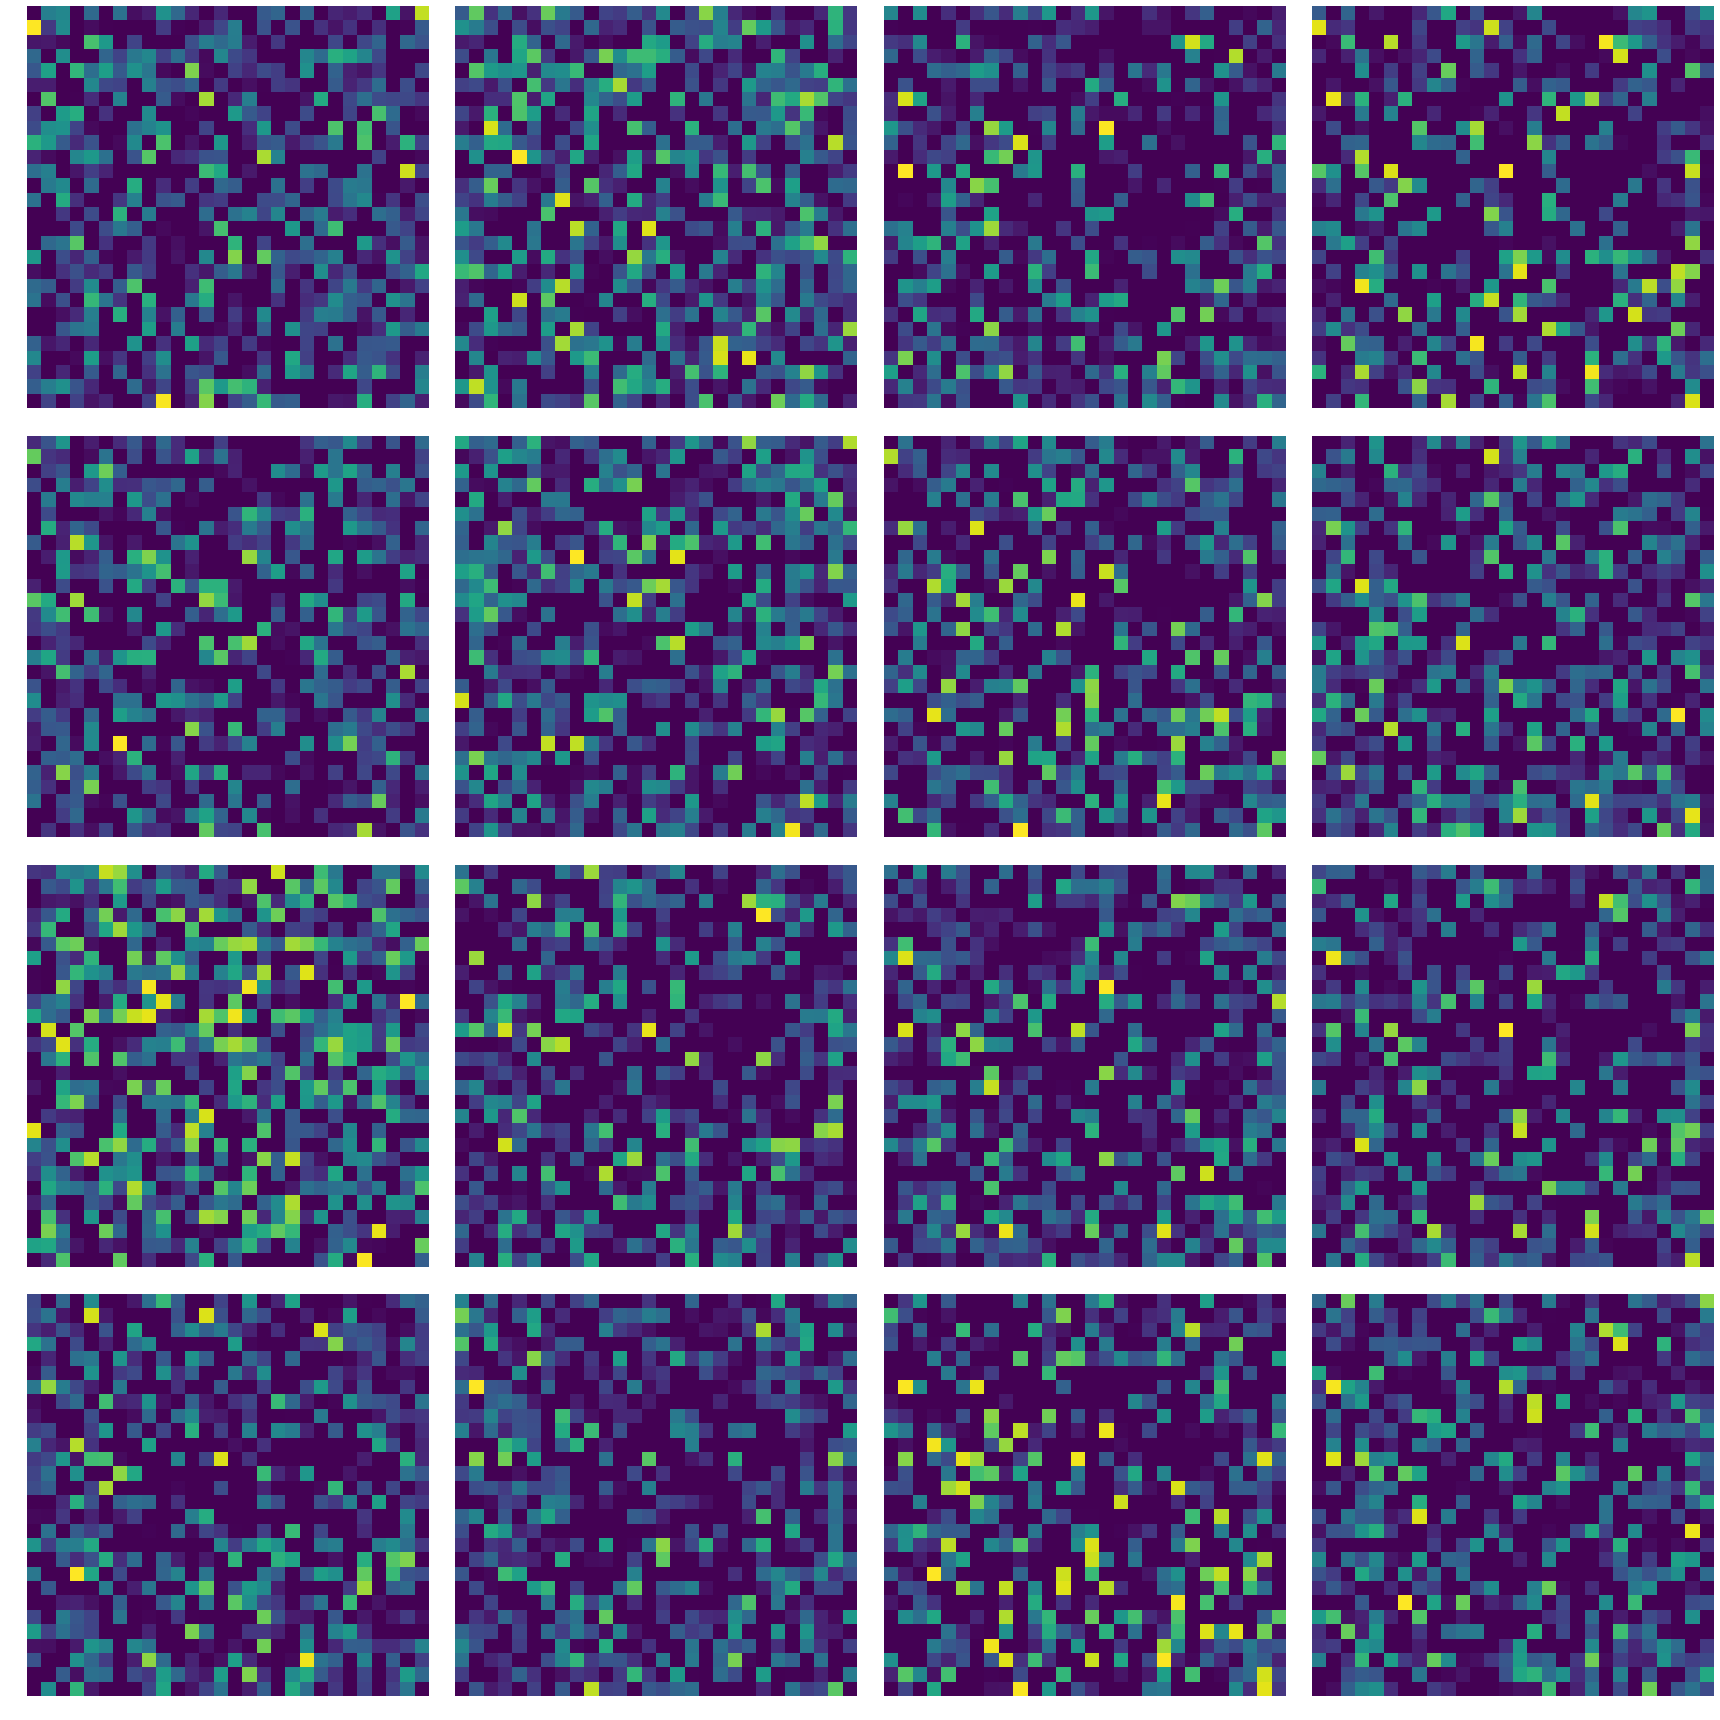

Epoch 9600, Generator loss 0.4995500147342682, discriminator loss 0.0008458843221887946


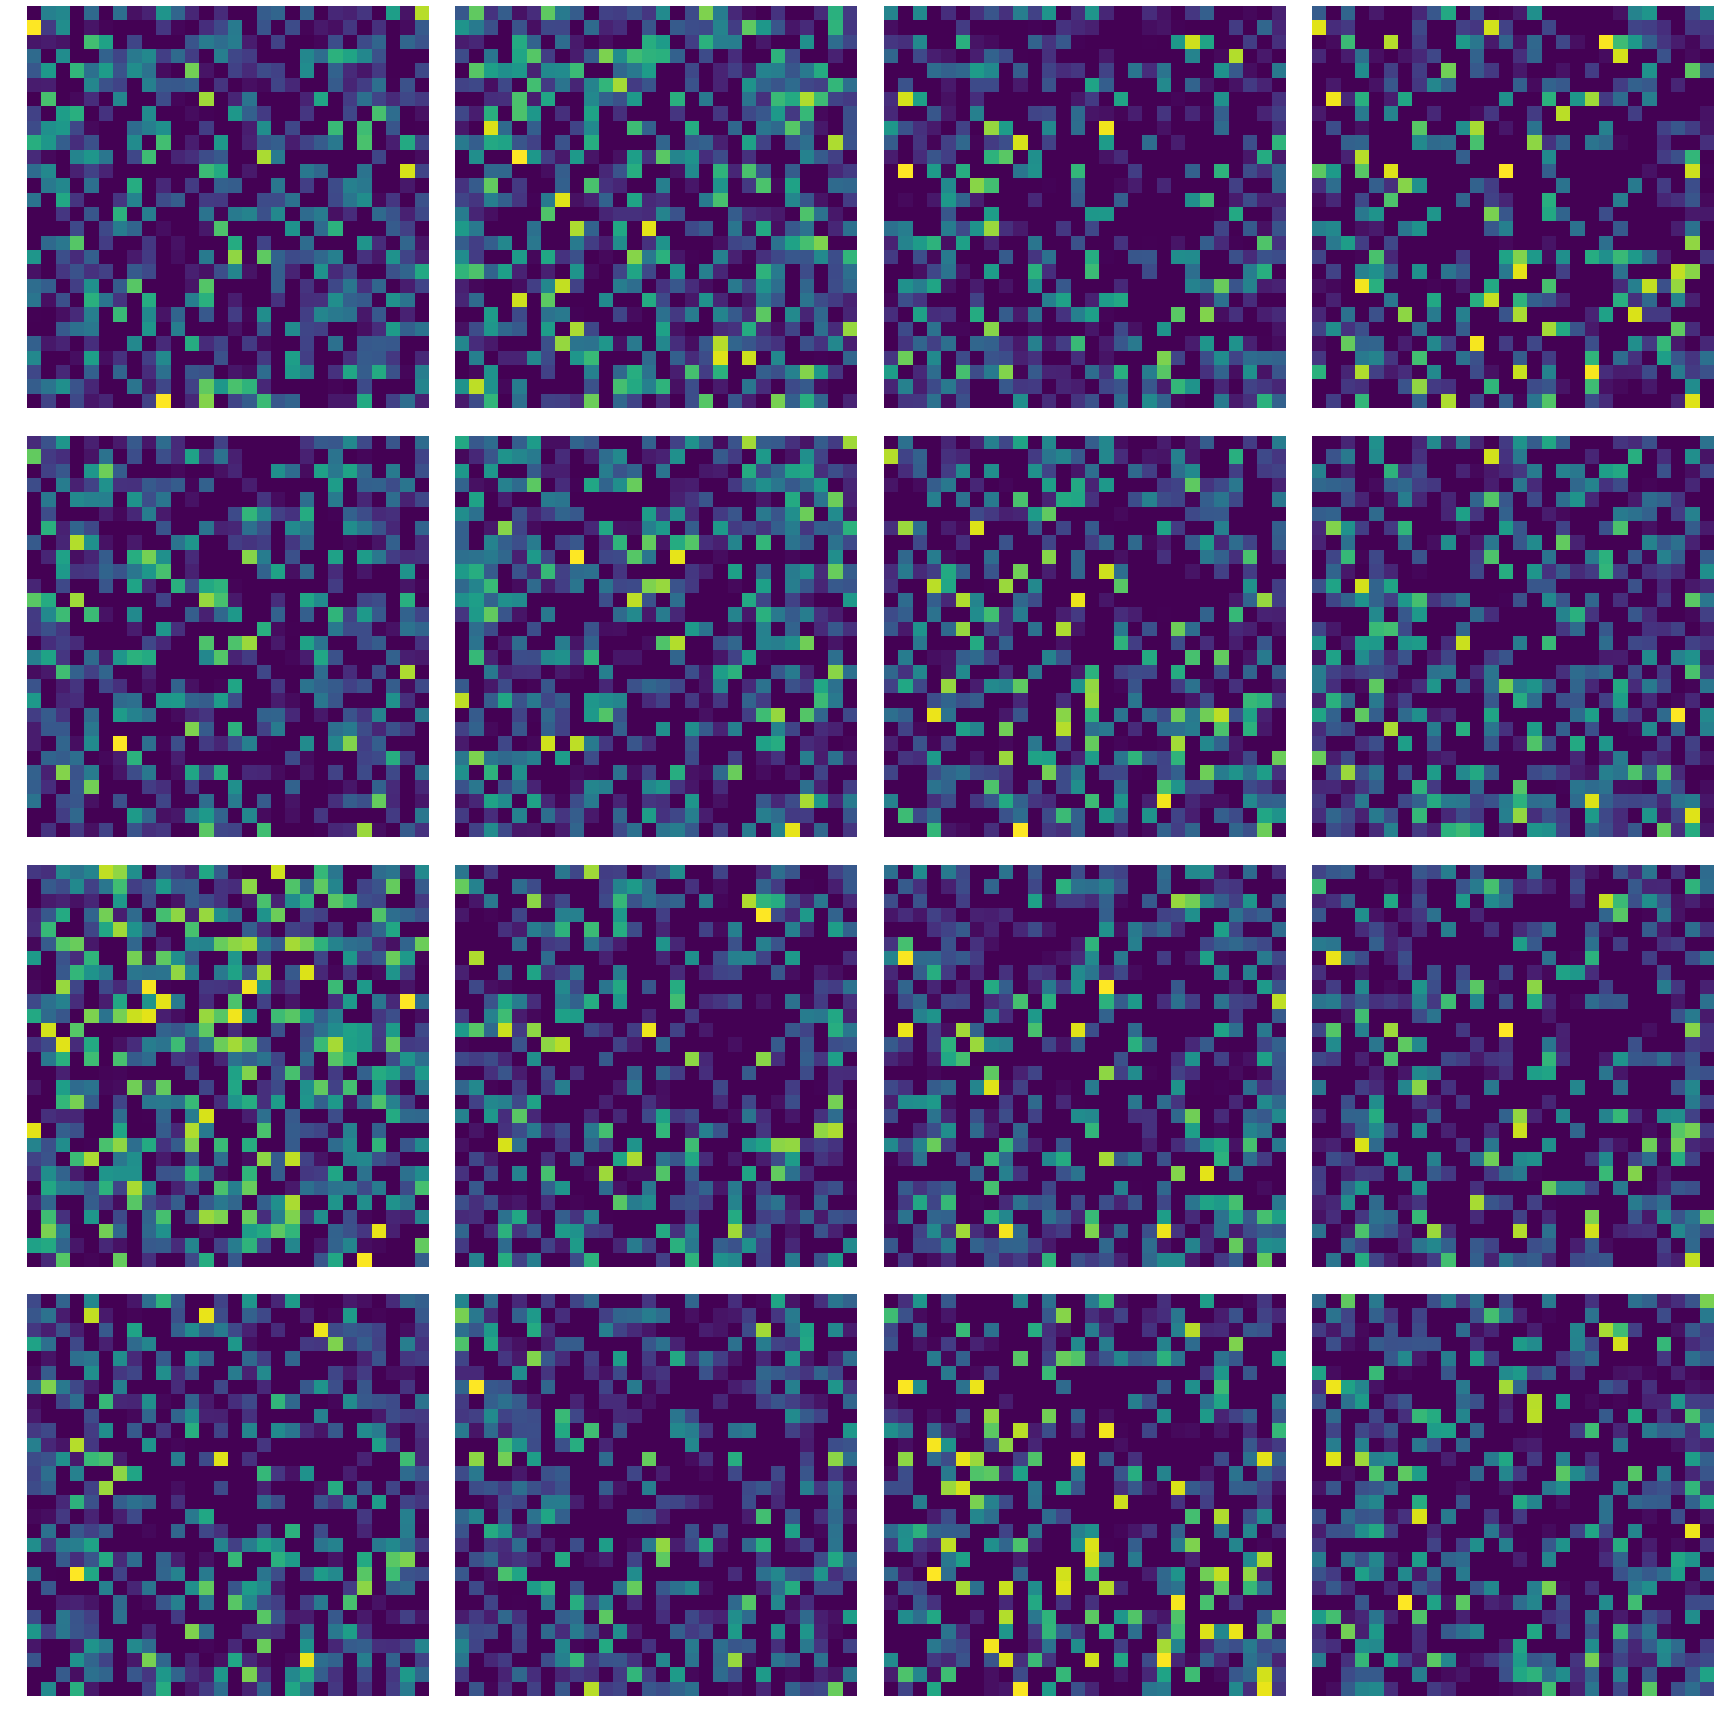

Epoch 9700, Generator loss 0.48807448148727417, discriminator loss 0.000833462574519217


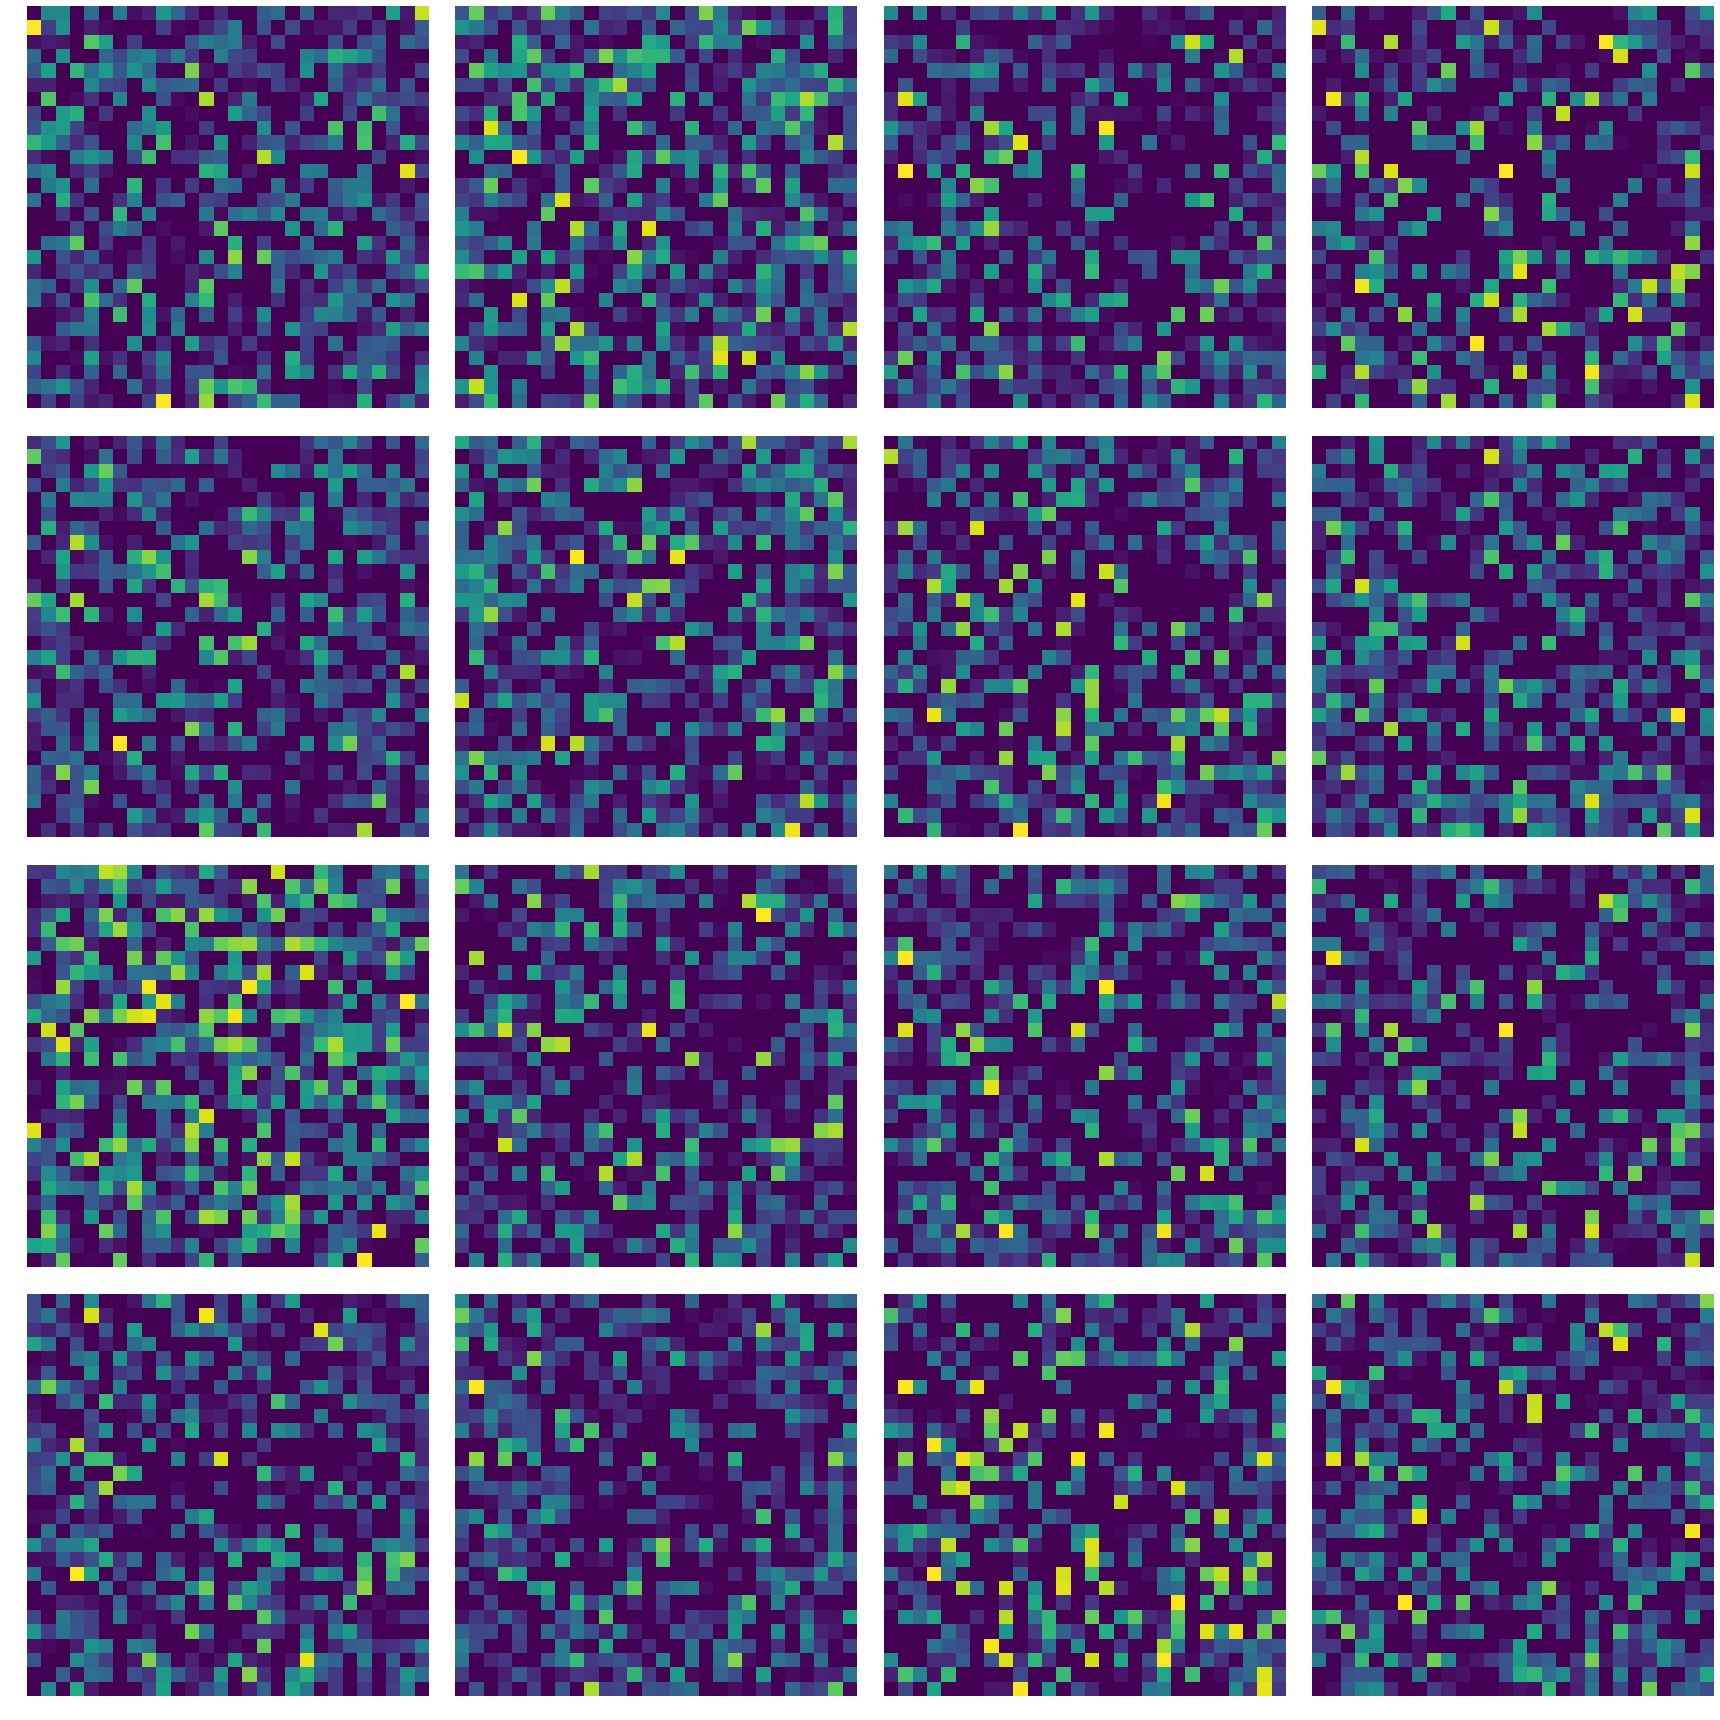

Epoch 9800, Generator loss 0.4999096989631653, discriminator loss 0.0008213758701458573


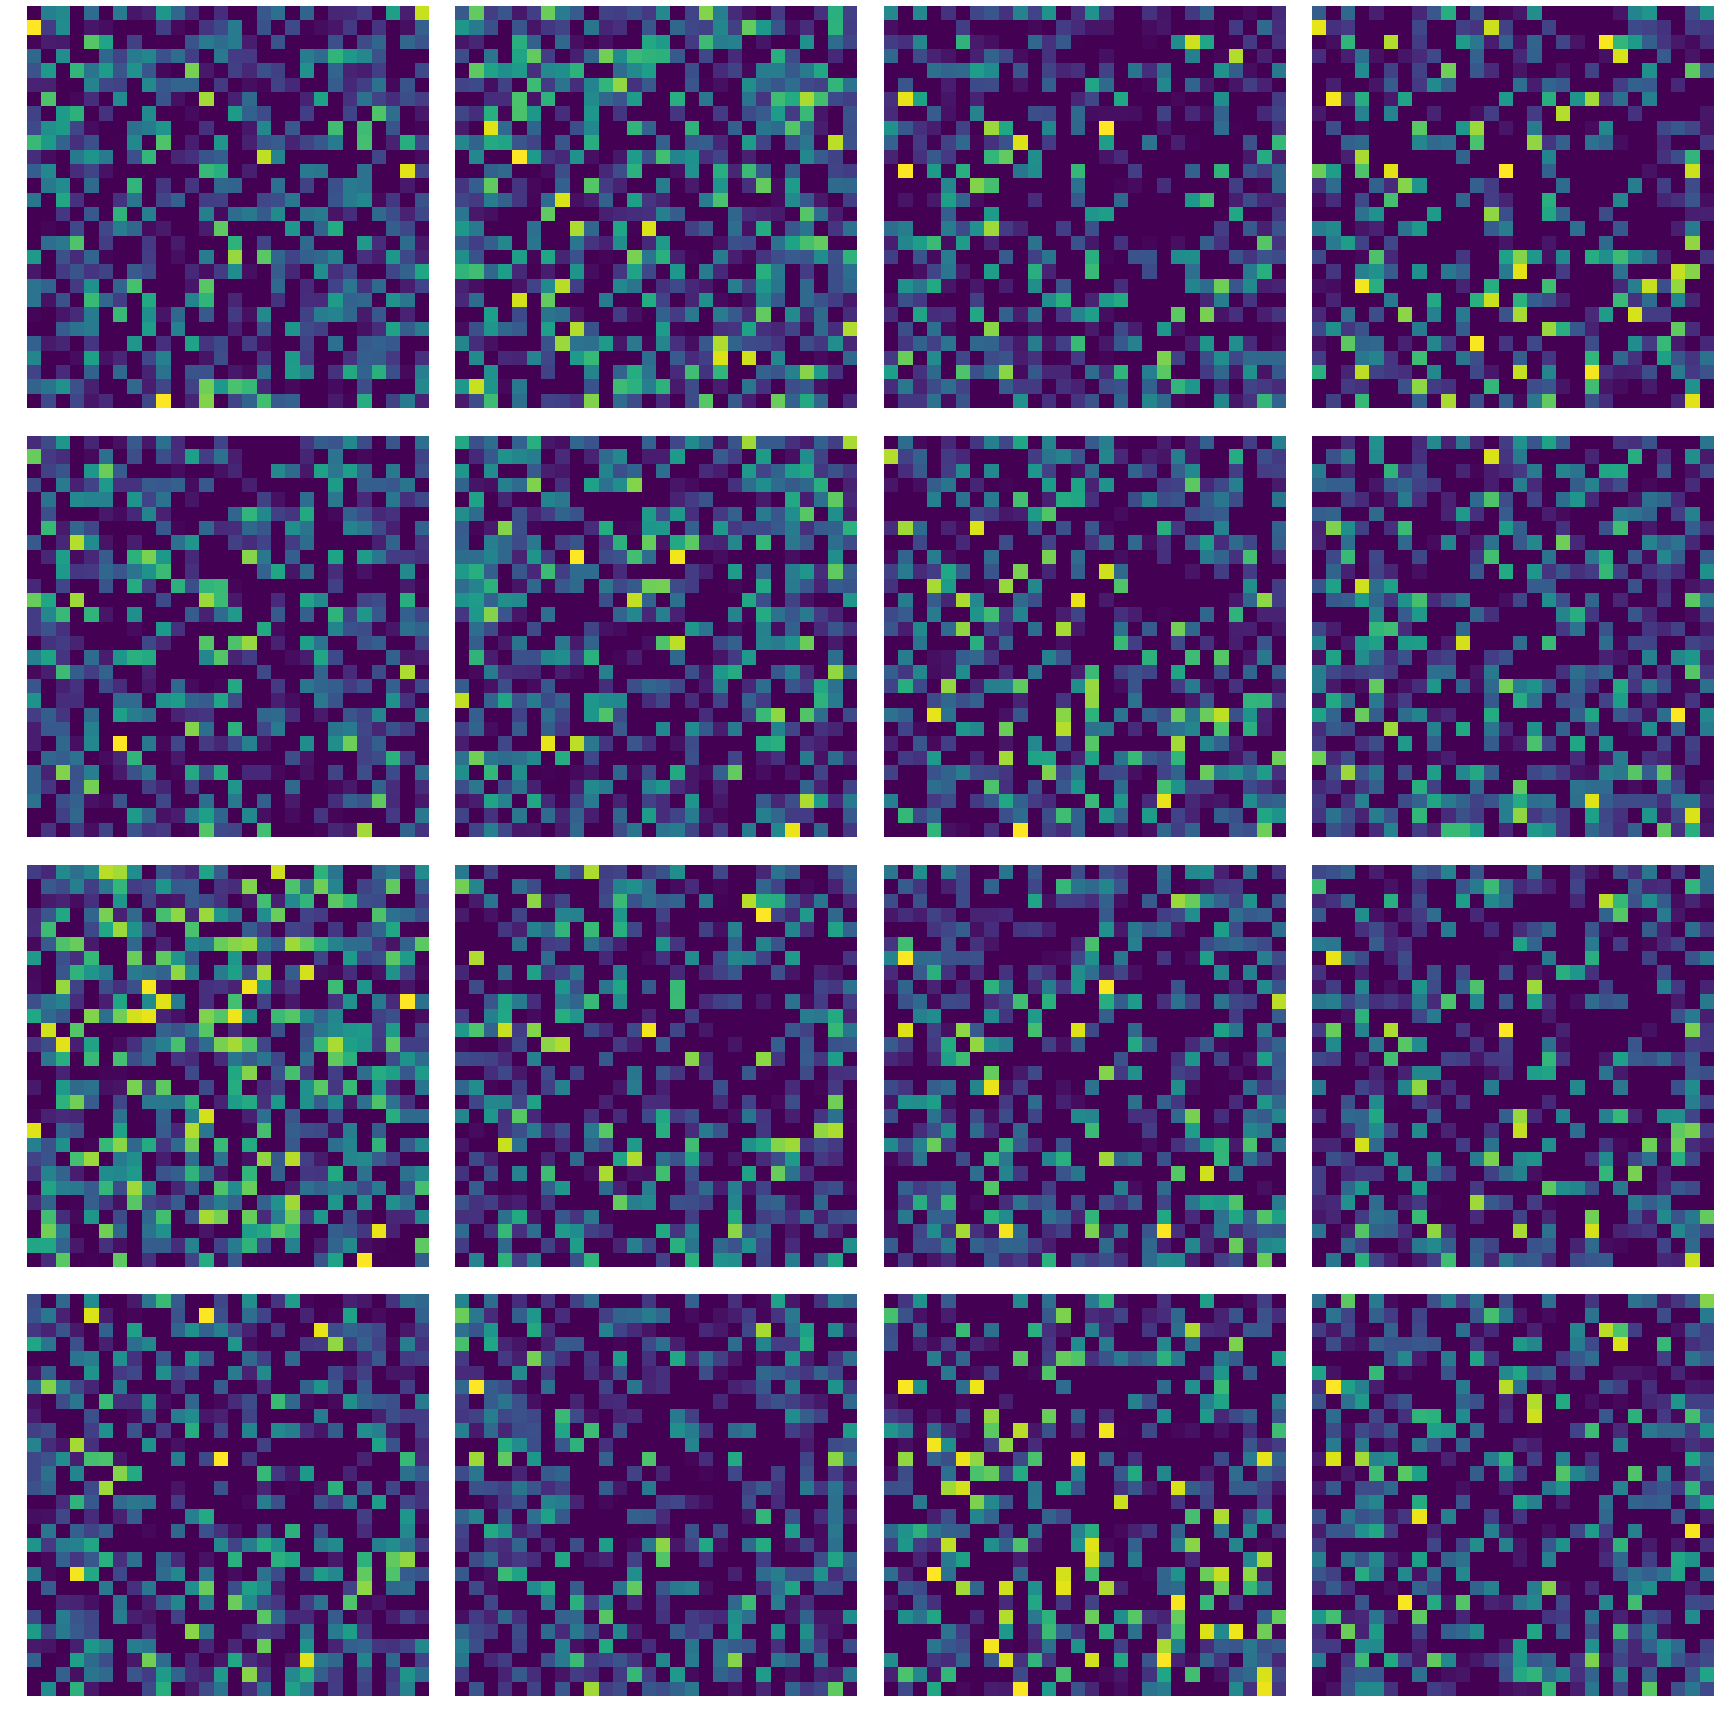

Epoch 9900, Generator loss 0.5009032487869263, discriminator loss 0.0008097317768260837


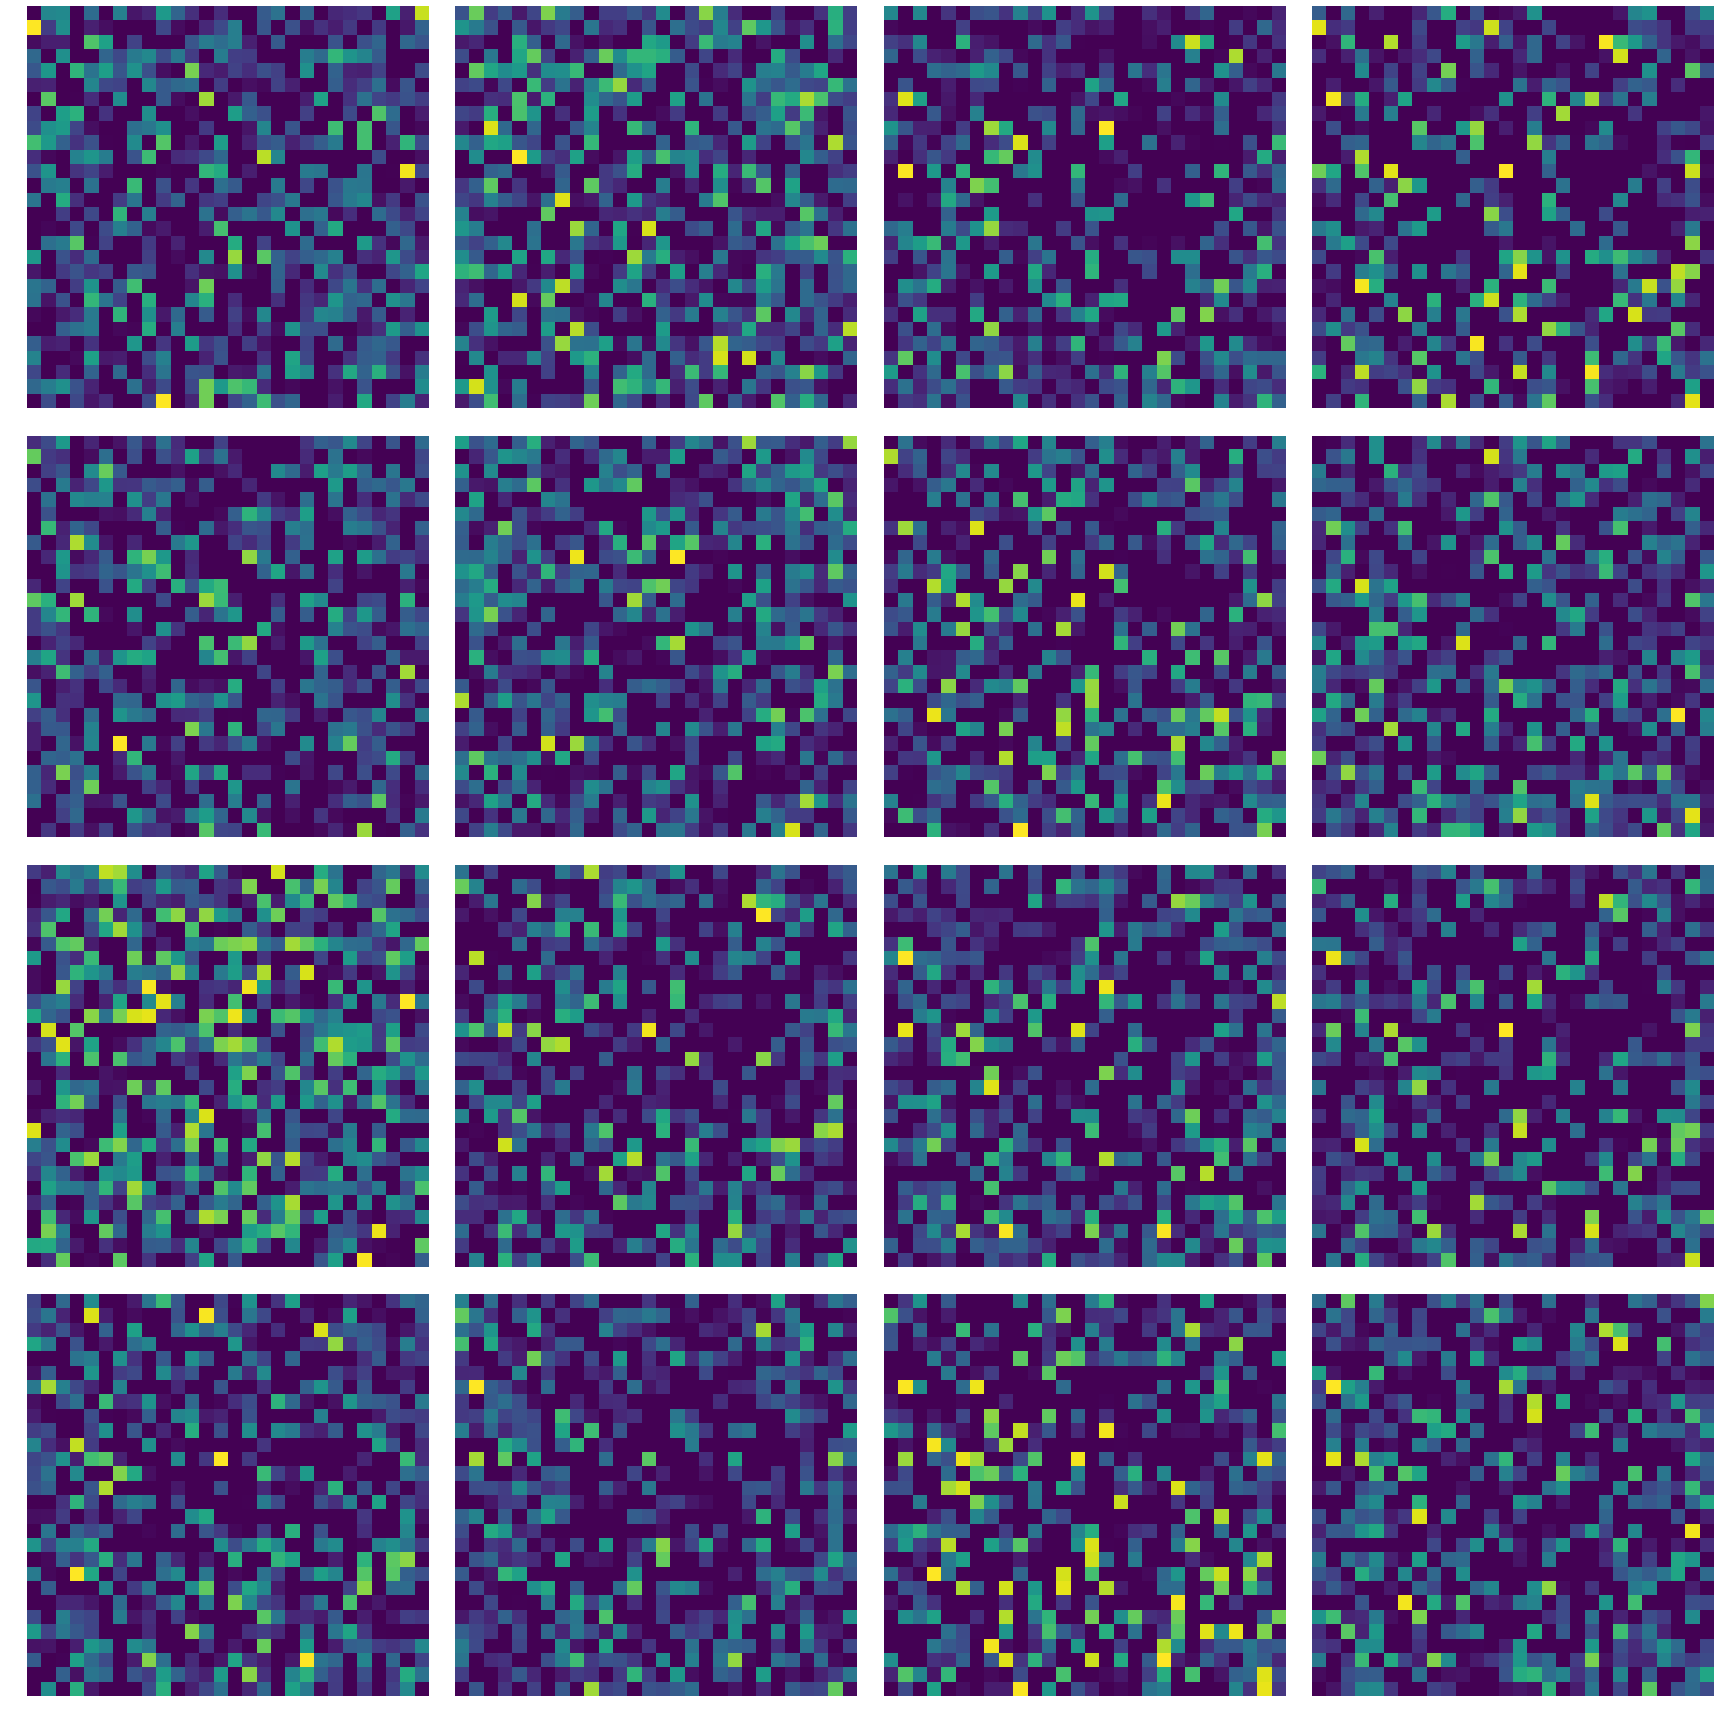

Epoch 10000, Generator loss 0.49200356006622314, discriminator loss 0.0007982704555615783


KeyboardInterrupt: 

In [10]:
data = load_mnist()
#pretrain_discriminator(data[0][0], generator, discriminator, 1200)
#pretrain_generator(data[0][0], gan, generator, discriminator, 100)
train_for_n(150000, data, generator, discriminator, gan)